## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4198939702275294804
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6892342477
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9641595034218486180
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_3-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_3, decoder_outputs_3])
decoder_concat_input = Concatenate()([decoder_outputs_3, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 64), (No 17664       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        [(None, 10, 64), (No 17664       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

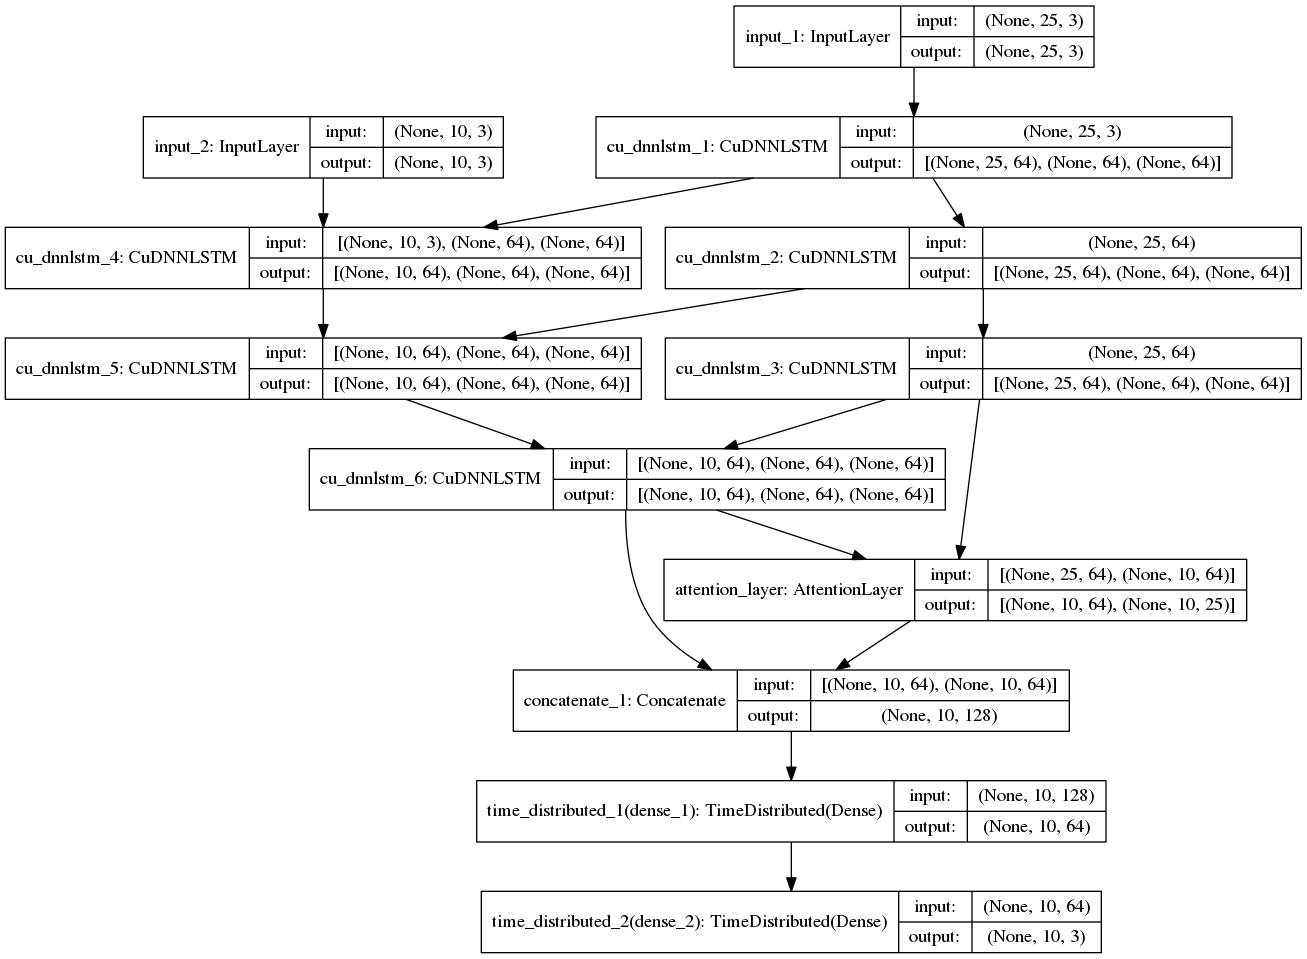

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

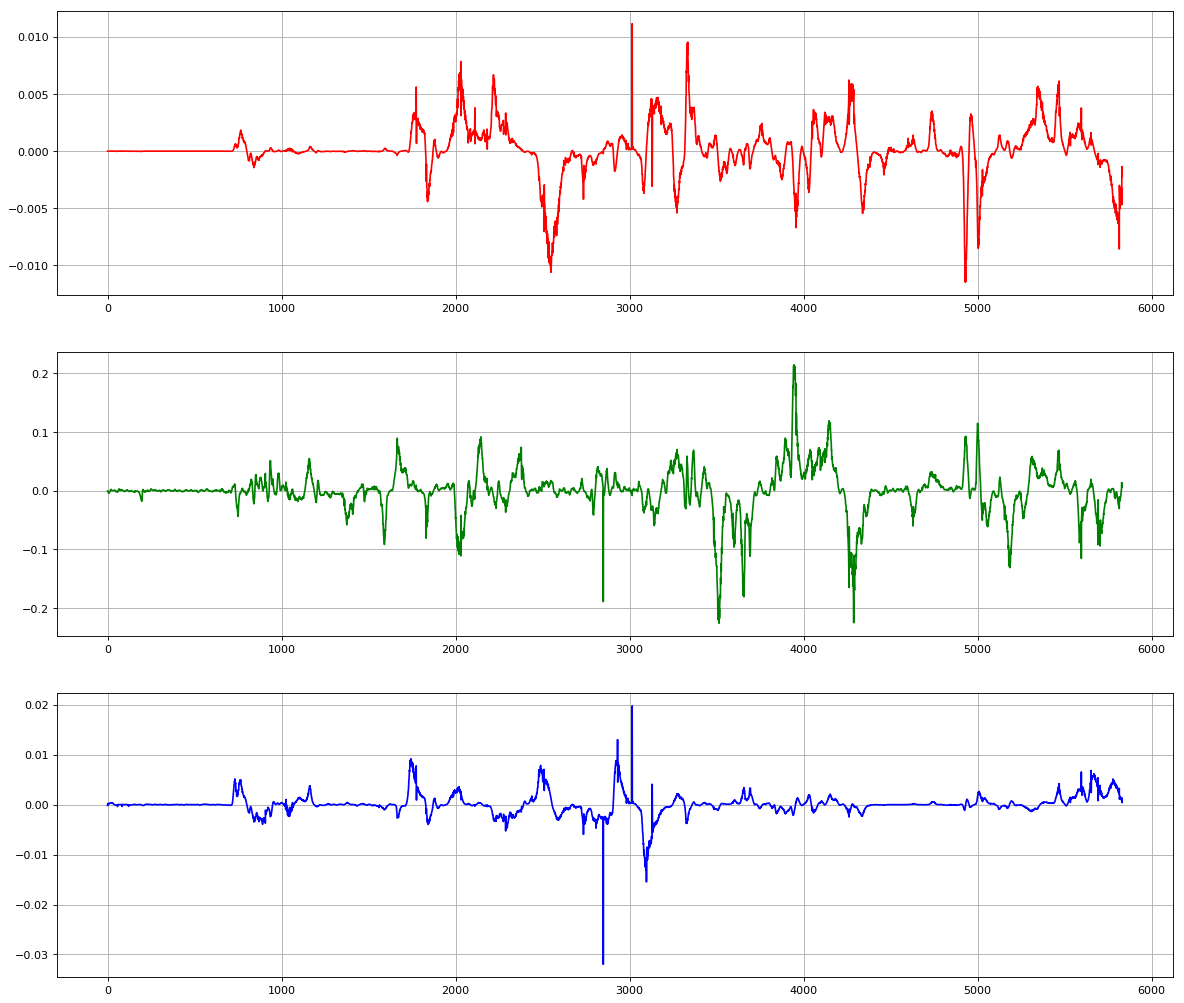

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 12:48 - loss: 0.0883 - rmse: 0.2191 - smape: 94.3519 - mfe: -4.6884e-04

  2/542 [..............................] - ETA: 6:59 - loss: 0.0539 - rmse: 0.1299 - smape: 87.6763 - mfe: 0.0015      

  3/542 [..............................] - ETA: 5:04 - loss: 0.0700 - rmse: 0.1740 - smape: 86.4352 - mfe: -5.1889e-04

  4/542 [..............................] - ETA: 4:06 - loss: 0.0653 - rmse: 0.1651 - smape: 86.1443 - mfe: -9.1625e-04

  5/542 [..............................] - ETA: 3:31 - loss: 0.0589 - rmse: 0.1627 - smape: 85.6023 - mfe: 4.2974e-04 

  6/542 [..............................] - ETA: 3:07 - loss: 0.0586 - rmse: 0.1678 - smape: 85.3684 - mfe: 3.5701e-04

  7/542 [..............................] - ETA: 2:51 - loss: 0.0684 - rmse: 0.1878 - smape: 85.5712 - mfe: 4.1045e-05

  8/542 [..............................] - ETA: 2:38 - loss: 0.0700 - rmse: 0.1887 - smape: 85.7033 - mfe: -2.5359e-04

  9/542 [..............................] - ETA: 2:27 - loss: 0.0702 - rmse: 0.1867 - smape: 85.8299 - mfe: -5.1848e-04

 10/542 [..............................] - ETA: 2:19 - loss: 0.0688 - rmse: 0.1813 - smape: 85.5572 - mfe: -7.2204e-04

 11/542 [..............................] - ETA: 2:13 - loss: 0.0678 - rmse: 0.1805 - smape: 85.2997 - mfe: -9.3215e-04

 12/542 [..............................] - ETA: 2:07 - loss: 0.0662 - rmse: 0.1768 - smape: 85.1921 - mfe: -0.0010    

 13/542 [..............................] - ETA: 2:03 - loss: 0.0709 - rmse: 0.1884 - smape: 85.2776 - mfe: -9.0225e-04

 14/542 [..............................] - ETA: 1:59 - loss: 0.0697 - rmse: 0.1852 - smape: 85.2227 - mfe: -6.4119e-04

 15/542 [..............................] - ETA: 1:55 - loss: 0.0677 - rmse: 0.1798 - smape: 85.0990 - mfe: -3.4842e-04

 16/542 [..............................] - ETA: 1:52 - loss: 0.0675 - rmse: 0.1797 - smape: 84.9436 - mfe: -1.2053e-04

 17/542 [..............................] - ETA: 1:49 - loss: 0.0667 - rmse: 0.1779 - smape: 84.8438 - mfe: 1.0336e-04 

 18/542 [..............................] - ETA: 1:47 - loss: 0.0676 - rmse: 0.1810 - smape: 84.8474 - mfe: 2.0158e-04

 19/542 [>.............................] - ETA: 1:45 - loss: 0.0675 - rmse: 0.1871 - smape: 84.4057 - mfe: 2.2567e-04

 20/542 [>.............................] - ETA: 1:43 - loss: 0.0664 - rmse: 0.1850 - smape: 84.2457 - mfe: -3.2787e-05

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0679 - rmse: 0.1894 - smape: 84.2440 - mfe: -2.8911e-04

 22/542 [>.............................] - ETA: 1:40 - loss: 0.0715 - rmse: 0.1959 - smape: 84.2349 - mfe: -3.4629e-04

 23/542 [>.............................] - ETA: 1:38 - loss: 0.0703 - rmse: 0.1929 - smape: 83.9035 - mfe: -2.6401e-04

 24/542 [>.............................] - ETA: 1:37 - loss: 0.0702 - rmse: 0.1919 - smape: 83.8026 - mfe: -3.4551e-04

 25/542 [>.............................] - ETA: 1:35 - loss: 0.0697 - rmse: 0.1908 - smape: 83.7905 - mfe: -4.4909e-04

 26/542 [>.............................] - ETA: 1:34 - loss: 0.0705 - rmse: 0.1940 - smape: 83.8021 - mfe: -4.7877e-04

 27/542 [>.............................] - ETA: 1:33 - loss: 0.0701 - rmse: 0.1926 - smape: 83.7210 - mfe: -3.1162e-04

 28/542 [>.............................] - ETA: 1:32 - loss: 0.0707 - rmse: 0.1941 - smape: 83.7544 - mfe: -5.0164e-05

 29/542 [>.............................] - ETA: 1:31 - loss: 0.0689 - rmse: 0.1889 - smape: 83.6060 - mfe: 1.0312e-04 

 30/542 [>.............................] - ETA: 1:30 - loss: 0.0691 - rmse: 0.1893 - smape: 83.7340 - mfe: 4.3619e-05

 31/542 [>.............................] - ETA: 1:29 - loss: 0.0695 - rmse: 0.1906 - smape: 83.6564 - mfe: -2.3565e-04

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0703 - rmse: 0.1934 - smape: 83.5821 - mfe: -4.8849e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0689 - rmse: 0.1911 - smape: 83.5493 - mfe: -6.0181e-04

 34/542 [>.............................] - ETA: 1:26 - loss: 0.0686 - rmse: 0.1911 - smape: 83.4278 - mfe: -4.5764e-04

 35/542 [>.............................] - ETA: 1:26 - loss: 0.0694 - rmse: 0.1929 - smape: 83.3491 - mfe: -1.6628e-04

 36/542 [>.............................] - ETA: 1:25 - loss: 0.0681 - rmse: 0.1886 - smape: 83.2021 - mfe: 1.8247e-04 

 37/542 [=>............................] - ETA: 1:24 - loss: 0.0685 - rmse: 0.1891 - smape: 83.1125 - mfe: 4.6807e-04

 38/542 [=>............................] - ETA: 1:24 - loss: 0.0688 - rmse: 0.1902 - smape: 82.9449 - mfe: 7.4252e-04

 39/542 [=>............................] - ETA: 1:23 - loss: 0.0684 - rmse: 0.1881 - smape: 82.8103 - mfe: 8.7920e-04

 40/542 [=>............................] - ETA: 1:23 - loss: 0.0684 - rmse: 0.1889 - smape: 82.6515 - mfe: 9.9304e-04

 41/542 [=>............................] - ETA: 1:22 - loss: 0.0689 - rmse: 0.1908 - smape: 82.6149 - mfe: 0.0010    

 42/542 [=>............................] - ETA: 1:21 - loss: 0.0698 - rmse: 0.1933 - smape: 82.5858 - mfe: 0.0010

 43/542 [=>............................] - ETA: 1:21 - loss: 0.0695 - rmse: 0.1945 - smape: 82.5964 - mfe: 9.5613e-04

 44/542 [=>............................] - ETA: 1:20 - loss: 0.0691 - rmse: 0.1927 - smape: 82.6611 - mfe: 8.5777e-04

 45/542 [=>............................] - ETA: 1:20 - loss: 0.0694 - rmse: 0.1942 - smape: 82.6358 - mfe: 8.1978e-04

 46/542 [=>............................] - ETA: 1:19 - loss: 0.0710 - rmse: 0.1994 - smape: 82.5624 - mfe: 8.0283e-04

 47/542 [=>............................] - ETA: 1:19 - loss: 0.0707 - rmse: 0.1978 - smape: 82.5710 - mfe: 7.4716e-04

 48/542 [=>............................] - ETA: 1:18 - loss: 0.0721 - rmse: 0.2020 - smape: 82.5637 - mfe: 6.0783e-04

 49/542 [=>............................] - ETA: 1:18 - loss: 0.0723 - rmse: 0.2021 - smape: 82.5000 - mfe: 5.1182e-04

 50/542 [=>............................] - ETA: 1:17 - loss: 0.0719 - rmse: 0.2014 - smape: 82.4637 - mfe: 4.3052e-04

 51/542 [=>............................] - ETA: 1:17 - loss: 0.0713 - rmse: 0.2004 - smape: 82.5427 - mfe: 3.5991e-04

 52/542 [=>............................] - ETA: 1:17 - loss: 0.0708 - rmse: 0.1989 - smape: 82.5810 - mfe: 3.3188e-04

 53/542 [=>............................] - ETA: 1:16 - loss: 0.0718 - rmse: 0.2009 - smape: 82.5932 - mfe: 2.9653e-04

 54/542 [=>............................] - ETA: 1:16 - loss: 0.0711 - rmse: 0.1992 - smape: 82.6538 - mfe: 3.0511e-04

 55/542 [==>...........................] - ETA: 1:15 - loss: 0.0706 - rmse: 0.1979 - smape: 82.6981 - mfe: 3.4451e-04

 56/542 [==>...........................] - ETA: 1:15 - loss: 0.0697 - rmse: 0.1952 - smape: 82.6421 - mfe: 3.9574e-04

 57/542 [==>...........................] - ETA: 1:14 - loss: 0.0695 - rmse: 0.1947 - smape: 82.7061 - mfe: 4.4683e-04

 58/542 [==>...........................] - ETA: 1:14 - loss: 0.0696 - rmse: 0.1947 - smape: 82.6842 - mfe: 4.9803e-04

 59/542 [==>...........................] - ETA: 1:14 - loss: 0.0695 - rmse: 0.1943 - smape: 82.6953 - mfe: 5.0872e-04

 60/542 [==>...........................] - ETA: 1:13 - loss: 0.0695 - rmse: 0.1947 - smape: 82.7106 - mfe: 5.2578e-04

 61/542 [==>...........................] - ETA: 1:13 - loss: 0.0697 - rmse: 0.1950 - smape: 82.7016 - mfe: 5.0771e-04

 62/542 [==>...........................] - ETA: 1:13 - loss: 0.0699 - rmse: 0.1955 - smape: 82.7229 - mfe: 4.6290e-04

 63/542 [==>...........................] - ETA: 1:13 - loss: 0.0696 - rmse: 0.1943 - smape: 82.7559 - mfe: 3.9179e-04

 64/542 [==>...........................] - ETA: 1:12 - loss: 0.0699 - rmse: 0.1957 - smape: 82.6995 - mfe: 2.8922e-04

 65/542 [==>...........................] - ETA: 1:12 - loss: 0.0702 - rmse: 0.1958 - smape: 82.6997 - mfe: 2.0701e-04

 66/542 [==>...........................] - ETA: 1:12 - loss: 0.0698 - rmse: 0.1945 - smape: 82.6856 - mfe: 1.8850e-04

 67/542 [==>...........................] - ETA: 1:11 - loss: 0.0698 - rmse: 0.1940 - smape: 82.7060 - mfe: 1.8344e-04

 68/542 [==>...........................] - ETA: 1:11 - loss: 0.0703 - rmse: 0.1950 - smape: 82.7041 - mfe: 1.7454e-04

 69/542 [==>...........................] - ETA: 1:11 - loss: 0.0699 - rmse: 0.1939 - smape: 82.7133 - mfe: 1.7532e-04

 70/542 [==>...........................] - ETA: 1:10 - loss: 0.0697 - rmse: 0.1937 - smape: 82.6929 - mfe: 2.7254e-04

 71/542 [==>...........................] - ETA: 1:10 - loss: 0.0694 - rmse: 0.1934 - smape: 82.7382 - mfe: 3.0149e-04

 72/542 [==>...........................] - ETA: 1:10 - loss: 0.0699 - rmse: 0.1947 - smape: 82.7415 - mfe: 3.1553e-04

 73/542 [===>..........................] - ETA: 1:10 - loss: 0.0695 - rmse: 0.1935 - smape: 82.7797 - mfe: 2.9993e-04

 74/542 [===>..........................] - ETA: 1:09 - loss: 0.0696 - rmse: 0.1937 - smape: 82.8016 - mfe: 2.7804e-04

 75/542 [===>..........................] - ETA: 1:09 - loss: 0.0699 - rmse: 0.1947 - smape: 82.7941 - mfe: 2.7706e-04

 76/542 [===>..........................] - ETA: 1:09 - loss: 0.0710 - rmse: 0.1971 - smape: 82.7842 - mfe: 2.5970e-04

 77/542 [===>..........................] - ETA: 1:09 - loss: 0.0705 - rmse: 0.1965 - smape: 82.7440 - mfe: 2.6178e-04

 78/542 [===>..........................] - ETA: 1:08 - loss: 0.0705 - rmse: 0.1961 - smape: 82.7818 - mfe: 2.8291e-04

 79/542 [===>..........................] - ETA: 1:08 - loss: 0.0709 - rmse: 0.1970 - smape: 82.8101 - mfe: 3.3550e-04

 80/542 [===>..........................] - ETA: 1:08 - loss: 0.0709 - rmse: 0.1971 - smape: 82.8266 - mfe: 3.8413e-04

 81/542 [===>..........................] - ETA: 1:08 - loss: 0.0707 - rmse: 0.1962 - smape: 82.9115 - mfe: 3.9184e-04

 82/542 [===>..........................] - ETA: 1:07 - loss: 0.0705 - rmse: 0.1957 - smape: 82.9437 - mfe: 3.9790e-04

 83/542 [===>..........................] - ETA: 1:07 - loss: 0.0702 - rmse: 0.1949 - smape: 82.9846 - mfe: 3.9376e-04

 84/542 [===>..........................] - ETA: 1:07 - loss: 0.0703 - rmse: 0.1949 - smape: 82.9950 - mfe: 4.0388e-04

 85/542 [===>..........................] - ETA: 1:07 - loss: 0.0696 - rmse: 0.1930 - smape: 82.9910 - mfe: 4.0232e-04

 86/542 [===>..........................] - ETA: 1:06 - loss: 0.0696 - rmse: 0.1928 - smape: 82.9791 - mfe: 4.1569e-04

 87/542 [===>..........................] - ETA: 1:06 - loss: 0.0694 - rmse: 0.1924 - smape: 83.0030 - mfe: 4.3121e-04

 88/542 [===>..........................] - ETA: 1:06 - loss: 0.0694 - rmse: 0.1921 - smape: 82.9982 - mfe: 4.5904e-04

 89/542 [===>..........................] - ETA: 1:06 - loss: 0.0699 - rmse: 0.1933 - smape: 83.0082 - mfe: 5.3436e-04

 90/542 [===>..........................] - ETA: 1:05 - loss: 0.0694 - rmse: 0.1920 - smape: 83.0041 - mfe: 5.5604e-04

 91/542 [====>.........................] - ETA: 1:05 - loss: 0.0690 - rmse: 0.1915 - smape: 83.0051 - mfe: 5.6153e-04

 92/542 [====>.........................] - ETA: 1:05 - loss: 0.0684 - rmse: 0.1899 - smape: 83.0111 - mfe: 5.5923e-04

 93/542 [====>.........................] - ETA: 1:04 - loss: 0.0684 - rmse: 0.1897 - smape: 83.0543 - mfe: 5.3559e-04

 94/542 [====>.........................] - ETA: 1:04 - loss: 0.0682 - rmse: 0.1889 - smape: 83.1084 - mfe: 4.9623e-04

 95/542 [====>.........................] - ETA: 1:04 - loss: 0.0681 - rmse: 0.1885 - smape: 83.1308 - mfe: 4.6140e-04

 96/542 [====>.........................] - ETA: 1:04 - loss: 0.0683 - rmse: 0.1886 - smape: 83.1411 - mfe: 4.5233e-04

 97/542 [====>.........................] - ETA: 1:04 - loss: 0.0680 - rmse: 0.1883 - smape: 83.1495 - mfe: 4.2424e-04

 98/542 [====>.........................] - ETA: 1:04 - loss: 0.0678 - rmse: 0.1878 - smape: 83.1382 - mfe: 4.2053e-04

 99/542 [====>.........................] - ETA: 1:03 - loss: 0.0679 - rmse: 0.1879 - smape: 83.1307 - mfe: 4.0932e-04

100/542 [====>.........................] - ETA: 1:03 - loss: 0.0676 - rmse: 0.1873 - smape: 83.1098 - mfe: 4.3918e-04

101/542 [====>.........................] - ETA: 1:03 - loss: 0.0677 - rmse: 0.1874 - smape: 83.1055 - mfe: 4.3578e-04

102/542 [====>.........................] - ETA: 1:03 - loss: 0.0676 - rmse: 0.1871 - smape: 83.0637 - mfe: 4.3872e-04

103/542 [====>.........................] - ETA: 1:02 - loss: 0.0675 - rmse: 0.1866 - smape: 83.0557 - mfe: 3.9901e-04

104/542 [====>.........................] - ETA: 1:02 - loss: 0.0672 - rmse: 0.1856 - smape: 83.0966 - mfe: 3.8829e-04

105/542 [====>.........................] - ETA: 1:02 - loss: 0.0667 - rmse: 0.1842 - smape: 83.0963 - mfe: 3.8273e-04

106/542 [====>.........................] - ETA: 1:02 - loss: 0.0667 - rmse: 0.1841 - smape: 83.1098 - mfe: 3.8023e-04

107/542 [====>.........................] - ETA: 1:02 - loss: 0.0670 - rmse: 0.1847 - smape: 83.0871 - mfe: 3.8903e-04

108/542 [====>.........................] - ETA: 1:01 - loss: 0.0666 - rmse: 0.1838 - smape: 83.0742 - mfe: 3.8786e-04

109/542 [=====>........................] - ETA: 1:01 - loss: 0.0671 - rmse: 0.1846 - smape: 83.0749 - mfe: 3.9597e-04

110/542 [=====>........................] - ETA: 1:01 - loss: 0.0667 - rmse: 0.1835 - smape: 83.0864 - mfe: 4.0298e-04

111/542 [=====>........................] - ETA: 1:01 - loss: 0.0664 - rmse: 0.1827 - smape: 83.0869 - mfe: 4.0543e-04

112/542 [=====>........................] - ETA: 1:01 - loss: 0.0665 - rmse: 0.1827 - smape: 83.1001 - mfe: 4.1543e-04

113/542 [=====>........................] - ETA: 1:00 - loss: 0.0665 - rmse: 0.1828 - smape: 83.1016 - mfe: 4.0738e-04

114/542 [=====>........................] - ETA: 1:00 - loss: 0.0663 - rmse: 0.1823 - smape: 83.0872 - mfe: 3.9502e-04

115/542 [=====>........................] - ETA: 1:00 - loss: 0.0662 - rmse: 0.1818 - smape: 83.0842 - mfe: 4.0050e-04

116/542 [=====>........................] - ETA: 1:00 - loss: 0.0665 - rmse: 0.1826 - smape: 83.0848 - mfe: 4.3766e-04

117/542 [=====>........................] - ETA: 1:00 - loss: 0.0667 - rmse: 0.1828 - smape: 83.0640 - mfe: 4.7595e-04

118/542 [=====>........................] - ETA: 59s - loss: 0.0666 - rmse: 0.1826 - smape: 83.0410 - mfe: 4.9852e-04 

119/542 [=====>........................] - ETA: 59s - loss: 0.0666 - rmse: 0.1831 - smape: 83.0194 - mfe: 5.1617e-04

120/542 [=====>........................] - ETA: 59s - loss: 0.0666 - rmse: 0.1830 - smape: 83.0350 - mfe: 5.3571e-04

121/542 [=====>........................] - ETA: 59s - loss: 0.0664 - rmse: 0.1824 - smape: 83.0343 - mfe: 5.5183e-04

122/542 [=====>........................] - ETA: 59s - loss: 0.0663 - rmse: 0.1821 - smape: 83.0489 - mfe: 5.4581e-04

123/542 [=====>........................] - ETA: 59s - loss: 0.0663 - rmse: 0.1821 - smape: 83.0640 - mfe: 5.2251e-04

124/542 [=====>........................] - ETA: 58s - loss: 0.0661 - rmse: 0.1815 - smape: 83.0658 - mfe: 5.0528e-04

125/542 [=====>........................] - ETA: 58s - loss: 0.0659 - rmse: 0.1808 - smape: 83.0810 - mfe: 4.8200e-04

126/542 [=====>........................] - ETA: 58s - loss: 0.0662 - rmse: 0.1817 - smape: 83.0775 - mfe: 4.7134e-04

127/542 [======>.......................] - ETA: 58s - loss: 0.0663 - rmse: 0.1815 - smape: 83.1000 - mfe: 4.5823e-04

128/542 [======>.......................] - ETA: 58s - loss: 0.0664 - rmse: 0.1817 - smape: 83.1210 - mfe: 4.3696e-04

129/542 [======>.......................] - ETA: 58s - loss: 0.0661 - rmse: 0.1810 - smape: 83.1028 - mfe: 4.1600e-04

130/542 [======>.......................] - ETA: 57s - loss: 0.0660 - rmse: 0.1809 - smape: 83.0905 - mfe: 4.0927e-04

131/542 [======>.......................] - ETA: 57s - loss: 0.0660 - rmse: 0.1809 - smape: 83.1178 - mfe: 3.9823e-04

132/542 [======>.......................] - ETA: 57s - loss: 0.0661 - rmse: 0.1813 - smape: 83.1076 - mfe: 4.0229e-04

133/542 [======>.......................] - ETA: 57s - loss: 0.0658 - rmse: 0.1806 - smape: 83.0837 - mfe: 3.8793e-04

134/542 [======>.......................] - ETA: 57s - loss: 0.0657 - rmse: 0.1802 - smape: 83.0781 - mfe: 3.7633e-04

135/542 [======>.......................] - ETA: 56s - loss: 0.0656 - rmse: 0.1798 - smape: 83.0483 - mfe: 3.7209e-04

136/542 [======>.......................] - ETA: 56s - loss: 0.0654 - rmse: 0.1794 - smape: 83.0612 - mfe: 3.6199e-04

137/542 [======>.......................] - ETA: 56s - loss: 0.0656 - rmse: 0.1795 - smape: 83.0558 - mfe: 3.3020e-04

138/542 [======>.......................] - ETA: 56s - loss: 0.0655 - rmse: 0.1792 - smape: 83.0522 - mfe: 3.2006e-04

139/542 [======>.......................] - ETA: 56s - loss: 0.0651 - rmse: 0.1781 - smape: 83.0170 - mfe: 3.1885e-04

140/542 [======>.......................] - ETA: 56s - loss: 0.0655 - rmse: 0.1792 - smape: 83.0244 - mfe: 2.7831e-04

141/542 [======>.......................] - ETA: 55s - loss: 0.0662 - rmse: 0.1806 - smape: 83.0177 - mfe: 2.7158e-04

142/542 [======>.......................] - ETA: 55s - loss: 0.0663 - rmse: 0.1809 - smape: 83.0151 - mfe: 2.6544e-04

143/542 [======>.......................] - ETA: 55s - loss: 0.0662 - rmse: 0.1808 - smape: 83.0058 - mfe: 2.7688e-04

144/542 [======>.......................] - ETA: 55s - loss: 0.0665 - rmse: 0.1816 - smape: 82.9918 - mfe: 2.9726e-04

145/542 [=======>......................] - ETA: 55s - loss: 0.0664 - rmse: 0.1813 - smape: 82.9954 - mfe: 3.0172e-04

146/542 [=======>......................] - ETA: 55s - loss: 0.0662 - rmse: 0.1806 - smape: 82.9740 - mfe: 3.1459e-04

147/542 [=======>......................] - ETA: 54s - loss: 0.0660 - rmse: 0.1800 - smape: 82.9590 - mfe: 3.1048e-04

148/542 [=======>......................] - ETA: 54s - loss: 0.0656 - rmse: 0.1791 - smape: 82.9515 - mfe: 3.1075e-04

149/542 [=======>......................] - ETA: 54s - loss: 0.0658 - rmse: 0.1795 - smape: 82.9618 - mfe: 3.4338e-04

150/542 [=======>......................] - ETA: 54s - loss: 0.0658 - rmse: 0.1796 - smape: 82.9366 - mfe: 3.6328e-04

151/542 [=======>......................] - ETA: 54s - loss: 0.0659 - rmse: 0.1798 - smape: 82.9083 - mfe: 3.6702e-04

152/542 [=======>......................] - ETA: 54s - loss: 0.0660 - rmse: 0.1799 - smape: 82.8913 - mfe: 3.6806e-04

153/542 [=======>......................] - ETA: 54s - loss: 0.0659 - rmse: 0.1796 - smape: 82.8727 - mfe: 3.3864e-04

154/542 [=======>......................] - ETA: 53s - loss: 0.0657 - rmse: 0.1794 - smape: 82.8342 - mfe: 3.2642e-04

155/542 [=======>......................] - ETA: 53s - loss: 0.0655 - rmse: 0.1789 - smape: 82.8148 - mfe: 3.4726e-04

156/542 [=======>......................] - ETA: 53s - loss: 0.0653 - rmse: 0.1783 - smape: 82.8084 - mfe: 3.5658e-04

157/542 [=======>......................] - ETA: 53s - loss: 0.0654 - rmse: 0.1783 - smape: 82.8091 - mfe: 3.4706e-04

158/542 [=======>......................] - ETA: 53s - loss: 0.0654 - rmse: 0.1782 - smape: 82.8023 - mfe: 3.2926e-04

159/542 [=======>......................] - ETA: 53s - loss: 0.0653 - rmse: 0.1782 - smape: 82.7836 - mfe: 3.4446e-04

160/542 [=======>......................] - ETA: 52s - loss: 0.0652 - rmse: 0.1777 - smape: 82.7651 - mfe: 3.7043e-04

161/542 [=======>......................] - ETA: 52s - loss: 0.0653 - rmse: 0.1777 - smape: 82.7479 - mfe: 3.9650e-04

162/542 [=======>......................] - ETA: 52s - loss: 0.0659 - rmse: 0.1791 - smape: 82.7262 - mfe: 3.7976e-04

163/542 [========>.....................] - ETA: 52s - loss: 0.0658 - rmse: 0.1789 - smape: 82.7161 - mfe: 3.8656e-04

164/542 [========>.....................] - ETA: 52s - loss: 0.0656 - rmse: 0.1785 - smape: 82.7226 - mfe: 3.8552e-04

165/542 [========>.....................] - ETA: 52s - loss: 0.0656 - rmse: 0.1785 - smape: 82.6993 - mfe: 3.7531e-04

166/542 [========>.....................] - ETA: 51s - loss: 0.0655 - rmse: 0.1783 - smape: 82.6787 - mfe: 3.7967e-04

167/542 [========>.....................] - ETA: 51s - loss: 0.0657 - rmse: 0.1791 - smape: 82.6571 - mfe: 3.7126e-04

168/542 [========>.....................] - ETA: 51s - loss: 0.0658 - rmse: 0.1791 - smape: 82.6754 - mfe: 3.6430e-04

169/542 [========>.....................] - ETA: 51s - loss: 0.0655 - rmse: 0.1782 - smape: 82.6603 - mfe: 3.6770e-04

170/542 [========>.....................] - ETA: 51s - loss: 0.0654 - rmse: 0.1779 - smape: 82.6782 - mfe: 3.7173e-04

171/542 [========>.....................] - ETA: 51s - loss: 0.0656 - rmse: 0.1787 - smape: 82.6808 - mfe: 3.7101e-04

172/542 [========>.....................] - ETA: 50s - loss: 0.0656 - rmse: 0.1785 - smape: 82.6753 - mfe: 3.6597e-04

173/542 [========>.....................] - ETA: 50s - loss: 0.0653 - rmse: 0.1780 - smape: 82.6419 - mfe: 3.7519e-04

174/542 [========>.....................] - ETA: 50s - loss: 0.0652 - rmse: 0.1776 - smape: 82.6227 - mfe: 3.7114e-04

175/542 [========>.....................] - ETA: 50s - loss: 0.0651 - rmse: 0.1774 - smape: 82.6346 - mfe: 3.7615e-04

176/542 [========>.....................] - ETA: 50s - loss: 0.0651 - rmse: 0.1778 - smape: 82.6404 - mfe: 3.8630e-04

177/542 [========>.....................] - ETA: 50s - loss: 0.0650 - rmse: 0.1776 - smape: 82.6194 - mfe: 3.9215e-04

178/542 [========>.....................] - ETA: 50s - loss: 0.0649 - rmse: 0.1775 - smape: 82.6228 - mfe: 3.8887e-04

179/542 [========>.....................] - ETA: 49s - loss: 0.0649 - rmse: 0.1776 - smape: 82.6110 - mfe: 3.8827e-04

180/542 [========>.....................] - ETA: 49s - loss: 0.0650 - rmse: 0.1775 - smape: 82.6184 - mfe: 3.9084e-04

181/542 [=========>....................] - ETA: 49s - loss: 0.0649 - rmse: 0.1776 - smape: 82.6153 - mfe: 3.8127e-04

182/542 [=========>....................] - ETA: 49s - loss: 0.0651 - rmse: 0.1777 - smape: 82.6169 - mfe: 3.8670e-04

183/542 [=========>....................] - ETA: 49s - loss: 0.0651 - rmse: 0.1777 - smape: 82.6005 - mfe: 4.0946e-04

184/542 [=========>....................] - ETA: 49s - loss: 0.0649 - rmse: 0.1772 - smape: 82.6010 - mfe: 4.3031e-04

185/542 [=========>....................] - ETA: 48s - loss: 0.0650 - rmse: 0.1774 - smape: 82.5880 - mfe: 4.2292e-04

186/542 [=========>....................] - ETA: 48s - loss: 0.0651 - rmse: 0.1777 - smape: 82.5826 - mfe: 4.2320e-04

187/542 [=========>....................] - ETA: 48s - loss: 0.0651 - rmse: 0.1774 - smape: 82.5741 - mfe: 4.4259e-04

188/542 [=========>....................] - ETA: 48s - loss: 0.0650 - rmse: 0.1770 - smape: 82.5680 - mfe: 4.6485e-04

189/542 [=========>....................] - ETA: 48s - loss: 0.0650 - rmse: 0.1771 - smape: 82.5568 - mfe: 4.7652e-04

190/542 [=========>....................] - ETA: 48s - loss: 0.0650 - rmse: 0.1773 - smape: 82.5369 - mfe: 4.7947e-04

191/542 [=========>....................] - ETA: 48s - loss: 0.0652 - rmse: 0.1777 - smape: 82.5367 - mfe: 4.6504e-04

192/542 [=========>....................] - ETA: 47s - loss: 0.0652 - rmse: 0.1776 - smape: 82.5301 - mfe: 4.3410e-04

193/542 [=========>....................] - ETA: 47s - loss: 0.0651 - rmse: 0.1774 - smape: 82.5209 - mfe: 4.0444e-04

194/542 [=========>....................] - ETA: 47s - loss: 0.0651 - rmse: 0.1778 - smape: 82.4824 - mfe: 4.0176e-04

195/542 [=========>....................] - ETA: 47s - loss: 0.0649 - rmse: 0.1772 - smape: 82.4624 - mfe: 4.2756e-04

196/542 [=========>....................] - ETA: 47s - loss: 0.0648 - rmse: 0.1771 - smape: 82.4647 - mfe: 4.3580e-04

197/542 [=========>....................] - ETA: 47s - loss: 0.0647 - rmse: 0.1769 - smape: 82.4589 - mfe: 4.3394e-04

198/542 [=========>....................] - ETA: 47s - loss: 0.0648 - rmse: 0.1772 - smape: 82.4662 - mfe: 4.3580e-04

199/542 [==========>...................] - ETA: 46s - loss: 0.0648 - rmse: 0.1774 - smape: 82.4594 - mfe: 4.4347e-04

200/542 [==========>...................] - ETA: 46s - loss: 0.0648 - rmse: 0.1775 - smape: 82.4547 - mfe: 4.5438e-04

201/542 [==========>...................] - ETA: 46s - loss: 0.0649 - rmse: 0.1778 - smape: 82.4611 - mfe: 4.4243e-04

202/542 [==========>...................] - ETA: 46s - loss: 0.0648 - rmse: 0.1773 - smape: 82.4668 - mfe: 4.3559e-04

203/542 [==========>...................] - ETA: 46s - loss: 0.0650 - rmse: 0.1779 - smape: 82.4788 - mfe: 4.3456e-04

204/542 [==========>...................] - ETA: 46s - loss: 0.0650 - rmse: 0.1778 - smape: 82.4844 - mfe: 4.3471e-04

205/542 [==========>...................] - ETA: 46s - loss: 0.0650 - rmse: 0.1778 - smape: 82.4858 - mfe: 4.3353e-04

206/542 [==========>...................] - ETA: 45s - loss: 0.0652 - rmse: 0.1782 - smape: 82.4788 - mfe: 4.3344e-04

207/542 [==========>...................] - ETA: 45s - loss: 0.0651 - rmse: 0.1779 - smape: 82.4833 - mfe: 4.3661e-04

208/542 [==========>...................] - ETA: 45s - loss: 0.0651 - rmse: 0.1779 - smape: 82.4762 - mfe: 4.3651e-04

209/542 [==========>...................] - ETA: 45s - loss: 0.0650 - rmse: 0.1780 - smape: 82.4532 - mfe: 4.1851e-04

210/542 [==========>...................] - ETA: 45s - loss: 0.0648 - rmse: 0.1774 - smape: 82.4577 - mfe: 4.1810e-04

211/542 [==========>...................] - ETA: 45s - loss: 0.0645 - rmse: 0.1766 - smape: 82.4413 - mfe: 4.2253e-04

212/542 [==========>...................] - ETA: 45s - loss: 0.0646 - rmse: 0.1771 - smape: 82.4193 - mfe: 4.2733e-04

213/542 [==========>...................] - ETA: 44s - loss: 0.0645 - rmse: 0.1765 - smape: 82.4160 - mfe: 4.2254e-04

214/542 [==========>...................] - ETA: 44s - loss: 0.0644 - rmse: 0.1765 - smape: 82.4069 - mfe: 4.4504e-04

215/542 [==========>...................] - ETA: 44s - loss: 0.0643 - rmse: 0.1762 - smape: 82.4160 - mfe: 4.6770e-04

216/542 [==========>...................] - ETA: 44s - loss: 0.0643 - rmse: 0.1762 - smape: 82.4206 - mfe: 4.9444e-04

217/542 [===========>..................] - ETA: 44s - loss: 0.0644 - rmse: 0.1765 - smape: 82.4399 - mfe: 5.1096e-04

218/542 [===========>..................] - ETA: 44s - loss: 0.0647 - rmse: 0.1776 - smape: 82.4389 - mfe: 5.2953e-04

219/542 [===========>..................] - ETA: 44s - loss: 0.0648 - rmse: 0.1778 - smape: 82.4282 - mfe: 5.2027e-04

220/542 [===========>..................] - ETA: 43s - loss: 0.0648 - rmse: 0.1776 - smape: 82.4275 - mfe: 4.9900e-04

221/542 [===========>..................] - ETA: 43s - loss: 0.0649 - rmse: 0.1779 - smape: 82.4316 - mfe: 4.7444e-04

222/542 [===========>..................] - ETA: 43s - loss: 0.0648 - rmse: 0.1774 - smape: 82.4269 - mfe: 4.5685e-04

223/542 [===========>..................] - ETA: 43s - loss: 0.0647 - rmse: 0.1774 - smape: 82.4333 - mfe: 4.3784e-04

224/542 [===========>..................] - ETA: 43s - loss: 0.0648 - rmse: 0.1776 - smape: 82.4265 - mfe: 4.2025e-04

225/542 [===========>..................] - ETA: 43s - loss: 0.0647 - rmse: 0.1774 - smape: 82.4201 - mfe: 4.0983e-04

226/542 [===========>..................] - ETA: 43s - loss: 0.0646 - rmse: 0.1772 - smape: 82.4224 - mfe: 4.0010e-04

227/542 [===========>..................] - ETA: 42s - loss: 0.0645 - rmse: 0.1768 - smape: 82.4234 - mfe: 3.9215e-04

228/542 [===========>..................] - ETA: 42s - loss: 0.0643 - rmse: 0.1765 - smape: 82.4217 - mfe: 3.8483e-04

229/542 [===========>..................] - ETA: 42s - loss: 0.0643 - rmse: 0.1764 - smape: 82.4229 - mfe: 3.9736e-04

230/542 [===========>..................] - ETA: 42s - loss: 0.0642 - rmse: 0.1761 - smape: 82.4370 - mfe: 3.8740e-04

231/542 [===========>..................] - ETA: 42s - loss: 0.0641 - rmse: 0.1759 - smape: 82.4345 - mfe: 3.8171e-04

232/542 [===========>..................] - ETA: 42s - loss: 0.0639 - rmse: 0.1754 - smape: 82.4485 - mfe: 3.7414e-04

233/542 [===========>..................] - ETA: 42s - loss: 0.0637 - rmse: 0.1749 - smape: 82.4499 - mfe: 3.6595e-04

234/542 [===========>..................] - ETA: 41s - loss: 0.0637 - rmse: 0.1749 - smape: 82.4619 - mfe: 3.6594e-04

235/542 [============>.................] - ETA: 41s - loss: 0.0637 - rmse: 0.1749 - smape: 82.4601 - mfe: 3.7089e-04

236/542 [============>.................] - ETA: 41s - loss: 0.0638 - rmse: 0.1755 - smape: 82.4572 - mfe: 3.8049e-04

237/542 [============>.................] - ETA: 41s - loss: 0.0636 - rmse: 0.1751 - smape: 82.4623 - mfe: 3.7998e-04

238/542 [============>.................] - ETA: 41s - loss: 0.0634 - rmse: 0.1745 - smape: 82.4521 - mfe: 3.7601e-04

239/542 [============>.................] - ETA: 41s - loss: 0.0633 - rmse: 0.1742 - smape: 82.4691 - mfe: 3.6819e-04

240/542 [============>.................] - ETA: 41s - loss: 0.0634 - rmse: 0.1741 - smape: 82.4754 - mfe: 3.5188e-04

241/542 [============>.................] - ETA: 41s - loss: 0.0632 - rmse: 0.1735 - smape: 82.4587 - mfe: 3.3516e-04

242/542 [============>.................] - ETA: 40s - loss: 0.0630 - rmse: 0.1731 - smape: 82.4410 - mfe: 3.2477e-04

243/542 [============>.................] - ETA: 40s - loss: 0.0632 - rmse: 0.1738 - smape: 82.4219 - mfe: 3.1539e-04

244/542 [============>.................] - ETA: 40s - loss: 0.0631 - rmse: 0.1735 - smape: 82.4097 - mfe: 3.1019e-04

245/542 [============>.................] - ETA: 40s - loss: 0.0629 - rmse: 0.1729 - smape: 82.4201 - mfe: 3.0529e-04

246/542 [============>.................] - ETA: 40s - loss: 0.0630 - rmse: 0.1732 - smape: 82.4180 - mfe: 3.0138e-04

247/542 [============>.................] - ETA: 40s - loss: 0.0630 - rmse: 0.1732 - smape: 82.4216 - mfe: 2.9829e-04

248/542 [============>.................] - ETA: 40s - loss: 0.0631 - rmse: 0.1734 - smape: 82.4190 - mfe: 3.0190e-04

249/542 [============>.................] - ETA: 39s - loss: 0.0630 - rmse: 0.1734 - smape: 82.4036 - mfe: 2.9989e-04

250/542 [============>.................] - ETA: 39s - loss: 0.0629 - rmse: 0.1732 - smape: 82.4217 - mfe: 2.8902e-04

251/542 [============>.................] - ETA: 39s - loss: 0.0628 - rmse: 0.1728 - smape: 82.4414 - mfe: 2.8113e-04

252/542 [============>.................] - ETA: 39s - loss: 0.0630 - rmse: 0.1731 - smape: 82.4385 - mfe: 2.7018e-04

253/542 [=============>................] - ETA: 39s - loss: 0.0630 - rmse: 0.1732 - smape: 82.4163 - mfe: 2.7247e-04

254/542 [=============>................] - ETA: 39s - loss: 0.0630 - rmse: 0.1733 - smape: 82.4276 - mfe: 2.7529e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0631 - rmse: 0.1735 - smape: 82.4247 - mfe: 2.8352e-04

256/542 [=============>................] - ETA: 38s - loss: 0.0631 - rmse: 0.1735 - smape: 82.4308 - mfe: 2.8670e-04

257/542 [=============>................] - ETA: 38s - loss: 0.0631 - rmse: 0.1736 - smape: 82.4402 - mfe: 2.8162e-04

258/542 [=============>................] - ETA: 38s - loss: 0.0632 - rmse: 0.1739 - smape: 82.4367 - mfe: 2.7047e-04

259/542 [=============>................] - ETA: 38s - loss: 0.0630 - rmse: 0.1734 - smape: 82.4509 - mfe: 2.6690e-04

260/542 [=============>................] - ETA: 38s - loss: 0.0629 - rmse: 0.1730 - smape: 82.4486 - mfe: 2.6776e-04

261/542 [=============>................] - ETA: 38s - loss: 0.0629 - rmse: 0.1730 - smape: 82.4418 - mfe: 2.5384e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0628 - rmse: 0.1728 - smape: 82.4284 - mfe: 2.3735e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0627 - rmse: 0.1728 - smape: 82.4023 - mfe: 2.1803e-04

264/542 [=============>................] - ETA: 37s - loss: 0.0628 - rmse: 0.1728 - smape: 82.3974 - mfe: 2.2070e-04

265/542 [=============>................] - ETA: 37s - loss: 0.0627 - rmse: 0.1728 - smape: 82.3839 - mfe: 2.4351e-04

266/542 [=============>................] - ETA: 37s - loss: 0.0629 - rmse: 0.1732 - smape: 82.3683 - mfe: 2.7014e-04

267/542 [=============>................] - ETA: 37s - loss: 0.0628 - rmse: 0.1729 - smape: 82.3682 - mfe: 2.7489e-04

268/542 [=============>................] - ETA: 37s - loss: 0.0627 - rmse: 0.1726 - smape: 82.3712 - mfe: 2.6747e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0629 - rmse: 0.1729 - smape: 82.3702 - mfe: 2.4773e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0628 - rmse: 0.1726 - smape: 82.3712 - mfe: 2.4863e-04

271/542 [==============>...............] - ETA: 36s - loss: 0.0627 - rmse: 0.1723 - smape: 82.3663 - mfe: 2.5379e-04

272/542 [==============>...............] - ETA: 36s - loss: 0.0627 - rmse: 0.1722 - smape: 82.3573 - mfe: 2.5997e-04

273/542 [==============>...............] - ETA: 36s - loss: 0.0629 - rmse: 0.1725 - smape: 82.3377 - mfe: 2.7110e-04

274/542 [==============>...............] - ETA: 36s - loss: 0.0629 - rmse: 0.1727 - smape: 82.3285 - mfe: 2.8381e-04

275/542 [==============>...............] - ETA: 36s - loss: 0.0628 - rmse: 0.1725 - smape: 82.3178 - mfe: 2.8360e-04

276/542 [==============>...............] - ETA: 36s - loss: 0.0630 - rmse: 0.1729 - smape: 82.3110 - mfe: 2.6278e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0629 - rmse: 0.1729 - smape: 82.2875 - mfe: 2.4352e-04

278/542 [==============>...............] - ETA: 35s - loss: 0.0629 - rmse: 0.1729 - smape: 82.2788 - mfe: 2.5966e-04

279/542 [==============>...............] - ETA: 35s - loss: 0.0628 - rmse: 0.1726 - smape: 82.2772 - mfe: 2.8175e-04

280/542 [==============>...............] - ETA: 35s - loss: 0.0629 - rmse: 0.1728 - smape: 82.2821 - mfe: 2.9253e-04

281/542 [==============>...............] - ETA: 35s - loss: 0.0630 - rmse: 0.1729 - smape: 82.2760 - mfe: 2.8332e-04

282/542 [==============>...............] - ETA: 35s - loss: 0.0630 - rmse: 0.1728 - smape: 82.2671 - mfe: 2.7052e-04

283/542 [==============>...............] - ETA: 35s - loss: 0.0629 - rmse: 0.1726 - smape: 82.2347 - mfe: 2.6561e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0628 - rmse: 0.1726 - smape: 82.2162 - mfe: 2.5643e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0628 - rmse: 0.1724 - smape: 82.2130 - mfe: 2.4557e-04

286/542 [==============>...............] - ETA: 34s - loss: 0.0627 - rmse: 0.1724 - smape: 82.2115 - mfe: 2.4033e-04

287/542 [==============>...............] - ETA: 34s - loss: 0.0626 - rmse: 0.1720 - smape: 82.2193 - mfe: 2.4136e-04

288/542 [==============>...............] - ETA: 34s - loss: 0.0626 - rmse: 0.1721 - smape: 82.2149 - mfe: 2.4422e-04

289/542 [==============>...............] - ETA: 34s - loss: 0.0626 - rmse: 0.1721 - smape: 82.2123 - mfe: 2.4557e-04

290/542 [===============>..............] - ETA: 34s - loss: 0.0624 - rmse: 0.1717 - smape: 82.2228 - mfe: 2.4649e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0624 - rmse: 0.1716 - smape: 82.2215 - mfe: 2.4853e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0623 - rmse: 0.1714 - smape: 82.2299 - mfe: 2.4578e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0622 - rmse: 0.1710 - smape: 82.2381 - mfe: 2.4590e-04

294/542 [===============>..............] - ETA: 33s - loss: 0.0622 - rmse: 0.1709 - smape: 82.2460 - mfe: 2.4777e-04

295/542 [===============>..............] - ETA: 33s - loss: 0.0622 - rmse: 0.1710 - smape: 82.2575 - mfe: 2.4340e-04

296/542 [===============>..............] - ETA: 33s - loss: 0.0623 - rmse: 0.1711 - smape: 82.2638 - mfe: 2.4157e-04

297/542 [===============>..............] - ETA: 33s - loss: 0.0622 - rmse: 0.1709 - smape: 82.2684 - mfe: 2.3831e-04

298/542 [===============>..............] - ETA: 33s - loss: 0.0623 - rmse: 0.1711 - smape: 82.2636 - mfe: 2.3160e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0622 - rmse: 0.1709 - smape: 82.2493 - mfe: 2.2052e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0622 - rmse: 0.1709 - smape: 82.2457 - mfe: 2.0653e-04

301/542 [===============>..............] - ETA: 32s - loss: 0.0621 - rmse: 0.1710 - smape: 82.2219 - mfe: 2.0379e-04

302/542 [===============>..............] - ETA: 32s - loss: 0.0621 - rmse: 0.1711 - smape: 82.2031 - mfe: 1.9801e-04

303/542 [===============>..............] - ETA: 32s - loss: 0.0623 - rmse: 0.1715 - smape: 82.2018 - mfe: 1.8886e-04

304/542 [===============>..............] - ETA: 32s - loss: 0.0623 - rmse: 0.1716 - smape: 82.1930 - mfe: 1.8420e-04

305/542 [===============>..............] - ETA: 32s - loss: 0.0623 - rmse: 0.1715 - smape: 82.1866 - mfe: 1.8297e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0623 - rmse: 0.1718 - smape: 82.1695 - mfe: 1.8779e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0621 - rmse: 0.1713 - smape: 82.1687 - mfe: 1.8790e-04

308/542 [================>.............] - ETA: 31s - loss: 0.0621 - rmse: 0.1714 - smape: 82.1619 - mfe: 1.8211e-04

309/542 [================>.............] - ETA: 31s - loss: 0.0620 - rmse: 0.1711 - smape: 82.1651 - mfe: 1.8022e-04

310/542 [================>.............] - ETA: 31s - loss: 0.0620 - rmse: 0.1711 - smape: 82.1595 - mfe: 1.7643e-04

311/542 [================>.............] - ETA: 31s - loss: 0.0620 - rmse: 0.1709 - smape: 82.1655 - mfe: 1.7451e-04

312/542 [================>.............] - ETA: 31s - loss: 0.0619 - rmse: 0.1706 - smape: 82.1760 - mfe: 1.7526e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0619 - rmse: 0.1705 - smape: 82.1853 - mfe: 1.6951e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0619 - rmse: 0.1705 - smape: 82.1821 - mfe: 1.6028e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0619 - rmse: 0.1705 - smape: 82.1788 - mfe: 1.5026e-04

316/542 [================>.............] - ETA: 30s - loss: 0.0619 - rmse: 0.1706 - smape: 82.1781 - mfe: 1.5151e-04

317/542 [================>.............] - ETA: 30s - loss: 0.0618 - rmse: 0.1704 - smape: 82.1789 - mfe: 1.5022e-04

318/542 [================>.............] - ETA: 30s - loss: 0.0619 - rmse: 0.1705 - smape: 82.1838 - mfe: 1.5612e-04

319/542 [================>.............] - ETA: 30s - loss: 0.0620 - rmse: 0.1707 - smape: 82.1885 - mfe: 1.5978e-04

320/542 [================>.............] - ETA: 30s - loss: 0.0620 - rmse: 0.1706 - smape: 82.1861 - mfe: 1.6037e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0619 - rmse: 0.1705 - smape: 82.1775 - mfe: 1.6150e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0618 - rmse: 0.1702 - smape: 82.1917 - mfe: 1.5881e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0618 - rmse: 0.1702 - smape: 82.1941 - mfe: 1.6289e-04

324/542 [================>.............] - ETA: 29s - loss: 0.0618 - rmse: 0.1703 - smape: 82.1960 - mfe: 1.6417e-04

325/542 [================>.............] - ETA: 29s - loss: 0.0618 - rmse: 0.1701 - smape: 82.1984 - mfe: 1.7490e-04

326/542 [=================>............] - ETA: 29s - loss: 0.0618 - rmse: 0.1702 - smape: 82.2027 - mfe: 1.8609e-04

327/542 [=================>............] - ETA: 29s - loss: 0.0618 - rmse: 0.1703 - smape: 82.2021 - mfe: 1.9293e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0618 - rmse: 0.1702 - smape: 82.2042 - mfe: 1.8791e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0617 - rmse: 0.1699 - smape: 82.2082 - mfe: 1.8858e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0617 - rmse: 0.1698 - smape: 82.1976 - mfe: 1.9336e-04

331/542 [=================>............] - ETA: 28s - loss: 0.0617 - rmse: 0.1698 - smape: 82.1902 - mfe: 1.8955e-04

332/542 [=================>............] - ETA: 28s - loss: 0.0617 - rmse: 0.1699 - smape: 82.1858 - mfe: 1.8497e-04

333/542 [=================>............] - ETA: 28s - loss: 0.0616 - rmse: 0.1695 - smape: 82.1690 - mfe: 1.8402e-04

334/542 [=================>............] - ETA: 28s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1730 - mfe: 1.7753e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1722 - mfe: 1.6869e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1659 - mfe: 1.6275e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0614 - rmse: 0.1689 - smape: 82.1623 - mfe: 1.5873e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0614 - rmse: 0.1689 - smape: 82.1694 - mfe: 1.6742e-04

339/542 [=================>............] - ETA: 27s - loss: 0.0615 - rmse: 0.1692 - smape: 82.1673 - mfe: 1.7922e-04

340/542 [=================>............] - ETA: 27s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1538 - mfe: 1.8411e-04

341/542 [=================>............] - ETA: 27s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1494 - mfe: 1.8707e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1491 - mfe: 1.8425e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1514 - mfe: 1.8259e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1526 - mfe: 1.7509e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1570 - mfe: 1.7155e-04

346/542 [==================>...........] - ETA: 26s - loss: 0.0614 - rmse: 0.1687 - smape: 82.1722 - mfe: 1.7772e-04

347/542 [==================>...........] - ETA: 26s - loss: 0.0615 - rmse: 0.1687 - smape: 82.1825 - mfe: 1.7966e-04

348/542 [==================>...........] - ETA: 26s - loss: 0.0614 - rmse: 0.1686 - smape: 82.1670 - mfe: 1.7318e-04

349/542 [==================>...........] - ETA: 26s - loss: 0.0613 - rmse: 0.1683 - smape: 82.1729 - mfe: 1.7151e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0615 - rmse: 0.1687 - smape: 82.1841 - mfe: 1.6694e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0615 - rmse: 0.1688 - smape: 82.1946 - mfe: 1.6419e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0614 - rmse: 0.1684 - smape: 82.1854 - mfe: 1.7002e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0614 - rmse: 0.1684 - smape: 82.1941 - mfe: 1.7522e-04

354/542 [==================>...........] - ETA: 25s - loss: 0.0615 - rmse: 0.1686 - smape: 82.1996 - mfe: 1.7880e-04

355/542 [==================>...........] - ETA: 25s - loss: 0.0615 - rmse: 0.1687 - smape: 82.1997 - mfe: 1.7711e-04

356/542 [==================>...........] - ETA: 25s - loss: 0.0615 - rmse: 0.1685 - smape: 82.2002 - mfe: 1.7813e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0614 - rmse: 0.1683 - smape: 82.1925 - mfe: 1.7865e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0614 - rmse: 0.1685 - smape: 82.1759 - mfe: 1.7587e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0615 - rmse: 0.1689 - smape: 82.1743 - mfe: 1.7746e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0614 - rmse: 0.1687 - smape: 82.1714 - mfe: 1.7240e-04

361/542 [==================>...........] - ETA: 24s - loss: 0.0614 - rmse: 0.1686 - smape: 82.1750 - mfe: 1.6837e-04

362/542 [===================>..........] - ETA: 24s - loss: 0.0613 - rmse: 0.1682 - smape: 82.1660 - mfe: 1.6887e-04

363/542 [===================>..........] - ETA: 24s - loss: 0.0613 - rmse: 0.1683 - smape: 82.1775 - mfe: 1.6445e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0612 - rmse: 0.1682 - smape: 82.1809 - mfe: 1.5935e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0612 - rmse: 0.1681 - smape: 82.1822 - mfe: 1.5144e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0612 - rmse: 0.1681 - smape: 82.1795 - mfe: 1.5074e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0613 - rmse: 0.1682 - smape: 82.1846 - mfe: 1.5359e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0614 - rmse: 0.1686 - smape: 82.1849 - mfe: 1.6769e-04

369/542 [===================>..........] - ETA: 23s - loss: 0.0614 - rmse: 0.1688 - smape: 82.1732 - mfe: 1.7348e-04

370/542 [===================>..........] - ETA: 23s - loss: 0.0616 - rmse: 0.1690 - smape: 82.1739 - mfe: 1.6609e-04

371/542 [===================>..........] - ETA: 23s - loss: 0.0616 - rmse: 0.1692 - smape: 82.1724 - mfe: 1.5870e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1744 - mfe: 1.4869e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1676 - mfe: 1.4507e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0618 - rmse: 0.1699 - smape: 82.1662 - mfe: 1.4195e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0617 - rmse: 0.1696 - smape: 82.1590 - mfe: 1.4749e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0618 - rmse: 0.1699 - smape: 82.1475 - mfe: 1.5743e-04

377/542 [===================>..........] - ETA: 22s - loss: 0.0618 - rmse: 0.1698 - smape: 82.1484 - mfe: 1.5768e-04

378/542 [===================>..........] - ETA: 22s - loss: 0.0618 - rmse: 0.1698 - smape: 82.1560 - mfe: 1.5945e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0617 - rmse: 0.1697 - smape: 82.1570 - mfe: 1.5900e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0616 - rmse: 0.1694 - smape: 82.1629 - mfe: 1.5789e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1733 - mfe: 1.5779e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0616 - rmse: 0.1692 - smape: 82.1741 - mfe: 1.6332e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0617 - rmse: 0.1694 - smape: 82.1761 - mfe: 1.6838e-04

384/542 [====================>.........] - ETA: 21s - loss: 0.0617 - rmse: 0.1696 - smape: 82.1731 - mfe: 1.7119e-04

385/542 [====================>.........] - ETA: 21s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1796 - mfe: 1.6396e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0617 - rmse: 0.1694 - smape: 82.1774 - mfe: 1.5473e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0616 - rmse: 0.1694 - smape: 82.1702 - mfe: 1.5683e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1739 - mfe: 1.5918e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1796 - mfe: 1.5602e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0618 - rmse: 0.1697 - smape: 82.1792 - mfe: 1.6108e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0619 - rmse: 0.1699 - smape: 82.1824 - mfe: 1.5375e-04

392/542 [====================>.........] - ETA: 20s - loss: 0.0619 - rmse: 0.1700 - smape: 82.1668 - mfe: 1.5213e-04

393/542 [====================>.........] - ETA: 20s - loss: 0.0619 - rmse: 0.1699 - smape: 82.1706 - mfe: 1.4902e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0617 - rmse: 0.1696 - smape: 82.1658 - mfe: 1.4606e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1559 - mfe: 1.4159e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1494 - mfe: 1.2883e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0618 - rmse: 0.1697 - smape: 82.1441 - mfe: 1.3368e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0618 - rmse: 0.1696 - smape: 82.1302 - mfe: 1.4475e-04

399/542 [=====================>........] - ETA: 19s - loss: 0.0618 - rmse: 0.1698 - smape: 82.1314 - mfe: 1.4502e-04

400/542 [=====================>........] - ETA: 19s - loss: 0.0618 - rmse: 0.1696 - smape: 82.1338 - mfe: 1.3593e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0618 - rmse: 0.1696 - smape: 82.1346 - mfe: 1.3974e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0618 - rmse: 0.1695 - smape: 82.1280 - mfe: 1.4824e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0618 - rmse: 0.1695 - smape: 82.1222 - mfe: 1.5315e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0618 - rmse: 0.1695 - smape: 82.1189 - mfe: 1.5025e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0618 - rmse: 0.1695 - smape: 82.1158 - mfe: 1.4364e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0617 - rmse: 0.1693 - smape: 82.1139 - mfe: 1.3875e-04

407/542 [=====================>........] - ETA: 18s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1161 - mfe: 1.3956e-04

408/542 [=====================>........] - ETA: 18s - loss: 0.0617 - rmse: 0.1692 - smape: 82.1189 - mfe: 1.4486e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0618 - rmse: 0.1697 - smape: 82.1187 - mfe: 1.4691e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0617 - rmse: 0.1694 - smape: 82.1249 - mfe: 1.4687e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0618 - rmse: 0.1695 - smape: 82.1221 - mfe: 1.3825e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0618 - rmse: 0.1696 - smape: 82.1182 - mfe: 1.2874e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0619 - rmse: 0.1699 - smape: 82.1176 - mfe: 1.2023e-04

414/542 [=====================>........] - ETA: 17s - loss: 0.0618 - rmse: 0.1696 - smape: 82.1167 - mfe: 1.1768e-04

415/542 [=====================>........] - ETA: 17s - loss: 0.0618 - rmse: 0.1694 - smape: 82.1251 - mfe: 1.1110e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0617 - rmse: 0.1692 - smape: 82.1242 - mfe: 1.1539e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1126 - mfe: 1.2069e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1117 - mfe: 1.1851e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0617 - rmse: 0.1693 - smape: 82.1098 - mfe: 1.0929e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0616 - rmse: 0.1692 - smape: 82.0992 - mfe: 1.0899e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1029 - mfe: 1.1103e-04

422/542 [======================>.......] - ETA: 16s - loss: 0.0616 - rmse: 0.1692 - smape: 82.1110 - mfe: 1.1119e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1097 - mfe: 1.1054e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0615 - rmse: 0.1689 - smape: 82.1149 - mfe: 1.1482e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0614 - rmse: 0.1689 - smape: 82.1225 - mfe: 1.1420e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0613 - rmse: 0.1686 - smape: 82.1194 - mfe: 1.1239e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0615 - rmse: 0.1689 - smape: 82.1199 - mfe: 1.1493e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0614 - rmse: 0.1688 - smape: 82.1175 - mfe: 1.1598e-04

429/542 [======================>.......] - ETA: 15s - loss: 0.0614 - rmse: 0.1688 - smape: 82.1218 - mfe: 1.1562e-04

430/542 [======================>.......] - ETA: 15s - loss: 0.0614 - rmse: 0.1688 - smape: 82.1185 - mfe: 1.1940e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0614 - rmse: 0.1688 - smape: 82.1211 - mfe: 1.2416e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1243 - mfe: 1.1859e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1248 - mfe: 1.0938e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0614 - rmse: 0.1690 - smape: 82.1258 - mfe: 9.9676e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0614 - rmse: 0.1690 - smape: 82.1285 - mfe: 9.6467e-05

436/542 [=======================>......] - ETA: 14s - loss: 0.0614 - rmse: 0.1690 - smape: 82.1351 - mfe: 9.9358e-05

437/542 [=======================>......] - ETA: 14s - loss: 0.0613 - rmse: 0.1688 - smape: 82.1351 - mfe: 1.0050e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1688 - smape: 82.1408 - mfe: 1.0412e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1689 - smape: 82.1422 - mfe: 1.1011e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1688 - smape: 82.1433 - mfe: 1.0816e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1690 - smape: 82.1525 - mfe: 1.0184e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1689 - smape: 82.1572 - mfe: 1.0323e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0612 - rmse: 0.1687 - smape: 82.1657 - mfe: 1.0609e-04

444/542 [=======================>......] - ETA: 13s - loss: 0.0613 - rmse: 0.1688 - smape: 82.1661 - mfe: 1.0782e-04

445/542 [=======================>......] - ETA: 13s - loss: 0.0612 - rmse: 0.1686 - smape: 82.1686 - mfe: 1.1156e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0612 - rmse: 0.1684 - smape: 82.1677 - mfe: 1.0652e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0611 - rmse: 0.1683 - smape: 82.1654 - mfe: 9.7554e-05

448/542 [=======================>......] - ETA: 12s - loss: 0.0611 - rmse: 0.1682 - smape: 82.1656 - mfe: 8.6934e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0610 - rmse: 0.1680 - smape: 82.1532 - mfe: 8.6114e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0610 - rmse: 0.1680 - smape: 82.1377 - mfe: 8.6855e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0610 - rmse: 0.1680 - smape: 82.1346 - mfe: 7.7768e-05

452/542 [========================>.....] - ETA: 12s - loss: 0.0610 - rmse: 0.1682 - smape: 82.1328 - mfe: 6.4058e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0610 - rmse: 0.1681 - smape: 82.1161 - mfe: 5.1872e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0611 - rmse: 0.1685 - smape: 82.1199 - mfe: 4.8879e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0611 - rmse: 0.1684 - smape: 82.1237 - mfe: 5.2826e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0610 - rmse: 0.1681 - smape: 82.1204 - mfe: 5.2530e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0611 - rmse: 0.1683 - smape: 82.1219 - mfe: 5.6042e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0611 - rmse: 0.1682 - smape: 82.1186 - mfe: 4.5663e-05

459/542 [========================>.....] - ETA: 11s - loss: 0.0611 - rmse: 0.1683 - smape: 82.1146 - mfe: 4.2620e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0610 - rmse: 0.1682 - smape: 82.1123 - mfe: 4.1926e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0610 - rmse: 0.1682 - smape: 82.1233 - mfe: 4.5808e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0611 - rmse: 0.1683 - smape: 82.1290 - mfe: 6.0473e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0610 - rmse: 0.1680 - smape: 82.1189 - mfe: 7.7793e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0611 - rmse: 0.1681 - smape: 82.1158 - mfe: 7.1361e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0611 - rmse: 0.1681 - smape: 82.1107 - mfe: 2.4067e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0611 - rmse: 0.1682 - smape: 82.1073 - mfe: -2.3859e-05

467/542 [========================>.....] - ETA: 10s - loss: 0.0610 - rmse: 0.1680 - smape: 82.0992 - mfe: -3.3540e-05

468/542 [========================>.....] - ETA: 9s - loss: 0.0610 - rmse: 0.1681 - smape: 82.1058 - mfe: -3.8592e-05 

469/542 [========================>.....] - ETA: 9s - loss: 0.0610 - rmse: 0.1680 - smape: 82.1075 - mfe: -2.4613e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0609 - rmse: 0.1677 - smape: 82.1120 - mfe: -2.0277e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0610 - rmse: 0.1679 - smape: 82.1179 - mfe: -5.8964e-06

472/542 [=========================>....] - ETA: 9s - loss: 0.0609 - rmse: 0.1677 - smape: 82.1068 - mfe: -5.4209e-07

473/542 [=========================>....] - ETA: 9s - loss: 0.0609 - rmse: 0.1677 - smape: 82.1152 - mfe: 6.4105e-06 

474/542 [=========================>....] - ETA: 9s - loss: 0.0608 - rmse: 0.1676 - smape: 82.1127 - mfe: 6.9112e-06

475/542 [=========================>....] - ETA: 8s - loss: 0.0608 - rmse: 0.1675 - smape: 82.1084 - mfe: 5.1765e-06

476/542 [=========================>....] - ETA: 8s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1149 - mfe: 2.4443e-06

477/542 [=========================>....] - ETA: 8s - loss: 0.0609 - rmse: 0.1677 - smape: 82.1219 - mfe: -1.3572e-06

478/542 [=========================>....] - ETA: 8s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1148 - mfe: -4.8837e-06

479/542 [=========================>....] - ETA: 8s - loss: 0.0607 - rmse: 0.1675 - smape: 82.1206 - mfe: -1.1024e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1285 - mfe: -1.4189e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0608 - rmse: 0.1675 - smape: 82.1357 - mfe: -8.0294e-06

482/542 [=========================>....] - ETA: 8s - loss: 0.0608 - rmse: 0.1675 - smape: 82.1421 - mfe: 2.6814e-06 

483/542 [=========================>....] - ETA: 7s - loss: 0.0607 - rmse: 0.1676 - smape: 82.1418 - mfe: 9.2556e-06

484/542 [=========================>....] - ETA: 7s - loss: 0.0607 - rmse: 0.1673 - smape: 82.1475 - mfe: 1.0190e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0606 - rmse: 0.1671 - smape: 82.1464 - mfe: 1.3004e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0605 - rmse: 0.1668 - smape: 82.1486 - mfe: 1.2450e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0605 - rmse: 0.1670 - smape: 82.1480 - mfe: 2.1863e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0605 - rmse: 0.1669 - smape: 82.1454 - mfe: 2.3814e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0605 - rmse: 0.1670 - smape: 82.1470 - mfe: 2.8023e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0605 - rmse: 0.1670 - smape: 82.1465 - mfe: 3.3036e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0606 - rmse: 0.1672 - smape: 82.1372 - mfe: 3.9585e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0606 - rmse: 0.1674 - smape: 82.1335 - mfe: 4.0168e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0607 - rmse: 0.1677 - smape: 82.1211 - mfe: 4.5589e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0608 - rmse: 0.1678 - smape: 82.1199 - mfe: 4.4263e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0608 - rmse: 0.1678 - smape: 82.1230 - mfe: 4.5704e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1303 - mfe: 5.1151e-05

497/542 [==========================>...] - ETA: 6s - loss: 0.0607 - rmse: 0.1676 - smape: 82.1343 - mfe: 5.7724e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0607 - rmse: 0.1677 - smape: 82.1256 - mfe: 6.4085e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1311 - mfe: 7.7568e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1311 - mfe: 8.4326e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0607 - rmse: 0.1675 - smape: 82.1344 - mfe: 8.4764e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0607 - rmse: 0.1676 - smape: 82.1332 - mfe: 8.9358e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0607 - rmse: 0.1676 - smape: 82.1315 - mfe: 9.1156e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0608 - rmse: 0.1678 - smape: 82.1335 - mfe: 9.4147e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0608 - rmse: 0.1677 - smape: 82.1255 - mfe: 9.3125e-05

506/542 [===========================>..] - ETA: 4s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1163 - mfe: 8.6821e-05

507/542 [===========================>..] - ETA: 4s - loss: 0.0607 - rmse: 0.1673 - smape: 82.1196 - mfe: 8.6689e-05

508/542 [===========================>..] - ETA: 4s - loss: 0.0607 - rmse: 0.1673 - smape: 82.1149 - mfe: 8.7380e-05

509/542 [===========================>..] - ETA: 4s - loss: 0.0606 - rmse: 0.1673 - smape: 82.1136 - mfe: 8.9298e-05

510/542 [===========================>..] - ETA: 4s - loss: 0.0606 - rmse: 0.1672 - smape: 82.1095 - mfe: 9.0675e-05

511/542 [===========================>..] - ETA: 4s - loss: 0.0606 - rmse: 0.1672 - smape: 82.1103 - mfe: 9.8167e-05

512/542 [===========================>..] - ETA: 4s - loss: 0.0606 - rmse: 0.1673 - smape: 82.1088 - mfe: 1.0012e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1062 - mfe: 9.9143e-05

514/542 [===========================>..] - ETA: 3s - loss: 0.0606 - rmse: 0.1672 - smape: 82.1062 - mfe: 1.0365e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0606 - rmse: 0.1673 - smape: 82.1054 - mfe: 1.1030e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0606 - rmse: 0.1671 - smape: 82.0994 - mfe: 1.1552e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0606 - rmse: 0.1671 - smape: 82.0919 - mfe: 1.1897e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0605 - rmse: 0.1670 - smape: 82.0924 - mfe: 1.2662e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0605 - rmse: 0.1669 - smape: 82.0918 - mfe: 1.2736e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0605 - rmse: 0.1669 - smape: 82.0903 - mfe: 1.2915e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0607 - rmse: 0.1673 - smape: 82.0915 - mfe: 1.3820e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0607 - rmse: 0.1673 - smape: 82.0917 - mfe: 1.3661e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0607 - rmse: 0.1674 - smape: 82.0885 - mfe: 1.3653e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0607 - rmse: 0.1673 - smape: 82.0815 - mfe: 1.3565e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0607 - rmse: 0.1672 - smape: 82.0850 - mfe: 1.3829e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0607 - rmse: 0.1672 - smape: 82.0872 - mfe: 1.3943e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0608 - rmse: 0.1673 - smape: 82.0832 - mfe: 1.3776e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0608 - rmse: 0.1672 - smape: 82.0874 - mfe: 1.3150e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0607 - rmse: 0.1672 - smape: 82.0739 - mfe: 1.2475e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0608 - rmse: 0.1674 - smape: 82.0728 - mfe: 1.2298e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0608 - rmse: 0.1672 - smape: 82.0679 - mfe: 1.2195e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0607 - rmse: 0.1670 - smape: 82.0681 - mfe: 1.2170e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0606 - rmse: 0.1669 - smape: 82.0615 - mfe: 1.2174e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0606 - rmse: 0.1670 - smape: 82.0586 - mfe: 1.2617e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0607 - rmse: 0.1670 - smape: 82.0621 - mfe: 1.3081e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0607 - rmse: 0.1670 - smape: 82.0653 - mfe: 1.3647e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1668 - smape: 82.0657 - mfe: 1.4337e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1669 - smape: 82.0654 - mfe: 1.4711e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1667 - smape: 82.0673 - mfe: 1.4790e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1667 - smape: 82.0699 - mfe: 1.4649e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1668 - smape: 82.0641 - mfe: 1.5081e-04

542/542 [==============================] - 79s 145ms/step - loss: 0.0606 - rmse: 0.1668 - smape: 82.0632 - mfe: 1.5169e-04 - val_loss: 0.0626 - val_rmse: 0.1812 - val_smape: 79.6655 - val_mfe: 0.0012


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_5 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/100
  1/542 [..............................] - ETA: 1:10 - loss: 0.1048 - rmse: 0.2792 - smape: 79.4565 - mfe: 0.0017

  2/542 [..............................] - ETA: 1:10 - loss: 0.0945 - rmse: 0.2557 - smape: 79.6931 - mfe: 0.0011

  3/542 [..............................] - ETA: 1:11 - loss: 0.0700 - rmse: 0.1880 - smape: 79.1457 - mfe: -3.8056e-04

  4/542 [..............................] - ETA: 1:11 - loss: 0.0616 - rmse: 0.1700 - smape: 78.6206 - mfe: -8.4555e-04

  5/542 [..............................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1444 - smape: 79.1139 - mfe: -0.0012    

  6/542 [..............................] - ETA: 1:11 - loss: 0.0610 - rmse: 0.1628 - smape: 79.6828 - mfe: -0.0011

  7/542 [..............................] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1675 - smape: 79.1902 - mfe: -7.2823e-04

  8/542 [..............................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1705 - smape: 79.4955 - mfe: -4.8372e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0588 - rmse: 0.1764 - smape: 79.6994 - mfe: -3.5715e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1667 - smape: 79.6367 - mfe: -6.0906e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1674 - smape: 80.0639 - mfe: -5.7294e-04

 12/542 [..............................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1666 - smape: 80.3059 - mfe: -4.3857e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1659 - smape: 80.4778 - mfe: -2.9448e-04

 14/542 [..............................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1559 - smape: 80.5412 - mfe: -2.5049e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1591 - smape: 80.7175 - mfe: -1.2200e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1636 - smape: 80.7406 - mfe: -1.6004e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0580 - rmse: 0.1715 - smape: 80.8100 - mfe: -2.8630e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1678 - smape: 80.4956 - mfe: -3.8682e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0582 - rmse: 0.1715 - smape: 80.5720 - mfe: -4.4289e-04

 20/542 [>.............................] - ETA: 1:10 - loss: 0.0583 - rmse: 0.1715 - smape: 80.7265 - mfe: -5.4127e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1683 - smape: 80.8595 - mfe: -5.8719e-04

 22/542 [>.............................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1692 - smape: 80.9260 - mfe: -5.3800e-04

 23/542 [>.............................] - ETA: 1:08 - loss: 0.0591 - rmse: 0.1732 - smape: 80.8589 - mfe: -5.2283e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0589 - rmse: 0.1724 - smape: 80.6524 - mfe: -3.7430e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0611 - rmse: 0.1775 - smape: 80.6257 - mfe: -2.5914e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0621 - rmse: 0.1803 - smape: 80.6680 - mfe: -3.3405e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0643 - rmse: 0.1841 - smape: 80.7851 - mfe: -3.1979e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0633 - rmse: 0.1808 - smape: 80.8990 - mfe: -3.3264e-04

 29/542 [>.............................] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1774 - smape: 80.9574 - mfe: -2.8645e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0622 - rmse: 0.1761 - smape: 81.0602 - mfe: -2.3747e-04

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0616 - rmse: 0.1763 - smape: 80.9368 - mfe: -1.8623e-04

 32/542 [>.............................] - ETA: 1:07 - loss: 0.0601 - rmse: 0.1718 - smape: 80.9682 - mfe: -2.1243e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0615 - rmse: 0.1750 - smape: 81.0763 - mfe: -1.6968e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0616 - rmse: 0.1749 - smape: 81.0926 - mfe: -1.6007e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0605 - rmse: 0.1711 - smape: 81.2326 - mfe: -1.8718e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1776 - smape: 81.2108 - mfe: -3.1854e-05

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0624 - rmse: 0.1785 - smape: 81.1499 - mfe: 1.4177e-04 

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0631 - rmse: 0.1790 - smape: 81.2254 - mfe: 2.7945e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0632 - rmse: 0.1793 - smape: 81.2829 - mfe: 3.7217e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0633 - rmse: 0.1790 - smape: 81.2968 - mfe: 3.7266e-04

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0628 - rmse: 0.1787 - smape: 81.1922 - mfe: 3.2610e-04

 42/542 [=>............................] - ETA: 1:06 - loss: 0.0631 - rmse: 0.1789 - smape: 81.1277 - mfe: 3.7817e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0636 - rmse: 0.1800 - smape: 81.1481 - mfe: 4.4656e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0628 - rmse: 0.1789 - smape: 81.1279 - mfe: 5.3372e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0634 - rmse: 0.1809 - smape: 81.1539 - mfe: 4.7107e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0636 - rmse: 0.1818 - smape: 81.1610 - mfe: 3.8565e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0652 - rmse: 0.1854 - smape: 81.1556 - mfe: 2.5963e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0648 - rmse: 0.1840 - smape: 81.2482 - mfe: 2.4035e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0646 - rmse: 0.1837 - smape: 81.2352 - mfe: 2.7238e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0652 - rmse: 0.1855 - smape: 81.2017 - mfe: 4.0769e-04

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0643 - rmse: 0.1829 - smape: 81.1881 - mfe: 4.7365e-04

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0644 - rmse: 0.1826 - smape: 81.1763 - mfe: 5.4819e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0656 - rmse: 0.1861 - smape: 81.2146 - mfe: 5.6494e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0646 - rmse: 0.1832 - smape: 81.1702 - mfe: 4.9912e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0646 - rmse: 0.1833 - smape: 81.1183 - mfe: 4.5311e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0639 - rmse: 0.1812 - smape: 81.1152 - mfe: 4.4206e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0643 - rmse: 0.1820 - smape: 81.1171 - mfe: 5.2485e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0640 - rmse: 0.1810 - smape: 81.1528 - mfe: 5.8268e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0646 - rmse: 0.1818 - smape: 81.2434 - mfe: 6.6166e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0646 - rmse: 0.1818 - smape: 81.2705 - mfe: 6.8220e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0646 - rmse: 0.1814 - smape: 81.3515 - mfe: 6.9652e-04

 62/542 [==>...........................] - ETA: 1:04 - loss: 0.0638 - rmse: 0.1790 - smape: 81.3347 - mfe: 6.8528e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0634 - rmse: 0.1779 - smape: 81.3624 - mfe: 6.6769e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0642 - rmse: 0.1797 - smape: 81.3823 - mfe: 6.5696e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0636 - rmse: 0.1779 - smape: 81.3762 - mfe: 6.4760e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0633 - rmse: 0.1772 - smape: 81.3619 - mfe: 6.1855e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0632 - rmse: 0.1767 - smape: 81.3933 - mfe: 5.8388e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0632 - rmse: 0.1765 - smape: 81.3887 - mfe: 5.7071e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0634 - rmse: 0.1769 - smape: 81.4201 - mfe: 5.8285e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0631 - rmse: 0.1756 - smape: 81.4799 - mfe: 5.8493e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0634 - rmse: 0.1763 - smape: 81.4689 - mfe: 5.6297e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0637 - rmse: 0.1765 - smape: 81.5013 - mfe: 5.2793e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0642 - rmse: 0.1780 - smape: 81.5102 - mfe: 4.7229e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0639 - rmse: 0.1767 - smape: 81.5132 - mfe: 4.6549e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0640 - rmse: 0.1769 - smape: 81.5202 - mfe: 4.6811e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0642 - rmse: 0.1770 - smape: 81.5535 - mfe: 4.6414e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0640 - rmse: 0.1764 - smape: 81.5706 - mfe: 4.5080e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0639 - rmse: 0.1761 - smape: 81.5872 - mfe: 4.5076e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0635 - rmse: 0.1750 - smape: 81.6338 - mfe: 4.6001e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0637 - rmse: 0.1751 - smape: 81.6568 - mfe: 4.4257e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0635 - rmse: 0.1750 - smape: 81.6115 - mfe: 4.6623e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0635 - rmse: 0.1752 - smape: 81.6585 - mfe: 4.1148e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0631 - rmse: 0.1741 - smape: 81.6728 - mfe: 3.8815e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0637 - rmse: 0.1752 - smape: 81.6808 - mfe: 3.4531e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0632 - rmse: 0.1744 - smape: 81.6828 - mfe: 3.3882e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0633 - rmse: 0.1744 - smape: 81.6944 - mfe: 3.2876e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0627 - rmse: 0.1729 - smape: 81.6662 - mfe: 3.3376e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0629 - rmse: 0.1731 - smape: 81.6845 - mfe: 3.2444e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0630 - rmse: 0.1736 - smape: 81.6683 - mfe: 2.9921e-04 

 90/542 [===>..........................] - ETA: 59s - loss: 0.0630 - rmse: 0.1735 - smape: 81.6684 - mfe: 2.6571e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0628 - rmse: 0.1730 - smape: 81.6427 - mfe: 2.3446e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0628 - rmse: 0.1729 - smape: 81.6512 - mfe: 2.1711e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0625 - rmse: 0.1725 - smape: 81.6205 - mfe: 2.1757e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0626 - rmse: 0.1725 - smape: 81.6496 - mfe: 2.3910e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0626 - rmse: 0.1726 - smape: 81.6497 - mfe: 2.5469e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0630 - rmse: 0.1736 - smape: 81.6145 - mfe: 2.5930e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0625 - rmse: 0.1721 - smape: 81.6167 - mfe: 2.3829e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0623 - rmse: 0.1717 - smape: 81.6225 - mfe: 2.7374e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0619 - rmse: 0.1708 - smape: 81.6067 - mfe: 2.8940e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0618 - rmse: 0.1708 - smape: 81.5866 - mfe: 2.8367e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0620 - rmse: 0.1709 - smape: 81.5803 - mfe: 2.5515e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0620 - rmse: 0.1708 - smape: 81.5549 - mfe: 2.0799e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0625 - rmse: 0.1718 - smape: 81.5559 - mfe: 1.7064e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0626 - rmse: 0.1719 - smape: 81.5547 - mfe: 1.8216e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0623 - rmse: 0.1714 - smape: 81.5444 - mfe: 1.8518e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0622 - rmse: 0.1710 - smape: 81.5798 - mfe: 1.8399e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0624 - rmse: 0.1720 - smape: 81.5768 - mfe: 1.7890e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0622 - rmse: 0.1716 - smape: 81.5640 - mfe: 1.7560e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0624 - rmse: 0.1720 - smape: 81.5953 - mfe: 1.7495e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0622 - rmse: 0.1718 - smape: 81.6028 - mfe: 1.7181e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0622 - rmse: 0.1720 - smape: 81.6265 - mfe: 1.6907e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0622 - rmse: 0.1718 - smape: 81.6191 - mfe: 1.6805e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0620 - rmse: 0.1711 - smape: 81.6489 - mfe: 1.8033e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0621 - rmse: 0.1717 - smape: 81.6389 - mfe: 2.1907e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0620 - rmse: 0.1717 - smape: 81.6302 - mfe: 2.1608e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0622 - rmse: 0.1722 - smape: 81.6295 - mfe: 2.1709e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0620 - rmse: 0.1713 - smape: 81.6455 - mfe: 1.9533e-04

118/542 [=====>........................] - ETA: 56s - loss: 0.0620 - rmse: 0.1711 - smape: 81.6502 - mfe: 1.7166e-04

119/542 [=====>........................] - ETA: 55s - loss: 0.0620 - rmse: 0.1708 - smape: 81.6704 - mfe: 1.5495e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0617 - rmse: 0.1703 - smape: 81.6333 - mfe: 1.5538e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0616 - rmse: 0.1699 - smape: 81.6340 - mfe: 1.2642e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0613 - rmse: 0.1692 - smape: 81.6503 - mfe: 1.1371e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0616 - rmse: 0.1696 - smape: 81.6678 - mfe: 8.7009e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0614 - rmse: 0.1692 - smape: 81.6819 - mfe: 6.7782e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0614 - rmse: 0.1694 - smape: 81.7243 - mfe: 4.5949e-05

126/542 [=====>........................] - ETA: 55s - loss: 0.0618 - rmse: 0.1703 - smape: 81.7476 - mfe: 6.4468e-05

127/542 [======>.......................] - ETA: 54s - loss: 0.0619 - rmse: 0.1705 - smape: 81.7589 - mfe: 6.6163e-05

128/542 [======>.......................] - ETA: 54s - loss: 0.0618 - rmse: 0.1708 - smape: 81.7315 - mfe: 1.1065e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0616 - rmse: 0.1700 - smape: 81.7663 - mfe: 1.2857e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0614 - rmse: 0.1694 - smape: 81.7681 - mfe: 1.3492e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0614 - rmse: 0.1694 - smape: 81.8009 - mfe: 1.3032e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0614 - rmse: 0.1695 - smape: 81.7754 - mfe: 1.2271e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0613 - rmse: 0.1692 - smape: 81.7860 - mfe: 1.0064e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0610 - rmse: 0.1685 - smape: 81.7536 - mfe: 9.2757e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0610 - rmse: 0.1684 - smape: 81.7690 - mfe: 1.0927e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0613 - rmse: 0.1691 - smape: 81.7739 - mfe: 1.3333e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0612 - rmse: 0.1690 - smape: 81.7832 - mfe: 1.4609e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0613 - rmse: 0.1696 - smape: 81.7567 - mfe: 1.5110e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0614 - rmse: 0.1699 - smape: 81.7767 - mfe: 1.3202e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0615 - rmse: 0.1700 - smape: 81.7778 - mfe: 8.9417e-05

141/542 [======>.......................] - ETA: 52s - loss: 0.0613 - rmse: 0.1693 - smape: 81.7858 - mfe: 7.0595e-05

142/542 [======>.......................] - ETA: 52s - loss: 0.0612 - rmse: 0.1689 - smape: 81.7846 - mfe: 7.1720e-05

143/542 [======>.......................] - ETA: 52s - loss: 0.0612 - rmse: 0.1688 - smape: 81.7797 - mfe: 9.5365e-05

144/542 [======>.......................] - ETA: 52s - loss: 0.0611 - rmse: 0.1686 - smape: 81.7727 - mfe: 1.4472e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0607 - rmse: 0.1676 - smape: 81.7511 - mfe: 1.4542e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0606 - rmse: 0.1672 - smape: 81.7580 - mfe: 1.2074e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0608 - rmse: 0.1675 - smape: 81.7541 - mfe: 9.3551e-05

148/542 [=======>......................] - ETA: 51s - loss: 0.0606 - rmse: 0.1673 - smape: 81.7332 - mfe: 9.4383e-05

149/542 [=======>......................] - ETA: 51s - loss: 0.0608 - rmse: 0.1681 - smape: 81.7080 - mfe: 1.3332e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0607 - rmse: 0.1675 - smape: 81.7207 - mfe: 1.5764e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0608 - rmse: 0.1676 - smape: 81.7247 - mfe: 1.7707e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0605 - rmse: 0.1669 - smape: 81.6942 - mfe: 1.8926e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0602 - rmse: 0.1660 - smape: 81.6938 - mfe: 1.8507e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0601 - rmse: 0.1656 - smape: 81.6892 - mfe: 1.6502e-04

155/542 [=======>......................] - ETA: 50s - loss: 0.0599 - rmse: 0.1652 - smape: 81.7011 - mfe: 1.6074e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0598 - rmse: 0.1650 - smape: 81.6812 - mfe: 1.5782e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0598 - rmse: 0.1650 - smape: 81.6958 - mfe: 1.8200e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0598 - rmse: 0.1651 - smape: 81.6798 - mfe: 2.0443e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0603 - rmse: 0.1662 - smape: 81.6744 - mfe: 2.7198e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0603 - rmse: 0.1664 - smape: 81.6626 - mfe: 2.6314e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0603 - rmse: 0.1660 - smape: 81.6639 - mfe: 2.2593e-04

162/542 [=======>......................] - ETA: 49s - loss: 0.0604 - rmse: 0.1663 - smape: 81.6538 - mfe: 1.9522e-04

163/542 [========>.....................] - ETA: 49s - loss: 0.0605 - rmse: 0.1666 - smape: 81.6397 - mfe: 1.6887e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0605 - rmse: 0.1667 - smape: 81.6412 - mfe: 1.6256e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0605 - rmse: 0.1665 - smape: 81.6565 - mfe: 1.6823e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0606 - rmse: 0.1664 - smape: 81.6660 - mfe: 1.7002e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0607 - rmse: 0.1668 - smape: 81.6594 - mfe: 1.8042e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0607 - rmse: 0.1669 - smape: 81.6492 - mfe: 1.7018e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0608 - rmse: 0.1669 - smape: 81.6488 - mfe: 1.5702e-04

170/542 [========>.....................] - ETA: 48s - loss: 0.0610 - rmse: 0.1674 - smape: 81.6564 - mfe: 1.3149e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0611 - rmse: 0.1678 - smape: 81.6657 - mfe: 1.1531e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0611 - rmse: 0.1677 - smape: 81.6466 - mfe: 1.0662e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0609 - rmse: 0.1675 - smape: 81.6377 - mfe: 1.0336e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0609 - rmse: 0.1674 - smape: 81.6358 - mfe: 1.1518e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0608 - rmse: 0.1674 - smape: 81.6204 - mfe: 1.3010e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0607 - rmse: 0.1669 - smape: 81.6434 - mfe: 1.4075e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0607 - rmse: 0.1667 - smape: 81.6561 - mfe: 1.3674e-04

178/542 [========>.....................] - ETA: 47s - loss: 0.0608 - rmse: 0.1670 - smape: 81.6635 - mfe: 1.1399e-04

179/542 [========>.....................] - ETA: 47s - loss: 0.0607 - rmse: 0.1665 - smape: 81.6737 - mfe: 1.0185e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0609 - rmse: 0.1671 - smape: 81.6760 - mfe: 8.6268e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0609 - rmse: 0.1669 - smape: 81.6798 - mfe: 8.0732e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0607 - rmse: 0.1663 - smape: 81.6860 - mfe: 8.5637e-05

183/542 [=========>....................] - ETA: 47s - loss: 0.0604 - rmse: 0.1657 - smape: 81.6718 - mfe: 9.2502e-05

184/542 [=========>....................] - ETA: 47s - loss: 0.0605 - rmse: 0.1658 - smape: 81.6724 - mfe: 9.2238e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0603 - rmse: 0.1652 - smape: 81.7042 - mfe: 9.0853e-05

186/542 [=========>....................] - ETA: 46s - loss: 0.0601 - rmse: 0.1651 - smape: 81.6902 - mfe: 8.6737e-05

187/542 [=========>....................] - ETA: 46s - loss: 0.0602 - rmse: 0.1655 - smape: 81.6896 - mfe: 9.2619e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0602 - rmse: 0.1653 - smape: 81.6981 - mfe: 7.9463e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0602 - rmse: 0.1653 - smape: 81.6932 - mfe: 6.5802e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0602 - rmse: 0.1652 - smape: 81.6991 - mfe: 5.6758e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0600 - rmse: 0.1650 - smape: 81.6762 - mfe: 5.1788e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0600 - rmse: 0.1646 - smape: 81.6856 - mfe: 4.4697e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0600 - rmse: 0.1646 - smape: 81.6895 - mfe: 5.3392e-05

194/542 [=========>....................] - ETA: 45s - loss: 0.0599 - rmse: 0.1645 - smape: 81.6668 - mfe: 6.2546e-05

195/542 [=========>....................] - ETA: 45s - loss: 0.0599 - rmse: 0.1646 - smape: 81.6711 - mfe: 6.4948e-05

196/542 [=========>....................] - ETA: 45s - loss: 0.0599 - rmse: 0.1646 - smape: 81.6805 - mfe: 6.2274e-05

197/542 [=========>....................] - ETA: 45s - loss: 0.0599 - rmse: 0.1647 - smape: 81.6688 - mfe: 5.1064e-05

198/542 [=========>....................] - ETA: 45s - loss: 0.0598 - rmse: 0.1644 - smape: 81.6583 - mfe: 4.2368e-05

199/542 [==========>...................] - ETA: 45s - loss: 0.0596 - rmse: 0.1640 - smape: 81.6512 - mfe: 4.5536e-05

200/542 [==========>...................] - ETA: 45s - loss: 0.0595 - rmse: 0.1638 - smape: 81.6412 - mfe: 5.2327e-05

201/542 [==========>...................] - ETA: 44s - loss: 0.0596 - rmse: 0.1640 - smape: 81.6286 - mfe: 6.6944e-05

202/542 [==========>...................] - ETA: 44s - loss: 0.0595 - rmse: 0.1639 - smape: 81.6386 - mfe: 6.2144e-05

203/542 [==========>...................] - ETA: 44s - loss: 0.0594 - rmse: 0.1639 - smape: 81.6250 - mfe: 6.1238e-05

204/542 [==========>...................] - ETA: 44s - loss: 0.0594 - rmse: 0.1639 - smape: 81.6210 - mfe: 6.0785e-05

205/542 [==========>...................] - ETA: 44s - loss: 0.0596 - rmse: 0.1644 - smape: 81.6036 - mfe: 8.6595e-05

206/542 [==========>...................] - ETA: 44s - loss: 0.0595 - rmse: 0.1645 - smape: 81.5967 - mfe: 1.1945e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0595 - rmse: 0.1643 - smape: 81.5841 - mfe: 1.3774e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0593 - rmse: 0.1639 - smape: 81.5864 - mfe: 1.3623e-04

209/542 [==========>...................] - ETA: 43s - loss: 0.0594 - rmse: 0.1641 - smape: 81.5843 - mfe: 1.2999e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0594 - rmse: 0.1639 - smape: 81.5818 - mfe: 1.1196e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0595 - rmse: 0.1643 - smape: 81.5703 - mfe: 9.5828e-05

212/542 [==========>...................] - ETA: 43s - loss: 0.0598 - rmse: 0.1649 - smape: 81.5563 - mfe: 8.0191e-05

213/542 [==========>...................] - ETA: 43s - loss: 0.0601 - rmse: 0.1657 - smape: 81.5512 - mfe: 8.6093e-05

214/542 [==========>...................] - ETA: 43s - loss: 0.0601 - rmse: 0.1661 - smape: 81.5486 - mfe: 9.3892e-05

215/542 [==========>...................] - ETA: 43s - loss: 0.0600 - rmse: 0.1657 - smape: 81.5429 - mfe: 1.0612e-04

216/542 [==========>...................] - ETA: 42s - loss: 0.0599 - rmse: 0.1653 - smape: 81.5221 - mfe: 1.0102e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0600 - rmse: 0.1658 - smape: 81.5013 - mfe: 6.8863e-05

218/542 [===========>..................] - ETA: 42s - loss: 0.0599 - rmse: 0.1657 - smape: 81.4687 - mfe: 3.9983e-05

219/542 [===========>..................] - ETA: 42s - loss: 0.0600 - rmse: 0.1657 - smape: 81.4601 - mfe: 3.1509e-05

220/542 [===========>..................] - ETA: 42s - loss: 0.0600 - rmse: 0.1658 - smape: 81.4494 - mfe: 4.4347e-05

221/542 [===========>..................] - ETA: 42s - loss: 0.0600 - rmse: 0.1657 - smape: 81.4387 - mfe: 5.7659e-05

222/542 [===========>..................] - ETA: 42s - loss: 0.0598 - rmse: 0.1652 - smape: 81.4332 - mfe: 7.0104e-05

223/542 [===========>..................] - ETA: 41s - loss: 0.0599 - rmse: 0.1655 - smape: 81.4144 - mfe: 9.6835e-05

224/542 [===========>..................] - ETA: 41s - loss: 0.0597 - rmse: 0.1650 - smape: 81.4044 - mfe: 1.0671e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0596 - rmse: 0.1646 - smape: 81.4037 - mfe: 9.8827e-05

226/542 [===========>..................] - ETA: 41s - loss: 0.0596 - rmse: 0.1646 - smape: 81.4091 - mfe: 8.9244e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0596 - rmse: 0.1646 - smape: 81.4041 - mfe: 8.3614e-05

228/542 [===========>..................] - ETA: 41s - loss: 0.0595 - rmse: 0.1646 - smape: 81.4099 - mfe: 8.2768e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0597 - rmse: 0.1651 - smape: 81.4114 - mfe: 7.3004e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0595 - rmse: 0.1645 - smape: 81.3977 - mfe: 6.9684e-05

231/542 [===========>..................] - ETA: 40s - loss: 0.0594 - rmse: 0.1641 - smape: 81.3906 - mfe: 6.3649e-05

232/542 [===========>..................] - ETA: 40s - loss: 0.0593 - rmse: 0.1639 - smape: 81.3826 - mfe: 5.0805e-05

233/542 [===========>..................] - ETA: 40s - loss: 0.0594 - rmse: 0.1641 - smape: 81.3610 - mfe: 3.9243e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0594 - rmse: 0.1640 - smape: 81.3529 - mfe: 2.6540e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0593 - rmse: 0.1638 - smape: 81.3375 - mfe: 1.5401e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0593 - rmse: 0.1639 - smape: 81.3368 - mfe: 1.5546e-05

237/542 [============>.................] - ETA: 40s - loss: 0.0593 - rmse: 0.1639 - smape: 81.3486 - mfe: 1.9376e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0593 - rmse: 0.1637 - smape: 81.3597 - mfe: 2.1573e-05

239/542 [============>.................] - ETA: 39s - loss: 0.0594 - rmse: 0.1639 - smape: 81.3646 - mfe: 2.9410e-05

240/542 [============>.................] - ETA: 39s - loss: 0.0592 - rmse: 0.1633 - smape: 81.3580 - mfe: 2.7215e-05

241/542 [============>.................] - ETA: 39s - loss: 0.0590 - rmse: 0.1630 - smape: 81.3691 - mfe: 2.4693e-05

242/542 [============>.................] - ETA: 39s - loss: 0.0591 - rmse: 0.1634 - smape: 81.3492 - mfe: 3.7796e-05

243/542 [============>.................] - ETA: 39s - loss: 0.0590 - rmse: 0.1632 - smape: 81.3554 - mfe: 4.8033e-05

244/542 [============>.................] - ETA: 39s - loss: 0.0590 - rmse: 0.1631 - smape: 81.3527 - mfe: 6.0967e-05

245/542 [============>.................] - ETA: 39s - loss: 0.0589 - rmse: 0.1629 - smape: 81.3574 - mfe: 7.4775e-05

246/542 [============>.................] - ETA: 38s - loss: 0.0591 - rmse: 0.1633 - smape: 81.3519 - mfe: 8.2918e-05

247/542 [============>.................] - ETA: 38s - loss: 0.0591 - rmse: 0.1633 - smape: 81.3474 - mfe: 8.1250e-05

248/542 [============>.................] - ETA: 38s - loss: 0.0591 - rmse: 0.1632 - smape: 81.3410 - mfe: 7.4360e-05

249/542 [============>.................] - ETA: 38s - loss: 0.0591 - rmse: 0.1633 - smape: 81.3222 - mfe: 6.5658e-05

250/542 [============>.................] - ETA: 38s - loss: 0.0592 - rmse: 0.1636 - smape: 81.2953 - mfe: 5.5019e-05

251/542 [============>.................] - ETA: 38s - loss: 0.0590 - rmse: 0.1632 - smape: 81.2836 - mfe: 4.4298e-05

252/542 [============>.................] - ETA: 38s - loss: 0.0591 - rmse: 0.1635 - smape: 81.2766 - mfe: 3.7057e-05

253/542 [=============>................] - ETA: 38s - loss: 0.0591 - rmse: 0.1634 - smape: 81.2704 - mfe: 3.5864e-05

254/542 [=============>................] - ETA: 37s - loss: 0.0592 - rmse: 0.1635 - smape: 81.2655 - mfe: 3.8295e-05

255/542 [=============>................] - ETA: 37s - loss: 0.0590 - rmse: 0.1632 - smape: 81.2644 - mfe: 3.7673e-05

256/542 [=============>................] - ETA: 37s - loss: 0.0592 - rmse: 0.1635 - smape: 81.2633 - mfe: 2.9257e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0591 - rmse: 0.1633 - smape: 81.2700 - mfe: 2.6197e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0591 - rmse: 0.1630 - smape: 81.2672 - mfe: 3.1474e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0589 - rmse: 0.1628 - smape: 81.2552 - mfe: 3.8091e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0589 - rmse: 0.1627 - smape: 81.2588 - mfe: 4.1268e-05

261/542 [=============>................] - ETA: 36s - loss: 0.0589 - rmse: 0.1626 - smape: 81.2617 - mfe: 3.8691e-05

262/542 [=============>................] - ETA: 36s - loss: 0.0589 - rmse: 0.1626 - smape: 81.2591 - mfe: 3.1656e-05

263/542 [=============>................] - ETA: 36s - loss: 0.0589 - rmse: 0.1630 - smape: 81.2313 - mfe: 2.8634e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0591 - rmse: 0.1634 - smape: 81.2209 - mfe: 1.6049e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0590 - rmse: 0.1633 - smape: 81.2077 - mfe: 3.6056e-06

266/542 [=============>................] - ETA: 36s - loss: 0.0590 - rmse: 0.1633 - smape: 81.2005 - mfe: -1.0047e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0590 - rmse: 0.1634 - smape: 81.1826 - mfe: -1.7166e-05

268/542 [=============>................] - ETA: 36s - loss: 0.0592 - rmse: 0.1639 - smape: 81.1572 - mfe: -2.1718e-05

269/542 [=============>................] - ETA: 35s - loss: 0.0592 - rmse: 0.1638 - smape: 81.1396 - mfe: -3.0925e-05

270/542 [=============>................] - ETA: 35s - loss: 0.0594 - rmse: 0.1641 - smape: 81.1144 - mfe: -3.1382e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0592 - rmse: 0.1637 - smape: 81.1148 - mfe: -2.9936e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0593 - rmse: 0.1638 - smape: 81.0944 - mfe: -1.0242e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0593 - rmse: 0.1638 - smape: 81.0803 - mfe: 7.7155e-06 

274/542 [==============>...............] - ETA: 35s - loss: 0.0594 - rmse: 0.1641 - smape: 81.0637 - mfe: 1.2675e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0594 - rmse: 0.1641 - smape: 81.0418 - mfe: 1.0025e-05

276/542 [==============>...............] - ETA: 34s - loss: 0.0594 - rmse: 0.1643 - smape: 81.0308 - mfe: 1.0004e-05

277/542 [==============>...............] - ETA: 34s - loss: 0.0593 - rmse: 0.1641 - smape: 81.0286 - mfe: 2.0785e-05

278/542 [==============>...............] - ETA: 34s - loss: 0.0593 - rmse: 0.1640 - smape: 81.0232 - mfe: 2.0843e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0594 - rmse: 0.1643 - smape: 81.0146 - mfe: 1.4270e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0593 - rmse: 0.1641 - smape: 81.0008 - mfe: -1.2074e-06

281/542 [==============>...............] - ETA: 34s - loss: 0.0594 - rmse: 0.1641 - smape: 80.9971 - mfe: -2.3932e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0592 - rmse: 0.1637 - smape: 80.9809 - mfe: -3.6986e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0592 - rmse: 0.1637 - smape: 80.9797 - mfe: -4.3210e-05

284/542 [==============>...............] - ETA: 33s - loss: 0.0591 - rmse: 0.1635 - smape: 80.9838 - mfe: -3.9114e-05

285/542 [==============>...............] - ETA: 33s - loss: 0.0591 - rmse: 0.1634 - smape: 80.9828 - mfe: -2.7600e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0590 - rmse: 0.1633 - smape: 80.9763 - mfe: -1.4111e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0590 - rmse: 0.1632 - smape: 80.9712 - mfe: 8.0744e-07 

288/542 [==============>...............] - ETA: 33s - loss: 0.0590 - rmse: 0.1633 - smape: 80.9743 - mfe: 1.4324e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0591 - rmse: 0.1634 - smape: 80.9643 - mfe: 1.1990e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0591 - rmse: 0.1635 - smape: 80.9512 - mfe: 1.1467e-05

291/542 [===============>..............] - ETA: 32s - loss: 0.0590 - rmse: 0.1632 - smape: 80.9439 - mfe: 1.0510e-05

292/542 [===============>..............] - ETA: 32s - loss: 0.0589 - rmse: 0.1628 - smape: 80.9394 - mfe: 7.3527e-06

293/542 [===============>..............] - ETA: 32s - loss: 0.0590 - rmse: 0.1630 - smape: 80.9277 - mfe: 1.0735e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0591 - rmse: 0.1633 - smape: 80.9150 - mfe: 1.0030e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0591 - rmse: 0.1633 - smape: 80.8942 - mfe: 1.6819e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0590 - rmse: 0.1633 - smape: 80.8906 - mfe: 2.1454e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0591 - rmse: 0.1634 - smape: 80.8878 - mfe: 1.8783e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0591 - rmse: 0.1635 - smape: 80.8755 - mfe: 1.6495e-05

299/542 [===============>..............] - ETA: 31s - loss: 0.0590 - rmse: 0.1635 - smape: 80.8622 - mfe: 1.8984e-05

300/542 [===============>..............] - ETA: 31s - loss: 0.0591 - rmse: 0.1636 - smape: 80.8564 - mfe: 2.6317e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0591 - rmse: 0.1639 - smape: 80.8536 - mfe: 3.5175e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0593 - rmse: 0.1642 - smape: 80.8452 - mfe: 4.8588e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0593 - rmse: 0.1641 - smape: 80.8456 - mfe: 5.8549e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0591 - rmse: 0.1636 - smape: 80.8391 - mfe: 6.1163e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0591 - rmse: 0.1636 - smape: 80.8463 - mfe: 5.9474e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0592 - rmse: 0.1641 - smape: 80.8468 - mfe: 4.7341e-05

307/542 [===============>..............] - ETA: 30s - loss: 0.0591 - rmse: 0.1639 - smape: 80.8424 - mfe: 5.1187e-05

308/542 [================>.............] - ETA: 30s - loss: 0.0591 - rmse: 0.1638 - smape: 80.8337 - mfe: 4.7074e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0591 - rmse: 0.1639 - smape: 80.8372 - mfe: 3.9685e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0593 - rmse: 0.1643 - smape: 80.8407 - mfe: 4.3953e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0593 - rmse: 0.1643 - smape: 80.8308 - mfe: 4.9143e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0591 - rmse: 0.1639 - smape: 80.8241 - mfe: 5.2694e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0589 - rmse: 0.1635 - smape: 80.8152 - mfe: 4.9740e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0589 - rmse: 0.1632 - smape: 80.8283 - mfe: 4.1311e-05

315/542 [================>.............] - ETA: 29s - loss: 0.0589 - rmse: 0.1632 - smape: 80.8308 - mfe: 3.6082e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0588 - rmse: 0.1633 - smape: 80.8222 - mfe: 2.7347e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0588 - rmse: 0.1633 - smape: 80.8232 - mfe: 3.3301e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0589 - rmse: 0.1633 - smape: 80.8233 - mfe: 4.3765e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0588 - rmse: 0.1632 - smape: 80.8209 - mfe: 5.1189e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0588 - rmse: 0.1633 - smape: 80.8170 - mfe: 5.7544e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0588 - rmse: 0.1631 - smape: 80.8083 - mfe: 6.2789e-05

322/542 [================>.............] - ETA: 28s - loss: 0.0587 - rmse: 0.1628 - smape: 80.8051 - mfe: 6.5971e-05

323/542 [================>.............] - ETA: 28s - loss: 0.0586 - rmse: 0.1627 - smape: 80.8027 - mfe: 6.6129e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0585 - rmse: 0.1623 - smape: 80.8041 - mfe: 6.5967e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0586 - rmse: 0.1625 - smape: 80.7985 - mfe: 6.6767e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0587 - rmse: 0.1626 - smape: 80.7938 - mfe: 6.7898e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0585 - rmse: 0.1623 - smape: 80.7954 - mfe: 6.9001e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0586 - rmse: 0.1623 - smape: 80.7868 - mfe: 7.5510e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0584 - rmse: 0.1620 - smape: 80.7821 - mfe: 8.0527e-05

330/542 [=================>............] - ETA: 27s - loss: 0.0585 - rmse: 0.1621 - smape: 80.7746 - mfe: 8.3165e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0583 - rmse: 0.1617 - smape: 80.7826 - mfe: 8.5531e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0582 - rmse: 0.1613 - smape: 80.7750 - mfe: 8.7452e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0581 - rmse: 0.1610 - smape: 80.7600 - mfe: 9.2948e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0581 - rmse: 0.1610 - smape: 80.7415 - mfe: 1.0055e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0581 - rmse: 0.1610 - smape: 80.7207 - mfe: 1.0701e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0583 - rmse: 0.1615 - smape: 80.7037 - mfe: 1.0435e-04

337/542 [=================>............] - ETA: 26s - loss: 0.0583 - rmse: 0.1614 - smape: 80.6915 - mfe: 1.0001e-04

338/542 [=================>............] - ETA: 26s - loss: 0.0583 - rmse: 0.1613 - smape: 80.6861 - mfe: 9.8405e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0582 - rmse: 0.1612 - smape: 80.6779 - mfe: 9.7899e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0581 - rmse: 0.1611 - smape: 80.6685 - mfe: 9.6139e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0582 - rmse: 0.1613 - smape: 80.6505 - mfe: 9.6031e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0585 - rmse: 0.1620 - smape: 80.6366 - mfe: 9.7415e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0584 - rmse: 0.1620 - smape: 80.6255 - mfe: 9.2012e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0584 - rmse: 0.1620 - smape: 80.6187 - mfe: 1.0114e-04

345/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1618 - smape: 80.6186 - mfe: 1.1011e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1617 - smape: 80.6112 - mfe: 1.1180e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1617 - smape: 80.6002 - mfe: 1.0737e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1616 - smape: 80.5821 - mfe: 9.8936e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1615 - smape: 80.5679 - mfe: 9.2034e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1616 - smape: 80.5616 - mfe: 9.3303e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0583 - rmse: 0.1615 - smape: 80.5523 - mfe: 9.8163e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0582 - rmse: 0.1614 - smape: 80.5472 - mfe: 1.1010e-04

353/542 [==================>...........] - ETA: 24s - loss: 0.0581 - rmse: 0.1611 - smape: 80.5444 - mfe: 1.1050e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0580 - rmse: 0.1609 - smape: 80.5408 - mfe: 1.0918e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0580 - rmse: 0.1608 - smape: 80.5378 - mfe: 1.0604e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0581 - rmse: 0.1611 - smape: 80.5287 - mfe: 9.3774e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0580 - rmse: 0.1610 - smape: 80.5250 - mfe: 7.6859e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0580 - rmse: 0.1608 - smape: 80.5133 - mfe: 6.6641e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0580 - rmse: 0.1609 - smape: 80.5067 - mfe: 6.1228e-05

360/542 [==================>...........] - ETA: 23s - loss: 0.0579 - rmse: 0.1606 - smape: 80.4959 - mfe: 7.4750e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0580 - rmse: 0.1610 - smape: 80.4837 - mfe: 8.3280e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0580 - rmse: 0.1610 - smape: 80.4738 - mfe: 8.4684e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0580 - rmse: 0.1610 - smape: 80.4694 - mfe: 8.4544e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0579 - rmse: 0.1606 - smape: 80.4763 - mfe: 8.7064e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0579 - rmse: 0.1607 - smape: 80.4629 - mfe: 8.2435e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0579 - rmse: 0.1606 - smape: 80.4497 - mfe: 7.2107e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0578 - rmse: 0.1605 - smape: 80.4430 - mfe: 7.0964e-05

368/542 [===================>..........] - ETA: 22s - loss: 0.0578 - rmse: 0.1603 - smape: 80.4396 - mfe: 7.0369e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0577 - rmse: 0.1603 - smape: 80.4335 - mfe: 6.9278e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0577 - rmse: 0.1602 - smape: 80.4244 - mfe: 7.2197e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0576 - rmse: 0.1600 - smape: 80.4100 - mfe: 7.6544e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0576 - rmse: 0.1599 - smape: 80.3999 - mfe: 7.3834e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0575 - rmse: 0.1599 - smape: 80.3885 - mfe: 6.9974e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0576 - rmse: 0.1600 - smape: 80.3774 - mfe: 7.1642e-05

375/542 [===================>..........] - ETA: 21s - loss: 0.0575 - rmse: 0.1599 - smape: 80.3691 - mfe: 7.0799e-05

376/542 [===================>..........] - ETA: 21s - loss: 0.0575 - rmse: 0.1599 - smape: 80.3558 - mfe: 7.4871e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0576 - rmse: 0.1604 - smape: 80.3430 - mfe: 8.2911e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0575 - rmse: 0.1601 - smape: 80.3324 - mfe: 8.0923e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0576 - rmse: 0.1604 - smape: 80.3264 - mfe: 7.7536e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0576 - rmse: 0.1604 - smape: 80.3227 - mfe: 7.5640e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0577 - rmse: 0.1606 - smape: 80.3124 - mfe: 7.2114e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0577 - rmse: 0.1606 - smape: 80.3047 - mfe: 7.3122e-05

383/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1607 - smape: 80.2962 - mfe: 7.7226e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1608 - smape: 80.2942 - mfe: 8.0176e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0579 - rmse: 0.1609 - smape: 80.2818 - mfe: 8.1084e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1608 - smape: 80.2727 - mfe: 7.6411e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0580 - rmse: 0.1611 - smape: 80.2531 - mfe: 6.9833e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0581 - rmse: 0.1613 - smape: 80.2439 - mfe: 5.8998e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0580 - rmse: 0.1612 - smape: 80.2330 - mfe: 5.9567e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0581 - rmse: 0.1613 - smape: 80.2268 - mfe: 6.3437e-05

391/542 [====================>.........] - ETA: 19s - loss: 0.0580 - rmse: 0.1610 - smape: 80.2223 - mfe: 6.4939e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0579 - rmse: 0.1609 - smape: 80.2132 - mfe: 6.2618e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0579 - rmse: 0.1608 - smape: 80.2023 - mfe: 5.9996e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0579 - rmse: 0.1607 - smape: 80.1959 - mfe: 6.2089e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0578 - rmse: 0.1607 - smape: 80.1869 - mfe: 6.6731e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0577 - rmse: 0.1604 - smape: 80.1797 - mfe: 6.4093e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0577 - rmse: 0.1603 - smape: 80.1750 - mfe: 7.1314e-05

398/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1601 - smape: 80.1725 - mfe: 6.9253e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0577 - rmse: 0.1602 - smape: 80.1633 - mfe: 6.6607e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1601 - smape: 80.1640 - mfe: 5.8385e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1600 - smape: 80.1595 - mfe: 5.5729e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1598 - smape: 80.1535 - mfe: 5.2780e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1598 - smape: 80.1484 - mfe: 5.3695e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1598 - smape: 80.1447 - mfe: 5.4974e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1597 - smape: 80.1433 - mfe: 5.6909e-05

406/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1598 - smape: 80.1331 - mfe: 5.8290e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1598 - smape: 80.1288 - mfe: 6.3013e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0574 - rmse: 0.1595 - smape: 80.1330 - mfe: 6.2992e-05

409/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1596 - smape: 80.1216 - mfe: 7.1528e-05

410/542 [=====================>........] - ETA: 17s - loss: 0.0576 - rmse: 0.1598 - smape: 80.1109 - mfe: 8.6887e-05

411/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1596 - smape: 80.1025 - mfe: 9.9297e-05

412/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1596 - smape: 80.0926 - mfe: 1.0665e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0575 - rmse: 0.1594 - smape: 80.0853 - mfe: 9.4702e-05

414/542 [=====================>........] - ETA: 16s - loss: 0.0574 - rmse: 0.1591 - smape: 80.0620 - mfe: 8.3367e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0574 - rmse: 0.1591 - smape: 80.0513 - mfe: 8.5041e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0574 - rmse: 0.1591 - smape: 80.0359 - mfe: 9.9834e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0574 - rmse: 0.1593 - smape: 80.0191 - mfe: 1.1354e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0574 - rmse: 0.1591 - smape: 80.0158 - mfe: 1.1576e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0574 - rmse: 0.1591 - smape: 80.0101 - mfe: 1.1080e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0574 - rmse: 0.1594 - smape: 79.9971 - mfe: 1.0595e-04

421/542 [======================>.......] - ETA: 15s - loss: 0.0574 - rmse: 0.1593 - smape: 79.9900 - mfe: 9.9353e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0574 - rmse: 0.1593 - smape: 79.9848 - mfe: 9.3438e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0574 - rmse: 0.1593 - smape: 79.9830 - mfe: 8.6911e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0573 - rmse: 0.1591 - smape: 79.9853 - mfe: 8.3331e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0573 - rmse: 0.1590 - smape: 79.9836 - mfe: 8.2266e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0572 - rmse: 0.1587 - smape: 79.9814 - mfe: 8.5900e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0571 - rmse: 0.1585 - smape: 79.9794 - mfe: 8.7767e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0571 - rmse: 0.1584 - smape: 79.9809 - mfe: 8.7586e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0571 - rmse: 0.1585 - smape: 79.9773 - mfe: 8.9668e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0570 - rmse: 0.1584 - smape: 79.9766 - mfe: 9.6868e-05

431/542 [======================>.......] - ETA: 14s - loss: 0.0570 - rmse: 0.1584 - smape: 79.9746 - mfe: 9.0886e-05

432/542 [======================>.......] - ETA: 14s - loss: 0.0570 - rmse: 0.1584 - smape: 79.9695 - mfe: 8.8230e-05

433/542 [======================>.......] - ETA: 14s - loss: 0.0570 - rmse: 0.1583 - smape: 79.9662 - mfe: 8.5331e-05

434/542 [=======================>......] - ETA: 14s - loss: 0.0570 - rmse: 0.1584 - smape: 79.9620 - mfe: 8.8304e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0571 - rmse: 0.1587 - smape: 79.9589 - mfe: 9.3919e-05

436/542 [=======================>......] - ETA: 13s - loss: 0.0571 - rmse: 0.1588 - smape: 79.9515 - mfe: 9.5580e-05

437/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1590 - smape: 79.9411 - mfe: 1.0039e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1590 - smape: 79.9369 - mfe: 1.0046e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1591 - smape: 79.9250 - mfe: 9.7879e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1590 - smape: 79.9162 - mfe: 9.2734e-05

441/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1591 - smape: 79.9080 - mfe: 9.0333e-05

442/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1590 - smape: 79.8993 - mfe: 9.6091e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0571 - rmse: 0.1589 - smape: 79.8891 - mfe: 1.0036e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1592 - smape: 79.8738 - mfe: 1.0180e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1591 - smape: 79.8659 - mfe: 1.0072e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1595 - smape: 79.8550 - mfe: 1.0485e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1596 - smape: 79.8460 - mfe: 1.0020e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1595 - smape: 79.8397 - mfe: 9.5448e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1594 - smape: 79.8318 - mfe: 8.7946e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1596 - smape: 79.8235 - mfe: 8.3111e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0574 - rmse: 0.1596 - smape: 79.8133 - mfe: 8.2121e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0574 - rmse: 0.1597 - smape: 79.7990 - mfe: 8.8551e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0574 - rmse: 0.1597 - smape: 79.7913 - mfe: 9.1254e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0575 - rmse: 0.1599 - smape: 79.7788 - mfe: 9.6953e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0576 - rmse: 0.1600 - smape: 79.7658 - mfe: 1.0116e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0575 - rmse: 0.1599 - smape: 79.7559 - mfe: 1.0217e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0575 - rmse: 0.1599 - smape: 79.7446 - mfe: 1.0529e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0576 - rmse: 0.1601 - smape: 79.7254 - mfe: 1.0935e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0575 - rmse: 0.1599 - smape: 79.7098 - mfe: 1.1468e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1602 - smape: 79.6983 - mfe: 1.1772e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1603 - smape: 79.6867 - mfe: 1.1678e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1602 - smape: 79.6741 - mfe: 1.1124e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1602 - smape: 79.6596 - mfe: 1.0850e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1602 - smape: 79.6434 - mfe: 1.0610e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0576 - rmse: 0.1603 - smape: 79.6321 - mfe: 1.0222e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0575 - rmse: 0.1601 - smape: 79.6223 - mfe: 1.0079e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0576 - rmse: 0.1602 - smape: 79.6072 - mfe: 1.0027e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0577 - rmse: 0.1606 - smape: 79.5901 - mfe: 1.0014e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0578 - rmse: 0.1607 - smape: 79.5792 - mfe: 9.3911e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0578 - rmse: 0.1609 - smape: 79.5663 - mfe: 9.0836e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0579 - rmse: 0.1609 - smape: 79.5532 - mfe: 8.4961e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0580 - rmse: 0.1614 - smape: 79.5405 - mfe: 9.6744e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0580 - rmse: 0.1614 - smape: 79.5255 - mfe: 9.3922e-05

474/542 [=========================>....] - ETA: 8s - loss: 0.0580 - rmse: 0.1615 - smape: 79.5117 - mfe: 9.5276e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0581 - rmse: 0.1615 - smape: 79.4912 - mfe: 9.1522e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0580 - rmse: 0.1613 - smape: 79.4804 - mfe: 8.8928e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0579 - rmse: 0.1611 - smape: 79.4684 - mfe: 8.1279e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0579 - rmse: 0.1610 - smape: 79.4699 - mfe: 8.1893e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0579 - rmse: 0.1610 - smape: 79.4607 - mfe: 8.4662e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0579 - rmse: 0.1611 - smape: 79.4529 - mfe: 8.9091e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0579 - rmse: 0.1610 - smape: 79.4452 - mfe: 9.1368e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0578 - rmse: 0.1609 - smape: 79.4405 - mfe: 9.0892e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0578 - rmse: 0.1607 - smape: 79.4397 - mfe: 9.2279e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0578 - rmse: 0.1608 - smape: 79.4363 - mfe: 9.2997e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0578 - rmse: 0.1608 - smape: 79.4346 - mfe: 9.4819e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0577 - rmse: 0.1608 - smape: 79.4271 - mfe: 9.2080e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0577 - rmse: 0.1607 - smape: 79.4219 - mfe: 9.0380e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0577 - rmse: 0.1606 - smape: 79.4206 - mfe: 8.8539e-05

489/542 [==========================>...] - ETA: 6s - loss: 0.0577 - rmse: 0.1606 - smape: 79.4194 - mfe: 8.9577e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0576 - rmse: 0.1604 - smape: 79.4161 - mfe: 8.8887e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0576 - rmse: 0.1604 - smape: 79.4177 - mfe: 8.8732e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0576 - rmse: 0.1604 - smape: 79.4177 - mfe: 9.5941e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1603 - smape: 79.4168 - mfe: 9.8640e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1603 - smape: 79.4070 - mfe: 1.0455e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0576 - rmse: 0.1606 - smape: 79.3980 - mfe: 1.1578e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0577 - rmse: 0.1607 - smape: 79.3918 - mfe: 1.2052e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0577 - rmse: 0.1606 - smape: 79.3913 - mfe: 1.2134e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0576 - rmse: 0.1605 - smape: 79.3894 - mfe: 1.1971e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0577 - rmse: 0.1606 - smape: 79.3829 - mfe: 1.1755e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0577 - rmse: 0.1607 - smape: 79.3733 - mfe: 1.1938e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0578 - rmse: 0.1608 - smape: 79.3693 - mfe: 1.2389e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0578 - rmse: 0.1609 - smape: 79.3679 - mfe: 1.2680e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0577 - rmse: 0.1608 - smape: 79.3628 - mfe: 1.2504e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0578 - rmse: 0.1610 - smape: 79.3577 - mfe: 1.1765e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0578 - rmse: 0.1610 - smape: 79.3465 - mfe: 1.1246e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1612 - smape: 79.3356 - mfe: 1.1353e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1611 - smape: 79.3303 - mfe: 1.1939e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1613 - smape: 79.3242 - mfe: 1.2670e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1613 - smape: 79.3179 - mfe: 1.3457e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1613 - smape: 79.3145 - mfe: 1.3446e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0578 - rmse: 0.1610 - smape: 79.3049 - mfe: 1.3281e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1612 - smape: 79.3009 - mfe: 1.3208e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1610 - smape: 79.2966 - mfe: 1.2781e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1610 - smape: 79.2853 - mfe: 1.2363e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1609 - smape: 79.2795 - mfe: 1.1746e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1608 - smape: 79.2709 - mfe: 1.1522e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0576 - rmse: 0.1607 - smape: 79.2625 - mfe: 1.1502e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1611 - smape: 79.2570 - mfe: 1.1646e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1610 - smape: 79.2529 - mfe: 1.1582e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1610 - smape: 79.2509 - mfe: 1.0994e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1613 - smape: 79.2462 - mfe: 1.0420e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0579 - rmse: 0.1614 - smape: 79.2384 - mfe: 9.7565e-05

523/542 [===========================>..] - ETA: 2s - loss: 0.0579 - rmse: 0.1617 - smape: 79.2268 - mfe: 9.2443e-05

524/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1617 - smape: 79.2157 - mfe: 9.0399e-05

525/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1615 - smape: 79.2096 - mfe: 9.5180e-05

526/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1614 - smape: 79.2000 - mfe: 9.2886e-05

527/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1613 - smape: 79.1942 - mfe: 8.7540e-05

528/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1613 - smape: 79.1816 - mfe: 9.1843e-05

529/542 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1614 - smape: 79.1737 - mfe: 1.0061e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1615 - smape: 79.1613 - mfe: 1.0559e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1614 - smape: 79.1540 - mfe: 1.0978e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1613 - smape: 79.1497 - mfe: 1.0539e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1614 - smape: 79.1446 - mfe: 9.9895e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1614 - smape: 79.1359 - mfe: 9.0683e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1615 - smape: 79.1323 - mfe: 8.6756e-05

536/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1614 - smape: 79.1272 - mfe: 8.7852e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1613 - smape: 79.1263 - mfe: 8.9351e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1611 - smape: 79.1221 - mfe: 8.7721e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1611 - smape: 79.1177 - mfe: 8.7133e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1612 - smape: 79.1130 - mfe: 8.6139e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1613 - smape: 79.1084 - mfe: 8.5473e-05

542/542 [==============================] - 77s 143ms/step - loss: 0.0578 - rmse: 0.1612 - smape: 79.1063 - mfe: 8.5452e-05 - val_loss: 0.0618 - val_rmse: 0.1805 - val_smape: 76.1177 - val_mfe: -0.0017


Epoch 3/100


  1/542 [..............................] - ETA: 1:13 - loss: 0.0205 - rmse: 0.0615 - smape: 79.3261 - mfe: -0.0016

  2/542 [..............................] - ETA: 1:12 - loss: 0.0515 - rmse: 0.1354 - smape: 77.5004 - mfe: -0.0021

  3/542 [..............................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1418 - smape: 77.3180 - mfe: -9.0059e-04

  4/542 [..............................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1478 - smape: 76.6468 - mfe: -2.0305e-04

  5/542 [..............................] - ETA: 1:13 - loss: 0.0612 - rmse: 0.1679 - smape: 77.0740 - mfe: 6.3629e-04 

  6/542 [..............................] - ETA: 1:13 - loss: 0.0579 - rmse: 0.1606 - smape: 76.7287 - mfe: 0.0015    

  7/542 [..............................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1597 - smape: 76.6020 - mfe: 0.0014

  8/542 [..............................] - ETA: 1:12 - loss: 0.0617 - rmse: 0.1750 - smape: 76.5947 - mfe: 0.0016

  9/542 [..............................] - ETA: 1:12 - loss: 0.0605 - rmse: 0.1709 - smape: 76.3690 - mfe: 0.0015

 10/542 [..............................] - ETA: 1:12 - loss: 0.0664 - rmse: 0.1901 - smape: 76.2703 - mfe: 0.0013

 11/542 [..............................] - ETA: 1:12 - loss: 0.0665 - rmse: 0.1932 - smape: 76.3672 - mfe: 0.0012

 12/542 [..............................] - ETA: 1:12 - loss: 0.0656 - rmse: 0.1901 - smape: 76.1797 - mfe: 0.0011

 13/542 [..............................] - ETA: 1:11 - loss: 0.0663 - rmse: 0.1894 - smape: 76.1033 - mfe: 0.0011

 14/542 [..............................] - ETA: 1:11 - loss: 0.0663 - rmse: 0.1886 - smape: 76.0704 - mfe: 0.0011

 15/542 [..............................] - ETA: 1:11 - loss: 0.0663 - rmse: 0.1858 - smape: 75.8186 - mfe: 0.0012

 16/542 [..............................] - ETA: 1:11 - loss: 0.0636 - rmse: 0.1819 - smape: 75.8522 - mfe: 0.0011

 17/542 [..............................] - ETA: 1:11 - loss: 0.0616 - rmse: 0.1769 - smape: 75.9869 - mfe: 8.9625e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0620 - rmse: 0.1793 - smape: 75.9753 - mfe: 7.8205e-04

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0606 - rmse: 0.1770 - smape: 76.1216 - mfe: 6.8139e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1706 - smape: 76.2872 - mfe: 6.5616e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1636 - smape: 76.4323 - mfe: 6.9758e-04

 22/542 [>.............................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1583 - smape: 76.4618 - mfe: 7.5871e-04

 23/542 [>.............................] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1586 - smape: 76.4885 - mfe: 7.1519e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1568 - smape: 76.5577 - mfe: 5.4932e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1578 - smape: 76.5660 - mfe: 3.4648e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1584 - smape: 76.5957 - mfe: 1.7124e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1628 - smape: 76.5847 - mfe: 6.3262e-05

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1650 - smape: 76.5576 - mfe: 3.8610e-05

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1663 - smape: 76.5085 - mfe: 1.1410e-04

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1646 - smape: 76.4152 - mfe: 2.0273e-04

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1648 - smape: 76.3108 - mfe: 1.8816e-04

 32/542 [>.............................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1622 - smape: 76.3067 - mfe: 1.3774e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1624 - smape: 76.2326 - mfe: 1.1385e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1620 - smape: 76.1039 - mfe: 1.4783e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1612 - smape: 75.9562 - mfe: 1.9262e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1623 - smape: 75.7980 - mfe: 2.3291e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1627 - smape: 75.7796 - mfe: 2.6622e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1648 - smape: 75.7168 - mfe: 2.7102e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1656 - smape: 75.6804 - mfe: 1.5543e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1663 - smape: 75.6933 - mfe: 9.2919e-05

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1631 - smape: 75.7582 - mfe: 8.8232e-05

 42/542 [=>............................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1640 - smape: 75.7301 - mfe: 9.9706e-05

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1652 - smape: 75.7538 - mfe: 1.1511e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0577 - rmse: 0.1657 - smape: 75.7240 - mfe: 1.3165e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0586 - rmse: 0.1686 - smape: 75.7456 - mfe: 1.8033e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0587 - rmse: 0.1685 - smape: 75.7643 - mfe: 1.7346e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1667 - smape: 75.7604 - mfe: 1.2652e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1655 - smape: 75.7388 - mfe: 7.7923e-05

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0587 - rmse: 0.1665 - smape: 75.7476 - mfe: 3.2230e-05

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0586 - rmse: 0.1663 - smape: 75.7254 - mfe: -5.6282e-07

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1655 - smape: 75.7498 - mfe: -2.7350e-05

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1661 - smape: 75.7317 - mfe: -7.5151e-06

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0584 - rmse: 0.1668 - smape: 75.7059 - mfe: 6.6178e-05 

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0585 - rmse: 0.1669 - smape: 75.6750 - mfe: 1.1775e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0592 - rmse: 0.1681 - smape: 75.6116 - mfe: 1.5649e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0589 - rmse: 0.1678 - smape: 75.6027 - mfe: 1.7623e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0592 - rmse: 0.1679 - smape: 75.5188 - mfe: 1.7678e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0584 - rmse: 0.1656 - smape: 75.6032 - mfe: 1.7209e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0587 - rmse: 0.1658 - smape: 75.5498 - mfe: 1.9202e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0589 - rmse: 0.1661 - smape: 75.5024 - mfe: 2.3219e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1645 - smape: 75.6705 - mfe: 2.9558e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0586 - rmse: 0.1653 - smape: 75.6135 - mfe: 2.7560e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1640 - smape: 75.6237 - mfe: 1.7545e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1633 - smape: 75.6321 - mfe: 8.2010e-05

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1615 - smape: 75.6359 - mfe: 4.2132e-05

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1610 - smape: 75.6473 - mfe: 4.6731e-05

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0583 - rmse: 0.1638 - smape: 75.6844 - mfe: 1.4219e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1632 - smape: 75.6937 - mfe: 1.5902e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0585 - rmse: 0.1641 - smape: 75.7046 - mfe: 1.8351e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0586 - rmse: 0.1641 - smape: 75.7001 - mfe: 1.8576e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0585 - rmse: 0.1643 - smape: 75.7051 - mfe: 1.8297e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1635 - smape: 75.7222 - mfe: 1.7408e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0588 - rmse: 0.1648 - smape: 75.7474 - mfe: 1.9501e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0598 - rmse: 0.1673 - smape: 75.7145 - mfe: 2.4205e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0596 - rmse: 0.1667 - smape: 75.7621 - mfe: 3.0433e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0599 - rmse: 0.1669 - smape: 75.7393 - mfe: 3.3211e-04

 77/542 [===>..........................] - ETA: 1:00 - loss: 0.0595 - rmse: 0.1665 - smape: 75.7641 - mfe: 3.3774e-04

 78/542 [===>..........................] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1670 - smape: 75.7730 - mfe: 3.2899e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0601 - rmse: 0.1685 - smape: 75.7404 - mfe: 3.7233e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0608 - rmse: 0.1714 - smape: 75.7229 - mfe: 4.4258e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0609 - rmse: 0.1712 - smape: 75.7074 - mfe: 4.9449e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0608 - rmse: 0.1708 - smape: 75.7257 - mfe: 5.2258e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0603 - rmse: 0.1694 - smape: 75.7512 - mfe: 5.2413e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0609 - rmse: 0.1713 - smape: 75.7570 - mfe: 5.1882e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0604 - rmse: 0.1698 - smape: 75.7748 - mfe: 4.7841e-04

 86/542 [===>..........................] - ETA: 59s - loss: 0.0610 - rmse: 0.1715 - smape: 75.7779 - mfe: 3.9493e-04 

 87/542 [===>..........................] - ETA: 59s - loss: 0.0608 - rmse: 0.1707 - smape: 75.8078 - mfe: 3.8525e-04

 88/542 [===>..........................] - ETA: 59s - loss: 0.0607 - rmse: 0.1710 - smape: 75.7943 - mfe: 4.0281e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0605 - rmse: 0.1710 - smape: 75.7869 - mfe: 3.9919e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0604 - rmse: 0.1705 - smape: 75.8026 - mfe: 4.0557e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0604 - rmse: 0.1705 - smape: 75.8429 - mfe: 4.0046e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0602 - rmse: 0.1700 - smape: 75.8659 - mfe: 4.0335e-04

 93/542 [====>.........................] - ETA: 58s - loss: 0.0606 - rmse: 0.1707 - smape: 75.8843 - mfe: 4.1313e-04

 94/542 [====>.........................] - ETA: 58s - loss: 0.0607 - rmse: 0.1708 - smape: 75.8964 - mfe: 4.3741e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0606 - rmse: 0.1705 - smape: 75.8953 - mfe: 4.6830e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0606 - rmse: 0.1707 - smape: 75.9267 - mfe: 4.7813e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0604 - rmse: 0.1697 - smape: 75.9145 - mfe: 4.8321e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0604 - rmse: 0.1699 - smape: 75.9288 - mfe: 4.7813e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0605 - rmse: 0.1702 - smape: 75.9407 - mfe: 4.5504e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0603 - rmse: 0.1697 - smape: 75.9599 - mfe: 4.3995e-04

101/542 [====>.........................] - ETA: 57s - loss: 0.0599 - rmse: 0.1685 - smape: 75.9738 - mfe: 4.2717e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0599 - rmse: 0.1686 - smape: 75.9934 - mfe: 4.1935e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0598 - rmse: 0.1683 - smape: 75.9941 - mfe: 4.3129e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0600 - rmse: 0.1688 - smape: 75.9947 - mfe: 4.2041e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0602 - rmse: 0.1696 - smape: 75.9875 - mfe: 4.1050e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0600 - rmse: 0.1692 - smape: 76.0012 - mfe: 4.0656e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0601 - rmse: 0.1692 - smape: 75.9827 - mfe: 3.8571e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0603 - rmse: 0.1694 - smape: 75.9616 - mfe: 3.4366e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0602 - rmse: 0.1693 - smape: 75.9620 - mfe: 3.0551e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0610 - rmse: 0.1709 - smape: 75.9267 - mfe: 2.8386e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0614 - rmse: 0.1719 - smape: 75.8864 - mfe: 3.0448e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0611 - rmse: 0.1707 - smape: 75.8772 - mfe: 3.2383e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0612 - rmse: 0.1707 - smape: 75.8422 - mfe: 3.4501e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0612 - rmse: 0.1709 - smape: 75.8399 - mfe: 3.6031e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0609 - rmse: 0.1700 - smape: 75.8478 - mfe: 3.4964e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0611 - rmse: 0.1704 - smape: 75.8094 - mfe: 3.4634e-04

117/542 [=====>........................] - ETA: 55s - loss: 0.0609 - rmse: 0.1698 - smape: 75.8253 - mfe: 3.6004e-04

118/542 [=====>........................] - ETA: 55s - loss: 0.0607 - rmse: 0.1693 - smape: 75.8205 - mfe: 3.8273e-04

119/542 [=====>........................] - ETA: 55s - loss: 0.0606 - rmse: 0.1689 - smape: 75.8251 - mfe: 3.6952e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0607 - rmse: 0.1693 - smape: 75.8180 - mfe: 3.3042e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0606 - rmse: 0.1689 - smape: 75.8249 - mfe: 3.0272e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0612 - rmse: 0.1703 - smape: 75.8104 - mfe: 3.0644e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0609 - rmse: 0.1692 - smape: 75.8308 - mfe: 2.9070e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0608 - rmse: 0.1694 - smape: 75.8382 - mfe: 2.7489e-04

125/542 [=====>........................] - ETA: 54s - loss: 0.0608 - rmse: 0.1693 - smape: 75.8334 - mfe: 2.6592e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0606 - rmse: 0.1688 - smape: 75.8611 - mfe: 2.7372e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0606 - rmse: 0.1688 - smape: 75.8691 - mfe: 2.7981e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0606 - rmse: 0.1685 - smape: 75.8765 - mfe: 2.7314e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0607 - rmse: 0.1689 - smape: 75.8828 - mfe: 2.3889e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0606 - rmse: 0.1685 - smape: 75.8639 - mfe: 2.0560e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0609 - rmse: 0.1691 - smape: 75.8455 - mfe: 1.6190e-04

132/542 [======>.......................] - ETA: 53s - loss: 0.0609 - rmse: 0.1698 - smape: 75.8313 - mfe: 1.4756e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0611 - rmse: 0.1702 - smape: 75.8223 - mfe: 1.4530e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0612 - rmse: 0.1705 - smape: 75.8150 - mfe: 1.5389e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0612 - rmse: 0.1707 - smape: 75.8141 - mfe: 1.7906e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0613 - rmse: 0.1707 - smape: 75.8151 - mfe: 2.0105e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0610 - rmse: 0.1701 - smape: 75.8191 - mfe: 2.0958e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0609 - rmse: 0.1699 - smape: 75.8002 - mfe: 2.0031e-04

139/542 [======>.......................] - ETA: 52s - loss: 0.0610 - rmse: 0.1699 - smape: 75.7758 - mfe: 1.8266e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0607 - rmse: 0.1692 - smape: 75.7880 - mfe: 1.7405e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0606 - rmse: 0.1688 - smape: 75.7800 - mfe: 1.6359e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0602 - rmse: 0.1678 - smape: 75.7918 - mfe: 1.5415e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0600 - rmse: 0.1673 - smape: 75.7938 - mfe: 1.5134e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0598 - rmse: 0.1666 - smape: 75.7757 - mfe: 1.6626e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0600 - rmse: 0.1674 - smape: 75.7538 - mfe: 1.7258e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0599 - rmse: 0.1668 - smape: 75.7442 - mfe: 1.6916e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0598 - rmse: 0.1665 - smape: 75.7255 - mfe: 1.4707e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0596 - rmse: 0.1661 - smape: 75.7199 - mfe: 1.2480e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0597 - rmse: 0.1662 - smape: 75.7008 - mfe: 1.1235e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0596 - rmse: 0.1663 - smape: 75.6950 - mfe: 1.1081e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0596 - rmse: 0.1662 - smape: 75.6955 - mfe: 1.1360e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0594 - rmse: 0.1656 - smape: 75.6843 - mfe: 1.3478e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0594 - rmse: 0.1654 - smape: 75.6661 - mfe: 1.5239e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0593 - rmse: 0.1651 - smape: 75.6532 - mfe: 1.7223e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0591 - rmse: 0.1645 - smape: 75.6386 - mfe: 1.6283e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0588 - rmse: 0.1637 - smape: 75.6521 - mfe: 1.5952e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0585 - rmse: 0.1634 - smape: 75.6267 - mfe: 1.6557e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0585 - rmse: 0.1632 - smape: 75.6156 - mfe: 1.4323e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0584 - rmse: 0.1632 - smape: 75.6098 - mfe: 1.2444e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0584 - rmse: 0.1631 - smape: 75.6043 - mfe: 1.1617e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0583 - rmse: 0.1629 - smape: 75.5932 - mfe: 1.1907e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0582 - rmse: 0.1626 - smape: 75.5862 - mfe: 1.1605e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0581 - rmse: 0.1624 - smape: 75.5818 - mfe: 9.9579e-05

164/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1618 - smape: 75.5838 - mfe: 8.6104e-05

165/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1618 - smape: 75.5605 - mfe: 9.5787e-05

166/542 [========>.....................] - ETA: 49s - loss: 0.0578 - rmse: 0.1614 - smape: 75.5552 - mfe: 7.8524e-05

167/542 [========>.....................] - ETA: 49s - loss: 0.0576 - rmse: 0.1612 - smape: 75.5785 - mfe: 7.6242e-05

168/542 [========>.....................] - ETA: 49s - loss: 0.0577 - rmse: 0.1615 - smape: 75.5763 - mfe: 8.7627e-05

169/542 [========>.....................] - ETA: 49s - loss: 0.0578 - rmse: 0.1615 - smape: 75.5575 - mfe: 9.8265e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0577 - rmse: 0.1612 - smape: 75.5515 - mfe: 1.0501e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0576 - rmse: 0.1610 - smape: 75.5465 - mfe: 1.1777e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1607 - smape: 75.5419 - mfe: 1.1752e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1607 - smape: 75.5193 - mfe: 1.1096e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0577 - rmse: 0.1612 - smape: 75.4965 - mfe: 8.7678e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0576 - rmse: 0.1610 - smape: 75.4707 - mfe: 5.5375e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1609 - smape: 75.4520 - mfe: 4.1937e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1608 - smape: 75.4384 - mfe: 3.7586e-05

178/542 [========>.....................] - ETA: 48s - loss: 0.0574 - rmse: 0.1605 - smape: 75.4180 - mfe: 4.3782e-05

179/542 [========>.....................] - ETA: 47s - loss: 0.0574 - rmse: 0.1606 - smape: 75.4107 - mfe: 6.7737e-05

180/542 [========>.....................] - ETA: 47s - loss: 0.0574 - rmse: 0.1604 - smape: 75.3954 - mfe: 8.8299e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0574 - rmse: 0.1602 - smape: 75.3780 - mfe: 1.0167e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1596 - smape: 75.3724 - mfe: 1.0401e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1598 - smape: 75.3739 - mfe: 9.2461e-05

184/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1599 - smape: 75.3887 - mfe: 8.1787e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0571 - rmse: 0.1599 - smape: 75.3796 - mfe: 7.4498e-05

186/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1598 - smape: 75.3663 - mfe: 5.9666e-05

187/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1600 - smape: 75.3692 - mfe: 6.9768e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1603 - smape: 75.3750 - mfe: 6.6430e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0569 - rmse: 0.1600 - smape: 75.3980 - mfe: 7.1955e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0569 - rmse: 0.1599 - smape: 75.4097 - mfe: 8.3679e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1602 - smape: 75.4120 - mfe: 9.3941e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1596 - smape: 75.4056 - mfe: 9.7693e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1599 - smape: 75.4068 - mfe: 1.0821e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0569 - rmse: 0.1601 - smape: 75.4095 - mfe: 1.1272e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0567 - rmse: 0.1596 - smape: 75.4185 - mfe: 1.1206e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1602 - smape: 75.4303 - mfe: 1.1761e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1604 - smape: 75.4251 - mfe: 1.2171e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0570 - rmse: 0.1605 - smape: 75.4343 - mfe: 1.2668e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1604 - smape: 75.4307 - mfe: 1.2561e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0569 - rmse: 0.1602 - smape: 75.4361 - mfe: 1.2002e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1605 - smape: 75.4433 - mfe: 1.2424e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1604 - smape: 75.4401 - mfe: 1.2534e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1609 - smape: 75.4552 - mfe: 1.2468e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0572 - rmse: 0.1611 - smape: 75.4535 - mfe: 1.1932e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1604 - smape: 75.4623 - mfe: 1.1297e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1605 - smape: 75.4664 - mfe: 1.0143e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1600 - smape: 75.4763 - mfe: 9.4943e-05

208/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1598 - smape: 75.4697 - mfe: 9.0028e-05

209/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1601 - smape: 75.4643 - mfe: 9.5065e-05

210/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1601 - smape: 75.4527 - mfe: 1.0006e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0571 - rmse: 0.1612 - smape: 75.4426 - mfe: 1.3113e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0572 - rmse: 0.1615 - smape: 75.4356 - mfe: 1.3609e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0572 - rmse: 0.1617 - smape: 75.4263 - mfe: 1.2933e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0573 - rmse: 0.1618 - smape: 75.4084 - mfe: 1.1979e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0576 - rmse: 0.1624 - smape: 75.3875 - mfe: 1.1686e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0576 - rmse: 0.1624 - smape: 75.3615 - mfe: 1.2076e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0576 - rmse: 0.1622 - smape: 75.3523 - mfe: 1.3113e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0577 - rmse: 0.1628 - smape: 75.3492 - mfe: 1.4040e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0577 - rmse: 0.1627 - smape: 75.3368 - mfe: 1.3294e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0578 - rmse: 0.1629 - smape: 75.3020 - mfe: 1.2170e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0580 - rmse: 0.1634 - smape: 75.2861 - mfe: 1.1612e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0579 - rmse: 0.1632 - smape: 75.2926 - mfe: 9.8889e-05

223/542 [===========>..................] - ETA: 42s - loss: 0.0580 - rmse: 0.1636 - smape: 75.2913 - mfe: 1.2004e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0580 - rmse: 0.1636 - smape: 75.2863 - mfe: 1.4980e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0580 - rmse: 0.1637 - smape: 75.2782 - mfe: 1.7763e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0581 - rmse: 0.1638 - smape: 75.2688 - mfe: 1.9962e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0582 - rmse: 0.1639 - smape: 75.2570 - mfe: 1.9498e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0580 - rmse: 0.1633 - smape: 75.2710 - mfe: 1.8974e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0579 - rmse: 0.1634 - smape: 75.2744 - mfe: 1.7862e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0579 - rmse: 0.1635 - smape: 75.2702 - mfe: 1.7202e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0578 - rmse: 0.1632 - smape: 75.2706 - mfe: 1.7052e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0576 - rmse: 0.1626 - smape: 75.2816 - mfe: 1.7102e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0576 - rmse: 0.1630 - smape: 75.2726 - mfe: 1.7441e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0576 - rmse: 0.1627 - smape: 75.2559 - mfe: 1.9114e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0577 - rmse: 0.1632 - smape: 75.2431 - mfe: 1.9606e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0578 - rmse: 0.1632 - smape: 75.2243 - mfe: 2.0067e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0577 - rmse: 0.1629 - smape: 75.2105 - mfe: 1.8645e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0577 - rmse: 0.1630 - smape: 75.1984 - mfe: 1.6750e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0578 - rmse: 0.1632 - smape: 75.1892 - mfe: 1.5054e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0577 - rmse: 0.1628 - smape: 75.1952 - mfe: 1.4721e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0577 - rmse: 0.1629 - smape: 75.1652 - mfe: 1.4690e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0578 - rmse: 0.1632 - smape: 75.1552 - mfe: 1.5229e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0580 - rmse: 0.1636 - smape: 75.1517 - mfe: 1.6787e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0579 - rmse: 0.1633 - smape: 75.1469 - mfe: 1.7501e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0578 - rmse: 0.1630 - smape: 75.1584 - mfe: 1.7532e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0576 - rmse: 0.1626 - smape: 75.1481 - mfe: 1.7045e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0577 - rmse: 0.1630 - smape: 75.1427 - mfe: 1.6268e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0578 - rmse: 0.1633 - smape: 75.1216 - mfe: 1.5655e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0578 - rmse: 0.1635 - smape: 75.1204 - mfe: 1.5305e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0578 - rmse: 0.1634 - smape: 75.1186 - mfe: 1.4930e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0576 - rmse: 0.1630 - smape: 75.1269 - mfe: 1.5120e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0578 - rmse: 0.1633 - smape: 75.1132 - mfe: 1.6044e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0579 - rmse: 0.1636 - smape: 75.0985 - mfe: 1.6066e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0580 - rmse: 0.1641 - smape: 75.0859 - mfe: 1.6066e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0581 - rmse: 0.1642 - smape: 75.0794 - mfe: 1.5850e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0579 - rmse: 0.1636 - smape: 75.0834 - mfe: 1.6125e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0580 - rmse: 0.1638 - smape: 75.0692 - mfe: 1.6678e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0580 - rmse: 0.1638 - smape: 75.0583 - mfe: 1.6766e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0578 - rmse: 0.1633 - smape: 75.0562 - mfe: 1.6134e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0578 - rmse: 0.1632 - smape: 75.0279 - mfe: 1.5473e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0577 - rmse: 0.1632 - smape: 75.0127 - mfe: 1.5020e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0577 - rmse: 0.1633 - smape: 75.0103 - mfe: 1.4443e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0578 - rmse: 0.1635 - smape: 74.9841 - mfe: 1.4511e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0578 - rmse: 0.1635 - smape: 74.9778 - mfe: 1.5072e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0577 - rmse: 0.1630 - smape: 74.9780 - mfe: 1.5477e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0577 - rmse: 0.1631 - smape: 74.9738 - mfe: 1.5141e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0576 - rmse: 0.1630 - smape: 74.9591 - mfe: 1.4524e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0576 - rmse: 0.1629 - smape: 74.9561 - mfe: 1.4137e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0577 - rmse: 0.1630 - smape: 74.9307 - mfe: 1.2596e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0578 - rmse: 0.1633 - smape: 74.9243 - mfe: 1.1795e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0579 - rmse: 0.1637 - smape: 74.9274 - mfe: 1.2194e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0579 - rmse: 0.1636 - smape: 74.9184 - mfe: 1.2039e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0579 - rmse: 0.1636 - smape: 74.8992 - mfe: 1.2648e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0579 - rmse: 0.1639 - smape: 74.8965 - mfe: 1.4492e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0579 - rmse: 0.1637 - smape: 74.8671 - mfe: 1.4830e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0578 - rmse: 0.1636 - smape: 74.8492 - mfe: 1.4349e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0577 - rmse: 0.1633 - smape: 74.8285 - mfe: 1.3801e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0577 - rmse: 0.1632 - smape: 74.8179 - mfe: 1.3506e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0577 - rmse: 0.1635 - smape: 74.8255 - mfe: 1.3593e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0576 - rmse: 0.1631 - smape: 74.8032 - mfe: 1.3370e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0574 - rmse: 0.1626 - smape: 74.8228 - mfe: 1.3471e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0574 - rmse: 0.1625 - smape: 74.8095 - mfe: 1.4643e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0575 - rmse: 0.1630 - smape: 74.8157 - mfe: 1.5272e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0575 - rmse: 0.1631 - smape: 74.8175 - mfe: 1.5652e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0575 - rmse: 0.1631 - smape: 74.8161 - mfe: 1.5610e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0574 - rmse: 0.1629 - smape: 74.8208 - mfe: 1.4923e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0577 - rmse: 0.1637 - smape: 74.8235 - mfe: 1.4821e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0577 - rmse: 0.1636 - smape: 74.8263 - mfe: 1.4633e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0578 - rmse: 0.1637 - smape: 74.8343 - mfe: 1.5001e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0576 - rmse: 0.1635 - smape: 74.8386 - mfe: 1.4721e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0576 - rmse: 0.1633 - smape: 74.8404 - mfe: 1.4155e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0576 - rmse: 0.1633 - smape: 74.8483 - mfe: 1.3767e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0574 - rmse: 0.1628 - smape: 74.8529 - mfe: 1.3298e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0573 - rmse: 0.1625 - smape: 74.8667 - mfe: 1.3044e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0573 - rmse: 0.1624 - smape: 74.8775 - mfe: 1.3356e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0572 - rmse: 0.1622 - smape: 74.8897 - mfe: 1.3821e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1618 - smape: 74.9002 - mfe: 1.4433e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1616 - smape: 74.9125 - mfe: 1.4632e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1617 - smape: 74.9206 - mfe: 1.5005e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1617 - smape: 74.9281 - mfe: 1.5101e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1617 - smape: 74.9313 - mfe: 1.5548e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0571 - rmse: 0.1617 - smape: 74.9385 - mfe: 1.6023e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0572 - rmse: 0.1620 - smape: 74.9362 - mfe: 1.6486e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0573 - rmse: 0.1623 - smape: 74.9387 - mfe: 1.7041e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0573 - rmse: 0.1626 - smape: 74.9465 - mfe: 1.6849e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0575 - rmse: 0.1630 - smape: 74.9421 - mfe: 1.6753e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0574 - rmse: 0.1629 - smape: 74.9438 - mfe: 1.6602e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1624 - smape: 74.9575 - mfe: 1.6432e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1626 - smape: 74.9577 - mfe: 1.6914e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1626 - smape: 74.9598 - mfe: 1.5896e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1626 - smape: 74.9605 - mfe: 1.5537e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1627 - smape: 74.9571 - mfe: 1.5573e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0574 - rmse: 0.1629 - smape: 74.9540 - mfe: 1.5743e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0574 - rmse: 0.1629 - smape: 74.9541 - mfe: 1.5861e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0574 - rmse: 0.1632 - smape: 74.9606 - mfe: 1.6668e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0574 - rmse: 0.1631 - smape: 74.9658 - mfe: 1.6505e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0573 - rmse: 0.1630 - smape: 74.9633 - mfe: 1.5875e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0573 - rmse: 0.1631 - smape: 74.9620 - mfe: 1.5907e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0573 - rmse: 0.1630 - smape: 74.9612 - mfe: 1.6000e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0573 - rmse: 0.1631 - smape: 74.9645 - mfe: 1.5694e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0574 - rmse: 0.1631 - smape: 74.9573 - mfe: 1.5491e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0574 - rmse: 0.1631 - smape: 74.9471 - mfe: 1.5126e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0574 - rmse: 0.1632 - smape: 74.9395 - mfe: 1.5208e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0573 - rmse: 0.1631 - smape: 74.9264 - mfe: 1.5233e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0574 - rmse: 0.1632 - smape: 74.9188 - mfe: 1.6289e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0573 - rmse: 0.1630 - smape: 74.9164 - mfe: 1.6451e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0573 - rmse: 0.1629 - smape: 74.9068 - mfe: 1.6531e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0573 - rmse: 0.1630 - smape: 74.8948 - mfe: 1.6672e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0572 - rmse: 0.1627 - smape: 74.8977 - mfe: 1.6736e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0572 - rmse: 0.1628 - smape: 74.8972 - mfe: 1.8030e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0572 - rmse: 0.1626 - smape: 74.8959 - mfe: 1.8305e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0572 - rmse: 0.1627 - smape: 74.8899 - mfe: 1.9268e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0571 - rmse: 0.1626 - smape: 74.8898 - mfe: 1.9588e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0572 - rmse: 0.1629 - smape: 74.8857 - mfe: 1.9692e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0571 - rmse: 0.1625 - smape: 74.8828 - mfe: 1.8957e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0570 - rmse: 0.1623 - smape: 74.8879 - mfe: 1.8359e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0570 - rmse: 0.1621 - smape: 74.8895 - mfe: 1.8311e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0572 - rmse: 0.1624 - smape: 74.8836 - mfe: 1.7969e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0571 - rmse: 0.1622 - smape: 74.8883 - mfe: 1.7494e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0572 - rmse: 0.1627 - smape: 74.8903 - mfe: 1.7278e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0571 - rmse: 0.1623 - smape: 74.8930 - mfe: 1.6973e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0571 - rmse: 0.1624 - smape: 74.8943 - mfe: 1.6241e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0571 - rmse: 0.1622 - smape: 74.8893 - mfe: 1.5932e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0569 - rmse: 0.1617 - smape: 74.8987 - mfe: 1.5600e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8952 - mfe: 1.5899e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1615 - smape: 74.8968 - mfe: 1.5463e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1613 - smape: 74.8956 - mfe: 1.5103e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1613 - smape: 74.8954 - mfe: 1.5029e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8981 - mfe: 1.5262e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1614 - smape: 74.8944 - mfe: 1.5409e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1613 - smape: 74.8914 - mfe: 1.5963e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1610 - smape: 74.8913 - mfe: 1.6114e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1611 - smape: 74.8898 - mfe: 1.6896e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8878 - mfe: 1.7236e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0570 - rmse: 0.1618 - smape: 74.8897 - mfe: 1.7232e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0570 - rmse: 0.1617 - smape: 74.8846 - mfe: 1.6838e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0570 - rmse: 0.1618 - smape: 74.8787 - mfe: 1.7379e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0569 - rmse: 0.1616 - smape: 74.8727 - mfe: 1.7812e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0569 - rmse: 0.1616 - smape: 74.8798 - mfe: 1.8029e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8792 - mfe: 1.7715e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8638 - mfe: 1.7080e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1617 - smape: 74.8511 - mfe: 1.6674e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1614 - smape: 74.8417 - mfe: 1.6921e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1613 - smape: 74.8295 - mfe: 1.6878e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1615 - smape: 74.8243 - mfe: 1.6700e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1614 - smape: 74.8215 - mfe: 1.5653e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1616 - smape: 74.8170 - mfe: 1.5597e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1615 - smape: 74.8169 - mfe: 1.5594e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1616 - smape: 74.8136 - mfe: 1.6016e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0569 - rmse: 0.1614 - smape: 74.8097 - mfe: 1.6216e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1615 - smape: 74.7918 - mfe: 1.5587e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1615 - smape: 74.7910 - mfe: 1.5779e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0571 - rmse: 0.1616 - smape: 74.7805 - mfe: 1.5962e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0571 - rmse: 0.1616 - smape: 74.7702 - mfe: 1.6322e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0571 - rmse: 0.1617 - smape: 74.7665 - mfe: 1.6506e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0570 - rmse: 0.1613 - smape: 74.7678 - mfe: 1.6368e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0570 - rmse: 0.1613 - smape: 74.7682 - mfe: 1.6261e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0569 - rmse: 0.1611 - smape: 74.7728 - mfe: 1.6462e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0568 - rmse: 0.1607 - smape: 74.7857 - mfe: 1.6520e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0568 - rmse: 0.1608 - smape: 74.7683 - mfe: 1.6216e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0568 - rmse: 0.1607 - smape: 74.7671 - mfe: 1.5445e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0570 - rmse: 0.1611 - smape: 74.7598 - mfe: 1.5629e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0570 - rmse: 0.1610 - smape: 74.7534 - mfe: 1.4867e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 74.7543 - mfe: 1.4962e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1608 - smape: 74.7443 - mfe: 1.5303e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 74.7369 - mfe: 1.5834e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 74.7336 - mfe: 1.6144e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1608 - smape: 74.7206 - mfe: 1.6421e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1608 - smape: 74.7075 - mfe: 1.6528e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1606 - smape: 74.7057 - mfe: 1.6482e-04

391/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1606 - smape: 74.6996 - mfe: 1.6571e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1606 - smape: 74.6966 - mfe: 1.6420e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1605 - smape: 74.6964 - mfe: 1.6585e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6971 - mfe: 1.6577e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0567 - rmse: 0.1603 - smape: 74.7018 - mfe: 1.6440e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6968 - mfe: 1.6514e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6875 - mfe: 1.6529e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6829 - mfe: 1.6046e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6773 - mfe: 1.5463e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6667 - mfe: 1.4721e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0568 - rmse: 0.1607 - smape: 74.6497 - mfe: 1.4868e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1607 - smape: 74.6386 - mfe: 1.5143e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1608 - smape: 74.6302 - mfe: 1.5998e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0570 - rmse: 0.1610 - smape: 74.6266 - mfe: 1.7029e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0570 - rmse: 0.1610 - smape: 74.6231 - mfe: 1.7312e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1608 - smape: 74.6175 - mfe: 1.7424e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1605 - smape: 74.6191 - mfe: 1.7170e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1604 - smape: 74.6057 - mfe: 1.6675e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1604 - smape: 74.6042 - mfe: 1.6128e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1605 - smape: 74.5950 - mfe: 1.6601e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1606 - smape: 74.5937 - mfe: 1.6742e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1606 - smape: 74.5929 - mfe: 1.6738e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1606 - smape: 74.5853 - mfe: 1.7122e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0567 - rmse: 0.1605 - smape: 74.5759 - mfe: 1.7708e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0567 - rmse: 0.1604 - smape: 74.5651 - mfe: 1.8133e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1605 - smape: 74.5505 - mfe: 1.8521e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1604 - smape: 74.5444 - mfe: 1.8573e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0569 - rmse: 0.1606 - smape: 74.5314 - mfe: 1.8908e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1605 - smape: 74.5339 - mfe: 1.8944e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1606 - smape: 74.5362 - mfe: 1.9214e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0567 - rmse: 0.1605 - smape: 74.5435 - mfe: 1.8947e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1604 - smape: 74.5270 - mfe: 1.8810e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0566 - rmse: 0.1602 - smape: 74.5129 - mfe: 1.8852e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1603 - smape: 74.4950 - mfe: 1.8473e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0566 - rmse: 0.1603 - smape: 74.4934 - mfe: 1.8045e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0566 - rmse: 0.1602 - smape: 74.4850 - mfe: 1.8302e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1603 - smape: 74.4737 - mfe: 1.8754e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4736 - mfe: 1.8783e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1607 - smape: 74.4607 - mfe: 1.8282e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4647 - mfe: 1.7869e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4558 - mfe: 1.7781e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4566 - mfe: 1.7787e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4508 - mfe: 1.7701e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4527 - mfe: 1.8081e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4523 - mfe: 1.8668e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4484 - mfe: 1.9116e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4532 - mfe: 1.9992e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4524 - mfe: 2.0084e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1603 - smape: 74.4626 - mfe: 1.9759e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1607 - smape: 74.4557 - mfe: 1.9287e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4547 - mfe: 1.8739e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4525 - mfe: 1.8612e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4577 - mfe: 1.9488e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4579 - mfe: 1.9546e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4564 - mfe: 1.9361e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 74.4518 - mfe: 1.8539e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1607 - smape: 74.4414 - mfe: 1.8133e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4425 - mfe: 1.8118e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4379 - mfe: 1.8330e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4335 - mfe: 1.9091e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1605 - smape: 74.4258 - mfe: 1.9563e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0567 - rmse: 0.1604 - smape: 74.4168 - mfe: 1.9957e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4063 - mfe: 1.9818e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0568 - rmse: 0.1606 - smape: 74.4034 - mfe: 1.9798e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0568 - rmse: 0.1605 - smape: 74.3947 - mfe: 1.9823e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0567 - rmse: 0.1603 - smape: 74.3828 - mfe: 1.9827e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0567 - rmse: 0.1602 - smape: 74.3745 - mfe: 1.9849e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1600 - smape: 74.3732 - mfe: 1.9852e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1597 - smape: 74.3713 - mfe: 1.9762e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1598 - smape: 74.3561 - mfe: 1.9704e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1598 - smape: 74.3450 - mfe: 1.9563e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1599 - smape: 74.3365 - mfe: 1.9034e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1597 - smape: 74.3259 - mfe: 1.8800e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1600 - smape: 74.3073 - mfe: 1.8826e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1600 - smape: 74.2972 - mfe: 1.8820e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1598 - smape: 74.2903 - mfe: 1.8419e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0565 - rmse: 0.1596 - smape: 74.2840 - mfe: 1.8080e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0565 - rmse: 0.1595 - smape: 74.2716 - mfe: 1.7710e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0564 - rmse: 0.1593 - smape: 74.2747 - mfe: 1.7766e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0565 - rmse: 0.1595 - smape: 74.2728 - mfe: 1.7723e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0565 - rmse: 0.1594 - smape: 74.2808 - mfe: 1.7963e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2792 - mfe: 1.7686e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2763 - mfe: 1.6572e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2768 - mfe: 1.5820e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2732 - mfe: 1.5392e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2746 - mfe: 1.5374e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1596 - smape: 74.2713 - mfe: 1.5176e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 74.2733 - mfe: 1.5545e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1595 - smape: 74.2690 - mfe: 1.5053e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 74.2573 - mfe: 1.3930e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1596 - smape: 74.2475 - mfe: 1.2958e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1594 - smape: 74.2379 - mfe: 1.2280e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0563 - rmse: 0.1593 - smape: 74.2333 - mfe: 1.2144e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0563 - rmse: 0.1593 - smape: 74.2209 - mfe: 1.1960e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1595 - smape: 74.2135 - mfe: 1.2016e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0563 - rmse: 0.1593 - smape: 74.2134 - mfe: 1.2357e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1596 - smape: 74.2066 - mfe: 1.2166e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1595 - smape: 74.2018 - mfe: 1.1650e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1594 - smape: 74.1983 - mfe: 1.1745e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1596 - smape: 74.1867 - mfe: 1.2479e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0565 - rmse: 0.1598 - smape: 74.1778 - mfe: 1.3459e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1595 - smape: 74.1813 - mfe: 1.3970e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0563 - rmse: 0.1594 - smape: 74.1805 - mfe: 1.3519e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0563 - rmse: 0.1593 - smape: 74.1710 - mfe: 1.2987e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0563 - rmse: 0.1592 - smape: 74.1674 - mfe: 1.2604e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1762 - mfe: 1.2528e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1589 - smape: 74.1726 - mfe: 1.2741e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1591 - smape: 74.1673 - mfe: 1.2513e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1592 - smape: 74.1650 - mfe: 1.2444e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1801 - mfe: 1.2772e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1798 - mfe: 1.3319e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1841 - mfe: 1.4113e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1807 - mfe: 1.4481e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1590 - smape: 74.1843 - mfe: 1.4167e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1591 - smape: 74.1819 - mfe: 1.4169e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1591 - smape: 74.1823 - mfe: 1.5160e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1591 - smape: 74.1824 - mfe: 1.5120e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1593 - smape: 74.1857 - mfe: 1.5327e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0564 - rmse: 0.1594 - smape: 74.1833 - mfe: 1.5385e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0564 - rmse: 0.1595 - smape: 74.1818 - mfe: 1.5304e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0564 - rmse: 0.1596 - smape: 74.1794 - mfe: 1.4897e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1775 - mfe: 1.4543e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1596 - smape: 74.1774 - mfe: 1.3890e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1598 - smape: 74.1759 - mfe: 1.3565e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1598 - smape: 74.1677 - mfe: 1.2973e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1600 - smape: 74.1650 - mfe: 1.2906e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1601 - smape: 74.1586 - mfe: 1.2778e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1599 - smape: 74.1587 - mfe: 1.2499e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1600 - smape: 74.1579 - mfe: 1.2626e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1599 - smape: 74.1549 - mfe: 1.2422e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1599 - smape: 74.1555 - mfe: 1.2407e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1599 - smape: 74.1493 - mfe: 1.2049e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1521 - mfe: 1.1953e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1442 - mfe: 1.1827e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1376 - mfe: 1.1859e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1269 - mfe: 1.2150e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1603 - smape: 74.1153 - mfe: 1.3353e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1604 - smape: 74.0937 - mfe: 1.4655e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1603 - smape: 74.0846 - mfe: 1.5239e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1602 - smape: 74.0932 - mfe: 1.5104e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1602 - smape: 74.0766 - mfe: 1.4746e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1606 - smape: 74.0691 - mfe: 1.4424e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1605 - smape: 74.0681 - mfe: 1.4165e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1605 - smape: 74.0624 - mfe: 1.4185e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603 - smape: 74.0552 - mfe: 1.4340e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602 - smape: 74.0486 - mfe: 1.4172e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1604 - smape: 74.0302 - mfe: 1.4009e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1603 - smape: 74.0170 - mfe: 1.3287e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605 - smape: 74.0176 - mfe: 1.2960e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603 - smape: 74.0027 - mfe: 1.3084e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1603 - smape: 73.9993 - mfe: 1.3259e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0568 - rmse: 0.1606 - smape: 73.9969 - mfe: 1.3445e-04 - val_loss: 0.0600 - val_rmse: 0.1778 - val_smape: 69.9361 - val_mfe: 0.0018


Epoch 4/100


  1/542 [..............................] - ETA: 1:13 - loss: 0.0750 - rmse: 0.2048 - smape: 67.2279 - mfe: 0.0026

  2/542 [..............................] - ETA: 1:13 - loss: 0.0594 - rmse: 0.1604 - smape: 67.8406 - mfe: 0.0024

  3/542 [..............................] - ETA: 1:10 - loss: 0.0598 - rmse: 0.1619 - smape: 67.6027 - mfe: 0.0027

  4/542 [..............................] - ETA: 1:11 - loss: 0.0681 - rmse: 0.1782 - smape: 66.4136 - mfe: 0.0035

  5/542 [..............................] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1466 - smape: 68.6581 - mfe: 0.0035

  6/542 [..............................] - ETA: 1:11 - loss: 0.0502 - rmse: 0.1344 - smape: 71.2867 - mfe: 0.0035

  7/542 [..............................] - ETA: 1:11 - loss: 0.0464 - rmse: 0.1234 - smape: 71.7691 - mfe: 0.0029

  8/542 [..............................] - ETA: 1:10 - loss: 0.0487 - rmse: 0.1297 - smape: 71.9215 - mfe: 0.0020

  9/542 [..............................] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1401 - smape: 71.6620 - mfe: 0.0015

 10/542 [..............................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1451 - smape: 71.9192 - mfe: 0.0012

 11/542 [..............................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1504 - smape: 72.0134 - mfe: 0.0012

 12/542 [..............................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1451 - smape: 72.4126 - mfe: 9.1385e-04

 13/542 [..............................] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1490 - smape: 72.6394 - mfe: 5.7767e-04

 14/542 [..............................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1528 - smape: 72.7793 - mfe: 4.8872e-04

 15/542 [..............................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1594 - smape: 72.9486 - mfe: 4.7699e-04

 16/542 [..............................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1529 - smape: 73.3680 - mfe: 4.9138e-04

 17/542 [..............................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1520 - smape: 73.5088 - mfe: 4.9814e-04

 18/542 [..............................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1535 - smape: 73.5414 - mfe: 5.4845e-04

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1531 - smape: 73.6966 - mfe: 5.9554e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1516 - smape: 73.7014 - mfe: 5.6729e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1496 - smape: 73.7732 - mfe: 5.2010e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0533 - rmse: 0.1522 - smape: 73.8311 - mfe: 4.9962e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0516 - rmse: 0.1469 - smape: 73.8741 - mfe: 4.9718e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0519 - rmse: 0.1483 - smape: 73.8709 - mfe: 5.3520e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0516 - rmse: 0.1463 - smape: 73.8760 - mfe: 5.8574e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1497 - smape: 73.9320 - mfe: 6.7343e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0514 - rmse: 0.1472 - smape: 74.0484 - mfe: 7.6423e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0522 - rmse: 0.1488 - smape: 74.0009 - mfe: 7.2768e-04

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0521 - rmse: 0.1492 - smape: 73.9733 - mfe: 6.7088e-04

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0518 - rmse: 0.1483 - smape: 73.9297 - mfe: 5.1726e-04

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0529 - rmse: 0.1509 - smape: 73.8792 - mfe: 4.0563e-04

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0524 - rmse: 0.1493 - smape: 73.9183 - mfe: 3.5574e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0523 - rmse: 0.1500 - smape: 73.8954 - mfe: 3.6732e-04

 34/542 [>.............................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1524 - smape: 73.8248 - mfe: 3.8879e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0530 - rmse: 0.1517 - smape: 73.8426 - mfe: 4.7947e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1554 - smape: 73.8331 - mfe: 5.2796e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1545 - smape: 73.7706 - mfe: 4.8955e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1537 - smape: 73.8725 - mfe: 4.1411e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1535 - smape: 73.7659 - mfe: 3.3820e-04

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1566 - smape: 73.7159 - mfe: 3.2935e-04

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1555 - smape: 73.5483 - mfe: 3.7664e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1552 - smape: 73.5295 - mfe: 4.3151e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1554 - smape: 73.5484 - mfe: 4.5360e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1560 - smape: 73.5105 - mfe: 4.3552e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1577 - smape: 73.5469 - mfe: 3.7449e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1586 - smape: 73.5927 - mfe: 3.2497e-04

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1571 - smape: 73.6735 - mfe: 3.0192e-04

 48/542 [=>............................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1557 - smape: 73.6533 - mfe: 3.1473e-04

 49/542 [=>............................] - ETA: 1:06 - loss: 0.0526 - rmse: 0.1534 - smape: 73.6989 - mfe: 3.2245e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1544 - smape: 73.6868 - mfe: 3.2319e-04

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0522 - rmse: 0.1520 - smape: 73.7632 - mfe: 3.1247e-04

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0519 - rmse: 0.1517 - smape: 73.7899 - mfe: 2.9954e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1543 - smape: 73.8109 - mfe: 3.0290e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1564 - smape: 73.7494 - mfe: 2.6341e-04

 55/542 [==>...........................] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1565 - smape: 73.7294 - mfe: 2.2092e-04

 56/542 [==>...........................] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1563 - smape: 73.7299 - mfe: 1.6286e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1568 - smape: 73.6649 - mfe: 1.0780e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1559 - smape: 73.6260 - mfe: 6.4488e-05

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1565 - smape: 73.5296 - mfe: 3.5624e-05

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1567 - smape: 73.4518 - mfe: 8.6509e-05

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0536 - rmse: 0.1558 - smape: 73.4272 - mfe: 7.0042e-05

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1555 - smape: 73.3421 - mfe: 6.1140e-05

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1569 - smape: 73.3492 - mfe: 4.8950e-05

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1567 - smape: 73.2918 - mfe: 4.2827e-05

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1564 - smape: 73.3111 - mfe: 1.0667e-05

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1555 - smape: 73.3343 - mfe: -6.4808e-06

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1558 - smape: 73.3509 - mfe: -2.1681e-05

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1539 - smape: 73.3740 - mfe: -5.7871e-06

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1544 - smape: 73.3490 - mfe: 8.0330e-06 

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1538 - smape: 73.2926 - mfe: 1.3634e-05

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1550 - smape: 73.2268 - mfe: 7.3044e-06

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0532 - rmse: 0.1552 - smape: 73.2178 - mfe: 1.8940e-05

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1566 - smape: 73.2017 - mfe: 2.2768e-05

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1580 - smape: 73.1481 - mfe: 2.6572e-06

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1575 - smape: 73.1634 - mfe: 7.3968e-06

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1561 - smape: 73.1531 - mfe: 2.5795e-05

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1553 - smape: 73.1849 - mfe: 3.8167e-05

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0530 - rmse: 0.1537 - smape: 73.2164 - mfe: 4.6349e-05

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1524 - smape: 73.1767 - mfe: 3.8457e-05

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1530 - smape: 73.1578 - mfe: 3.0654e-05

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0527 - rmse: 0.1522 - smape: 73.1134 - mfe: 2.4274e-05

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0523 - rmse: 0.1508 - smape: 73.0597 - mfe: 2.9332e-06

 83/542 [===>..........................] - ETA: 1:01 - loss: 0.0525 - rmse: 0.1512 - smape: 73.0172 - mfe: -1.5260e-06

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0524 - rmse: 0.1508 - smape: 72.9954 - mfe: -1.2948e-05

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0524 - rmse: 0.1508 - smape: 72.9327 - mfe: -2.0561e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0525 - rmse: 0.1510 - smape: 72.9088 - mfe: -1.3724e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0522 - rmse: 0.1500 - smape: 72.9004 - mfe: -3.3542e-05

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1514 - smape: 72.8329 - mfe: -4.1284e-05

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1514 - smape: 72.8745 - mfe: -3.0138e-05

 90/542 [===>..........................] - ETA: 59s - loss: 0.0532 - rmse: 0.1525 - smape: 72.8458 - mfe: -2.2752e-05 

 91/542 [====>.........................] - ETA: 59s - loss: 0.0532 - rmse: 0.1526 - smape: 72.8339 - mfe: -8.1022e-06

 92/542 [====>.........................] - ETA: 59s - loss: 0.0533 - rmse: 0.1527 - smape: 72.7986 - mfe: 5.4105e-06 

 93/542 [====>.........................] - ETA: 59s - loss: 0.0532 - rmse: 0.1520 - smape: 72.7341 - mfe: 1.8346e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0532 - rmse: 0.1518 - smape: 72.7574 - mfe: 5.6941e-05

 95/542 [====>.........................] - ETA: 59s - loss: 0.0532 - rmse: 0.1518 - smape: 72.7504 - mfe: 5.1495e-05

 96/542 [====>.........................] - ETA: 59s - loss: 0.0535 - rmse: 0.1525 - smape: 72.7459 - mfe: 5.1372e-05

 97/542 [====>.........................] - ETA: 59s - loss: 0.0535 - rmse: 0.1527 - smape: 72.7314 - mfe: 2.9498e-05

 98/542 [====>.........................] - ETA: 58s - loss: 0.0535 - rmse: 0.1527 - smape: 72.6715 - mfe: 1.1072e-05

 99/542 [====>.........................] - ETA: 58s - loss: 0.0537 - rmse: 0.1533 - smape: 72.6540 - mfe: -1.5911e-05

100/542 [====>.........................] - ETA: 58s - loss: 0.0538 - rmse: 0.1535 - smape: 72.6168 - mfe: -6.4222e-05

101/542 [====>.........................] - ETA: 58s - loss: 0.0539 - rmse: 0.1536 - smape: 72.5648 - mfe: -1.0610e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0539 - rmse: 0.1538 - smape: 72.5230 - mfe: -1.5765e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0544 - rmse: 0.1549 - smape: 72.4998 - mfe: -1.7053e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0547 - rmse: 0.1556 - smape: 72.4884 - mfe: -1.7450e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0546 - rmse: 0.1552 - smape: 72.4301 - mfe: -1.8351e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0551 - rmse: 0.1565 - smape: 72.4166 - mfe: -1.6341e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0550 - rmse: 0.1562 - smape: 72.4188 - mfe: -1.7676e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0547 - rmse: 0.1556 - smape: 72.4397 - mfe: -1.8785e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0545 - rmse: 0.1550 - smape: 72.4486 - mfe: -1.8102e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0551 - rmse: 0.1564 - smape: 72.4215 - mfe: -1.7715e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0549 - rmse: 0.1560 - smape: 72.4610 - mfe: -1.6820e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0550 - rmse: 0.1564 - smape: 72.4560 - mfe: -1.3607e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0552 - rmse: 0.1567 - smape: 72.4331 - mfe: -1.1059e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0552 - rmse: 0.1570 - smape: 72.4487 - mfe: -7.6927e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0553 - rmse: 0.1575 - smape: 72.4299 - mfe: -5.0840e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0556 - rmse: 0.1577 - smape: 72.4116 - mfe: -3.1318e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0555 - rmse: 0.1574 - smape: 72.4235 - mfe: -2.6115e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0554 - rmse: 0.1574 - smape: 72.4112 - mfe: -3.4585e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0558 - rmse: 0.1583 - smape: 72.3772 - mfe: 1.5056e-05 

120/542 [=====>........................] - ETA: 55s - loss: 0.0557 - rmse: 0.1577 - smape: 72.3304 - mfe: 2.4473e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0558 - rmse: 0.1581 - smape: 72.3064 - mfe: 3.0575e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0558 - rmse: 0.1583 - smape: 72.2915 - mfe: 3.9942e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0555 - rmse: 0.1575 - smape: 72.2755 - mfe: 1.9583e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0555 - rmse: 0.1577 - smape: 72.2978 - mfe: 1.0140e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0552 - rmse: 0.1567 - smape: 72.3287 - mfe: 1.7658e-05

126/542 [=====>........................] - ETA: 55s - loss: 0.0552 - rmse: 0.1568 - smape: 72.2961 - mfe: 1.7337e-05

127/542 [======>.......................] - ETA: 54s - loss: 0.0553 - rmse: 0.1570 - smape: 72.2915 - mfe: 2.2375e-05

128/542 [======>.......................] - ETA: 54s - loss: 0.0554 - rmse: 0.1572 - smape: 72.2922 - mfe: 1.1425e-05

129/542 [======>.......................] - ETA: 54s - loss: 0.0554 - rmse: 0.1574 - smape: 72.3063 - mfe: -8.0453e-07

130/542 [======>.......................] - ETA: 54s - loss: 0.0554 - rmse: 0.1576 - smape: 72.3254 - mfe: -1.9665e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0552 - rmse: 0.1574 - smape: 72.3440 - mfe: -2.1166e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0554 - rmse: 0.1579 - smape: 72.3204 - mfe: -3.0614e-05

133/542 [======>.......................] - ETA: 54s - loss: 0.0553 - rmse: 0.1576 - smape: 72.3078 - mfe: -3.4891e-05

134/542 [======>.......................] - ETA: 53s - loss: 0.0552 - rmse: 0.1573 - smape: 72.3251 - mfe: -4.8795e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0550 - rmse: 0.1571 - smape: 72.3197 - mfe: -5.8490e-05

136/542 [======>.......................] - ETA: 53s - loss: 0.0551 - rmse: 0.1572 - smape: 72.3136 - mfe: -6.9042e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0551 - rmse: 0.1570 - smape: 72.2924 - mfe: -8.2400e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0549 - rmse: 0.1565 - smape: 72.3002 - mfe: -9.7477e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0553 - rmse: 0.1574 - smape: 72.2884 - mfe: -9.7857e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0554 - rmse: 0.1575 - smape: 72.2541 - mfe: -7.7990e-05

141/542 [======>.......................] - ETA: 52s - loss: 0.0554 - rmse: 0.1576 - smape: 72.2446 - mfe: -5.9579e-05

142/542 [======>.......................] - ETA: 52s - loss: 0.0555 - rmse: 0.1578 - smape: 72.1933 - mfe: -2.7926e-05

143/542 [======>.......................] - ETA: 52s - loss: 0.0553 - rmse: 0.1573 - smape: 72.1573 - mfe: -1.5763e-05

144/542 [======>.......................] - ETA: 52s - loss: 0.0556 - rmse: 0.1581 - smape: 72.1579 - mfe: 3.3379e-07 

145/542 [=======>......................] - ETA: 52s - loss: 0.0558 - rmse: 0.1585 - smape: 72.1115 - mfe: 7.3286e-06

146/542 [=======>......................] - ETA: 52s - loss: 0.0559 - rmse: 0.1587 - smape: 72.0821 - mfe: 1.8540e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0559 - rmse: 0.1589 - smape: 72.0789 - mfe: 3.0852e-05

148/542 [=======>......................] - ETA: 52s - loss: 0.0559 - rmse: 0.1589 - smape: 72.0446 - mfe: 2.8846e-05

149/542 [=======>......................] - ETA: 51s - loss: 0.0558 - rmse: 0.1590 - smape: 72.0527 - mfe: 3.6724e-05

150/542 [=======>......................] - ETA: 51s - loss: 0.0558 - rmse: 0.1590 - smape: 72.0417 - mfe: 4.8295e-05

151/542 [=======>......................] - ETA: 51s - loss: 0.0555 - rmse: 0.1584 - smape: 72.0510 - mfe: 5.0267e-05

152/542 [=======>......................] - ETA: 51s - loss: 0.0553 - rmse: 0.1578 - smape: 72.0544 - mfe: 4.6875e-05

153/542 [=======>......................] - ETA: 51s - loss: 0.0550 - rmse: 0.1569 - smape: 72.1166 - mfe: 3.8191e-05

154/542 [=======>......................] - ETA: 51s - loss: 0.0550 - rmse: 0.1576 - smape: 72.1494 - mfe: 5.2073e-05

155/542 [=======>......................] - ETA: 51s - loss: 0.0551 - rmse: 0.1580 - smape: 72.1286 - mfe: 5.2617e-05

156/542 [=======>......................] - ETA: 51s - loss: 0.0551 - rmse: 0.1575 - smape: 72.1419 - mfe: 4.8033e-05

157/542 [=======>......................] - ETA: 50s - loss: 0.0551 - rmse: 0.1577 - smape: 72.1592 - mfe: 5.1833e-05

158/542 [=======>......................] - ETA: 50s - loss: 0.0553 - rmse: 0.1580 - smape: 72.1717 - mfe: 4.9783e-05

159/542 [=======>......................] - ETA: 50s - loss: 0.0552 - rmse: 0.1579 - smape: 72.1889 - mfe: 5.6645e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0554 - rmse: 0.1586 - smape: 72.2000 - mfe: 7.5263e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0557 - rmse: 0.1594 - smape: 72.2136 - mfe: 9.1945e-05

162/542 [=======>......................] - ETA: 50s - loss: 0.0555 - rmse: 0.1590 - smape: 72.2304 - mfe: 1.1019e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0556 - rmse: 0.1592 - smape: 72.2359 - mfe: 1.3080e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0562 - rmse: 0.1606 - smape: 72.2444 - mfe: 1.5624e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0560 - rmse: 0.1602 - smape: 72.2611 - mfe: 1.6501e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1603 - smape: 72.2464 - mfe: 1.7696e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1605 - smape: 72.2218 - mfe: 1.7778e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0564 - rmse: 0.1608 - smape: 72.2064 - mfe: 1.7809e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0564 - rmse: 0.1608 - smape: 72.1957 - mfe: 1.8245e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0565 - rmse: 0.1610 - smape: 72.1971 - mfe: 1.9076e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0563 - rmse: 0.1605 - smape: 72.2225 - mfe: 1.7902e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1603 - smape: 72.2096 - mfe: 1.8467e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0561 - rmse: 0.1599 - smape: 72.2246 - mfe: 1.8453e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0561 - rmse: 0.1604 - smape: 72.2203 - mfe: 1.7237e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0561 - rmse: 0.1601 - smape: 72.2115 - mfe: 1.7296e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0560 - rmse: 0.1600 - smape: 72.2233 - mfe: 1.7222e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0560 - rmse: 0.1600 - smape: 72.2265 - mfe: 1.7074e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0563 - rmse: 0.1604 - smape: 72.1982 - mfe: 1.6225e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0563 - rmse: 0.1607 - smape: 72.2033 - mfe: 1.4657e-04

180/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1613 - smape: 72.2077 - mfe: 1.3346e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1612 - smape: 72.1927 - mfe: 1.3440e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0561 - rmse: 0.1604 - smape: 72.1826 - mfe: 1.4762e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0561 - rmse: 0.1603 - smape: 72.1515 - mfe: 1.6580e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0562 - rmse: 0.1607 - smape: 72.1505 - mfe: 1.6954e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0561 - rmse: 0.1603 - smape: 72.1408 - mfe: 1.5216e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0560 - rmse: 0.1600 - smape: 72.1282 - mfe: 1.2632e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0560 - rmse: 0.1602 - smape: 72.1401 - mfe: 1.0365e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0562 - rmse: 0.1605 - smape: 72.1349 - mfe: 9.4370e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0561 - rmse: 0.1603 - smape: 72.1516 - mfe: 9.3275e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0561 - rmse: 0.1602 - smape: 72.1387 - mfe: 1.0776e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1612 - smape: 72.1208 - mfe: 1.4048e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1610 - smape: 72.1217 - mfe: 1.7565e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1611 - smape: 72.1215 - mfe: 1.8706e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1608 - smape: 72.1181 - mfe: 1.8597e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1609 - smape: 72.1344 - mfe: 1.8171e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0567 - rmse: 0.1619 - smape: 72.1171 - mfe: 1.6999e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0566 - rmse: 0.1614 - smape: 72.1054 - mfe: 1.5090e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0566 - rmse: 0.1614 - smape: 72.0724 - mfe: 1.3403e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0567 - rmse: 0.1621 - smape: 72.0918 - mfe: 1.3763e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1627 - smape: 72.0692 - mfe: 1.4761e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0571 - rmse: 0.1630 - smape: 72.0653 - mfe: 1.5764e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0571 - rmse: 0.1628 - smape: 72.0554 - mfe: 1.7093e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0572 - rmse: 0.1632 - smape: 72.0534 - mfe: 1.7951e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1628 - smape: 72.0490 - mfe: 1.5911e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1627 - smape: 72.0360 - mfe: 1.3706e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1628 - smape: 72.0236 - mfe: 1.3188e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1626 - smape: 72.0144 - mfe: 1.3651e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1626 - smape: 71.9867 - mfe: 1.4271e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1623 - smape: 71.9736 - mfe: 1.4778e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1623 - smape: 71.9805 - mfe: 1.5523e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0567 - rmse: 0.1618 - smape: 71.9865 - mfe: 1.4961e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0566 - rmse: 0.1615 - smape: 71.9851 - mfe: 1.4288e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1614 - smape: 71.9945 - mfe: 1.4043e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1610 - smape: 71.9779 - mfe: 1.4568e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0563 - rmse: 0.1607 - smape: 71.9638 - mfe: 1.4660e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0563 - rmse: 0.1606 - smape: 71.9488 - mfe: 1.5370e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0565 - rmse: 0.1611 - smape: 71.9448 - mfe: 1.5873e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1615 - smape: 71.9444 - mfe: 1.6661e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1617 - smape: 71.9321 - mfe: 1.7019e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1615 - smape: 71.9259 - mfe: 1.7180e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0569 - rmse: 0.1624 - smape: 71.9189 - mfe: 1.6546e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0570 - rmse: 0.1625 - smape: 71.8802 - mfe: 1.5437e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0571 - rmse: 0.1625 - smape: 71.8879 - mfe: 1.5213e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0570 - rmse: 0.1625 - smape: 71.8855 - mfe: 1.5183e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0571 - rmse: 0.1627 - smape: 71.8778 - mfe: 1.5467e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0571 - rmse: 0.1630 - smape: 71.8739 - mfe: 1.6038e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1626 - smape: 71.8760 - mfe: 1.5807e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1626 - smape: 71.8727 - mfe: 1.5028e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1628 - smape: 71.8602 - mfe: 1.3152e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1627 - smape: 71.8509 - mfe: 1.2794e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0569 - rmse: 0.1624 - smape: 71.8480 - mfe: 1.2171e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1627 - smape: 71.8508 - mfe: 1.2975e-04

233/542 [===========>..................] - ETA: 41s - loss: 0.0571 - rmse: 0.1630 - smape: 71.8490 - mfe: 1.3420e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0570 - rmse: 0.1631 - smape: 71.8553 - mfe: 1.4303e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0570 - rmse: 0.1631 - smape: 71.8461 - mfe: 1.4804e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0572 - rmse: 0.1633 - smape: 71.8254 - mfe: 1.6133e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0572 - rmse: 0.1636 - smape: 71.8343 - mfe: 1.8974e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0571 - rmse: 0.1632 - smape: 71.8255 - mfe: 2.0238e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0571 - rmse: 0.1632 - smape: 71.8184 - mfe: 2.0860e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0570 - rmse: 0.1631 - smape: 71.8051 - mfe: 2.1162e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1625 - smape: 71.8255 - mfe: 2.1917e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0569 - rmse: 0.1629 - smape: 71.8310 - mfe: 2.2665e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0569 - rmse: 0.1629 - smape: 71.8326 - mfe: 2.2878e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1630 - smape: 71.8286 - mfe: 2.2188e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0570 - rmse: 0.1634 - smape: 71.8093 - mfe: 1.9952e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1630 - smape: 71.8163 - mfe: 1.8318e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1629 - smape: 71.8134 - mfe: 1.7113e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0570 - rmse: 0.1633 - smape: 71.8043 - mfe: 1.6768e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0571 - rmse: 0.1636 - smape: 71.7897 - mfe: 1.6510e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0570 - rmse: 0.1633 - smape: 71.7832 - mfe: 1.6183e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0570 - rmse: 0.1632 - smape: 71.7809 - mfe: 1.5785e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0570 - rmse: 0.1631 - smape: 71.7849 - mfe: 1.4305e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0568 - rmse: 0.1629 - smape: 71.8000 - mfe: 1.4468e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0567 - rmse: 0.1625 - smape: 71.8071 - mfe: 1.4115e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0566 - rmse: 0.1622 - smape: 71.8150 - mfe: 1.4341e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1617 - smape: 71.8334 - mfe: 1.4090e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1621 - smape: 71.8082 - mfe: 1.5118e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0569 - rmse: 0.1630 - smape: 71.8131 - mfe: 1.8201e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1626 - smape: 71.8127 - mfe: 1.8556e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1625 - smape: 71.8217 - mfe: 1.8772e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1626 - smape: 71.8140 - mfe: 1.8296e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1625 - smape: 71.7997 - mfe: 1.7051e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1625 - smape: 71.7800 - mfe: 1.5905e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1624 - smape: 71.7619 - mfe: 1.5389e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1623 - smape: 71.7437 - mfe: 1.5428e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1624 - smape: 71.7347 - mfe: 1.6398e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0568 - rmse: 0.1626 - smape: 71.7195 - mfe: 1.6436e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1625 - smape: 71.7294 - mfe: 1.5774e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0568 - rmse: 0.1627 - smape: 71.7156 - mfe: 1.5274e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0568 - rmse: 0.1627 - smape: 71.6997 - mfe: 1.4596e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1628 - smape: 71.6875 - mfe: 1.4627e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1629 - smape: 71.6703 - mfe: 1.5441e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1625 - smape: 71.6718 - mfe: 1.6080e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1621 - smape: 71.6586 - mfe: 1.7011e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1621 - smape: 71.6481 - mfe: 1.6961e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1621 - smape: 71.6549 - mfe: 1.6892e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1622 - smape: 71.6591 - mfe: 1.6500e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1622 - smape: 71.6599 - mfe: 1.6106e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1623 - smape: 71.6606 - mfe: 1.6319e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1621 - smape: 71.6638 - mfe: 1.7044e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1620 - smape: 71.6518 - mfe: 1.7352e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1622 - smape: 71.6600 - mfe: 1.5966e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1617 - smape: 71.6684 - mfe: 1.5211e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1617 - smape: 71.6661 - mfe: 1.4020e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1617 - smape: 71.6821 - mfe: 1.3556e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1616 - smape: 71.6776 - mfe: 1.3733e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1620 - smape: 71.6778 - mfe: 1.3252e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1620 - smape: 71.6771 - mfe: 1.2913e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1622 - smape: 71.6766 - mfe: 1.3222e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0570 - rmse: 0.1625 - smape: 71.6688 - mfe: 1.2850e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0571 - rmse: 0.1630 - smape: 71.6709 - mfe: 1.1776e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0573 - rmse: 0.1633 - smape: 71.6605 - mfe: 1.0586e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0572 - rmse: 0.1631 - smape: 71.6539 - mfe: 9.3555e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1627 - smape: 71.6534 - mfe: 8.8729e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0572 - rmse: 0.1631 - smape: 71.6384 - mfe: 9.4297e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1627 - smape: 71.6409 - mfe: 9.7877e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1630 - smape: 71.6476 - mfe: 1.0029e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1630 - smape: 71.6490 - mfe: 9.2912e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1630 - smape: 71.6482 - mfe: 8.4398e-05

300/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1626 - smape: 71.6549 - mfe: 7.7778e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1623 - smape: 71.6606 - mfe: 7.8088e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1623 - smape: 71.6709 - mfe: 8.1105e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1625 - smape: 71.6701 - mfe: 8.8653e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1625 - smape: 71.6766 - mfe: 9.3433e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1624 - smape: 71.6886 - mfe: 1.0176e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0568 - rmse: 0.1622 - smape: 71.6987 - mfe: 1.0322e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0568 - rmse: 0.1624 - smape: 71.7065 - mfe: 9.9434e-05

308/542 [================>.............] - ETA: 31s - loss: 0.0568 - rmse: 0.1623 - smape: 71.7015 - mfe: 8.7443e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0568 - rmse: 0.1624 - smape: 71.6940 - mfe: 7.3913e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1625 - smape: 71.6842 - mfe: 5.7793e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1626 - smape: 71.6771 - mfe: 3.9477e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0571 - rmse: 0.1633 - smape: 71.6723 - mfe: 2.9310e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1634 - smape: 71.6566 - mfe: 2.7347e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1636 - smape: 71.6352 - mfe: 3.5241e-05

315/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1639 - smape: 71.6199 - mfe: 5.3409e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0574 - rmse: 0.1639 - smape: 71.5956 - mfe: 7.0824e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0575 - rmse: 0.1643 - smape: 71.5858 - mfe: 7.2978e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0576 - rmse: 0.1643 - smape: 71.5646 - mfe: 7.0985e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0575 - rmse: 0.1641 - smape: 71.5408 - mfe: 5.9397e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0576 - rmse: 0.1643 - smape: 71.5282 - mfe: 5.7285e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0576 - rmse: 0.1642 - smape: 71.5283 - mfe: 6.9166e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0576 - rmse: 0.1642 - smape: 71.5140 - mfe: 8.7768e-05

323/542 [================>.............] - ETA: 29s - loss: 0.0576 - rmse: 0.1642 - smape: 71.5119 - mfe: 1.0067e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0576 - rmse: 0.1642 - smape: 71.5074 - mfe: 1.0139e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0576 - rmse: 0.1642 - smape: 71.5043 - mfe: 9.4512e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0577 - rmse: 0.1645 - smape: 71.4974 - mfe: 7.7604e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0576 - rmse: 0.1641 - smape: 71.4904 - mfe: 5.9613e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0575 - rmse: 0.1639 - smape: 71.4789 - mfe: 4.6729e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0576 - rmse: 0.1640 - smape: 71.4736 - mfe: 4.2313e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0576 - rmse: 0.1644 - smape: 71.4715 - mfe: 4.1128e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0577 - rmse: 0.1643 - smape: 71.4635 - mfe: 4.4901e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0576 - rmse: 0.1641 - smape: 71.4750 - mfe: 4.8871e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4744 - mfe: 5.3936e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0576 - rmse: 0.1643 - smape: 71.4799 - mfe: 5.6332e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4778 - mfe: 5.3856e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0577 - rmse: 0.1646 - smape: 71.4819 - mfe: 5.3161e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0577 - rmse: 0.1645 - smape: 71.4742 - mfe: 5.2197e-05

338/542 [=================>............] - ETA: 27s - loss: 0.0578 - rmse: 0.1645 - smape: 71.4744 - mfe: 6.2249e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0577 - rmse: 0.1645 - smape: 71.4922 - mfe: 7.0071e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0578 - rmse: 0.1648 - smape: 71.5039 - mfe: 8.1402e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0578 - rmse: 0.1649 - smape: 71.5092 - mfe: 8.4087e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0578 - rmse: 0.1647 - smape: 71.5056 - mfe: 8.8636e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0578 - rmse: 0.1648 - smape: 71.5032 - mfe: 9.4196e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0578 - rmse: 0.1647 - smape: 71.4931 - mfe: 1.0120e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0578 - rmse: 0.1647 - smape: 71.4888 - mfe: 1.0849e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1645 - smape: 71.4870 - mfe: 1.0214e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4928 - mfe: 9.4829e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4942 - mfe: 8.9411e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0578 - rmse: 0.1647 - smape: 71.4772 - mfe: 8.6587e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4825 - mfe: 7.8541e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4872 - mfe: 7.5489e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0577 - rmse: 0.1644 - smape: 71.4963 - mfe: 7.9156e-05

353/542 [==================>...........] - ETA: 25s - loss: 0.0578 - rmse: 0.1646 - smape: 71.4835 - mfe: 8.0993e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0578 - rmse: 0.1646 - smape: 71.4779 - mfe: 8.7653e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0578 - rmse: 0.1646 - smape: 71.4680 - mfe: 9.1670e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0578 - rmse: 0.1645 - smape: 71.4785 - mfe: 9.5776e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0577 - rmse: 0.1643 - smape: 71.4763 - mfe: 9.5996e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0577 - rmse: 0.1642 - smape: 71.4730 - mfe: 9.6066e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0576 - rmse: 0.1639 - smape: 71.4696 - mfe: 9.4133e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0576 - rmse: 0.1639 - smape: 71.4668 - mfe: 9.5075e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 71.4558 - mfe: 1.0269e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0577 - rmse: 0.1643 - smape: 71.4477 - mfe: 1.1338e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 71.4287 - mfe: 1.1983e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 71.4169 - mfe: 1.3236e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0576 - rmse: 0.1640 - smape: 71.4135 - mfe: 1.3750e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 71.4052 - mfe: 1.3528e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0580 - rmse: 0.1647 - smape: 71.3899 - mfe: 1.2785e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0578 - rmse: 0.1643 - smape: 71.3933 - mfe: 1.1729e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0580 - rmse: 0.1647 - smape: 71.3714 - mfe: 1.1506e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0580 - rmse: 0.1647 - smape: 71.3713 - mfe: 1.2065e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0580 - rmse: 0.1645 - smape: 71.3606 - mfe: 1.3076e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0580 - rmse: 0.1645 - smape: 71.3598 - mfe: 1.3647e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0580 - rmse: 0.1646 - smape: 71.3505 - mfe: 1.3399e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0579 - rmse: 0.1642 - smape: 71.3501 - mfe: 1.2787e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0578 - rmse: 0.1640 - smape: 71.3607 - mfe: 1.2209e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0578 - rmse: 0.1642 - smape: 71.3754 - mfe: 1.2469e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0579 - rmse: 0.1644 - smape: 71.3783 - mfe: 1.3500e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0579 - rmse: 0.1644 - smape: 71.3710 - mfe: 1.4725e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0580 - rmse: 0.1644 - smape: 71.3666 - mfe: 1.5835e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0580 - rmse: 0.1645 - smape: 71.3664 - mfe: 1.6475e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0579 - rmse: 0.1642 - smape: 71.3705 - mfe: 1.6457e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0578 - rmse: 0.1641 - smape: 71.3896 - mfe: 1.6218e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0578 - rmse: 0.1641 - smape: 71.3865 - mfe: 1.4868e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0577 - rmse: 0.1637 - smape: 71.4058 - mfe: 1.3986e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0576 - rmse: 0.1634 - smape: 71.4174 - mfe: 1.3153e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0577 - rmse: 0.1635 - smape: 71.4193 - mfe: 1.2315e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0577 - rmse: 0.1636 - smape: 71.4121 - mfe: 1.1920e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1637 - smape: 71.4208 - mfe: 1.2086e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1638 - smape: 71.4251 - mfe: 1.3024e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0578 - rmse: 0.1636 - smape: 71.4319 - mfe: 1.3782e-04

391/542 [====================>.........] - ETA: 19s - loss: 0.0577 - rmse: 0.1635 - smape: 71.4394 - mfe: 1.3979e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0577 - rmse: 0.1635 - smape: 71.4458 - mfe: 1.3971e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0577 - rmse: 0.1634 - smape: 71.4336 - mfe: 1.3151e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0576 - rmse: 0.1632 - smape: 71.4275 - mfe: 1.2416e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0576 - rmse: 0.1631 - smape: 71.4219 - mfe: 1.0913e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0575 - rmse: 0.1629 - smape: 71.4171 - mfe: 9.8798e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0575 - rmse: 0.1628 - smape: 71.4049 - mfe: 9.0044e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0575 - rmse: 0.1627 - smape: 71.4104 - mfe: 8.6211e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0574 - rmse: 0.1626 - smape: 71.4145 - mfe: 8.2982e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1628 - smape: 71.4040 - mfe: 8.4904e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1631 - smape: 71.3994 - mfe: 9.3650e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0575 - rmse: 0.1628 - smape: 71.3918 - mfe: 9.7256e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1629 - smape: 71.3978 - mfe: 9.9920e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1628 - smape: 71.3844 - mfe: 1.0041e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0576 - rmse: 0.1629 - smape: 71.3810 - mfe: 9.8792e-05

406/542 [=====================>........] - ETA: 17s - loss: 0.0577 - rmse: 0.1632 - smape: 71.3831 - mfe: 1.0052e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0578 - rmse: 0.1635 - smape: 71.3812 - mfe: 9.9906e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0579 - rmse: 0.1636 - smape: 71.3777 - mfe: 1.0462e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0578 - rmse: 0.1635 - smape: 71.3644 - mfe: 1.1113e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0578 - rmse: 0.1635 - smape: 71.3515 - mfe: 1.2437e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0579 - rmse: 0.1638 - smape: 71.3537 - mfe: 1.4994e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0579 - rmse: 0.1637 - smape: 71.3574 - mfe: 1.6184e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0578 - rmse: 0.1636 - smape: 71.3529 - mfe: 1.6783e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0578 - rmse: 0.1636 - smape: 71.3348 - mfe: 1.6530e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0578 - rmse: 0.1635 - smape: 71.3222 - mfe: 1.5293e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0578 - rmse: 0.1633 - smape: 71.3190 - mfe: 1.3602e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0578 - rmse: 0.1633 - smape: 71.3098 - mfe: 1.2401e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0578 - rmse: 0.1632 - smape: 71.3103 - mfe: 1.1412e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0578 - rmse: 0.1634 - smape: 71.3055 - mfe: 1.1736e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0577 - rmse: 0.1631 - smape: 71.2931 - mfe: 1.1625e-04

421/542 [======================>.......] - ETA: 15s - loss: 0.0577 - rmse: 0.1631 - smape: 71.2961 - mfe: 1.1558e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0576 - rmse: 0.1629 - smape: 71.2928 - mfe: 1.1522e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0576 - rmse: 0.1628 - smape: 71.2883 - mfe: 1.1843e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0576 - rmse: 0.1627 - smape: 71.2945 - mfe: 1.1684e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0575 - rmse: 0.1626 - smape: 71.2991 - mfe: 1.2111e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0575 - rmse: 0.1626 - smape: 71.3017 - mfe: 1.1798e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0575 - rmse: 0.1627 - smape: 71.3039 - mfe: 1.1428e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0575 - rmse: 0.1628 - smape: 71.3150 - mfe: 1.1142e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0575 - rmse: 0.1629 - smape: 71.3108 - mfe: 1.0761e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0575 - rmse: 0.1628 - smape: 71.3093 - mfe: 1.0975e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0574 - rmse: 0.1625 - smape: 71.3066 - mfe: 1.1600e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0574 - rmse: 0.1625 - smape: 71.3054 - mfe: 1.2352e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0574 - rmse: 0.1625 - smape: 71.3091 - mfe: 1.2923e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0574 - rmse: 0.1626 - smape: 71.3133 - mfe: 1.3870e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0574 - rmse: 0.1625 - smape: 71.2988 - mfe: 1.3812e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0575 - rmse: 0.1626 - smape: 71.2902 - mfe: 1.3391e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0574 - rmse: 0.1623 - smape: 71.2875 - mfe: 1.2696e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0574 - rmse: 0.1623 - smape: 71.2872 - mfe: 1.2163e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0574 - rmse: 0.1622 - smape: 71.2823 - mfe: 1.1569e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0572 - rmse: 0.1619 - smape: 71.2936 - mfe: 1.1599e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0573 - rmse: 0.1620 - smape: 71.2851 - mfe: 1.1953e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0573 - rmse: 0.1620 - smape: 71.2907 - mfe: 1.1873e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0573 - rmse: 0.1620 - smape: 71.2862 - mfe: 1.2475e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1620 - smape: 71.2912 - mfe: 1.2915e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0572 - rmse: 0.1618 - smape: 71.2851 - mfe: 1.3038e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0572 - rmse: 0.1616 - smape: 71.2951 - mfe: 1.2805e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3035 - mfe: 1.2737e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1620 - smape: 71.3017 - mfe: 1.2421e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1619 - smape: 71.3052 - mfe: 1.2075e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0573 - rmse: 0.1620 - smape: 71.3041 - mfe: 1.2518e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0572 - rmse: 0.1618 - smape: 71.3155 - mfe: 1.2701e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0571 - rmse: 0.1617 - smape: 71.3269 - mfe: 1.2977e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0571 - rmse: 0.1616 - smape: 71.3249 - mfe: 1.2944e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0572 - rmse: 0.1621 - smape: 71.3288 - mfe: 1.3267e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0573 - rmse: 0.1621 - smape: 71.3257 - mfe: 1.2585e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0572 - rmse: 0.1620 - smape: 71.3211 - mfe: 1.1720e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3105 - mfe: 1.1074e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3084 - mfe: 1.0513e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3071 - mfe: 9.9517e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1618 - smape: 71.3157 - mfe: 9.7448e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3089 - mfe: 9.4445e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3072 - mfe: 9.5055e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1620 - smape: 71.3056 - mfe: 9.0069e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0572 - rmse: 0.1619 - smape: 71.3143 - mfe: 8.8369e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0571 - rmse: 0.1618 - smape: 71.3132 - mfe: 8.4941e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0571 - rmse: 0.1617 - smape: 71.3105 - mfe: 8.2814e-05

467/542 [========================>.....] - ETA: 9s - loss: 0.0572 - rmse: 0.1618 - smape: 71.3107 - mfe: 7.9105e-05 

468/542 [========================>.....] - ETA: 9s - loss: 0.0572 - rmse: 0.1620 - smape: 71.3178 - mfe: 7.9090e-05

469/542 [========================>.....] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 71.3234 - mfe: 8.0006e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0570 - rmse: 0.1617 - smape: 71.3291 - mfe: 7.8150e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0570 - rmse: 0.1616 - smape: 71.3223 - mfe: 7.7727e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0570 - rmse: 0.1615 - smape: 71.3265 - mfe: 8.0230e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0569 - rmse: 0.1612 - smape: 71.3391 - mfe: 8.3377e-05

474/542 [=========================>....] - ETA: 9s - loss: 0.0568 - rmse: 0.1609 - smape: 71.3464 - mfe: 8.3505e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1608 - smape: 71.3442 - mfe: 8.5870e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0568 - rmse: 0.1609 - smape: 71.3434 - mfe: 7.5441e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1607 - smape: 71.3486 - mfe: 7.0170e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1608 - smape: 71.3527 - mfe: 7.1947e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1607 - smape: 71.3586 - mfe: 7.0486e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1609 - smape: 71.3624 - mfe: 7.6882e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0568 - rmse: 0.1610 - smape: 71.3603 - mfe: 8.2676e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0568 - rmse: 0.1611 - smape: 71.3662 - mfe: 8.8676e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0568 - rmse: 0.1611 - smape: 71.3665 - mfe: 9.2368e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0568 - rmse: 0.1610 - smape: 71.3627 - mfe: 9.4624e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0567 - rmse: 0.1610 - smape: 71.3716 - mfe: 9.3314e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0567 - rmse: 0.1609 - smape: 71.3667 - mfe: 8.8302e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0566 - rmse: 0.1607 - smape: 71.3728 - mfe: 8.7685e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1608 - smape: 71.3607 - mfe: 8.8980e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0566 - rmse: 0.1605 - smape: 71.3583 - mfe: 9.0446e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0566 - rmse: 0.1605 - smape: 71.3480 - mfe: 9.3282e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0565 - rmse: 0.1603 - smape: 71.3409 - mfe: 9.9764e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0565 - rmse: 0.1602 - smape: 71.3325 - mfe: 1.0097e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0566 - rmse: 0.1603 - smape: 71.3145 - mfe: 9.8149e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0566 - rmse: 0.1603 - smape: 71.3062 - mfe: 9.7940e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0565 - rmse: 0.1601 - smape: 71.3049 - mfe: 9.3870e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0565 - rmse: 0.1599 - smape: 71.3055 - mfe: 9.6396e-05

497/542 [==========================>...] - ETA: 5s - loss: 0.0564 - rmse: 0.1600 - smape: 71.3047 - mfe: 9.4321e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0564 - rmse: 0.1599 - smape: 71.2942 - mfe: 9.2035e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 71.2842 - mfe: 9.1378e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 71.2994 - mfe: 9.1670e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2927 - mfe: 8.7206e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1596 - smape: 71.2786 - mfe: 8.7500e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1595 - smape: 71.2756 - mfe: 8.6682e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1594 - smape: 71.2860 - mfe: 8.7228e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1594 - smape: 71.2859 - mfe: 8.7922e-05

506/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1594 - smape: 71.2791 - mfe: 8.6433e-05

507/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2775 - mfe: 8.4399e-05

508/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2766 - mfe: 8.4810e-05

509/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2666 - mfe: 8.4288e-05

510/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1597 - smape: 71.2724 - mfe: 8.4096e-05

511/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1597 - smape: 71.2670 - mfe: 8.9711e-05

512/542 [===========================>..] - ETA: 3s - loss: 0.0563 - rmse: 0.1599 - smape: 71.2712 - mfe: 8.8731e-05

513/542 [===========================>..] - ETA: 3s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2648 - mfe: 8.2249e-05

514/542 [===========================>..] - ETA: 3s - loss: 0.0564 - rmse: 0.1600 - smape: 71.2652 - mfe: 7.9509e-05

515/542 [===========================>..] - ETA: 3s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2744 - mfe: 8.5647e-05

516/542 [===========================>..] - ETA: 3s - loss: 0.0562 - rmse: 0.1597 - smape: 71.2690 - mfe: 8.3235e-05

517/542 [===========================>..] - ETA: 3s - loss: 0.0562 - rmse: 0.1597 - smape: 71.2737 - mfe: 7.9559e-05

518/542 [===========================>..] - ETA: 3s - loss: 0.0562 - rmse: 0.1598 - smape: 71.2825 - mfe: 8.0861e-05

519/542 [===========================>..] - ETA: 3s - loss: 0.0562 - rmse: 0.1597 - smape: 71.2876 - mfe: 8.2254e-05

520/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1595 - smape: 71.2982 - mfe: 8.4308e-05

521/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1596 - smape: 71.3025 - mfe: 8.5133e-05

522/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1599 - smape: 71.3083 - mfe: 9.2974e-05

523/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1600 - smape: 71.3099 - mfe: 9.1877e-05

524/542 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1600 - smape: 71.3079 - mfe: 8.9391e-05

525/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1604 - smape: 71.3050 - mfe: 9.3689e-05

526/542 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1602 - smape: 71.3092 - mfe: 8.9666e-05

527/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1603 - smape: 71.3106 - mfe: 8.5046e-05

528/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1601 - smape: 71.3156 - mfe: 8.2983e-05

529/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1601 - smape: 71.3145 - mfe: 8.3509e-05

530/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1601 - smape: 71.3070 - mfe: 8.3814e-05

531/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1600 - smape: 71.3059 - mfe: 8.8006e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 71.3167 - mfe: 9.1106e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1599 - smape: 71.3141 - mfe: 9.2040e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1602 - smape: 71.3093 - mfe: 9.4610e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1600 - smape: 71.3108 - mfe: 9.3010e-05

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1600 - smape: 71.2993 - mfe: 9.3267e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599 - smape: 71.3113 - mfe: 9.6038e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599 - smape: 71.3185 - mfe: 9.9585e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598 - smape: 71.3161 - mfe: 1.0552e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598 - smape: 71.3213 - mfe: 1.1051e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597 - smape: 71.3245 - mfe: 1.1380e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0562 - rmse: 0.1597 - smape: 71.3222 - mfe: 1.0948e-04 - val_loss: 0.0602 - val_rmse: 0.1787 - val_smape: 69.8651 - val_mfe: -0.0040


Epoch 5/100
  1/542 [..............................] - ETA: 1:09 - loss: 0.0106 - rmse: 0.0285 - smape: 74.8391 - mfe: -0.0039

  2/542 [..............................] - ETA: 1:10 - loss: 0.0125 - rmse: 0.0327 - smape: 71.5316 - mfe: -0.0031

  3/542 [..............................] - ETA: 1:11 - loss: 0.0323 - rmse: 0.0961 - smape: 71.3210 - mfe: -0.0027

  4/542 [..............................] - ETA: 1:12 - loss: 0.0381 - rmse: 0.1188 - smape: 71.1470 - mfe: -0.0025

  5/542 [..............................] - ETA: 1:11 - loss: 0.0351 - rmse: 0.1062 - smape: 70.8643 - mfe: -0.0019

  6/542 [..............................] - ETA: 1:12 - loss: 0.0366 - rmse: 0.1079 - smape: 70.7075 - mfe: -0.0014

  7/542 [..............................] - ETA: 1:11 - loss: 0.0390 - rmse: 0.1143 - smape: 70.9550 - mfe: -0.0010

  8/542 [..............................] - ETA: 1:11 - loss: 0.0419 - rmse: 0.1191 - smape: 70.4806 - mfe: -8.1507e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0433 - rmse: 0.1255 - smape: 70.9150 - mfe: -6.1807e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0497 - rmse: 0.1391 - smape: 70.6522 - mfe: -5.0343e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0486 - rmse: 0.1418 - smape: 70.9225 - mfe: -2.8227e-04

 12/542 [..............................] - ETA: 1:10 - loss: 0.0507 - rmse: 0.1448 - smape: 70.4597 - mfe: -2.6977e-04

 13/542 [..............................] - ETA: 1:10 - loss: 0.0522 - rmse: 0.1482 - smape: 70.5266 - mfe: -3.7341e-04

 14/542 [..............................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1622 - smape: 70.6641 - mfe: -1.8664e-04

 15/542 [..............................] - ETA: 1:09 - loss: 0.0577 - rmse: 0.1644 - smape: 70.7497 - mfe: -2.8484e-04

 16/542 [..............................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1627 - smape: 70.4909 - mfe: -3.2951e-04

 17/542 [..............................] - ETA: 1:09 - loss: 0.0608 - rmse: 0.1705 - smape: 70.3054 - mfe: -1.5009e-04

 18/542 [..............................] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1662 - smape: 70.4021 - mfe: 8.4290e-06 

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1597 - smape: 70.1824 - mfe: 1.1318e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1596 - smape: 70.3476 - mfe: 1.2164e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1626 - smape: 70.3798 - mfe: 1.0212e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0580 - rmse: 0.1644 - smape: 70.4206 - mfe: 1.1619e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1608 - smape: 70.5871 - mfe: 4.7353e-05

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1616 - smape: 70.5014 - mfe: -3.3716e-05

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1589 - smape: 70.7772 - mfe: -7.2089e-05

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1599 - smape: 70.6900 - mfe: -3.2623e-05

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1622 - smape: 70.6983 - mfe: -3.4747e-05

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1629 - smape: 70.8478 - mfe: 8.5118e-06 

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1596 - smape: 70.8226 - mfe: 6.2168e-05

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1561 - smape: 70.8590 - mfe: 5.3105e-05

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1595 - smape: 70.7780 - mfe: -6.6931e-05

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1631 - smape: 70.8383 - mfe: -1.0652e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1659 - smape: 70.8206 - mfe: -2.0670e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1648 - smape: 70.6960 - mfe: -3.0320e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1626 - smape: 70.6764 - mfe: -3.2049e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1587 - smape: 70.7615 - mfe: -3.2689e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1594 - smape: 70.7509 - mfe: -2.6722e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1584 - smape: 70.6733 - mfe: -2.2988e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1597 - smape: 70.5090 - mfe: -2.0545e-04

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1616 - smape: 70.3081 - mfe: -2.0483e-04

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1604 - smape: 70.1927 - mfe: -2.5453e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1574 - smape: 70.2555 - mfe: -2.6673e-04

 43/542 [=>............................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1579 - smape: 70.2023 - mfe: -2.3254e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1567 - smape: 70.0736 - mfe: -1.4764e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1545 - smape: 70.0740 - mfe: -7.0947e-05

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1522 - smape: 70.0292 - mfe: -5.2687e-05

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1534 - smape: 70.0523 - mfe: -1.5669e-05

 48/542 [=>............................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1538 - smape: 70.0906 - mfe: -5.7714e-05

 49/542 [=>............................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1521 - smape: 70.1317 - mfe: -8.0649e-05

 50/542 [=>............................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1518 - smape: 70.0563 - mfe: -1.1388e-04

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1543 - smape: 69.9734 - mfe: -9.3982e-05

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1554 - smape: 70.0044 - mfe: -1.7030e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1549 - smape: 70.0775 - mfe: -1.5963e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1572 - smape: 70.1071 - mfe: -1.1969e-04

 55/542 [==>...........................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1570 - smape: 70.0501 - mfe: -6.9141e-05

 56/542 [==>...........................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1584 - smape: 70.0678 - mfe: -2.6872e-06

 57/542 [==>...........................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1579 - smape: 70.1601 - mfe: 2.3568e-05 

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1579 - smape: 70.0624 - mfe: -1.0729e-06

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1591 - smape: 70.0255 - mfe: -3.6733e-05

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1595 - smape: 70.0704 - mfe: -1.1225e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1606 - smape: 69.9822 - mfe: -1.4752e-04

 62/542 [==>...........................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1606 - smape: 69.9290 - mfe: -1.4538e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1597 - smape: 69.9782 - mfe: -1.5860e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0578 - rmse: 0.1599 - smape: 69.9161 - mfe: -1.1712e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1584 - smape: 69.9878 - mfe: -1.0104e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1580 - smape: 69.9728 - mfe: -7.2629e-05

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1594 - smape: 69.9891 - mfe: -7.6362e-05

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1584 - smape: 69.9344 - mfe: -1.1120e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1588 - smape: 69.9114 - mfe: -1.3730e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1581 - smape: 69.8889 - mfe: -1.5163e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1586 - smape: 69.8757 - mfe: -1.5055e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1581 - smape: 69.9168 - mfe: -1.5047e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1577 - smape: 69.8801 - mfe: -8.6065e-05

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1583 - smape: 69.8383 - mfe: 1.8714e-05 

 75/542 [===>..........................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1579 - smape: 69.8244 - mfe: 6.4828e-05

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1578 - smape: 69.7645 - mfe: 8.7739e-05

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1579 - smape: 69.7240 - mfe: 7.3419e-05

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1564 - smape: 69.7492 - mfe: 2.2404e-05

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1579 - smape: 69.8061 - mfe: 4.3298e-08

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1574 - smape: 69.8028 - mfe: -4.4860e-05

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1564 - smape: 69.8268 - mfe: -6.5680e-05

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1561 - smape: 69.8290 - mfe: -5.1091e-05

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1562 - smape: 69.8196 - mfe: -6.0166e-05

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1567 - smape: 69.7789 - mfe: -4.8844e-05

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1562 - smape: 69.7962 - mfe: -6.8794e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1563 - smape: 69.8430 - mfe: -9.1916e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1579 - smape: 69.8484 - mfe: -9.9864e-05

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1577 - smape: 69.8973 - mfe: -1.1505e-04

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1571 - smape: 69.8819 - mfe: -1.3176e-04

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1583 - smape: 69.8958 - mfe: -9.8513e-05

 91/542 [====>.........................] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1598 - smape: 69.9255 - mfe: -7.3642e-05

 92/542 [====>.........................] - ETA: 59s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9120 - mfe: -6.1547e-05 

 93/542 [====>.........................] - ETA: 59s - loss: 0.0568 - rmse: 0.1608 - smape: 69.9163 - mfe: -4.9781e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1620 - smape: 69.9233 - mfe: -7.5585e-05

 95/542 [====>.........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1623 - smape: 69.8909 - mfe: -1.2271e-04

 96/542 [====>.........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1618 - smape: 69.8763 - mfe: -1.5209e-04

 97/542 [====>.........................] - ETA: 59s - loss: 0.0576 - rmse: 0.1630 - smape: 69.8861 - mfe: -1.6317e-04

 98/542 [====>.........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1619 - smape: 69.9577 - mfe: -1.5319e-04

 99/542 [====>.........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1619 - smape: 69.9957 - mfe: -1.4364e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0571 - rmse: 0.1620 - smape: 70.0348 - mfe: -1.3118e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0569 - rmse: 0.1614 - smape: 70.0104 - mfe: -1.3325e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0566 - rmse: 0.1605 - smape: 70.0321 - mfe: -1.2286e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0565 - rmse: 0.1604 - smape: 70.0488 - mfe: -1.1529e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0564 - rmse: 0.1602 - smape: 70.0308 - mfe: -1.1561e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0564 - rmse: 0.1604 - smape: 70.0713 - mfe: -9.6500e-05

106/542 [====>.........................] - ETA: 58s - loss: 0.0563 - rmse: 0.1604 - smape: 70.0822 - mfe: -1.0283e-04

107/542 [====>.........................] - ETA: 58s - loss: 0.0561 - rmse: 0.1598 - smape: 70.0784 - mfe: -1.0706e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0558 - rmse: 0.1587 - smape: 70.1195 - mfe: -1.1526e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0554 - rmse: 0.1583 - smape: 70.1940 - mfe: -1.1523e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0554 - rmse: 0.1583 - smape: 70.2110 - mfe: -9.6243e-05

111/542 [=====>........................] - ETA: 57s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2130 - mfe: -8.1173e-05

112/542 [=====>........................] - ETA: 57s - loss: 0.0556 - rmse: 0.1584 - smape: 70.2102 - mfe: -5.9784e-05

113/542 [=====>........................] - ETA: 57s - loss: 0.0552 - rmse: 0.1573 - smape: 70.2487 - mfe: -4.3597e-05

114/542 [=====>........................] - ETA: 57s - loss: 0.0550 - rmse: 0.1568 - smape: 70.2537 - mfe: -3.0595e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0548 - rmse: 0.1565 - smape: 70.2857 - mfe: -2.8248e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0545 - rmse: 0.1555 - smape: 70.3226 - mfe: -3.0392e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0547 - rmse: 0.1560 - smape: 70.3086 - mfe: -4.9267e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0549 - rmse: 0.1566 - smape: 70.3416 - mfe: -7.7179e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0549 - rmse: 0.1568 - smape: 70.3508 - mfe: -8.7432e-05

120/542 [=====>........................] - ETA: 56s - loss: 0.0552 - rmse: 0.1576 - smape: 70.3346 - mfe: -7.4747e-05

121/542 [=====>........................] - ETA: 56s - loss: 0.0553 - rmse: 0.1577 - smape: 70.3200 - mfe: -6.9921e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0555 - rmse: 0.1584 - smape: 70.3002 - mfe: -6.5883e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0555 - rmse: 0.1582 - smape: 70.3154 - mfe: -5.9755e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0555 - rmse: 0.1584 - smape: 70.3176 - mfe: -7.0826e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0553 - rmse: 0.1578 - smape: 70.3191 - mfe: -8.6125e-05

126/542 [=====>........................] - ETA: 55s - loss: 0.0553 - rmse: 0.1580 - smape: 70.3240 - mfe: -1.1124e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0555 - rmse: 0.1584 - smape: 70.3313 - mfe: -1.1810e-04

128/542 [======>.......................] - ETA: 55s - loss: 0.0553 - rmse: 0.1580 - smape: 70.2898 - mfe: -1.2915e-04

129/542 [======>.......................] - ETA: 55s - loss: 0.0556 - rmse: 0.1584 - smape: 70.2982 - mfe: -1.1468e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0557 - rmse: 0.1587 - smape: 70.2798 - mfe: -9.2928e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0562 - rmse: 0.1596 - smape: 70.2515 - mfe: -6.0348e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0566 - rmse: 0.1604 - smape: 70.1852 - mfe: -1.2047e-05

133/542 [======>.......................] - ETA: 54s - loss: 0.0566 - rmse: 0.1603 - smape: 70.1790 - mfe: 2.6077e-05 

134/542 [======>.......................] - ETA: 54s - loss: 0.0567 - rmse: 0.1605 - smape: 70.1539 - mfe: 8.0252e-05

135/542 [======>.......................] - ETA: 54s - loss: 0.0567 - rmse: 0.1604 - smape: 70.0930 - mfe: 1.0854e-04

136/542 [======>.......................] - ETA: 54s - loss: 0.0567 - rmse: 0.1603 - smape: 70.0855 - mfe: 1.0792e-04

137/542 [======>.......................] - ETA: 54s - loss: 0.0569 - rmse: 0.1604 - smape: 70.0470 - mfe: 1.2219e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0567 - rmse: 0.1601 - smape: 70.0305 - mfe: 1.2646e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0569 - rmse: 0.1611 - smape: 70.0492 - mfe: 1.3629e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0568 - rmse: 0.1606 - smape: 70.0360 - mfe: 1.4995e-04

141/542 [======>.......................] - ETA: 53s - loss: 0.0566 - rmse: 0.1598 - smape: 70.0190 - mfe: 1.6555e-04

142/542 [======>.......................] - ETA: 53s - loss: 0.0565 - rmse: 0.1595 - smape: 70.0091 - mfe: 1.7278e-04

143/542 [======>.......................] - ETA: 53s - loss: 0.0568 - rmse: 0.1603 - smape: 70.0188 - mfe: 1.5933e-04

144/542 [======>.......................] - ETA: 53s - loss: 0.0567 - rmse: 0.1602 - smape: 69.9995 - mfe: 1.3928e-04

145/542 [=======>......................] - ETA: 53s - loss: 0.0565 - rmse: 0.1604 - smape: 70.0115 - mfe: 1.2628e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0564 - rmse: 0.1602 - smape: 70.0149 - mfe: 1.1809e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0565 - rmse: 0.1605 - smape: 70.0345 - mfe: 1.0426e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0564 - rmse: 0.1602 - smape: 70.0471 - mfe: 9.3013e-05

149/542 [=======>......................] - ETA: 52s - loss: 0.0566 - rmse: 0.1610 - smape: 70.0707 - mfe: 1.0348e-04

150/542 [=======>......................] - ETA: 52s - loss: 0.0563 - rmse: 0.1601 - smape: 70.0866 - mfe: 1.2100e-04

151/542 [=======>......................] - ETA: 52s - loss: 0.0563 - rmse: 0.1599 - smape: 70.1100 - mfe: 1.2785e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0562 - rmse: 0.1598 - smape: 70.1313 - mfe: 1.3966e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0561 - rmse: 0.1594 - smape: 70.1454 - mfe: 1.3452e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0561 - rmse: 0.1594 - smape: 70.1546 - mfe: 1.2458e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1599 - smape: 70.1659 - mfe: 1.0400e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1600 - smape: 70.1708 - mfe: 8.8332e-05

157/542 [=======>......................] - ETA: 51s - loss: 0.0561 - rmse: 0.1595 - smape: 70.1622 - mfe: 7.9255e-05

158/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1603 - smape: 70.1723 - mfe: 9.0261e-05

159/542 [=======>......................] - ETA: 50s - loss: 0.0564 - rmse: 0.1604 - smape: 70.1337 - mfe: 8.8686e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0565 - rmse: 0.1603 - smape: 70.1059 - mfe: 9.6022e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0564 - rmse: 0.1599 - smape: 70.1036 - mfe: 1.0489e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1597 - smape: 70.1062 - mfe: 1.1434e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0562 - rmse: 0.1592 - smape: 70.1181 - mfe: 1.1144e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0560 - rmse: 0.1588 - smape: 70.1281 - mfe: 1.0347e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0561 - rmse: 0.1589 - smape: 70.0907 - mfe: 1.0259e-04

166/542 [========>.....................] - ETA: 50s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0751 - mfe: 9.5547e-05

167/542 [========>.....................] - ETA: 49s - loss: 0.0563 - rmse: 0.1594 - smape: 70.0982 - mfe: 9.4264e-05

168/542 [========>.....................] - ETA: 49s - loss: 0.0563 - rmse: 0.1596 - smape: 70.0665 - mfe: 1.0938e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0564 - rmse: 0.1598 - smape: 70.0723 - mfe: 1.2136e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0564 - rmse: 0.1596 - smape: 70.0932 - mfe: 1.4224e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0565 - rmse: 0.1598 - smape: 70.0964 - mfe: 1.5345e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0567 - rmse: 0.1604 - smape: 70.0861 - mfe: 1.5481e-04

173/542 [========>.....................] - ETA: 49s - loss: 0.0568 - rmse: 0.1605 - smape: 70.0388 - mfe: 1.4419e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1601 - smape: 70.0194 - mfe: 1.1730e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1602 - smape: 70.0217 - mfe: 1.0311e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0568 - rmse: 0.1607 - smape: 70.0244 - mfe: 1.0379e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0572 - rmse: 0.1618 - smape: 70.0103 - mfe: 1.3824e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0572 - rmse: 0.1617 - smape: 70.0113 - mfe: 1.5128e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0573 - rmse: 0.1619 - smape: 70.0270 - mfe: 1.6492e-04

180/542 [========>.....................] - ETA: 48s - loss: 0.0572 - rmse: 0.1615 - smape: 70.0000 - mfe: 1.7055e-04

181/542 [=========>....................] - ETA: 48s - loss: 0.0573 - rmse: 0.1620 - smape: 69.9881 - mfe: 1.7791e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1616 - smape: 70.0001 - mfe: 1.6808e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0570 - rmse: 0.1614 - smape: 70.0167 - mfe: 1.5827e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0570 - rmse: 0.1615 - smape: 70.0077 - mfe: 1.6133e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0571 - rmse: 0.1618 - smape: 70.0140 - mfe: 1.7846e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1619 - smape: 69.9846 - mfe: 2.0803e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0572 - rmse: 0.1618 - smape: 69.9960 - mfe: 2.3444e-04

188/542 [=========>....................] - ETA: 47s - loss: 0.0573 - rmse: 0.1620 - smape: 69.9874 - mfe: 2.6892e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1617 - smape: 69.9865 - mfe: 2.8263e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1617 - smape: 69.9901 - mfe: 2.9742e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1618 - smape: 70.0010 - mfe: 3.0643e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1615 - smape: 70.0008 - mfe: 3.0619e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1618 - smape: 70.0159 - mfe: 2.9398e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1614 - smape: 70.0212 - mfe: 2.7515e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1607 - smape: 70.0447 - mfe: 2.6703e-04

196/542 [=========>....................] - ETA: 46s - loss: 0.0569 - rmse: 0.1607 - smape: 70.0461 - mfe: 2.6654e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1608 - smape: 70.0441 - mfe: 2.6710e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0568 - rmse: 0.1604 - smape: 70.0407 - mfe: 2.7978e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1604 - smape: 70.0070 - mfe: 2.8949e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1609 - smape: 70.0034 - mfe: 2.9231e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1605 - smape: 70.0114 - mfe: 2.8752e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1606 - smape: 70.0104 - mfe: 2.7795e-04

203/542 [==========>...................] - ETA: 45s - loss: 0.0567 - rmse: 0.1605 - smape: 69.9934 - mfe: 2.6021e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1602 - smape: 69.9952 - mfe: 2.5497e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9743 - mfe: 2.3432e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1603 - smape: 69.9747 - mfe: 2.2086e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1601 - smape: 69.9871 - mfe: 2.2922e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0565 - rmse: 0.1600 - smape: 69.9613 - mfe: 2.2303e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0564 - rmse: 0.1599 - smape: 69.9664 - mfe: 2.2195e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9707 - mfe: 2.2167e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1597 - smape: 69.9409 - mfe: 2.2697e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1597 - smape: 69.9358 - mfe: 2.3403e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9409 - mfe: 2.3734e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1599 - smape: 69.9364 - mfe: 2.4270e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1597 - smape: 69.9650 - mfe: 2.4396e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0562 - rmse: 0.1590 - smape: 69.9960 - mfe: 2.4207e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0563 - rmse: 0.1593 - smape: 69.9909 - mfe: 2.4912e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 70.0050 - mfe: 2.5851e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 69.9921 - mfe: 2.6607e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0562 - rmse: 0.1595 - smape: 70.0139 - mfe: 2.6809e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1598 - smape: 70.0110 - mfe: 2.8603e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0564 - rmse: 0.1598 - smape: 69.9902 - mfe: 2.9240e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1594 - smape: 69.9726 - mfe: 2.8833e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0564 - rmse: 0.1597 - smape: 69.9532 - mfe: 2.8621e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0564 - rmse: 0.1596 - smape: 69.9384 - mfe: 2.8757e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1597 - smape: 69.9265 - mfe: 2.9004e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9063 - mfe: 2.8234e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0563 - rmse: 0.1595 - smape: 69.9268 - mfe: 2.7666e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1598 - smape: 69.9188 - mfe: 2.7722e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1598 - smape: 69.9182 - mfe: 2.6173e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1600 - smape: 69.9103 - mfe: 2.4848e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1600 - smape: 69.9027 - mfe: 2.3196e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0564 - rmse: 0.1600 - smape: 69.8988 - mfe: 2.1687e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0565 - rmse: 0.1604 - smape: 69.9030 - mfe: 2.0863e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1602 - smape: 69.9032 - mfe: 2.0125e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0563 - rmse: 0.1597 - smape: 69.9062 - mfe: 1.9703e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0563 - rmse: 0.1598 - smape: 69.9178 - mfe: 1.9522e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1601 - smape: 69.8937 - mfe: 1.9719e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0565 - rmse: 0.1602 - smape: 69.8892 - mfe: 2.0548e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1600 - smape: 69.8821 - mfe: 2.1309e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1603 - smape: 69.8845 - mfe: 2.2177e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1606 - smape: 69.8710 - mfe: 2.2306e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1602 - smape: 69.8636 - mfe: 2.1390e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1601 - smape: 69.8791 - mfe: 2.0032e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1600 - smape: 69.8923 - mfe: 1.9494e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1600 - smape: 69.8997 - mfe: 2.0281e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1595 - smape: 69.9074 - mfe: 2.0574e-04

248/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1596 - smape: 69.9138 - mfe: 2.1497e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1602 - smape: 69.9134 - mfe: 2.0845e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1603 - smape: 69.9177 - mfe: 1.9852e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1605 - smape: 69.8966 - mfe: 1.8268e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1604 - smape: 69.9025 - mfe: 1.6636e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0568 - rmse: 0.1612 - smape: 69.9029 - mfe: 1.5791e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0568 - rmse: 0.1612 - smape: 69.9057 - mfe: 1.5878e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0567 - rmse: 0.1609 - smape: 69.9036 - mfe: 1.5500e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1609 - smape: 69.8722 - mfe: 1.5629e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1607 - smape: 69.8755 - mfe: 1.5473e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1608 - smape: 69.8675 - mfe: 1.5225e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1603 - smape: 69.8791 - mfe: 1.4709e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0568 - rmse: 0.1609 - smape: 69.8637 - mfe: 1.3419e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1611 - smape: 69.8702 - mfe: 1.4858e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0568 - rmse: 0.1612 - smape: 69.8601 - mfe: 1.6058e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1611 - smape: 69.8764 - mfe: 1.7328e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1610 - smape: 69.8676 - mfe: 1.8001e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1610 - smape: 69.8789 - mfe: 1.7755e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1608 - smape: 69.8719 - mfe: 1.7404e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1608 - smape: 69.8717 - mfe: 1.7000e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1609 - smape: 69.8810 - mfe: 1.6179e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1607 - smape: 69.8783 - mfe: 1.5110e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0564 - rmse: 0.1606 - smape: 69.8661 - mfe: 1.4838e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1603 - smape: 69.8488 - mfe: 1.3697e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1610 - smape: 69.8367 - mfe: 1.1876e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0565 - rmse: 0.1607 - smape: 69.8296 - mfe: 1.0885e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1608 - smape: 69.8284 - mfe: 9.5339e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1604 - smape: 69.8299 - mfe: 9.0502e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1604 - smape: 69.8302 - mfe: 8.0606e-05

277/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1603 - smape: 69.8463 - mfe: 8.2076e-05

278/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1602 - smape: 69.8557 - mfe: 8.0098e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0562 - rmse: 0.1599 - smape: 69.8695 - mfe: 7.3194e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1601 - smape: 69.8440 - mfe: 6.0945e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0561 - rmse: 0.1597 - smape: 69.8786 - mfe: 6.2176e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0561 - rmse: 0.1599 - smape: 69.8889 - mfe: 5.8003e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0561 - rmse: 0.1597 - smape: 69.8671 - mfe: 6.6331e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1606 - smape: 69.8671 - mfe: 9.7657e-05

285/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1610 - smape: 69.8650 - mfe: 1.1632e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1610 - smape: 69.8730 - mfe: 1.3221e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1611 - smape: 69.8686 - mfe: 1.4222e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1615 - smape: 69.8686 - mfe: 1.4233e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1615 - smape: 69.8725 - mfe: 1.4260e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0566 - rmse: 0.1615 - smape: 69.8677 - mfe: 1.4845e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0565 - rmse: 0.1613 - smape: 69.8733 - mfe: 1.5556e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0565 - rmse: 0.1612 - smape: 69.8990 - mfe: 1.6107e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0564 - rmse: 0.1611 - smape: 69.9055 - mfe: 1.7166e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0563 - rmse: 0.1608 - smape: 69.9281 - mfe: 1.7560e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1604 - smape: 69.9369 - mfe: 1.7708e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1603 - smape: 69.9398 - mfe: 1.7609e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.9396 - mfe: 1.7581e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0560 - rmse: 0.1598 - smape: 69.9429 - mfe: 1.7557e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0560 - rmse: 0.1600 - smape: 69.9504 - mfe: 1.7743e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.9543 - mfe: 1.7334e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1601 - smape: 69.9468 - mfe: 1.6331e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0563 - rmse: 0.1604 - smape: 69.9403 - mfe: 1.5794e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.9325 - mfe: 1.4721e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1603 - smape: 69.9305 - mfe: 1.3889e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1603 - smape: 69.9235 - mfe: 1.3598e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.9218 - mfe: 1.3657e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.9246 - mfe: 1.3280e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1606 - smape: 69.9203 - mfe: 1.2540e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1605 - smape: 69.9055 - mfe: 1.1774e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1604 - smape: 69.9081 - mfe: 1.1140e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1607 - smape: 69.9155 - mfe: 1.1625e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1607 - smape: 69.9246 - mfe: 1.1807e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0564 - rmse: 0.1609 - smape: 69.9265 - mfe: 1.2376e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0564 - rmse: 0.1609 - smape: 69.9430 - mfe: 1.2918e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1607 - smape: 69.9575 - mfe: 1.3036e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0563 - rmse: 0.1608 - smape: 69.9580 - mfe: 1.2595e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0563 - rmse: 0.1608 - smape: 69.9616 - mfe: 1.2043e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1603 - smape: 69.9805 - mfe: 1.1962e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1603 - smape: 69.9831 - mfe: 1.1384e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 69.9948 - mfe: 1.1172e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1601 - smape: 70.0076 - mfe: 1.1002e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1598 - smape: 70.0231 - mfe: 1.1161e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1598 - smape: 70.0195 - mfe: 1.1375e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1596 - smape: 70.0257 - mfe: 1.1213e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 70.0108 - mfe: 1.0663e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1593 - smape: 70.0129 - mfe: 9.8827e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0559 - rmse: 0.1593 - smape: 70.0096 - mfe: 9.5263e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1590 - smape: 70.0324 - mfe: 9.5893e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1588 - smape: 70.0391 - mfe: 9.9909e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0559 - rmse: 0.1596 - smape: 70.0509 - mfe: 1.1903e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0559 - rmse: 0.1595 - smape: 70.0508 - mfe: 1.3633e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0559 - rmse: 0.1594 - smape: 70.0410 - mfe: 1.3701e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0544 - mfe: 1.3966e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0713 - mfe: 1.4107e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0706 - mfe: 1.4718e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1588 - smape: 70.0921 - mfe: 1.5135e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1588 - smape: 70.0849 - mfe: 1.5355e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1585 - smape: 70.1067 - mfe: 1.5245e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1587 - smape: 70.1236 - mfe: 1.5943e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1587 - smape: 70.1226 - mfe: 1.5371e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1586 - smape: 70.1165 - mfe: 1.5319e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1588 - smape: 70.1080 - mfe: 1.4792e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1585 - smape: 70.1126 - mfe: 1.4894e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1182 - mfe: 1.5051e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0557 - rmse: 0.1591 - smape: 70.1300 - mfe: 1.4198e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1592 - smape: 70.1238 - mfe: 1.3324e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1591 - smape: 70.1167 - mfe: 1.2372e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1593 - smape: 70.1180 - mfe: 1.1910e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1593 - smape: 70.1150 - mfe: 1.0923e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0559 - rmse: 0.1594 - smape: 70.0953 - mfe: 9.9172e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1592 - smape: 70.0865 - mfe: 9.4051e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0559 - rmse: 0.1594 - smape: 70.0827 - mfe: 9.4338e-05

353/542 [==================>...........] - ETA: 25s - loss: 0.0559 - rmse: 0.1596 - smape: 70.0806 - mfe: 8.7328e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 70.0944 - mfe: 8.7359e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0559 - rmse: 0.1596 - smape: 70.0884 - mfe: 8.5167e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1594 - smape: 70.0799 - mfe: 8.4655e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 70.0768 - mfe: 8.1730e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1594 - smape: 70.0758 - mfe: 7.6474e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0737 - mfe: 7.5996e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1592 - smape: 70.0699 - mfe: 7.7895e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0557 - rmse: 0.1592 - smape: 70.0590 - mfe: 7.5622e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0698 - mfe: 7.6766e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1590 - smape: 70.0848 - mfe: 7.8183e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0556 - rmse: 0.1587 - smape: 70.0841 - mfe: 8.2876e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1591 - smape: 70.0838 - mfe: 9.2223e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1593 - smape: 70.0858 - mfe: 9.6120e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1006 - mfe: 9.5997e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1591 - smape: 70.0977 - mfe: 9.2221e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1591 - smape: 70.1007 - mfe: 8.6001e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1591 - smape: 70.1038 - mfe: 8.9094e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1597 - smape: 70.1046 - mfe: 9.1125e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1595 - smape: 70.1025 - mfe: 9.6897e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0558 - rmse: 0.1595 - smape: 70.1113 - mfe: 1.0078e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0558 - rmse: 0.1594 - smape: 70.1047 - mfe: 1.0249e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1591 - smape: 70.1222 - mfe: 1.0021e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1594 - smape: 70.1249 - mfe: 1.0995e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1593 - smape: 70.1175 - mfe: 1.1227e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1594 - smape: 70.1226 - mfe: 1.1501e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0558 - rmse: 0.1597 - smape: 70.1084 - mfe: 1.2499e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1596 - smape: 70.1077 - mfe: 1.2424e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0559 - rmse: 0.1597 - smape: 70.1104 - mfe: 1.2449e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1596 - smape: 70.1097 - mfe: 1.1606e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0559 - rmse: 0.1597 - smape: 70.1010 - mfe: 1.0894e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 70.0989 - mfe: 1.0208e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0560 - rmse: 0.1599 - smape: 70.0975 - mfe: 9.8652e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0560 - rmse: 0.1598 - smape: 70.0988 - mfe: 1.0084e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0559 - rmse: 0.1596 - smape: 70.1015 - mfe: 1.0397e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0558 - rmse: 0.1596 - smape: 70.1076 - mfe: 1.1419e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0560 - rmse: 0.1600 - smape: 70.1007 - mfe: 1.2177e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1010 - mfe: 1.1846e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0561 - rmse: 0.1602 - smape: 70.1055 - mfe: 1.1466e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0561 - rmse: 0.1603 - smape: 70.0969 - mfe: 1.1098e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0561 - rmse: 0.1601 - smape: 70.0962 - mfe: 1.0883e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0559 - rmse: 0.1598 - smape: 70.1057 - mfe: 1.0653e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0559 - rmse: 0.1596 - smape: 70.1034 - mfe: 1.1015e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0560 - rmse: 0.1597 - smape: 70.0995 - mfe: 1.1715e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0560 - rmse: 0.1599 - smape: 70.1022 - mfe: 1.2428e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0561 - rmse: 0.1601 - smape: 70.0950 - mfe: 1.2737e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0561 - rmse: 0.1601 - smape: 70.0983 - mfe: 1.2859e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1039 - mfe: 1.2997e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0561 - rmse: 0.1604 - smape: 70.1078 - mfe: 1.3106e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1606 - smape: 70.1040 - mfe: 1.2126e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1089 - mfe: 1.1713e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1606 - smape: 70.1124 - mfe: 1.1609e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1259 - mfe: 1.1803e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0561 - rmse: 0.1604 - smape: 70.1349 - mfe: 1.2254e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1372 - mfe: 1.3186e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1606 - smape: 70.1400 - mfe: 1.3609e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1509 - mfe: 1.4062e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1669 - mfe: 1.4126e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0561 - rmse: 0.1602 - smape: 70.1786 - mfe: 1.4260e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1605 - smape: 70.1714 - mfe: 1.3972e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1725 - mfe: 1.3246e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0563 - rmse: 0.1607 - smape: 70.1688 - mfe: 1.2138e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0563 - rmse: 0.1607 - smape: 70.1540 - mfe: 1.1325e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1609 - smape: 70.1575 - mfe: 1.1272e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1609 - smape: 70.1533 - mfe: 1.1502e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1609 - smape: 70.1604 - mfe: 1.2035e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1499 - mfe: 1.2690e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1611 - smape: 70.1395 - mfe: 1.2677e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1380 - mfe: 1.2210e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1607 - smape: 70.1222 - mfe: 1.1532e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1608 - smape: 70.1246 - mfe: 1.0802e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1607 - smape: 70.1085 - mfe: 1.0217e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1016 - mfe: 9.9718e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1608 - smape: 70.0893 - mfe: 1.0666e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0564 - rmse: 0.1608 - smape: 70.0762 - mfe: 1.1464e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0565 - rmse: 0.1611 - smape: 70.0772 - mfe: 1.2132e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0565 - rmse: 0.1611 - smape: 70.0720 - mfe: 1.2399e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0565 - rmse: 0.1611 - smape: 70.0547 - mfe: 1.2760e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0486 - mfe: 1.3427e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1616 - smape: 70.0465 - mfe: 1.3613e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0384 - mfe: 1.3530e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0355 - mfe: 1.3155e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0334 - mfe: 1.2983e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0567 - rmse: 0.1614 - smape: 70.0347 - mfe: 1.3039e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0373 - mfe: 1.2886e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0352 - mfe: 1.3465e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0376 - mfe: 1.2760e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1614 - smape: 70.0334 - mfe: 1.1957e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0330 - mfe: 1.1473e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1617 - smape: 70.0302 - mfe: 1.0473e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1616 - smape: 70.0276 - mfe: 9.9178e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1617 - smape: 70.0217 - mfe: 1.0027e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1614 - smape: 70.0186 - mfe: 1.0329e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0152 - mfe: 1.0622e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 70.0096 - mfe: 1.0274e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 70.0031 - mfe: 1.0115e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1617 - smape: 70.0142 - mfe: 1.0008e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1618 - smape: 70.0160 - mfe: 9.3934e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0227 - mfe: 8.9846e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1615 - smape: 70.0272 - mfe: 9.1163e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1615 - smape: 70.0297 - mfe: 9.0275e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1614 - smape: 70.0334 - mfe: 9.2359e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1616 - smape: 70.0395 - mfe: 9.2347e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1615 - smape: 70.0410 - mfe: 8.9300e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1615 - smape: 70.0432 - mfe: 8.4112e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1612 - smape: 70.0560 - mfe: 7.8594e-05

459/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1614 - smape: 70.0640 - mfe: 6.7254e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0564 - rmse: 0.1612 - smape: 70.0713 - mfe: 6.0674e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1613 - smape: 70.0792 - mfe: 5.0438e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1612 - smape: 70.0841 - mfe: 4.7199e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1611 - smape: 70.0850 - mfe: 4.3367e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0564 - rmse: 0.1610 - smape: 70.0994 - mfe: 4.8030e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1613 - smape: 70.1039 - mfe: 5.0055e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1147 - mfe: 5.0261e-05

467/542 [========================>.....] - ETA: 9s - loss: 0.0565 - rmse: 0.1610 - smape: 70.1202 - mfe: 5.1637e-05 

468/542 [========================>.....] - ETA: 9s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1290 - mfe: 5.2852e-05

469/542 [========================>.....] - ETA: 9s - loss: 0.0565 - rmse: 0.1613 - smape: 70.1394 - mfe: 5.1269e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1430 - mfe: 4.8632e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1538 - mfe: 4.9609e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1614 - smape: 70.1567 - mfe: 5.0089e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1560 - mfe: 5.5209e-05

474/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1613 - smape: 70.1583 - mfe: 5.9924e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1623 - mfe: 6.8652e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0566 - rmse: 0.1616 - smape: 70.1650 - mfe: 7.6195e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0567 - rmse: 0.1618 - smape: 70.1761 - mfe: 8.0776e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0566 - rmse: 0.1616 - smape: 70.1829 - mfe: 8.1576e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1815 - mfe: 8.0454e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1820 - mfe: 7.9267e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0568 - rmse: 0.1620 - smape: 70.1851 - mfe: 7.7439e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0569 - rmse: 0.1622 - smape: 70.1852 - mfe: 7.8067e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0569 - rmse: 0.1623 - smape: 70.1887 - mfe: 7.6449e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0568 - rmse: 0.1622 - smape: 70.1921 - mfe: 7.5145e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0568 - rmse: 0.1623 - smape: 70.1907 - mfe: 7.3668e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0569 - rmse: 0.1625 - smape: 70.1914 - mfe: 7.8110e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0569 - rmse: 0.1623 - smape: 70.2010 - mfe: 7.9083e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1624 - smape: 70.1912 - mfe: 8.5466e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1622 - smape: 70.1848 - mfe: 8.9818e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0568 - rmse: 0.1621 - smape: 70.1923 - mfe: 9.4921e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0568 - rmse: 0.1621 - smape: 70.1881 - mfe: 9.3617e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0568 - rmse: 0.1622 - smape: 70.1841 - mfe: 9.1809e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0568 - rmse: 0.1620 - smape: 70.1735 - mfe: 8.8982e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0567 - rmse: 0.1618 - smape: 70.1824 - mfe: 9.6453e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0568 - rmse: 0.1620 - smape: 70.1717 - mfe: 9.7474e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0567 - rmse: 0.1618 - smape: 70.1760 - mfe: 9.8260e-05

497/542 [==========================>...] - ETA: 5s - loss: 0.0567 - rmse: 0.1617 - smape: 70.1739 - mfe: 9.9587e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0567 - rmse: 0.1617 - smape: 70.1701 - mfe: 9.4850e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1722 - mfe: 9.1044e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0566 - rmse: 0.1614 - smape: 70.1802 - mfe: 8.7302e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1819 - mfe: 8.5075e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0565 - rmse: 0.1613 - smape: 70.1840 - mfe: 8.8718e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1806 - mfe: 8.6943e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1843 - mfe: 8.8952e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0564 - rmse: 0.1608 - smape: 70.1751 - mfe: 9.1228e-05

506/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1906 - mfe: 9.4086e-05

507/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1987 - mfe: 9.5459e-05

508/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2095 - mfe: 9.4158e-05

509/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2138 - mfe: 9.3572e-05

510/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2117 - mfe: 9.6699e-05

511/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1602 - smape: 70.2133 - mfe: 9.2772e-05

512/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1602 - smape: 70.2216 - mfe: 9.1560e-05

513/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1603 - smape: 70.2178 - mfe: 8.6203e-05

514/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1603 - smape: 70.2113 - mfe: 8.4844e-05

515/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1602 - smape: 70.2183 - mfe: 8.6643e-05

516/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1604 - smape: 70.2124 - mfe: 8.9056e-05

517/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1603 - smape: 70.2072 - mfe: 9.3410e-05

518/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1962 - mfe: 9.7808e-05

519/542 [===========================>..] - ETA: 3s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1901 - mfe: 1.0185e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1805 - mfe: 1.0398e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1755 - mfe: 1.0432e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1678 - mfe: 1.0414e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1724 - mfe: 1.0395e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1607 - smape: 70.1787 - mfe: 1.0487e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1703 - mfe: 1.0685e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1760 - mfe: 1.1040e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1605 - smape: 70.1652 - mfe: 1.1169e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1604 - smape: 70.1555 - mfe: 1.1066e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1603 - smape: 70.1576 - mfe: 1.0832e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1594 - mfe: 1.0585e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 70.1635 - mfe: 1.0390e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1675 - mfe: 1.0321e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1659 - mfe: 1.0210e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.1700 - mfe: 9.9703e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 70.1671 - mfe: 1.0032e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 70.1594 - mfe: 1.0097e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 70.1627 - mfe: 1.0211e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 70.1646 - mfe: 9.7257e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 70.1733 - mfe: 9.3675e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 70.1676 - mfe: 8.8456e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 70.1677 - mfe: 8.5766e-05

542/542 [==============================] - 78s 143ms/step - loss: 0.0560 - rmse: 0.1600 - smape: 70.1775 - mfe: 8.7001e-05 - val_loss: 0.0597 - val_rmse: 0.1782 - val_smape: 70.5150 - val_mfe: 0.0014


Epoch 6/100
  1/542 [..............................] - ETA: 52s - loss: 0.0401 - rmse: 0.0839 - smape: 65.2638 - mfe: 0.0010

  2/542 [..............................] - ETA: 1:04 - loss: 0.0454 - rmse: 0.1207 - smape: 68.4732 - mfe: 7.3971e-04

  3/542 [..............................] - ETA: 1:07 - loss: 0.0402 - rmse: 0.1134 - smape: 69.6906 - mfe: 6.0531e-04

  4/542 [..............................] - ETA: 1:08 - loss: 0.0659 - rmse: 0.1712 - smape: 68.9710 - mfe: 7.0208e-05

  5/542 [..............................] - ETA: 1:08 - loss: 0.0674 - rmse: 0.1730 - smape: 68.3764 - mfe: -8.0204e-05

  6/542 [..............................] - ETA: 1:09 - loss: 0.0606 - rmse: 0.1562 - smape: 68.9481 - mfe: -4.7569e-06

  7/542 [..............................] - ETA: 1:09 - loss: 0.0613 - rmse: 0.1614 - smape: 68.6384 - mfe: 3.6486e-04 

  8/542 [..............................] - ETA: 1:09 - loss: 0.0709 - rmse: 0.1895 - smape: 68.7335 - mfe: 5.6884e-04

  9/542 [..............................] - ETA: 1:09 - loss: 0.0661 - rmse: 0.1784 - smape: 68.8416 - mfe: 6.3821e-04

 10/542 [..............................] - ETA: 1:09 - loss: 0.0621 - rmse: 0.1673 - smape: 69.0710 - mfe: 7.6642e-04

 11/542 [..............................] - ETA: 1:09 - loss: 0.0605 - rmse: 0.1634 - smape: 69.4780 - mfe: 7.5248e-04

 12/542 [..............................] - ETA: 1:09 - loss: 0.0591 - rmse: 0.1574 - smape: 69.4498 - mfe: 6.9284e-04

 13/542 [..............................] - ETA: 1:10 - loss: 0.0615 - rmse: 0.1668 - smape: 69.6624 - mfe: 9.0402e-04

 14/542 [..............................] - ETA: 1:08 - loss: 0.0604 - rmse: 0.1648 - smape: 69.3185 - mfe: 8.4578e-04

 15/542 [..............................] - ETA: 1:08 - loss: 0.0620 - rmse: 0.1703 - smape: 69.1959 - mfe: 9.1941e-04

 16/542 [..............................] - ETA: 1:08 - loss: 0.0626 - rmse: 0.1729 - smape: 69.0650 - mfe: 8.2847e-04

 17/542 [..............................] - ETA: 1:08 - loss: 0.0609 - rmse: 0.1707 - smape: 69.5248 - mfe: 7.8544e-04

 18/542 [..............................] - ETA: 1:08 - loss: 0.0601 - rmse: 0.1688 - smape: 69.5247 - mfe: 8.8662e-04

 19/542 [>.............................] - ETA: 1:08 - loss: 0.0610 - rmse: 0.1710 - smape: 69.6097 - mfe: 9.7404e-04

 20/542 [>.............................] - ETA: 1:08 - loss: 0.0614 - rmse: 0.1725 - smape: 69.7449 - mfe: 9.5071e-04

 21/542 [>.............................] - ETA: 1:08 - loss: 0.0600 - rmse: 0.1680 - smape: 69.7272 - mfe: 9.0366e-04

 22/542 [>.............................] - ETA: 1:07 - loss: 0.0601 - rmse: 0.1680 - smape: 69.7141 - mfe: 8.4934e-04

 23/542 [>.............................] - ETA: 1:07 - loss: 0.0606 - rmse: 0.1687 - smape: 69.7986 - mfe: 7.2654e-04

 24/542 [>.............................] - ETA: 1:07 - loss: 0.0637 - rmse: 0.1763 - smape: 69.7405 - mfe: 7.6108e-04

 25/542 [>.............................] - ETA: 1:07 - loss: 0.0635 - rmse: 0.1761 - smape: 69.7021 - mfe: 8.5741e-04

 26/542 [>.............................] - ETA: 1:06 - loss: 0.0652 - rmse: 0.1797 - smape: 69.5861 - mfe: 9.6176e-04

 27/542 [>.............................] - ETA: 1:06 - loss: 0.0658 - rmse: 0.1815 - smape: 69.6386 - mfe: 0.0011    

 28/542 [>.............................] - ETA: 1:06 - loss: 0.0643 - rmse: 0.1767 - smape: 69.5904 - mfe: 0.0012

 29/542 [>.............................] - ETA: 1:06 - loss: 0.0643 - rmse: 0.1761 - smape: 69.5168 - mfe: 0.0011

 30/542 [>.............................] - ETA: 1:06 - loss: 0.0643 - rmse: 0.1779 - smape: 69.6433 - mfe: 0.0011

 31/542 [>.............................] - ETA: 1:06 - loss: 0.0654 - rmse: 0.1815 - smape: 69.7141 - mfe: 0.0011

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0651 - rmse: 0.1801 - smape: 69.6313 - mfe: 0.0011

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0633 - rmse: 0.1752 - smape: 69.7068 - mfe: 0.0011

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0636 - rmse: 0.1756 - smape: 69.7129 - mfe: 0.0011

 35/542 [>.............................] - ETA: 1:05 - loss: 0.0623 - rmse: 0.1719 - smape: 69.9767 - mfe: 0.0011

 36/542 [>.............................] - ETA: 1:05 - loss: 0.0625 - rmse: 0.1747 - smape: 69.9822 - mfe: 0.0011

 37/542 [=>............................] - ETA: 1:05 - loss: 0.0639 - rmse: 0.1785 - smape: 69.9811 - mfe: 0.0010

 38/542 [=>............................] - ETA: 1:04 - loss: 0.0638 - rmse: 0.1778 - smape: 69.9146 - mfe: 9.3819e-04

 39/542 [=>............................] - ETA: 1:04 - loss: 0.0631 - rmse: 0.1756 - smape: 69.9813 - mfe: 8.6238e-04

 40/542 [=>............................] - ETA: 1:04 - loss: 0.0634 - rmse: 0.1757 - smape: 70.0437 - mfe: 7.7679e-04

 41/542 [=>............................] - ETA: 1:04 - loss: 0.0623 - rmse: 0.1730 - smape: 70.2199 - mfe: 7.3371e-04

 42/542 [=>............................] - ETA: 1:04 - loss: 0.0623 - rmse: 0.1725 - smape: 70.1603 - mfe: 6.8572e-04

 43/542 [=>............................] - ETA: 1:04 - loss: 0.0615 - rmse: 0.1706 - smape: 70.2393 - mfe: 6.9950e-04

 44/542 [=>............................] - ETA: 1:04 - loss: 0.0618 - rmse: 0.1710 - smape: 70.1908 - mfe: 7.6221e-04

 45/542 [=>............................] - ETA: 1:04 - loss: 0.0626 - rmse: 0.1730 - smape: 70.2119 - mfe: 8.0431e-04

 46/542 [=>............................] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1728 - smape: 70.2495 - mfe: 8.0189e-04

 47/542 [=>............................] - ETA: 1:04 - loss: 0.0616 - rmse: 0.1712 - smape: 70.2080 - mfe: 7.6887e-04

 48/542 [=>............................] - ETA: 1:03 - loss: 0.0628 - rmse: 0.1738 - smape: 70.1695 - mfe: 7.9260e-04

 49/542 [=>............................] - ETA: 1:03 - loss: 0.0630 - rmse: 0.1738 - smape: 70.0478 - mfe: 8.1837e-04

 50/542 [=>............................] - ETA: 1:03 - loss: 0.0623 - rmse: 0.1734 - smape: 70.0623 - mfe: 8.3032e-04

 51/542 [=>............................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1727 - smape: 70.0311 - mfe: 8.3829e-04

 52/542 [=>............................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1740 - smape: 70.0559 - mfe: 8.2420e-04

 53/542 [=>............................] - ETA: 1:03 - loss: 0.0625 - rmse: 0.1752 - smape: 70.1599 - mfe: 8.9349e-04

 54/542 [=>............................] - ETA: 1:03 - loss: 0.0623 - rmse: 0.1748 - smape: 70.1829 - mfe: 8.9929e-04

 55/542 [==>...........................] - ETA: 1:03 - loss: 0.0612 - rmse: 0.1720 - smape: 70.3648 - mfe: 8.9204e-04

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0607 - rmse: 0.1711 - smape: 70.4346 - mfe: 8.8938e-04

 57/542 [==>...........................] - ETA: 1:02 - loss: 0.0598 - rmse: 0.1687 - smape: 70.5427 - mfe: 8.9153e-04

 58/542 [==>...........................] - ETA: 1:02 - loss: 0.0597 - rmse: 0.1684 - smape: 70.5346 - mfe: 8.7183e-04

 59/542 [==>...........................] - ETA: 1:02 - loss: 0.0596 - rmse: 0.1683 - smape: 70.5167 - mfe: 8.2869e-04

 60/542 [==>...........................] - ETA: 1:02 - loss: 0.0597 - rmse: 0.1683 - smape: 70.5251 - mfe: 7.8512e-04

 61/542 [==>...........................] - ETA: 1:02 - loss: 0.0591 - rmse: 0.1664 - smape: 70.5345 - mfe: 7.4664e-04

 62/542 [==>...........................] - ETA: 1:02 - loss: 0.0592 - rmse: 0.1670 - smape: 70.5031 - mfe: 7.6145e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0591 - rmse: 0.1664 - smape: 70.4372 - mfe: 7.5756e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1655 - smape: 70.5411 - mfe: 7.5137e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1647 - smape: 70.5754 - mfe: 7.3763e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0585 - rmse: 0.1655 - smape: 70.5373 - mfe: 7.2186e-04

 67/542 [==>...........................] - ETA: 1:01 - loss: 0.0590 - rmse: 0.1668 - smape: 70.5304 - mfe: 7.4131e-04

 68/542 [==>...........................] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1676 - smape: 70.4984 - mfe: 7.3669e-04

 69/542 [==>...........................] - ETA: 1:01 - loss: 0.0590 - rmse: 0.1670 - smape: 70.5374 - mfe: 7.2279e-04

 70/542 [==>...........................] - ETA: 1:01 - loss: 0.0586 - rmse: 0.1659 - smape: 70.5860 - mfe: 7.1480e-04

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0582 - rmse: 0.1649 - smape: 70.5625 - mfe: 7.1699e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1644 - smape: 70.5781 - mfe: 7.3143e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1647 - smape: 70.5328 - mfe: 7.4425e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0584 - rmse: 0.1666 - smape: 70.5668 - mfe: 7.1842e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1651 - smape: 70.6147 - mfe: 7.1315e-04

 76/542 [===>..........................] - ETA: 1:00 - loss: 0.0577 - rmse: 0.1643 - smape: 70.5649 - mfe: 7.1154e-04

 77/542 [===>..........................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1636 - smape: 70.5200 - mfe: 6.7797e-04

 78/542 [===>..........................] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1659 - smape: 70.5194 - mfe: 7.1328e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0584 - rmse: 0.1665 - smape: 70.5305 - mfe: 7.0056e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1654 - smape: 70.5159 - mfe: 6.7403e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0585 - rmse: 0.1666 - smape: 70.5171 - mfe: 6.0389e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0588 - rmse: 0.1673 - smape: 70.5132 - mfe: 5.4430e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0588 - rmse: 0.1686 - smape: 70.5617 - mfe: 5.5177e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0584 - rmse: 0.1671 - smape: 70.6028 - mfe: 5.3902e-04

 85/542 [===>..........................] - ETA: 59s - loss: 0.0580 - rmse: 0.1659 - smape: 70.5921 - mfe: 5.1882e-04 

 86/542 [===>..........................] - ETA: 59s - loss: 0.0576 - rmse: 0.1647 - smape: 70.6158 - mfe: 4.9702e-04

 87/542 [===>..........................] - ETA: 59s - loss: 0.0579 - rmse: 0.1653 - smape: 70.5963 - mfe: 4.8827e-04

 88/542 [===>..........................] - ETA: 59s - loss: 0.0579 - rmse: 0.1656 - smape: 70.6189 - mfe: 4.9089e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0581 - rmse: 0.1664 - smape: 70.6385 - mfe: 4.7884e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0587 - rmse: 0.1683 - smape: 70.6586 - mfe: 5.1534e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0585 - rmse: 0.1678 - smape: 70.6311 - mfe: 4.9859e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0580 - rmse: 0.1663 - smape: 70.6991 - mfe: 4.7820e-04

 93/542 [====>.........................] - ETA: 58s - loss: 0.0583 - rmse: 0.1668 - smape: 70.6728 - mfe: 4.6877e-04

 94/542 [====>.........................] - ETA: 58s - loss: 0.0579 - rmse: 0.1656 - smape: 70.7071 - mfe: 4.6350e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1655 - smape: 70.7251 - mfe: 4.7177e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0576 - rmse: 0.1650 - smape: 70.7190 - mfe: 5.0889e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0580 - rmse: 0.1658 - smape: 70.7168 - mfe: 5.0558e-04

 98/542 [====>.........................] - ETA: 57s - loss: 0.0581 - rmse: 0.1663 - smape: 70.7173 - mfe: 4.8624e-04

 99/542 [====>.........................] - ETA: 57s - loss: 0.0578 - rmse: 0.1658 - smape: 70.6884 - mfe: 4.9112e-04

100/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1660 - smape: 70.6650 - mfe: 4.6072e-04

101/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1658 - smape: 70.6378 - mfe: 4.4259e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0576 - rmse: 0.1649 - smape: 70.6456 - mfe: 4.3257e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0574 - rmse: 0.1643 - smape: 70.6208 - mfe: 4.2434e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0575 - rmse: 0.1646 - smape: 70.6197 - mfe: 4.2905e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0575 - rmse: 0.1646 - smape: 70.6138 - mfe: 4.1112e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0573 - rmse: 0.1638 - smape: 70.6256 - mfe: 3.9438e-04

107/542 [====>.........................] - ETA: 56s - loss: 0.0574 - rmse: 0.1640 - smape: 70.6142 - mfe: 3.8185e-04

108/542 [====>.........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1638 - smape: 70.6062 - mfe: 3.4238e-04

109/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1635 - smape: 70.5918 - mfe: 3.1767e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1637 - smape: 70.5751 - mfe: 2.9631e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1636 - smape: 70.6049 - mfe: 3.0937e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1640 - smape: 70.6070 - mfe: 3.1565e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1636 - smape: 70.6040 - mfe: 3.1836e-04

114/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1644 - smape: 70.5935 - mfe: 3.2408e-04

115/542 [=====>........................] - ETA: 55s - loss: 0.0573 - rmse: 0.1642 - smape: 70.5803 - mfe: 3.2160e-04

116/542 [=====>........................] - ETA: 55s - loss: 0.0575 - rmse: 0.1644 - smape: 70.5459 - mfe: 3.3400e-04

117/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1642 - smape: 70.5718 - mfe: 3.5053e-04

118/542 [=====>........................] - ETA: 55s - loss: 0.0576 - rmse: 0.1649 - smape: 70.5676 - mfe: 3.9305e-04

119/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5830 - mfe: 4.1716e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0572 - rmse: 0.1638 - smape: 70.6454 - mfe: 4.4245e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0570 - rmse: 0.1631 - smape: 70.6450 - mfe: 4.3761e-04

122/542 [=====>........................] - ETA: 54s - loss: 0.0574 - rmse: 0.1640 - smape: 70.6481 - mfe: 4.3828e-04

123/542 [=====>........................] - ETA: 54s - loss: 0.0575 - rmse: 0.1643 - smape: 70.6459 - mfe: 4.2627e-04

124/542 [=====>........................] - ETA: 54s - loss: 0.0577 - rmse: 0.1646 - smape: 70.6398 - mfe: 4.1382e-04

125/542 [=====>........................] - ETA: 54s - loss: 0.0576 - rmse: 0.1643 - smape: 70.6230 - mfe: 4.0304e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0576 - rmse: 0.1647 - smape: 70.6383 - mfe: 3.8801e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0577 - rmse: 0.1648 - smape: 70.6413 - mfe: 3.9178e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0576 - rmse: 0.1647 - smape: 70.6227 - mfe: 4.1419e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0578 - rmse: 0.1655 - smape: 70.6282 - mfe: 4.1220e-04

130/542 [======>.......................] - ETA: 53s - loss: 0.0583 - rmse: 0.1670 - smape: 70.6222 - mfe: 3.8437e-04

131/542 [======>.......................] - ETA: 53s - loss: 0.0581 - rmse: 0.1665 - smape: 70.6292 - mfe: 3.7134e-04

132/542 [======>.......................] - ETA: 53s - loss: 0.0581 - rmse: 0.1666 - smape: 70.6238 - mfe: 3.5982e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0581 - rmse: 0.1664 - smape: 70.6035 - mfe: 3.3504e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0580 - rmse: 0.1660 - smape: 70.6059 - mfe: 3.4545e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0579 - rmse: 0.1662 - smape: 70.6039 - mfe: 3.3617e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0578 - rmse: 0.1659 - smape: 70.6307 - mfe: 3.1436e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0576 - rmse: 0.1656 - smape: 70.6361 - mfe: 2.9836e-04

138/542 [======>.......................] - ETA: 52s - loss: 0.0576 - rmse: 0.1653 - smape: 70.6498 - mfe: 2.6791e-04

139/542 [======>.......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1660 - smape: 70.6196 - mfe: 2.6725e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1658 - smape: 70.5979 - mfe: 2.7979e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0581 - rmse: 0.1664 - smape: 70.5753 - mfe: 3.1172e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1656 - smape: 70.5656 - mfe: 3.1777e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0581 - rmse: 0.1663 - smape: 70.5658 - mfe: 3.3686e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0579 - rmse: 0.1658 - smape: 70.5998 - mfe: 3.3544e-04

145/542 [=======>......................] - ETA: 51s - loss: 0.0583 - rmse: 0.1666 - smape: 70.5572 - mfe: 3.4566e-04

146/542 [=======>......................] - ETA: 51s - loss: 0.0581 - rmse: 0.1660 - smape: 70.5797 - mfe: 3.4063e-04

147/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1661 - smape: 70.5506 - mfe: 3.4630e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0580 - rmse: 0.1658 - smape: 70.5305 - mfe: 3.6644e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1653 - smape: 70.5443 - mfe: 3.7161e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0579 - rmse: 0.1656 - smape: 70.5593 - mfe: 3.7091e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0581 - rmse: 0.1659 - smape: 70.5712 - mfe: 3.8685e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0581 - rmse: 0.1660 - smape: 70.5627 - mfe: 3.8229e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1664 - smape: 70.5588 - mfe: 3.8201e-04

154/542 [=======>......................] - ETA: 50s - loss: 0.0580 - rmse: 0.1659 - smape: 70.5731 - mfe: 3.8177e-04

155/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1655 - smape: 70.5809 - mfe: 3.7225e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1656 - smape: 70.6013 - mfe: 3.6144e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1656 - smape: 70.6021 - mfe: 3.4911e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1663 - smape: 70.5872 - mfe: 3.3993e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0579 - rmse: 0.1665 - smape: 70.6382 - mfe: 3.4396e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1659 - smape: 70.6626 - mfe: 3.4087e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0576 - rmse: 0.1653 - smape: 70.6421 - mfe: 3.3697e-04

162/542 [=======>......................] - ETA: 49s - loss: 0.0574 - rmse: 0.1651 - smape: 70.6901 - mfe: 3.3706e-04

163/542 [========>.....................] - ETA: 49s - loss: 0.0574 - rmse: 0.1651 - smape: 70.6904 - mfe: 3.2670e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0575 - rmse: 0.1654 - smape: 70.6999 - mfe: 3.2764e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0577 - rmse: 0.1658 - smape: 70.6852 - mfe: 3.2049e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1662 - smape: 70.6771 - mfe: 3.1941e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1666 - smape: 70.6701 - mfe: 3.3617e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1665 - smape: 70.6179 - mfe: 3.5153e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1662 - smape: 70.6103 - mfe: 3.6099e-04

170/542 [========>.....................] - ETA: 48s - loss: 0.0579 - rmse: 0.1660 - smape: 70.5906 - mfe: 3.5611e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0578 - rmse: 0.1657 - smape: 70.5423 - mfe: 3.5588e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0577 - rmse: 0.1654 - smape: 70.5066 - mfe: 3.5457e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0577 - rmse: 0.1652 - smape: 70.5053 - mfe: 3.5226e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0577 - rmse: 0.1653 - smape: 70.5042 - mfe: 3.4572e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0576 - rmse: 0.1653 - smape: 70.4997 - mfe: 3.3846e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0576 - rmse: 0.1652 - smape: 70.4916 - mfe: 3.3403e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1651 - smape: 70.5015 - mfe: 3.2367e-04

178/542 [========>.....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1653 - smape: 70.5035 - mfe: 3.1342e-04

179/542 [========>.....................] - ETA: 47s - loss: 0.0575 - rmse: 0.1651 - smape: 70.4907 - mfe: 3.0149e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1654 - smape: 70.4989 - mfe: 2.6603e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0579 - rmse: 0.1662 - smape: 70.4931 - mfe: 2.5418e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0579 - rmse: 0.1660 - smape: 70.4838 - mfe: 2.2950e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0579 - rmse: 0.1661 - smape: 70.4877 - mfe: 2.1159e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0580 - rmse: 0.1662 - smape: 70.4689 - mfe: 2.0380e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0577 - rmse: 0.1655 - smape: 70.4425 - mfe: 2.0016e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1651 - smape: 70.4390 - mfe: 1.9795e-04

187/542 [=========>....................] - ETA: 46s - loss: 0.0575 - rmse: 0.1651 - smape: 70.4529 - mfe: 1.9965e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0574 - rmse: 0.1648 - smape: 70.4747 - mfe: 1.9736e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1641 - smape: 70.5017 - mfe: 1.9665e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1639 - smape: 70.4848 - mfe: 1.9785e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1637 - smape: 70.5095 - mfe: 1.9852e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0569 - rmse: 0.1633 - smape: 70.5130 - mfe: 2.0037e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1632 - smape: 70.4900 - mfe: 2.1128e-04

194/542 [=========>....................] - ETA: 45s - loss: 0.0570 - rmse: 0.1636 - smape: 70.4552 - mfe: 2.3588e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0572 - rmse: 0.1641 - smape: 70.4485 - mfe: 2.4285e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0572 - rmse: 0.1639 - smape: 70.4562 - mfe: 2.5097e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0571 - rmse: 0.1640 - smape: 70.4521 - mfe: 2.4899e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0571 - rmse: 0.1639 - smape: 70.4556 - mfe: 2.4857e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0569 - rmse: 0.1633 - smape: 70.4417 - mfe: 2.4273e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1634 - smape: 70.4488 - mfe: 2.3550e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1631 - smape: 70.4674 - mfe: 2.3025e-04

202/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1632 - smape: 70.4251 - mfe: 2.3462e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1627 - smape: 70.4160 - mfe: 2.4037e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1632 - smape: 70.4366 - mfe: 2.4147e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1630 - smape: 70.4311 - mfe: 2.3746e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1629 - smape: 70.4368 - mfe: 2.1427e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1625 - smape: 70.4006 - mfe: 1.9766e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1626 - smape: 70.3846 - mfe: 1.7704e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1626 - smape: 70.3759 - mfe: 1.6149e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0570 - rmse: 0.1631 - smape: 70.3400 - mfe: 1.5168e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1626 - smape: 70.3475 - mfe: 1.3977e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1627 - smape: 70.3556 - mfe: 1.4577e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0569 - rmse: 0.1629 - smape: 70.3491 - mfe: 1.5192e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0570 - rmse: 0.1631 - smape: 70.3466 - mfe: 1.4227e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0570 - rmse: 0.1630 - smape: 70.3490 - mfe: 1.4069e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1625 - smape: 70.3702 - mfe: 1.3937e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1625 - smape: 70.3755 - mfe: 1.4102e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1623 - smape: 70.3875 - mfe: 1.3597e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1622 - smape: 70.3808 - mfe: 1.3126e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1623 - smape: 70.3764 - mfe: 1.1671e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1624 - smape: 70.3981 - mfe: 1.1682e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1623 - smape: 70.3778 - mfe: 1.1557e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1619 - smape: 70.3755 - mfe: 1.2198e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1618 - smape: 70.3698 - mfe: 1.2607e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1616 - smape: 70.3897 - mfe: 1.2764e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0563 - rmse: 0.1614 - smape: 70.3702 - mfe: 1.1602e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1618 - smape: 70.3646 - mfe: 1.0281e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1616 - smape: 70.3589 - mfe: 9.9149e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0567 - rmse: 0.1622 - smape: 70.3534 - mfe: 8.8644e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1616 - smape: 70.3648 - mfe: 8.2897e-05

231/542 [===========>..................] - ETA: 41s - loss: 0.0566 - rmse: 0.1621 - smape: 70.3728 - mfe: 8.2382e-05

232/542 [===========>..................] - ETA: 40s - loss: 0.0566 - rmse: 0.1621 - smape: 70.3675 - mfe: 8.9278e-05

233/542 [===========>..................] - ETA: 40s - loss: 0.0566 - rmse: 0.1621 - smape: 70.3658 - mfe: 1.1633e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0565 - rmse: 0.1621 - smape: 70.3538 - mfe: 1.2070e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1621 - smape: 70.3564 - mfe: 1.2064e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0567 - rmse: 0.1622 - smape: 70.3169 - mfe: 1.1242e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1621 - smape: 70.3044 - mfe: 9.7716e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0567 - rmse: 0.1621 - smape: 70.2968 - mfe: 8.9239e-05

239/542 [============>.................] - ETA: 40s - loss: 0.0567 - rmse: 0.1622 - smape: 70.2882 - mfe: 9.6518e-05

240/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1621 - smape: 70.2696 - mfe: 1.0394e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1619 - smape: 70.2542 - mfe: 1.1690e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1617 - smape: 70.2368 - mfe: 1.2394e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1613 - smape: 70.2341 - mfe: 1.2268e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1608 - smape: 70.2235 - mfe: 1.1511e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1994 - mfe: 1.1390e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1615 - smape: 70.1979 - mfe: 1.1345e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1618 - smape: 70.1589 - mfe: 1.1065e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1613 - smape: 70.1758 - mfe: 1.0950e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1611 - smape: 70.1746 - mfe: 1.0623e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1739 - mfe: 1.0889e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1669 - mfe: 1.1368e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1572 - mfe: 1.1367e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1388 - mfe: 1.0648e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0564 - rmse: 0.1611 - smape: 70.1427 - mfe: 9.4261e-05

255/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1613 - smape: 70.1375 - mfe: 7.3330e-05

256/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1611 - smape: 70.1230 - mfe: 6.1915e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1609 - smape: 70.1238 - mfe: 6.1977e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1609 - smape: 70.1024 - mfe: 6.4665e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1613 - smape: 70.0915 - mfe: 6.2156e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1612 - smape: 70.1205 - mfe: 6.2178e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1156 - mfe: 6.4013e-05

262/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1619 - smape: 70.1224 - mfe: 6.9136e-05

263/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1616 - smape: 70.1076 - mfe: 5.9183e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0564 - rmse: 0.1615 - smape: 70.1219 - mfe: 6.2823e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1619 - smape: 70.1220 - mfe: 6.1832e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1619 - smape: 70.1191 - mfe: 5.6324e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1621 - smape: 70.1096 - mfe: 4.5934e-05

268/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1621 - smape: 70.0829 - mfe: 4.0136e-05

269/542 [=============>................] - ETA: 36s - loss: 0.0568 - rmse: 0.1622 - smape: 70.0572 - mfe: 4.3376e-05

270/542 [=============>................] - ETA: 35s - loss: 0.0568 - rmse: 0.1621 - smape: 70.0504 - mfe: 5.0697e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0570 - rmse: 0.1627 - smape: 70.0478 - mfe: 5.7161e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0570 - rmse: 0.1629 - smape: 70.0505 - mfe: 6.3928e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0570 - rmse: 0.1628 - smape: 70.0525 - mfe: 5.8906e-05

274/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1626 - smape: 70.0500 - mfe: 5.5132e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1623 - smape: 70.0282 - mfe: 5.0353e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1619 - smape: 70.0065 - mfe: 4.6782e-05

277/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1619 - smape: 69.9785 - mfe: 4.3126e-05

278/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1621 - smape: 69.9664 - mfe: 4.1755e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1622 - smape: 69.9803 - mfe: 4.3051e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1623 - smape: 69.9787 - mfe: 4.0804e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1624 - smape: 69.9834 - mfe: 3.0462e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1625 - smape: 69.9624 - mfe: 2.7857e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0569 - rmse: 0.1627 - smape: 69.9640 - mfe: 2.1600e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1626 - smape: 69.9499 - mfe: 1.6897e-05

285/542 [==============>...............] - ETA: 34s - loss: 0.0569 - rmse: 0.1628 - smape: 69.9333 - mfe: 1.0382e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0569 - rmse: 0.1626 - smape: 69.9306 - mfe: 9.6754e-06

287/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1623 - smape: 69.9339 - mfe: 1.3194e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0567 - rmse: 0.1621 - smape: 69.9215 - mfe: 1.9137e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1616 - smape: 69.9158 - mfe: 2.4580e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0566 - rmse: 0.1617 - smape: 69.9014 - mfe: 3.3007e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0567 - rmse: 0.1618 - smape: 69.8798 - mfe: 3.2891e-05

292/542 [===============>..............] - ETA: 33s - loss: 0.0569 - rmse: 0.1622 - smape: 69.8752 - mfe: 3.3856e-05

293/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1623 - smape: 69.8692 - mfe: 3.3615e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0568 - rmse: 0.1621 - smape: 69.8821 - mfe: 3.6552e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0567 - rmse: 0.1617 - smape: 69.8812 - mfe: 4.1949e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0566 - rmse: 0.1614 - smape: 69.8840 - mfe: 4.4154e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0566 - rmse: 0.1616 - smape: 69.8839 - mfe: 5.3226e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0565 - rmse: 0.1613 - smape: 69.8878 - mfe: 4.9167e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0564 - rmse: 0.1610 - smape: 69.8975 - mfe: 4.5005e-05

300/542 [===============>..............] - ETA: 32s - loss: 0.0563 - rmse: 0.1607 - smape: 69.8846 - mfe: 4.8090e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.8839 - mfe: 4.3932e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0563 - rmse: 0.1608 - smape: 69.8900 - mfe: 5.0609e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1606 - smape: 69.8862 - mfe: 5.1037e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0561 - rmse: 0.1602 - smape: 69.8824 - mfe: 5.3535e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.8613 - mfe: 5.9093e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8530 - mfe: 6.0150e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0563 - rmse: 0.1605 - smape: 69.8487 - mfe: 6.0513e-05

308/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1604 - smape: 69.8503 - mfe: 6.3080e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8399 - mfe: 6.7973e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1605 - smape: 69.8066 - mfe: 6.8583e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8016 - mfe: 7.0534e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0562 - rmse: 0.1602 - smape: 69.7901 - mfe: 6.9052e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1603 - smape: 69.7590 - mfe: 6.7121e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0563 - rmse: 0.1604 - smape: 69.7504 - mfe: 6.6368e-05

315/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1602 - smape: 69.7588 - mfe: 6.6499e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1600 - smape: 69.7317 - mfe: 6.1589e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1600 - smape: 69.7275 - mfe: 6.1997e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1601 - smape: 69.7128 - mfe: 5.6278e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 69.7107 - mfe: 5.2109e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1601 - smape: 69.6972 - mfe: 4.6664e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1604 - smape: 69.6949 - mfe: 4.5839e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1604 - smape: 69.6975 - mfe: 3.9560e-05

323/542 [================>.............] - ETA: 28s - loss: 0.0564 - rmse: 0.1611 - smape: 69.7015 - mfe: 3.8421e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0564 - rmse: 0.1611 - smape: 69.6926 - mfe: 3.7145e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0564 - rmse: 0.1611 - smape: 69.6773 - mfe: 3.7996e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6949 - mfe: 3.9527e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0563 - rmse: 0.1612 - smape: 69.6982 - mfe: 3.8707e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0563 - rmse: 0.1611 - smape: 69.6870 - mfe: 3.9042e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0564 - rmse: 0.1612 - smape: 69.6828 - mfe: 3.8002e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0564 - rmse: 0.1613 - smape: 69.6760 - mfe: 4.1249e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6679 - mfe: 4.0946e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6580 - mfe: 3.6622e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6702 - mfe: 3.3287e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1613 - smape: 69.6610 - mfe: 3.6385e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6396 - mfe: 3.7339e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6412 - mfe: 4.2691e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1618 - smape: 69.6251 - mfe: 4.1145e-05

338/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1617 - smape: 69.6089 - mfe: 3.0547e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1617 - smape: 69.6071 - mfe: 2.3322e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1616 - smape: 69.6165 - mfe: 1.4981e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1617 - smape: 69.6174 - mfe: 1.3222e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1618 - smape: 69.6207 - mfe: 1.7071e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6380 - mfe: 2.2294e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0564 - rmse: 0.1617 - smape: 69.6434 - mfe: 2.1265e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6480 - mfe: 2.0431e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6351 - mfe: 1.7651e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6272 - mfe: 9.7981e-06

348/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6296 - mfe: 2.3842e-06

349/542 [==================>...........] - ETA: 25s - loss: 0.0565 - rmse: 0.1618 - smape: 69.6238 - mfe: -4.0453e-06

350/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1621 - smape: 69.6246 - mfe: 1.0733e-06 

351/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1619 - smape: 69.6193 - mfe: 1.2634e-06

352/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1621 - smape: 69.6071 - mfe: 8.9157e-06

353/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1620 - smape: 69.6115 - mfe: 1.4065e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1621 - smape: 69.6072 - mfe: 1.7602e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0567 - rmse: 0.1623 - smape: 69.5948 - mfe: 1.7081e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1624 - smape: 69.6021 - mfe: 1.8803e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1620 - smape: 69.6104 - mfe: 1.4831e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1619 - smape: 69.6097 - mfe: 1.8119e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1619 - smape: 69.5893 - mfe: 2.1273e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1618 - smape: 69.5833 - mfe: 2.6087e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0564 - rmse: 0.1618 - smape: 69.5827 - mfe: 3.1808e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0564 - rmse: 0.1617 - smape: 69.5786 - mfe: 3.0966e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0564 - rmse: 0.1618 - smape: 69.5745 - mfe: 3.1273e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0564 - rmse: 0.1617 - smape: 69.5923 - mfe: 3.1009e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6069 - mfe: 3.6535e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1616 - smape: 69.6116 - mfe: 3.8864e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6154 - mfe: 4.0337e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1616 - smape: 69.6199 - mfe: 4.1182e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1617 - smape: 69.6321 - mfe: 4.6508e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6395 - mfe: 5.1486e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0561 - rmse: 0.1612 - smape: 69.6574 - mfe: 5.8145e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1610 - smape: 69.6793 - mfe: 5.7263e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6880 - mfe: 5.4083e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6886 - mfe: 4.8964e-05

375/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 69.6989 - mfe: 5.1015e-05

376/542 [===================>..........] - ETA: 21s - loss: 0.0560 - rmse: 0.1610 - smape: 69.6991 - mfe: 3.9399e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0560 - rmse: 0.1611 - smape: 69.7073 - mfe: 3.4938e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0559 - rmse: 0.1609 - smape: 69.7221 - mfe: 4.0833e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0560 - rmse: 0.1609 - smape: 69.7171 - mfe: 3.8725e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7212 - mfe: 4.5815e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0560 - rmse: 0.1609 - smape: 69.7215 - mfe: 4.7748e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0561 - rmse: 0.1611 - smape: 69.7176 - mfe: 5.0276e-05

383/542 [====================>.........] - ETA: 21s - loss: 0.0560 - rmse: 0.1611 - smape: 69.7326 - mfe: 5.4029e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0560 - rmse: 0.1609 - smape: 69.7404 - mfe: 5.4664e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7504 - mfe: 5.1570e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7540 - mfe: 4.7041e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0559 - rmse: 0.1608 - smape: 69.7613 - mfe: 5.3802e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7573 - mfe: 5.5001e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0558 - rmse: 0.1606 - smape: 69.7766 - mfe: 5.9657e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0558 - rmse: 0.1606 - smape: 69.7723 - mfe: 6.1177e-05

391/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7757 - mfe: 5.9442e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1604 - smape: 69.7816 - mfe: 5.5617e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7797 - mfe: 4.8855e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1604 - smape: 69.7640 - mfe: 3.4325e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1604 - smape: 69.7585 - mfe: 2.2694e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0559 - rmse: 0.1605 - smape: 69.7457 - mfe: 1.1662e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7455 - mfe: 5.3669e-06

398/542 [=====================>........] - ETA: 19s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7423 - mfe: 1.5927e-06

399/542 [=====================>........] - ETA: 18s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7384 - mfe: 1.1051e-06

400/542 [=====================>........] - ETA: 18s - loss: 0.0559 - rmse: 0.1609 - smape: 69.7448 - mfe: 5.7463e-06

401/542 [=====================>........] - ETA: 18s - loss: 0.0560 - rmse: 0.1611 - smape: 69.7341 - mfe: 6.4963e-06

402/542 [=====================>........] - ETA: 18s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7214 - mfe: 5.9308e-06

403/542 [=====================>........] - ETA: 18s - loss: 0.0561 - rmse: 0.1612 - smape: 69.7240 - mfe: 8.6462e-06

404/542 [=====================>........] - ETA: 18s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7254 - mfe: 9.1162e-06

405/542 [=====================>........] - ETA: 18s - loss: 0.0561 - rmse: 0.1612 - smape: 69.7157 - mfe: 6.5793e-06

406/542 [=====================>........] - ETA: 18s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7136 - mfe: 9.9154e-07

407/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7133 - mfe: -6.8502e-06

408/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1610 - smape: 69.7102 - mfe: -6.5982e-06

409/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1608 - smape: 69.7081 - mfe: -3.5097e-06

410/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1605 - smape: 69.7207 - mfe: -4.1284e-07

411/542 [=====================>........] - ETA: 17s - loss: 0.0558 - rmse: 0.1602 - smape: 69.7324 - mfe: 1.4902e-06 

412/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1608 - smape: 69.7344 - mfe: 1.8918e-05

413/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1608 - smape: 69.7321 - mfe: 1.9463e-05

414/542 [=====================>........] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 69.7316 - mfe: 1.9479e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 69.7230 - mfe: 2.2913e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 69.7206 - mfe: 2.4981e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0562 - rmse: 0.1612 - smape: 69.7161 - mfe: 3.8557e-05

418/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1611 - smape: 69.7087 - mfe: 4.0875e-05

419/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1611 - smape: 69.6986 - mfe: 4.3155e-05

420/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 69.6978 - mfe: 4.3047e-05

421/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 69.6801 - mfe: 4.7338e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1609 - smape: 69.6828 - mfe: 5.0988e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1609 - smape: 69.6818 - mfe: 4.5616e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1609 - smape: 69.6692 - mfe: 4.6248e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6491 - mfe: 4.4326e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6524 - mfe: 4.2316e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 69.6510 - mfe: 4.4233e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6524 - mfe: 5.4334e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 69.6565 - mfe: 5.4116e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 69.6573 - mfe: 5.5562e-05

431/542 [======================>.......] - ETA: 14s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6547 - mfe: 5.1239e-05

432/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 69.6655 - mfe: 5.1664e-05

433/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6615 - mfe: 5.2780e-05

434/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 69.6657 - mfe: 5.6772e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0559 - rmse: 0.1600 - smape: 69.6956 - mfe: 5.8703e-05

436/542 [=======================>......] - ETA: 14s - loss: 0.0558 - rmse: 0.1599 - smape: 69.6994 - mfe: 6.2460e-05

437/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1597 - smape: 69.7063 - mfe: 5.9692e-05

438/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7098 - mfe: 5.8636e-05

439/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7187 - mfe: 5.9745e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7171 - mfe: 5.7450e-05

441/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7220 - mfe: 5.7307e-05

442/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7253 - mfe: 5.7568e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7309 - mfe: 5.7181e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 69.7428 - mfe: 5.7736e-05

445/542 [=======================>......] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7513 - mfe: 5.7946e-05

446/542 [=======================>......] - ETA: 12s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7436 - mfe: 5.7028e-05

447/542 [=======================>......] - ETA: 12s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7478 - mfe: 5.0746e-05

448/542 [=======================>......] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 69.7423 - mfe: 4.7801e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7364 - mfe: 4.5275e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0557 - rmse: 0.1595 - smape: 69.7329 - mfe: 4.5894e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7377 - mfe: 4.7840e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0557 - rmse: 0.1597 - smape: 69.7350 - mfe: 4.8076e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7330 - mfe: 4.3704e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7356 - mfe: 3.6413e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7345 - mfe: 3.0872e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7362 - mfe: 2.6653e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7223 - mfe: 2.4817e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7297 - mfe: 2.2350e-05

459/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7360 - mfe: 2.5118e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7426 - mfe: 2.9890e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7431 - mfe: 3.1522e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7488 - mfe: 3.1118e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7539 - mfe: 3.4877e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7522 - mfe: 3.4341e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7495 - mfe: 3.7318e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7429 - mfe: 3.9336e-05

467/542 [========================>.....] - ETA: 9s - loss: 0.0557 - rmse: 0.1597 - smape: 69.7357 - mfe: 4.6037e-05 

468/542 [========================>.....] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7227 - mfe: 5.9955e-05

469/542 [========================>.....] - ETA: 9s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7120 - mfe: 6.5721e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7016 - mfe: 7.3356e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0557 - rmse: 0.1596 - smape: 69.7104 - mfe: 7.4804e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7113 - mfe: 7.9051e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 69.6992 - mfe: 8.2499e-05

474/542 [=========================>....] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7023 - mfe: 7.6815e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6943 - mfe: 7.4167e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6837 - mfe: 6.9999e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6643 - mfe: 6.5823e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6774 - mfe: 6.5258e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 69.6719 - mfe: 6.5795e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 69.6652 - mfe: 6.8409e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6761 - mfe: 7.0083e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6824 - mfe: 6.9565e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6766 - mfe: 6.6002e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6732 - mfe: 6.7444e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6662 - mfe: 6.4256e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1599 - smape: 69.6512 - mfe: 6.2603e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 69.6515 - mfe: 6.4104e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6483 - mfe: 6.6001e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6389 - mfe: 6.7943e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6425 - mfe: 7.2375e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6296 - mfe: 7.2390e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6329 - mfe: 7.2296e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6274 - mfe: 6.4418e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6253 - mfe: 5.6860e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6350 - mfe: 5.8272e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6372 - mfe: 6.1044e-05

497/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 69.6251 - mfe: 6.0249e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6261 - mfe: 5.9794e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6309 - mfe: 5.8111e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6260 - mfe: 5.2377e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6162 - mfe: 5.4085e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6115 - mfe: 5.6487e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6045 - mfe: 5.7482e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6145 - mfe: 6.0387e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6021 - mfe: 6.4538e-05

506/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5999 - mfe: 7.0037e-05

507/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6035 - mfe: 7.4026e-05

508/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6068 - mfe: 7.7781e-05

509/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 69.5933 - mfe: 7.9428e-05

510/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 69.5832 - mfe: 7.8238e-05

511/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 69.5806 - mfe: 7.3050e-05

512/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5840 - mfe: 6.6283e-05

513/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5776 - mfe: 6.6096e-05

514/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5839 - mfe: 6.8759e-05

515/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1590 - smape: 69.5924 - mfe: 7.0380e-05

516/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5913 - mfe: 7.3003e-05

517/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 69.5841 - mfe: 7.5004e-05

518/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 69.5767 - mfe: 7.3579e-05

519/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1592 - smape: 69.5774 - mfe: 7.0727e-05

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 69.5731 - mfe: 6.7395e-05

521/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 69.5705 - mfe: 6.3979e-05

522/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5743 - mfe: 6.0955e-05

523/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 69.5630 - mfe: 5.9711e-05

524/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 69.5589 - mfe: 6.1125e-05

525/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 69.5613 - mfe: 6.5842e-05

526/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 69.5637 - mfe: 7.6143e-05

527/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 69.5648 - mfe: 7.9337e-05

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1588 - smape: 69.5711 - mfe: 7.8879e-05

529/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5614 - mfe: 8.2408e-05

530/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5590 - mfe: 8.1592e-05

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1588 - smape: 69.5617 - mfe: 8.0804e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 69.5675 - mfe: 8.1463e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 69.5730 - mfe: 8.2474e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5718 - mfe: 8.1241e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1588 - smape: 69.5800 - mfe: 8.2000e-05

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 69.5843 - mfe: 8.3579e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5835 - mfe: 8.5826e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 69.5785 - mfe: 8.5550e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5714 - mfe: 8.6834e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.5740 - mfe: 8.6871e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 69.5593 - mfe: 8.9596e-05

542/542 [==============================] - 78s 143ms/step - loss: 0.0557 - rmse: 0.1593 - smape: 69.5558 - mfe: 8.8027e-05 - val_loss: 0.0593 - val_rmse: 0.1772 - val_smape: 67.8786 - val_mfe: -5.3230e-04


Epoch 7/100
  1/542 [..............................] - ETA: 1:10 - loss: 0.0685 - rmse: 0.1872 - smape: 65.1979 - mfe: 1.7440e-04

  2/542 [..............................] - ETA: 1:10 - loss: 0.0467 - rmse: 0.1336 - smape: 67.0998 - mfe: -2.6098e-04

  3/542 [..............................] - ETA: 1:11 - loss: 0.0641 - rmse: 0.1819 - smape: 67.0925 - mfe: 5.8163e-04 

  4/542 [..............................] - ETA: 1:11 - loss: 0.0665 - rmse: 0.1812 - smape: 66.4150 - mfe: 0.0013    

  5/542 [..............................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1551 - smape: 67.7760 - mfe: 0.0011

  6/542 [..............................] - ETA: 1:11 - loss: 0.0582 - rmse: 0.1605 - smape: 67.8786 - mfe: 0.0013

  7/542 [..............................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1537 - smape: 67.8217 - mfe: 8.6506e-04

  8/542 [..............................] - ETA: 1:11 - loss: 0.0590 - rmse: 0.1683 - smape: 68.1134 - mfe: 9.0417e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1655 - smape: 68.2422 - mfe: 5.8654e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1516 - smape: 68.8392 - mfe: 4.2253e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1514 - smape: 68.2472 - mfe: 3.5758e-04

 12/542 [..............................] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1568 - smape: 68.3635 - mfe: 4.6408e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0606 - rmse: 0.1727 - smape: 68.3991 - mfe: 3.5449e-04

 14/542 [..............................] - ETA: 1:11 - loss: 0.0596 - rmse: 0.1676 - smape: 68.5715 - mfe: 1.5455e-04

 15/542 [..............................] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1581 - smape: 69.1293 - mfe: 8.2369e-05

 16/542 [..............................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1583 - smape: 68.8865 - mfe: -9.3337e-05

 17/542 [..............................] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1592 - smape: 68.8856 - mfe: -3.0167e-05

 18/542 [..............................] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1593 - smape: 68.8661 - mfe: -1.8303e-05

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0584 - rmse: 0.1626 - smape: 68.8833 - mfe: -8.8240e-06

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0577 - rmse: 0.1614 - smape: 69.0120 - mfe: -1.1089e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0578 - rmse: 0.1626 - smape: 69.1321 - mfe: -1.8283e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0590 - rmse: 0.1652 - smape: 68.9512 - mfe: -2.9535e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0579 - rmse: 0.1616 - smape: 68.9854 - mfe: -2.5155e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0582 - rmse: 0.1621 - smape: 69.1628 - mfe: -1.6953e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0578 - rmse: 0.1605 - smape: 69.0093 - mfe: -1.5210e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1610 - smape: 69.0103 - mfe: -6.3199e-05

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1601 - smape: 68.9406 - mfe: 1.2653e-05 

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1577 - smape: 69.2413 - mfe: 8.7403e-05

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1541 - smape: 69.2584 - mfe: 9.4884e-05

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1530 - smape: 69.3794 - mfe: 1.9197e-04

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1538 - smape: 69.3336 - mfe: 1.7294e-04

 32/542 [>.............................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1595 - smape: 69.2619 - mfe: 2.5830e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1604 - smape: 69.2068 - mfe: 2.3036e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1615 - smape: 69.1468 - mfe: 1.7153e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0577 - rmse: 0.1625 - smape: 69.2467 - mfe: 1.6319e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1613 - smape: 69.2687 - mfe: 1.4290e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1623 - smape: 69.2522 - mfe: 1.5765e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1608 - smape: 69.1967 - mfe: 1.8438e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1598 - smape: 69.1980 - mfe: 1.8786e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1589 - smape: 69.2030 - mfe: 1.8304e-04

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1584 - smape: 69.2450 - mfe: 1.4304e-04

 42/542 [=>............................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1565 - smape: 69.2715 - mfe: 8.4663e-05

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1541 - smape: 69.4097 - mfe: 4.7874e-05

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1529 - smape: 69.5109 - mfe: 3.4298e-05

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1529 - smape: 69.6468 - mfe: 8.0934e-05

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1521 - smape: 69.7528 - mfe: 9.2332e-05

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1506 - smape: 69.6975 - mfe: 1.2052e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1529 - smape: 69.6139 - mfe: 1.7839e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1523 - smape: 69.6724 - mfe: 2.0707e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1528 - smape: 69.6372 - mfe: 2.1322e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1549 - smape: 69.7309 - mfe: 2.5840e-04

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1547 - smape: 69.7634 - mfe: 2.7450e-04

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1572 - smape: 69.6358 - mfe: 2.5615e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1566 - smape: 69.6116 - mfe: 2.5309e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1570 - smape: 69.5180 - mfe: 1.9895e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1554 - smape: 69.5233 - mfe: 1.7081e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1571 - smape: 69.4134 - mfe: 1.7300e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1590 - smape: 69.3867 - mfe: 2.0384e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1577 - smape: 69.4081 - mfe: 2.2507e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1575 - smape: 69.4697 - mfe: 2.6322e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0576 - rmse: 0.1590 - smape: 69.4446 - mfe: 2.8712e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1596 - smape: 69.4229 - mfe: 2.4559e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1606 - smape: 69.3407 - mfe: 2.0518e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1605 - smape: 69.2080 - mfe: 1.4383e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1602 - smape: 69.2181 - mfe: 1.1084e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0583 - rmse: 0.1611 - smape: 69.1939 - mfe: 1.2990e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1612 - smape: 69.2516 - mfe: 1.7927e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0585 - rmse: 0.1615 - smape: 69.2830 - mfe: 2.2390e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1594 - smape: 69.3302 - mfe: 2.4482e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1598 - smape: 69.3553 - mfe: 2.9698e-04

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1593 - smape: 69.3588 - mfe: 2.7240e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1594 - smape: 69.3233 - mfe: 2.4479e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1613 - smape: 69.3844 - mfe: 2.1394e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1609 - smape: 69.4137 - mfe: 2.1104e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1612 - smape: 69.4104 - mfe: 1.6037e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1617 - smape: 69.4038 - mfe: 1.4672e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1622 - smape: 69.4020 - mfe: 1.1376e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1619 - smape: 69.3759 - mfe: 1.1465e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1615 - smape: 69.3448 - mfe: 8.2336e-05

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1613 - smape: 69.3677 - mfe: 7.9929e-05

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1612 - smape: 69.3901 - mfe: 8.3424e-05

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1597 - smape: 69.4027 - mfe: 6.0100e-05

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1600 - smape: 69.3275 - mfe: 3.8580e-05

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1610 - smape: 69.3410 - mfe: 2.3049e-05

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1599 - smape: 69.3798 - mfe: 6.0958e-06

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1604 - smape: 69.3663 - mfe: -1.6438e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1601 - smape: 69.3593 - mfe: -1.1920e-05

 88/542 [===>..........................] - ETA: 59s - loss: 0.0571 - rmse: 0.1608 - smape: 69.3719 - mfe: 7.7465e-06  

 89/542 [===>..........................] - ETA: 59s - loss: 0.0573 - rmse: 0.1620 - smape: 69.3585 - mfe: -4.8713e-06

 90/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1611 - smape: 69.3222 - mfe: -1.5611e-05

 91/542 [====>.........................] - ETA: 59s - loss: 0.0567 - rmse: 0.1603 - smape: 69.2653 - mfe: -1.9319e-05

 92/542 [====>.........................] - ETA: 59s - loss: 0.0571 - rmse: 0.1614 - smape: 69.2518 - mfe: -5.0968e-05

 93/542 [====>.........................] - ETA: 59s - loss: 0.0575 - rmse: 0.1623 - smape: 69.2367 - mfe: -6.6107e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0573 - rmse: 0.1621 - smape: 69.1982 - mfe: -6.9384e-05

 95/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1625 - smape: 69.1714 - mfe: -7.9981e-05

 96/542 [====>.........................] - ETA: 58s - loss: 0.0574 - rmse: 0.1623 - smape: 69.1627 - mfe: -8.6995e-05

 97/542 [====>.........................] - ETA: 58s - loss: 0.0573 - rmse: 0.1625 - smape: 69.1324 - mfe: -1.0894e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0576 - rmse: 0.1633 - smape: 69.1116 - mfe: -1.3756e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0573 - rmse: 0.1625 - smape: 69.0762 - mfe: -1.4540e-04

100/542 [====>.........................] - ETA: 57s - loss: 0.0574 - rmse: 0.1625 - smape: 69.0840 - mfe: -1.5088e-04

101/542 [====>.........................] - ETA: 57s - loss: 0.0575 - rmse: 0.1626 - smape: 69.0771 - mfe: -1.6513e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0572 - rmse: 0.1616 - smape: 69.0305 - mfe: -1.5520e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0574 - rmse: 0.1621 - smape: 68.9917 - mfe: -1.6859e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0570 - rmse: 0.1612 - smape: 69.0071 - mfe: -1.7006e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0575 - rmse: 0.1623 - smape: 68.9982 - mfe: -1.7607e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0573 - rmse: 0.1621 - smape: 69.0621 - mfe: -1.6110e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0569 - rmse: 0.1611 - smape: 69.0762 - mfe: -1.4706e-04

108/542 [====>.........................] - ETA: 56s - loss: 0.0570 - rmse: 0.1611 - smape: 69.0621 - mfe: -1.2406e-04

109/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1603 - smape: 69.0550 - mfe: -1.1588e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1601 - smape: 69.0456 - mfe: -1.2522e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0565 - rmse: 0.1595 - smape: 69.0350 - mfe: -1.3430e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0565 - rmse: 0.1596 - smape: 69.0399 - mfe: -1.3063e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1597 - smape: 68.9931 - mfe: -1.2689e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0562 - rmse: 0.1585 - smape: 69.0323 - mfe: -1.4144e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0563 - rmse: 0.1587 - smape: 68.9692 - mfe: -1.3639e-04

116/542 [=====>........................] - ETA: 55s - loss: 0.0562 - rmse: 0.1583 - smape: 69.0260 - mfe: -1.1390e-04

117/542 [=====>........................] - ETA: 55s - loss: 0.0563 - rmse: 0.1587 - smape: 69.0237 - mfe: -8.6345e-05

118/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1590 - smape: 69.0395 - mfe: -6.8140e-05

119/542 [=====>........................] - ETA: 55s - loss: 0.0563 - rmse: 0.1587 - smape: 69.0309 - mfe: -7.4641e-05

120/542 [=====>........................] - ETA: 55s - loss: 0.0561 - rmse: 0.1580 - smape: 68.9991 - mfe: -9.9666e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0560 - rmse: 0.1575 - smape: 68.9981 - mfe: -1.4267e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1582 - smape: 68.9563 - mfe: -1.6423e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1585 - smape: 68.9524 - mfe: -1.8148e-04

124/542 [=====>........................] - ETA: 54s - loss: 0.0564 - rmse: 0.1583 - smape: 68.9235 - mfe: -1.7836e-04

125/542 [=====>........................] - ETA: 54s - loss: 0.0563 - rmse: 0.1581 - smape: 68.9534 - mfe: -1.6679e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0564 - rmse: 0.1585 - smape: 68.9443 - mfe: -1.4176e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0563 - rmse: 0.1580 - smape: 68.9541 - mfe: -1.3429e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0562 - rmse: 0.1575 - smape: 68.9771 - mfe: -1.3633e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0562 - rmse: 0.1577 - smape: 68.9693 - mfe: -1.4442e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0560 - rmse: 0.1574 - smape: 69.0094 - mfe: -1.4975e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0557 - rmse: 0.1568 - smape: 69.0430 - mfe: -1.3839e-04

132/542 [======>.......................] - ETA: 53s - loss: 0.0555 - rmse: 0.1562 - smape: 69.0882 - mfe: -1.1870e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0555 - rmse: 0.1561 - smape: 69.0592 - mfe: -1.1308e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0559 - rmse: 0.1570 - smape: 69.0505 - mfe: -1.0499e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0558 - rmse: 0.1572 - smape: 69.0722 - mfe: -1.0261e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0560 - rmse: 0.1576 - smape: 69.0807 - mfe: -8.5321e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0563 - rmse: 0.1583 - smape: 69.0830 - mfe: -8.7833e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0563 - rmse: 0.1582 - smape: 69.0908 - mfe: -9.3724e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0561 - rmse: 0.1576 - smape: 69.0465 - mfe: -1.0519e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0563 - rmse: 0.1583 - smape: 69.0325 - mfe: -1.2321e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0562 - rmse: 0.1579 - smape: 69.0088 - mfe: -1.4158e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0563 - rmse: 0.1582 - smape: 68.9879 - mfe: -1.4607e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0567 - rmse: 0.1591 - smape: 68.9496 - mfe: -1.4140e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0568 - rmse: 0.1592 - smape: 68.9175 - mfe: -1.3772e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0568 - rmse: 0.1592 - smape: 68.8866 - mfe: -1.3398e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0570 - rmse: 0.1597 - smape: 68.8716 - mfe: -1.3769e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0569 - rmse: 0.1596 - smape: 68.8350 - mfe: -1.4977e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0568 - rmse: 0.1593 - smape: 68.7888 - mfe: -1.5625e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0566 - rmse: 0.1586 - smape: 68.7476 - mfe: -1.7671e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0565 - rmse: 0.1583 - smape: 68.7069 - mfe: -1.9796e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1576 - smape: 68.7085 - mfe: -2.0479e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0562 - rmse: 0.1576 - smape: 68.7167 - mfe: -1.9956e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1580 - smape: 68.6535 - mfe: -1.8004e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1577 - smape: 68.6886 - mfe: -1.6508e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0563 - rmse: 0.1577 - smape: 68.6744 - mfe: -1.5349e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0562 - rmse: 0.1573 - smape: 68.7061 - mfe: -1.4420e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1577 - smape: 68.7173 - mfe: -1.6428e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1578 - smape: 68.7208 - mfe: -1.9077e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1575 - smape: 68.7009 - mfe: -2.0721e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0564 - rmse: 0.1579 - smape: 68.7188 - mfe: -2.2173e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0562 - rmse: 0.1575 - smape: 68.7280 - mfe: -2.3249e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0562 - rmse: 0.1573 - smape: 68.7350 - mfe: -2.3314e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0562 - rmse: 0.1574 - smape: 68.7503 - mfe: -2.2635e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1575 - smape: 68.7424 - mfe: -2.1302e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0565 - rmse: 0.1582 - smape: 68.7550 - mfe: -1.9321e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0566 - rmse: 0.1586 - smape: 68.7263 - mfe: -1.8610e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0566 - rmse: 0.1585 - smape: 68.7352 - mfe: -1.8390e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0565 - rmse: 0.1583 - smape: 68.7337 - mfe: -1.8606e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0566 - rmse: 0.1588 - smape: 68.7346 - mfe: -2.0419e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0567 - rmse: 0.1590 - smape: 68.6990 - mfe: -1.9757e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0566 - rmse: 0.1585 - smape: 68.6909 - mfe: -1.8440e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1582 - smape: 68.6442 - mfe: -1.7102e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1583 - smape: 68.6133 - mfe: -1.4555e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0566 - rmse: 0.1588 - smape: 68.6170 - mfe: -1.0536e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1589 - smape: 68.6257 - mfe: -7.2047e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1597 - smape: 68.6192 - mfe: -4.0046e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0569 - rmse: 0.1596 - smape: 68.6553 - mfe: -4.1319e-05

178/542 [========>.....................] - ETA: 47s - loss: 0.0568 - rmse: 0.1596 - smape: 68.6726 - mfe: -4.2450e-05

179/542 [========>.....................] - ETA: 47s - loss: 0.0568 - rmse: 0.1595 - smape: 68.6368 - mfe: -3.5150e-05

180/542 [========>.....................] - ETA: 47s - loss: 0.0569 - rmse: 0.1597 - smape: 68.6326 - mfe: -1.4053e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1590 - smape: 68.7159 - mfe: -1.7033e-06

182/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1587 - smape: 68.7222 - mfe: 1.6971e-06 

183/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1590 - smape: 68.7413 - mfe: -7.2913e-07

184/542 [=========>....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1586 - smape: 68.7646 - mfe: -2.3200e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1593 - smape: 68.7709 - mfe: -2.7751e-05

186/542 [=========>....................] - ETA: 46s - loss: 0.0567 - rmse: 0.1594 - smape: 68.7879 - mfe: -3.7750e-05

187/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1607 - smape: 68.7988 - mfe: -4.4891e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1602 - smape: 68.8244 - mfe: -4.7721e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1605 - smape: 68.8437 - mfe: -4.5348e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1606 - smape: 68.8506 - mfe: -4.8509e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1599 - smape: 68.8664 - mfe: -4.4781e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1601 - smape: 68.8913 - mfe: -4.9556e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0571 - rmse: 0.1603 - smape: 68.8886 - mfe: -5.6374e-05

194/542 [=========>....................] - ETA: 45s - loss: 0.0571 - rmse: 0.1601 - smape: 68.8832 - mfe: -6.7358e-05

195/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1600 - smape: 68.9098 - mfe: -7.7452e-05

196/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1599 - smape: 68.9016 - mfe: -8.8317e-05

197/542 [=========>....................] - ETA: 45s - loss: 0.0570 - rmse: 0.1604 - smape: 68.9139 - mfe: -7.9512e-05

198/542 [=========>....................] - ETA: 45s - loss: 0.0570 - rmse: 0.1604 - smape: 68.9324 - mfe: -8.1475e-05

199/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1604 - smape: 68.9570 - mfe: -7.7468e-05

200/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1608 - smape: 68.9795 - mfe: -6.2516e-05

201/542 [==========>...................] - ETA: 45s - loss: 0.0571 - rmse: 0.1610 - smape: 68.9622 - mfe: -5.1425e-05

202/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1610 - smape: 68.9529 - mfe: -4.7101e-05

203/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1604 - smape: 68.9793 - mfe: -4.4648e-05

204/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1605 - smape: 68.9826 - mfe: -3.8756e-05

205/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1608 - smape: 69.0034 - mfe: -3.4227e-05

206/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1609 - smape: 68.9858 - mfe: -2.6542e-05

207/542 [==========>...................] - ETA: 44s - loss: 0.0573 - rmse: 0.1615 - smape: 68.9687 - mfe: -1.5248e-05

208/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1611 - smape: 68.9831 - mfe: -1.6579e-05

209/542 [==========>...................] - ETA: 44s - loss: 0.0572 - rmse: 0.1612 - smape: 68.9729 - mfe: -6.6877e-06

210/542 [==========>...................] - ETA: 43s - loss: 0.0571 - rmse: 0.1610 - smape: 68.9688 - mfe: 1.1694e-05 

211/542 [==========>...................] - ETA: 43s - loss: 0.0570 - rmse: 0.1607 - smape: 68.9629 - mfe: 3.0671e-05

212/542 [==========>...................] - ETA: 43s - loss: 0.0569 - rmse: 0.1604 - smape: 68.9892 - mfe: 3.4967e-05

213/542 [==========>...................] - ETA: 43s - loss: 0.0569 - rmse: 0.1603 - smape: 68.9989 - mfe: 3.1338e-05

214/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1605 - smape: 69.0212 - mfe: 3.2971e-05

215/542 [==========>...................] - ETA: 43s - loss: 0.0567 - rmse: 0.1604 - smape: 69.0225 - mfe: 4.8740e-05

216/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1607 - smape: 69.0379 - mfe: 4.6681e-05

217/542 [===========>..................] - ETA: 42s - loss: 0.0568 - rmse: 0.1608 - smape: 69.0427 - mfe: 5.2556e-05

218/542 [===========>..................] - ETA: 42s - loss: 0.0570 - rmse: 0.1612 - smape: 69.0564 - mfe: 5.8771e-05

219/542 [===========>..................] - ETA: 42s - loss: 0.0569 - rmse: 0.1610 - smape: 69.0771 - mfe: 6.4306e-05

220/542 [===========>..................] - ETA: 42s - loss: 0.0568 - rmse: 0.1607 - smape: 69.0792 - mfe: 6.3766e-05

221/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1604 - smape: 69.0889 - mfe: 6.7579e-05

222/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1601 - smape: 69.0874 - mfe: 7.0197e-05

223/542 [===========>..................] - ETA: 42s - loss: 0.0569 - rmse: 0.1608 - smape: 69.0987 - mfe: 6.8515e-05

224/542 [===========>..................] - ETA: 42s - loss: 0.0570 - rmse: 0.1611 - smape: 69.0900 - mfe: 6.3348e-05

225/542 [===========>..................] - ETA: 41s - loss: 0.0571 - rmse: 0.1612 - smape: 69.0856 - mfe: 5.3721e-05

226/542 [===========>..................] - ETA: 41s - loss: 0.0569 - rmse: 0.1607 - smape: 69.1020 - mfe: 4.7415e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0568 - rmse: 0.1606 - smape: 69.1276 - mfe: 4.3241e-05

228/542 [===========>..................] - ETA: 41s - loss: 0.0567 - rmse: 0.1604 - smape: 69.1432 - mfe: 4.8499e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0567 - rmse: 0.1604 - smape: 69.1276 - mfe: 5.3781e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0566 - rmse: 0.1599 - smape: 69.1082 - mfe: 5.8071e-05

231/542 [===========>..................] - ETA: 41s - loss: 0.0566 - rmse: 0.1598 - smape: 69.1035 - mfe: 6.0825e-05

232/542 [===========>..................] - ETA: 40s - loss: 0.0565 - rmse: 0.1595 - smape: 69.1266 - mfe: 6.5706e-05

233/542 [===========>..................] - ETA: 40s - loss: 0.0564 - rmse: 0.1594 - smape: 69.1229 - mfe: 6.7870e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0564 - rmse: 0.1594 - smape: 69.1277 - mfe: 6.7775e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1592 - smape: 69.1092 - mfe: 7.2239e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1602 - smape: 69.1224 - mfe: 1.0235e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0567 - rmse: 0.1602 - smape: 69.1015 - mfe: 1.1350e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1600 - smape: 69.0795 - mfe: 1.2084e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1599 - smape: 69.0623 - mfe: 1.3390e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1600 - smape: 69.0478 - mfe: 1.3979e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1600 - smape: 69.0385 - mfe: 1.4267e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1602 - smape: 69.0565 - mfe: 1.3430e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1596 - smape: 69.0999 - mfe: 1.3169e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0565 - rmse: 0.1596 - smape: 69.1021 - mfe: 1.2761e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1600 - smape: 69.1011 - mfe: 1.2992e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1600 - smape: 69.0961 - mfe: 1.2536e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1597 - smape: 69.0838 - mfe: 1.0901e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1592 - smape: 69.0680 - mfe: 9.4586e-05

249/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1597 - smape: 69.0573 - mfe: 7.6037e-05

250/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1602 - smape: 69.0264 - mfe: 6.7199e-05

251/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1602 - smape: 69.0241 - mfe: 6.0685e-05

252/542 [============>.................] - ETA: 38s - loss: 0.0567 - rmse: 0.1600 - smape: 69.0395 - mfe: 5.1236e-05

253/542 [=============>................] - ETA: 38s - loss: 0.0567 - rmse: 0.1601 - smape: 69.0392 - mfe: 4.9034e-05

254/542 [=============>................] - ETA: 38s - loss: 0.0567 - rmse: 0.1602 - smape: 69.0306 - mfe: 5.2664e-05

255/542 [=============>................] - ETA: 37s - loss: 0.0569 - rmse: 0.1604 - smape: 69.0211 - mfe: 5.5481e-05

256/542 [=============>................] - ETA: 37s - loss: 0.0570 - rmse: 0.1607 - smape: 69.0283 - mfe: 6.8717e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0570 - rmse: 0.1608 - smape: 69.0076 - mfe: 7.2125e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0570 - rmse: 0.1606 - smape: 69.0182 - mfe: 6.7996e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0569 - rmse: 0.1605 - smape: 69.0092 - mfe: 6.0292e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0568 - rmse: 0.1602 - smape: 69.0224 - mfe: 5.0876e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0570 - rmse: 0.1609 - smape: 69.0322 - mfe: 5.5991e-05

262/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1609 - smape: 69.0331 - mfe: 4.7706e-05

263/542 [=============>................] - ETA: 36s - loss: 0.0570 - rmse: 0.1609 - smape: 69.0648 - mfe: 4.6760e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0570 - rmse: 0.1611 - smape: 69.0734 - mfe: 4.5129e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0570 - rmse: 0.1610 - smape: 69.0714 - mfe: 4.5795e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1609 - smape: 69.0889 - mfe: 4.0558e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0571 - rmse: 0.1611 - smape: 69.0918 - mfe: 2.8528e-05

268/542 [=============>................] - ETA: 36s - loss: 0.0572 - rmse: 0.1616 - smape: 69.1011 - mfe: 2.7652e-05

269/542 [=============>................] - ETA: 36s - loss: 0.0570 - rmse: 0.1612 - smape: 69.1134 - mfe: 3.8593e-05

270/542 [=============>................] - ETA: 35s - loss: 0.0570 - rmse: 0.1610 - smape: 69.1050 - mfe: 3.3386e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1608 - smape: 69.0964 - mfe: 2.8451e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1606 - smape: 69.1080 - mfe: 2.3409e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1607 - smape: 69.1093 - mfe: 9.6043e-06

274/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1607 - smape: 69.0972 - mfe: -5.1702e-06

275/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1606 - smape: 69.0858 - mfe: -2.2233e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1604 - smape: 69.1092 - mfe: -2.6718e-05

277/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1605 - smape: 69.0982 - mfe: -3.8759e-05

278/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1608 - smape: 69.0931 - mfe: -4.8487e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1605 - smape: 69.1153 - mfe: -4.8530e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1603 - smape: 69.1229 - mfe: -4.9058e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1605 - smape: 69.1246 - mfe: -5.0944e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1605 - smape: 69.1034 - mfe: -6.4464e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1607 - smape: 69.1026 - mfe: -7.3061e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1606 - smape: 69.0922 - mfe: -7.6198e-05

285/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1605 - smape: 69.1043 - mfe: -7.4023e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0567 - rmse: 0.1604 - smape: 69.0990 - mfe: -7.3711e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1600 - smape: 69.1026 - mfe: -6.9009e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1601 - smape: 69.1095 - mfe: -7.2005e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0566 - rmse: 0.1600 - smape: 69.1134 - mfe: -7.0722e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0568 - rmse: 0.1606 - smape: 69.1247 - mfe: -5.9255e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0569 - rmse: 0.1610 - smape: 69.1280 - mfe: -5.3735e-05

292/542 [===============>..............] - ETA: 33s - loss: 0.0570 - rmse: 0.1610 - smape: 69.1381 - mfe: -5.4776e-05

293/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1615 - smape: 69.1555 - mfe: -5.9075e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1611 - smape: 69.1624 - mfe: -5.5946e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1612 - smape: 69.1497 - mfe: -5.7361e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1615 - smape: 69.1689 - mfe: -5.4059e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1613 - smape: 69.1813 - mfe: -5.4263e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1612 - smape: 69.1879 - mfe: -5.8593e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0568 - rmse: 0.1610 - smape: 69.2053 - mfe: -6.7901e-05

300/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1611 - smape: 69.1889 - mfe: -7.2886e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1611 - smape: 69.1809 - mfe: -7.3790e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1610 - smape: 69.1723 - mfe: -6.8535e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1615 - smape: 69.1721 - mfe: -6.1359e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1614 - smape: 69.1701 - mfe: -5.7260e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1616 - smape: 69.1766 - mfe: -5.0449e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1615 - smape: 69.1632 - mfe: -4.5604e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1615 - smape: 69.1622 - mfe: -4.6508e-05

308/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1614 - smape: 69.1807 - mfe: -4.6707e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1617 - smape: 69.1700 - mfe: -4.7647e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1617 - smape: 69.1642 - mfe: -3.9300e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1618 - smape: 69.1554 - mfe: -3.6289e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1620 - smape: 69.1380 - mfe: -2.9129e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1621 - smape: 69.1471 - mfe: -2.4784e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0571 - rmse: 0.1623 - smape: 69.1444 - mfe: -2.1114e-05

315/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1625 - smape: 69.1434 - mfe: -2.2420e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0572 - rmse: 0.1624 - smape: 69.1264 - mfe: -2.1549e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0572 - rmse: 0.1623 - smape: 69.1286 - mfe: -1.9760e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0573 - rmse: 0.1625 - smape: 69.1121 - mfe: -1.9255e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0572 - rmse: 0.1624 - smape: 69.1131 - mfe: -1.8836e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0572 - rmse: 0.1623 - smape: 69.1090 - mfe: -1.2648e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0572 - rmse: 0.1623 - smape: 69.1003 - mfe: -7.5634e-06

322/542 [================>.............] - ETA: 29s - loss: 0.0571 - rmse: 0.1621 - smape: 69.1105 - mfe: -9.4793e-07

323/542 [================>.............] - ETA: 28s - loss: 0.0571 - rmse: 0.1621 - smape: 69.0936 - mfe: -5.3423e-07

324/542 [================>.............] - ETA: 28s - loss: 0.0572 - rmse: 0.1624 - smape: 69.0807 - mfe: -7.9692e-06

325/542 [================>.............] - ETA: 28s - loss: 0.0571 - rmse: 0.1621 - smape: 69.0952 - mfe: -9.9477e-06

326/542 [=================>............] - ETA: 28s - loss: 0.0572 - rmse: 0.1621 - smape: 69.0844 - mfe: -1.6442e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0571 - rmse: 0.1622 - smape: 69.0946 - mfe: -2.3023e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0571 - rmse: 0.1624 - smape: 69.1117 - mfe: -1.9220e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0570 - rmse: 0.1623 - smape: 69.1303 - mfe: -1.7109e-05

330/542 [=================>............] - ETA: 27s - loss: 0.0571 - rmse: 0.1624 - smape: 69.1316 - mfe: -1.2690e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0572 - rmse: 0.1626 - smape: 69.1221 - mfe: -9.1535e-06

332/542 [=================>............] - ETA: 27s - loss: 0.0573 - rmse: 0.1630 - smape: 69.1260 - mfe: -7.3359e-06

333/542 [=================>............] - ETA: 27s - loss: 0.0573 - rmse: 0.1627 - smape: 69.1286 - mfe: -1.3054e-06

334/542 [=================>............] - ETA: 27s - loss: 0.0574 - rmse: 0.1630 - smape: 69.1279 - mfe: 7.0611e-07 

335/542 [=================>............] - ETA: 27s - loss: 0.0574 - rmse: 0.1631 - smape: 69.1373 - mfe: -2.2538e-08

336/542 [=================>............] - ETA: 27s - loss: 0.0575 - rmse: 0.1633 - smape: 69.1285 - mfe: -3.9552e-07

337/542 [=================>............] - ETA: 27s - loss: 0.0575 - rmse: 0.1636 - smape: 69.1164 - mfe: -1.4255e-07

338/542 [=================>............] - ETA: 26s - loss: 0.0575 - rmse: 0.1636 - smape: 69.1106 - mfe: -3.5321e-06

339/542 [=================>............] - ETA: 26s - loss: 0.0576 - rmse: 0.1639 - smape: 69.1053 - mfe: -5.3197e-06

340/542 [=================>............] - ETA: 26s - loss: 0.0576 - rmse: 0.1639 - smape: 69.1012 - mfe: -1.2269e-06

341/542 [=================>............] - ETA: 26s - loss: 0.0575 - rmse: 0.1637 - smape: 69.0914 - mfe: 6.7436e-06 

342/542 [=================>............] - ETA: 26s - loss: 0.0575 - rmse: 0.1636 - smape: 69.0957 - mfe: 7.6807e-06

343/542 [=================>............] - ETA: 26s - loss: 0.0576 - rmse: 0.1639 - smape: 69.0903 - mfe: 1.5177e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0575 - rmse: 0.1635 - smape: 69.0922 - mfe: 1.4530e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0575 - rmse: 0.1637 - smape: 69.0843 - mfe: 1.4722e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0576 - rmse: 0.1639 - smape: 69.0817 - mfe: 2.3452e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0576 - rmse: 0.1639 - smape: 69.0782 - mfe: 2.6084e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0575 - rmse: 0.1637 - smape: 69.0780 - mfe: 2.2885e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0574 - rmse: 0.1636 - smape: 69.0903 - mfe: 2.6769e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0575 - rmse: 0.1637 - smape: 69.0911 - mfe: 3.2917e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0574 - rmse: 0.1636 - smape: 69.1106 - mfe: 3.3872e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0573 - rmse: 0.1635 - smape: 69.1170 - mfe: 3.8773e-05

353/542 [==================>...........] - ETA: 24s - loss: 0.0573 - rmse: 0.1634 - smape: 69.1193 - mfe: 4.1368e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0573 - rmse: 0.1633 - smape: 69.1112 - mfe: 3.9124e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0573 - rmse: 0.1633 - smape: 69.1041 - mfe: 3.7623e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0573 - rmse: 0.1633 - smape: 69.0951 - mfe: 3.8054e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0572 - rmse: 0.1629 - smape: 69.0928 - mfe: 3.4739e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0570 - rmse: 0.1626 - smape: 69.1036 - mfe: 3.5351e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0571 - rmse: 0.1626 - smape: 69.1116 - mfe: 4.1666e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0571 - rmse: 0.1627 - smape: 69.1140 - mfe: 4.3337e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0569 - rmse: 0.1623 - smape: 69.1182 - mfe: 4.3817e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1624 - smape: 69.1216 - mfe: 4.5876e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1622 - smape: 69.1245 - mfe: 4.5150e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0568 - rmse: 0.1620 - smape: 69.1389 - mfe: 4.4542e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0571 - rmse: 0.1625 - smape: 69.1350 - mfe: 6.2103e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1624 - smape: 69.1305 - mfe: 6.4081e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1623 - smape: 69.1499 - mfe: 6.7211e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0570 - rmse: 0.1624 - smape: 69.1569 - mfe: 7.5108e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1624 - smape: 69.1548 - mfe: 8.6571e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0569 - rmse: 0.1623 - smape: 69.1747 - mfe: 8.8150e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0568 - rmse: 0.1621 - smape: 69.1731 - mfe: 9.0433e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0568 - rmse: 0.1621 - smape: 69.1824 - mfe: 9.8163e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0567 - rmse: 0.1619 - smape: 69.1887 - mfe: 1.0249e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0567 - rmse: 0.1618 - smape: 69.1963 - mfe: 1.1103e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0567 - rmse: 0.1619 - smape: 69.1995 - mfe: 1.1315e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0567 - rmse: 0.1617 - smape: 69.2027 - mfe: 1.1153e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2110 - mfe: 1.1146e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2163 - mfe: 1.0978e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2161 - mfe: 1.0770e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2159 - mfe: 1.0634e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2178 - mfe: 1.2130e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0566 - rmse: 0.1617 - smape: 69.2300 - mfe: 1.2091e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2407 - mfe: 1.1457e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0565 - rmse: 0.1618 - smape: 69.2499 - mfe: 1.1212e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1616 - smape: 69.2602 - mfe: 1.1032e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1615 - smape: 69.2673 - mfe: 1.0613e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1613 - smape: 69.2723 - mfe: 1.0405e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1614 - smape: 69.2657 - mfe: 1.0049e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1614 - smape: 69.2623 - mfe: 9.7668e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2698 - mfe: 9.4109e-05

391/542 [====================>.........] - ETA: 20s - loss: 0.0566 - rmse: 0.1618 - smape: 69.2742 - mfe: 8.8526e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2711 - mfe: 8.5437e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2777 - mfe: 9.2044e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2779 - mfe: 8.8899e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1616 - smape: 69.2773 - mfe: 9.6143e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1615 - smape: 69.2842 - mfe: 9.5339e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0563 - rmse: 0.1613 - smape: 69.2937 - mfe: 9.3256e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0563 - rmse: 0.1613 - smape: 69.2859 - mfe: 9.0462e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1611 - smape: 69.2970 - mfe: 8.7616e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0562 - rmse: 0.1610 - smape: 69.2927 - mfe: 8.6512e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1612 - smape: 69.2906 - mfe: 8.6194e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1612 - smape: 69.2791 - mfe: 8.6863e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1611 - smape: 69.2742 - mfe: 8.9520e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1615 - smape: 69.2675 - mfe: 8.5639e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1614 - smape: 69.2689 - mfe: 8.8335e-05

406/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1614 - smape: 69.2688 - mfe: 9.5523e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2614 - mfe: 1.0264e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0566 - rmse: 0.1619 - smape: 69.2570 - mfe: 1.0839e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2636 - mfe: 1.1196e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2567 - mfe: 1.1452e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1621 - smape: 69.2645 - mfe: 1.1689e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2649 - mfe: 1.2120e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2592 - mfe: 1.2667e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0567 - rmse: 0.1623 - smape: 69.2663 - mfe: 1.4258e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2810 - mfe: 1.4775e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2792 - mfe: 1.5165e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2678 - mfe: 1.5012e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2671 - mfe: 1.4678e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2714 - mfe: 1.4842e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2718 - mfe: 1.4260e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2663 - mfe: 1.4473e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1623 - smape: 69.2651 - mfe: 1.4984e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1625 - smape: 69.2550 - mfe: 1.6289e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1623 - smape: 69.2579 - mfe: 1.6831e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1624 - smape: 69.2569 - mfe: 1.7275e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1623 - smape: 69.2432 - mfe: 1.7330e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1622 - smape: 69.2395 - mfe: 1.7130e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1620 - smape: 69.2416 - mfe: 1.6680e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0566 - rmse: 0.1619 - smape: 69.2352 - mfe: 1.6683e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0566 - rmse: 0.1618 - smape: 69.2417 - mfe: 1.7114e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0566 - rmse: 0.1621 - smape: 69.2442 - mfe: 1.8128e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0566 - rmse: 0.1619 - smape: 69.2381 - mfe: 1.8533e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2337 - mfe: 1.9010e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0566 - rmse: 0.1618 - smape: 69.2333 - mfe: 1.9282e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0565 - rmse: 0.1618 - smape: 69.2479 - mfe: 1.9275e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0565 - rmse: 0.1618 - smape: 69.2284 - mfe: 1.8978e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2271 - mfe: 1.8826e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2184 - mfe: 1.8495e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0564 - rmse: 0.1614 - smape: 69.2249 - mfe: 1.8540e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2177 - mfe: 1.8649e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2077 - mfe: 1.8305e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0564 - rmse: 0.1616 - smape: 69.1999 - mfe: 1.7834e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1620 - smape: 69.1900 - mfe: 1.7939e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2091 - mfe: 1.7733e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2154 - mfe: 1.7557e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2130 - mfe: 1.7703e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2165 - mfe: 1.8011e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1616 - smape: 69.2112 - mfe: 1.8213e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2256 - mfe: 1.8420e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0565 - rmse: 0.1617 - smape: 69.2374 - mfe: 1.9213e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0567 - rmse: 0.1621 - smape: 69.2427 - mfe: 1.9281e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0567 - rmse: 0.1621 - smape: 69.2444 - mfe: 1.8979e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1619 - smape: 69.2653 - mfe: 1.8961e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1620 - smape: 69.2754 - mfe: 1.8939e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1617 - smape: 69.3115 - mfe: 1.9217e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1618 - smape: 69.3210 - mfe: 1.9293e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1618 - smape: 69.3265 - mfe: 1.9393e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1619 - smape: 69.3286 - mfe: 1.9125e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0568 - rmse: 0.1625 - smape: 69.3386 - mfe: 1.9193e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1622 - smape: 69.3435 - mfe: 1.8913e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1623 - smape: 69.3440 - mfe: 1.8517e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0566 - rmse: 0.1620 - smape: 69.3596 - mfe: 1.8194e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1617 - smape: 69.3723 - mfe: 1.8026e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1619 - smape: 69.3827 - mfe: 1.8723e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1623 - smape: 69.3888 - mfe: 1.8805e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0567 - rmse: 0.1623 - smape: 69.3983 - mfe: 1.8933e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0567 - rmse: 0.1624 - smape: 69.3966 - mfe: 1.8678e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 69.4124 - mfe: 1.8440e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 69.4150 - mfe: 1.8235e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1621 - smape: 69.4084 - mfe: 1.7866e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 69.4055 - mfe: 1.7691e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1621 - smape: 69.4013 - mfe: 1.7482e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1620 - smape: 69.4074 - mfe: 1.8062e-04

474/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1620 - smape: 69.4141 - mfe: 1.7768e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1619 - smape: 69.4123 - mfe: 1.7408e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1618 - smape: 69.4066 - mfe: 1.6950e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1615 - smape: 69.4100 - mfe: 1.6771e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1615 - smape: 69.4199 - mfe: 1.6433e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1617 - smape: 69.4169 - mfe: 1.6146e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1615 - smape: 69.4272 - mfe: 1.6391e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1616 - smape: 69.4282 - mfe: 1.6805e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1614 - smape: 69.4330 - mfe: 1.6709e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1614 - smape: 69.4230 - mfe: 1.6794e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1614 - smape: 69.4093 - mfe: 1.6274e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1613 - smape: 69.4091 - mfe: 1.5617e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4100 - mfe: 1.5132e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4170 - mfe: 1.4868e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1613 - smape: 69.4148 - mfe: 1.5266e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4142 - mfe: 1.5682e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4095 - mfe: 1.6403e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1611 - smape: 69.4006 - mfe: 1.7038e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0563 - rmse: 0.1611 - smape: 69.4078 - mfe: 1.7340e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 69.4192 - mfe: 1.7317e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0562 - rmse: 0.1607 - smape: 69.4141 - mfe: 1.7361e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0561 - rmse: 0.1604 - smape: 69.4243 - mfe: 1.7349e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0561 - rmse: 0.1605 - smape: 69.4212 - mfe: 1.7284e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1606 - smape: 69.4188 - mfe: 1.7644e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1606 - smape: 69.4214 - mfe: 1.8313e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1605 - smape: 69.4257 - mfe: 1.9072e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 69.4316 - mfe: 1.9145e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.4329 - mfe: 1.9008e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.4263 - mfe: 1.8589e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.4363 - mfe: 1.8389e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4395 - mfe: 1.7989e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4379 - mfe: 1.7868e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1600 - smape: 69.4435 - mfe: 1.7928e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 69.4476 - mfe: 1.7721e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4479 - mfe: 1.7877e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1596 - smape: 69.4589 - mfe: 1.7747e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 69.4705 - mfe: 1.7715e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 69.4729 - mfe: 1.7725e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 69.4784 - mfe: 1.7613e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 69.4820 - mfe: 1.7582e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 69.4833 - mfe: 1.7325e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 69.4817 - mfe: 1.7686e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4766 - mfe: 1.7888e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4693 - mfe: 1.8003e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1591 - smape: 69.4725 - mfe: 1.8050e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4676 - mfe: 1.8141e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4518 - mfe: 1.8060e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 69.4626 - mfe: 1.8460e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 69.4649 - mfe: 1.8339e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1589 - smape: 69.4627 - mfe: 1.7960e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1589 - smape: 69.4623 - mfe: 1.7586e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 69.4522 - mfe: 1.7694e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 69.4555 - mfe: 1.7488e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1586 - smape: 69.4577 - mfe: 1.7011e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1587 - smape: 69.4474 - mfe: 1.6526e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1586 - smape: 69.4392 - mfe: 1.5727e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 69.4402 - mfe: 1.5272e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 69.4416 - mfe: 1.4866e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1586 - smape: 69.4441 - mfe: 1.4338e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1587 - smape: 69.4534 - mfe: 1.4051e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4613 - mfe: 1.4222e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 69.4535 - mfe: 1.4026e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4450 - mfe: 1.3997e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 69.4427 - mfe: 1.4061e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.4453 - mfe: 1.4255e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.4432 - mfe: 1.4539e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 69.4396 - mfe: 1.4611e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.4299 - mfe: 1.4478e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0557 - rmse: 0.1594 - smape: 69.4218 - mfe: 1.4627e-04 - val_loss: 0.0594 - val_rmse: 0.1773 - val_smape: 67.4181 - val_mfe: -9.8148e-05


Epoch 8/100
  1/542 [..............................] - ETA: 1:10 - loss: 0.0285 - rmse: 0.1275 - smape: 72.8259 - mfe: 1.7680e-04

  2/542 [..............................] - ETA: 1:10 - loss: 0.0447 - rmse: 0.1588 - smape: 71.1942 - mfe: 7.0431e-04

  3/542 [..............................] - ETA: 1:11 - loss: 0.0450 - rmse: 0.1408 - smape: 68.8111 - mfe: 8.5468e-04

  4/542 [..............................] - ETA: 1:12 - loss: 0.0426 - rmse: 0.1308 - smape: 68.9316 - mfe: 9.9634e-04

  5/542 [..............................] - ETA: 1:11 - loss: 0.0367 - rmse: 0.1193 - smape: 70.2624 - mfe: 0.0016    

  6/542 [..............................] - ETA: 1:11 - loss: 0.0436 - rmse: 0.1335 - smape: 70.4618 - mfe: 0.0014

  7/542 [..............................] - ETA: 1:11 - loss: 0.0439 - rmse: 0.1338 - smape: 70.0916 - mfe: 0.0010

  8/542 [..............................] - ETA: 1:11 - loss: 0.0419 - rmse: 0.1283 - smape: 70.2881 - mfe: 5.0820e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0449 - rmse: 0.1335 - smape: 69.9797 - mfe: 1.8831e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0465 - rmse: 0.1360 - smape: 69.2880 - mfe: -1.6474e-05

 11/542 [..............................] - ETA: 1:11 - loss: 0.0454 - rmse: 0.1317 - smape: 69.2596 - mfe: -3.7883e-05

 12/542 [..............................] - ETA: 1:11 - loss: 0.0498 - rmse: 0.1445 - smape: 69.5264 - mfe: 9.9986e-06 

 13/542 [..............................] - ETA: 1:11 - loss: 0.0505 - rmse: 0.1484 - smape: 69.7626 - mfe: 3.1031e-04

 14/542 [..............................] - ETA: 1:11 - loss: 0.0499 - rmse: 0.1475 - smape: 69.8682 - mfe: 4.8197e-04

 15/542 [..............................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1540 - smape: 69.7371 - mfe: 5.9509e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0526 - rmse: 0.1524 - smape: 69.9093 - mfe: 7.1700e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1548 - smape: 69.9004 - mfe: 7.0582e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0523 - rmse: 0.1536 - smape: 70.0705 - mfe: 5.7802e-04

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1544 - smape: 69.8780 - mfe: 3.0230e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1539 - smape: 69.9031 - mfe: 7.7604e-05

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0521 - rmse: 0.1500 - smape: 69.9279 - mfe: 1.1273e-05

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0516 - rmse: 0.1492 - smape: 69.9599 - mfe: 1.1014e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0517 - rmse: 0.1506 - smape: 69.7975 - mfe: 1.2619e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0509 - rmse: 0.1500 - smape: 69.9573 - mfe: 9.4176e-05

 25/542 [>.............................] - ETA: 1:09 - loss: 0.0507 - rmse: 0.1490 - smape: 69.8850 - mfe: 7.1220e-05

 26/542 [>.............................] - ETA: 1:09 - loss: 0.0519 - rmse: 0.1512 - smape: 69.8547 - mfe: 1.0552e-04

 27/542 [>.............................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1551 - smape: 69.5750 - mfe: 1.0665e-04

 28/542 [>.............................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1552 - smape: 69.5500 - mfe: 5.9958e-05

 29/542 [>.............................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1551 - smape: 69.5373 - mfe: 5.8030e-05

 30/542 [>.............................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1594 - smape: 69.3176 - mfe: 1.0890e-04

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1627 - smape: 69.2201 - mfe: 2.0459e-04

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0580 - rmse: 0.1640 - smape: 69.1594 - mfe: 2.8716e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1622 - smape: 69.0127 - mfe: 3.7651e-04

 34/542 [>.............................] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1615 - smape: 69.0472 - mfe: 4.2052e-04

 35/542 [>.............................] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1612 - smape: 68.9204 - mfe: 4.3968e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1620 - smape: 68.8936 - mfe: 5.0643e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0587 - rmse: 0.1644 - smape: 68.7361 - mfe: 4.9461e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0586 - rmse: 0.1641 - smape: 68.8145 - mfe: 5.2294e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1650 - smape: 68.6990 - mfe: 5.6391e-04

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0591 - rmse: 0.1673 - smape: 68.7526 - mfe: 6.3067e-04

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0590 - rmse: 0.1669 - smape: 68.7185 - mfe: 6.5307e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1636 - smape: 68.9115 - mfe: 6.5421e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1627 - smape: 68.9139 - mfe: 6.3422e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0577 - rmse: 0.1629 - smape: 68.8798 - mfe: 6.1006e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1616 - smape: 68.7973 - mfe: 5.8607e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0580 - rmse: 0.1639 - smape: 68.8496 - mfe: 6.2769e-04

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0582 - rmse: 0.1640 - smape: 68.8772 - mfe: 6.3363e-04

 48/542 [=>............................] - ETA: 1:06 - loss: 0.0593 - rmse: 0.1676 - smape: 68.9395 - mfe: 7.2220e-04

 49/542 [=>............................] - ETA: 1:06 - loss: 0.0593 - rmse: 0.1676 - smape: 68.9514 - mfe: 7.4989e-04

 50/542 [=>............................] - ETA: 1:06 - loss: 0.0596 - rmse: 0.1683 - smape: 68.9046 - mfe: 7.3249e-04

 51/542 [=>............................] - ETA: 1:06 - loss: 0.0603 - rmse: 0.1706 - smape: 68.9193 - mfe: 7.6070e-04

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0605 - rmse: 0.1707 - smape: 68.8154 - mfe: 7.5314e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1739 - smape: 68.7677 - mfe: 7.9015e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0618 - rmse: 0.1734 - smape: 68.7479 - mfe: 7.8227e-04

 55/542 [==>...........................] - ETA: 1:05 - loss: 0.0609 - rmse: 0.1708 - smape: 68.7392 - mfe: 7.5978e-04

 56/542 [==>...........................] - ETA: 1:05 - loss: 0.0610 - rmse: 0.1713 - smape: 68.7212 - mfe: 7.7753e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0604 - rmse: 0.1694 - smape: 68.6807 - mfe: 7.7402e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0603 - rmse: 0.1692 - smape: 68.6730 - mfe: 7.9122e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0603 - rmse: 0.1690 - smape: 68.6249 - mfe: 7.8241e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0603 - rmse: 0.1688 - smape: 68.5768 - mfe: 7.8496e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0601 - rmse: 0.1682 - smape: 68.6151 - mfe: 7.7176e-04

 62/542 [==>...........................] - ETA: 1:04 - loss: 0.0600 - rmse: 0.1676 - smape: 68.6258 - mfe: 7.7202e-04

 63/542 [==>...........................] - ETA: 1:04 - loss: 0.0598 - rmse: 0.1682 - smape: 68.6877 - mfe: 7.7777e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0598 - rmse: 0.1679 - smape: 68.6752 - mfe: 8.1124e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0597 - rmse: 0.1673 - smape: 68.6776 - mfe: 8.0520e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0598 - rmse: 0.1675 - smape: 68.6240 - mfe: 8.4111e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0593 - rmse: 0.1661 - smape: 68.6577 - mfe: 8.5428e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0595 - rmse: 0.1662 - smape: 68.6159 - mfe: 8.3633e-04

 69/542 [==>...........................] - ETA: 1:03 - loss: 0.0591 - rmse: 0.1652 - smape: 68.6013 - mfe: 8.0810e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0591 - rmse: 0.1653 - smape: 68.6031 - mfe: 7.8416e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0589 - rmse: 0.1647 - smape: 68.5564 - mfe: 7.5320e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1660 - smape: 68.4914 - mfe: 7.1163e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0596 - rmse: 0.1663 - smape: 68.4555 - mfe: 6.9181e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1653 - smape: 68.4291 - mfe: 6.8562e-04

 75/542 [===>..........................] - ETA: 1:02 - loss: 0.0591 - rmse: 0.1646 - smape: 68.3675 - mfe: 6.8945e-04

 76/542 [===>..........................] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1657 - smape: 68.3491 - mfe: 7.0128e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0588 - rmse: 0.1641 - smape: 68.3829 - mfe: 7.2151e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0583 - rmse: 0.1627 - smape: 68.4234 - mfe: 7.1553e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0584 - rmse: 0.1629 - smape: 68.3366 - mfe: 6.9488e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0585 - rmse: 0.1629 - smape: 68.3489 - mfe: 6.5583e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1612 - smape: 68.4678 - mfe: 6.3437e-04

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1611 - smape: 68.5195 - mfe: 6.2367e-04

 83/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1613 - smape: 68.4767 - mfe: 6.3891e-04

 84/542 [===>..........................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1611 - smape: 68.4036 - mfe: 6.8100e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1605 - smape: 68.4528 - mfe: 7.1336e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1605 - smape: 68.4351 - mfe: 7.1686e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1596 - smape: 68.4179 - mfe: 7.0148e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1609 - smape: 68.4559 - mfe: 6.9828e-04

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1605 - smape: 68.4329 - mfe: 6.6173e-04

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1611 - smape: 68.3995 - mfe: 6.0432e-04

 91/542 [====>.........................] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1618 - smape: 68.4096 - mfe: 5.8178e-04

 92/542 [====>.........................] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1621 - smape: 68.3951 - mfe: 5.5458e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0588 - rmse: 0.1645 - smape: 68.4075 - mfe: 5.6867e-04 

 94/542 [====>.........................] - ETA: 59s - loss: 0.0587 - rmse: 0.1646 - smape: 68.4667 - mfe: 5.7963e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0585 - rmse: 0.1642 - smape: 68.4751 - mfe: 5.8594e-04

 96/542 [====>.........................] - ETA: 59s - loss: 0.0586 - rmse: 0.1647 - smape: 68.4494 - mfe: 6.0878e-04

 97/542 [====>.........................] - ETA: 59s - loss: 0.0585 - rmse: 0.1649 - smape: 68.4865 - mfe: 6.0872e-04

 98/542 [====>.........................] - ETA: 59s - loss: 0.0583 - rmse: 0.1646 - smape: 68.4722 - mfe: 5.9074e-04

 99/542 [====>.........................] - ETA: 59s - loss: 0.0582 - rmse: 0.1642 - smape: 68.4671 - mfe: 5.6540e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0588 - rmse: 0.1657 - smape: 68.4470 - mfe: 5.2642e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0589 - rmse: 0.1665 - smape: 68.4767 - mfe: 5.1973e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0589 - rmse: 0.1665 - smape: 68.4116 - mfe: 5.1059e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0588 - rmse: 0.1661 - smape: 68.4384 - mfe: 5.2943e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0589 - rmse: 0.1665 - smape: 68.4224 - mfe: 5.8179e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0587 - rmse: 0.1658 - smape: 68.4131 - mfe: 6.1955e-04

106/542 [====>.........................] - ETA: 58s - loss: 0.0587 - rmse: 0.1661 - smape: 68.3963 - mfe: 6.3550e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0584 - rmse: 0.1660 - smape: 68.4235 - mfe: 6.2512e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0582 - rmse: 0.1662 - smape: 68.4576 - mfe: 6.1602e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0581 - rmse: 0.1658 - smape: 68.4629 - mfe: 5.8666e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0581 - rmse: 0.1663 - smape: 68.4862 - mfe: 5.7414e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1658 - smape: 68.5460 - mfe: 5.6853e-04

112/542 [=====>........................] - ETA: 57s - loss: 0.0577 - rmse: 0.1651 - smape: 68.5790 - mfe: 5.5889e-04

113/542 [=====>........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1660 - smape: 68.6021 - mfe: 5.7299e-04

114/542 [=====>........................] - ETA: 57s - loss: 0.0577 - rmse: 0.1656 - smape: 68.6221 - mfe: 5.7339e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0578 - rmse: 0.1659 - smape: 68.6219 - mfe: 5.7310e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0576 - rmse: 0.1652 - smape: 68.6400 - mfe: 5.4613e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0575 - rmse: 0.1647 - smape: 68.6091 - mfe: 5.2134e-04

118/542 [=====>........................] - ETA: 56s - loss: 0.0577 - rmse: 0.1650 - smape: 68.5732 - mfe: 4.8704e-04

119/542 [=====>........................] - ETA: 56s - loss: 0.0574 - rmse: 0.1642 - smape: 68.5698 - mfe: 4.7276e-04

120/542 [=====>........................] - ETA: 56s - loss: 0.0575 - rmse: 0.1644 - smape: 68.5618 - mfe: 4.6178e-04

121/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5401 - mfe: 4.4632e-04

122/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1634 - smape: 68.5663 - mfe: 4.4301e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0573 - rmse: 0.1639 - smape: 68.5758 - mfe: 4.3125e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1640 - smape: 68.5984 - mfe: 4.2173e-04

125/542 [=====>........................] - ETA: 55s - loss: 0.0571 - rmse: 0.1631 - smape: 68.5803 - mfe: 4.1834e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6038 - mfe: 4.2228e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0568 - rmse: 0.1629 - smape: 68.6210 - mfe: 4.2162e-04

128/542 [======>.......................] - ETA: 55s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6066 - mfe: 4.2506e-04

129/542 [======>.......................] - ETA: 55s - loss: 0.0568 - rmse: 0.1626 - smape: 68.6592 - mfe: 4.2070e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0566 - rmse: 0.1623 - smape: 68.6481 - mfe: 4.2232e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0567 - rmse: 0.1631 - smape: 68.6366 - mfe: 4.1619e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0570 - rmse: 0.1636 - smape: 68.6343 - mfe: 4.2434e-04

133/542 [======>.......................] - ETA: 54s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6429 - mfe: 4.4164e-04

134/542 [======>.......................] - ETA: 54s - loss: 0.0568 - rmse: 0.1630 - smape: 68.6562 - mfe: 4.4756e-04

135/542 [======>.......................] - ETA: 54s - loss: 0.0569 - rmse: 0.1632 - smape: 68.6419 - mfe: 4.6103e-04

136/542 [======>.......................] - ETA: 54s - loss: 0.0572 - rmse: 0.1638 - smape: 68.6246 - mfe: 4.8419e-04

137/542 [======>.......................] - ETA: 54s - loss: 0.0571 - rmse: 0.1636 - smape: 68.5917 - mfe: 4.9026e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0573 - rmse: 0.1638 - smape: 68.5807 - mfe: 4.9726e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0572 - rmse: 0.1636 - smape: 68.5647 - mfe: 4.9503e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0570 - rmse: 0.1633 - smape: 68.6078 - mfe: 4.9701e-04

141/542 [======>.......................] - ETA: 53s - loss: 0.0575 - rmse: 0.1650 - smape: 68.6204 - mfe: 5.5173e-04

142/542 [======>.......................] - ETA: 53s - loss: 0.0576 - rmse: 0.1654 - smape: 68.6224 - mfe: 5.6823e-04

143/542 [======>.......................] - ETA: 53s - loss: 0.0576 - rmse: 0.1655 - smape: 68.6096 - mfe: 5.6597e-04

144/542 [======>.......................] - ETA: 53s - loss: 0.0577 - rmse: 0.1657 - smape: 68.6000 - mfe: 5.6167e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0575 - rmse: 0.1651 - smape: 68.5934 - mfe: 5.4204e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0577 - rmse: 0.1660 - smape: 68.6137 - mfe: 5.3954e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1662 - smape: 68.6178 - mfe: 5.2083e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0577 - rmse: 0.1660 - smape: 68.5944 - mfe: 4.9828e-04

149/542 [=======>......................] - ETA: 52s - loss: 0.0577 - rmse: 0.1660 - smape: 68.6033 - mfe: 4.9117e-04

150/542 [=======>......................] - ETA: 52s - loss: 0.0576 - rmse: 0.1659 - smape: 68.6025 - mfe: 4.8903e-04

151/542 [=======>......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1662 - smape: 68.6088 - mfe: 4.8030e-04

152/542 [=======>......................] - ETA: 52s - loss: 0.0577 - rmse: 0.1659 - smape: 68.6124 - mfe: 4.7296e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1664 - smape: 68.6506 - mfe: 4.7206e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1666 - smape: 68.6776 - mfe: 4.7091e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1666 - smape: 68.6588 - mfe: 4.5933e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0577 - rmse: 0.1668 - smape: 68.6813 - mfe: 4.7678e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0577 - rmse: 0.1667 - smape: 68.6992 - mfe: 4.7544e-04

158/542 [=======>......................] - ETA: 51s - loss: 0.0577 - rmse: 0.1666 - smape: 68.6626 - mfe: 4.8127e-04

159/542 [=======>......................] - ETA: 51s - loss: 0.0579 - rmse: 0.1669 - smape: 68.6568 - mfe: 4.8587e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0580 - rmse: 0.1673 - smape: 68.6418 - mfe: 4.8374e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0580 - rmse: 0.1673 - smape: 68.6112 - mfe: 4.8096e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1675 - smape: 68.5780 - mfe: 4.8209e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0579 - rmse: 0.1672 - smape: 68.5965 - mfe: 4.9601e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0578 - rmse: 0.1669 - smape: 68.5770 - mfe: 5.1658e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0577 - rmse: 0.1668 - smape: 68.6027 - mfe: 5.1252e-04

166/542 [========>.....................] - ETA: 50s - loss: 0.0580 - rmse: 0.1675 - smape: 68.5992 - mfe: 5.3215e-04

167/542 [========>.....................] - ETA: 50s - loss: 0.0582 - rmse: 0.1681 - smape: 68.5541 - mfe: 5.5067e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0581 - rmse: 0.1677 - smape: 68.5579 - mfe: 5.4316e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1674 - smape: 68.5735 - mfe: 5.3332e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1671 - smape: 68.5369 - mfe: 5.2227e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0578 - rmse: 0.1667 - smape: 68.5224 - mfe: 5.0877e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0575 - rmse: 0.1660 - smape: 68.5516 - mfe: 5.0485e-04

173/542 [========>.....................] - ETA: 49s - loss: 0.0575 - rmse: 0.1658 - smape: 68.5286 - mfe: 5.0286e-04

174/542 [========>.....................] - ETA: 49s - loss: 0.0572 - rmse: 0.1650 - smape: 68.5834 - mfe: 4.9827e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1645 - smape: 68.6040 - mfe: 4.9696e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0571 - rmse: 0.1647 - smape: 68.5853 - mfe: 4.9312e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1644 - smape: 68.5484 - mfe: 4.8806e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1644 - smape: 68.5324 - mfe: 4.8665e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1637 - smape: 68.5915 - mfe: 4.9252e-04

180/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1630 - smape: 68.5964 - mfe: 4.7920e-04

181/542 [=========>....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1633 - smape: 68.5778 - mfe: 4.4713e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0567 - rmse: 0.1635 - smape: 68.5939 - mfe: 4.2087e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1629 - smape: 68.5812 - mfe: 4.0978e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1628 - smape: 68.5631 - mfe: 3.9853e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1630 - smape: 68.5406 - mfe: 3.9880e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0570 - rmse: 0.1640 - smape: 68.5320 - mfe: 4.0201e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0571 - rmse: 0.1645 - smape: 68.5147 - mfe: 4.0957e-04

188/542 [=========>....................] - ETA: 47s - loss: 0.0573 - rmse: 0.1650 - smape: 68.5078 - mfe: 4.0388e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0572 - rmse: 0.1649 - smape: 68.5133 - mfe: 4.0310e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0573 - rmse: 0.1649 - smape: 68.4719 - mfe: 4.0473e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0570 - rmse: 0.1644 - smape: 68.5024 - mfe: 4.0144e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1639 - smape: 68.5166 - mfe: 3.9601e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1638 - smape: 68.4995 - mfe: 3.9814e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0567 - rmse: 0.1638 - smape: 68.5120 - mfe: 4.0092e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0567 - rmse: 0.1638 - smape: 68.4987 - mfe: 4.0175e-04

196/542 [=========>....................] - ETA: 46s - loss: 0.0568 - rmse: 0.1641 - smape: 68.5001 - mfe: 4.0686e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0569 - rmse: 0.1643 - smape: 68.5095 - mfe: 4.0532e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0568 - rmse: 0.1640 - smape: 68.5198 - mfe: 4.0435e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1640 - smape: 68.5387 - mfe: 3.9328e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0569 - rmse: 0.1641 - smape: 68.5361 - mfe: 3.9250e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0569 - rmse: 0.1643 - smape: 68.5397 - mfe: 3.8458e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1644 - smape: 68.5166 - mfe: 3.8370e-04

203/542 [==========>...................] - ETA: 45s - loss: 0.0571 - rmse: 0.1644 - smape: 68.5271 - mfe: 3.9175e-04

204/542 [==========>...................] - ETA: 45s - loss: 0.0570 - rmse: 0.1642 - smape: 68.5120 - mfe: 3.9128e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0570 - rmse: 0.1640 - smape: 68.5173 - mfe: 3.9905e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1638 - smape: 68.5152 - mfe: 4.0524e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1637 - smape: 68.5269 - mfe: 4.1053e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1635 - smape: 68.5170 - mfe: 4.1659e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1639 - smape: 68.5157 - mfe: 4.1724e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1642 - smape: 68.5092 - mfe: 4.1176e-04

211/542 [==========>...................] - ETA: 44s - loss: 0.0571 - rmse: 0.1642 - smape: 68.4841 - mfe: 4.0356e-04

212/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1635 - smape: 68.5148 - mfe: 3.9659e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0568 - rmse: 0.1631 - smape: 68.5048 - mfe: 3.9208e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0570 - rmse: 0.1636 - smape: 68.4926 - mfe: 3.9506e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0569 - rmse: 0.1635 - smape: 68.4793 - mfe: 4.0427e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0569 - rmse: 0.1636 - smape: 68.4699 - mfe: 4.1567e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0569 - rmse: 0.1636 - smape: 68.4591 - mfe: 4.1417e-04

218/542 [===========>..................] - ETA: 43s - loss: 0.0567 - rmse: 0.1634 - smape: 68.4860 - mfe: 4.1154e-04

219/542 [===========>..................] - ETA: 43s - loss: 0.0567 - rmse: 0.1635 - smape: 68.4939 - mfe: 3.9949e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1629 - smape: 68.5144 - mfe: 3.9647e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0564 - rmse: 0.1628 - smape: 68.5408 - mfe: 3.9339e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1628 - smape: 68.5273 - mfe: 3.8357e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1629 - smape: 68.5263 - mfe: 3.7637e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1628 - smape: 68.5266 - mfe: 3.7714e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1629 - smape: 68.5401 - mfe: 3.7963e-04

226/542 [===========>..................] - ETA: 42s - loss: 0.0564 - rmse: 0.1625 - smape: 68.5223 - mfe: 3.7625e-04

227/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1621 - smape: 68.5312 - mfe: 3.6900e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1625 - smape: 68.5051 - mfe: 3.5921e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4769 - mfe: 3.4343e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4641 - mfe: 3.2881e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0562 - rmse: 0.1619 - smape: 68.4810 - mfe: 3.1908e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0561 - rmse: 0.1615 - smape: 68.4600 - mfe: 3.0886e-04

233/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1623 - smape: 68.4637 - mfe: 2.9913e-04

234/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1623 - smape: 68.4857 - mfe: 2.9587e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4729 - mfe: 2.9094e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4688 - mfe: 2.8697e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4824 - mfe: 2.9028e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0563 - rmse: 0.1621 - smape: 68.5090 - mfe: 2.9126e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0563 - rmse: 0.1623 - smape: 68.4979 - mfe: 2.9094e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1625 - smape: 68.5046 - mfe: 2.7696e-04

241/542 [============>.................] - ETA: 40s - loss: 0.0564 - rmse: 0.1627 - smape: 68.5134 - mfe: 2.7006e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1625 - smape: 68.5312 - mfe: 2.5050e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1624 - smape: 68.5580 - mfe: 2.4752e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1624 - smape: 68.5359 - mfe: 2.4095e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1624 - smape: 68.5320 - mfe: 2.4038e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1621 - smape: 68.5182 - mfe: 2.4554e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1623 - smape: 68.5080 - mfe: 2.4170e-04

248/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1623 - smape: 68.5062 - mfe: 2.4267e-04

249/542 [============>.................] - ETA: 39s - loss: 0.0563 - rmse: 0.1623 - smape: 68.5009 - mfe: 2.5336e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0562 - rmse: 0.1619 - smape: 68.5083 - mfe: 2.4388e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4974 - mfe: 2.3550e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4804 - mfe: 2.2828e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4715 - mfe: 2.2056e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4645 - mfe: 2.1530e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0566 - rmse: 0.1627 - smape: 68.4500 - mfe: 2.1834e-04

256/542 [=============>................] - ETA: 38s - loss: 0.0566 - rmse: 0.1630 - smape: 68.4725 - mfe: 2.3296e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1629 - smape: 68.4977 - mfe: 2.2878e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1627 - smape: 68.5138 - mfe: 2.2466e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1628 - smape: 68.5297 - mfe: 2.1963e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0563 - rmse: 0.1623 - smape: 68.5371 - mfe: 2.1771e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0563 - rmse: 0.1624 - smape: 68.5221 - mfe: 2.1472e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0564 - rmse: 0.1624 - smape: 68.5340 - mfe: 2.0586e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1628 - smape: 68.5159 - mfe: 1.9243e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1625 - smape: 68.5303 - mfe: 1.9408e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1631 - smape: 68.5307 - mfe: 1.7294e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1629 - smape: 68.5472 - mfe: 1.5845e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1628 - smape: 68.5405 - mfe: 1.5122e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1626 - smape: 68.5423 - mfe: 1.4473e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0564 - rmse: 0.1624 - smape: 68.5487 - mfe: 1.4732e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0563 - rmse: 0.1622 - smape: 68.5559 - mfe: 1.5143e-04

271/542 [==============>...............] - ETA: 36s - loss: 0.0563 - rmse: 0.1621 - smape: 68.5312 - mfe: 1.4762e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1623 - smape: 68.5144 - mfe: 1.3967e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1623 - smape: 68.5038 - mfe: 1.3336e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1619 - smape: 68.5273 - mfe: 1.3314e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1620 - smape: 68.5403 - mfe: 1.3711e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1621 - smape: 68.5510 - mfe: 1.4339e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0565 - rmse: 0.1625 - smape: 68.5553 - mfe: 1.5601e-04

278/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1621 - smape: 68.5670 - mfe: 1.6492e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1623 - smape: 68.5665 - mfe: 1.7070e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1624 - smape: 68.5602 - mfe: 1.7440e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1622 - smape: 68.5649 - mfe: 1.7830e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1621 - smape: 68.5750 - mfe: 1.8985e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1619 - smape: 68.5944 - mfe: 1.9383e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1618 - smape: 68.5853 - mfe: 1.9545e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1619 - smape: 68.5775 - mfe: 2.0481e-04

286/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1620 - smape: 68.5736 - mfe: 2.1625e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1622 - smape: 68.5723 - mfe: 2.2405e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1623 - smape: 68.5845 - mfe: 2.2858e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1628 - smape: 68.5789 - mfe: 2.3685e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0568 - rmse: 0.1627 - smape: 68.5814 - mfe: 2.4589e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0567 - rmse: 0.1627 - smape: 68.5839 - mfe: 2.5129e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0568 - rmse: 0.1628 - smape: 68.5731 - mfe: 2.5808e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0569 - rmse: 0.1631 - smape: 68.5807 - mfe: 2.6091e-04

294/542 [===============>..............] - ETA: 33s - loss: 0.0568 - rmse: 0.1630 - smape: 68.5945 - mfe: 2.6136e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0568 - rmse: 0.1629 - smape: 68.5819 - mfe: 2.5481e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0568 - rmse: 0.1629 - smape: 68.5643 - mfe: 2.5006e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1633 - smape: 68.5600 - mfe: 2.6022e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1632 - smape: 68.5443 - mfe: 2.6090e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1634 - smape: 68.5435 - mfe: 2.6143e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1632 - smape: 68.5493 - mfe: 2.5555e-04

301/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1633 - smape: 68.5472 - mfe: 2.6007e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0568 - rmse: 0.1631 - smape: 68.5616 - mfe: 2.6237e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1631 - smape: 68.5539 - mfe: 2.6034e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0571 - rmse: 0.1637 - smape: 68.5584 - mfe: 2.7755e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1633 - smape: 68.5672 - mfe: 2.7360e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1634 - smape: 68.5756 - mfe: 2.6495e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1635 - smape: 68.5816 - mfe: 2.6233e-04

308/542 [================>.............] - ETA: 31s - loss: 0.0570 - rmse: 0.1636 - smape: 68.5939 - mfe: 2.6638e-04

309/542 [================>.............] - ETA: 31s - loss: 0.0570 - rmse: 0.1635 - smape: 68.5999 - mfe: 2.6083e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1634 - smape: 68.6042 - mfe: 2.5560e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1634 - smape: 68.6099 - mfe: 2.5252e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1635 - smape: 68.6057 - mfe: 2.5074e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0568 - rmse: 0.1632 - smape: 68.6217 - mfe: 2.4498e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0568 - rmse: 0.1630 - smape: 68.6233 - mfe: 2.3616e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0567 - rmse: 0.1627 - smape: 68.6317 - mfe: 2.3415e-04

316/542 [================>.............] - ETA: 30s - loss: 0.0567 - rmse: 0.1626 - smape: 68.6332 - mfe: 2.2214e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0566 - rmse: 0.1624 - smape: 68.6323 - mfe: 2.1609e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1621 - smape: 68.6144 - mfe: 2.0597e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0564 - rmse: 0.1620 - smape: 68.6279 - mfe: 2.0491e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0564 - rmse: 0.1620 - smape: 68.6269 - mfe: 1.9700e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1622 - smape: 68.6194 - mfe: 1.8797e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0564 - rmse: 0.1620 - smape: 68.6124 - mfe: 1.8329e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1623 - smape: 68.6290 - mfe: 1.8175e-04

324/542 [================>.............] - ETA: 29s - loss: 0.0564 - rmse: 0.1620 - smape: 68.6412 - mfe: 1.7696e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0565 - rmse: 0.1624 - smape: 68.6397 - mfe: 1.6793e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1622 - smape: 68.6377 - mfe: 1.5994e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1624 - smape: 68.6509 - mfe: 1.5411e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0566 - rmse: 0.1627 - smape: 68.6543 - mfe: 1.5263e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1625 - smape: 68.6532 - mfe: 1.4834e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1626 - smape: 68.6550 - mfe: 1.4839e-04

331/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1627 - smape: 68.6645 - mfe: 1.5272e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1626 - smape: 68.6554 - mfe: 1.5456e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1624 - smape: 68.6470 - mfe: 1.5892e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1624 - smape: 68.6565 - mfe: 1.5987e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1621 - smape: 68.6482 - mfe: 1.5911e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0563 - rmse: 0.1620 - smape: 68.6390 - mfe: 1.6002e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1623 - smape: 68.6319 - mfe: 1.5333e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1625 - smape: 68.6266 - mfe: 1.4921e-04

339/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1625 - smape: 68.6374 - mfe: 1.4672e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0567 - rmse: 0.1629 - smape: 68.6439 - mfe: 1.5085e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0566 - rmse: 0.1626 - smape: 68.6284 - mfe: 1.4812e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1626 - smape: 68.6450 - mfe: 1.4612e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0566 - rmse: 0.1627 - smape: 68.6406 - mfe: 1.4830e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0567 - rmse: 0.1629 - smape: 68.6138 - mfe: 1.4163e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0566 - rmse: 0.1628 - smape: 68.6197 - mfe: 1.3567e-04

346/542 [==================>...........] - ETA: 26s - loss: 0.0568 - rmse: 0.1635 - smape: 68.6256 - mfe: 1.3438e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1633 - smape: 68.6272 - mfe: 1.3164e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0570 - rmse: 0.1638 - smape: 68.6185 - mfe: 1.3126e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0571 - rmse: 0.1639 - smape: 68.5953 - mfe: 1.3214e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0569 - rmse: 0.1636 - smape: 68.6037 - mfe: 1.3790e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0569 - rmse: 0.1634 - smape: 68.5908 - mfe: 1.4319e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0569 - rmse: 0.1633 - smape: 68.5785 - mfe: 1.4312e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1632 - smape: 68.5749 - mfe: 1.4981e-04

354/542 [==================>...........] - ETA: 25s - loss: 0.0568 - rmse: 0.1632 - smape: 68.5623 - mfe: 1.5545e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0567 - rmse: 0.1628 - smape: 68.5651 - mfe: 1.5805e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0567 - rmse: 0.1627 - smape: 68.5795 - mfe: 1.6323e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0567 - rmse: 0.1628 - smape: 68.5799 - mfe: 1.7067e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1626 - smape: 68.5864 - mfe: 1.7813e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1628 - smape: 68.5953 - mfe: 1.9209e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0567 - rmse: 0.1629 - smape: 68.6061 - mfe: 1.9436e-04

361/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1629 - smape: 68.6137 - mfe: 1.9080e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0567 - rmse: 0.1632 - smape: 68.6288 - mfe: 1.8508e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0567 - rmse: 0.1633 - smape: 68.6366 - mfe: 1.8372e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0566 - rmse: 0.1629 - smape: 68.6375 - mfe: 1.8344e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0566 - rmse: 0.1630 - smape: 68.6432 - mfe: 1.9243e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0565 - rmse: 0.1628 - smape: 68.6495 - mfe: 1.8927e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0567 - rmse: 0.1632 - smape: 68.6483 - mfe: 1.9550e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1635 - smape: 68.6444 - mfe: 1.8995e-04

369/542 [===================>..........] - ETA: 23s - loss: 0.0569 - rmse: 0.1636 - smape: 68.6472 - mfe: 1.8741e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0569 - rmse: 0.1636 - smape: 68.6500 - mfe: 1.7697e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1636 - smape: 68.6503 - mfe: 1.7273e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0570 - rmse: 0.1637 - smape: 68.6464 - mfe: 1.6420e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0569 - rmse: 0.1635 - smape: 68.6656 - mfe: 1.6496e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0568 - rmse: 0.1633 - smape: 68.6783 - mfe: 1.6105e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0567 - rmse: 0.1632 - smape: 68.6911 - mfe: 1.5583e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0567 - rmse: 0.1632 - smape: 68.7002 - mfe: 1.5367e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7122 - mfe: 1.5467e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0568 - rmse: 0.1636 - smape: 68.7183 - mfe: 1.5611e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7160 - mfe: 1.5863e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0568 - rmse: 0.1633 - smape: 68.7261 - mfe: 1.6104e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0567 - rmse: 0.1632 - smape: 68.7317 - mfe: 1.6196e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0567 - rmse: 0.1633 - smape: 68.7353 - mfe: 1.6013e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0568 - rmse: 0.1634 - smape: 68.7387 - mfe: 1.5654e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1633 - smape: 68.7442 - mfe: 1.5011e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7559 - mfe: 1.4329e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1634 - smape: 68.7564 - mfe: 1.3708e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0567 - rmse: 0.1631 - smape: 68.7550 - mfe: 1.3155e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1632 - smape: 68.7599 - mfe: 1.3425e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7677 - mfe: 1.4013e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0567 - rmse: 0.1634 - smape: 68.7707 - mfe: 1.4135e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0569 - rmse: 0.1637 - smape: 68.7708 - mfe: 1.3885e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1638 - smape: 68.7751 - mfe: 1.3696e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0569 - rmse: 0.1638 - smape: 68.7727 - mfe: 1.3640e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1639 - smape: 68.7757 - mfe: 1.3292e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0568 - rmse: 0.1638 - smape: 68.7805 - mfe: 1.2923e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0569 - rmse: 0.1640 - smape: 68.7777 - mfe: 1.2895e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0569 - rmse: 0.1640 - smape: 68.7802 - mfe: 1.2875e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0569 - rmse: 0.1640 - smape: 68.7881 - mfe: 1.2697e-04

399/542 [=====================>........] - ETA: 19s - loss: 0.0569 - rmse: 0.1642 - smape: 68.7807 - mfe: 1.2964e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1640 - smape: 68.7803 - mfe: 1.2862e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1642 - smape: 68.7916 - mfe: 1.2379e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1639 - smape: 68.8001 - mfe: 1.2177e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0568 - rmse: 0.1638 - smape: 68.7988 - mfe: 1.2516e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8049 - mfe: 1.2774e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1640 - smape: 68.8080 - mfe: 1.2627e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0569 - rmse: 0.1639 - smape: 68.8149 - mfe: 1.2757e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1637 - smape: 68.8333 - mfe: 1.2675e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8333 - mfe: 1.2803e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0567 - rmse: 0.1636 - smape: 68.8431 - mfe: 1.2735e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8408 - mfe: 1.2522e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8536 - mfe: 1.2379e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1639 - smape: 68.8525 - mfe: 1.2236e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0569 - rmse: 0.1642 - smape: 68.8516 - mfe: 1.2127e-04

414/542 [=====================>........] - ETA: 17s - loss: 0.0568 - rmse: 0.1640 - smape: 68.8535 - mfe: 1.1978e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8404 - mfe: 1.2155e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1639 - smape: 68.8355 - mfe: 1.2952e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0569 - rmse: 0.1640 - smape: 68.8358 - mfe: 1.4068e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1639 - smape: 68.8154 - mfe: 1.4083e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0569 - rmse: 0.1639 - smape: 68.8049 - mfe: 1.4407e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1638 - smape: 68.8112 - mfe: 1.4119e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0568 - rmse: 0.1637 - smape: 68.7950 - mfe: 1.4522e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1637 - smape: 68.7859 - mfe: 1.5351e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1637 - smape: 68.7849 - mfe: 1.5765e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1638 - smape: 68.7813 - mfe: 1.6016e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1636 - smape: 68.7961 - mfe: 1.5910e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0567 - rmse: 0.1634 - smape: 68.7866 - mfe: 1.5846e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1636 - smape: 68.7707 - mfe: 1.6483e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7699 - mfe: 1.6811e-04

429/542 [======================>.......] - ETA: 15s - loss: 0.0568 - rmse: 0.1635 - smape: 68.7676 - mfe: 1.7223e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1633 - smape: 68.7681 - mfe: 1.7448e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0568 - rmse: 0.1634 - smape: 68.7708 - mfe: 1.7312e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1632 - smape: 68.7845 - mfe: 1.7491e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0567 - rmse: 0.1632 - smape: 68.7745 - mfe: 1.7162e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0566 - rmse: 0.1631 - smape: 68.7836 - mfe: 1.7216e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0566 - rmse: 0.1629 - smape: 68.7843 - mfe: 1.7303e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0565 - rmse: 0.1627 - smape: 68.8021 - mfe: 1.7165e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1629 - smape: 68.8090 - mfe: 1.7635e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1630 - smape: 68.8160 - mfe: 1.7720e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1631 - smape: 68.8125 - mfe: 1.8111e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0568 - rmse: 0.1633 - smape: 68.8139 - mfe: 1.8678e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0567 - rmse: 0.1631 - smape: 68.8183 - mfe: 1.8951e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1629 - smape: 68.8164 - mfe: 1.9120e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1629 - smape: 68.8237 - mfe: 1.9266e-04

444/542 [=======================>......] - ETA: 13s - loss: 0.0566 - rmse: 0.1628 - smape: 68.8169 - mfe: 1.9244e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1629 - smape: 68.8065 - mfe: 1.9928e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1628 - smape: 68.7981 - mfe: 2.0178e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1628 - smape: 68.7876 - mfe: 2.0699e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1628 - smape: 68.7916 - mfe: 2.0946e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1628 - smape: 68.7894 - mfe: 2.1246e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1627 - smape: 68.7973 - mfe: 2.1062e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0566 - rmse: 0.1627 - smape: 68.7930 - mfe: 2.0973e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0567 - rmse: 0.1628 - smape: 68.7846 - mfe: 2.0954e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1627 - smape: 68.7868 - mfe: 2.1111e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1627 - smape: 68.7872 - mfe: 2.1195e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1626 - smape: 68.8039 - mfe: 2.1414e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1626 - smape: 68.7953 - mfe: 2.1144e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1625 - smape: 68.7838 - mfe: 2.0518e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0565 - rmse: 0.1626 - smape: 68.7886 - mfe: 1.9809e-04

459/542 [========================>.....] - ETA: 11s - loss: 0.0566 - rmse: 0.1627 - smape: 68.7921 - mfe: 1.8744e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1627 - smape: 68.7906 - mfe: 1.8169e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1626 - smape: 68.7959 - mfe: 1.8052e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1625 - smape: 68.8064 - mfe: 1.7936e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1625 - smape: 68.8149 - mfe: 1.7848e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0565 - rmse: 0.1624 - smape: 68.8267 - mfe: 1.8052e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0564 - rmse: 0.1623 - smape: 68.8265 - mfe: 1.8609e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0563 - rmse: 0.1620 - smape: 68.8307 - mfe: 1.8462e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0563 - rmse: 0.1620 - smape: 68.8296 - mfe: 1.8092e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0564 - rmse: 0.1622 - smape: 68.8307 - mfe: 1.7489e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0564 - rmse: 0.1621 - smape: 68.8288 - mfe: 1.6684e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1620 - smape: 68.8375 - mfe: 1.6345e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1620 - smape: 68.8442 - mfe: 1.6121e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1622 - smape: 68.8380 - mfe: 1.5727e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1621 - smape: 68.8335 - mfe: 1.5579e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0564 - rmse: 0.1622 - smape: 68.8316 - mfe: 1.5474e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1623 - smape: 68.8308 - mfe: 1.5166e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1623 - smape: 68.8395 - mfe: 1.5138e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1623 - smape: 68.8382 - mfe: 1.5088e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0565 - rmse: 0.1624 - smape: 68.8384 - mfe: 1.4642e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0564 - rmse: 0.1622 - smape: 68.8460 - mfe: 1.4343e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0563 - rmse: 0.1620 - smape: 68.8429 - mfe: 1.4196e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0562 - rmse: 0.1617 - smape: 68.8700 - mfe: 1.4348e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0562 - rmse: 0.1616 - smape: 68.8646 - mfe: 1.4135e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1613 - smape: 68.8733 - mfe: 1.4072e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1613 - smape: 68.8696 - mfe: 1.4040e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1612 - smape: 68.8634 - mfe: 1.3948e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1610 - smape: 68.8566 - mfe: 1.3960e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1608 - smape: 68.8701 - mfe: 1.4115e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8622 - mfe: 1.4569e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8591 - mfe: 1.4955e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0561 - rmse: 0.1611 - smape: 68.8625 - mfe: 1.5172e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8591 - mfe: 1.5089e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0560 - rmse: 0.1608 - smape: 68.8593 - mfe: 1.4920e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.8706 - mfe: 1.4809e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1603 - smape: 68.8634 - mfe: 1.4696e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8634 - mfe: 1.4444e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1600 - smape: 68.8683 - mfe: 1.4064e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.8759 - mfe: 1.3947e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.8810 - mfe: 1.3436e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8854 - mfe: 1.3006e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.8826 - mfe: 1.2852e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8794 - mfe: 1.2746e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8834 - mfe: 1.3171e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8849 - mfe: 1.3326e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8923 - mfe: 1.3557e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8830 - mfe: 1.3434e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8847 - mfe: 1.3336e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8843 - mfe: 1.3286e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8890 - mfe: 1.3757e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8750 - mfe: 1.3744e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8651 - mfe: 1.4446e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8595 - mfe: 1.4886e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8428 - mfe: 1.5228e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8415 - mfe: 1.6040e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8250 - mfe: 1.6380e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8133 - mfe: 1.6412e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8093 - mfe: 1.6551e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8014 - mfe: 1.6695e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7987 - mfe: 1.6628e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.8017 - mfe: 1.6893e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8039 - mfe: 1.7181e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7890 - mfe: 1.7388e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7881 - mfe: 1.7905e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 68.7883 - mfe: 1.8065e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7888 - mfe: 1.8265e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7898 - mfe: 1.8148e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7912 - mfe: 1.8268e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7879 - mfe: 1.8006e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7860 - mfe: 1.8045e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7899 - mfe: 1.7775e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7929 - mfe: 1.7789e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8048 - mfe: 1.7895e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8111 - mfe: 1.8310e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8017 - mfe: 1.8244e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8008 - mfe: 1.7956e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8046 - mfe: 1.7947e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8071 - mfe: 1.8099e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8081 - mfe: 1.7974e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.8180 - mfe: 1.7819e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8309 - mfe: 1.7866e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8298 - mfe: 1.7604e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8241 - mfe: 1.7579e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0555 - rmse: 0.1592 - smape: 68.8352 - mfe: 1.7624e-04 - val_loss: 0.0593 - val_rmse: 0.1778 - val_smape: 69.2191 - val_mfe: -5.0059e-05


Epoch 9/100
  1/542 [..............................] - ETA: 1:02 - loss: 0.0722 - rmse: 0.1767 - smape: 61.3885 - mfe: -1.7424e-04

  2/542 [..............................] - ETA: 58s - loss: 0.0691 - rmse: 0.1860 - smape: 65.6578 - mfe: -6.7321e-04 

  3/542 [..............................] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1426 - smape: 66.7707 - mfe: -4.0384e-04

  4/542 [..............................] - ETA: 1:04 - loss: 0.0438 - rmse: 0.1252 - smape: 68.6252 - mfe: 7.2829e-04 

  5/542 [..............................] - ETA: 1:04 - loss: 0.0475 - rmse: 0.1309 - smape: 67.8136 - mfe: 5.3803e-04

  6/542 [..............................] - ETA: 1:05 - loss: 0.0487 - rmse: 0.1392 - smape: 68.6575 - mfe: 2.1184e-04

  7/542 [..............................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1498 - smape: 68.1730 - mfe: 1.3583e-04

  8/542 [..............................] - ETA: 1:06 - loss: 0.0511 - rmse: 0.1410 - smape: 68.1604 - mfe: -4.2859e-06

  9/542 [..............................] - ETA: 1:06 - loss: 0.0507 - rmse: 0.1418 - smape: 68.5477 - mfe: -1.4314e-05

 10/542 [..............................] - ETA: 1:07 - loss: 0.0516 - rmse: 0.1434 - smape: 67.8135 - mfe: -6.6119e-05

 11/542 [..............................] - ETA: 1:07 - loss: 0.0503 - rmse: 0.1457 - smape: 68.1557 - mfe: 1.7592e-06 

 12/542 [..............................] - ETA: 1:08 - loss: 0.0497 - rmse: 0.1439 - smape: 68.2897 - mfe: -1.0505e-04

 13/542 [..............................] - ETA: 1:06 - loss: 0.0496 - rmse: 0.1470 - smape: 68.2648 - mfe: -1.8257e-04

 14/542 [..............................] - ETA: 1:07 - loss: 0.0497 - rmse: 0.1487 - smape: 68.2218 - mfe: -2.3940e-04

 15/542 [..............................] - ETA: 1:07 - loss: 0.0498 - rmse: 0.1489 - smape: 68.4704 - mfe: -2.2770e-04

 16/542 [..............................] - ETA: 1:07 - loss: 0.0498 - rmse: 0.1482 - smape: 68.3187 - mfe: -2.3710e-04

 17/542 [..............................] - ETA: 1:07 - loss: 0.0499 - rmse: 0.1472 - smape: 68.0686 - mfe: -1.8113e-04

 18/542 [..............................] - ETA: 1:07 - loss: 0.0511 - rmse: 0.1495 - smape: 67.9127 - mfe: -8.6844e-05

 19/542 [>.............................] - ETA: 1:06 - loss: 0.0491 - rmse: 0.1440 - smape: 68.2463 - mfe: -1.0799e-04

 20/542 [>.............................] - ETA: 1:06 - loss: 0.0492 - rmse: 0.1438 - smape: 68.2354 - mfe: -1.9420e-04

 21/542 [>.............................] - ETA: 1:06 - loss: 0.0510 - rmse: 0.1497 - smape: 68.1434 - mfe: -2.0825e-04

 22/542 [>.............................] - ETA: 1:06 - loss: 0.0506 - rmse: 0.1478 - smape: 67.8355 - mfe: -2.0763e-04

 23/542 [>.............................] - ETA: 1:06 - loss: 0.0502 - rmse: 0.1471 - smape: 67.8857 - mfe: -1.4654e-04

 24/542 [>.............................] - ETA: 1:06 - loss: 0.0512 - rmse: 0.1501 - smape: 68.0970 - mfe: -1.7036e-04

 25/542 [>.............................] - ETA: 1:06 - loss: 0.0512 - rmse: 0.1523 - smape: 68.2165 - mfe: -9.8818e-06

 26/542 [>.............................] - ETA: 1:06 - loss: 0.0519 - rmse: 0.1541 - smape: 68.2998 - mfe: 5.6270e-06 

 27/542 [>.............................] - ETA: 1:06 - loss: 0.0512 - rmse: 0.1517 - smape: 68.0800 - mfe: 1.8939e-05

 28/542 [>.............................] - ETA: 1:06 - loss: 0.0523 - rmse: 0.1542 - smape: 68.0885 - mfe: 3.4493e-06

 29/542 [>.............................] - ETA: 1:06 - loss: 0.0511 - rmse: 0.1507 - smape: 68.2942 - mfe: -3.6312e-05

 30/542 [>.............................] - ETA: 1:06 - loss: 0.0514 - rmse: 0.1512 - smape: 68.3445 - mfe: -4.4395e-05

 31/542 [>.............................] - ETA: 1:06 - loss: 0.0505 - rmse: 0.1493 - smape: 68.4482 - mfe: -2.9628e-05

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0517 - rmse: 0.1523 - smape: 68.3274 - mfe: 6.2560e-05 

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0510 - rmse: 0.1505 - smape: 68.4329 - mfe: 1.3045e-04

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0504 - rmse: 0.1486 - smape: 68.5408 - mfe: 2.1894e-04

 35/542 [>.............................] - ETA: 1:06 - loss: 0.0509 - rmse: 0.1514 - smape: 68.7149 - mfe: 2.4746e-04

 36/542 [>.............................] - ETA: 1:05 - loss: 0.0501 - rmse: 0.1489 - smape: 68.8025 - mfe: 2.2175e-04

 37/542 [=>............................] - ETA: 1:05 - loss: 0.0504 - rmse: 0.1490 - smape: 68.6422 - mfe: 1.4548e-04

 38/542 [=>............................] - ETA: 1:05 - loss: 0.0508 - rmse: 0.1504 - smape: 68.5877 - mfe: 1.4683e-04

 39/542 [=>............................] - ETA: 1:05 - loss: 0.0508 - rmse: 0.1499 - smape: 68.5072 - mfe: 8.0605e-05

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0505 - rmse: 0.1489 - smape: 68.5171 - mfe: 8.8173e-05

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0502 - rmse: 0.1477 - smape: 68.5552 - mfe: 9.3361e-05

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0504 - rmse: 0.1482 - smape: 68.5132 - mfe: 9.1261e-05

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0504 - rmse: 0.1483 - smape: 68.6219 - mfe: 1.3668e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0516 - rmse: 0.1505 - smape: 68.6144 - mfe: 1.3800e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0518 - rmse: 0.1508 - smape: 68.5256 - mfe: 1.3149e-04

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0515 - rmse: 0.1500 - smape: 68.4625 - mfe: 1.1820e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0507 - rmse: 0.1474 - smape: 68.4409 - mfe: 9.3460e-05

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0511 - rmse: 0.1481 - smape: 68.3447 - mfe: 1.0802e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0507 - rmse: 0.1465 - smape: 68.2795 - mfe: 1.1983e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0518 - rmse: 0.1490 - smape: 68.1263 - mfe: 1.4858e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0509 - rmse: 0.1465 - smape: 68.3527 - mfe: 1.4459e-04

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0510 - rmse: 0.1463 - smape: 68.3476 - mfe: 9.9067e-05

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0512 - rmse: 0.1468 - smape: 68.2505 - mfe: 6.5765e-05

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0519 - rmse: 0.1480 - smape: 68.2251 - mfe: 4.4152e-05

 55/542 [==>...........................] - ETA: 1:03 - loss: 0.0520 - rmse: 0.1481 - smape: 68.2189 - mfe: 4.2398e-05

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0521 - rmse: 0.1483 - smape: 68.1593 - mfe: 2.5298e-05

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0513 - rmse: 0.1463 - smape: 68.3990 - mfe: 4.4511e-05

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0521 - rmse: 0.1487 - smape: 68.4188 - mfe: -8.0679e-06

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0517 - rmse: 0.1480 - smape: 68.5158 - mfe: -5.5456e-05

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0516 - rmse: 0.1477 - smape: 68.6364 - mfe: -1.0524e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0513 - rmse: 0.1469 - smape: 68.7076 - mfe: -1.3021e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0518 - rmse: 0.1478 - smape: 68.7229 - mfe: -1.4263e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0518 - rmse: 0.1480 - smape: 68.7389 - mfe: -1.5434e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1505 - smape: 68.7539 - mfe: -1.5550e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0529 - rmse: 0.1509 - smape: 68.7726 - mfe: -1.4219e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1506 - smape: 68.8687 - mfe: -1.5609e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1508 - smape: 68.9217 - mfe: -1.7293e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0525 - rmse: 0.1512 - smape: 68.9666 - mfe: -2.0779e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0525 - rmse: 0.1508 - smape: 69.0415 - mfe: -2.4888e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1526 - smape: 69.0601 - mfe: -2.8982e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0533 - rmse: 0.1529 - smape: 69.1312 - mfe: -3.1074e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1535 - smape: 69.1669 - mfe: -3.1323e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1545 - smape: 69.1480 - mfe: -2.9826e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1550 - smape: 69.2120 - mfe: -2.4564e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1551 - smape: 69.2666 - mfe: -2.2588e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1541 - smape: 69.2251 - mfe: -2.3254e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1541 - smape: 69.2237 - mfe: -2.5195e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1550 - smape: 69.2573 - mfe: -2.8790e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1549 - smape: 69.2350 - mfe: -3.2761e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1548 - smape: 69.2203 - mfe: -2.9169e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1547 - smape: 69.1848 - mfe: -2.7548e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1541 - smape: 69.2357 - mfe: -2.6144e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1538 - smape: 69.1300 - mfe: -2.5340e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1546 - smape: 69.1181 - mfe: -2.2374e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1537 - smape: 69.1476 - mfe: -2.4456e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1525 - smape: 69.1175 - mfe: -2.6563e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0533 - rmse: 0.1522 - smape: 69.0987 - mfe: -2.7930e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0532 - rmse: 0.1516 - smape: 69.0613 - mfe: -2.9374e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0531 - rmse: 0.1512 - smape: 69.0379 - mfe: -2.9707e-04 

 90/542 [===>..........................] - ETA: 59s - loss: 0.0541 - rmse: 0.1539 - smape: 69.0501 - mfe: -2.8174e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0548 - rmse: 0.1554 - smape: 69.0237 - mfe: -2.7351e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0547 - rmse: 0.1554 - smape: 69.0846 - mfe: -2.6068e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0549 - rmse: 0.1556 - smape: 69.0003 - mfe: -2.3236e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0548 - rmse: 0.1554 - smape: 68.9890 - mfe: -1.8700e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0543 - rmse: 0.1541 - smape: 69.0916 - mfe: -1.7614e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0544 - rmse: 0.1542 - smape: 69.0728 - mfe: -1.5332e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0548 - rmse: 0.1555 - smape: 69.1005 - mfe: -1.1687e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0549 - rmse: 0.1558 - smape: 69.0333 - mfe: -1.3027e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0548 - rmse: 0.1554 - smape: 69.0271 - mfe: -1.4009e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0547 - rmse: 0.1550 - smape: 69.0948 - mfe: -1.3277e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0547 - rmse: 0.1553 - smape: 69.0291 - mfe: -1.0725e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0549 - rmse: 0.1558 - smape: 69.0049 - mfe: -1.0132e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0550 - rmse: 0.1557 - smape: 68.9326 - mfe: -7.2755e-05

104/542 [====>.........................] - ETA: 57s - loss: 0.0549 - rmse: 0.1556 - smape: 68.8887 - mfe: -6.7887e-05

105/542 [====>.........................] - ETA: 57s - loss: 0.0549 - rmse: 0.1556 - smape: 68.8975 - mfe: -7.1650e-05

106/542 [====>.........................] - ETA: 57s - loss: 0.0548 - rmse: 0.1553 - smape: 68.8745 - mfe: -8.4527e-05

107/542 [====>.........................] - ETA: 57s - loss: 0.0546 - rmse: 0.1544 - smape: 68.8607 - mfe: -8.4392e-05

108/542 [====>.........................] - ETA: 57s - loss: 0.0545 - rmse: 0.1543 - smape: 68.8245 - mfe: -9.9879e-05

109/542 [=====>........................] - ETA: 57s - loss: 0.0545 - rmse: 0.1544 - smape: 68.8237 - mfe: -9.2546e-05

110/542 [=====>........................] - ETA: 57s - loss: 0.0550 - rmse: 0.1555 - smape: 68.7558 - mfe: -8.0316e-05

111/542 [=====>........................] - ETA: 56s - loss: 0.0550 - rmse: 0.1553 - smape: 68.7584 - mfe: -7.5226e-05

112/542 [=====>........................] - ETA: 56s - loss: 0.0550 - rmse: 0.1554 - smape: 68.7446 - mfe: -6.7671e-05

113/542 [=====>........................] - ETA: 56s - loss: 0.0546 - rmse: 0.1545 - smape: 68.7968 - mfe: -6.0653e-05

114/542 [=====>........................] - ETA: 56s - loss: 0.0546 - rmse: 0.1545 - smape: 68.8054 - mfe: -5.9382e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0547 - rmse: 0.1544 - smape: 68.8138 - mfe: -7.2933e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0544 - rmse: 0.1536 - smape: 68.8443 - mfe: -8.6834e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0542 - rmse: 0.1532 - smape: 68.8164 - mfe: -8.8757e-05

118/542 [=====>........................] - ETA: 55s - loss: 0.0541 - rmse: 0.1526 - smape: 68.8105 - mfe: -7.2552e-05

119/542 [=====>........................] - ETA: 55s - loss: 0.0543 - rmse: 0.1531 - smape: 68.7526 - mfe: -6.0076e-05

120/542 [=====>........................] - ETA: 55s - loss: 0.0541 - rmse: 0.1526 - smape: 68.8060 - mfe: -5.1067e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0540 - rmse: 0.1525 - smape: 68.7962 - mfe: -5.4747e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0540 - rmse: 0.1523 - smape: 68.7905 - mfe: -6.9961e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0541 - rmse: 0.1524 - smape: 68.7699 - mfe: -8.8787e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0539 - rmse: 0.1516 - smape: 68.7918 - mfe: -1.0223e-04

125/542 [=====>........................] - ETA: 55s - loss: 0.0541 - rmse: 0.1522 - smape: 68.7826 - mfe: -1.0692e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0543 - rmse: 0.1527 - smape: 68.7482 - mfe: -1.1939e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0543 - rmse: 0.1531 - smape: 68.7192 - mfe: -1.3133e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0544 - rmse: 0.1533 - smape: 68.6969 - mfe: -1.3336e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0543 - rmse: 0.1532 - smape: 68.7209 - mfe: -1.3281e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0544 - rmse: 0.1539 - smape: 68.7284 - mfe: -1.1445e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0543 - rmse: 0.1537 - smape: 68.7468 - mfe: -1.0940e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0547 - rmse: 0.1547 - smape: 68.7380 - mfe: -1.0586e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0544 - rmse: 0.1538 - smape: 68.7482 - mfe: -9.1072e-05

134/542 [======>.......................] - ETA: 53s - loss: 0.0544 - rmse: 0.1539 - smape: 68.7399 - mfe: -9.0033e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0542 - rmse: 0.1535 - smape: 68.7319 - mfe: -9.1638e-05

136/542 [======>.......................] - ETA: 53s - loss: 0.0542 - rmse: 0.1537 - smape: 68.7311 - mfe: -7.2333e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0544 - rmse: 0.1542 - smape: 68.7059 - mfe: -6.7095e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0543 - rmse: 0.1539 - smape: 68.7091 - mfe: -5.6277e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0543 - rmse: 0.1540 - smape: 68.7176 - mfe: -3.5897e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0545 - rmse: 0.1548 - smape: 68.7436 - mfe: -1.6166e-05

141/542 [======>.......................] - ETA: 53s - loss: 0.0542 - rmse: 0.1539 - smape: 68.7418 - mfe: -8.0566e-06

142/542 [======>.......................] - ETA: 52s - loss: 0.0542 - rmse: 0.1541 - smape: 68.7766 - mfe: 6.0452e-06 

143/542 [======>.......................] - ETA: 52s - loss: 0.0542 - rmse: 0.1542 - smape: 68.7918 - mfe: -8.2552e-06

144/542 [======>.......................] - ETA: 52s - loss: 0.0541 - rmse: 0.1540 - smape: 68.7835 - mfe: -2.7225e-05

145/542 [=======>......................] - ETA: 52s - loss: 0.0541 - rmse: 0.1540 - smape: 68.7958 - mfe: -3.5730e-05

146/542 [=======>......................] - ETA: 52s - loss: 0.0543 - rmse: 0.1545 - smape: 68.7657 - mfe: -4.2889e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0543 - rmse: 0.1548 - smape: 68.7857 - mfe: -5.1363e-05

148/542 [=======>......................] - ETA: 52s - loss: 0.0547 - rmse: 0.1562 - smape: 68.7994 - mfe: -4.6205e-05

149/542 [=======>......................] - ETA: 52s - loss: 0.0547 - rmse: 0.1559 - smape: 68.8138 - mfe: -3.9634e-05

150/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1556 - smape: 68.7951 - mfe: -3.9004e-05

151/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1558 - smape: 68.8160 - mfe: -3.2379e-05

152/542 [=======>......................] - ETA: 51s - loss: 0.0545 - rmse: 0.1554 - smape: 68.8540 - mfe: -3.7729e-05

153/542 [=======>......................] - ETA: 51s - loss: 0.0545 - rmse: 0.1554 - smape: 68.8660 - mfe: -3.4441e-05

154/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1557 - smape: 68.8565 - mfe: -4.3510e-05

155/542 [=======>......................] - ETA: 51s - loss: 0.0545 - rmse: 0.1556 - smape: 68.8440 - mfe: -4.9734e-05

156/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1560 - smape: 68.8261 - mfe: -5.4970e-05

157/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1561 - smape: 68.8415 - mfe: -5.2601e-05

158/542 [=======>......................] - ETA: 50s - loss: 0.0545 - rmse: 0.1557 - smape: 68.8395 - mfe: -5.8579e-05

159/542 [=======>......................] - ETA: 50s - loss: 0.0546 - rmse: 0.1558 - smape: 68.8235 - mfe: -5.9469e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0549 - rmse: 0.1567 - smape: 68.8210 - mfe: -3.5222e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0550 - rmse: 0.1570 - smape: 68.7992 - mfe: -2.5911e-05

162/542 [=======>......................] - ETA: 50s - loss: 0.0551 - rmse: 0.1570 - smape: 68.7707 - mfe: -2.0678e-05

163/542 [========>.....................] - ETA: 50s - loss: 0.0553 - rmse: 0.1577 - smape: 68.7715 - mfe: -3.1512e-05

164/542 [========>.....................] - ETA: 50s - loss: 0.0553 - rmse: 0.1579 - smape: 68.7588 - mfe: -2.4309e-05

165/542 [========>.....................] - ETA: 49s - loss: 0.0555 - rmse: 0.1581 - smape: 68.6961 - mfe: -3.4838e-05

166/542 [========>.....................] - ETA: 49s - loss: 0.0556 - rmse: 0.1583 - smape: 68.6813 - mfe: -3.6829e-05

167/542 [========>.....................] - ETA: 49s - loss: 0.0555 - rmse: 0.1583 - smape: 68.7023 - mfe: -3.6725e-05

168/542 [========>.....................] - ETA: 49s - loss: 0.0557 - rmse: 0.1589 - smape: 68.7168 - mfe: -2.7413e-05

169/542 [========>.....................] - ETA: 49s - loss: 0.0557 - rmse: 0.1590 - smape: 68.7146 - mfe: -3.4886e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7124 - mfe: -4.5532e-05

171/542 [========>.....................] - ETA: 49s - loss: 0.0557 - rmse: 0.1592 - smape: 68.7300 - mfe: -5.1814e-05

172/542 [========>.....................] - ETA: 48s - loss: 0.0557 - rmse: 0.1591 - smape: 68.7311 - mfe: -5.7455e-05

173/542 [========>.....................] - ETA: 48s - loss: 0.0555 - rmse: 0.1589 - smape: 68.7514 - mfe: -6.2524e-05

174/542 [========>.....................] - ETA: 48s - loss: 0.0556 - rmse: 0.1594 - smape: 68.7705 - mfe: -6.5427e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7982 - mfe: -7.2374e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7882 - mfe: -7.9962e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8015 - mfe: -8.8599e-05

178/542 [========>.....................] - ETA: 48s - loss: 0.0559 - rmse: 0.1602 - smape: 68.8319 - mfe: -8.5010e-05

179/542 [========>.....................] - ETA: 48s - loss: 0.0560 - rmse: 0.1603 - smape: 68.8340 - mfe: -7.6065e-05

180/542 [========>.....................] - ETA: 47s - loss: 0.0559 - rmse: 0.1600 - smape: 68.8636 - mfe: -6.9965e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8377 - mfe: -8.2011e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0558 - rmse: 0.1597 - smape: 68.8308 - mfe: -1.0272e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8374 - mfe: -1.3336e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8441 - mfe: -1.5222e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0560 - rmse: 0.1599 - smape: 68.8326 - mfe: -1.5885e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8421 - mfe: -1.5774e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8611 - mfe: -1.5385e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8324 - mfe: -1.5546e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1600 - smape: 68.8273 - mfe: -1.5125e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0560 - rmse: 0.1602 - smape: 68.8463 - mfe: -1.5702e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8424 - mfe: -1.6400e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8346 - mfe: -1.6123e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8596 - mfe: -1.5949e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8512 - mfe: -1.5185e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8330 - mfe: -1.3400e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8279 - mfe: -1.2284e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8566 - mfe: -1.2380e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8442 - mfe: -1.2593e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0556 - rmse: 0.1589 - smape: 68.8599 - mfe: -1.3070e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8750 - mfe: -1.1800e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8579 - mfe: -1.1847e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0556 - rmse: 0.1591 - smape: 68.8397 - mfe: -1.3366e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8435 - mfe: -1.4210e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0553 - rmse: 0.1585 - smape: 68.8529 - mfe: -1.5150e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0551 - rmse: 0.1581 - smape: 68.8759 - mfe: -1.4793e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8740 - mfe: -1.4771e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0553 - rmse: 0.1587 - smape: 68.8721 - mfe: -1.5150e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0552 - rmse: 0.1586 - smape: 68.8825 - mfe: -1.4510e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0550 - rmse: 0.1582 - smape: 68.8876 - mfe: -1.3839e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0551 - rmse: 0.1585 - smape: 68.8510 - mfe: -1.3366e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0551 - rmse: 0.1584 - smape: 68.8348 - mfe: -1.4035e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0551 - rmse: 0.1581 - smape: 68.8114 - mfe: -1.3921e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1575 - smape: 68.8148 - mfe: -1.3852e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0548 - rmse: 0.1574 - smape: 68.8276 - mfe: -1.2623e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1574 - smape: 68.8143 - mfe: -1.2702e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0550 - rmse: 0.1581 - smape: 68.8275 - mfe: -1.1485e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0550 - rmse: 0.1582 - smape: 68.8270 - mfe: -1.1139e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7926 - mfe: -1.0905e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7722 - mfe: -1.1836e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0552 - rmse: 0.1584 - smape: 68.7602 - mfe: -1.0652e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0550 - rmse: 0.1579 - smape: 68.7738 - mfe: -1.0751e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0550 - rmse: 0.1578 - smape: 68.7731 - mfe: -1.0980e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0550 - rmse: 0.1579 - smape: 68.7702 - mfe: -1.1333e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7647 - mfe: -1.1599e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1580 - smape: 68.7384 - mfe: -1.1753e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1588 - smape: 68.7275 - mfe: -9.8895e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1587 - smape: 68.7063 - mfe: -1.0093e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1586 - smape: 68.6889 - mfe: -9.7997e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0554 - rmse: 0.1583 - smape: 68.6855 - mfe: -9.2784e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1581 - smape: 68.7099 - mfe: -7.9619e-05

231/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7422 - mfe: -6.4741e-05

232/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1587 - smape: 68.7338 - mfe: -6.9146e-05

233/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7216 - mfe: -7.9504e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0552 - rmse: 0.1583 - smape: 68.6963 - mfe: -9.0161e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0553 - rmse: 0.1586 - smape: 68.7019 - mfe: -9.6126e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0552 - rmse: 0.1585 - smape: 68.6783 - mfe: -9.7144e-05

237/542 [============>.................] - ETA: 40s - loss: 0.0552 - rmse: 0.1585 - smape: 68.6814 - mfe: -9.3797e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6895 - mfe: -8.9214e-05

239/542 [============>.................] - ETA: 40s - loss: 0.0552 - rmse: 0.1584 - smape: 68.6729 - mfe: -8.0556e-05

240/542 [============>.................] - ETA: 40s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6835 - mfe: -7.1248e-05

241/542 [============>.................] - ETA: 39s - loss: 0.0554 - rmse: 0.1590 - smape: 68.6677 - mfe: -7.5874e-05

242/542 [============>.................] - ETA: 39s - loss: 0.0553 - rmse: 0.1590 - smape: 68.6607 - mfe: -8.1260e-05

243/542 [============>.................] - ETA: 39s - loss: 0.0553 - rmse: 0.1588 - smape: 68.6606 - mfe: -9.1392e-05

244/542 [============>.................] - ETA: 39s - loss: 0.0553 - rmse: 0.1589 - smape: 68.6497 - mfe: -9.4752e-05

245/542 [============>.................] - ETA: 39s - loss: 0.0555 - rmse: 0.1597 - smape: 68.6496 - mfe: -7.4459e-05

246/542 [============>.................] - ETA: 39s - loss: 0.0556 - rmse: 0.1600 - smape: 68.6584 - mfe: -5.8104e-05

247/542 [============>.................] - ETA: 39s - loss: 0.0559 - rmse: 0.1610 - smape: 68.6702 - mfe: -4.8494e-05

248/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1607 - smape: 68.6406 - mfe: -4.4944e-05

249/542 [============>.................] - ETA: 38s - loss: 0.0559 - rmse: 0.1608 - smape: 68.6368 - mfe: -3.4977e-05

250/542 [============>.................] - ETA: 38s - loss: 0.0557 - rmse: 0.1605 - smape: 68.6458 - mfe: -3.5003e-05

251/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1606 - smape: 68.6579 - mfe: -4.1262e-05

252/542 [============>.................] - ETA: 38s - loss: 0.0557 - rmse: 0.1605 - smape: 68.6631 - mfe: -4.3210e-05

253/542 [=============>................] - ETA: 38s - loss: 0.0557 - rmse: 0.1604 - smape: 68.6633 - mfe: -3.9803e-05

254/542 [=============>................] - ETA: 38s - loss: 0.0558 - rmse: 0.1607 - smape: 68.6575 - mfe: -4.1419e-05

255/542 [=============>................] - ETA: 38s - loss: 0.0558 - rmse: 0.1608 - smape: 68.6587 - mfe: -4.1153e-05

256/542 [=============>................] - ETA: 38s - loss: 0.0557 - rmse: 0.1607 - smape: 68.6673 - mfe: -3.1499e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0556 - rmse: 0.1603 - smape: 68.6671 - mfe: -2.8378e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0554 - rmse: 0.1598 - smape: 68.6889 - mfe: -2.7920e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6832 - mfe: -3.5630e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6705 - mfe: -3.7356e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0553 - rmse: 0.1592 - smape: 68.6823 - mfe: -5.2163e-05

262/542 [=============>................] - ETA: 37s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7063 - mfe: -5.4537e-05

263/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.7240 - mfe: -5.6530e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0553 - rmse: 0.1594 - smape: 68.7163 - mfe: -8.2231e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0553 - rmse: 0.1593 - smape: 68.7222 - mfe: -8.4002e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0554 - rmse: 0.1595 - smape: 68.7306 - mfe: -8.8878e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7425 - mfe: -9.0413e-05

268/542 [=============>................] - ETA: 36s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7455 - mfe: -9.2434e-05

269/542 [=============>................] - ETA: 36s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7621 - mfe: -8.7479e-05

270/542 [=============>................] - ETA: 36s - loss: 0.0551 - rmse: 0.1588 - smape: 68.7734 - mfe: -8.8673e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0550 - rmse: 0.1585 - smape: 68.7800 - mfe: -8.9278e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7840 - mfe: -9.3152e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0550 - rmse: 0.1584 - smape: 68.7854 - mfe: -9.6685e-05

274/542 [==============>...............] - ETA: 35s - loss: 0.0550 - rmse: 0.1583 - smape: 68.7995 - mfe: -9.6455e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7898 - mfe: -9.6209e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0551 - rmse: 0.1587 - smape: 68.8022 - mfe: -8.5221e-05

277/542 [==============>...............] - ETA: 35s - loss: 0.0551 - rmse: 0.1589 - smape: 68.8160 - mfe: -8.1955e-05

278/542 [==============>...............] - ETA: 35s - loss: 0.0551 - rmse: 0.1588 - smape: 68.8045 - mfe: -7.7562e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0550 - rmse: 0.1585 - smape: 68.8107 - mfe: -7.8502e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0551 - rmse: 0.1587 - smape: 68.8046 - mfe: -8.3774e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0549 - rmse: 0.1583 - smape: 68.8337 - mfe: -8.8979e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1582 - smape: 68.8480 - mfe: -9.5433e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1583 - smape: 68.8406 - mfe: -9.4316e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1578 - smape: 68.8759 - mfe: -9.4209e-05

285/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1580 - smape: 68.8647 - mfe: -9.3165e-05

286/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1579 - smape: 68.8614 - mfe: -8.9258e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0550 - rmse: 0.1586 - smape: 68.8600 - mfe: -9.4483e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0551 - rmse: 0.1589 - smape: 68.8525 - mfe: -9.7831e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0552 - rmse: 0.1591 - smape: 68.8544 - mfe: -9.5235e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0551 - rmse: 0.1590 - smape: 68.8585 - mfe: -9.8748e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1588 - smape: 68.8668 - mfe: -1.0280e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1588 - smape: 68.8664 - mfe: -1.0791e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0552 - rmse: 0.1591 - smape: 68.8402 - mfe: -1.0970e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0554 - rmse: 0.1595 - smape: 68.8370 - mfe: -1.1319e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1595 - smape: 68.8449 - mfe: -1.2036e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1594 - smape: 68.8422 - mfe: -1.2196e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1593 - smape: 68.8629 - mfe: -1.1672e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1591 - smape: 68.8783 - mfe: -1.1425e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1591 - smape: 68.8900 - mfe: -1.1148e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1591 - smape: 68.8857 - mfe: -1.0519e-04

301/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8942 - mfe: -1.1524e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0551 - rmse: 0.1596 - smape: 68.8890 - mfe: -1.2448e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0551 - rmse: 0.1597 - smape: 68.9014 - mfe: -1.2012e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0551 - rmse: 0.1594 - smape: 68.9039 - mfe: -1.1371e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0551 - rmse: 0.1594 - smape: 68.9123 - mfe: -1.0308e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0551 - rmse: 0.1594 - smape: 68.9031 - mfe: -9.2104e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8998 - mfe: -7.9073e-05

308/542 [================>.............] - ETA: 31s - loss: 0.0550 - rmse: 0.1595 - smape: 68.9155 - mfe: -7.2325e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0551 - rmse: 0.1596 - smape: 68.9222 - mfe: -6.7060e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0551 - rmse: 0.1596 - smape: 68.9285 - mfe: -7.2372e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0552 - rmse: 0.1597 - smape: 68.9395 - mfe: -8.1302e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0550 - rmse: 0.1594 - smape: 68.9505 - mfe: -8.7859e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0551 - rmse: 0.1596 - smape: 68.9542 - mfe: -9.0366e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0554 - rmse: 0.1602 - smape: 68.9471 - mfe: -8.4217e-05

315/542 [================>.............] - ETA: 30s - loss: 0.0554 - rmse: 0.1600 - smape: 68.9388 - mfe: -8.1212e-05

316/542 [================>.............] - ETA: 30s - loss: 0.0554 - rmse: 0.1600 - smape: 68.9335 - mfe: -6.7972e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1601 - smape: 68.9252 - mfe: -5.8130e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1600 - smape: 68.8992 - mfe: -4.8156e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1599 - smape: 68.8893 - mfe: -4.8686e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1599 - smape: 68.8777 - mfe: -5.3430e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1601 - smape: 68.8718 - mfe: -5.8670e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1599 - smape: 68.8643 - mfe: -7.2134e-05

323/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1598 - smape: 68.8488 - mfe: -8.3423e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0556 - rmse: 0.1604 - smape: 68.8383 - mfe: -8.7374e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0556 - rmse: 0.1603 - smape: 68.8340 - mfe: -8.9655e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0556 - rmse: 0.1604 - smape: 68.8411 - mfe: -9.5747e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0555 - rmse: 0.1604 - smape: 68.8311 - mfe: -9.9323e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0556 - rmse: 0.1605 - smape: 68.8320 - mfe: -1.0317e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.8268 - mfe: -1.1896e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1609 - smape: 68.8230 - mfe: -1.2575e-04

331/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1607 - smape: 68.8154 - mfe: -1.3472e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1606 - smape: 68.8174 - mfe: -1.4258e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0558 - rmse: 0.1609 - smape: 68.8217 - mfe: -1.4506e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0559 - rmse: 0.1611 - smape: 68.8107 - mfe: -1.4551e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0559 - rmse: 0.1611 - smape: 68.7951 - mfe: -1.4339e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0560 - rmse: 0.1614 - smape: 68.8001 - mfe: -1.4006e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0560 - rmse: 0.1614 - smape: 68.8097 - mfe: -1.3328e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0559 - rmse: 0.1612 - smape: 68.7992 - mfe: -1.2215e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0558 - rmse: 0.1609 - smape: 68.8097 - mfe: -1.1736e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0558 - rmse: 0.1608 - smape: 68.8018 - mfe: -1.2100e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.8149 - mfe: -1.2268e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0559 - rmse: 0.1610 - smape: 68.8153 - mfe: -1.2230e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0560 - rmse: 0.1613 - smape: 68.8104 - mfe: -1.2665e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0560 - rmse: 0.1613 - smape: 68.8154 - mfe: -1.2203e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0558 - rmse: 0.1610 - smape: 68.8376 - mfe: -1.2069e-04

346/542 [==================>...........] - ETA: 26s - loss: 0.0557 - rmse: 0.1608 - smape: 68.8584 - mfe: -1.0993e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1608 - smape: 68.8488 - mfe: -1.0642e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1608 - smape: 68.8516 - mfe: -1.0476e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1609 - smape: 68.8546 - mfe: -1.0553e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1607 - smape: 68.8407 - mfe: -1.0996e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1608 - smape: 68.8425 - mfe: -1.1244e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1609 - smape: 68.8391 - mfe: -1.0702e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0559 - rmse: 0.1609 - smape: 68.8337 - mfe: -1.0628e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0559 - rmse: 0.1609 - smape: 68.8175 - mfe: -1.0232e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0559 - rmse: 0.1609 - smape: 68.7969 - mfe: -1.0948e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0560 - rmse: 0.1612 - smape: 68.7973 - mfe: -1.0713e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0561 - rmse: 0.1613 - smape: 68.7874 - mfe: -1.1019e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0560 - rmse: 0.1611 - smape: 68.7919 - mfe: -1.1297e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0560 - rmse: 0.1613 - smape: 68.7791 - mfe: -1.0636e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0560 - rmse: 0.1612 - smape: 68.7839 - mfe: -9.6789e-05

361/542 [==================>...........] - ETA: 24s - loss: 0.0559 - rmse: 0.1610 - smape: 68.7847 - mfe: -8.9871e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1610 - smape: 68.7942 - mfe: -8.9256e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1608 - smape: 68.7912 - mfe: -9.1866e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1607 - smape: 68.7892 - mfe: -9.0773e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1606 - smape: 68.7852 - mfe: -8.2820e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1607 - smape: 68.7811 - mfe: -8.3112e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1608 - smape: 68.7808 - mfe: -8.4506e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1608 - smape: 68.7800 - mfe: -8.4106e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1609 - smape: 68.7691 - mfe: -7.7578e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1614 - smape: 68.7635 - mfe: -5.8784e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1618 - smape: 68.7635 - mfe: -3.6611e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1615 - smape: 68.7622 - mfe: -2.3866e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1615 - smape: 68.7669 - mfe: -1.6599e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7545 - mfe: -1.4564e-05

375/542 [===================>..........] - ETA: 22s - loss: 0.0561 - rmse: 0.1612 - smape: 68.7482 - mfe: -2.0632e-05

376/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1611 - smape: 68.7599 - mfe: -2.6003e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0562 - rmse: 0.1614 - smape: 68.7484 - mfe: -1.0238e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7606 - mfe: -3.0748e-06

379/542 [===================>..........] - ETA: 21s - loss: 0.0562 - rmse: 0.1616 - smape: 68.7698 - mfe: 1.9831e-05 

380/542 [====================>.........] - ETA: 21s - loss: 0.0562 - rmse: 0.1615 - smape: 68.7722 - mfe: 2.6445e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0561 - rmse: 0.1612 - smape: 68.7709 - mfe: 2.7551e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0562 - rmse: 0.1612 - smape: 68.7690 - mfe: 2.6737e-05

383/542 [====================>.........] - ETA: 21s - loss: 0.0563 - rmse: 0.1615 - smape: 68.7674 - mfe: 2.8217e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0562 - rmse: 0.1614 - smape: 68.7786 - mfe: 2.4736e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1614 - smape: 68.7734 - mfe: 1.7601e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1614 - smape: 68.7783 - mfe: 1.1914e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7712 - mfe: 6.2931e-06

388/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1616 - smape: 68.7663 - mfe: 6.3087e-06

389/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1617 - smape: 68.7686 - mfe: 8.3144e-06

390/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1617 - smape: 68.7666 - mfe: 1.5094e-05

391/542 [====================>.........] - ETA: 20s - loss: 0.0563 - rmse: 0.1618 - smape: 68.7841 - mfe: 2.2691e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0562 - rmse: 0.1616 - smape: 68.7876 - mfe: 2.7874e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0563 - rmse: 0.1617 - smape: 68.7852 - mfe: 3.2025e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0563 - rmse: 0.1616 - smape: 68.7877 - mfe: 3.4497e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0563 - rmse: 0.1619 - smape: 68.7821 - mfe: 3.0266e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1621 - smape: 68.7727 - mfe: 2.0188e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1618 - smape: 68.7841 - mfe: 1.3463e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0563 - rmse: 0.1618 - smape: 68.7945 - mfe: 1.0318e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.8006 - mfe: 1.3308e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.7974 - mfe: 2.4494e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1620 - smape: 68.7904 - mfe: 4.0240e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1620 - smape: 68.7854 - mfe: 5.3759e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1622 - smape: 68.7872 - mfe: 6.6522e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.8017 - mfe: 6.7774e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 68.7970 - mfe: 7.2234e-05

406/542 [=====================>........] - ETA: 18s - loss: 0.0563 - rmse: 0.1618 - smape: 68.8037 - mfe: 7.0514e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1615 - smape: 68.8222 - mfe: 6.9582e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 68.8257 - mfe: 7.1842e-05

409/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1613 - smape: 68.8323 - mfe: 7.1053e-05

410/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1613 - smape: 68.8318 - mfe: 7.5336e-05

411/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1614 - smape: 68.8261 - mfe: 8.1655e-05

412/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1614 - smape: 68.8086 - mfe: 8.4083e-05

413/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1614 - smape: 68.8224 - mfe: 9.0958e-05

414/542 [=====================>........] - ETA: 17s - loss: 0.0562 - rmse: 0.1614 - smape: 68.8303 - mfe: 9.3760e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0562 - rmse: 0.1614 - smape: 68.8290 - mfe: 8.8641e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1611 - smape: 68.8164 - mfe: 8.1140e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8346 - mfe: 7.5380e-05

418/542 [======================>.......] - ETA: 16s - loss: 0.0559 - rmse: 0.1607 - smape: 68.8474 - mfe: 7.0534e-05

419/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1607 - smape: 68.8490 - mfe: 6.9577e-05

420/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1608 - smape: 68.8344 - mfe: 7.3224e-05

421/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8282 - mfe: 7.5668e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1607 - smape: 68.8216 - mfe: 8.1398e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1611 - smape: 68.8189 - mfe: 8.1802e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 68.8278 - mfe: 8.4079e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1611 - smape: 68.8165 - mfe: 8.6508e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0561 - rmse: 0.1611 - smape: 68.8285 - mfe: 8.2651e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1609 - smape: 68.8217 - mfe: 7.8958e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 68.8233 - mfe: 7.8679e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0561 - rmse: 0.1612 - smape: 68.8149 - mfe: 7.5697e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0561 - rmse: 0.1612 - smape: 68.8028 - mfe: 7.4056e-05

431/542 [======================>.......] - ETA: 14s - loss: 0.0561 - rmse: 0.1613 - smape: 68.8065 - mfe: 8.0234e-05

432/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1612 - smape: 68.8129 - mfe: 8.1617e-05

433/542 [======================>.......] - ETA: 14s - loss: 0.0561 - rmse: 0.1613 - smape: 68.7957 - mfe: 8.2645e-05

434/542 [=======================>......] - ETA: 14s - loss: 0.0561 - rmse: 0.1612 - smape: 68.7998 - mfe: 8.6297e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.7909 - mfe: 9.0255e-05

436/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1608 - smape: 68.7755 - mfe: 9.4082e-05

437/542 [=======================>......] - ETA: 13s - loss: 0.0559 - rmse: 0.1607 - smape: 68.7575 - mfe: 9.4068e-05

438/542 [=======================>......] - ETA: 13s - loss: 0.0559 - rmse: 0.1607 - smape: 68.7576 - mfe: 9.3642e-05

439/542 [=======================>......] - ETA: 13s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7450 - mfe: 8.9837e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.7299 - mfe: 8.9594e-05

441/542 [=======================>......] - ETA: 13s - loss: 0.0561 - rmse: 0.1610 - smape: 68.7182 - mfe: 9.1165e-05

442/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6985 - mfe: 9.4355e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1609 - smape: 68.7082 - mfe: 9.7053e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6949 - mfe: 1.0200e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.7062 - mfe: 1.0808e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7111 - mfe: 1.0854e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7165 - mfe: 1.0583e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0559 - rmse: 0.1606 - smape: 68.7181 - mfe: 9.9625e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0559 - rmse: 0.1607 - smape: 68.7233 - mfe: 9.9052e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.7290 - mfe: 8.9454e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.7385 - mfe: 8.8487e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0559 - rmse: 0.1606 - smape: 68.7372 - mfe: 8.6232e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7333 - mfe: 8.6413e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7470 - mfe: 8.7370e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7539 - mfe: 9.0481e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0557 - rmse: 0.1600 - smape: 68.7620 - mfe: 8.8841e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0557 - rmse: 0.1600 - smape: 68.7543 - mfe: 8.7847e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7519 - mfe: 8.5060e-05

459/542 [========================>.....] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 68.7509 - mfe: 7.9989e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7538 - mfe: 7.5027e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7647 - mfe: 7.1788e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7685 - mfe: 7.0684e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7793 - mfe: 7.5473e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7796 - mfe: 7.5980e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7910 - mfe: 7.5003e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 68.7932 - mfe: 7.7641e-05

467/542 [========================>.....] - ETA: 9s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7904 - mfe: 7.8996e-05 

468/542 [========================>.....] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 68.7938 - mfe: 9.2081e-05

469/542 [========================>.....] - ETA: 9s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7859 - mfe: 8.9609e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 68.7861 - mfe: 8.5375e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7905 - mfe: 8.2729e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7802 - mfe: 8.4521e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7842 - mfe: 8.6416e-05

474/542 [=========================>....] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.7779 - mfe: 8.8930e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7854 - mfe: 8.9499e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7793 - mfe: 8.6669e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7708 - mfe: 8.1086e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7747 - mfe: 7.6383e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7655 - mfe: 7.2928e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7531 - mfe: 6.9893e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7555 - mfe: 7.0689e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7461 - mfe: 7.0981e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7496 - mfe: 6.9103e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7529 - mfe: 6.6356e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 68.7568 - mfe: 6.5441e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7544 - mfe: 6.5244e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7557 - mfe: 6.5477e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7596 - mfe: 6.2592e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7658 - mfe: 6.9792e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7753 - mfe: 6.4553e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7800 - mfe: 6.2735e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7814 - mfe: 6.1611e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7755 - mfe: 6.3831e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7896 - mfe: 6.6486e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7871 - mfe: 6.9268e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7790 - mfe: 7.0702e-05

497/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7766 - mfe: 7.2327e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7822 - mfe: 7.0380e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7929 - mfe: 7.0853e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7925 - mfe: 7.0058e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7976 - mfe: 7.2439e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7924 - mfe: 7.7504e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7969 - mfe: 8.0013e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7962 - mfe: 8.4646e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7926 - mfe: 8.9553e-05

506/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7898 - mfe: 9.2016e-05

507/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7865 - mfe: 9.5167e-05

508/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7810 - mfe: 9.7930e-05

509/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7672 - mfe: 1.0407e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7617 - mfe: 1.0734e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7526 - mfe: 1.1156e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7524 - mfe: 1.2201e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7547 - mfe: 1.3149e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7489 - mfe: 1.3609e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7600 - mfe: 1.3437e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7659 - mfe: 1.3333e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7487 - mfe: 1.4269e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7486 - mfe: 1.4932e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.7423 - mfe: 1.5243e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7336 - mfe: 1.5612e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7420 - mfe: 1.5627e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7482 - mfe: 1.5809e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7531 - mfe: 1.5655e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7462 - mfe: 1.5784e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7475 - mfe: 1.6108e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7471 - mfe: 1.5934e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7581 - mfe: 1.5884e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7506 - mfe: 1.6174e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7544 - mfe: 1.6435e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7606 - mfe: 1.6850e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7667 - mfe: 1.6869e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7659 - mfe: 1.6946e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7639 - mfe: 1.6792e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7718 - mfe: 1.6625e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7734 - mfe: 1.6380e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7744 - mfe: 1.6685e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7694 - mfe: 1.6992e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7637 - mfe: 1.7011e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7535 - mfe: 1.7370e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7665 - mfe: 1.7725e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7664 - mfe: 1.7236e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0556 - rmse: 0.1594 - smape: 68.7732 - mfe: 1.7264e-04 - val_loss: 0.0593 - val_rmse: 0.1776 - val_smape: 68.1187 - val_mfe: -0.0014


Epoch 10/100
  1/542 [..............................] - ETA: 53s - loss: 0.0466 - rmse: 0.1385 - smape: 63.3825 - mfe: -0.0014

  2/542 [..............................] - ETA: 1:03 - loss: 0.0456 - rmse: 0.1291 - smape: 64.8859 - mfe: -0.0013

  3/542 [..............................] - ETA: 1:06 - loss: 0.0526 - rmse: 0.1591 - smape: 66.2817 - mfe: -7.3658e-04

  4/542 [..............................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1654 - smape: 67.4969 - mfe: -8.1796e-04

  5/542 [..............................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1656 - smape: 67.5023 - mfe: -5.9287e-04

  6/542 [..............................] - ETA: 1:09 - loss: 0.0614 - rmse: 0.1742 - smape: 67.1416 - mfe: -5.9687e-04

  7/542 [..............................] - ETA: 1:09 - loss: 0.0600 - rmse: 0.1774 - smape: 68.0145 - mfe: -8.3870e-04

  8/542 [..............................] - ETA: 1:09 - loss: 0.0627 - rmse: 0.1926 - smape: 68.5952 - mfe: -6.2625e-04

  9/542 [..............................] - ETA: 1:10 - loss: 0.0607 - rmse: 0.1871 - smape: 69.1617 - mfe: -7.6342e-04

 10/542 [..............................] - ETA: 1:10 - loss: 0.0583 - rmse: 0.1848 - smape: 69.4792 - mfe: -8.1422e-04

 11/542 [..............................] - ETA: 1:10 - loss: 0.0613 - rmse: 0.1917 - smape: 69.3801 - mfe: -0.0010    

 12/542 [..............................] - ETA: 1:10 - loss: 0.0597 - rmse: 0.1849 - smape: 68.9385 - mfe: -0.0012

 13/542 [..............................] - ETA: 1:10 - loss: 0.0613 - rmse: 0.1877 - smape: 68.8208 - mfe: -0.0011

 14/542 [..............................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1758 - smape: 69.0256 - mfe: -0.0011

 15/542 [..............................] - ETA: 1:10 - loss: 0.0610 - rmse: 0.1864 - smape: 69.1357 - mfe: -6.9791e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0630 - rmse: 0.1912 - smape: 69.1345 - mfe: -6.6074e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0617 - rmse: 0.1853 - smape: 69.1862 - mfe: -6.5648e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0650 - rmse: 0.1970 - smape: 69.2154 - mfe: -2.3240e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0628 - rmse: 0.1896 - smape: 69.2352 - mfe: -2.8537e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0629 - rmse: 0.1895 - smape: 69.3396 - mfe: -3.0399e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0642 - rmse: 0.1932 - smape: 69.4776 - mfe: -2.3734e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0642 - rmse: 0.1918 - smape: 69.1441 - mfe: -4.0836e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0626 - rmse: 0.1870 - smape: 69.2448 - mfe: -4.3090e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0617 - rmse: 0.1835 - smape: 69.2414 - mfe: -4.6216e-04

 25/542 [>.............................] - ETA: 1:09 - loss: 0.0616 - rmse: 0.1828 - smape: 69.2529 - mfe: -4.2504e-04

 26/542 [>.............................] - ETA: 1:09 - loss: 0.0615 - rmse: 0.1820 - smape: 69.1952 - mfe: -4.2426e-04

 27/542 [>.............................] - ETA: 1:09 - loss: 0.0605 - rmse: 0.1790 - smape: 69.1939 - mfe: -4.4412e-04

 28/542 [>.............................] - ETA: 1:09 - loss: 0.0609 - rmse: 0.1794 - smape: 69.2310 - mfe: -4.6820e-04

 29/542 [>.............................] - ETA: 1:09 - loss: 0.0611 - rmse: 0.1814 - smape: 69.3768 - mfe: -4.2711e-04

 30/542 [>.............................] - ETA: 1:09 - loss: 0.0606 - rmse: 0.1796 - smape: 69.3016 - mfe: -4.5301e-04

 31/542 [>.............................] - ETA: 1:09 - loss: 0.0614 - rmse: 0.1811 - smape: 69.2767 - mfe: -4.7253e-04

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0598 - rmse: 0.1764 - smape: 69.4394 - mfe: -4.5611e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0604 - rmse: 0.1772 - smape: 69.5067 - mfe: -3.2709e-04

 34/542 [>.............................] - ETA: 1:08 - loss: 0.0599 - rmse: 0.1755 - smape: 69.4978 - mfe: -2.8576e-04

 35/542 [>.............................] - ETA: 1:08 - loss: 0.0601 - rmse: 0.1762 - smape: 69.4053 - mfe: -1.6841e-04

 36/542 [>.............................] - ETA: 1:08 - loss: 0.0603 - rmse: 0.1765 - smape: 69.3265 - mfe: -5.2207e-05

 37/542 [=>............................] - ETA: 1:08 - loss: 0.0595 - rmse: 0.1740 - smape: 69.4928 - mfe: -2.4744e-05

 38/542 [=>............................] - ETA: 1:08 - loss: 0.0591 - rmse: 0.1725 - smape: 69.3958 - mfe: -1.1314e-05

 39/542 [=>............................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1709 - smape: 69.5114 - mfe: -8.7294e-06

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0598 - rmse: 0.1753 - smape: 69.5589 - mfe: 1.4383e-04 

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0596 - rmse: 0.1741 - smape: 69.4888 - mfe: 1.2092e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0590 - rmse: 0.1720 - smape: 69.3959 - mfe: 1.2535e-04

 43/542 [=>............................] - ETA: 1:07 - loss: 0.0590 - rmse: 0.1715 - smape: 69.2081 - mfe: 1.5472e-04

 44/542 [=>............................] - ETA: 1:07 - loss: 0.0589 - rmse: 0.1708 - smape: 69.2003 - mfe: 1.6517e-04

 45/542 [=>............................] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1705 - smape: 69.1509 - mfe: 1.8814e-04

 46/542 [=>............................] - ETA: 1:07 - loss: 0.0591 - rmse: 0.1710 - smape: 69.1279 - mfe: 1.8296e-04

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0592 - rmse: 0.1711 - smape: 69.0749 - mfe: 2.0293e-04

 48/542 [=>............................] - ETA: 1:06 - loss: 0.0591 - rmse: 0.1715 - smape: 69.0364 - mfe: 2.5422e-04

 49/542 [=>............................] - ETA: 1:06 - loss: 0.0586 - rmse: 0.1697 - smape: 68.9572 - mfe: 2.2314e-04

 50/542 [=>............................] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1689 - smape: 68.8740 - mfe: 2.2560e-04

 51/542 [=>............................] - ETA: 1:06 - loss: 0.0585 - rmse: 0.1693 - smape: 68.8552 - mfe: 2.5712e-04

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1670 - smape: 68.9477 - mfe: 2.2627e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1664 - smape: 69.0050 - mfe: 2.0665e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0577 - rmse: 0.1675 - smape: 69.0002 - mfe: 1.9609e-04

 55/542 [==>...........................] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1690 - smape: 68.9907 - mfe: 2.1977e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0590 - rmse: 0.1703 - smape: 68.9747 - mfe: 2.3765e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0590 - rmse: 0.1706 - smape: 69.0034 - mfe: 2.4013e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1682 - smape: 69.0703 - mfe: 2.1854e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1683 - smape: 69.0497 - mfe: 2.2427e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1677 - smape: 69.0223 - mfe: 2.0739e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1675 - smape: 69.0036 - mfe: 1.9385e-04

 62/542 [==>...........................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1662 - smape: 69.1193 - mfe: 1.8593e-04

 63/542 [==>...........................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1655 - smape: 69.0649 - mfe: 2.3308e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1650 - smape: 69.1394 - mfe: 2.4025e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1648 - smape: 69.1790 - mfe: 2.3474e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1628 - smape: 69.1972 - mfe: 2.2224e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1626 - smape: 69.1491 - mfe: 2.0064e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1635 - smape: 69.1683 - mfe: 1.8800e-04

 69/542 [==>...........................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1641 - smape: 69.1802 - mfe: 2.0302e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1647 - smape: 69.1642 - mfe: 2.0309e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1649 - smape: 69.1667 - mfe: 2.1190e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1642 - smape: 69.1477 - mfe: 2.3815e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1644 - smape: 69.1200 - mfe: 2.3521e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1643 - smape: 69.1511 - mfe: 2.3331e-04

 75/542 [===>..........................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1628 - smape: 69.1491 - mfe: 1.9431e-04

 76/542 [===>..........................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1621 - smape: 69.1487 - mfe: 1.8343e-04

 77/542 [===>..........................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1626 - smape: 69.1111 - mfe: 1.7316e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1620 - smape: 69.0531 - mfe: 1.6204e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1627 - smape: 69.1082 - mfe: 1.6946e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1624 - smape: 69.0823 - mfe: 1.8058e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1610 - smape: 69.1739 - mfe: 1.7863e-04

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1609 - smape: 69.1186 - mfe: 1.4797e-04

 83/542 [===>..........................] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1605 - smape: 69.1252 - mfe: 1.0503e-04

 84/542 [===>..........................] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1607 - smape: 69.1182 - mfe: 6.5200e-05

 85/542 [===>..........................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1610 - smape: 69.0725 - mfe: 5.3802e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1609 - smape: 69.0554 - mfe: 5.5180e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1603 - smape: 69.0705 - mfe: 7.5013e-05

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1597 - smape: 69.1302 - mfe: 8.5681e-05

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1604 - smape: 69.1665 - mfe: 8.7794e-05

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1596 - smape: 69.1600 - mfe: 7.7854e-05

 91/542 [====>.........................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1604 - smape: 69.1077 - mfe: 5.5344e-05

 92/542 [====>.........................] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1614 - smape: 69.0998 - mfe: 4.9319e-05

 93/542 [====>.........................] - ETA: 59s - loss: 0.0548 - rmse: 0.1616 - smape: 69.0205 - mfe: 2.2546e-05 

 94/542 [====>.........................] - ETA: 59s - loss: 0.0543 - rmse: 0.1602 - smape: 69.1003 - mfe: 7.3031e-06

 95/542 [====>.........................] - ETA: 59s - loss: 0.0540 - rmse: 0.1592 - smape: 69.1030 - mfe: 3.2737e-06

 96/542 [====>.........................] - ETA: 59s - loss: 0.0539 - rmse: 0.1589 - smape: 69.1031 - mfe: 1.6863e-05

 97/542 [====>.........................] - ETA: 59s - loss: 0.0544 - rmse: 0.1601 - smape: 69.0743 - mfe: -3.7878e-06

 98/542 [====>.........................] - ETA: 59s - loss: 0.0543 - rmse: 0.1601 - smape: 69.0822 - mfe: -5.7725e-06

 99/542 [====>.........................] - ETA: 59s - loss: 0.0542 - rmse: 0.1596 - smape: 69.0458 - mfe: -1.0858e-06

100/542 [====>.........................] - ETA: 59s - loss: 0.0544 - rmse: 0.1599 - smape: 68.9902 - mfe: -3.2000e-05

101/542 [====>.........................] - ETA: 58s - loss: 0.0547 - rmse: 0.1604 - smape: 68.9253 - mfe: -7.1494e-05

102/542 [====>.........................] - ETA: 58s - loss: 0.0545 - rmse: 0.1596 - smape: 68.9115 - mfe: -1.1710e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0542 - rmse: 0.1589 - smape: 68.9198 - mfe: -1.4758e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0542 - rmse: 0.1584 - smape: 68.8827 - mfe: -1.5001e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0542 - rmse: 0.1587 - smape: 68.8657 - mfe: -1.5100e-04

106/542 [====>.........................] - ETA: 58s - loss: 0.0542 - rmse: 0.1589 - smape: 68.8546 - mfe: -1.4589e-04

107/542 [====>.........................] - ETA: 58s - loss: 0.0543 - rmse: 0.1588 - smape: 68.8535 - mfe: -1.2533e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0543 - rmse: 0.1589 - smape: 68.8325 - mfe: -1.1216e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0539 - rmse: 0.1577 - smape: 68.8914 - mfe: -1.0895e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0537 - rmse: 0.1569 - smape: 68.8180 - mfe: -1.0390e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0538 - rmse: 0.1571 - smape: 68.7948 - mfe: -1.2611e-04

112/542 [=====>........................] - ETA: 57s - loss: 0.0539 - rmse: 0.1574 - smape: 68.8215 - mfe: -1.2819e-04

113/542 [=====>........................] - ETA: 57s - loss: 0.0537 - rmse: 0.1569 - smape: 68.8587 - mfe: -1.3292e-04

114/542 [=====>........................] - ETA: 57s - loss: 0.0538 - rmse: 0.1571 - smape: 68.8663 - mfe: -1.2468e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0538 - rmse: 0.1569 - smape: 68.8868 - mfe: -9.3666e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0537 - rmse: 0.1567 - smape: 68.9229 - mfe: -8.3491e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0539 - rmse: 0.1573 - smape: 68.8950 - mfe: -7.2846e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0543 - rmse: 0.1579 - smape: 68.8703 - mfe: -6.7761e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0540 - rmse: 0.1571 - smape: 68.8553 - mfe: -5.5295e-05

120/542 [=====>........................] - ETA: 56s - loss: 0.0541 - rmse: 0.1573 - smape: 68.8653 - mfe: -4.5868e-05

121/542 [=====>........................] - ETA: 56s - loss: 0.0538 - rmse: 0.1568 - smape: 68.8935 - mfe: -4.3818e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0537 - rmse: 0.1563 - smape: 68.9124 - mfe: -5.4179e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0533 - rmse: 0.1553 - smape: 68.9545 - mfe: -6.1742e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0535 - rmse: 0.1559 - smape: 68.9544 - mfe: -6.4560e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0536 - rmse: 0.1560 - smape: 68.9344 - mfe: -6.7295e-05

126/542 [=====>........................] - ETA: 55s - loss: 0.0538 - rmse: 0.1565 - smape: 68.9333 - mfe: -6.3974e-05

127/542 [======>.......................] - ETA: 55s - loss: 0.0538 - rmse: 0.1562 - smape: 68.9290 - mfe: -4.0076e-05

128/542 [======>.......................] - ETA: 55s - loss: 0.0537 - rmse: 0.1557 - smape: 68.9189 - mfe: -2.5017e-05

129/542 [======>.......................] - ETA: 55s - loss: 0.0536 - rmse: 0.1556 - smape: 68.9432 - mfe: -1.8470e-05

130/542 [======>.......................] - ETA: 54s - loss: 0.0539 - rmse: 0.1566 - smape: 68.9318 - mfe: -3.9851e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0539 - rmse: 0.1568 - smape: 68.9570 - mfe: -4.0660e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0539 - rmse: 0.1569 - smape: 68.9308 - mfe: -5.5570e-05

133/542 [======>.......................] - ETA: 54s - loss: 0.0538 - rmse: 0.1567 - smape: 68.9753 - mfe: -7.1585e-05

134/542 [======>.......................] - ETA: 54s - loss: 0.0535 - rmse: 0.1558 - smape: 68.9966 - mfe: -7.2754e-05

135/542 [======>.......................] - ETA: 54s - loss: 0.0537 - rmse: 0.1567 - smape: 69.0181 - mfe: -6.4444e-05

136/542 [======>.......................] - ETA: 54s - loss: 0.0536 - rmse: 0.1565 - smape: 69.0519 - mfe: -6.6836e-05

137/542 [======>.......................] - ETA: 54s - loss: 0.0539 - rmse: 0.1572 - smape: 69.0349 - mfe: -7.1394e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0541 - rmse: 0.1574 - smape: 69.0035 - mfe: -6.3056e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0538 - rmse: 0.1565 - smape: 68.9959 - mfe: -5.4878e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0538 - rmse: 0.1564 - smape: 68.9796 - mfe: -5.4444e-05

141/542 [======>.......................] - ETA: 53s - loss: 0.0540 - rmse: 0.1569 - smape: 68.9788 - mfe: -4.7531e-05

142/542 [======>.......................] - ETA: 53s - loss: 0.0540 - rmse: 0.1570 - smape: 68.9591 - mfe: -5.3328e-05

143/542 [======>.......................] - ETA: 53s - loss: 0.0542 - rmse: 0.1578 - smape: 68.9803 - mfe: -4.8134e-05

144/542 [======>.......................] - ETA: 53s - loss: 0.0546 - rmse: 0.1584 - smape: 68.9286 - mfe: -5.5167e-05

145/542 [=======>......................] - ETA: 52s - loss: 0.0544 - rmse: 0.1578 - smape: 68.9378 - mfe: -7.1273e-05

146/542 [=======>......................] - ETA: 52s - loss: 0.0545 - rmse: 0.1582 - smape: 68.9348 - mfe: -6.7441e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0545 - rmse: 0.1581 - smape: 68.9561 - mfe: -5.1470e-05

148/542 [=======>......................] - ETA: 52s - loss: 0.0544 - rmse: 0.1579 - smape: 68.9617 - mfe: -3.2882e-05

149/542 [=======>......................] - ETA: 52s - loss: 0.0543 - rmse: 0.1575 - smape: 68.9928 - mfe: -2.6196e-05

150/542 [=======>......................] - ETA: 52s - loss: 0.0542 - rmse: 0.1570 - smape: 68.9477 - mfe: -3.2516e-05

151/542 [=======>......................] - ETA: 52s - loss: 0.0541 - rmse: 0.1568 - smape: 68.9844 - mfe: -4.1701e-05

152/542 [=======>......................] - ETA: 51s - loss: 0.0544 - rmse: 0.1575 - smape: 68.9415 - mfe: -5.8198e-05

153/542 [=======>......................] - ETA: 51s - loss: 0.0545 - rmse: 0.1575 - smape: 68.8813 - mfe: -9.0159e-05

154/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1578 - smape: 68.8678 - mfe: -1.2226e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1579 - smape: 68.8585 - mfe: -1.4350e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1578 - smape: 68.8249 - mfe: -1.5032e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0547 - rmse: 0.1580 - smape: 68.7710 - mfe: -1.3754e-04

158/542 [=======>......................] - ETA: 51s - loss: 0.0549 - rmse: 0.1584 - smape: 68.7305 - mfe: -1.1670e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7220 - mfe: -9.6799e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7081 - mfe: -8.9663e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0549 - rmse: 0.1587 - smape: 68.7181 - mfe: -8.0655e-05

162/542 [=======>......................] - ETA: 50s - loss: 0.0549 - rmse: 0.1588 - smape: 68.6840 - mfe: -8.5854e-05

163/542 [========>.....................] - ETA: 50s - loss: 0.0548 - rmse: 0.1588 - smape: 68.7125 - mfe: -9.5483e-05

164/542 [========>.....................] - ETA: 50s - loss: 0.0548 - rmse: 0.1591 - smape: 68.7179 - mfe: -1.0816e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0549 - rmse: 0.1592 - smape: 68.6888 - mfe: -1.2205e-04

166/542 [========>.....................] - ETA: 50s - loss: 0.0548 - rmse: 0.1587 - smape: 68.6578 - mfe: -1.2887e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0546 - rmse: 0.1580 - smape: 68.6786 - mfe: -1.2833e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0547 - rmse: 0.1582 - smape: 68.6693 - mfe: -1.1765e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0547 - rmse: 0.1582 - smape: 68.6472 - mfe: -9.7273e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0546 - rmse: 0.1578 - smape: 68.6497 - mfe: -8.0424e-05

171/542 [========>.....................] - ETA: 49s - loss: 0.0544 - rmse: 0.1571 - smape: 68.6635 - mfe: -5.9428e-05

172/542 [========>.....................] - ETA: 49s - loss: 0.0541 - rmse: 0.1565 - smape: 68.6577 - mfe: -5.0738e-05

173/542 [========>.....................] - ETA: 49s - loss: 0.0539 - rmse: 0.1559 - smape: 68.6783 - mfe: -5.1273e-05

174/542 [========>.....................] - ETA: 48s - loss: 0.0541 - rmse: 0.1561 - smape: 68.6617 - mfe: -6.0995e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0542 - rmse: 0.1562 - smape: 68.6701 - mfe: -6.4691e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0542 - rmse: 0.1560 - smape: 68.6658 - mfe: -8.3170e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0543 - rmse: 0.1563 - smape: 68.6591 - mfe: -8.8968e-05

178/542 [========>.....................] - ETA: 48s - loss: 0.0545 - rmse: 0.1567 - smape: 68.6669 - mfe: -8.8750e-05

179/542 [========>.....................] - ETA: 48s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6775 - mfe: -7.9541e-05

180/542 [========>.....................] - ETA: 48s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6737 - mfe: -6.9478e-05

181/542 [=========>....................] - ETA: 48s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6530 - mfe: -4.9505e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0546 - rmse: 0.1573 - smape: 68.6503 - mfe: -3.4577e-05

183/542 [=========>....................] - ETA: 47s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6397 - mfe: -2.5038e-05

184/542 [=========>....................] - ETA: 47s - loss: 0.0547 - rmse: 0.1575 - smape: 68.6483 - mfe: -4.7354e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0547 - rmse: 0.1575 - smape: 68.6271 - mfe: -6.6337e-05

186/542 [=========>....................] - ETA: 47s - loss: 0.0546 - rmse: 0.1573 - smape: 68.6045 - mfe: -7.1770e-05

187/542 [=========>....................] - ETA: 47s - loss: 0.0546 - rmse: 0.1577 - smape: 68.6225 - mfe: -8.2897e-05

188/542 [=========>....................] - ETA: 47s - loss: 0.0546 - rmse: 0.1578 - smape: 68.6189 - mfe: -5.9727e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1577 - smape: 68.6147 - mfe: -5.5638e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1575 - smape: 68.6062 - mfe: -5.3117e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5965 - mfe: -5.1231e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1577 - smape: 68.5711 - mfe: -5.5485e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1579 - smape: 68.5601 - mfe: -5.3751e-05

194/542 [=========>....................] - ETA: 46s - loss: 0.0545 - rmse: 0.1576 - smape: 68.5520 - mfe: -5.8501e-05

195/542 [=========>....................] - ETA: 46s - loss: 0.0544 - rmse: 0.1574 - smape: 68.5499 - mfe: -6.7112e-05

196/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1578 - smape: 68.5319 - mfe: -9.1344e-05

197/542 [=========>....................] - ETA: 45s - loss: 0.0547 - rmse: 0.1580 - smape: 68.5150 - mfe: -1.0907e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0548 - rmse: 0.1583 - smape: 68.4979 - mfe: -1.2555e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5006 - mfe: -1.3132e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4712 - mfe: -1.2722e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0548 - rmse: 0.1582 - smape: 68.4756 - mfe: -1.1616e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0547 - rmse: 0.1580 - smape: 68.4681 - mfe: -1.0719e-04

203/542 [==========>...................] - ETA: 45s - loss: 0.0546 - rmse: 0.1577 - smape: 68.4807 - mfe: -1.1082e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0547 - rmse: 0.1581 - smape: 68.4884 - mfe: -1.2248e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0547 - rmse: 0.1582 - smape: 68.4982 - mfe: -1.3322e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0545 - rmse: 0.1577 - smape: 68.4777 - mfe: -1.3197e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0545 - rmse: 0.1578 - smape: 68.4840 - mfe: -1.1850e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0546 - rmse: 0.1579 - smape: 68.4860 - mfe: -1.0847e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0548 - rmse: 0.1585 - smape: 68.4713 - mfe: -1.0466e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0548 - rmse: 0.1584 - smape: 68.4745 - mfe: -9.3469e-05

211/542 [==========>...................] - ETA: 43s - loss: 0.0550 - rmse: 0.1588 - smape: 68.4755 - mfe: -6.8903e-05

212/542 [==========>...................] - ETA: 43s - loss: 0.0551 - rmse: 0.1590 - smape: 68.4902 - mfe: -4.3161e-05

213/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1585 - smape: 68.5123 - mfe: -2.8953e-05

214/542 [==========>...................] - ETA: 43s - loss: 0.0548 - rmse: 0.1584 - smape: 68.5314 - mfe: -1.4877e-05

215/542 [==========>...................] - ETA: 43s - loss: 0.0548 - rmse: 0.1584 - smape: 68.5298 - mfe: -2.6635e-06

216/542 [==========>...................] - ETA: 43s - loss: 0.0548 - rmse: 0.1581 - smape: 68.5297 - mfe: 4.9542e-06 

217/542 [===========>..................] - ETA: 43s - loss: 0.0548 - rmse: 0.1582 - smape: 68.5208 - mfe: 6.4673e-06

218/542 [===========>..................] - ETA: 43s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5181 - mfe: 1.2627e-05

219/542 [===========>..................] - ETA: 42s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5178 - mfe: 9.8564e-06

220/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5135 - mfe: 1.2420e-05

221/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5023 - mfe: 1.4965e-05

222/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4802 - mfe: 2.7210e-05

223/542 [===========>..................] - ETA: 42s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4563 - mfe: 4.8884e-05

224/542 [===========>..................] - ETA: 42s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4554 - mfe: 6.1038e-05

225/542 [===========>..................] - ETA: 42s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4707 - mfe: 6.7119e-05

226/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4563 - mfe: 6.9425e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4353 - mfe: 6.1882e-05

228/542 [===========>..................] - ETA: 41s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4333 - mfe: 5.2818e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4427 - mfe: 5.7045e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4538 - mfe: 4.9295e-05

231/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4370 - mfe: 4.6614e-05

232/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4245 - mfe: 4.4410e-05

233/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4428 - mfe: 4.3419e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4304 - mfe: 3.5314e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4360 - mfe: 3.1023e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4453 - mfe: 2.7055e-05

237/542 [============>.................] - ETA: 40s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4339 - mfe: 1.6303e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4215 - mfe: 1.0130e-05

239/542 [============>.................] - ETA: 40s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4011 - mfe: 6.2365e-06

240/542 [============>.................] - ETA: 40s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4083 - mfe: 4.0564e-06

241/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1596 - smape: 68.3886 - mfe: 5.9063e-06

242/542 [============>.................] - ETA: 39s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3764 - mfe: 1.7392e-07

243/542 [============>.................] - ETA: 39s - loss: 0.0559 - rmse: 0.1602 - smape: 68.3919 - mfe: -6.7014e-07

244/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1602 - smape: 68.3799 - mfe: -2.4419e-06

245/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1603 - smape: 68.3867 - mfe: -4.1880e-06

246/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1601 - smape: 68.3684 - mfe: -8.2552e-06

247/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3744 - mfe: -9.1908e-06

248/542 [============>.................] - ETA: 39s - loss: 0.0556 - rmse: 0.1597 - smape: 68.3726 - mfe: -2.7871e-06

249/542 [============>.................] - ETA: 38s - loss: 0.0556 - rmse: 0.1597 - smape: 68.3608 - mfe: 2.1726e-06 

250/542 [============>.................] - ETA: 38s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3735 - mfe: 2.3705e-06

251/542 [============>.................] - ETA: 38s - loss: 0.0555 - rmse: 0.1591 - smape: 68.3696 - mfe: -3.0420e-07

252/542 [============>.................] - ETA: 38s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3775 - mfe: 5.9343e-07 

253/542 [=============>................] - ETA: 38s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3665 - mfe: -7.5046e-06

254/542 [=============>................] - ETA: 38s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3837 - mfe: -6.5713e-06

255/542 [=============>................] - ETA: 38s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3633 - mfe: -2.1947e-05

256/542 [=============>................] - ETA: 37s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3559 - mfe: -2.1881e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1580 - smape: 68.3471 - mfe: -2.4446e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0550 - rmse: 0.1577 - smape: 68.3524 - mfe: -1.8039e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3495 - mfe: -1.8641e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0549 - rmse: 0.1577 - smape: 68.3818 - mfe: -1.9332e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3884 - mfe: -1.3543e-05

262/542 [=============>................] - ETA: 37s - loss: 0.0548 - rmse: 0.1572 - smape: 68.3743 - mfe: -1.4800e-05

263/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1572 - smape: 68.3740 - mfe: -1.0476e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1571 - smape: 68.3736 - mfe: -1.1565e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1569 - smape: 68.3795 - mfe: -1.4686e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4001 - mfe: 1.9698e-06 

267/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1571 - smape: 68.3900 - mfe: 2.1742e-06

268/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1572 - smape: 68.3850 - mfe: 5.5498e-06

269/542 [=============>................] - ETA: 36s - loss: 0.0547 - rmse: 0.1567 - smape: 68.3909 - mfe: 8.6523e-06

270/542 [=============>................] - ETA: 36s - loss: 0.0545 - rmse: 0.1563 - smape: 68.4023 - mfe: 1.4913e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1566 - smape: 68.4023 - mfe: 1.7917e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1568 - smape: 68.3878 - mfe: 2.3697e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1566 - smape: 68.3779 - mfe: 2.5711e-05

274/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1565 - smape: 68.4040 - mfe: 2.3498e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1567 - smape: 68.4110 - mfe: 2.5934e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1566 - smape: 68.3918 - mfe: 3.0171e-05

277/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1568 - smape: 68.3899 - mfe: 4.4056e-05

278/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1571 - smape: 68.3755 - mfe: 5.2226e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1569 - smape: 68.3699 - mfe: 4.9738e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1568 - smape: 68.3624 - mfe: 4.3667e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1568 - smape: 68.3748 - mfe: 3.9458e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1566 - smape: 68.3799 - mfe: 3.8223e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1571 - smape: 68.3693 - mfe: 2.7825e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1567 - smape: 68.3835 - mfe: 2.9800e-05

285/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1565 - smape: 68.3629 - mfe: 2.8899e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0545 - rmse: 0.1562 - smape: 68.3793 - mfe: 2.5625e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0546 - rmse: 0.1564 - smape: 68.3851 - mfe: 2.2875e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0548 - rmse: 0.1572 - smape: 68.3957 - mfe: 2.7844e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3809 - mfe: 2.5302e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0549 - rmse: 0.1576 - smape: 68.3741 - mfe: 2.2638e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3766 - mfe: 2.3197e-05

292/542 [===============>..............] - ETA: 33s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3541 - mfe: 2.0895e-05

293/542 [===============>..............] - ETA: 33s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3757 - mfe: 2.7463e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3761 - mfe: 2.5314e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1581 - smape: 68.3833 - mfe: 3.3170e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3737 - mfe: 3.7554e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1582 - smape: 68.3735 - mfe: 3.7555e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3654 - mfe: 3.7699e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3690 - mfe: 3.5127e-05

300/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3569 - mfe: 3.5042e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0554 - rmse: 0.1586 - smape: 68.3299 - mfe: 3.6137e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0554 - rmse: 0.1586 - smape: 68.3129 - mfe: 3.3656e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3031 - mfe: 3.0363e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2965 - mfe: 2.8399e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3040 - mfe: 2.1420e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1582 - smape: 68.3105 - mfe: 2.4823e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0552 - rmse: 0.1580 - smape: 68.3205 - mfe: 2.8598e-05

308/542 [================>.............] - ETA: 31s - loss: 0.0554 - rmse: 0.1584 - smape: 68.3018 - mfe: 4.0425e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0554 - rmse: 0.1584 - smape: 68.2972 - mfe: 3.9330e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1590 - smape: 68.2932 - mfe: 4.1752e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0555 - rmse: 0.1586 - smape: 68.2840 - mfe: 3.6624e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2663 - mfe: 4.0002e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2731 - mfe: 4.3405e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1590 - smape: 68.2826 - mfe: 5.7343e-05

315/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2865 - mfe: 6.2039e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2846 - mfe: 6.2803e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0555 - rmse: 0.1587 - smape: 68.2836 - mfe: 5.8760e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0555 - rmse: 0.1586 - smape: 68.2880 - mfe: 4.9824e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1585 - smape: 68.2985 - mfe: 4.1471e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1583 - smape: 68.2937 - mfe: 3.7676e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1582 - smape: 68.2985 - mfe: 4.1074e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1582 - smape: 68.2926 - mfe: 4.3389e-05

323/542 [================>.............] - ETA: 29s - loss: 0.0554 - rmse: 0.1581 - smape: 68.3150 - mfe: 4.7208e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0553 - rmse: 0.1580 - smape: 68.3106 - mfe: 4.7931e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0555 - rmse: 0.1584 - smape: 68.3116 - mfe: 5.8204e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0555 - rmse: 0.1583 - smape: 68.3203 - mfe: 5.5498e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0555 - rmse: 0.1584 - smape: 68.3269 - mfe: 4.9463e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0554 - rmse: 0.1581 - smape: 68.3320 - mfe: 4.7854e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0554 - rmse: 0.1581 - smape: 68.3400 - mfe: 4.4941e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0552 - rmse: 0.1578 - smape: 68.3605 - mfe: 4.4073e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0552 - rmse: 0.1578 - smape: 68.3526 - mfe: 4.4336e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0551 - rmse: 0.1574 - smape: 68.3468 - mfe: 4.7381e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0553 - rmse: 0.1578 - smape: 68.3435 - mfe: 5.0863e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0552 - rmse: 0.1577 - smape: 68.3596 - mfe: 5.4924e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0552 - rmse: 0.1576 - smape: 68.3552 - mfe: 6.2703e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0552 - rmse: 0.1577 - smape: 68.3643 - mfe: 6.3586e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0554 - rmse: 0.1580 - smape: 68.3591 - mfe: 6.2451e-05

338/542 [=================>............] - ETA: 27s - loss: 0.0554 - rmse: 0.1580 - smape: 68.3415 - mfe: 6.7935e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1582 - smape: 68.3438 - mfe: 6.5131e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1579 - smape: 68.3349 - mfe: 6.1537e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1579 - smape: 68.3255 - mfe: 6.5947e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 68.3308 - mfe: 7.3814e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1582 - smape: 68.3494 - mfe: 7.5422e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0554 - rmse: 0.1582 - smape: 68.3503 - mfe: 7.7662e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0556 - rmse: 0.1586 - smape: 68.3538 - mfe: 7.7809e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3501 - mfe: 7.4720e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1586 - smape: 68.3293 - mfe: 6.6726e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3488 - mfe: 6.6613e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3543 - mfe: 6.3208e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3423 - mfe: 6.1215e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3251 - mfe: 5.9585e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3166 - mfe: 5.8334e-05

353/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1592 - smape: 68.3219 - mfe: 6.1184e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1592 - smape: 68.3161 - mfe: 5.7195e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1589 - smape: 68.3164 - mfe: 5.6531e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3062 - mfe: 4.7919e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1589 - smape: 68.3056 - mfe: 3.8380e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3061 - mfe: 3.6772e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1589 - smape: 68.3214 - mfe: 3.5068e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1589 - smape: 68.3237 - mfe: 3.5678e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0557 - rmse: 0.1588 - smape: 68.3367 - mfe: 3.9486e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3367 - mfe: 5.1855e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3365 - mfe: 7.1278e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1593 - smape: 68.3342 - mfe: 7.8660e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1592 - smape: 68.3394 - mfe: 8.3586e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1593 - smape: 68.3356 - mfe: 8.5411e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3277 - mfe: 8.3690e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3369 - mfe: 7.9901e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3461 - mfe: 8.0460e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3549 - mfe: 8.3875e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3679 - mfe: 9.3812e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3798 - mfe: 9.4553e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3713 - mfe: 9.8081e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3767 - mfe: 1.0032e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3920 - mfe: 1.0303e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.3959 - mfe: 1.0321e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4077 - mfe: 9.5758e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4067 - mfe: 8.8014e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4152 - mfe: 8.6130e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4177 - mfe: 9.1914e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4261 - mfe: 9.1719e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4288 - mfe: 9.5781e-05

383/542 [====================>.........] - ETA: 21s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4366 - mfe: 9.7810e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4343 - mfe: 9.1607e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4376 - mfe: 9.1955e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4385 - mfe: 9.4069e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4292 - mfe: 9.2355e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0554 - rmse: 0.1583 - smape: 68.4367 - mfe: 9.4485e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4491 - mfe: 9.6261e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4586 - mfe: 9.8856e-05

391/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1579 - smape: 68.4704 - mfe: 9.9640e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1576 - smape: 68.4821 - mfe: 1.0057e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1579 - smape: 68.4746 - mfe: 1.0845e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1579 - smape: 68.4798 - mfe: 1.1125e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4825 - mfe: 1.1553e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4796 - mfe: 1.1695e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4939 - mfe: 1.1574e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4996 - mfe: 1.1874e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5098 - mfe: 1.2411e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4973 - mfe: 1.2743e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1577 - smape: 68.5010 - mfe: 1.2791e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1575 - smape: 68.5195 - mfe: 1.3275e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1575 - smape: 68.5344 - mfe: 1.3464e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5375 - mfe: 1.3474e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5313 - mfe: 1.3595e-04

406/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5459 - mfe: 1.3810e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5372 - mfe: 1.3695e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5472 - mfe: 1.3590e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5406 - mfe: 1.3223e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5235 - mfe: 1.2700e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5346 - mfe: 1.2065e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5250 - mfe: 1.2152e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0551 - rmse: 0.1581 - smape: 68.5143 - mfe: 1.2063e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5059 - mfe: 1.2071e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4961 - mfe: 1.1730e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4973 - mfe: 1.1112e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.5006 - mfe: 1.0669e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5139 - mfe: 1.1026e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4966 - mfe: 1.0973e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0549 - rmse: 0.1575 - smape: 68.5174 - mfe: 1.0998e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0549 - rmse: 0.1575 - smape: 68.5109 - mfe: 1.1176e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5240 - mfe: 1.1390e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5280 - mfe: 1.1145e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5130 - mfe: 1.1046e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5155 - mfe: 1.0784e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5165 - mfe: 1.0812e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5246 - mfe: 1.1381e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5371 - mfe: 1.1853e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5421 - mfe: 1.2361e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5440 - mfe: 1.2429e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5306 - mfe: 1.1933e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5272 - mfe: 1.1672e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5235 - mfe: 1.1487e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5294 - mfe: 1.1545e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5239 - mfe: 1.1347e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5236 - mfe: 1.1485e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5132 - mfe: 1.1260e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5156 - mfe: 1.1302e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 68.5137 - mfe: 1.0952e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5153 - mfe: 1.0814e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 68.5164 - mfe: 1.0239e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 68.5139 - mfe: 9.8308e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5307 - mfe: 9.5654e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5495 - mfe: 9.4596e-05

445/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5439 - mfe: 9.7228e-05

446/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5511 - mfe: 9.9661e-05

447/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5370 - mfe: 1.0210e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5571 - mfe: 1.0274e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5719 - mfe: 1.0232e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5670 - mfe: 9.6924e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5733 - mfe: 9.2224e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5796 - mfe: 9.0292e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5736 - mfe: 9.2500e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1567 - smape: 68.5597 - mfe: 9.8091e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5573 - mfe: 1.0713e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5632 - mfe: 1.1229e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5610 - mfe: 1.1891e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5538 - mfe: 1.1896e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5431 - mfe: 1.1440e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1567 - smape: 68.5276 - mfe: 1.0589e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1567 - smape: 68.5189 - mfe: 9.9173e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1567 - smape: 68.5157 - mfe: 9.6559e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5214 - mfe: 9.4760e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5152 - mfe: 9.8801e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5081 - mfe: 9.9822e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.5021 - mfe: 1.0138e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0545 - rmse: 0.1565 - smape: 68.4971 - mfe: 9.7002e-05 

468/542 [========================>.....] - ETA: 9s - loss: 0.0546 - rmse: 0.1568 - smape: 68.4959 - mfe: 8.7688e-05

469/542 [========================>.....] - ETA: 9s - loss: 0.0546 - rmse: 0.1566 - smape: 68.5038 - mfe: 8.1137e-05

470/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1567 - smape: 68.4981 - mfe: 7.0959e-05

471/542 [=========================>....] - ETA: 9s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4935 - mfe: 6.3040e-05

472/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1574 - smape: 68.4899 - mfe: 6.6304e-05

473/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1573 - smape: 68.4952 - mfe: 6.7617e-05

474/542 [=========================>....] - ETA: 8s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5102 - mfe: 6.9857e-05

475/542 [=========================>....] - ETA: 8s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5182 - mfe: 7.3795e-05

476/542 [=========================>....] - ETA: 8s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5177 - mfe: 7.2110e-05

477/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1573 - smape: 68.5243 - mfe: 7.1199e-05

478/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1575 - smape: 68.5219 - mfe: 6.1802e-05

479/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5260 - mfe: 5.5927e-05

480/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5257 - mfe: 5.4796e-05

481/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5158 - mfe: 5.7691e-05

482/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5105 - mfe: 5.9133e-05

483/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4926 - mfe: 6.4679e-05

484/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4998 - mfe: 7.2984e-05

485/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5005 - mfe: 7.6266e-05

486/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4975 - mfe: 8.7656e-05

487/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4846 - mfe: 8.6949e-05

488/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1579 - smape: 68.4915 - mfe: 8.2603e-05

489/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1580 - smape: 68.4800 - mfe: 7.8312e-05

490/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 68.4775 - mfe: 7.1697e-05

491/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4792 - mfe: 6.5060e-05

492/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4824 - mfe: 6.6464e-05

493/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4786 - mfe: 6.6986e-05

494/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1575 - smape: 68.4823 - mfe: 6.6845e-05

495/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4814 - mfe: 7.1319e-05

496/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4840 - mfe: 7.0415e-05

497/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4684 - mfe: 7.4740e-05

498/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4650 - mfe: 7.6570e-05

499/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4730 - mfe: 7.8668e-05

500/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4709 - mfe: 7.9215e-05

501/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4700 - mfe: 8.0198e-05

502/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4680 - mfe: 8.6228e-05

503/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4722 - mfe: 8.7572e-05

504/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4788 - mfe: 9.6085e-05

505/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1579 - smape: 68.4750 - mfe: 1.0372e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4702 - mfe: 1.1653e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4551 - mfe: 1.2127e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4556 - mfe: 1.2754e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4638 - mfe: 1.2478e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4656 - mfe: 1.2403e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4599 - mfe: 1.2377e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4606 - mfe: 1.2792e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4733 - mfe: 1.2794e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4730 - mfe: 1.3134e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4685 - mfe: 1.3879e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4666 - mfe: 1.4248e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4655 - mfe: 1.4074e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1587 - smape: 68.4671 - mfe: 1.4388e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1587 - smape: 68.4618 - mfe: 1.3570e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4620 - mfe: 1.2818e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4510 - mfe: 1.2471e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4525 - mfe: 1.2174e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4450 - mfe: 1.2065e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.4496 - mfe: 1.2335e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4559 - mfe: 1.2637e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 68.4648 - mfe: 1.3003e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.4799 - mfe: 1.3227e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4771 - mfe: 1.3057e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4829 - mfe: 1.3358e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4848 - mfe: 1.3347e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4821 - mfe: 1.3582e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4817 - mfe: 1.3658e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.4947 - mfe: 1.4409e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5004 - mfe: 1.5037e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4982 - mfe: 1.5627e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5048 - mfe: 1.6024e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5234 - mfe: 1.6290e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5303 - mfe: 1.6530e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5321 - mfe: 1.6899e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5195 - mfe: 1.6952e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.5184 - mfe: 1.6771e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0553 - rmse: 0.1589 - smape: 68.5240 - mfe: 1.6757e-04 - val_loss: 0.0593 - val_rmse: 0.1771 - val_smape: 67.4901 - val_mfe: 0.0011


Epoch 11/100
  1/542 [..............................] - ETA: 1:09 - loss: 0.0810 - rmse: 0.2193 - smape: 63.8108 - mfe: 9.5966e-04

  2/542 [..............................] - ETA: 1:02 - loss: 0.0602 - rmse: 0.1611 - smape: 62.6101 - mfe: 0.0011    

  3/542 [..............................] - ETA: 1:04 - loss: 0.0782 - rmse: 0.2221 - smape: 65.0264 - mfe: 0.0024

  4/542 [..............................] - ETA: 1:06 - loss: 0.0723 - rmse: 0.2035 - smape: 64.5369 - mfe: 0.0022

  5/542 [..............................] - ETA: 1:08 - loss: 0.0637 - rmse: 0.1818 - smape: 66.6708 - mfe: 0.0017

  6/542 [..............................] - ETA: 1:08 - loss: 0.0598 - rmse: 0.1721 - smape: 66.3519 - mfe: 0.0020

  7/542 [..............................] - ETA: 1:08 - loss: 0.0635 - rmse: 0.1801 - smape: 66.6629 - mfe: 0.0015

  8/542 [..............................] - ETA: 1:09 - loss: 0.0629 - rmse: 0.1776 - smape: 66.6526 - mfe: 0.0014

  9/542 [..............................] - ETA: 1:09 - loss: 0.0663 - rmse: 0.1846 - smape: 66.3948 - mfe: 0.0013

 10/542 [..............................] - ETA: 1:09 - loss: 0.0654 - rmse: 0.1848 - smape: 66.7252 - mfe: 0.0013

 11/542 [..............................] - ETA: 1:09 - loss: 0.0663 - rmse: 0.1883 - smape: 66.9811 - mfe: 0.0015

 12/542 [..............................] - ETA: 1:09 - loss: 0.0676 - rmse: 0.1909 - smape: 66.8292 - mfe: 0.0015

 13/542 [..............................] - ETA: 1:09 - loss: 0.0665 - rmse: 0.1891 - smape: 66.9452 - mfe: 0.0014

 14/542 [..............................] - ETA: 1:10 - loss: 0.0647 - rmse: 0.1861 - smape: 67.0054 - mfe: 0.0013

 15/542 [..............................] - ETA: 1:09 - loss: 0.0624 - rmse: 0.1803 - smape: 67.2934 - mfe: 0.0012

 16/542 [..............................] - ETA: 1:09 - loss: 0.0623 - rmse: 0.1795 - smape: 67.3016 - mfe: 0.0012

 17/542 [..............................] - ETA: 1:10 - loss: 0.0621 - rmse: 0.1770 - smape: 67.2723 - mfe: 0.0011

 18/542 [..............................] - ETA: 1:10 - loss: 0.0625 - rmse: 0.1773 - smape: 67.0675 - mfe: 0.0011

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0619 - rmse: 0.1754 - smape: 67.0474 - mfe: 9.9207e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0622 - rmse: 0.1760 - smape: 66.9567 - mfe: 9.7536e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0626 - rmse: 0.1767 - smape: 67.0754 - mfe: 8.9417e-04

 22/542 [>.............................] - ETA: 1:08 - loss: 0.0619 - rmse: 0.1749 - smape: 66.9137 - mfe: 8.5664e-04

 23/542 [>.............................] - ETA: 1:08 - loss: 0.0605 - rmse: 0.1710 - smape: 66.9203 - mfe: 9.3120e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0611 - rmse: 0.1711 - smape: 66.6813 - mfe: 9.5908e-04

 25/542 [>.............................] - ETA: 1:07 - loss: 0.0603 - rmse: 0.1694 - smape: 66.6195 - mfe: 9.4012e-04

 26/542 [>.............................] - ETA: 1:07 - loss: 0.0609 - rmse: 0.1704 - smape: 66.6763 - mfe: 8.8125e-04

 27/542 [>.............................] - ETA: 1:07 - loss: 0.0610 - rmse: 0.1705 - smape: 66.6904 - mfe: 9.0133e-04

 28/542 [>.............................] - ETA: 1:07 - loss: 0.0598 - rmse: 0.1667 - smape: 66.6118 - mfe: 8.5903e-04

 29/542 [>.............................] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1640 - smape: 66.8664 - mfe: 8.2670e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0594 - rmse: 0.1674 - smape: 67.0351 - mfe: 8.7218e-04

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1633 - smape: 67.0958 - mfe: 8.6013e-04

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1599 - smape: 66.9852 - mfe: 8.6042e-04

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1629 - smape: 67.0451 - mfe: 9.4230e-04

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0590 - rmse: 0.1663 - smape: 67.1978 - mfe: 0.0011    

 35/542 [>.............................] - ETA: 1:05 - loss: 0.0605 - rmse: 0.1705 - smape: 67.1707 - mfe: 9.9878e-04

 36/542 [>.............................] - ETA: 1:05 - loss: 0.0600 - rmse: 0.1692 - smape: 67.1641 - mfe: 9.7474e-04

 37/542 [=>............................] - ETA: 1:05 - loss: 0.0596 - rmse: 0.1676 - smape: 67.1271 - mfe: 9.5167e-04

 38/542 [=>............................] - ETA: 1:05 - loss: 0.0586 - rmse: 0.1651 - smape: 67.2058 - mfe: 9.5902e-04

 39/542 [=>............................] - ETA: 1:05 - loss: 0.0584 - rmse: 0.1645 - smape: 67.1726 - mfe: 0.0010    

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1645 - smape: 67.0780 - mfe: 0.0010

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0584 - rmse: 0.1637 - smape: 66.9300 - mfe: 0.0011

 42/542 [=>............................] - ETA: 1:04 - loss: 0.0594 - rmse: 0.1659 - smape: 66.8338 - mfe: 0.0011

 43/542 [=>............................] - ETA: 1:04 - loss: 0.0590 - rmse: 0.1648 - smape: 66.8761 - mfe: 0.0011

 44/542 [=>............................] - ETA: 1:04 - loss: 0.0592 - rmse: 0.1650 - smape: 66.8875 - mfe: 0.0011

 45/542 [=>............................] - ETA: 1:04 - loss: 0.0595 - rmse: 0.1657 - smape: 66.8123 - mfe: 0.0011

 46/542 [=>............................] - ETA: 1:04 - loss: 0.0590 - rmse: 0.1651 - smape: 66.9160 - mfe: 0.0011

 47/542 [=>............................] - ETA: 1:04 - loss: 0.0592 - rmse: 0.1666 - smape: 66.9960 - mfe: 0.0011

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0597 - rmse: 0.1678 - smape: 66.9916 - mfe: 0.0011

 49/542 [=>............................] - ETA: 1:04 - loss: 0.0591 - rmse: 0.1660 - smape: 67.0300 - mfe: 0.0011

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0592 - rmse: 0.1657 - smape: 66.8573 - mfe: 0.0011

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0584 - rmse: 0.1635 - smape: 66.8957 - mfe: 0.0010

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1625 - smape: 66.8709 - mfe: 9.9385e-04

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1629 - smape: 66.8910 - mfe: 9.6421e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1616 - smape: 66.9987 - mfe: 9.2287e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1605 - smape: 67.0537 - mfe: 8.9153e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1592 - smape: 67.1413 - mfe: 8.8817e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1586 - smape: 67.1072 - mfe: 8.7989e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1582 - smape: 67.0379 - mfe: 8.7238e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1573 - smape: 67.0488 - mfe: 8.6615e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1574 - smape: 67.0713 - mfe: 8.0113e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1571 - smape: 67.0584 - mfe: 7.3323e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1570 - smape: 66.9881 - mfe: 6.6407e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1574 - smape: 66.9639 - mfe: 6.4642e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1566 - smape: 66.9239 - mfe: 6.3404e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1571 - smape: 66.9561 - mfe: 6.6040e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1588 - smape: 66.9192 - mfe: 6.3894e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1605 - smape: 66.8811 - mfe: 6.0758e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1600 - smape: 66.8516 - mfe: 5.8281e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1597 - smape: 66.8789 - mfe: 5.5889e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1588 - smape: 66.8387 - mfe: 5.2959e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1579 - smape: 66.8976 - mfe: 5.0419e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1574 - smape: 66.9878 - mfe: 4.8948e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1574 - smape: 67.0526 - mfe: 4.7992e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1575 - smape: 67.1617 - mfe: 4.9805e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1588 - smape: 67.2251 - mfe: 5.2524e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1590 - smape: 67.2639 - mfe: 5.5375e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1588 - smape: 67.3122 - mfe: 5.7154e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1584 - smape: 67.3723 - mfe: 5.6412e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0567 - rmse: 0.1592 - smape: 67.3583 - mfe: 5.7442e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1591 - smape: 67.3114 - mfe: 5.5412e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1594 - smape: 67.3346 - mfe: 5.5038e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1598 - smape: 67.2984 - mfe: 5.3614e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1602 - smape: 67.3324 - mfe: 5.3670e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1586 - smape: 67.3544 - mfe: 5.3792e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1584 - smape: 67.4149 - mfe: 5.4018e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1578 - smape: 67.4375 - mfe: 5.4263e-04

 87/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1592 - smape: 67.3717 - mfe: 5.5985e-04 

 88/542 [===>..........................] - ETA: 59s - loss: 0.0571 - rmse: 0.1596 - smape: 67.3541 - mfe: 5.3132e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1596 - smape: 67.3138 - mfe: 5.0925e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0573 - rmse: 0.1603 - smape: 67.3086 - mfe: 5.3471e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0582 - rmse: 0.1628 - smape: 67.3311 - mfe: 5.4713e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0581 - rmse: 0.1634 - smape: 67.3734 - mfe: 5.4953e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0582 - rmse: 0.1636 - smape: 67.3287 - mfe: 5.5358e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0577 - rmse: 0.1622 - smape: 67.3964 - mfe: 5.4530e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1618 - smape: 67.4315 - mfe: 5.3275e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0577 - rmse: 0.1626 - smape: 67.4123 - mfe: 5.2349e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1630 - smape: 67.3788 - mfe: 5.2243e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0580 - rmse: 0.1636 - smape: 67.3912 - mfe: 5.3915e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0580 - rmse: 0.1637 - smape: 67.4049 - mfe: 5.2960e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0580 - rmse: 0.1635 - smape: 67.3584 - mfe: 5.1828e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1630 - smape: 67.3509 - mfe: 5.3195e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1623 - smape: 67.3821 - mfe: 5.2836e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1629 - smape: 67.3683 - mfe: 5.2352e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1634 - smape: 67.4048 - mfe: 5.4253e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0580 - rmse: 0.1642 - smape: 67.4232 - mfe: 5.6456e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0577 - rmse: 0.1635 - smape: 67.4393 - mfe: 5.7032e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0578 - rmse: 0.1638 - smape: 67.4371 - mfe: 5.5521e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1639 - smape: 67.4089 - mfe: 5.5336e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1640 - smape: 67.4063 - mfe: 5.5223e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0580 - rmse: 0.1641 - smape: 67.3821 - mfe: 5.6181e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0580 - rmse: 0.1642 - smape: 67.3468 - mfe: 5.6681e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0578 - rmse: 0.1638 - smape: 67.4038 - mfe: 5.6421e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0577 - rmse: 0.1637 - smape: 67.4197 - mfe: 5.6582e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0576 - rmse: 0.1641 - smape: 67.4324 - mfe: 5.9120e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0577 - rmse: 0.1643 - smape: 67.4572 - mfe: 6.0093e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0578 - rmse: 0.1643 - smape: 67.4292 - mfe: 6.1066e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0574 - rmse: 0.1634 - smape: 67.4877 - mfe: 6.0518e-04

118/542 [=====>........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1631 - smape: 67.5248 - mfe: 5.8758e-04

119/542 [=====>........................] - ETA: 55s - loss: 0.0575 - rmse: 0.1633 - smape: 67.4859 - mfe: 5.7527e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1631 - smape: 67.5075 - mfe: 5.6956e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0571 - rmse: 0.1628 - smape: 67.5569 - mfe: 5.7287e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0570 - rmse: 0.1627 - smape: 67.5987 - mfe: 5.8914e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0571 - rmse: 0.1632 - smape: 67.6252 - mfe: 5.8566e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0574 - rmse: 0.1639 - smape: 67.6040 - mfe: 5.6396e-04

125/542 [=====>........................] - ETA: 54s - loss: 0.0572 - rmse: 0.1635 - smape: 67.6039 - mfe: 5.5420e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0576 - rmse: 0.1644 - smape: 67.5950 - mfe: 5.3671e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0575 - rmse: 0.1640 - smape: 67.6394 - mfe: 5.2500e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0574 - rmse: 0.1635 - smape: 67.6095 - mfe: 5.1599e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0571 - rmse: 0.1631 - smape: 67.6972 - mfe: 5.4388e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0571 - rmse: 0.1633 - smape: 67.7112 - mfe: 5.4943e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0572 - rmse: 0.1635 - smape: 67.7342 - mfe: 5.5783e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0573 - rmse: 0.1635 - smape: 67.7015 - mfe: 5.6099e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0573 - rmse: 0.1634 - smape: 67.6725 - mfe: 5.6008e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0579 - rmse: 0.1648 - smape: 67.6459 - mfe: 5.6502e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0579 - rmse: 0.1646 - smape: 67.6388 - mfe: 5.5468e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0578 - rmse: 0.1642 - smape: 67.6070 - mfe: 5.4174e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0582 - rmse: 0.1650 - smape: 67.5488 - mfe: 5.4551e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0582 - rmse: 0.1650 - smape: 67.5394 - mfe: 5.5357e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0580 - rmse: 0.1648 - smape: 67.5610 - mfe: 5.4191e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0583 - rmse: 0.1657 - smape: 67.5518 - mfe: 5.3725e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0582 - rmse: 0.1650 - smape: 67.5087 - mfe: 5.4389e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0580 - rmse: 0.1644 - smape: 67.4589 - mfe: 5.6939e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0577 - rmse: 0.1636 - smape: 67.5016 - mfe: 5.7572e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1642 - smape: 67.5328 - mfe: 5.6953e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0580 - rmse: 0.1646 - smape: 67.4931 - mfe: 5.2414e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0581 - rmse: 0.1646 - smape: 67.4777 - mfe: 4.8544e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1644 - smape: 67.5148 - mfe: 4.6716e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1660 - smape: 67.5346 - mfe: 4.6538e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1659 - smape: 67.5249 - mfe: 4.7190e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1656 - smape: 67.5025 - mfe: 4.7652e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0583 - rmse: 0.1661 - smape: 67.5290 - mfe: 4.8013e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1658 - smape: 67.5711 - mfe: 4.8499e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1658 - smape: 67.5378 - mfe: 4.6517e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1659 - smape: 67.5608 - mfe: 4.4824e-04

155/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1654 - smape: 67.5426 - mfe: 4.2758e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1646 - smape: 67.5656 - mfe: 4.0819e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0578 - rmse: 0.1650 - smape: 67.6038 - mfe: 3.9283e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0577 - rmse: 0.1645 - smape: 67.6179 - mfe: 3.8861e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0576 - rmse: 0.1643 - smape: 67.6237 - mfe: 3.8780e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0577 - rmse: 0.1648 - smape: 67.6141 - mfe: 3.9079e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0575 - rmse: 0.1640 - smape: 67.6295 - mfe: 3.9352e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0575 - rmse: 0.1641 - smape: 67.6438 - mfe: 3.9380e-04

163/542 [========>.....................] - ETA: 49s - loss: 0.0573 - rmse: 0.1639 - smape: 67.6510 - mfe: 3.9330e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0574 - rmse: 0.1640 - smape: 67.6530 - mfe: 3.8837e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0573 - rmse: 0.1636 - smape: 67.6303 - mfe: 3.7590e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0572 - rmse: 0.1633 - smape: 67.6621 - mfe: 3.5276e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0572 - rmse: 0.1634 - smape: 67.6327 - mfe: 3.4173e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0572 - rmse: 0.1635 - smape: 67.6159 - mfe: 3.3136e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0571 - rmse: 0.1632 - smape: 67.6292 - mfe: 3.2347e-04

170/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1630 - smape: 67.6515 - mfe: 3.3213e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0568 - rmse: 0.1622 - smape: 67.6879 - mfe: 3.3088e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1621 - smape: 67.7143 - mfe: 3.3970e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0568 - rmse: 0.1622 - smape: 67.7104 - mfe: 3.5939e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0568 - rmse: 0.1620 - smape: 67.7228 - mfe: 3.6083e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1614 - smape: 67.7700 - mfe: 3.6225e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7912 - mfe: 3.6491e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1612 - smape: 67.8004 - mfe: 3.6354e-04

178/542 [========>.....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1613 - smape: 67.8158 - mfe: 3.7295e-04

179/542 [========>.....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1609 - smape: 67.8257 - mfe: 3.6509e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1607 - smape: 67.8507 - mfe: 3.6638e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1609 - smape: 67.8784 - mfe: 3.8231e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1607 - smape: 67.8733 - mfe: 3.8053e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0561 - rmse: 0.1600 - smape: 67.9096 - mfe: 3.8532e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0564 - rmse: 0.1607 - smape: 67.9198 - mfe: 4.0075e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0563 - rmse: 0.1605 - smape: 67.9445 - mfe: 4.0773e-04

186/542 [=========>....................] - ETA: 46s - loss: 0.0562 - rmse: 0.1603 - smape: 67.9869 - mfe: 4.1235e-04

187/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1608 - smape: 67.9828 - mfe: 4.0011e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1609 - smape: 67.9750 - mfe: 3.9069e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1607 - smape: 67.9773 - mfe: 3.8246e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1610 - smape: 67.9968 - mfe: 3.5935e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0563 - rmse: 0.1606 - smape: 68.0258 - mfe: 3.5926e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0563 - rmse: 0.1606 - smape: 68.0448 - mfe: 3.4268e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0564 - rmse: 0.1609 - smape: 68.0273 - mfe: 3.3183e-04

194/542 [=========>....................] - ETA: 45s - loss: 0.0565 - rmse: 0.1614 - smape: 68.0551 - mfe: 3.2816e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0565 - rmse: 0.1613 - smape: 68.0365 - mfe: 3.0927e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0567 - rmse: 0.1617 - smape: 68.0427 - mfe: 2.9013e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0567 - rmse: 0.1617 - smape: 68.0477 - mfe: 2.7900e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0567 - rmse: 0.1618 - smape: 68.0639 - mfe: 2.6581e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1622 - smape: 68.0549 - mfe: 2.6891e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0568 - rmse: 0.1622 - smape: 68.0802 - mfe: 2.6807e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0569 - rmse: 0.1626 - smape: 68.0913 - mfe: 2.7413e-04

202/542 [==========>...................] - ETA: 44s - loss: 0.0569 - rmse: 0.1624 - smape: 68.0912 - mfe: 2.7105e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0568 - rmse: 0.1622 - smape: 68.1258 - mfe: 2.6782e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1617 - smape: 68.1088 - mfe: 2.6579e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0563 - rmse: 0.1610 - smape: 68.1271 - mfe: 2.5682e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0562 - rmse: 0.1609 - smape: 68.1591 - mfe: 2.5489e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1850 - mfe: 2.5702e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0561 - rmse: 0.1610 - smape: 68.1809 - mfe: 2.4969e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2077 - mfe: 2.4907e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0559 - rmse: 0.1605 - smape: 68.1907 - mfe: 2.4531e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2085 - mfe: 2.3795e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2059 - mfe: 2.3206e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0561 - rmse: 0.1612 - smape: 68.2140 - mfe: 2.2242e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0560 - rmse: 0.1614 - smape: 68.2344 - mfe: 2.0671e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0561 - rmse: 0.1614 - smape: 68.2468 - mfe: 2.0187e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2505 - mfe: 2.0436e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1609 - smape: 68.2587 - mfe: 1.9661e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2305 - mfe: 1.9211e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2367 - mfe: 1.9074e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1606 - smape: 68.2426 - mfe: 1.8772e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2494 - mfe: 1.8708e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2574 - mfe: 1.8148e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2664 - mfe: 1.7517e-04

224/542 [===========>..................] - ETA: 41s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2344 - mfe: 1.7013e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2455 - mfe: 1.6628e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2669 - mfe: 1.7397e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0558 - rmse: 0.1611 - smape: 68.2900 - mfe: 1.8104e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0558 - rmse: 0.1611 - smape: 68.2986 - mfe: 1.7764e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2974 - mfe: 1.7637e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0559 - rmse: 0.1615 - smape: 68.3078 - mfe: 1.9041e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0559 - rmse: 0.1615 - smape: 68.2941 - mfe: 1.8186e-04

232/542 [===========>..................] - ETA: 40s - loss: 0.0559 - rmse: 0.1616 - smape: 68.2797 - mfe: 1.7559e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0559 - rmse: 0.1614 - smape: 68.2730 - mfe: 1.6782e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0560 - rmse: 0.1619 - smape: 68.2645 - mfe: 1.6387e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0561 - rmse: 0.1621 - smape: 68.2639 - mfe: 1.6647e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0561 - rmse: 0.1621 - smape: 68.2604 - mfe: 1.6777e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0560 - rmse: 0.1620 - smape: 68.2860 - mfe: 1.7218e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0559 - rmse: 0.1618 - smape: 68.3022 - mfe: 1.6603e-04

239/542 [============>.................] - ETA: 39s - loss: 0.0559 - rmse: 0.1619 - smape: 68.2989 - mfe: 1.6474e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0560 - rmse: 0.1619 - smape: 68.2961 - mfe: 1.6071e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0560 - rmse: 0.1621 - smape: 68.2883 - mfe: 1.4295e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1625 - smape: 68.2818 - mfe: 1.2883e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1626 - smape: 68.3011 - mfe: 1.2866e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1625 - smape: 68.2808 - mfe: 1.2763e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1626 - smape: 68.2647 - mfe: 1.2441e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1625 - smape: 68.2522 - mfe: 1.1631e-04

247/542 [============>.................] - ETA: 38s - loss: 0.0563 - rmse: 0.1630 - smape: 68.2545 - mfe: 1.2339e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1635 - smape: 68.2503 - mfe: 1.3145e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1637 - smape: 68.2069 - mfe: 1.3018e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0567 - rmse: 0.1639 - smape: 68.1981 - mfe: 1.3292e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0567 - rmse: 0.1637 - smape: 68.1823 - mfe: 1.3538e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1634 - smape: 68.1816 - mfe: 1.3667e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0565 - rmse: 0.1633 - smape: 68.1559 - mfe: 1.2971e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0565 - rmse: 0.1632 - smape: 68.1491 - mfe: 1.2820e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1630 - smape: 68.1343 - mfe: 1.2975e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0563 - rmse: 0.1627 - smape: 68.1568 - mfe: 1.2728e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0562 - rmse: 0.1627 - smape: 68.1614 - mfe: 1.3181e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0562 - rmse: 0.1626 - smape: 68.1539 - mfe: 1.4238e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1633 - smape: 68.1477 - mfe: 1.6287e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1634 - smape: 68.1298 - mfe: 1.6854e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1638 - smape: 68.1588 - mfe: 1.7831e-04

262/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1638 - smape: 68.1356 - mfe: 1.7378e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1639 - smape: 68.1489 - mfe: 1.6859e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0566 - rmse: 0.1641 - smape: 68.1572 - mfe: 1.6298e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1638 - smape: 68.1547 - mfe: 1.6187e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0568 - rmse: 0.1645 - smape: 68.1472 - mfe: 1.7618e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1646 - smape: 68.1359 - mfe: 1.9210e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0567 - rmse: 0.1641 - smape: 68.1473 - mfe: 2.0322e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1646 - smape: 68.1366 - mfe: 2.2236e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0570 - rmse: 0.1649 - smape: 68.1532 - mfe: 2.4653e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1648 - smape: 68.1782 - mfe: 2.5060e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1646 - smape: 68.1849 - mfe: 2.5032e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1645 - smape: 68.1928 - mfe: 2.4381e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1642 - smape: 68.1893 - mfe: 2.3318e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1638 - smape: 68.2059 - mfe: 2.2545e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1641 - smape: 68.1966 - mfe: 2.2942e-04

277/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1636 - smape: 68.2200 - mfe: 2.3282e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1638 - smape: 68.2195 - mfe: 2.4550e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0569 - rmse: 0.1641 - smape: 68.2193 - mfe: 2.6418e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0569 - rmse: 0.1640 - smape: 68.2200 - mfe: 2.7027e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0569 - rmse: 0.1642 - smape: 68.2186 - mfe: 2.7202e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0571 - rmse: 0.1646 - smape: 68.2283 - mfe: 2.6911e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0570 - rmse: 0.1643 - smape: 68.2413 - mfe: 2.6211e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0570 - rmse: 0.1643 - smape: 68.2448 - mfe: 2.5008e-04

285/542 [==============>...............] - ETA: 33s - loss: 0.0568 - rmse: 0.1639 - smape: 68.2612 - mfe: 2.3905e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0569 - rmse: 0.1639 - smape: 68.2593 - mfe: 2.2925e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0569 - rmse: 0.1640 - smape: 68.2582 - mfe: 2.2377e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0571 - rmse: 0.1646 - smape: 68.2616 - mfe: 2.0972e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0572 - rmse: 0.1647 - smape: 68.2573 - mfe: 2.0415e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0571 - rmse: 0.1644 - smape: 68.2687 - mfe: 2.0579e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0570 - rmse: 0.1643 - smape: 68.2775 - mfe: 2.1451e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0571 - rmse: 0.1644 - smape: 68.2736 - mfe: 2.1259e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1641 - smape: 68.2823 - mfe: 2.1394e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1639 - smape: 68.2820 - mfe: 2.1690e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1639 - smape: 68.2971 - mfe: 2.1406e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1642 - smape: 68.2885 - mfe: 2.0907e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0569 - rmse: 0.1638 - smape: 68.2785 - mfe: 2.0581e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1642 - smape: 68.2820 - mfe: 2.0337e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1642 - smape: 68.3047 - mfe: 1.9948e-04

300/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1641 - smape: 68.3047 - mfe: 1.9664e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1639 - smape: 68.3006 - mfe: 2.0041e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1639 - smape: 68.3026 - mfe: 2.0395e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0569 - rmse: 0.1640 - smape: 68.3012 - mfe: 2.0828e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0572 - rmse: 0.1646 - smape: 68.2942 - mfe: 2.2374e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0573 - rmse: 0.1647 - smape: 68.2836 - mfe: 2.2322e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0573 - rmse: 0.1648 - smape: 68.2812 - mfe: 2.1879e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0574 - rmse: 0.1650 - smape: 68.2945 - mfe: 2.1354e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0575 - rmse: 0.1652 - smape: 68.2851 - mfe: 2.1013e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1648 - smape: 68.3023 - mfe: 2.0985e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1647 - smape: 68.2925 - mfe: 2.1507e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1647 - smape: 68.3077 - mfe: 2.2002e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1648 - smape: 68.3203 - mfe: 2.2161e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1648 - smape: 68.3336 - mfe: 2.2588e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1649 - smape: 68.3461 - mfe: 2.1523e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0571 - rmse: 0.1645 - smape: 68.3529 - mfe: 2.1045e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0570 - rmse: 0.1641 - smape: 68.3475 - mfe: 2.0450e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0570 - rmse: 0.1642 - smape: 68.3259 - mfe: 1.9511e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0571 - rmse: 0.1642 - smape: 68.3411 - mfe: 1.8785e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0571 - rmse: 0.1643 - smape: 68.3403 - mfe: 1.8759e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0570 - rmse: 0.1640 - smape: 68.3186 - mfe: 1.9173e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0569 - rmse: 0.1637 - smape: 68.3123 - mfe: 2.0066e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0570 - rmse: 0.1638 - smape: 68.3115 - mfe: 2.0174e-04

323/542 [================>.............] - ETA: 28s - loss: 0.0569 - rmse: 0.1636 - smape: 68.3059 - mfe: 1.9688e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0570 - rmse: 0.1637 - smape: 68.2996 - mfe: 1.9042e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3048 - mfe: 1.8161e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0569 - rmse: 0.1634 - smape: 68.2969 - mfe: 1.7736e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2876 - mfe: 1.8206e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0567 - rmse: 0.1629 - smape: 68.2998 - mfe: 1.8693e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2863 - mfe: 1.9350e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0567 - rmse: 0.1631 - smape: 68.2913 - mfe: 2.0994e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1634 - smape: 68.2927 - mfe: 2.0642e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1633 - smape: 68.2880 - mfe: 2.0474e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0567 - rmse: 0.1630 - smape: 68.2768 - mfe: 2.0095e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2788 - mfe: 2.0265e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1632 - smape: 68.2668 - mfe: 2.0230e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1630 - smape: 68.2638 - mfe: 2.0048e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2558 - mfe: 2.0150e-04

338/542 [=================>............] - ETA: 26s - loss: 0.0569 - rmse: 0.1634 - smape: 68.2492 - mfe: 2.0305e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0569 - rmse: 0.1635 - smape: 68.2453 - mfe: 2.0670e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0568 - rmse: 0.1633 - smape: 68.2565 - mfe: 2.0293e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0568 - rmse: 0.1633 - smape: 68.2627 - mfe: 2.0351e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0569 - rmse: 0.1634 - smape: 68.2624 - mfe: 1.9583e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2664 - mfe: 1.9139e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0567 - rmse: 0.1630 - smape: 68.2709 - mfe: 1.8919e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0568 - rmse: 0.1630 - smape: 68.2454 - mfe: 1.9081e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1628 - smape: 68.2530 - mfe: 1.8919e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1628 - smape: 68.2458 - mfe: 1.8968e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0565 - rmse: 0.1624 - smape: 68.2596 - mfe: 1.8892e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2360 - mfe: 1.8579e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2150 - mfe: 1.8433e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2188 - mfe: 1.7556e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1626 - smape: 68.2248 - mfe: 1.6908e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2188 - mfe: 1.6427e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1625 - smape: 68.2207 - mfe: 1.6752e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1626 - smape: 68.2197 - mfe: 1.6992e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1625 - smape: 68.2147 - mfe: 1.7007e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1625 - smape: 68.1979 - mfe: 1.7038e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2085 - mfe: 1.7004e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2029 - mfe: 1.6875e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1623 - smape: 68.2091 - mfe: 1.6746e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0565 - rmse: 0.1623 - smape: 68.2077 - mfe: 1.6762e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0565 - rmse: 0.1622 - smape: 68.2063 - mfe: 1.6784e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2051 - mfe: 1.6815e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0564 - rmse: 0.1617 - smape: 68.2145 - mfe: 1.6829e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1614 - smape: 68.2311 - mfe: 1.6881e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1613 - smape: 68.2358 - mfe: 1.6427e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1616 - smape: 68.2369 - mfe: 1.6842e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0564 - rmse: 0.1618 - smape: 68.2384 - mfe: 1.7350e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0564 - rmse: 0.1618 - smape: 68.2477 - mfe: 1.7819e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0564 - rmse: 0.1617 - smape: 68.2351 - mfe: 1.7729e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1614 - smape: 68.2436 - mfe: 1.7595e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1614 - smape: 68.2581 - mfe: 1.7862e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1613 - smape: 68.2571 - mfe: 1.7650e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0563 - rmse: 0.1614 - smape: 68.2561 - mfe: 1.8146e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0564 - rmse: 0.1617 - smape: 68.2507 - mfe: 1.7361e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2475 - mfe: 1.6931e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2463 - mfe: 1.6852e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2475 - mfe: 1.6452e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2424 - mfe: 1.6138e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2355 - mfe: 1.6350e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2495 - mfe: 1.6397e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0564 - rmse: 0.1615 - smape: 68.2410 - mfe: 1.6311e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0565 - rmse: 0.1617 - smape: 68.2346 - mfe: 1.6470e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0565 - rmse: 0.1616 - smape: 68.2308 - mfe: 1.6496e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0566 - rmse: 0.1618 - smape: 68.2093 - mfe: 1.6500e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1615 - smape: 68.2143 - mfe: 1.6146e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0565 - rmse: 0.1614 - smape: 68.2023 - mfe: 1.5666e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1614 - smape: 68.2091 - mfe: 1.5627e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2030 - mfe: 1.4970e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2170 - mfe: 1.4832e-04

391/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2137 - mfe: 1.4685e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2223 - mfe: 1.4823e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2256 - mfe: 1.5014e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1615 - smape: 68.2076 - mfe: 1.5985e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1616 - smape: 68.1884 - mfe: 1.6638e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0565 - rmse: 0.1615 - smape: 68.1847 - mfe: 1.7112e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0564 - rmse: 0.1612 - smape: 68.1860 - mfe: 1.7300e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0565 - rmse: 0.1614 - smape: 68.1806 - mfe: 1.7412e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0565 - rmse: 0.1615 - smape: 68.1796 - mfe: 1.7198e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1619 - smape: 68.1765 - mfe: 1.7077e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1620 - smape: 68.1803 - mfe: 1.6792e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1619 - smape: 68.1743 - mfe: 1.6978e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0567 - rmse: 0.1618 - smape: 68.1778 - mfe: 1.7115e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0566 - rmse: 0.1615 - smape: 68.1918 - mfe: 1.7488e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0565 - rmse: 0.1614 - smape: 68.1990 - mfe: 1.7517e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0564 - rmse: 0.1612 - smape: 68.2080 - mfe: 1.7293e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0565 - rmse: 0.1613 - smape: 68.2057 - mfe: 1.7599e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2053 - mfe: 1.7157e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0565 - rmse: 0.1613 - smape: 68.2058 - mfe: 1.6510e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0565 - rmse: 0.1613 - smape: 68.2119 - mfe: 1.6848e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0564 - rmse: 0.1612 - smape: 68.2185 - mfe: 1.6513e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1609 - smape: 68.2305 - mfe: 1.5925e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0563 - rmse: 0.1608 - smape: 68.2327 - mfe: 1.6339e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0562 - rmse: 0.1606 - smape: 68.2399 - mfe: 1.6503e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2404 - mfe: 1.7175e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0561 - rmse: 0.1604 - smape: 68.2430 - mfe: 1.7330e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2480 - mfe: 1.7087e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0562 - rmse: 0.1608 - smape: 68.2502 - mfe: 1.6459e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0562 - rmse: 0.1609 - smape: 68.2540 - mfe: 1.6256e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2419 - mfe: 1.5900e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2266 - mfe: 1.5730e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2223 - mfe: 1.5966e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0564 - rmse: 0.1612 - smape: 68.2166 - mfe: 1.6566e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2246 - mfe: 1.7802e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1611 - smape: 68.2318 - mfe: 1.8064e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1611 - smape: 68.2309 - mfe: 1.8067e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2264 - mfe: 1.7684e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0563 - rmse: 0.1611 - smape: 68.2262 - mfe: 1.7098e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2154 - mfe: 1.7064e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0564 - rmse: 0.1611 - smape: 68.2228 - mfe: 1.7547e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0564 - rmse: 0.1611 - smape: 68.2269 - mfe: 1.7954e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2266 - mfe: 1.7927e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2510 - mfe: 1.7976e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2595 - mfe: 1.8250e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0561 - rmse: 0.1604 - smape: 68.2685 - mfe: 1.8195e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2873 - mfe: 1.8165e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2968 - mfe: 1.8198e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2978 - mfe: 1.8252e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0561 - rmse: 0.1605 - smape: 68.3101 - mfe: 1.9229e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1611 - smape: 68.3182 - mfe: 2.0644e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1610 - smape: 68.3092 - mfe: 2.0466e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1610 - smape: 68.3071 - mfe: 2.0325e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3193 - mfe: 1.9797e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3190 - mfe: 1.9841e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0561 - rmse: 0.1606 - smape: 68.3269 - mfe: 1.9741e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0561 - rmse: 0.1606 - smape: 68.3225 - mfe: 1.9446e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3298 - mfe: 1.9882e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3178 - mfe: 1.9780e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3093 - mfe: 1.9818e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0563 - rmse: 0.1609 - smape: 68.3088 - mfe: 1.9739e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3091 - mfe: 1.9640e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0562 - rmse: 0.1608 - smape: 68.3125 - mfe: 1.9336e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0562 - rmse: 0.1610 - smape: 68.3089 - mfe: 1.9130e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0562 - rmse: 0.1610 - smape: 68.3091 - mfe: 1.8924e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1607 - smape: 68.3040 - mfe: 1.8897e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2955 - mfe: 1.8914e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2912 - mfe: 1.8694e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1604 - smape: 68.2833 - mfe: 1.8609e-04

459/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2876 - mfe: 1.8200e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2971 - mfe: 1.7903e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1603 - smape: 68.3060 - mfe: 1.7614e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1604 - smape: 68.3072 - mfe: 1.7667e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0561 - rmse: 0.1604 - smape: 68.3099 - mfe: 1.7609e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1603 - smape: 68.3020 - mfe: 1.7344e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2923 - mfe: 1.7154e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2873 - mfe: 1.7825e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1603 - smape: 68.2727 - mfe: 1.7719e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.2698 - mfe: 1.7079e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1602 - smape: 68.2593 - mfe: 1.6584e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.2669 - mfe: 1.6324e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2587 - mfe: 1.5892e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2503 - mfe: 1.5983e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2456 - mfe: 1.6004e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2423 - mfe: 1.6246e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2242 - mfe: 1.6202e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2203 - mfe: 1.6038e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0562 - rmse: 0.1607 - smape: 68.2214 - mfe: 1.5423e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2241 - mfe: 1.5161e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.2213 - mfe: 1.4463e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0560 - rmse: 0.1603 - smape: 68.2314 - mfe: 1.4255e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.2339 - mfe: 1.3997e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2322 - mfe: 1.3654e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2464 - mfe: 1.3842e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2344 - mfe: 1.3695e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.2394 - mfe: 1.3437e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2416 - mfe: 1.3113e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.2396 - mfe: 1.3073e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2411 - mfe: 1.2629e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2337 - mfe: 1.2373e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.2415 - mfe: 1.2419e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1600 - smape: 68.2358 - mfe: 1.2836e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1600 - smape: 68.2254 - mfe: 1.3091e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1598 - smape: 68.2217 - mfe: 1.3269e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2295 - mfe: 1.3101e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2231 - mfe: 1.3785e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2315 - mfe: 1.3528e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2222 - mfe: 1.4235e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2351 - mfe: 1.4402e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 68.2305 - mfe: 1.4965e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2202 - mfe: 1.5162e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1590 - smape: 68.2123 - mfe: 1.4899e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2109 - mfe: 1.4942e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 68.2054 - mfe: 1.5372e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1588 - smape: 68.2061 - mfe: 1.5784e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2137 - mfe: 1.6249e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1589 - smape: 68.2215 - mfe: 1.6618e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1590 - smape: 68.2276 - mfe: 1.6989e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1588 - smape: 68.2311 - mfe: 1.6995e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1587 - smape: 68.2246 - mfe: 1.6835e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1587 - smape: 68.2226 - mfe: 1.6648e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1586 - smape: 68.2216 - mfe: 1.6470e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1585 - smape: 68.2199 - mfe: 1.6702e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 68.2257 - mfe: 1.6918e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1582 - smape: 68.2266 - mfe: 1.7729e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 68.2294 - mfe: 1.7809e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1581 - smape: 68.2558 - mfe: 1.7766e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1582 - smape: 68.2567 - mfe: 1.7720e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1583 - smape: 68.2528 - mfe: 1.7168e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 68.2532 - mfe: 1.6699e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1582 - smape: 68.2476 - mfe: 1.6330e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1581 - smape: 68.2497 - mfe: 1.6191e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1583 - smape: 68.2541 - mfe: 1.6786e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1583 - smape: 68.2553 - mfe: 1.6873e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1583 - smape: 68.2551 - mfe: 1.6809e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1585 - smape: 68.2577 - mfe: 1.6712e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1586 - smape: 68.2620 - mfe: 1.6569e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1585 - smape: 68.2673 - mfe: 1.6500e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1588 - smape: 68.2656 - mfe: 1.5842e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2729 - mfe: 1.5544e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2816 - mfe: 1.5452e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2885 - mfe: 1.5517e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2936 - mfe: 1.5598e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2888 - mfe: 1.6201e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2869 - mfe: 1.6723e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2946 - mfe: 1.6908e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3033 - mfe: 1.7058e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3051 - mfe: 1.6967e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3062 - mfe: 1.7067e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2997 - mfe: 1.6879e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2916 - mfe: 1.6915e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2950 - mfe: 1.7213e-04

542/542 [==============================] - 78s 144ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.3019 - mfe: 1.7888e-04 - val_loss: 0.0591 - val_rmse: 0.1767 - val_smape: 67.9811 - val_mfe: 0.0025


Epoch 12/100


  1/542 [..............................] - ETA: 1:13 - loss: 0.0953 - rmse: 0.2512 - smape: 67.1087 - mfe: 0.0027

  2/542 [..............................] - ETA: 1:13 - loss: 0.0748 - rmse: 0.1921 - smape: 64.7190 - mfe: 0.0025

  3/542 [..............................] - ETA: 1:13 - loss: 0.0770 - rmse: 0.2012 - smape: 64.4985 - mfe: 0.0021

  4/542 [..............................] - ETA: 1:08 - loss: 0.0756 - rmse: 0.1933 - smape: 63.8952 - mfe: 0.0017

  5/542 [..............................] - ETA: 1:09 - loss: 0.0706 - rmse: 0.1887 - smape: 64.5743 - mfe: 0.0013

  6/542 [..............................] - ETA: 1:09 - loss: 0.0644 - rmse: 0.1707 - smape: 65.0507 - mfe: 7.9387e-04

  7/542 [..............................] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1548 - smape: 66.2304 - mfe: 6.3709e-04

  8/542 [..............................] - ETA: 1:05 - loss: 0.0588 - rmse: 0.1542 - smape: 65.7835 - mfe: 7.3663e-04

  9/542 [..............................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1437 - smape: 66.6418 - mfe: 6.6828e-04

 10/542 [..............................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1514 - smape: 66.6388 - mfe: 9.9060e-04

 11/542 [..............................] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1609 - smape: 66.9165 - mfe: 0.0010    

 12/542 [..............................] - ETA: 1:06 - loss: 0.0586 - rmse: 0.1680 - smape: 67.2315 - mfe: 9.8012e-04

 13/542 [..............................] - ETA: 1:07 - loss: 0.0590 - rmse: 0.1674 - smape: 67.0933 - mfe: 7.4349e-04

 14/542 [..............................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1628 - smape: 67.4963 - mfe: 6.6638e-04

 15/542 [..............................] - ETA: 1:07 - loss: 0.0580 - rmse: 0.1688 - smape: 67.3379 - mfe: 6.2416e-04

 16/542 [..............................] - ETA: 1:07 - loss: 0.0594 - rmse: 0.1700 - smape: 67.2910 - mfe: 7.2132e-04

 17/542 [..............................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1627 - smape: 67.8858 - mfe: 8.2591e-04

 18/542 [..............................] - ETA: 1:06 - loss: 0.0593 - rmse: 0.1686 - smape: 67.9078 - mfe: 8.9416e-04

 19/542 [>.............................] - ETA: 1:06 - loss: 0.0579 - rmse: 0.1668 - smape: 68.3778 - mfe: 8.8643e-04

 20/542 [>.............................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1653 - smape: 68.4635 - mfe: 9.0933e-04

 21/542 [>.............................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1650 - smape: 68.3929 - mfe: 9.2881e-04

 22/542 [>.............................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1658 - smape: 68.3667 - mfe: 9.6209e-04

 23/542 [>.............................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1647 - smape: 68.5543 - mfe: 9.8461e-04

 24/542 [>.............................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1591 - smape: 68.8661 - mfe: 9.9370e-04

 25/542 [>.............................] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1609 - smape: 68.6983 - mfe: 0.0011    

 26/542 [>.............................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1626 - smape: 68.7878 - mfe: 0.0011

 27/542 [>.............................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1636 - smape: 68.7731 - mfe: 0.0012

 28/542 [>.............................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1629 - smape: 68.8402 - mfe: 0.0011

 29/542 [>.............................] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1629 - smape: 68.8688 - mfe: 0.0011

 30/542 [>.............................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1616 - smape: 68.9865 - mfe: 9.8594e-04

 31/542 [>.............................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1609 - smape: 68.9503 - mfe: 9.1564e-04

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1617 - smape: 69.0111 - mfe: 9.9715e-04

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1588 - smape: 69.2275 - mfe: 9.7847e-04

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1600 - smape: 69.3073 - mfe: 0.0010    

 35/542 [>.............................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1571 - smape: 69.3450 - mfe: 9.8396e-04

 36/542 [>.............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1591 - smape: 69.2942 - mfe: 9.8894e-04

 37/542 [=>............................] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1591 - smape: 69.3649 - mfe: 9.8624e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1623 - smape: 69.3676 - mfe: 9.7667e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1602 - smape: 69.4318 - mfe: 9.8303e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1588 - smape: 69.4871 - mfe: 9.8002e-04

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1594 - smape: 69.5496 - mfe: 9.2279e-04

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1650 - smape: 69.5966 - mfe: 9.9725e-04

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1618 - smape: 69.7189 - mfe: 9.6086e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1612 - smape: 69.7399 - mfe: 9.2391e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1635 - smape: 69.8469 - mfe: 9.5691e-04

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1666 - smape: 69.8608 - mfe: 9.5553e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1676 - smape: 69.7849 - mfe: 9.4988e-04

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1678 - smape: 69.7394 - mfe: 9.1413e-04

 49/542 [=>............................] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1665 - smape: 69.8084 - mfe: 8.7346e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1667 - smape: 69.8595 - mfe: 8.0009e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1669 - smape: 69.8021 - mfe: 7.1298e-04

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1652 - smape: 69.7480 - mfe: 6.4576e-04

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1640 - smape: 69.7711 - mfe: 6.0460e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1618 - smape: 69.8213 - mfe: 5.7585e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1640 - smape: 69.8244 - mfe: 5.3599e-04

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1637 - smape: 69.7697 - mfe: 5.1211e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1641 - smape: 69.7896 - mfe: 5.1080e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1645 - smape: 69.6832 - mfe: 4.8567e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1645 - smape: 69.6147 - mfe: 4.8084e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1649 - smape: 69.5542 - mfe: 4.7994e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1654 - smape: 69.5351 - mfe: 4.4486e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1676 - smape: 69.6171 - mfe: 4.0338e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1704 - smape: 69.6314 - mfe: 4.7003e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1704 - smape: 69.5123 - mfe: 4.5971e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0587 - rmse: 0.1718 - smape: 69.4879 - mfe: 4.5954e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1717 - smape: 69.5230 - mfe: 4.5932e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1706 - smape: 69.5332 - mfe: 4.6036e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1706 - smape: 69.5269 - mfe: 4.7801e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1703 - smape: 69.4121 - mfe: 4.7297e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1693 - smape: 69.3759 - mfe: 4.6234e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1705 - smape: 69.3665 - mfe: 4.5697e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1697 - smape: 69.3727 - mfe: 4.4939e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1699 - smape: 69.3450 - mfe: 4.3158e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1693 - smape: 69.3885 - mfe: 4.2533e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1680 - smape: 69.3914 - mfe: 4.2486e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1674 - smape: 69.3684 - mfe: 4.1947e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1677 - smape: 69.3908 - mfe: 4.3891e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1681 - smape: 69.4097 - mfe: 4.4624e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1674 - smape: 69.3723 - mfe: 4.4115e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1662 - smape: 69.3024 - mfe: 4.2663e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1659 - smape: 69.3081 - mfe: 3.9754e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1660 - smape: 69.3257 - mfe: 4.0188e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1651 - smape: 69.3590 - mfe: 4.0321e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1656 - smape: 69.4035 - mfe: 4.0570e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1642 - smape: 69.4522 - mfe: 3.9153e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1655 - smape: 69.4689 - mfe: 3.8763e-04

 87/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1675 - smape: 69.4383 - mfe: 3.9665e-04 

 88/542 [===>..........................] - ETA: 59s - loss: 0.0571 - rmse: 0.1676 - smape: 69.4356 - mfe: 4.0158e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0566 - rmse: 0.1665 - smape: 69.5195 - mfe: 4.1209e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0568 - rmse: 0.1672 - smape: 69.5171 - mfe: 3.6525e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0566 - rmse: 0.1667 - smape: 69.5463 - mfe: 3.2088e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0566 - rmse: 0.1670 - smape: 69.5925 - mfe: 2.9301e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0565 - rmse: 0.1665 - smape: 69.5297 - mfe: 2.5709e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0562 - rmse: 0.1662 - smape: 69.5941 - mfe: 2.4728e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0562 - rmse: 0.1662 - smape: 69.6550 - mfe: 2.5016e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0564 - rmse: 0.1666 - smape: 69.6871 - mfe: 2.5634e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0565 - rmse: 0.1669 - smape: 69.7029 - mfe: 2.3473e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0565 - rmse: 0.1667 - smape: 69.6908 - mfe: 2.6578e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0567 - rmse: 0.1670 - smape: 69.6893 - mfe: 2.4548e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0563 - rmse: 0.1659 - smape: 69.6971 - mfe: 2.4917e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0562 - rmse: 0.1655 - smape: 69.7460 - mfe: 2.2925e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0567 - rmse: 0.1665 - smape: 69.7549 - mfe: 1.9715e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0569 - rmse: 0.1667 - smape: 69.7542 - mfe: 1.9210e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1665 - smape: 69.7631 - mfe: 1.8662e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0566 - rmse: 0.1660 - smape: 69.8016 - mfe: 1.8043e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0565 - rmse: 0.1659 - smape: 69.7819 - mfe: 1.8042e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0566 - rmse: 0.1666 - smape: 69.7948 - mfe: 1.6482e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1671 - smape: 69.7925 - mfe: 1.5457e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1666 - smape: 69.7378 - mfe: 1.6185e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0569 - rmse: 0.1670 - smape: 69.6994 - mfe: 1.7006e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1661 - smape: 69.6355 - mfe: 1.5754e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0565 - rmse: 0.1657 - smape: 69.6417 - mfe: 1.5613e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1657 - smape: 69.6152 - mfe: 1.5098e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0567 - rmse: 0.1661 - smape: 69.5839 - mfe: 1.2428e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0564 - rmse: 0.1658 - smape: 69.6205 - mfe: 1.1935e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0564 - rmse: 0.1656 - smape: 69.5994 - mfe: 1.0882e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1657 - smape: 69.5335 - mfe: 1.0792e-04

118/542 [=====>........................] - ETA: 55s - loss: 0.0563 - rmse: 0.1650 - smape: 69.5312 - mfe: 9.9067e-05

119/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1651 - smape: 69.5046 - mfe: 9.8709e-05

120/542 [=====>........................] - ETA: 55s - loss: 0.0565 - rmse: 0.1656 - smape: 69.4429 - mfe: 9.8132e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0565 - rmse: 0.1657 - smape: 69.4349 - mfe: 9.8220e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0563 - rmse: 0.1654 - smape: 69.4584 - mfe: 1.0315e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1655 - smape: 69.4415 - mfe: 8.9921e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0563 - rmse: 0.1648 - smape: 69.4203 - mfe: 9.2898e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0561 - rmse: 0.1643 - smape: 69.3817 - mfe: 7.2919e-05

126/542 [=====>........................] - ETA: 54s - loss: 0.0562 - rmse: 0.1643 - smape: 69.3658 - mfe: 5.6217e-05

127/542 [======>.......................] - ETA: 54s - loss: 0.0560 - rmse: 0.1640 - smape: 69.4189 - mfe: 6.2615e-05

128/542 [======>.......................] - ETA: 54s - loss: 0.0561 - rmse: 0.1643 - smape: 69.4395 - mfe: 6.8362e-05

129/542 [======>.......................] - ETA: 54s - loss: 0.0560 - rmse: 0.1641 - smape: 69.4171 - mfe: 8.3720e-05

130/542 [======>.......................] - ETA: 54s - loss: 0.0560 - rmse: 0.1638 - smape: 69.4516 - mfe: 9.6031e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0560 - rmse: 0.1639 - smape: 69.4127 - mfe: 1.1154e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0561 - rmse: 0.1640 - smape: 69.3683 - mfe: 1.1693e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0561 - rmse: 0.1638 - smape: 69.3447 - mfe: 1.2553e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0560 - rmse: 0.1636 - smape: 69.3522 - mfe: 1.2051e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0561 - rmse: 0.1636 - smape: 69.3283 - mfe: 1.0959e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0559 - rmse: 0.1631 - smape: 69.3199 - mfe: 9.0568e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0560 - rmse: 0.1634 - smape: 69.2762 - mfe: 7.9775e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0562 - rmse: 0.1637 - smape: 69.2379 - mfe: 8.1798e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0562 - rmse: 0.1641 - smape: 69.2469 - mfe: 9.8336e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0559 - rmse: 0.1632 - smape: 69.2651 - mfe: 1.1911e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0559 - rmse: 0.1631 - smape: 69.2032 - mfe: 1.1313e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0564 - rmse: 0.1645 - smape: 69.1973 - mfe: 8.8570e-05

143/542 [======>.......................] - ETA: 52s - loss: 0.0564 - rmse: 0.1646 - smape: 69.1372 - mfe: 5.8553e-05

144/542 [======>.......................] - ETA: 52s - loss: 0.0568 - rmse: 0.1654 - smape: 69.0940 - mfe: 4.1024e-05

145/542 [=======>......................] - ETA: 52s - loss: 0.0566 - rmse: 0.1649 - smape: 69.0886 - mfe: 2.3414e-05

146/542 [=======>......................] - ETA: 52s - loss: 0.0566 - rmse: 0.1648 - smape: 69.0709 - mfe: 4.7353e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0564 - rmse: 0.1641 - smape: 69.0428 - mfe: 7.5038e-05

148/542 [=======>......................] - ETA: 52s - loss: 0.0566 - rmse: 0.1646 - smape: 69.0002 - mfe: 1.2749e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1640 - smape: 69.0061 - mfe: 1.2852e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1642 - smape: 68.9899 - mfe: 1.4255e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1640 - smape: 68.9614 - mfe: 1.3646e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0561 - rmse: 0.1631 - smape: 68.9778 - mfe: 1.1915e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0559 - rmse: 0.1628 - smape: 69.0032 - mfe: 1.3001e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0560 - rmse: 0.1630 - smape: 69.0254 - mfe: 1.5666e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0559 - rmse: 0.1624 - smape: 69.0123 - mfe: 1.7431e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0558 - rmse: 0.1621 - smape: 69.0056 - mfe: 1.9454e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0557 - rmse: 0.1618 - smape: 69.0047 - mfe: 2.0881e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0556 - rmse: 0.1616 - smape: 69.0293 - mfe: 2.3040e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0558 - rmse: 0.1622 - smape: 69.0392 - mfe: 2.3827e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0559 - rmse: 0.1625 - smape: 69.0335 - mfe: 2.3360e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0562 - rmse: 0.1632 - smape: 69.0229 - mfe: 2.2386e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0561 - rmse: 0.1630 - smape: 69.0523 - mfe: 2.2345e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0559 - rmse: 0.1624 - smape: 69.0814 - mfe: 2.4393e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0558 - rmse: 0.1621 - smape: 69.0680 - mfe: 2.3979e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0557 - rmse: 0.1619 - smape: 69.0529 - mfe: 2.4526e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0555 - rmse: 0.1617 - smape: 69.0796 - mfe: 2.5214e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0556 - rmse: 0.1618 - smape: 69.0986 - mfe: 2.5320e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0556 - rmse: 0.1619 - smape: 69.1178 - mfe: 2.5077e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0556 - rmse: 0.1621 - smape: 69.1348 - mfe: 2.3901e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0555 - rmse: 0.1620 - smape: 69.1750 - mfe: 2.4585e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0553 - rmse: 0.1613 - smape: 69.2084 - mfe: 2.4575e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0553 - rmse: 0.1611 - smape: 69.2131 - mfe: 2.3229e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0552 - rmse: 0.1607 - smape: 69.2036 - mfe: 2.1567e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0553 - rmse: 0.1611 - smape: 69.2260 - mfe: 1.8614e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0555 - rmse: 0.1616 - smape: 69.2339 - mfe: 1.8400e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0555 - rmse: 0.1616 - smape: 69.2459 - mfe: 1.7089e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0554 - rmse: 0.1616 - smape: 69.2630 - mfe: 1.7743e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0553 - rmse: 0.1613 - smape: 69.2540 - mfe: 1.7809e-04

179/542 [========>.....................] - ETA: 47s - loss: 0.0552 - rmse: 0.1610 - smape: 69.2638 - mfe: 1.7950e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0556 - rmse: 0.1617 - smape: 69.2312 - mfe: 1.9527e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0557 - rmse: 0.1621 - smape: 69.2353 - mfe: 2.0858e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0557 - rmse: 0.1624 - smape: 69.2354 - mfe: 2.0986e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0559 - rmse: 0.1627 - smape: 69.2281 - mfe: 1.9919e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0558 - rmse: 0.1628 - smape: 69.2535 - mfe: 1.9003e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0558 - rmse: 0.1630 - smape: 69.2601 - mfe: 2.0141e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0559 - rmse: 0.1631 - smape: 69.2461 - mfe: 2.0048e-04

187/542 [=========>....................] - ETA: 46s - loss: 0.0557 - rmse: 0.1627 - smape: 69.2621 - mfe: 2.0458e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1630 - smape: 69.2585 - mfe: 2.1310e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0558 - rmse: 0.1628 - smape: 69.2615 - mfe: 2.2900e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0558 - rmse: 0.1628 - smape: 69.2636 - mfe: 2.3624e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1632 - smape: 69.2779 - mfe: 2.3610e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0560 - rmse: 0.1634 - smape: 69.2672 - mfe: 2.3940e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0560 - rmse: 0.1632 - smape: 69.2448 - mfe: 2.2702e-04

194/542 [=========>....................] - ETA: 45s - loss: 0.0560 - rmse: 0.1632 - smape: 69.2261 - mfe: 2.1716e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0559 - rmse: 0.1631 - smape: 69.2399 - mfe: 2.1073e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0561 - rmse: 0.1636 - smape: 69.2252 - mfe: 2.0601e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0561 - rmse: 0.1634 - smape: 69.2206 - mfe: 2.1089e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0560 - rmse: 0.1631 - smape: 69.1849 - mfe: 2.1249e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0560 - rmse: 0.1629 - smape: 69.1702 - mfe: 2.2173e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0560 - rmse: 0.1629 - smape: 69.1730 - mfe: 2.3176e-04

201/542 [==========>...................] - ETA: 44s - loss: 0.0559 - rmse: 0.1625 - smape: 69.1840 - mfe: 2.3145e-04

202/542 [==========>...................] - ETA: 44s - loss: 0.0558 - rmse: 0.1624 - smape: 69.1607 - mfe: 2.3056e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0556 - rmse: 0.1618 - smape: 69.1696 - mfe: 2.2684e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0555 - rmse: 0.1613 - smape: 69.1514 - mfe: 2.2240e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0554 - rmse: 0.1612 - smape: 69.1232 - mfe: 2.1577e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0558 - rmse: 0.1621 - smape: 69.1046 - mfe: 2.4113e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0559 - rmse: 0.1624 - smape: 69.1122 - mfe: 2.5121e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0562 - rmse: 0.1633 - smape: 69.0901 - mfe: 2.7046e-04

209/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1639 - smape: 69.1126 - mfe: 2.8554e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1643 - smape: 69.1041 - mfe: 2.8434e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1642 - smape: 69.0978 - mfe: 2.8512e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1642 - smape: 69.0793 - mfe: 2.7969e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0566 - rmse: 0.1643 - smape: 69.0606 - mfe: 2.7517e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0566 - rmse: 0.1644 - smape: 69.0685 - mfe: 2.6719e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1643 - smape: 69.0696 - mfe: 2.6883e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1638 - smape: 69.0828 - mfe: 2.6478e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1637 - smape: 69.0860 - mfe: 2.5780e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0563 - rmse: 0.1637 - smape: 69.0754 - mfe: 2.5949e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1641 - smape: 69.0776 - mfe: 2.5021e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1644 - smape: 69.0602 - mfe: 2.5547e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1647 - smape: 69.0443 - mfe: 2.5075e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1647 - smape: 69.0414 - mfe: 2.5276e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0565 - rmse: 0.1645 - smape: 69.0223 - mfe: 2.5115e-04

224/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1642 - smape: 69.0352 - mfe: 2.4153e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1641 - smape: 69.0406 - mfe: 2.3832e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1640 - smape: 69.0050 - mfe: 2.4668e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1642 - smape: 68.9801 - mfe: 2.5238e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1642 - smape: 68.9612 - mfe: 2.5052e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1639 - smape: 68.9322 - mfe: 2.4539e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1639 - smape: 68.9207 - mfe: 2.3713e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0564 - rmse: 0.1637 - smape: 68.8966 - mfe: 2.2296e-04

232/542 [===========>..................] - ETA: 40s - loss: 0.0566 - rmse: 0.1641 - smape: 68.8533 - mfe: 2.1603e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0566 - rmse: 0.1640 - smape: 68.8315 - mfe: 1.9749e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0566 - rmse: 0.1644 - smape: 68.8514 - mfe: 2.0580e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0567 - rmse: 0.1646 - smape: 68.8475 - mfe: 2.0231e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0565 - rmse: 0.1641 - smape: 68.8713 - mfe: 2.0135e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0565 - rmse: 0.1639 - smape: 68.8660 - mfe: 1.9385e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0565 - rmse: 0.1640 - smape: 68.8529 - mfe: 1.8436e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0566 - rmse: 0.1640 - smape: 68.8343 - mfe: 1.8267e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1642 - smape: 68.8329 - mfe: 1.7989e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1643 - smape: 68.8081 - mfe: 1.7514e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0567 - rmse: 0.1641 - smape: 68.7780 - mfe: 1.6853e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1637 - smape: 68.7736 - mfe: 1.7532e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1635 - smape: 68.7569 - mfe: 1.7325e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0564 - rmse: 0.1632 - smape: 68.7737 - mfe: 1.7682e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0566 - rmse: 0.1637 - smape: 68.7885 - mfe: 1.8284e-04

247/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1634 - smape: 68.7738 - mfe: 1.7855e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0566 - rmse: 0.1637 - smape: 68.7650 - mfe: 1.6853e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0565 - rmse: 0.1635 - smape: 68.7646 - mfe: 1.6318e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0567 - rmse: 0.1640 - smape: 68.7607 - mfe: 1.5984e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0569 - rmse: 0.1645 - smape: 68.7470 - mfe: 1.4734e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1643 - smape: 68.7383 - mfe: 1.4538e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0568 - rmse: 0.1642 - smape: 68.7075 - mfe: 1.4461e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0569 - rmse: 0.1644 - smape: 68.6852 - mfe: 1.4222e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0568 - rmse: 0.1642 - smape: 68.6735 - mfe: 1.3345e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1637 - smape: 68.6750 - mfe: 1.2649e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0567 - rmse: 0.1638 - smape: 68.6842 - mfe: 1.2609e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1636 - smape: 68.6716 - mfe: 1.2059e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1632 - smape: 68.6786 - mfe: 1.2810e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0566 - rmse: 0.1633 - smape: 68.6812 - mfe: 1.4022e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0565 - rmse: 0.1630 - smape: 68.6476 - mfe: 1.4101e-04

262/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1628 - smape: 68.6487 - mfe: 1.4217e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0565 - rmse: 0.1628 - smape: 68.6481 - mfe: 1.4218e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0564 - rmse: 0.1624 - smape: 68.6342 - mfe: 1.3234e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0563 - rmse: 0.1619 - smape: 68.6181 - mfe: 1.2389e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0562 - rmse: 0.1617 - smape: 68.5957 - mfe: 1.1934e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0562 - rmse: 0.1616 - smape: 68.5791 - mfe: 1.1743e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0563 - rmse: 0.1619 - smape: 68.5682 - mfe: 1.2247e-04

269/542 [=============>................] - ETA: 35s - loss: 0.0565 - rmse: 0.1628 - smape: 68.5715 - mfe: 1.4463e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0564 - rmse: 0.1627 - smape: 68.5813 - mfe: 1.5546e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1632 - smape: 68.5664 - mfe: 1.6350e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1633 - smape: 68.5600 - mfe: 1.7062e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0566 - rmse: 0.1631 - smape: 68.5368 - mfe: 1.8374e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1627 - smape: 68.5162 - mfe: 1.8959e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1626 - smape: 68.4979 - mfe: 1.9426e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4844 - mfe: 1.9262e-04

277/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1622 - smape: 68.4901 - mfe: 1.9067e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4749 - mfe: 1.8835e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4780 - mfe: 1.9035e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4493 - mfe: 1.9903e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1625 - smape: 68.4484 - mfe: 2.1609e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4350 - mfe: 2.2977e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4292 - mfe: 2.4048e-04

284/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4174 - mfe: 2.4224e-04

285/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4162 - mfe: 2.4713e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4185 - mfe: 2.4299e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4320 - mfe: 2.3645e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4317 - mfe: 2.2743e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0563 - rmse: 0.1621 - smape: 68.4575 - mfe: 2.2131e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0562 - rmse: 0.1619 - smape: 68.4432 - mfe: 2.1537e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4419 - mfe: 2.1337e-04

292/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1619 - smape: 68.4504 - mfe: 2.1535e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0563 - rmse: 0.1620 - smape: 68.4463 - mfe: 2.1719e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4555 - mfe: 2.2392e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1618 - smape: 68.4892 - mfe: 2.4029e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1616 - smape: 68.5128 - mfe: 2.3795e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1618 - smape: 68.5068 - mfe: 2.3137e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1619 - smape: 68.5008 - mfe: 2.1837e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0560 - rmse: 0.1615 - smape: 68.5128 - mfe: 2.0177e-04

300/542 [===============>..............] - ETA: 31s - loss: 0.0561 - rmse: 0.1617 - smape: 68.4935 - mfe: 1.7956e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0560 - rmse: 0.1612 - smape: 68.5052 - mfe: 1.7024e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0559 - rmse: 0.1613 - smape: 68.5067 - mfe: 1.6518e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1609 - smape: 68.5139 - mfe: 1.6397e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1608 - smape: 68.5200 - mfe: 1.6519e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5274 - mfe: 1.6597e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5160 - mfe: 1.6623e-04

307/542 [===============>..............] - ETA: 30s - loss: 0.0558 - rmse: 0.1607 - smape: 68.5247 - mfe: 1.6413e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0558 - rmse: 0.1607 - smape: 68.5366 - mfe: 1.6593e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5371 - mfe: 1.6093e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1602 - smape: 68.5475 - mfe: 1.5326e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5406 - mfe: 1.4446e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1603 - smape: 68.5500 - mfe: 1.4081e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5674 - mfe: 1.3993e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5665 - mfe: 1.4351e-04

315/542 [================>.............] - ETA: 29s - loss: 0.0555 - rmse: 0.1601 - smape: 68.5557 - mfe: 1.5040e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 68.5520 - mfe: 1.5383e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5470 - mfe: 1.5416e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1601 - smape: 68.5453 - mfe: 1.5175e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1601 - smape: 68.5222 - mfe: 1.4654e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0555 - rmse: 0.1600 - smape: 68.5088 - mfe: 1.5148e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4862 - mfe: 1.4233e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4879 - mfe: 1.3542e-04

323/542 [================>.............] - ETA: 28s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4856 - mfe: 1.2927e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 68.4733 - mfe: 1.3002e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4612 - mfe: 1.2946e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4646 - mfe: 1.4434e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4757 - mfe: 1.5417e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1608 - smape: 68.4716 - mfe: 1.7149e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1608 - smape: 68.4716 - mfe: 1.7268e-04

330/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4954 - mfe: 1.6813e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4973 - mfe: 1.6853e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1598 - smape: 68.5161 - mfe: 1.7105e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4998 - mfe: 1.7925e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4970 - mfe: 1.8677e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5079 - mfe: 1.8675e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5226 - mfe: 1.8789e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5148 - mfe: 1.8722e-04

338/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5260 - mfe: 1.9642e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5189 - mfe: 1.9670e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.5203 - mfe: 1.9274e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5382 - mfe: 1.8804e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5160 - mfe: 1.8094e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5036 - mfe: 1.7388e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5044 - mfe: 1.6843e-04

345/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1607 - smape: 68.4889 - mfe: 1.6778e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4844 - mfe: 1.7214e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4682 - mfe: 1.6619e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 68.4647 - mfe: 1.5982e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 68.4608 - mfe: 1.5293e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 68.4695 - mfe: 1.4994e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1609 - smape: 68.4613 - mfe: 1.4311e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1609 - smape: 68.4764 - mfe: 1.4138e-04

353/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1607 - smape: 68.4670 - mfe: 1.4005e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4576 - mfe: 1.4244e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4719 - mfe: 1.4309e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4813 - mfe: 1.5221e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5023 - mfe: 1.4945e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1608 - smape: 68.5076 - mfe: 1.5373e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1609 - smape: 68.5114 - mfe: 1.6569e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1612 - smape: 68.5201 - mfe: 1.7672e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0560 - rmse: 0.1617 - smape: 68.5141 - mfe: 1.9195e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0561 - rmse: 0.1618 - smape: 68.5167 - mfe: 1.9824e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1616 - smape: 68.4984 - mfe: 1.9994e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1617 - smape: 68.5052 - mfe: 2.0806e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1616 - smape: 68.5028 - mfe: 2.1090e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1616 - smape: 68.5026 - mfe: 2.0996e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 68.5032 - mfe: 2.0630e-04

368/542 [===================>..........] - ETA: 22s - loss: 0.0558 - rmse: 0.1612 - smape: 68.4846 - mfe: 2.0566e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1615 - smape: 68.4790 - mfe: 2.0537e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1615 - smape: 68.4773 - mfe: 2.0027e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1615 - smape: 68.4772 - mfe: 1.9612e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1615 - smape: 68.4806 - mfe: 1.9263e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0558 - rmse: 0.1612 - smape: 68.4931 - mfe: 1.9025e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4986 - mfe: 1.8921e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1608 - smape: 68.5099 - mfe: 1.8598e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1610 - smape: 68.4965 - mfe: 1.7673e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0556 - rmse: 0.1608 - smape: 68.4978 - mfe: 1.7345e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1609 - smape: 68.5017 - mfe: 1.7004e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0557 - rmse: 0.1609 - smape: 68.5007 - mfe: 1.7079e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1611 - smape: 68.4784 - mfe: 1.6947e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4931 - mfe: 1.6717e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0557 - rmse: 0.1609 - smape: 68.4924 - mfe: 1.7529e-04

383/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4881 - mfe: 1.7902e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1609 - smape: 68.4801 - mfe: 1.8588e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0558 - rmse: 0.1610 - smape: 68.4749 - mfe: 1.8511e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4539 - mfe: 1.8042e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1608 - smape: 68.4498 - mfe: 1.8190e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1607 - smape: 68.4541 - mfe: 1.8669e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4569 - mfe: 1.8988e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4559 - mfe: 1.9146e-04

391/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4662 - mfe: 1.9159e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4746 - mfe: 1.8811e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1604 - smape: 68.4564 - mfe: 1.8828e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4581 - mfe: 1.8511e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4464 - mfe: 1.8604e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4461 - mfe: 1.8361e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0554 - rmse: 0.1599 - smape: 68.4474 - mfe: 1.8490e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0554 - rmse: 0.1599 - smape: 68.4546 - mfe: 1.8215e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4543 - mfe: 1.8139e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4563 - mfe: 1.8317e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4397 - mfe: 1.8138e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1597 - smape: 68.4394 - mfe: 1.7609e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4379 - mfe: 1.7372e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4446 - mfe: 1.7323e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4554 - mfe: 1.7584e-04

406/542 [=====================>........] - ETA: 17s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4726 - mfe: 1.7602e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4789 - mfe: 1.7715e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1594 - smape: 68.4725 - mfe: 1.7932e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4563 - mfe: 1.7803e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1593 - smape: 68.4548 - mfe: 1.7362e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1594 - smape: 68.4584 - mfe: 1.7080e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0553 - rmse: 0.1597 - smape: 68.4579 - mfe: 1.7278e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0554 - rmse: 0.1599 - smape: 68.4518 - mfe: 1.7204e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0554 - rmse: 0.1599 - smape: 68.4381 - mfe: 1.7232e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4239 - mfe: 1.7371e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4240 - mfe: 1.7261e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1597 - smape: 68.4261 - mfe: 1.7116e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 68.4120 - mfe: 1.7086e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 68.4082 - mfe: 1.7368e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3865 - mfe: 1.7796e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3964 - mfe: 1.7734e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1590 - smape: 68.4007 - mfe: 1.7880e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3907 - mfe: 1.7896e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3811 - mfe: 1.8176e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3829 - mfe: 1.8020e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3684 - mfe: 1.7956e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3751 - mfe: 1.7947e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3619 - mfe: 1.8254e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3600 - mfe: 1.8233e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1585 - smape: 68.3459 - mfe: 1.8430e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3416 - mfe: 1.8205e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3350 - mfe: 1.8244e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3281 - mfe: 1.8668e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3321 - mfe: 1.8752e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3276 - mfe: 1.9414e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3331 - mfe: 1.9283e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3268 - mfe: 1.9188e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3131 - mfe: 1.8750e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3150 - mfe: 1.8514e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3099 - mfe: 1.8499e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3135 - mfe: 1.8037e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3020 - mfe: 1.8120e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2974 - mfe: 1.8008e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2816 - mfe: 1.8126e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2963 - mfe: 1.8049e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2769 - mfe: 1.8098e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2863 - mfe: 1.8231e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2854 - mfe: 1.8461e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2780 - mfe: 1.8403e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2839 - mfe: 1.8931e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2889 - mfe: 1.8756e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2912 - mfe: 1.8536e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2806 - mfe: 1.8754e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2780 - mfe: 1.9241e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2687 - mfe: 2.0413e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2713 - mfe: 2.1011e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2605 - mfe: 2.1712e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2577 - mfe: 2.1783e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2639 - mfe: 2.2428e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2573 - mfe: 2.1946e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2597 - mfe: 2.1866e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2597 - mfe: 2.1803e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2628 - mfe: 2.2220e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2744 - mfe: 2.3468e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2960 - mfe: 2.3568e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2802 - mfe: 2.3849e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2764 - mfe: 2.3815e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2796 - mfe: 2.3452e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2882 - mfe: 2.3456e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3006 - mfe: 2.3855e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1590 - smape: 68.3029 - mfe: 2.4377e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3022 - mfe: 2.4620e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3153 - mfe: 2.4366e-04

474/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3228 - mfe: 2.4165e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3327 - mfe: 2.3965e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3353 - mfe: 2.3436e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3350 - mfe: 2.3132e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3410 - mfe: 2.3085e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3522 - mfe: 2.3149e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3420 - mfe: 2.3514e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3453 - mfe: 2.3420e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3532 - mfe: 2.3401e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3397 - mfe: 2.3291e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3381 - mfe: 2.3436e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3388 - mfe: 2.3382e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3365 - mfe: 2.3883e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3309 - mfe: 2.3959e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3129 - mfe: 2.3885e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3152 - mfe: 2.5619e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3098 - mfe: 2.5637e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3172 - mfe: 2.5969e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3105 - mfe: 2.5970e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3127 - mfe: 2.5794e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3154 - mfe: 2.5485e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3073 - mfe: 2.5614e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3022 - mfe: 2.5483e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2992 - mfe: 2.5550e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2912 - mfe: 2.5391e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2918 - mfe: 2.5012e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2929 - mfe: 2.4757e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3003 - mfe: 2.4794e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3032 - mfe: 2.4404e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3051 - mfe: 2.4323e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2951 - mfe: 2.3747e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2913 - mfe: 2.3507e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2968 - mfe: 2.3195e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2924 - mfe: 2.2825e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2882 - mfe: 2.2408e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2831 - mfe: 2.2581e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2929 - mfe: 2.2173e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2951 - mfe: 2.2020e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2901 - mfe: 2.2063e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2880 - mfe: 2.2215e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2861 - mfe: 2.3194e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2773 - mfe: 2.3053e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2842 - mfe: 2.2742e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2977 - mfe: 2.2651e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3041 - mfe: 2.2623e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3078 - mfe: 2.2921e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3074 - mfe: 2.3384e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3077 - mfe: 2.3800e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3058 - mfe: 2.3743e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3126 - mfe: 2.3200e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 68.3232 - mfe: 2.2952e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3120 - mfe: 2.2922e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3132 - mfe: 2.2598e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3109 - mfe: 2.2288e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2995 - mfe: 2.1666e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2968 - mfe: 2.1200e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2815 - mfe: 2.1117e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2885 - mfe: 2.1001e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2796 - mfe: 2.0726e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2730 - mfe: 2.0991e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2617 - mfe: 2.0790e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2589 - mfe: 2.0416e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2594 - mfe: 1.9942e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2500 - mfe: 1.9990e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2512 - mfe: 1.9872e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2487 - mfe: 1.9950e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2433 - mfe: 2.0000e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2386 - mfe: 2.0177e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 68.2457 - mfe: 1.9991e-04 - val_loss: 0.0591 - val_rmse: 0.1772 - val_smape: 68.4865 - val_mfe: -2.0093e-04


Epoch 13/100
  1/542 [..............................] - ETA: 1:02 - loss: 0.0489 - rmse: 0.1111 - smape: 64.3908 - mfe: 5.3074e-04

  2/542 [..............................] - ETA: 1:06 - loss: 0.0450 - rmse: 0.1324 - smape: 68.1553 - mfe: 0.0013    

  3/542 [..............................] - ETA: 1:08 - loss: 0.0430 - rmse: 0.1209 - smape: 67.5946 - mfe: 7.1963e-04

  4/542 [..............................] - ETA: 1:09 - loss: 0.0425 - rmse: 0.1180 - smape: 67.1674 - mfe: 7.5064e-04

  5/542 [..............................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1535 - smape: 66.9089 - mfe: 7.1655e-04

  6/542 [..............................] - ETA: 1:10 - loss: 0.0609 - rmse: 0.1646 - smape: 66.8893 - mfe: 8.5998e-04

  7/542 [..............................] - ETA: 1:10 - loss: 0.0594 - rmse: 0.1636 - smape: 67.2610 - mfe: 8.2454e-04

  8/542 [..............................] - ETA: 1:10 - loss: 0.0597 - rmse: 0.1662 - smape: 67.7935 - mfe: 0.0012    

  9/542 [..............................] - ETA: 1:11 - loss: 0.0613 - rmse: 0.1740 - smape: 68.1823 - mfe: 0.0013

 10/542 [..............................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1606 - smape: 68.2066 - mfe: 0.0011

 11/542 [..............................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1627 - smape: 68.3705 - mfe: 9.4521e-04

 12/542 [..............................] - ETA: 1:10 - loss: 0.0583 - rmse: 0.1678 - smape: 67.7007 - mfe: 6.4754e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1655 - smape: 67.5433 - mfe: 5.2719e-04

 14/542 [..............................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1566 - smape: 67.4939 - mfe: 5.7714e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1647 - smape: 67.5471 - mfe: 5.4953e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1655 - smape: 67.3281 - mfe: 5.4746e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1577 - smape: 67.4682 - mfe: 5.2912e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1561 - smape: 67.2513 - mfe: 3.7301e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1620 - smape: 67.1391 - mfe: 1.6296e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1578 - smape: 67.0432 - mfe: -4.1085e-05

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0529 - rmse: 0.1541 - smape: 67.2079 - mfe: -1.1266e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1575 - smape: 67.2607 - mfe: -1.5438e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1572 - smape: 67.4408 - mfe: -1.6571e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1610 - smape: 67.3485 - mfe: -2.6104e-04

 25/542 [>.............................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1573 - smape: 67.1706 - mfe: -3.6752e-04

 26/542 [>.............................] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1560 - smape: 67.3435 - mfe: -3.8953e-04

 27/542 [>.............................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1594 - smape: 67.3397 - mfe: -3.5338e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1607 - smape: 67.5889 - mfe: -2.6307e-04

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1571 - smape: 67.7545 - mfe: -2.6569e-04

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1592 - smape: 67.7870 - mfe: -9.2488e-05

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1586 - smape: 67.9011 - mfe: -7.4205e-05

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1555 - smape: 68.0452 - mfe: -1.1285e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1557 - smape: 68.1956 - mfe: -1.2273e-04

 34/542 [>.............................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1580 - smape: 68.2511 - mfe: -8.1586e-05

 35/542 [>.............................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1588 - smape: 68.1877 - mfe: -1.6632e-05

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0531 - rmse: 0.1564 - smape: 68.3740 - mfe: 1.1085e-04 

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1566 - smape: 68.2998 - mfe: 1.5726e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1596 - smape: 68.3394 - mfe: 2.2481e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1561 - smape: 68.4621 - mfe: 2.1274e-04

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1548 - smape: 68.4675 - mfe: 2.2840e-04

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0522 - rmse: 0.1521 - smape: 68.4016 - mfe: 2.5978e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0518 - rmse: 0.1510 - smape: 68.3711 - mfe: 2.6598e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1546 - smape: 68.3665 - mfe: 2.7985e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1571 - smape: 68.3765 - mfe: 2.2633e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1564 - smape: 68.5551 - mfe: 2.5199e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1570 - smape: 68.5048 - mfe: 2.1520e-04

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1551 - smape: 68.3765 - mfe: 1.6992e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1549 - smape: 68.2917 - mfe: 9.9767e-05

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1521 - smape: 68.4584 - mfe: 8.3773e-05

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0526 - rmse: 0.1512 - smape: 68.2867 - mfe: 4.6358e-05

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1534 - smape: 68.3420 - mfe: 7.9264e-05

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1536 - smape: 68.3407 - mfe: 9.0505e-05

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1541 - smape: 68.1602 - mfe: 1.1153e-04

 54/542 [=>............................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1543 - smape: 68.0485 - mfe: 1.1158e-04

 55/542 [==>...........................] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1525 - smape: 68.1344 - mfe: 1.2111e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0535 - rmse: 0.1546 - smape: 68.1645 - mfe: 1.8622e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1551 - smape: 68.1026 - mfe: 2.0201e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1555 - smape: 67.9664 - mfe: 1.7549e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1572 - smape: 67.9970 - mfe: 1.9616e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1592 - smape: 67.9208 - mfe: 1.9502e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1606 - smape: 67.8683 - mfe: 1.9925e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1600 - smape: 67.8481 - mfe: 2.2596e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1597 - smape: 67.7901 - mfe: 2.5883e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1611 - smape: 67.8682 - mfe: 2.9660e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1630 - smape: 67.9154 - mfe: 3.4344e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1618 - smape: 68.0313 - mfe: 3.7015e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1407 - mfe: 3.5847e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1605 - smape: 68.0460 - mfe: 3.5707e-04

 69/542 [==>...........................] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1598 - smape: 67.9904 - mfe: 3.4905e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1599 - smape: 67.9615 - mfe: 3.5617e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1584 - smape: 68.0098 - mfe: 3.6153e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1592 - smape: 67.9902 - mfe: 3.8505e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1624 - smape: 68.0005 - mfe: 4.8551e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1619 - smape: 68.0177 - mfe: 4.9524e-04

 75/542 [===>..........................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1623 - smape: 67.9820 - mfe: 4.6570e-04

 76/542 [===>..........................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1618 - smape: 67.9226 - mfe: 4.0543e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1604 - smape: 67.8981 - mfe: 3.5420e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1589 - smape: 67.9680 - mfe: 3.2874e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1594 - smape: 67.9243 - mfe: 3.5227e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1597 - smape: 67.9417 - mfe: 3.4601e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1611 - smape: 67.9971 - mfe: 3.5323e-04

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1603 - smape: 68.0549 - mfe: 3.5116e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1606 - smape: 68.0580 - mfe: 3.4238e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1617 - smape: 68.0355 - mfe: 3.1309e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1601 - smape: 68.1180 - mfe: 2.9549e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1587 - smape: 68.2036 - mfe: 2.8200e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1587 - smape: 68.2166 - mfe: 2.7381e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1582 - smape: 68.2131 - mfe: 2.7771e-04

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1589 - smape: 68.2487 - mfe: 3.0184e-04

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1590 - smape: 68.2266 - mfe: 3.1426e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1901 - mfe: 3.4125e-04 

 92/542 [====>.........................] - ETA: 59s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2032 - mfe: 3.5653e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1639 - mfe: 3.5786e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1882 - mfe: 3.5906e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1253 - mfe: 3.7145e-04

 96/542 [====>.........................] - ETA: 59s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0956 - mfe: 3.5578e-04

 97/542 [====>.........................] - ETA: 59s - loss: 0.0556 - rmse: 0.1593 - smape: 68.0890 - mfe: 3.4387e-04

 98/542 [====>.........................] - ETA: 59s - loss: 0.0554 - rmse: 0.1586 - smape: 68.0672 - mfe: 3.3383e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0553 - rmse: 0.1580 - smape: 68.0494 - mfe: 3.4136e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0550 - rmse: 0.1573 - smape: 68.0035 - mfe: 3.6742e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9969 - mfe: 3.6955e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0559 - rmse: 0.1594 - smape: 67.8976 - mfe: 3.9607e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0558 - rmse: 0.1589 - smape: 67.9003 - mfe: 3.9205e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0555 - rmse: 0.1587 - smape: 67.9265 - mfe: 3.8522e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9201 - mfe: 3.7771e-04

106/542 [====>.........................] - ETA: 58s - loss: 0.0558 - rmse: 0.1597 - smape: 67.9389 - mfe: 3.6832e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0558 - rmse: 0.1600 - smape: 67.9699 - mfe: 3.8109e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0558 - rmse: 0.1597 - smape: 67.9426 - mfe: 3.7299e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9504 - mfe: 3.8467e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0558 - rmse: 0.1598 - smape: 67.9656 - mfe: 3.9784e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9728 - mfe: 4.0830e-04

112/542 [=====>........................] - ETA: 57s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0114 - mfe: 4.4322e-04

113/542 [=====>........................] - ETA: 57s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0157 - mfe: 4.3680e-04

114/542 [=====>........................] - ETA: 57s - loss: 0.0554 - rmse: 0.1585 - smape: 68.0415 - mfe: 4.1883e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0551 - rmse: 0.1576 - smape: 68.0678 - mfe: 4.1017e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0551 - rmse: 0.1575 - smape: 68.0761 - mfe: 4.4640e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0548 - rmse: 0.1571 - smape: 68.1045 - mfe: 4.4462e-04

118/542 [=====>........................] - ETA: 56s - loss: 0.0547 - rmse: 0.1566 - smape: 68.1184 - mfe: 4.3840e-04

119/542 [=====>........................] - ETA: 56s - loss: 0.0544 - rmse: 0.1556 - smape: 68.1632 - mfe: 4.2601e-04

120/542 [=====>........................] - ETA: 56s - loss: 0.0542 - rmse: 0.1551 - smape: 68.1924 - mfe: 4.2576e-04

121/542 [=====>........................] - ETA: 56s - loss: 0.0545 - rmse: 0.1561 - smape: 68.2369 - mfe: 4.2293e-04

122/542 [=====>........................] - ETA: 56s - loss: 0.0548 - rmse: 0.1572 - smape: 68.2702 - mfe: 4.1566e-04

123/542 [=====>........................] - ETA: 56s - loss: 0.0550 - rmse: 0.1577 - smape: 68.3002 - mfe: 4.1051e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0551 - rmse: 0.1579 - smape: 68.2616 - mfe: 4.0649e-04

125/542 [=====>........................] - ETA: 55s - loss: 0.0549 - rmse: 0.1574 - smape: 68.2284 - mfe: 4.0797e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0552 - rmse: 0.1582 - smape: 68.2455 - mfe: 4.1484e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0551 - rmse: 0.1580 - smape: 68.2467 - mfe: 4.1026e-04

128/542 [======>.......................] - ETA: 55s - loss: 0.0554 - rmse: 0.1587 - smape: 68.2353 - mfe: 3.8751e-04

129/542 [======>.......................] - ETA: 55s - loss: 0.0557 - rmse: 0.1594 - smape: 68.2259 - mfe: 3.6533e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2256 - mfe: 3.6063e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2571 - mfe: 3.4833e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2801 - mfe: 3.5754e-04

133/542 [======>.......................] - ETA: 54s - loss: 0.0552 - rmse: 0.1591 - smape: 68.3183 - mfe: 3.5520e-04

134/542 [======>.......................] - ETA: 54s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3533 - mfe: 3.5536e-04

135/542 [======>.......................] - ETA: 54s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3834 - mfe: 3.5773e-04

136/542 [======>.......................] - ETA: 54s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4222 - mfe: 3.4855e-04

137/542 [======>.......................] - ETA: 54s - loss: 0.0545 - rmse: 0.1571 - smape: 68.4264 - mfe: 3.3701e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4363 - mfe: 3.4594e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3942 - mfe: 3.5464e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4126 - mfe: 3.6431e-04

141/542 [======>.......................] - ETA: 53s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4711 - mfe: 3.9581e-04

142/542 [======>.......................] - ETA: 53s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4366 - mfe: 3.9860e-04

143/542 [======>.......................] - ETA: 53s - loss: 0.0549 - rmse: 0.1583 - smape: 68.4184 - mfe: 4.0543e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0550 - rmse: 0.1586 - smape: 68.4229 - mfe: 4.1229e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4441 - mfe: 4.1519e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0546 - rmse: 0.1578 - smape: 68.5125 - mfe: 4.0957e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4911 - mfe: 4.1581e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4908 - mfe: 4.1349e-04

149/542 [=======>......................] - ETA: 52s - loss: 0.0547 - rmse: 0.1576 - smape: 68.5057 - mfe: 4.2725e-04

150/542 [=======>......................] - ETA: 52s - loss: 0.0544 - rmse: 0.1569 - smape: 68.4937 - mfe: 4.4156e-04

151/542 [=======>......................] - ETA: 52s - loss: 0.0543 - rmse: 0.1564 - smape: 68.4984 - mfe: 4.4975e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0543 - rmse: 0.1565 - smape: 68.5230 - mfe: 4.5811e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5190 - mfe: 4.5123e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0546 - rmse: 0.1573 - smape: 68.5120 - mfe: 4.3497e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0543 - rmse: 0.1566 - smape: 68.4938 - mfe: 4.1121e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4689 - mfe: 3.8119e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0544 - rmse: 0.1568 - smape: 68.4590 - mfe: 3.7364e-04

158/542 [=======>......................] - ETA: 51s - loss: 0.0545 - rmse: 0.1568 - smape: 68.3956 - mfe: 3.5219e-04

159/542 [=======>......................] - ETA: 51s - loss: 0.0544 - rmse: 0.1566 - smape: 68.4055 - mfe: 3.3564e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0543 - rmse: 0.1566 - smape: 68.3962 - mfe: 3.3785e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0542 - rmse: 0.1562 - smape: 68.3520 - mfe: 3.3808e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0544 - rmse: 0.1565 - smape: 68.3223 - mfe: 3.4226e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0544 - rmse: 0.1567 - smape: 68.3236 - mfe: 3.6626e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0546 - rmse: 0.1570 - smape: 68.3255 - mfe: 3.6092e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0546 - rmse: 0.1568 - smape: 68.2828 - mfe: 3.5842e-04

166/542 [========>.....................] - ETA: 50s - loss: 0.0546 - rmse: 0.1569 - smape: 68.2722 - mfe: 3.4953e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0546 - rmse: 0.1570 - smape: 68.2477 - mfe: 3.3555e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0545 - rmse: 0.1569 - smape: 68.2506 - mfe: 3.2410e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0545 - rmse: 0.1570 - smape: 68.2507 - mfe: 3.4151e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0545 - rmse: 0.1571 - smape: 68.2942 - mfe: 3.4903e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0543 - rmse: 0.1564 - smape: 68.2662 - mfe: 3.4942e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0544 - rmse: 0.1566 - smape: 68.2492 - mfe: 3.5558e-04

173/542 [========>.....................] - ETA: 49s - loss: 0.0544 - rmse: 0.1567 - smape: 68.2607 - mfe: 3.7276e-04

174/542 [========>.....................] - ETA: 49s - loss: 0.0549 - rmse: 0.1580 - smape: 68.2706 - mfe: 3.8571e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0548 - rmse: 0.1577 - smape: 68.2826 - mfe: 3.8727e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0548 - rmse: 0.1578 - smape: 68.3044 - mfe: 3.8662e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0546 - rmse: 0.1577 - smape: 68.3463 - mfe: 3.8980e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0547 - rmse: 0.1577 - smape: 68.3403 - mfe: 3.8767e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0548 - rmse: 0.1577 - smape: 68.3028 - mfe: 3.7422e-04

180/542 [========>.....................] - ETA: 48s - loss: 0.0548 - rmse: 0.1577 - smape: 68.2995 - mfe: 3.6507e-04

181/542 [=========>....................] - ETA: 48s - loss: 0.0548 - rmse: 0.1577 - smape: 68.2794 - mfe: 3.4651e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0548 - rmse: 0.1578 - smape: 68.2536 - mfe: 3.3085e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0547 - rmse: 0.1576 - smape: 68.2612 - mfe: 3.2329e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2405 - mfe: 3.1884e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2310 - mfe: 3.0894e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2079 - mfe: 3.0977e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1668 - mfe: 3.1006e-04

188/542 [=========>....................] - ETA: 47s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1412 - mfe: 3.0921e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0550 - rmse: 0.1579 - smape: 68.1122 - mfe: 3.0864e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1226 - mfe: 3.0515e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0548 - rmse: 0.1576 - smape: 68.1265 - mfe: 3.0101e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1571 - smape: 68.1381 - mfe: 2.8646e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0546 - rmse: 0.1570 - smape: 68.1412 - mfe: 2.7838e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0545 - rmse: 0.1568 - smape: 68.1573 - mfe: 2.7586e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1348 - mfe: 2.7723e-04

196/542 [=========>....................] - ETA: 46s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1100 - mfe: 2.9745e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0544 - rmse: 0.1566 - smape: 68.1293 - mfe: 3.0690e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0544 - rmse: 0.1565 - smape: 68.1197 - mfe: 3.1743e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0546 - rmse: 0.1570 - smape: 68.1076 - mfe: 3.2048e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0546 - rmse: 0.1570 - smape: 68.0836 - mfe: 3.1673e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0548 - rmse: 0.1576 - smape: 68.0860 - mfe: 3.2548e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0784 - mfe: 3.1572e-04

203/542 [==========>...................] - ETA: 45s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0850 - mfe: 3.0395e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0723 - mfe: 3.1592e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0689 - mfe: 3.2857e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1095 - mfe: 3.3847e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1420 - mfe: 3.4322e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0548 - rmse: 0.1575 - smape: 68.1389 - mfe: 3.6552e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0548 - rmse: 0.1576 - smape: 68.1284 - mfe: 3.5871e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0547 - rmse: 0.1572 - smape: 68.1331 - mfe: 3.3776e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0547 - rmse: 0.1572 - smape: 68.1076 - mfe: 3.1706e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0548 - rmse: 0.1574 - smape: 68.1072 - mfe: 3.1230e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1189 - mfe: 3.1202e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1168 - mfe: 3.0937e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1121 - mfe: 3.0245e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1154 - mfe: 2.9840e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0548 - rmse: 0.1576 - smape: 68.1336 - mfe: 2.9880e-04

218/542 [===========>..................] - ETA: 43s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1407 - mfe: 2.8866e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1512 - mfe: 2.7560e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1452 - mfe: 2.5315e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1322 - mfe: 2.3550e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1185 - mfe: 2.2206e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0549 - rmse: 0.1581 - smape: 68.1352 - mfe: 2.1363e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1250 - mfe: 2.0673e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0971 - mfe: 1.9434e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0950 - mfe: 1.8770e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1169 - mfe: 1.8332e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1322 - mfe: 1.7945e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1457 - mfe: 1.7267e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1520 - mfe: 1.6048e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1318 - mfe: 1.6010e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1282 - mfe: 1.5659e-04

233/542 [===========>..................] - ETA: 41s - loss: 0.0556 - rmse: 0.1604 - smape: 68.1416 - mfe: 1.5012e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1287 - mfe: 1.4933e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0558 - rmse: 0.1607 - smape: 68.1300 - mfe: 1.5748e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0559 - rmse: 0.1607 - smape: 68.1094 - mfe: 1.6729e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1265 - mfe: 1.7410e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0558 - rmse: 0.1604 - smape: 68.1242 - mfe: 1.9250e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1433 - mfe: 2.0406e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1412 - mfe: 2.0148e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1397 - mfe: 2.0011e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1468 - mfe: 1.9195e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1300 - mfe: 1.8681e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1216 - mfe: 1.7850e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1274 - mfe: 1.7711e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1607 - smape: 68.1401 - mfe: 1.7079e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1610 - smape: 68.1402 - mfe: 1.7363e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0560 - rmse: 0.1614 - smape: 68.1326 - mfe: 1.5925e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1251 - mfe: 1.6167e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0560 - rmse: 0.1614 - smape: 68.1267 - mfe: 1.5916e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0562 - rmse: 0.1617 - smape: 68.1162 - mfe: 1.4898e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0561 - rmse: 0.1615 - smape: 68.0992 - mfe: 1.4373e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0560 - rmse: 0.1613 - smape: 68.0907 - mfe: 1.4714e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0799 - mfe: 1.3619e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0558 - rmse: 0.1607 - smape: 68.0934 - mfe: 1.3343e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0557 - rmse: 0.1606 - smape: 68.0918 - mfe: 1.2678e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1001 - mfe: 1.4009e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1023 - mfe: 1.4094e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0560 - rmse: 0.1615 - smape: 68.0881 - mfe: 1.4398e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1611 - smape: 68.0752 - mfe: 1.5423e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 68.0672 - mfe: 1.5039e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1610 - smape: 68.0841 - mfe: 1.5147e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0560 - rmse: 0.1614 - smape: 68.1010 - mfe: 1.5413e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1260 - mfe: 1.4735e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1616 - smape: 68.0971 - mfe: 1.4631e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0563 - rmse: 0.1618 - smape: 68.0780 - mfe: 1.4815e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0562 - rmse: 0.1617 - smape: 68.1060 - mfe: 1.5856e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1290 - mfe: 1.6547e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1617 - smape: 68.1301 - mfe: 1.7592e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 68.1403 - mfe: 1.8242e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1619 - smape: 68.1371 - mfe: 1.8318e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1620 - smape: 68.1406 - mfe: 1.7687e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 68.1624 - mfe: 1.7001e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0562 - rmse: 0.1620 - smape: 68.1582 - mfe: 1.7498e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0564 - rmse: 0.1624 - smape: 68.1714 - mfe: 1.8760e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0562 - rmse: 0.1621 - smape: 68.2063 - mfe: 1.9059e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0563 - rmse: 0.1622 - smape: 68.1938 - mfe: 1.9037e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1623 - smape: 68.2127 - mfe: 1.9078e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1620 - smape: 68.2237 - mfe: 1.9028e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0562 - rmse: 0.1617 - smape: 68.2419 - mfe: 1.8599e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0562 - rmse: 0.1622 - smape: 68.2597 - mfe: 1.8119e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1622 - smape: 68.2693 - mfe: 1.7953e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1624 - smape: 68.2757 - mfe: 1.7787e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1625 - smape: 68.2568 - mfe: 1.7670e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0564 - rmse: 0.1625 - smape: 68.2521 - mfe: 1.8042e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0563 - rmse: 0.1623 - smape: 68.2540 - mfe: 1.9605e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0562 - rmse: 0.1620 - smape: 68.2695 - mfe: 1.9917e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0561 - rmse: 0.1616 - smape: 68.2827 - mfe: 1.9874e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0560 - rmse: 0.1614 - smape: 68.3092 - mfe: 1.9902e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0560 - rmse: 0.1612 - smape: 68.2978 - mfe: 1.9557e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0559 - rmse: 0.1611 - smape: 68.3178 - mfe: 1.9295e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0558 - rmse: 0.1610 - smape: 68.3430 - mfe: 1.9712e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0559 - rmse: 0.1612 - smape: 68.3440 - mfe: 2.0532e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0558 - rmse: 0.1609 - smape: 68.3169 - mfe: 2.0335e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0558 - rmse: 0.1608 - smape: 68.3325 - mfe: 1.9790e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3654 - mfe: 1.9622e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0555 - rmse: 0.1601 - smape: 68.3751 - mfe: 1.9679e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3904 - mfe: 1.8424e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4083 - mfe: 1.8125e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4099 - mfe: 1.7621e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4208 - mfe: 1.7729e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0555 - rmse: 0.1600 - smape: 68.4512 - mfe: 1.8288e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4612 - mfe: 1.8474e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4910 - mfe: 1.9086e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0559 - rmse: 0.1612 - smape: 68.4921 - mfe: 1.8205e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1611 - smape: 68.4904 - mfe: 1.7150e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1610 - smape: 68.4885 - mfe: 1.6095e-04

308/542 [================>.............] - ETA: 31s - loss: 0.0558 - rmse: 0.1608 - smape: 68.4862 - mfe: 1.5345e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1606 - smape: 68.4862 - mfe: 1.4554e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1605 - smape: 68.4902 - mfe: 1.4699e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1605 - smape: 68.4967 - mfe: 1.4438e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4917 - mfe: 1.5250e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1610 - smape: 68.4905 - mfe: 1.5760e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1611 - smape: 68.4878 - mfe: 1.5658e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1612 - smape: 68.4667 - mfe: 1.4961e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1611 - smape: 68.4732 - mfe: 1.4173e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 68.4698 - mfe: 1.3607e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1611 - smape: 68.4760 - mfe: 1.3362e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1609 - smape: 68.4954 - mfe: 1.3296e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1609 - smape: 68.5017 - mfe: 1.3225e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 68.5092 - mfe: 1.3299e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0557 - rmse: 0.1608 - smape: 68.5056 - mfe: 1.3070e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 68.5008 - mfe: 1.3433e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.4959 - mfe: 1.2702e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.4902 - mfe: 1.2806e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5049 - mfe: 1.2692e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5179 - mfe: 1.2736e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0554 - rmse: 0.1600 - smape: 68.5341 - mfe: 1.2467e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5279 - mfe: 1.3489e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5198 - mfe: 1.3546e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5150 - mfe: 1.4024e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1605 - smape: 68.5210 - mfe: 1.3860e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5308 - mfe: 1.3817e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5508 - mfe: 1.3078e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5621 - mfe: 1.2493e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0554 - rmse: 0.1600 - smape: 68.5528 - mfe: 1.2347e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0553 - rmse: 0.1598 - smape: 68.5393 - mfe: 1.1958e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5347 - mfe: 1.2126e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 68.5368 - mfe: 1.2142e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1599 - smape: 68.5442 - mfe: 1.1599e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5416 - mfe: 1.1821e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1598 - smape: 68.5537 - mfe: 1.0704e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0554 - rmse: 0.1598 - smape: 68.5479 - mfe: 1.0482e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0554 - rmse: 0.1598 - smape: 68.5516 - mfe: 1.0228e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5572 - mfe: 9.9696e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0552 - rmse: 0.1594 - smape: 68.5571 - mfe: 9.9705e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5683 - mfe: 1.0700e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1592 - smape: 68.6021 - mfe: 1.1078e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0549 - rmse: 0.1590 - smape: 68.6192 - mfe: 1.0772e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1592 - smape: 68.6065 - mfe: 1.0335e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1593 - smape: 68.6109 - mfe: 1.0196e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5974 - mfe: 1.0032e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5980 - mfe: 9.7560e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1593 - smape: 68.5871 - mfe: 9.9640e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1594 - smape: 68.5878 - mfe: 1.0657e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5933 - mfe: 1.0612e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1594 - smape: 68.5954 - mfe: 1.0896e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5857 - mfe: 1.1347e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5821 - mfe: 1.1829e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5985 - mfe: 1.2735e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0552 - rmse: 0.1597 - smape: 68.5976 - mfe: 1.2814e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1598 - smape: 68.6085 - mfe: 1.2785e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0553 - rmse: 0.1599 - smape: 68.5921 - mfe: 1.2759e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0553 - rmse: 0.1600 - smape: 68.5963 - mfe: 1.2540e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1599 - smape: 68.5928 - mfe: 1.2919e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1599 - smape: 68.6035 - mfe: 1.2788e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1599 - smape: 68.6023 - mfe: 1.2761e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1597 - smape: 68.5950 - mfe: 1.3082e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0552 - rmse: 0.1598 - smape: 68.5948 - mfe: 1.3112e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0551 - rmse: 0.1596 - smape: 68.5957 - mfe: 1.2889e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0552 - rmse: 0.1596 - smape: 68.5871 - mfe: 1.2403e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0551 - rmse: 0.1595 - smape: 68.5848 - mfe: 1.1655e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0552 - rmse: 0.1595 - smape: 68.5718 - mfe: 1.1568e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1598 - smape: 68.5613 - mfe: 1.2115e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1598 - smape: 68.5455 - mfe: 1.3127e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5337 - mfe: 1.3968e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0554 - rmse: 0.1598 - smape: 68.5262 - mfe: 1.4746e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5143 - mfe: 1.5190e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1597 - smape: 68.5069 - mfe: 1.4709e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1596 - smape: 68.5089 - mfe: 1.4089e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4930 - mfe: 1.3883e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4925 - mfe: 1.4246e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4819 - mfe: 1.6934e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4793 - mfe: 1.8658e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1603 - smape: 68.4664 - mfe: 2.0351e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4362 - mfe: 2.1884e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1603 - smape: 68.4365 - mfe: 2.2615e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 68.4254 - mfe: 2.2656e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4303 - mfe: 2.2247e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4247 - mfe: 2.1896e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4275 - mfe: 2.2063e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4236 - mfe: 2.2031e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4315 - mfe: 2.2205e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4274 - mfe: 2.2459e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1598 - smape: 68.4334 - mfe: 2.2411e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4144 - mfe: 2.2488e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4078 - mfe: 2.2462e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4283 - mfe: 2.2562e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4279 - mfe: 2.2170e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4390 - mfe: 2.1568e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4297 - mfe: 2.0965e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4214 - mfe: 2.0251e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0558 - rmse: 0.1607 - smape: 68.4152 - mfe: 1.8998e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0559 - rmse: 0.1610 - smape: 68.4072 - mfe: 1.8409e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0559 - rmse: 0.1609 - smape: 68.4095 - mfe: 1.8343e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4068 - mfe: 1.8133e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 68.3965 - mfe: 1.7946e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 68.3946 - mfe: 1.8415e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 68.3945 - mfe: 1.8348e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1609 - smape: 68.3974 - mfe: 1.8609e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1608 - smape: 68.3957 - mfe: 1.8399e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1608 - smape: 68.3889 - mfe: 1.8394e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 68.3900 - mfe: 1.8582e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3895 - mfe: 1.9467e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.3789 - mfe: 1.9596e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0559 - rmse: 0.1609 - smape: 68.3664 - mfe: 2.0124e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3581 - mfe: 2.0700e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.3447 - mfe: 2.0716e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3516 - mfe: 2.0909e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0559 - rmse: 0.1609 - smape: 68.3343 - mfe: 2.0679e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3212 - mfe: 2.0990e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1607 - smape: 68.3212 - mfe: 2.0928e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3081 - mfe: 2.0861e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3055 - mfe: 2.0436e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3004 - mfe: 2.0246e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2982 - mfe: 1.9923e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2884 - mfe: 1.9314e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2824 - mfe: 1.9078e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2808 - mfe: 1.8880e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2828 - mfe: 1.9074e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2787 - mfe: 1.9318e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2808 - mfe: 1.9132e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2844 - mfe: 1.8987e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2720 - mfe: 1.8529e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2730 - mfe: 1.8283e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2680 - mfe: 1.8287e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2589 - mfe: 1.8222e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2449 - mfe: 1.8045e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2548 - mfe: 1.7948e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2497 - mfe: 1.7899e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2549 - mfe: 1.7745e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2588 - mfe: 1.7683e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2548 - mfe: 1.7713e-04

444/542 [=======================>......] - ETA: 13s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2361 - mfe: 1.7432e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2489 - mfe: 1.7023e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2322 - mfe: 1.6756e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2302 - mfe: 1.6206e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2332 - mfe: 1.5500e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2292 - mfe: 1.4874e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2334 - mfe: 1.4803e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2358 - mfe: 1.4848e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2345 - mfe: 1.5322e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1611 - smape: 68.2326 - mfe: 1.4987e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2327 - mfe: 1.5032e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2393 - mfe: 1.4950e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2252 - mfe: 1.5028e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2273 - mfe: 1.5049e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 68.2179 - mfe: 1.5439e-04

459/542 [========================>.....] - ETA: 11s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2119 - mfe: 1.5378e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0561 - rmse: 0.1608 - smape: 68.2107 - mfe: 1.6203e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2159 - mfe: 1.6857e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2172 - mfe: 1.7249e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2038 - mfe: 1.7511e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2050 - mfe: 1.7519e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2064 - mfe: 1.7691e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0560 - rmse: 0.1607 - smape: 68.1963 - mfe: 1.8109e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 68.1949 - mfe: 1.8238e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 68.1998 - mfe: 1.8145e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1879 - mfe: 1.7908e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2013 - mfe: 1.7967e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1608 - smape: 68.1907 - mfe: 1.7688e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0561 - rmse: 0.1613 - smape: 68.2012 - mfe: 1.8167e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0561 - rmse: 0.1613 - smape: 68.2029 - mfe: 1.8258e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1907 - mfe: 1.8347e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1612 - smape: 68.1913 - mfe: 1.7979e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1793 - mfe: 1.7721e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1610 - smape: 68.1895 - mfe: 1.7757e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1812 - mfe: 1.7833e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1929 - mfe: 1.7855e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0561 - rmse: 0.1612 - smape: 68.1885 - mfe: 1.7705e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1993 - mfe: 1.7505e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1612 - smape: 68.2047 - mfe: 1.7762e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1613 - smape: 68.2051 - mfe: 1.7510e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1613 - smape: 68.2178 - mfe: 1.7352e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1612 - smape: 68.2204 - mfe: 1.7391e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1611 - smape: 68.2195 - mfe: 1.7234e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2065 - mfe: 1.7172e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2117 - mfe: 1.7144e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2102 - mfe: 1.6976e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2229 - mfe: 1.6985e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2171 - mfe: 1.6579e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2212 - mfe: 1.6346e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2087 - mfe: 1.6119e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2145 - mfe: 1.6141e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2135 - mfe: 1.6017e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1604 - smape: 68.2181 - mfe: 1.5785e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2221 - mfe: 1.5797e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2172 - mfe: 1.5381e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2131 - mfe: 1.5195e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2158 - mfe: 1.5013e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2178 - mfe: 1.5158e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2128 - mfe: 1.5435e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2064 - mfe: 1.5178e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2019 - mfe: 1.5257e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2093 - mfe: 1.5178e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2110 - mfe: 1.5114e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2087 - mfe: 1.5297e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2230 - mfe: 1.5200e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2181 - mfe: 1.5351e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2187 - mfe: 1.5587e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2122 - mfe: 1.5843e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2204 - mfe: 1.6444e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2269 - mfe: 1.6768e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2241 - mfe: 1.7053e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2368 - mfe: 1.6955e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2359 - mfe: 1.7096e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2456 - mfe: 1.7348e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2475 - mfe: 1.7254e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2491 - mfe: 1.7574e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2459 - mfe: 1.7876e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2493 - mfe: 1.8221e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2585 - mfe: 1.8289e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2562 - mfe: 1.8258e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2627 - mfe: 1.9203e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2639 - mfe: 1.8724e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2698 - mfe: 1.8346e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2734 - mfe: 1.8277e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2764 - mfe: 1.8306e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2765 - mfe: 1.8381e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2827 - mfe: 1.8194e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2809 - mfe: 1.8263e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2754 - mfe: 1.7904e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2766 - mfe: 1.7615e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2654 - mfe: 1.7908e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2690 - mfe: 1.7996e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2787 - mfe: 1.7928e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2632 - mfe: 1.7341e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2497 - mfe: 1.7552e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2440 - mfe: 1.7269e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2323 - mfe: 1.6942e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2258 - mfe: 1.6747e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0552 - rmse: 0.1588 - smape: 68.2343 - mfe: 1.6730e-04 - val_loss: 0.0590 - val_rmse: 0.1768 - val_smape: 68.0253 - val_mfe: 0.0021


Epoch 14/100


  1/542 [..............................] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1604 - smape: 66.7763 - mfe: 0.0023

  2/542 [..............................] - ETA: 1:13 - loss: 0.0481 - rmse: 0.1381 - smape: 65.2800 - mfe: 0.0031

  3/542 [..............................] - ETA: 1:12 - loss: 0.0489 - rmse: 0.1431 - smape: 66.3438 - mfe: 0.0028

  4/542 [..............................] - ETA: 1:12 - loss: 0.0520 - rmse: 0.1564 - smape: 66.3625 - mfe: 0.0024

  5/542 [..............................] - ETA: 1:08 - loss: 0.0484 - rmse: 0.1513 - smape: 68.0159 - mfe: 0.0020

  6/542 [..............................] - ETA: 1:09 - loss: 0.0477 - rmse: 0.1498 - smape: 67.9494 - mfe: 0.0014

  7/542 [..............................] - ETA: 1:10 - loss: 0.0454 - rmse: 0.1557 - smape: 68.6591 - mfe: 0.0013

  8/542 [..............................] - ETA: 1:10 - loss: 0.0447 - rmse: 0.1524 - smape: 69.0161 - mfe: 8.4498e-04

  9/542 [..............................] - ETA: 1:10 - loss: 0.0476 - rmse: 0.1598 - smape: 68.7664 - mfe: 7.3496e-04

 10/542 [..............................] - ETA: 1:10 - loss: 0.0488 - rmse: 0.1587 - smape: 68.8512 - mfe: 7.3295e-04

 11/542 [..............................] - ETA: 1:10 - loss: 0.0486 - rmse: 0.1567 - smape: 68.3639 - mfe: 6.1558e-04

 12/542 [..............................] - ETA: 1:10 - loss: 0.0498 - rmse: 0.1606 - smape: 68.1517 - mfe: 7.4411e-04

 13/542 [..............................] - ETA: 1:10 - loss: 0.0488 - rmse: 0.1580 - smape: 68.6898 - mfe: 6.5042e-04

 14/542 [..............................] - ETA: 1:10 - loss: 0.0487 - rmse: 0.1563 - smape: 68.9680 - mfe: 6.1711e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0495 - rmse: 0.1584 - smape: 69.0423 - mfe: 6.8958e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0498 - rmse: 0.1574 - smape: 68.9441 - mfe: 6.1295e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0510 - rmse: 0.1633 - smape: 69.0394 - mfe: 6.8067e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0526 - rmse: 0.1693 - smape: 69.1413 - mfe: 8.0197e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1672 - smape: 68.9004 - mfe: 6.5907e-04

 20/542 [>.............................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1769 - smape: 68.8155 - mfe: 4.4101e-04

 21/542 [>.............................] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1755 - smape: 68.7879 - mfe: 2.5779e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1721 - smape: 68.8185 - mfe: 1.7145e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1735 - smape: 68.9747 - mfe: 1.1152e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1703 - smape: 69.1291 - mfe: 1.2719e-04

 25/542 [>.............................] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1725 - smape: 69.0066 - mfe: 1.3214e-04

 26/542 [>.............................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1762 - smape: 68.9549 - mfe: 6.6080e-05

 27/542 [>.............................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1769 - smape: 69.0703 - mfe: 4.6624e-05

 28/542 [>.............................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1742 - smape: 69.0710 - mfe: 1.9335e-05

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1764 - smape: 68.7987 - mfe: 2.9613e-05

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0589 - rmse: 0.1779 - smape: 68.8322 - mfe: 7.0247e-05

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1765 - smape: 69.0530 - mfe: 9.4232e-05

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1727 - smape: 69.0087 - mfe: 2.8639e-05

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1723 - smape: 68.8895 - mfe: 4.6973e-05

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1745 - smape: 68.8120 - mfe: 8.2324e-05

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1760 - smape: 68.7053 - mfe: 1.2402e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0601 - rmse: 0.1787 - smape: 68.4676 - mfe: 2.1527e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0600 - rmse: 0.1788 - smape: 68.5436 - mfe: 2.1206e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0597 - rmse: 0.1775 - smape: 68.4197 - mfe: 1.8984e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0604 - rmse: 0.1786 - smape: 68.2702 - mfe: 1.7256e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0604 - rmse: 0.1782 - smape: 68.1833 - mfe: 1.2825e-04

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0608 - rmse: 0.1790 - smape: 67.9791 - mfe: 7.2073e-05

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0604 - rmse: 0.1777 - smape: 68.1181 - mfe: 1.0307e-04

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0606 - rmse: 0.1779 - smape: 68.0627 - mfe: 1.5927e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0604 - rmse: 0.1771 - smape: 67.9997 - mfe: 1.8696e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0595 - rmse: 0.1744 - smape: 68.1741 - mfe: 2.1446e-04

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0606 - rmse: 0.1772 - smape: 68.1684 - mfe: 2.2908e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0614 - rmse: 0.1789 - smape: 68.1305 - mfe: 2.4854e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0616 - rmse: 0.1788 - smape: 68.0627 - mfe: 2.3573e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0614 - rmse: 0.1783 - smape: 67.9789 - mfe: 2.1648e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0619 - rmse: 0.1803 - smape: 68.0328 - mfe: 1.7155e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1803 - smape: 68.0097 - mfe: 1.2438e-04

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0622 - rmse: 0.1804 - smape: 67.9701 - mfe: 1.8903e-04

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0628 - rmse: 0.1817 - smape: 67.9576 - mfe: 2.3715e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0628 - rmse: 0.1815 - smape: 68.0118 - mfe: 2.7420e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0628 - rmse: 0.1808 - smape: 67.8880 - mfe: 3.6560e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0623 - rmse: 0.1792 - smape: 67.7928 - mfe: 4.0057e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1779 - smape: 67.7724 - mfe: 3.8242e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0619 - rmse: 0.1780 - smape: 67.7867 - mfe: 3.3549e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0616 - rmse: 0.1784 - smape: 67.8624 - mfe: 3.0505e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0610 - rmse: 0.1769 - smape: 67.9226 - mfe: 2.8054e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0603 - rmse: 0.1747 - smape: 67.8467 - mfe: 2.7975e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0602 - rmse: 0.1747 - smape: 67.8652 - mfe: 2.9398e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0599 - rmse: 0.1738 - smape: 67.9155 - mfe: 3.0727e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0602 - rmse: 0.1745 - smape: 67.8740 - mfe: 3.2372e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0599 - rmse: 0.1735 - smape: 67.8105 - mfe: 3.3477e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0598 - rmse: 0.1731 - smape: 67.8133 - mfe: 3.4971e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0597 - rmse: 0.1723 - smape: 67.7385 - mfe: 2.7520e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0601 - rmse: 0.1729 - smape: 67.7275 - mfe: 2.1817e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0603 - rmse: 0.1734 - smape: 67.7382 - mfe: 1.4995e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0604 - rmse: 0.1736 - smape: 67.7630 - mfe: 8.6306e-05

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0606 - rmse: 0.1737 - smape: 67.6462 - mfe: 4.2922e-05

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0604 - rmse: 0.1734 - smape: 67.6223 - mfe: 3.8005e-05

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0604 - rmse: 0.1731 - smape: 67.5210 - mfe: 8.1780e-06

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0599 - rmse: 0.1719 - smape: 67.5754 - mfe: 9.7471e-06

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0598 - rmse: 0.1714 - smape: 67.6268 - mfe: 9.6462e-06

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0595 - rmse: 0.1704 - smape: 67.6994 - mfe: 2.4840e-05

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0593 - rmse: 0.1697 - smape: 67.7391 - mfe: 2.7583e-05

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0598 - rmse: 0.1711 - smape: 67.7399 - mfe: 1.6833e-05

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0600 - rmse: 0.1716 - smape: 67.7236 - mfe: -1.8040e-05

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0597 - rmse: 0.1712 - smape: 67.7571 - mfe: -4.8749e-05

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1706 - smape: 67.8167 - mfe: -6.7215e-05

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0594 - rmse: 0.1709 - smape: 67.8711 - mfe: -5.5740e-05

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1709 - smape: 67.9072 - mfe: -2.9344e-05

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0592 - rmse: 0.1702 - smape: 67.9248 - mfe: 1.1204e-06 

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1702 - smape: 67.9327 - mfe: 5.7650e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0592 - rmse: 0.1705 - smape: 67.9347 - mfe: 8.3616e-05

 87/542 [===>..........................] - ETA: 59s - loss: 0.0591 - rmse: 0.1706 - smape: 67.9794 - mfe: 9.6060e-05 

 88/542 [===>..........................] - ETA: 59s - loss: 0.0589 - rmse: 0.1698 - smape: 67.9896 - mfe: 8.7872e-05

 89/542 [===>..........................] - ETA: 59s - loss: 0.0589 - rmse: 0.1699 - smape: 67.9389 - mfe: 7.8838e-05

 90/542 [===>..........................] - ETA: 59s - loss: 0.0590 - rmse: 0.1702 - smape: 67.9504 - mfe: 5.5760e-05

 91/542 [====>.........................] - ETA: 59s - loss: 0.0587 - rmse: 0.1692 - smape: 67.9565 - mfe: 2.5684e-05

 92/542 [====>.........................] - ETA: 59s - loss: 0.0586 - rmse: 0.1689 - smape: 68.0216 - mfe: 2.3343e-05

 93/542 [====>.........................] - ETA: 59s - loss: 0.0591 - rmse: 0.1699 - smape: 67.9969 - mfe: 2.0133e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0596 - rmse: 0.1711 - smape: 68.0037 - mfe: 3.2636e-05

 95/542 [====>.........................] - ETA: 58s - loss: 0.0594 - rmse: 0.1704 - smape: 67.9415 - mfe: 3.9968e-05

 96/542 [====>.........................] - ETA: 58s - loss: 0.0591 - rmse: 0.1694 - smape: 67.8924 - mfe: 5.7176e-05

 97/542 [====>.........................] - ETA: 58s - loss: 0.0588 - rmse: 0.1686 - smape: 67.9574 - mfe: 6.8336e-05

 98/542 [====>.........................] - ETA: 58s - loss: 0.0591 - rmse: 0.1695 - smape: 67.9730 - mfe: 4.6820e-05

 99/542 [====>.........................] - ETA: 58s - loss: 0.0592 - rmse: 0.1703 - smape: 68.0332 - mfe: 5.3384e-05

100/542 [====>.........................] - ETA: 58s - loss: 0.0595 - rmse: 0.1713 - smape: 68.0545 - mfe: 5.5098e-05

101/542 [====>.........................] - ETA: 58s - loss: 0.0592 - rmse: 0.1711 - smape: 68.0824 - mfe: 3.2978e-05

102/542 [====>.........................] - ETA: 58s - loss: 0.0593 - rmse: 0.1711 - smape: 68.0956 - mfe: 1.6248e-05

103/542 [====>.........................] - ETA: 57s - loss: 0.0595 - rmse: 0.1713 - smape: 68.0968 - mfe: -1.2193e-05

104/542 [====>.........................] - ETA: 57s - loss: 0.0592 - rmse: 0.1709 - smape: 68.1027 - mfe: -8.4067e-06

105/542 [====>.........................] - ETA: 57s - loss: 0.0589 - rmse: 0.1698 - smape: 68.1033 - mfe: -2.1355e-05

106/542 [====>.........................] - ETA: 57s - loss: 0.0588 - rmse: 0.1698 - smape: 68.1350 - mfe: -3.1722e-05

107/542 [====>.........................] - ETA: 57s - loss: 0.0589 - rmse: 0.1702 - smape: 68.1235 - mfe: -5.0236e-05

108/542 [====>.........................] - ETA: 57s - loss: 0.0587 - rmse: 0.1695 - smape: 68.1557 - mfe: -3.9589e-05

109/542 [=====>........................] - ETA: 57s - loss: 0.0589 - rmse: 0.1699 - smape: 68.1645 - mfe: -1.9866e-05

110/542 [=====>........................] - ETA: 57s - loss: 0.0590 - rmse: 0.1701 - smape: 68.1450 - mfe: -1.0115e-05

111/542 [=====>........................] - ETA: 57s - loss: 0.0588 - rmse: 0.1694 - smape: 68.1668 - mfe: 2.1842e-05 

112/542 [=====>........................] - ETA: 56s - loss: 0.0591 - rmse: 0.1703 - smape: 68.1969 - mfe: 4.0739e-05

113/542 [=====>........................] - ETA: 56s - loss: 0.0591 - rmse: 0.1701 - smape: 68.1699 - mfe: 3.8196e-05

114/542 [=====>........................] - ETA: 56s - loss: 0.0592 - rmse: 0.1703 - smape: 68.1731 - mfe: 2.9917e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0594 - rmse: 0.1711 - smape: 68.1959 - mfe: 2.8565e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0594 - rmse: 0.1711 - smape: 68.1956 - mfe: 2.4763e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0595 - rmse: 0.1715 - smape: 68.1951 - mfe: 4.3250e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0593 - rmse: 0.1708 - smape: 68.1581 - mfe: 3.8458e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0591 - rmse: 0.1700 - smape: 68.1509 - mfe: 4.2028e-05

120/542 [=====>........................] - ETA: 55s - loss: 0.0589 - rmse: 0.1696 - smape: 68.1857 - mfe: 4.8469e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0586 - rmse: 0.1687 - smape: 68.2359 - mfe: 5.1324e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0584 - rmse: 0.1681 - smape: 68.2515 - mfe: 6.4329e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0580 - rmse: 0.1670 - smape: 68.2929 - mfe: 7.2300e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0580 - rmse: 0.1668 - smape: 68.3021 - mfe: 8.3159e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0577 - rmse: 0.1661 - smape: 68.3453 - mfe: 1.0222e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0579 - rmse: 0.1666 - smape: 68.3531 - mfe: 1.0509e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0580 - rmse: 0.1668 - smape: 68.3504 - mfe: 9.1964e-05

128/542 [======>.......................] - ETA: 54s - loss: 0.0578 - rmse: 0.1664 - smape: 68.3707 - mfe: 8.0600e-05

129/542 [======>.......................] - ETA: 54s - loss: 0.0579 - rmse: 0.1665 - smape: 68.3606 - mfe: 7.5364e-05

130/542 [======>.......................] - ETA: 54s - loss: 0.0580 - rmse: 0.1669 - smape: 68.3184 - mfe: 6.6215e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0582 - rmse: 0.1679 - smape: 68.3643 - mfe: 7.5190e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0583 - rmse: 0.1680 - smape: 68.3667 - mfe: 8.5697e-05

133/542 [======>.......................] - ETA: 54s - loss: 0.0587 - rmse: 0.1688 - smape: 68.3398 - mfe: 8.7570e-05

134/542 [======>.......................] - ETA: 54s - loss: 0.0586 - rmse: 0.1686 - smape: 68.3016 - mfe: 8.6377e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0587 - rmse: 0.1688 - smape: 68.2891 - mfe: 8.8431e-05

136/542 [======>.......................] - ETA: 53s - loss: 0.0589 - rmse: 0.1692 - smape: 68.2379 - mfe: 8.0872e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0587 - rmse: 0.1689 - smape: 68.2486 - mfe: 7.8859e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0586 - rmse: 0.1686 - smape: 68.2712 - mfe: 7.7265e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0587 - rmse: 0.1687 - smape: 68.2493 - mfe: 7.8465e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0589 - rmse: 0.1694 - smape: 68.2200 - mfe: 8.2141e-05

141/542 [======>.......................] - ETA: 53s - loss: 0.0589 - rmse: 0.1692 - smape: 68.2166 - mfe: 8.3571e-05

142/542 [======>.......................] - ETA: 52s - loss: 0.0588 - rmse: 0.1689 - smape: 68.1937 - mfe: 8.3741e-05

143/542 [======>.......................] - ETA: 52s - loss: 0.0589 - rmse: 0.1690 - smape: 68.1347 - mfe: 9.9286e-05

144/542 [======>.......................] - ETA: 52s - loss: 0.0588 - rmse: 0.1687 - smape: 68.1514 - mfe: 1.0867e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0586 - rmse: 0.1687 - smape: 68.1673 - mfe: 1.2498e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0584 - rmse: 0.1684 - smape: 68.2106 - mfe: 1.2509e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0585 - rmse: 0.1684 - smape: 68.1663 - mfe: 1.2694e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0584 - rmse: 0.1681 - smape: 68.1564 - mfe: 1.2779e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1675 - smape: 68.1686 - mfe: 1.2052e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0581 - rmse: 0.1672 - smape: 68.1828 - mfe: 1.2415e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0580 - rmse: 0.1670 - smape: 68.1845 - mfe: 1.1551e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0579 - rmse: 0.1670 - smape: 68.1969 - mfe: 1.0710e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1666 - smape: 68.1689 - mfe: 1.0671e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0576 - rmse: 0.1658 - smape: 68.1508 - mfe: 1.0874e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0573 - rmse: 0.1650 - smape: 68.1915 - mfe: 1.1105e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0570 - rmse: 0.1643 - smape: 68.1681 - mfe: 1.1426e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0569 - rmse: 0.1639 - smape: 68.1994 - mfe: 1.0689e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0567 - rmse: 0.1632 - smape: 68.2323 - mfe: 1.0112e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0567 - rmse: 0.1631 - smape: 68.2172 - mfe: 8.0928e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0565 - rmse: 0.1626 - smape: 68.2138 - mfe: 7.4489e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0564 - rmse: 0.1623 - smape: 68.2416 - mfe: 6.7118e-05

162/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.2277 - mfe: 6.7471e-05

163/542 [========>.....................] - ETA: 50s - loss: 0.0563 - rmse: 0.1624 - smape: 68.2295 - mfe: 7.1047e-05

164/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1622 - smape: 68.2662 - mfe: 7.2609e-05

165/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1619 - smape: 68.2925 - mfe: 7.4016e-05

166/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1620 - smape: 68.2880 - mfe: 7.1045e-05

167/542 [========>.....................] - ETA: 49s - loss: 0.0560 - rmse: 0.1615 - smape: 68.2716 - mfe: 7.1532e-05

168/542 [========>.....................] - ETA: 49s - loss: 0.0559 - rmse: 0.1615 - smape: 68.2815 - mfe: 7.2546e-05

169/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1619 - smape: 68.2729 - mfe: 6.6636e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0559 - rmse: 0.1617 - smape: 68.2858 - mfe: 6.7875e-05

171/542 [========>.....................] - ETA: 49s - loss: 0.0558 - rmse: 0.1612 - smape: 68.2897 - mfe: 6.0870e-05

172/542 [========>.....................] - ETA: 48s - loss: 0.0557 - rmse: 0.1610 - smape: 68.2978 - mfe: 5.5812e-05

173/542 [========>.....................] - ETA: 48s - loss: 0.0560 - rmse: 0.1617 - smape: 68.2646 - mfe: 4.3475e-05

174/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1627 - smape: 68.2513 - mfe: 5.1727e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1632 - smape: 68.2729 - mfe: 6.2137e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1630 - smape: 68.2600 - mfe: 7.4442e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0566 - rmse: 0.1634 - smape: 68.2375 - mfe: 8.1549e-05

178/542 [========>.....................] - ETA: 48s - loss: 0.0569 - rmse: 0.1644 - smape: 68.2428 - mfe: 1.2546e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0570 - rmse: 0.1647 - smape: 68.2345 - mfe: 1.3120e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0570 - rmse: 0.1645 - smape: 68.2452 - mfe: 1.1725e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0571 - rmse: 0.1647 - smape: 68.2233 - mfe: 9.8775e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0571 - rmse: 0.1650 - smape: 68.2341 - mfe: 8.5807e-05

183/542 [=========>....................] - ETA: 47s - loss: 0.0570 - rmse: 0.1645 - smape: 68.2475 - mfe: 7.6887e-05

184/542 [=========>....................] - ETA: 47s - loss: 0.0569 - rmse: 0.1646 - smape: 68.2757 - mfe: 8.0957e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0568 - rmse: 0.1642 - smape: 68.3089 - mfe: 8.4185e-05

186/542 [=========>....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1635 - smape: 68.3355 - mfe: 8.1175e-05

187/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1635 - smape: 68.3434 - mfe: 9.1369e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1633 - smape: 68.3479 - mfe: 9.6006e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0566 - rmse: 0.1635 - smape: 68.3520 - mfe: 1.0057e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1631 - smape: 68.3645 - mfe: 1.0387e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0565 - rmse: 0.1629 - smape: 68.3452 - mfe: 1.1391e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0562 - rmse: 0.1623 - smape: 68.3784 - mfe: 1.1401e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0561 - rmse: 0.1620 - smape: 68.3901 - mfe: 1.1539e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0561 - rmse: 0.1618 - smape: 68.3939 - mfe: 1.1976e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0562 - rmse: 0.1618 - smape: 68.3614 - mfe: 1.2213e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0562 - rmse: 0.1622 - smape: 68.3805 - mfe: 1.2475e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0563 - rmse: 0.1626 - smape: 68.3730 - mfe: 1.3316e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0563 - rmse: 0.1626 - smape: 68.3782 - mfe: 1.6345e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0563 - rmse: 0.1627 - smape: 68.3633 - mfe: 1.7277e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0567 - rmse: 0.1639 - smape: 68.3678 - mfe: 2.1014e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0567 - rmse: 0.1639 - smape: 68.3652 - mfe: 2.2304e-04

202/542 [==========>...................] - ETA: 44s - loss: 0.0564 - rmse: 0.1632 - smape: 68.3976 - mfe: 2.2351e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0565 - rmse: 0.1633 - smape: 68.4012 - mfe: 2.1933e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1634 - smape: 68.3889 - mfe: 2.1776e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1635 - smape: 68.3740 - mfe: 2.1837e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1636 - smape: 68.3618 - mfe: 2.2697e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0566 - rmse: 0.1633 - smape: 68.3704 - mfe: 2.3485e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1635 - smape: 68.3714 - mfe: 2.2870e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0567 - rmse: 0.1636 - smape: 68.3847 - mfe: 2.1910e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1632 - smape: 68.3734 - mfe: 2.0231e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1629 - smape: 68.3653 - mfe: 1.9079e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3534 - mfe: 1.8311e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0562 - rmse: 0.1621 - smape: 68.3638 - mfe: 1.7368e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3661 - mfe: 1.8756e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0565 - rmse: 0.1628 - smape: 68.3464 - mfe: 2.0128e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3530 - mfe: 2.1233e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1633 - smape: 68.3456 - mfe: 2.4170e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1629 - smape: 68.3543 - mfe: 2.5747e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1633 - smape: 68.3398 - mfe: 2.7956e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1633 - smape: 68.3452 - mfe: 2.8297e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0567 - rmse: 0.1633 - smape: 68.3328 - mfe: 2.8280e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0568 - rmse: 0.1633 - smape: 68.3378 - mfe: 2.7875e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0566 - rmse: 0.1629 - smape: 68.3287 - mfe: 2.6809e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0570 - rmse: 0.1637 - smape: 68.3051 - mfe: 2.8390e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3039 - mfe: 2.8418e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2798 - mfe: 2.8742e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1635 - smape: 68.2831 - mfe: 3.0463e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0572 - rmse: 0.1640 - smape: 68.2608 - mfe: 3.3200e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0572 - rmse: 0.1639 - smape: 68.2374 - mfe: 3.3699e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0571 - rmse: 0.1635 - smape: 68.2180 - mfe: 3.4011e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0571 - rmse: 0.1638 - smape: 68.2403 - mfe: 3.4994e-04

232/542 [===========>..................] - ETA: 40s - loss: 0.0574 - rmse: 0.1645 - smape: 68.2290 - mfe: 3.2547e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0573 - rmse: 0.1642 - smape: 68.2211 - mfe: 3.1372e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0572 - rmse: 0.1642 - smape: 68.2398 - mfe: 3.1374e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0575 - rmse: 0.1652 - smape: 68.2577 - mfe: 3.2840e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0575 - rmse: 0.1653 - smape: 68.2779 - mfe: 3.4343e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0575 - rmse: 0.1653 - smape: 68.2916 - mfe: 3.4995e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0573 - rmse: 0.1649 - smape: 68.3140 - mfe: 3.5658e-04

239/542 [============>.................] - ETA: 39s - loss: 0.0573 - rmse: 0.1649 - smape: 68.3351 - mfe: 3.5636e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0572 - rmse: 0.1647 - smape: 68.3247 - mfe: 3.5482e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0572 - rmse: 0.1647 - smape: 68.3259 - mfe: 3.5467e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0573 - rmse: 0.1649 - smape: 68.3159 - mfe: 3.4842e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0574 - rmse: 0.1652 - smape: 68.3203 - mfe: 3.3903e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0574 - rmse: 0.1651 - smape: 68.3359 - mfe: 3.3630e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0575 - rmse: 0.1652 - smape: 68.3096 - mfe: 3.2693e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0573 - rmse: 0.1648 - smape: 68.3163 - mfe: 3.1958e-04

247/542 [============>.................] - ETA: 38s - loss: 0.0572 - rmse: 0.1645 - smape: 68.2915 - mfe: 3.1129e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0573 - rmse: 0.1645 - smape: 68.2696 - mfe: 3.0835e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0571 - rmse: 0.1640 - smape: 68.2827 - mfe: 3.0564e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0572 - rmse: 0.1641 - smape: 68.2564 - mfe: 3.0194e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0571 - rmse: 0.1640 - smape: 68.2361 - mfe: 2.9274e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0573 - rmse: 0.1644 - smape: 68.2356 - mfe: 2.9107e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0573 - rmse: 0.1644 - smape: 68.2178 - mfe: 2.8157e-04

254/542 [=============>................] - ETA: 37s - loss: 0.0572 - rmse: 0.1642 - smape: 68.2375 - mfe: 2.7516e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1641 - smape: 68.2194 - mfe: 2.7014e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0572 - rmse: 0.1644 - smape: 68.2124 - mfe: 2.5560e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0573 - rmse: 0.1648 - smape: 68.2106 - mfe: 2.4455e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0573 - rmse: 0.1647 - smape: 68.1959 - mfe: 2.5696e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1643 - smape: 68.1962 - mfe: 2.6032e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1644 - smape: 68.1848 - mfe: 2.5591e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1644 - smape: 68.1892 - mfe: 2.4376e-04

262/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1651 - smape: 68.1746 - mfe: 2.2942e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1649 - smape: 68.1576 - mfe: 2.1947e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0572 - rmse: 0.1647 - smape: 68.1719 - mfe: 2.0727e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1648 - smape: 68.1635 - mfe: 1.9723e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1648 - smape: 68.1662 - mfe: 1.9304e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0572 - rmse: 0.1645 - smape: 68.1704 - mfe: 1.9249e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1647 - smape: 68.1613 - mfe: 1.9578e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0573 - rmse: 0.1647 - smape: 68.1899 - mfe: 2.0758e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0572 - rmse: 0.1646 - smape: 68.1982 - mfe: 2.1047e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0571 - rmse: 0.1642 - smape: 68.2102 - mfe: 2.0589e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0571 - rmse: 0.1640 - smape: 68.2280 - mfe: 1.9293e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0572 - rmse: 0.1642 - smape: 68.2430 - mfe: 1.9498e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0572 - rmse: 0.1644 - smape: 68.2469 - mfe: 1.8987e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0574 - rmse: 0.1647 - smape: 68.2410 - mfe: 1.8803e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0573 - rmse: 0.1645 - smape: 68.2547 - mfe: 1.8476e-04

277/542 [==============>...............] - ETA: 34s - loss: 0.0575 - rmse: 0.1649 - smape: 68.2533 - mfe: 1.8168e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0575 - rmse: 0.1649 - smape: 68.2507 - mfe: 1.8164e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0574 - rmse: 0.1645 - smape: 68.2468 - mfe: 1.8902e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0573 - rmse: 0.1644 - smape: 68.2327 - mfe: 1.9400e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0572 - rmse: 0.1641 - smape: 68.2537 - mfe: 2.0165e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0573 - rmse: 0.1642 - smape: 68.2591 - mfe: 2.0830e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0574 - rmse: 0.1645 - smape: 68.2615 - mfe: 2.1539e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0572 - rmse: 0.1640 - smape: 68.2677 - mfe: 2.1362e-04

285/542 [==============>...............] - ETA: 33s - loss: 0.0571 - rmse: 0.1637 - smape: 68.2621 - mfe: 2.1240e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0571 - rmse: 0.1638 - smape: 68.2642 - mfe: 2.1896e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0570 - rmse: 0.1635 - smape: 68.2874 - mfe: 2.3288e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0570 - rmse: 0.1638 - smape: 68.2849 - mfe: 2.4016e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0572 - rmse: 0.1642 - smape: 68.2886 - mfe: 2.5039e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0573 - rmse: 0.1643 - smape: 68.2982 - mfe: 2.5578e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0573 - rmse: 0.1644 - smape: 68.2856 - mfe: 2.5857e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0572 - rmse: 0.1643 - smape: 68.3000 - mfe: 2.5670e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0573 - rmse: 0.1646 - smape: 68.2973 - mfe: 2.5621e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0572 - rmse: 0.1642 - smape: 68.3030 - mfe: 2.5486e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0571 - rmse: 0.1639 - smape: 68.3066 - mfe: 2.5474e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1638 - smape: 68.3083 - mfe: 2.5223e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3135 - mfe: 2.4902e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3144 - mfe: 2.4389e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0570 - rmse: 0.1634 - smape: 68.3068 - mfe: 2.4040e-04

300/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3175 - mfe: 2.4327e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1635 - smape: 68.3232 - mfe: 2.4551e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3289 - mfe: 2.4941e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0571 - rmse: 0.1638 - smape: 68.3040 - mfe: 2.4818e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0571 - rmse: 0.1636 - smape: 68.2989 - mfe: 2.4141e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0572 - rmse: 0.1639 - smape: 68.2819 - mfe: 2.3621e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1634 - smape: 68.2995 - mfe: 2.3273e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0570 - rmse: 0.1634 - smape: 68.2908 - mfe: 2.3058e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0571 - rmse: 0.1636 - smape: 68.2965 - mfe: 2.3276e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1640 - smape: 68.2817 - mfe: 2.3499e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0573 - rmse: 0.1641 - smape: 68.2834 - mfe: 2.4261e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0572 - rmse: 0.1637 - smape: 68.2719 - mfe: 2.4200e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1633 - smape: 68.3033 - mfe: 2.4570e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0570 - rmse: 0.1633 - smape: 68.2943 - mfe: 2.4926e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0569 - rmse: 0.1630 - smape: 68.3017 - mfe: 2.4680e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0568 - rmse: 0.1626 - smape: 68.3284 - mfe: 2.4442e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0567 - rmse: 0.1625 - smape: 68.3227 - mfe: 2.4105e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0567 - rmse: 0.1624 - smape: 68.2955 - mfe: 2.3969e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0566 - rmse: 0.1622 - smape: 68.3090 - mfe: 2.4516e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1618 - smape: 68.3023 - mfe: 2.4768e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2888 - mfe: 2.5128e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1617 - smape: 68.2712 - mfe: 2.5136e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0565 - rmse: 0.1616 - smape: 68.2637 - mfe: 2.5051e-04

323/542 [================>.............] - ETA: 28s - loss: 0.0565 - rmse: 0.1616 - smape: 68.2558 - mfe: 2.5195e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0565 - rmse: 0.1616 - smape: 68.2537 - mfe: 2.5340e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0565 - rmse: 0.1617 - smape: 68.2499 - mfe: 2.6184e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0566 - rmse: 0.1621 - smape: 68.2674 - mfe: 2.6887e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0566 - rmse: 0.1620 - smape: 68.2610 - mfe: 2.6737e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2795 - mfe: 2.6471e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2896 - mfe: 2.6305e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2805 - mfe: 2.6133e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2929 - mfe: 2.6162e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2885 - mfe: 2.5907e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1621 - smape: 68.2868 - mfe: 2.6189e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2863 - mfe: 2.6207e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2888 - mfe: 2.5897e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2863 - mfe: 2.6277e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2819 - mfe: 2.6159e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0566 - rmse: 0.1623 - smape: 68.2916 - mfe: 2.5791e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1620 - smape: 68.2983 - mfe: 2.5564e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3024 - mfe: 2.5974e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0564 - rmse: 0.1620 - smape: 68.3011 - mfe: 2.5815e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0564 - rmse: 0.1618 - smape: 68.3151 - mfe: 2.5227e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3346 - mfe: 2.4910e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3428 - mfe: 2.5277e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3413 - mfe: 2.4420e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3407 - mfe: 2.4277e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3354 - mfe: 2.3565e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3649 - mfe: 2.3874e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1624 - smape: 68.3670 - mfe: 2.3341e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1621 - smape: 68.3474 - mfe: 2.3396e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3427 - mfe: 2.3715e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3425 - mfe: 2.3789e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3391 - mfe: 2.4055e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0562 - rmse: 0.1616 - smape: 68.3372 - mfe: 2.3934e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0562 - rmse: 0.1617 - smape: 68.3367 - mfe: 2.3264e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3226 - mfe: 2.3214e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0564 - rmse: 0.1619 - smape: 68.3155 - mfe: 2.2471e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1619 - smape: 68.2978 - mfe: 2.2044e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0564 - rmse: 0.1620 - smape: 68.2957 - mfe: 2.1652e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1617 - smape: 68.3058 - mfe: 2.1527e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0562 - rmse: 0.1614 - smape: 68.3076 - mfe: 2.1712e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1614 - smape: 68.3054 - mfe: 2.2342e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1617 - smape: 68.3260 - mfe: 2.3431e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1617 - smape: 68.3358 - mfe: 2.3707e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1616 - smape: 68.3367 - mfe: 2.3910e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1615 - smape: 68.3438 - mfe: 2.3619e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1612 - smape: 68.3551 - mfe: 2.3477e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1609 - smape: 68.3707 - mfe: 2.3299e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0558 - rmse: 0.1605 - smape: 68.3795 - mfe: 2.3220e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1603 - smape: 68.3994 - mfe: 2.2805e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 68.3999 - mfe: 2.3240e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4023 - mfe: 2.2740e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4045 - mfe: 2.1927e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1608 - smape: 68.4101 - mfe: 2.1499e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4083 - mfe: 2.1053e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1609 - smape: 68.3995 - mfe: 2.0398e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3996 - mfe: 2.0378e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4080 - mfe: 2.0220e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0560 - rmse: 0.1607 - smape: 68.3908 - mfe: 1.9649e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0559 - rmse: 0.1607 - smape: 68.3757 - mfe: 1.9178e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3765 - mfe: 1.8592e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1603 - smape: 68.3692 - mfe: 1.8037e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0557 - rmse: 0.1600 - smape: 68.3837 - mfe: 1.7565e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1600 - smape: 68.3947 - mfe: 1.7817e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4055 - mfe: 1.8471e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1600 - smape: 68.4052 - mfe: 1.8989e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1599 - smape: 68.3960 - mfe: 1.8637e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4038 - mfe: 1.8185e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4264 - mfe: 1.7639e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4318 - mfe: 1.7924e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4255 - mfe: 1.8055e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4437 - mfe: 1.8135e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4504 - mfe: 1.8956e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4598 - mfe: 1.8533e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4838 - mfe: 1.9246e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4805 - mfe: 1.9347e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4696 - mfe: 1.8882e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4768 - mfe: 1.8515e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4842 - mfe: 1.8082e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1591 - smape: 68.4849 - mfe: 1.7543e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1591 - smape: 68.4818 - mfe: 1.7073e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4847 - mfe: 1.6885e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1590 - smape: 68.4834 - mfe: 1.7407e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4923 - mfe: 1.7602e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1588 - smape: 68.4964 - mfe: 1.7482e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4731 - mfe: 1.7200e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4715 - mfe: 1.6350e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4792 - mfe: 1.5373e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 68.4683 - mfe: 1.5123e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4551 - mfe: 1.5145e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4548 - mfe: 1.5569e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0549 - rmse: 0.1584 - smape: 68.4673 - mfe: 1.6485e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4518 - mfe: 1.6953e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4495 - mfe: 1.7079e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4393 - mfe: 1.7271e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4253 - mfe: 1.6985e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4201 - mfe: 1.6292e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4223 - mfe: 1.5867e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0549 - rmse: 0.1581 - smape: 68.4261 - mfe: 1.5271e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4166 - mfe: 1.4781e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4143 - mfe: 1.4518e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1579 - smape: 68.3988 - mfe: 1.4654e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 68.4049 - mfe: 1.4979e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4112 - mfe: 1.5902e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3968 - mfe: 1.6033e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4110 - mfe: 1.5981e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4052 - mfe: 1.5672e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4159 - mfe: 1.5161e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4220 - mfe: 1.3995e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4229 - mfe: 1.3450e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4273 - mfe: 1.3156e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4312 - mfe: 1.3160e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4122 - mfe: 1.3190e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4082 - mfe: 1.3665e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4054 - mfe: 1.4558e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4114 - mfe: 1.5448e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4115 - mfe: 1.5117e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4118 - mfe: 1.4810e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3997 - mfe: 1.4203e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3901 - mfe: 1.3078e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3856 - mfe: 1.2538e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3924 - mfe: 1.2212e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3845 - mfe: 1.1977e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3903 - mfe: 1.2178e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4047 - mfe: 1.3040e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3974 - mfe: 1.2710e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3974 - mfe: 1.2232e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3847 - mfe: 1.1718e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3745 - mfe: 1.0859e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3548 - mfe: 1.0343e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3649 - mfe: 1.0509e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3553 - mfe: 1.1055e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3601 - mfe: 1.1511e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3555 - mfe: 1.2060e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3644 - mfe: 1.2528e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3643 - mfe: 1.2910e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3653 - mfe: 1.2592e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 68.3614 - mfe: 1.2434e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3565 - mfe: 1.2397e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3613 - mfe: 1.2460e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3570 - mfe: 1.2549e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3667 - mfe: 1.2230e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3616 - mfe: 1.2367e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3601 - mfe: 1.2809e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3489 - mfe: 1.2909e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3510 - mfe: 1.2923e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0549 - rmse: 0.1580 - smape: 68.3564 - mfe: 1.2855e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3486 - mfe: 1.2630e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3457 - mfe: 1.2663e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3328 - mfe: 1.2447e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3358 - mfe: 1.2366e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3373 - mfe: 1.2199e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3485 - mfe: 1.2128e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3514 - mfe: 1.2242e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3517 - mfe: 1.2366e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3518 - mfe: 1.2247e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3587 - mfe: 1.2235e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3589 - mfe: 1.2172e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3501 - mfe: 1.1684e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3462 - mfe: 1.1209e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3393 - mfe: 1.0818e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3204 - mfe: 1.0467e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3200 - mfe: 1.0322e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3190 - mfe: 1.0265e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3227 - mfe: 1.0610e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3287 - mfe: 1.0493e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3397 - mfe: 1.0301e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3327 - mfe: 1.0521e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3448 - mfe: 1.0461e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3403 - mfe: 1.0589e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3375 - mfe: 1.0595e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3382 - mfe: 1.1138e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3309 - mfe: 1.1041e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3445 - mfe: 1.0840e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3534 - mfe: 1.1149e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3612 - mfe: 1.1121e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3549 - mfe: 1.1414e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3530 - mfe: 1.1545e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3757 - mfe: 1.1673e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3708 - mfe: 1.2029e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3707 - mfe: 1.2493e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3609 - mfe: 1.3108e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3539 - mfe: 1.3202e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3498 - mfe: 1.3856e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3453 - mfe: 1.4425e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3466 - mfe: 1.4479e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3341 - mfe: 1.4189e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3315 - mfe: 1.4021e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3129 - mfe: 1.4492e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3001 - mfe: 1.4902e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2883 - mfe: 1.4825e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2787 - mfe: 1.5084e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2619 - mfe: 1.5243e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2431 - mfe: 1.5697e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2401 - mfe: 1.5943e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2411 - mfe: 1.6464e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2566 - mfe: 1.6583e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 68.2548 - mfe: 1.6620e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2444 - mfe: 1.6093e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2268 - mfe: 1.5212e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2257 - mfe: 1.5269e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2299 - mfe: 1.5228e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2261 - mfe: 1.5698e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2318 - mfe: 1.6957e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2308 - mfe: 1.7659e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2309 - mfe: 1.8483e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2320 - mfe: 1.9333e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2376 - mfe: 1.9358e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2352 - mfe: 1.9326e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2229 - mfe: 1.9061e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2313 - mfe: 1.9115e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2318 - mfe: 1.8927e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2320 - mfe: 1.8792e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2280 - mfe: 1.9555e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2267 - mfe: 1.9652e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2289 - mfe: 1.9800e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2291 - mfe: 1.9935e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2343 - mfe: 1.9860e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2310 - mfe: 1.9600e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2194 - mfe: 1.9379e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2179 - mfe: 1.9025e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.2065 - mfe: 1.8533e-04 - val_loss: 0.0591 - val_rmse: 0.1772 - val_smape: 66.4998 - val_mfe: -0.0030


Epoch 15/100
  1/542 [..............................] - ETA: 1:03 - loss: 0.0702 - rmse: 0.2104 - smape: 62.4177 - mfe: -0.0026

  2/542 [..............................] - ETA: 1:07 - loss: 0.0465 - rmse: 0.1647 - smape: 64.1884 - mfe: -0.0011

  3/542 [..............................] - ETA: 1:09 - loss: 0.0377 - rmse: 0.1240 - smape: 63.4622 - mfe: -0.0013

  4/542 [..............................] - ETA: 1:10 - loss: 0.0349 - rmse: 0.1183 - smape: 64.2579 - mfe: -7.9906e-04

  5/542 [..............................] - ETA: 1:10 - loss: 0.0398 - rmse: 0.1269 - smape: 64.6518 - mfe: -9.2733e-05

  6/542 [..............................] - ETA: 1:11 - loss: 0.0434 - rmse: 0.1316 - smape: 65.2369 - mfe: 4.1075e-04 

  7/542 [..............................] - ETA: 1:10 - loss: 0.0455 - rmse: 0.1362 - smape: 65.4191 - mfe: 6.2551e-04

  8/542 [..............................] - ETA: 1:08 - loss: 0.0440 - rmse: 0.1356 - smape: 66.3059 - mfe: 5.6547e-04

  9/542 [..............................] - ETA: 1:08 - loss: 0.0426 - rmse: 0.1297 - smape: 65.8151 - mfe: 4.2429e-04

 10/542 [..............................] - ETA: 1:09 - loss: 0.0469 - rmse: 0.1389 - smape: 65.8618 - mfe: 4.6107e-05

 11/542 [..............................] - ETA: 1:09 - loss: 0.0465 - rmse: 0.1386 - smape: 65.7487 - mfe: -7.4621e-05

 12/542 [..............................] - ETA: 1:09 - loss: 0.0451 - rmse: 0.1342 - smape: 66.2498 - mfe: -2.3517e-04

 13/542 [..............................] - ETA: 1:09 - loss: 0.0474 - rmse: 0.1405 - smape: 66.1386 - mfe: -1.1188e-04

 14/542 [..............................] - ETA: 1:09 - loss: 0.0511 - rmse: 0.1502 - smape: 66.2393 - mfe: 5.0763e-05 

 15/542 [..............................] - ETA: 1:09 - loss: 0.0512 - rmse: 0.1504 - smape: 66.1506 - mfe: 1.2714e-04

 16/542 [..............................] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1548 - smape: 66.2940 - mfe: 2.1892e-04

 17/542 [..............................] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1559 - smape: 66.4686 - mfe: 3.0713e-04

 18/542 [..............................] - ETA: 1:09 - loss: 0.0521 - rmse: 0.1528 - smape: 66.4749 - mfe: 3.3920e-04

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1559 - smape: 66.6279 - mfe: 4.3642e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1559 - smape: 66.8629 - mfe: 3.6976e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1570 - smape: 66.8084 - mfe: 3.5031e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0521 - rmse: 0.1526 - smape: 67.1574 - mfe: 2.6910e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0505 - rmse: 0.1477 - smape: 67.2228 - mfe: 2.1605e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0524 - rmse: 0.1522 - smape: 67.0788 - mfe: 2.1061e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1539 - smape: 66.9573 - mfe: 2.1094e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1556 - smape: 66.9147 - mfe: 1.8081e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1543 - smape: 66.9875 - mfe: 1.7224e-04

 28/542 [>.............................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1550 - smape: 66.7903 - mfe: 7.2002e-05

 29/542 [>.............................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1615 - smape: 66.7268 - mfe: 1.0404e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1606 - smape: 66.9147 - mfe: 3.8839e-05

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1612 - smape: 66.6561 - mfe: -2.8554e-06

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1616 - smape: 66.6014 - mfe: -4.3961e-05

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1591 - smape: 66.6477 - mfe: -1.0670e-04

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1610 - smape: 66.7794 - mfe: -2.0346e-04

 35/542 [>.............................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1583 - smape: 66.9969 - mfe: -1.9873e-04

 36/542 [>.............................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1588 - smape: 66.9928 - mfe: -2.6320e-04

 37/542 [=>............................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1578 - smape: 66.9990 - mfe: -2.7786e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1564 - smape: 67.0056 - mfe: -2.9204e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1559 - smape: 67.0744 - mfe: -2.8412e-04

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1560 - smape: 67.1084 - mfe: -2.5408e-04

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1529 - smape: 67.3773 - mfe: -2.3567e-04

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0526 - rmse: 0.1511 - smape: 67.4090 - mfe: -1.9515e-04

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0524 - rmse: 0.1507 - smape: 67.4003 - mfe: -1.7378e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0517 - rmse: 0.1487 - smape: 67.5443 - mfe: -1.6017e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0510 - rmse: 0.1473 - smape: 67.6569 - mfe: -1.3622e-04

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0507 - rmse: 0.1476 - smape: 67.7712 - mfe: -1.3349e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0504 - rmse: 0.1480 - smape: 67.8202 - mfe: -8.7796e-05

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0502 - rmse: 0.1470 - smape: 67.8028 - mfe: -1.1930e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0497 - rmse: 0.1460 - smape: 67.8767 - mfe: -1.1873e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0489 - rmse: 0.1436 - smape: 68.0662 - mfe: -1.2025e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0500 - rmse: 0.1461 - smape: 68.1166 - mfe: -4.1060e-05

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0499 - rmse: 0.1473 - smape: 68.2340 - mfe: -1.5447e-06

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0494 - rmse: 0.1458 - smape: 68.3350 - mfe: 2.4778e-05 

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0491 - rmse: 0.1448 - smape: 68.3679 - mfe: 1.2868e-05

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0489 - rmse: 0.1440 - smape: 68.4422 - mfe: -7.8398e-06

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0495 - rmse: 0.1452 - smape: 68.4715 - mfe: -4.5428e-05

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0497 - rmse: 0.1459 - smape: 68.5289 - mfe: -7.6681e-05

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0498 - rmse: 0.1456 - smape: 68.4981 - mfe: -1.0507e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0500 - rmse: 0.1460 - smape: 68.5533 - mfe: -1.3001e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0497 - rmse: 0.1447 - smape: 68.5611 - mfe: -1.2396e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0498 - rmse: 0.1447 - smape: 68.5918 - mfe: -1.2419e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0494 - rmse: 0.1438 - smape: 68.6359 - mfe: -1.3629e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0489 - rmse: 0.1429 - smape: 68.7128 - mfe: -9.9859e-05

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0492 - rmse: 0.1438 - smape: 68.7430 - mfe: -1.2151e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0490 - rmse: 0.1434 - smape: 68.8207 - mfe: -1.4044e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0490 - rmse: 0.1431 - smape: 68.8215 - mfe: -1.6058e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0488 - rmse: 0.1424 - smape: 68.8832 - mfe: -1.7595e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0485 - rmse: 0.1417 - smape: 68.8980 - mfe: -1.8396e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0483 - rmse: 0.1409 - smape: 68.9456 - mfe: -1.6097e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0484 - rmse: 0.1415 - smape: 69.0101 - mfe: -1.6337e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0486 - rmse: 0.1419 - smape: 69.0310 - mfe: -1.2904e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0495 - rmse: 0.1447 - smape: 69.0133 - mfe: -1.1186e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0497 - rmse: 0.1450 - smape: 68.9592 - mfe: -1.0496e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0500 - rmse: 0.1459 - smape: 68.9019 - mfe: -1.0396e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0496 - rmse: 0.1453 - smape: 68.9989 - mfe: -9.6818e-05

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0490 - rmse: 0.1437 - smape: 69.0585 - mfe: -9.5917e-05

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0492 - rmse: 0.1440 - smape: 69.0500 - mfe: -8.7657e-05

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0493 - rmse: 0.1445 - smape: 69.1107 - mfe: -3.0262e-05

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0495 - rmse: 0.1445 - smape: 69.0156 - mfe: -8.6684e-06

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0499 - rmse: 0.1461 - smape: 69.0382 - mfe: -5.7585e-06

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0500 - rmse: 0.1462 - smape: 69.0663 - mfe: 8.6895e-06 

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0505 - rmse: 0.1475 - smape: 69.0177 - mfe: 3.6633e-06

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0509 - rmse: 0.1483 - smape: 68.9566 - mfe: -1.9491e-05

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0512 - rmse: 0.1496 - smape: 68.9355 - mfe: -1.4441e-05

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0512 - rmse: 0.1493 - smape: 68.9160 - mfe: -1.7581e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0507 - rmse: 0.1479 - smape: 68.9496 - mfe: -3.4168e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0507 - rmse: 0.1480 - smape: 68.9709 - mfe: -3.7990e-05

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0510 - rmse: 0.1485 - smape: 68.9230 - mfe: -3.3482e-05

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0515 - rmse: 0.1496 - smape: 68.8722 - mfe: -1.4075e-05

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0517 - rmse: 0.1504 - smape: 68.8625 - mfe: 1.0903e-05 

 91/542 [====>.........................] - ETA: 59s - loss: 0.0516 - rmse: 0.1500 - smape: 68.9181 - mfe: 2.6191e-05 

 92/542 [====>.........................] - ETA: 59s - loss: 0.0516 - rmse: 0.1499 - smape: 68.8753 - mfe: 4.8318e-05

 93/542 [====>.........................] - ETA: 59s - loss: 0.0516 - rmse: 0.1501 - smape: 68.8286 - mfe: 5.9093e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0521 - rmse: 0.1507 - smape: 68.8186 - mfe: 7.5570e-05

 95/542 [====>.........................] - ETA: 59s - loss: 0.0523 - rmse: 0.1512 - smape: 68.8123 - mfe: 7.9834e-05

 96/542 [====>.........................] - ETA: 59s - loss: 0.0523 - rmse: 0.1513 - smape: 68.8030 - mfe: 6.5708e-05

 97/542 [====>.........................] - ETA: 59s - loss: 0.0524 - rmse: 0.1517 - smape: 68.8017 - mfe: 9.5579e-05

 98/542 [====>.........................] - ETA: 58s - loss: 0.0522 - rmse: 0.1512 - smape: 68.8099 - mfe: 9.8861e-05

 99/542 [====>.........................] - ETA: 58s - loss: 0.0522 - rmse: 0.1514 - smape: 68.7624 - mfe: 9.5744e-05

100/542 [====>.........................] - ETA: 58s - loss: 0.0521 - rmse: 0.1512 - smape: 68.7447 - mfe: 1.2655e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0519 - rmse: 0.1516 - smape: 68.7967 - mfe: 1.5636e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0518 - rmse: 0.1510 - smape: 68.7902 - mfe: 1.5396e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0516 - rmse: 0.1504 - smape: 68.7278 - mfe: 1.4322e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0516 - rmse: 0.1504 - smape: 68.7563 - mfe: 1.2247e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0517 - rmse: 0.1509 - smape: 68.7648 - mfe: 1.0433e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0514 - rmse: 0.1502 - smape: 68.7510 - mfe: 1.0141e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0513 - rmse: 0.1498 - smape: 68.6858 - mfe: 9.3163e-05

108/542 [====>.........................] - ETA: 57s - loss: 0.0513 - rmse: 0.1495 - smape: 68.6519 - mfe: 9.6832e-05

109/542 [=====>........................] - ETA: 57s - loss: 0.0511 - rmse: 0.1490 - smape: 68.7130 - mfe: 1.0214e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0517 - rmse: 0.1507 - smape: 68.7352 - mfe: 1.6165e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0515 - rmse: 0.1505 - smape: 68.7886 - mfe: 1.5989e-04

112/542 [=====>........................] - ETA: 57s - loss: 0.0517 - rmse: 0.1509 - smape: 68.7710 - mfe: 1.3711e-04

113/542 [=====>........................] - ETA: 57s - loss: 0.0514 - rmse: 0.1500 - smape: 68.7834 - mfe: 1.2678e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0517 - rmse: 0.1505 - smape: 68.7375 - mfe: 9.6002e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0516 - rmse: 0.1501 - smape: 68.6874 - mfe: 8.6297e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0517 - rmse: 0.1502 - smape: 68.6047 - mfe: 5.1336e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0521 - rmse: 0.1511 - smape: 68.5595 - mfe: 5.0325e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0520 - rmse: 0.1507 - smape: 68.5286 - mfe: 4.4856e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0519 - rmse: 0.1503 - smape: 68.5095 - mfe: 2.8787e-05

120/542 [=====>........................] - ETA: 56s - loss: 0.0517 - rmse: 0.1496 - smape: 68.4715 - mfe: 4.5853e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0522 - rmse: 0.1506 - smape: 68.4339 - mfe: 5.1442e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0523 - rmse: 0.1511 - smape: 68.4036 - mfe: 6.8389e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0525 - rmse: 0.1516 - smape: 68.4229 - mfe: 7.5346e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0526 - rmse: 0.1519 - smape: 68.4074 - mfe: 9.8337e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0528 - rmse: 0.1525 - smape: 68.4135 - mfe: 1.0628e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0525 - rmse: 0.1517 - smape: 68.4425 - mfe: 1.1230e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0523 - rmse: 0.1508 - smape: 68.4315 - mfe: 1.1309e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0524 - rmse: 0.1511 - smape: 68.3902 - mfe: 1.3353e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0525 - rmse: 0.1510 - smape: 68.3991 - mfe: 1.5325e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0525 - rmse: 0.1512 - smape: 68.4223 - mfe: 1.6533e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0524 - rmse: 0.1508 - smape: 68.4126 - mfe: 1.6488e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0525 - rmse: 0.1510 - smape: 68.3437 - mfe: 1.7840e-04

133/542 [======>.......................] - ETA: 54s - loss: 0.0529 - rmse: 0.1521 - smape: 68.3482 - mfe: 1.9557e-04

134/542 [======>.......................] - ETA: 54s - loss: 0.0528 - rmse: 0.1518 - smape: 68.3132 - mfe: 1.9386e-04

135/542 [======>.......................] - ETA: 54s - loss: 0.0528 - rmse: 0.1518 - smape: 68.3393 - mfe: 1.9365e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0530 - rmse: 0.1529 - smape: 68.3553 - mfe: 1.7474e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0528 - rmse: 0.1522 - smape: 68.3563 - mfe: 1.6773e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0529 - rmse: 0.1526 - smape: 68.3551 - mfe: 1.5621e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0530 - rmse: 0.1529 - smape: 68.3209 - mfe: 1.6924e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0530 - rmse: 0.1533 - smape: 68.3431 - mfe: 2.0037e-04

141/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1537 - smape: 68.2807 - mfe: 2.0161e-04

142/542 [======>.......................] - ETA: 53s - loss: 0.0533 - rmse: 0.1540 - smape: 68.3000 - mfe: 2.1117e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0533 - rmse: 0.1540 - smape: 68.2690 - mfe: 2.0402e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0534 - rmse: 0.1541 - smape: 68.2498 - mfe: 1.9294e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0534 - rmse: 0.1544 - smape: 68.2498 - mfe: 1.9779e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0534 - rmse: 0.1545 - smape: 68.2655 - mfe: 1.8983e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0533 - rmse: 0.1544 - smape: 68.2840 - mfe: 1.8171e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0537 - rmse: 0.1554 - smape: 68.2617 - mfe: 1.6029e-04

149/542 [=======>......................] - ETA: 52s - loss: 0.0539 - rmse: 0.1561 - smape: 68.2702 - mfe: 1.8200e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0539 - rmse: 0.1561 - smape: 68.2332 - mfe: 1.9737e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0538 - rmse: 0.1559 - smape: 68.2631 - mfe: 2.1088e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0537 - rmse: 0.1559 - smape: 68.2943 - mfe: 2.1663e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0541 - rmse: 0.1567 - smape: 68.2673 - mfe: 2.1864e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0541 - rmse: 0.1565 - smape: 68.2395 - mfe: 2.2321e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0541 - rmse: 0.1567 - smape: 68.2597 - mfe: 2.1907e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0539 - rmse: 0.1561 - smape: 68.2732 - mfe: 2.1442e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0538 - rmse: 0.1556 - smape: 68.2714 - mfe: 2.2255e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0539 - rmse: 0.1557 - smape: 68.2480 - mfe: 2.3192e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0540 - rmse: 0.1557 - smape: 68.2151 - mfe: 2.4010e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1951 - mfe: 2.5720e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0543 - rmse: 0.1566 - smape: 68.2158 - mfe: 2.8796e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0542 - rmse: 0.1565 - smape: 68.2198 - mfe: 2.8225e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0543 - rmse: 0.1567 - smape: 68.2208 - mfe: 2.7533e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0545 - rmse: 0.1572 - smape: 68.2290 - mfe: 2.8056e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0542 - rmse: 0.1564 - smape: 68.2260 - mfe: 2.6992e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1557 - smape: 68.2533 - mfe: 2.5689e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1556 - smape: 68.2460 - mfe: 2.4405e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0541 - rmse: 0.1560 - smape: 68.2408 - mfe: 2.3463e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0541 - rmse: 0.1559 - smape: 68.2777 - mfe: 2.3819e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0539 - rmse: 0.1552 - smape: 68.2726 - mfe: 2.4138e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1556 - smape: 68.2330 - mfe: 2.4092e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1558 - smape: 68.2477 - mfe: 2.4540e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0540 - rmse: 0.1556 - smape: 68.2215 - mfe: 2.3750e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0539 - rmse: 0.1553 - smape: 68.2044 - mfe: 2.3000e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0539 - rmse: 0.1554 - smape: 68.1908 - mfe: 2.2372e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0539 - rmse: 0.1552 - smape: 68.1777 - mfe: 2.1794e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0537 - rmse: 0.1546 - smape: 68.1535 - mfe: 2.2397e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0537 - rmse: 0.1545 - smape: 68.1334 - mfe: 2.3012e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0537 - rmse: 0.1544 - smape: 68.1372 - mfe: 2.3608e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0538 - rmse: 0.1545 - smape: 68.0983 - mfe: 2.5455e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0539 - rmse: 0.1548 - smape: 68.0921 - mfe: 2.6499e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0540 - rmse: 0.1549 - smape: 68.0543 - mfe: 2.6564e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0539 - rmse: 0.1545 - smape: 68.0457 - mfe: 2.5957e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0538 - rmse: 0.1544 - smape: 68.0590 - mfe: 2.6400e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0538 - rmse: 0.1545 - smape: 68.0645 - mfe: 2.6058e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0540 - rmse: 0.1549 - smape: 68.0391 - mfe: 2.6501e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0591 - mfe: 2.6165e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0539 - rmse: 0.1548 - smape: 68.0697 - mfe: 2.5593e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0332 - mfe: 2.4800e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0539 - rmse: 0.1548 - smape: 68.0223 - mfe: 2.3832e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0405 - mfe: 2.3709e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0539 - rmse: 0.1550 - smape: 68.0512 - mfe: 2.3136e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0538 - rmse: 0.1546 - smape: 68.0054 - mfe: 2.1880e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0538 - rmse: 0.1543 - smape: 67.9952 - mfe: 2.0890e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0537 - rmse: 0.1542 - smape: 68.0089 - mfe: 2.0327e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0540 - rmse: 0.1550 - smape: 68.0103 - mfe: 1.9369e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0538 - rmse: 0.1546 - smape: 68.0248 - mfe: 1.8721e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0540 - rmse: 0.1549 - smape: 68.0203 - mfe: 1.7609e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0540 - rmse: 0.1550 - smape: 68.0403 - mfe: 1.7077e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0542 - rmse: 0.1556 - smape: 68.0621 - mfe: 1.8318e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0542 - rmse: 0.1558 - smape: 68.0897 - mfe: 1.8676e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0540 - rmse: 0.1552 - smape: 68.0927 - mfe: 1.9264e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0541 - rmse: 0.1553 - smape: 68.0828 - mfe: 1.9124e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0895 - mfe: 1.8355e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0540 - rmse: 0.1552 - smape: 68.0766 - mfe: 1.8228e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0541 - rmse: 0.1557 - smape: 68.0954 - mfe: 1.9309e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0540 - rmse: 0.1554 - smape: 68.1128 - mfe: 1.8534e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0540 - rmse: 0.1552 - smape: 68.1017 - mfe: 1.8052e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0539 - rmse: 0.1548 - smape: 68.1155 - mfe: 1.8082e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0537 - rmse: 0.1544 - smape: 68.1002 - mfe: 1.8922e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0538 - rmse: 0.1548 - smape: 68.1204 - mfe: 1.9780e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0538 - rmse: 0.1546 - smape: 68.1103 - mfe: 1.9693e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0538 - rmse: 0.1545 - smape: 68.1143 - mfe: 1.8739e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0537 - rmse: 0.1544 - smape: 68.1211 - mfe: 1.7259e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0538 - rmse: 0.1547 - smape: 68.1299 - mfe: 1.7296e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0539 - rmse: 0.1546 - smape: 68.1250 - mfe: 1.6841e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0538 - rmse: 0.1544 - smape: 68.1494 - mfe: 1.5820e-04

218/542 [===========>..................] - ETA: 43s - loss: 0.0538 - rmse: 0.1544 - smape: 68.1506 - mfe: 1.6000e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0537 - rmse: 0.1542 - smape: 68.1487 - mfe: 1.5956e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0537 - rmse: 0.1540 - smape: 68.1593 - mfe: 1.6285e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0537 - rmse: 0.1543 - smape: 68.1621 - mfe: 1.7039e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0539 - rmse: 0.1548 - smape: 68.1897 - mfe: 1.8199e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0538 - rmse: 0.1546 - smape: 68.1628 - mfe: 1.8076e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0539 - rmse: 0.1547 - smape: 68.1690 - mfe: 1.7734e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0538 - rmse: 0.1544 - smape: 68.1555 - mfe: 1.6792e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0537 - rmse: 0.1540 - smape: 68.1711 - mfe: 1.6602e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0537 - rmse: 0.1541 - smape: 68.1808 - mfe: 1.6219e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0538 - rmse: 0.1542 - smape: 68.1733 - mfe: 1.7161e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0538 - rmse: 0.1544 - smape: 68.1863 - mfe: 1.7625e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0540 - rmse: 0.1548 - smape: 68.1686 - mfe: 1.8372e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0541 - rmse: 0.1550 - smape: 68.1327 - mfe: 1.9488e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0540 - rmse: 0.1548 - smape: 68.1217 - mfe: 1.9614e-04

233/542 [===========>..................] - ETA: 41s - loss: 0.0542 - rmse: 0.1552 - smape: 68.1184 - mfe: 1.9933e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0543 - rmse: 0.1555 - smape: 68.0980 - mfe: 1.9913e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0543 - rmse: 0.1555 - smape: 68.0937 - mfe: 1.9583e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0542 - rmse: 0.1551 - smape: 68.0995 - mfe: 1.8089e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0542 - rmse: 0.1551 - smape: 68.0843 - mfe: 1.7852e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0541 - rmse: 0.1548 - smape: 68.0897 - mfe: 1.7105e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0544 - rmse: 0.1554 - smape: 68.0732 - mfe: 1.7597e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0543 - rmse: 0.1552 - smape: 68.0814 - mfe: 1.8764e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0544 - rmse: 0.1555 - smape: 68.0652 - mfe: 1.9661e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0545 - rmse: 0.1556 - smape: 68.0758 - mfe: 2.0370e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0546 - rmse: 0.1557 - smape: 68.0810 - mfe: 1.9838e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0548 - rmse: 0.1561 - smape: 68.0758 - mfe: 1.9374e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0548 - rmse: 0.1564 - smape: 68.0717 - mfe: 1.8739e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0547 - rmse: 0.1562 - smape: 68.0856 - mfe: 1.7533e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0547 - rmse: 0.1563 - smape: 68.0809 - mfe: 1.7339e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0550 - rmse: 0.1571 - smape: 68.0792 - mfe: 1.7568e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0548 - rmse: 0.1566 - smape: 68.0964 - mfe: 1.8156e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0547 - rmse: 0.1565 - smape: 68.1196 - mfe: 1.8596e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0546 - rmse: 0.1562 - smape: 68.1292 - mfe: 1.8502e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0547 - rmse: 0.1563 - smape: 68.1318 - mfe: 1.8118e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0547 - rmse: 0.1568 - smape: 68.1256 - mfe: 1.6991e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0548 - rmse: 0.1571 - smape: 68.1259 - mfe: 1.6442e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0548 - rmse: 0.1570 - smape: 68.1459 - mfe: 1.5516e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0547 - rmse: 0.1568 - smape: 68.1594 - mfe: 1.5192e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0546 - rmse: 0.1567 - smape: 68.1716 - mfe: 1.5168e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0546 - rmse: 0.1566 - smape: 68.1864 - mfe: 1.4759e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0548 - rmse: 0.1569 - smape: 68.1826 - mfe: 1.5511e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0547 - rmse: 0.1568 - smape: 68.1905 - mfe: 1.6269e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0547 - rmse: 0.1571 - smape: 68.2069 - mfe: 1.6947e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0547 - rmse: 0.1570 - smape: 68.2087 - mfe: 1.7860e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0546 - rmse: 0.1569 - smape: 68.2343 - mfe: 1.8207e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0547 - rmse: 0.1569 - smape: 68.2119 - mfe: 1.9335e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1572 - smape: 68.1862 - mfe: 2.0827e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1573 - smape: 68.1764 - mfe: 2.0696e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1572 - smape: 68.1607 - mfe: 2.0386e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0547 - rmse: 0.1569 - smape: 68.1895 - mfe: 1.9927e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0547 - rmse: 0.1569 - smape: 68.1961 - mfe: 2.0105e-04

270/542 [=============>................] - ETA: 36s - loss: 0.0546 - rmse: 0.1568 - smape: 68.1975 - mfe: 2.1130e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1568 - smape: 68.1976 - mfe: 2.1752e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1568 - smape: 68.1985 - mfe: 2.2682e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1568 - smape: 68.1932 - mfe: 2.3321e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0546 - rmse: 0.1569 - smape: 68.2175 - mfe: 2.3478e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0545 - rmse: 0.1568 - smape: 68.2411 - mfe: 2.4172e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 68.2434 - mfe: 2.5550e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1576 - smape: 68.2505 - mfe: 2.6245e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2426 - mfe: 2.6467e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1575 - smape: 68.2632 - mfe: 2.6395e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1574 - smape: 68.2668 - mfe: 2.6244e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0545 - rmse: 0.1570 - smape: 68.2796 - mfe: 2.5668e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1573 - smape: 68.2780 - mfe: 2.6055e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1573 - smape: 68.2882 - mfe: 2.6431e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2946 - mfe: 2.6735e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2938 - mfe: 2.7944e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2921 - mfe: 2.7342e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3032 - mfe: 2.6509e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0548 - rmse: 0.1581 - smape: 68.3105 - mfe: 2.6110e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3142 - mfe: 2.6042e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3157 - mfe: 2.5698e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3157 - mfe: 2.6215e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1589 - smape: 68.3281 - mfe: 2.6648e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0550 - rmse: 0.1590 - smape: 68.3313 - mfe: 2.6272e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3318 - mfe: 2.6079e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3344 - mfe: 2.6479e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3025 - mfe: 2.6532e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1596 - smape: 68.3036 - mfe: 2.6291e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3118 - mfe: 2.6194e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1593 - smape: 68.3224 - mfe: 2.6610e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1589 - smape: 68.3391 - mfe: 2.6913e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0552 - rmse: 0.1593 - smape: 68.3321 - mfe: 2.6047e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3093 - mfe: 2.6153e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3102 - mfe: 2.6129e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0553 - rmse: 0.1596 - smape: 68.3035 - mfe: 2.5767e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2994 - mfe: 2.5465e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0554 - rmse: 0.1598 - smape: 68.3050 - mfe: 2.5571e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2855 - mfe: 2.6110e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2908 - mfe: 2.6532e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0555 - rmse: 0.1600 - smape: 68.3062 - mfe: 2.7116e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2948 - mfe: 2.7849e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2944 - mfe: 2.8430e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2954 - mfe: 2.9261e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3011 - mfe: 2.9109e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2968 - mfe: 2.9359e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2978 - mfe: 2.9282e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 68.3059 - mfe: 2.8830e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1611 - smape: 68.3022 - mfe: 2.9633e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1618 - smape: 68.3119 - mfe: 3.0367e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1619 - smape: 68.3013 - mfe: 3.0506e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1617 - smape: 68.3201 - mfe: 3.1095e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1614 - smape: 68.3271 - mfe: 3.0899e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1616 - smape: 68.3329 - mfe: 3.0439e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1614 - smape: 68.3294 - mfe: 3.0005e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 68.3379 - mfe: 2.9410e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0558 - rmse: 0.1611 - smape: 68.3491 - mfe: 2.9199e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1610 - smape: 68.3605 - mfe: 2.9823e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.3532 - mfe: 2.9629e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 68.3605 - mfe: 2.9109e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1613 - smape: 68.3753 - mfe: 2.9183e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0558 - rmse: 0.1612 - smape: 68.3573 - mfe: 2.8432e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0558 - rmse: 0.1613 - smape: 68.3693 - mfe: 2.7595e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1610 - smape: 68.3644 - mfe: 2.6590e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1608 - smape: 68.3638 - mfe: 2.5958e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1606 - smape: 68.3654 - mfe: 2.6146e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0557 - rmse: 0.1608 - smape: 68.3414 - mfe: 2.5210e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3597 - mfe: 2.5382e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3449 - mfe: 2.4191e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3418 - mfe: 2.3588e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3330 - mfe: 2.2837e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3329 - mfe: 2.2350e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3073 - mfe: 2.1860e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0556 - rmse: 0.1603 - smape: 68.3085 - mfe: 2.1731e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2999 - mfe: 2.0886e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.3168 - mfe: 2.0832e-04

345/542 [==================>...........] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.3147 - mfe: 2.1833e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 68.3274 - mfe: 2.2044e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1608 - smape: 68.3158 - mfe: 2.1977e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0558 - rmse: 0.1608 - smape: 68.3058 - mfe: 2.1664e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3108 - mfe: 2.1218e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2980 - mfe: 2.1053e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2963 - mfe: 2.1459e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2919 - mfe: 2.2259e-04

353/542 [==================>...........] - ETA: 25s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2995 - mfe: 2.3712e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2923 - mfe: 2.3467e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2882 - mfe: 2.3251e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1609 - smape: 68.2880 - mfe: 2.2720e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2874 - mfe: 2.2300e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2766 - mfe: 2.2439e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2854 - mfe: 2.2433e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2868 - mfe: 2.2570e-04

361/542 [==================>...........] - ETA: 24s - loss: 0.0558 - rmse: 0.1611 - smape: 68.2751 - mfe: 2.2099e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2713 - mfe: 2.2237e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1611 - smape: 68.2623 - mfe: 2.2487e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0559 - rmse: 0.1613 - smape: 68.2724 - mfe: 2.2826e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2586 - mfe: 2.2434e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2591 - mfe: 2.1473e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2653 - mfe: 2.0916e-04

368/542 [===================>..........] - ETA: 23s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2542 - mfe: 2.0395e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0557 - rmse: 0.1607 - smape: 68.2455 - mfe: 1.9920e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2312 - mfe: 1.9769e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2174 - mfe: 1.9448e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2154 - mfe: 1.9464e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0555 - rmse: 0.1602 - smape: 68.2187 - mfe: 1.9429e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2054 - mfe: 1.9174e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1798 - mfe: 1.8127e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1881 - mfe: 1.7814e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1809 - mfe: 1.7287e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1718 - mfe: 1.7327e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1784 - mfe: 1.7279e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1977 - mfe: 1.7379e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1788 - mfe: 1.7267e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1773 - mfe: 1.7244e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1761 - mfe: 1.7496e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1768 - mfe: 1.7260e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2076 - mfe: 1.6921e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2175 - mfe: 1.6303e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2118 - mfe: 1.6250e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2132 - mfe: 1.6084e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2213 - mfe: 1.6450e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2277 - mfe: 1.6754e-04

391/542 [====================>.........] - ETA: 20s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2302 - mfe: 1.7733e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2290 - mfe: 1.8187e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2126 - mfe: 1.7579e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2123 - mfe: 1.7404e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2179 - mfe: 1.6872e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2089 - mfe: 1.6765e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2113 - mfe: 1.7405e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2033 - mfe: 1.7724e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1882 - mfe: 1.8105e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1865 - mfe: 1.8527e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1777 - mfe: 1.8682e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1804 - mfe: 1.9004e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1868 - mfe: 1.9150e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1697 - mfe: 1.9535e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1754 - mfe: 1.9423e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.1765 - mfe: 1.9132e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1596 - smape: 68.1764 - mfe: 1.8857e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0553 - rmse: 0.1597 - smape: 68.1688 - mfe: 1.9138e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1621 - mfe: 1.9385e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1692 - mfe: 1.9679e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1595 - smape: 68.1781 - mfe: 2.0015e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1705 - mfe: 2.0288e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0551 - rmse: 0.1593 - smape: 68.1595 - mfe: 2.0244e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1540 - mfe: 2.0160e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1605 - mfe: 2.0134e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1560 - mfe: 2.0235e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1595 - smape: 68.1613 - mfe: 2.1886e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1596 - smape: 68.1739 - mfe: 2.2220e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1594 - smape: 68.1876 - mfe: 2.2626e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1596 - smape: 68.1820 - mfe: 2.3236e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1595 - smape: 68.1935 - mfe: 2.3844e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1595 - smape: 68.1807 - mfe: 2.4547e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1593 - smape: 68.1747 - mfe: 2.4619e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1593 - smape: 68.1720 - mfe: 2.4346e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1591 - smape: 68.1867 - mfe: 2.4030e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1589 - smape: 68.2020 - mfe: 2.3948e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1588 - smape: 68.2014 - mfe: 2.3982e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0549 - rmse: 0.1590 - smape: 68.1934 - mfe: 2.4115e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1591 - smape: 68.1854 - mfe: 2.4704e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0551 - rmse: 0.1593 - smape: 68.1779 - mfe: 2.3956e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0550 - rmse: 0.1593 - smape: 68.1956 - mfe: 2.3814e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0550 - rmse: 0.1593 - smape: 68.1942 - mfe: 2.3489e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0550 - rmse: 0.1593 - smape: 68.1957 - mfe: 2.2989e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0550 - rmse: 0.1593 - smape: 68.1980 - mfe: 2.2253e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2089 - mfe: 2.2114e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1589 - smape: 68.2059 - mfe: 2.2011e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1588 - smape: 68.2087 - mfe: 2.1887e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1588 - smape: 68.2191 - mfe: 2.1940e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1588 - smape: 68.2319 - mfe: 2.2326e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1588 - smape: 68.2321 - mfe: 2.1879e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1586 - smape: 68.2235 - mfe: 2.1648e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1586 - smape: 68.2196 - mfe: 2.1207e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1584 - smape: 68.2130 - mfe: 2.1266e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0547 - rmse: 0.1585 - smape: 68.2206 - mfe: 2.1566e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2069 - mfe: 2.1925e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2147 - mfe: 2.2354e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2174 - mfe: 2.2760e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2199 - mfe: 2.2877e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2103 - mfe: 2.3106e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0549 - rmse: 0.1589 - smape: 68.2016 - mfe: 2.4082e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2070 - mfe: 2.4265e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2046 - mfe: 2.4276e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2195 - mfe: 2.4121e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2243 - mfe: 2.4104e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2346 - mfe: 2.4206e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1588 - smape: 68.2485 - mfe: 2.3952e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2519 - mfe: 2.4096e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2660 - mfe: 2.3947e-04

459/542 [========================>.....] - ETA: 11s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2688 - mfe: 2.3102e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2658 - mfe: 2.2757e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2841 - mfe: 2.2791e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1591 - smape: 68.2871 - mfe: 2.2592e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0548 - rmse: 0.1589 - smape: 68.2968 - mfe: 2.3199e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1591 - smape: 68.3022 - mfe: 2.2266e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2984 - mfe: 2.1809e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2905 - mfe: 2.1401e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1588 - smape: 68.3047 - mfe: 2.1125e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1587 - smape: 68.3119 - mfe: 2.0872e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0549 - rmse: 0.1588 - smape: 68.3063 - mfe: 2.0799e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1592 - smape: 68.3038 - mfe: 2.1096e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1592 - smape: 68.3057 - mfe: 2.1009e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1593 - smape: 68.3088 - mfe: 2.1150e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2956 - mfe: 2.1426e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1592 - smape: 68.2994 - mfe: 2.1788e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2934 - mfe: 2.1551e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1590 - smape: 68.3037 - mfe: 2.1176e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1592 - smape: 68.3117 - mfe: 2.0874e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1592 - smape: 68.3109 - mfe: 2.0125e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1592 - smape: 68.3065 - mfe: 1.9935e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1592 - smape: 68.2988 - mfe: 2.0120e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1589 - smape: 68.3126 - mfe: 2.0330e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1589 - smape: 68.3107 - mfe: 2.0590e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1587 - smape: 68.3055 - mfe: 2.0511e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2908 - mfe: 2.0307e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2859 - mfe: 2.0104e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2800 - mfe: 1.9959e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2688 - mfe: 1.9377e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2672 - mfe: 1.9070e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2637 - mfe: 1.9997e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2489 - mfe: 2.0364e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2466 - mfe: 2.0875e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2398 - mfe: 2.1617e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2275 - mfe: 2.1431e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2128 - mfe: 2.0915e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2183 - mfe: 2.0381e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2109 - mfe: 2.0162e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2022 - mfe: 2.0197e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1890 - mfe: 2.0309e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1828 - mfe: 2.0656e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1706 - mfe: 2.0688e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1694 - mfe: 2.1058e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1691 - mfe: 2.0828e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1588 - smape: 68.1715 - mfe: 2.0419e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1738 - mfe: 1.9806e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1726 - mfe: 1.9280e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1747 - mfe: 1.8750e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1706 - mfe: 1.8732e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1703 - mfe: 1.8840e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1701 - mfe: 1.9114e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1674 - mfe: 1.9715e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1611 - mfe: 1.9956e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1617 - mfe: 2.0340e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1665 - mfe: 2.1016e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1717 - mfe: 2.1292e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1574 - mfe: 2.1585e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1406 - mfe: 2.2038e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1345 - mfe: 2.1552e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1314 - mfe: 2.1571e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1277 - mfe: 2.1671e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1231 - mfe: 2.1987e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1222 - mfe: 2.2038e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1148 - mfe: 2.2372e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1130 - mfe: 2.2712e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1096 - mfe: 2.2995e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1138 - mfe: 2.2819e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1033 - mfe: 2.2602e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1126 - mfe: 2.2261e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1065 - mfe: 2.1872e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0995 - mfe: 2.1523e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1130 - mfe: 2.1641e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1095 - mfe: 2.1648e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1152 - mfe: 2.1709e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1119 - mfe: 2.1765e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1193 - mfe: 2.1741e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1051 - mfe: 2.1706e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1186 - mfe: 2.1653e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1177 - mfe: 2.1219e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1273 - mfe: 2.0987e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1360 - mfe: 2.0961e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1242 - mfe: 2.0363e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1136 - mfe: 1.9864e-04

542/542 [==============================] - 78s 144ms/step - loss: 0.0551 - rmse: 0.1587 - smape: 68.1269 - mfe: 1.9807e-04 - val_loss: 0.0590 - val_rmse: 0.1766 - val_smape: 67.5061 - val_mfe: -0.0011


Epoch 16/100
  1/542 [..............................] - ETA: 1:13 - loss: 0.0505 - rmse: 0.1570 - smape: 69.8725 - mfe: -0.0014

  2/542 [..............................] - ETA: 1:11 - loss: 0.0607 - rmse: 0.1712 - smape: 68.1784 - mfe: -3.6004e-04

  3/542 [..............................] - ETA: 1:11 - loss: 0.0608 - rmse: 0.1707 - smape: 67.8214 - mfe: 2.0172e-04 

  4/542 [..............................] - ETA: 1:11 - loss: 0.0610 - rmse: 0.1769 - smape: 67.7159 - mfe: 3.0050e-04

  5/542 [..............................] - ETA: 1:12 - loss: 0.0619 - rmse: 0.1748 - smape: 67.2830 - mfe: 1.3294e-04

  6/542 [..............................] - ETA: 1:12 - loss: 0.0612 - rmse: 0.1729 - smape: 67.1992 - mfe: 1.2306e-04

  7/542 [..............................] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1665 - smape: 68.3518 - mfe: 3.1516e-04

  8/542 [..............................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1575 - smape: 68.9791 - mfe: 2.3500e-05

  9/542 [..............................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1675 - smape: 67.6686 - mfe: -1.8384e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1640 - smape: 67.0481 - mfe: -2.9799e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1567 - smape: 67.7754 - mfe: -1.2835e-04

 12/542 [..............................] - ETA: 1:11 - loss: 0.0533 - rmse: 0.1533 - smape: 67.7447 - mfe: -1.6120e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0521 - rmse: 0.1502 - smape: 67.7452 - mfe: 3.7942e-06 

 14/542 [..............................] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1557 - smape: 67.0203 - mfe: 1.1184e-04

 15/542 [..............................] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1601 - smape: 66.9218 - mfe: 1.3795e-04

 16/542 [..............................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1594 - smape: 66.4508 - mfe: 1.6657e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1565 - smape: 66.1149 - mfe: 2.3043e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1569 - smape: 66.1164 - mfe: 3.1427e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0584 - rmse: 0.1595 - smape: 66.1192 - mfe: 4.2906e-04

 20/542 [>.............................] - ETA: 1:10 - loss: 0.0599 - rmse: 0.1655 - smape: 66.4124 - mfe: 7.4265e-04

 21/542 [>.............................] - ETA: 1:10 - loss: 0.0597 - rmse: 0.1661 - smape: 66.5896 - mfe: 7.7585e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0605 - rmse: 0.1689 - smape: 66.3353 - mfe: 8.5541e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0600 - rmse: 0.1674 - smape: 66.4931 - mfe: 8.5565e-04

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0597 - rmse: 0.1676 - smape: 66.3800 - mfe: 8.1590e-04

 25/542 [>.............................] - ETA: 1:09 - loss: 0.0604 - rmse: 0.1710 - smape: 66.3582 - mfe: 8.4945e-04

 26/542 [>.............................] - ETA: 1:09 - loss: 0.0611 - rmse: 0.1717 - smape: 66.1340 - mfe: 7.7368e-04

 27/542 [>.............................] - ETA: 1:09 - loss: 0.0608 - rmse: 0.1712 - smape: 66.2086 - mfe: 7.9026e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0607 - rmse: 0.1707 - smape: 66.1936 - mfe: 7.8099e-04

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0613 - rmse: 0.1714 - smape: 65.8663 - mfe: 7.9891e-04

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0599 - rmse: 0.1671 - smape: 66.0049 - mfe: 7.6622e-04

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0599 - rmse: 0.1678 - smape: 66.0615 - mfe: 8.2722e-04

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0594 - rmse: 0.1657 - smape: 66.0068 - mfe: 8.9074e-04

 33/542 [>.............................] - ETA: 1:08 - loss: 0.0594 - rmse: 0.1658 - smape: 65.9732 - mfe: 8.8116e-04

 34/542 [>.............................] - ETA: 1:08 - loss: 0.0598 - rmse: 0.1666 - smape: 66.0279 - mfe: 8.3637e-04

 35/542 [>.............................] - ETA: 1:08 - loss: 0.0594 - rmse: 0.1653 - smape: 65.8437 - mfe: 7.8817e-04

 36/542 [>.............................] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1643 - smape: 65.9534 - mfe: 7.0135e-04

 37/542 [=>............................] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1611 - smape: 65.8917 - mfe: 6.6259e-04

 38/542 [=>............................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1580 - smape: 65.9724 - mfe: 6.5051e-04

 39/542 [=>............................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1583 - smape: 66.0724 - mfe: 6.1803e-04

 40/542 [=>............................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1569 - smape: 66.2614 - mfe: 6.2073e-04

 41/542 [=>............................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1585 - smape: 66.2044 - mfe: 6.4563e-04

 42/542 [=>............................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1600 - smape: 66.1941 - mfe: 6.3797e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1583 - smape: 66.4471 - mfe: 6.3324e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1590 - smape: 66.5101 - mfe: 5.8712e-04

 45/542 [=>............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1574 - smape: 66.6964 - mfe: 5.6704e-04

 46/542 [=>............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1579 - smape: 66.7719 - mfe: 5.4472e-04

 47/542 [=>............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1574 - smape: 66.8680 - mfe: 5.2784e-04

 48/542 [=>............................] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1576 - smape: 66.8309 - mfe: 5.4661e-04

 49/542 [=>............................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1588 - smape: 66.8814 - mfe: 5.2096e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1574 - smape: 66.9510 - mfe: 5.1269e-04

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1583 - smape: 66.9598 - mfe: 5.3727e-04

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1582 - smape: 66.8572 - mfe: 4.8544e-04

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1586 - smape: 66.7938 - mfe: 4.5043e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1575 - smape: 66.8480 - mfe: 4.4354e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1572 - smape: 66.8748 - mfe: 4.2525e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1582 - smape: 66.8351 - mfe: 3.9733e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1584 - smape: 66.8605 - mfe: 3.8617e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1582 - smape: 66.9166 - mfe: 3.7495e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1578 - smape: 66.8607 - mfe: 3.4562e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1577 - smape: 66.9813 - mfe: 3.4348e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1610 - smape: 67.0145 - mfe: 3.1283e-04

 62/542 [==>...........................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1591 - smape: 66.9846 - mfe: 2.9830e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1595 - smape: 67.0229 - mfe: 2.8020e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1615 - smape: 66.9149 - mfe: 2.4254e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0576 - rmse: 0.1629 - smape: 66.9644 - mfe: 2.5948e-04

 66/542 [==>...........................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1619 - smape: 66.9474 - mfe: 2.6585e-04

 67/542 [==>...........................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1614 - smape: 66.8972 - mfe: 2.5938e-04

 68/542 [==>...........................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1614 - smape: 66.8856 - mfe: 2.5410e-04

 69/542 [==>...........................] - ETA: 1:03 - loss: 0.0578 - rmse: 0.1632 - smape: 66.8635 - mfe: 2.1124e-04

 70/542 [==>...........................] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1621 - smape: 66.9107 - mfe: 2.1962e-04

 71/542 [==>...........................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1621 - smape: 66.9310 - mfe: 2.3020e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1629 - smape: 66.9639 - mfe: 2.3608e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1629 - smape: 66.8956 - mfe: 2.3451e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1616 - smape: 66.9497 - mfe: 2.3959e-04

 75/542 [===>..........................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1615 - smape: 66.9127 - mfe: 2.5105e-04

 76/542 [===>..........................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1605 - smape: 66.8642 - mfe: 2.6866e-04

 77/542 [===>..........................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1597 - smape: 66.8656 - mfe: 2.7291e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1604 - smape: 66.8788 - mfe: 2.9560e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1618 - smape: 66.7918 - mfe: 3.0453e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1614 - smape: 66.7950 - mfe: 2.8594e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1603 - smape: 66.7256 - mfe: 2.5878e-04

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0575 - rmse: 0.1616 - smape: 66.6991 - mfe: 1.7917e-04

 83/542 [===>..........................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1601 - smape: 66.6916 - mfe: 1.6576e-04

 84/542 [===>..........................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1605 - smape: 66.6840 - mfe: 1.3703e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1613 - smape: 66.6898 - mfe: 1.2501e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1627 - smape: 66.6866 - mfe: 1.5241e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1626 - smape: 66.5826 - mfe: 1.4521e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0582 - rmse: 0.1629 - smape: 66.5500 - mfe: 1.6244e-04

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1635 - smape: 66.5629 - mfe: 1.5582e-04

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0585 - rmse: 0.1641 - smape: 66.5669 - mfe: 1.9448e-04

 91/542 [====>.........................] - ETA: 1:00 - loss: 0.0586 - rmse: 0.1652 - smape: 66.5568 - mfe: 2.0081e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0586 - rmse: 0.1650 - smape: 66.5931 - mfe: 1.8523e-04 

 93/542 [====>.........................] - ETA: 59s - loss: 0.0582 - rmse: 0.1640 - smape: 66.6132 - mfe: 1.6571e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0581 - rmse: 0.1635 - smape: 66.6917 - mfe: 1.6891e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0580 - rmse: 0.1632 - smape: 66.6584 - mfe: 1.6503e-04

 96/542 [====>.........................] - ETA: 59s - loss: 0.0582 - rmse: 0.1637 - smape: 66.7016 - mfe: 1.5565e-04

 97/542 [====>.........................] - ETA: 59s - loss: 0.0583 - rmse: 0.1639 - smape: 66.6312 - mfe: 1.5866e-04

 98/542 [====>.........................] - ETA: 59s - loss: 0.0579 - rmse: 0.1625 - smape: 66.6442 - mfe: 1.6408e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1622 - smape: 66.6441 - mfe: 1.6169e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0579 - rmse: 0.1630 - smape: 66.6974 - mfe: 1.6881e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0576 - rmse: 0.1624 - smape: 66.7247 - mfe: 1.6522e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0576 - rmse: 0.1624 - smape: 66.7257 - mfe: 1.4577e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1627 - smape: 66.7261 - mfe: 1.1830e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0580 - rmse: 0.1637 - smape: 66.7859 - mfe: 1.1760e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0577 - rmse: 0.1628 - smape: 66.8406 - mfe: 1.1256e-04

106/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1635 - smape: 66.8444 - mfe: 9.0511e-05

107/542 [====>.........................] - ETA: 57s - loss: 0.0582 - rmse: 0.1644 - smape: 66.8670 - mfe: 4.3795e-05

108/542 [====>.........................] - ETA: 57s - loss: 0.0583 - rmse: 0.1649 - smape: 66.8380 - mfe: 3.7443e-05

109/542 [=====>........................] - ETA: 57s - loss: 0.0587 - rmse: 0.1656 - smape: 66.8429 - mfe: 1.9792e-05

110/542 [=====>........................] - ETA: 57s - loss: 0.0587 - rmse: 0.1660 - smape: 66.8701 - mfe: 3.4389e-05

111/542 [=====>........................] - ETA: 57s - loss: 0.0586 - rmse: 0.1657 - smape: 66.9068 - mfe: 5.2785e-05

112/542 [=====>........................] - ETA: 57s - loss: 0.0587 - rmse: 0.1658 - smape: 66.8965 - mfe: 3.0815e-05

113/542 [=====>........................] - ETA: 57s - loss: 0.0587 - rmse: 0.1660 - smape: 66.9219 - mfe: 2.0506e-05

114/542 [=====>........................] - ETA: 56s - loss: 0.0587 - rmse: 0.1655 - smape: 66.9006 - mfe: -1.4253e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0583 - rmse: 0.1646 - smape: 66.8486 - mfe: -4.5687e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0580 - rmse: 0.1635 - smape: 66.8255 - mfe: -7.3537e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0583 - rmse: 0.1641 - smape: 66.7931 - mfe: -7.0967e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0583 - rmse: 0.1641 - smape: 66.7673 - mfe: -6.6505e-05

119/542 [=====>........................] - ETA: 56s - loss: 0.0585 - rmse: 0.1649 - smape: 66.8121 - mfe: -3.4025e-05

120/542 [=====>........................] - ETA: 56s - loss: 0.0586 - rmse: 0.1649 - smape: 66.7603 - mfe: -1.7164e-05

121/542 [=====>........................] - ETA: 55s - loss: 0.0587 - rmse: 0.1651 - smape: 66.7865 - mfe: -1.8484e-05

122/542 [=====>........................] - ETA: 55s - loss: 0.0589 - rmse: 0.1653 - smape: 66.7762 - mfe: -9.5348e-06

123/542 [=====>........................] - ETA: 55s - loss: 0.0587 - rmse: 0.1646 - smape: 66.7310 - mfe: -1.3781e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0586 - rmse: 0.1643 - smape: 66.7354 - mfe: -2.3614e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0586 - rmse: 0.1644 - smape: 66.7730 - mfe: -4.6745e-05

126/542 [=====>........................] - ETA: 55s - loss: 0.0588 - rmse: 0.1648 - smape: 66.8008 - mfe: -4.7651e-05

127/542 [======>.......................] - ETA: 55s - loss: 0.0587 - rmse: 0.1644 - smape: 66.7923 - mfe: -4.3271e-05

128/542 [======>.......................] - ETA: 54s - loss: 0.0584 - rmse: 0.1641 - smape: 66.8625 - mfe: -3.2272e-05

129/542 [======>.......................] - ETA: 54s - loss: 0.0585 - rmse: 0.1643 - smape: 66.8898 - mfe: -9.6907e-06

130/542 [======>.......................] - ETA: 54s - loss: 0.0586 - rmse: 0.1649 - smape: 66.9352 - mfe: -1.3284e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0586 - rmse: 0.1649 - smape: 66.9462 - mfe: -1.4846e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0586 - rmse: 0.1649 - smape: 66.9145 - mfe: -1.9451e-05

133/542 [======>.......................] - ETA: 54s - loss: 0.0584 - rmse: 0.1643 - smape: 66.9855 - mfe: -2.4918e-05

134/542 [======>.......................] - ETA: 53s - loss: 0.0584 - rmse: 0.1646 - smape: 67.0191 - mfe: -4.8722e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0584 - rmse: 0.1646 - smape: 67.0123 - mfe: -5.9078e-05

136/542 [======>.......................] - ETA: 53s - loss: 0.0587 - rmse: 0.1652 - smape: 67.0040 - mfe: -6.9745e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0587 - rmse: 0.1653 - smape: 66.9988 - mfe: -6.4880e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0586 - rmse: 0.1654 - smape: 67.0137 - mfe: -5.6478e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0583 - rmse: 0.1646 - smape: 67.0682 - mfe: -5.2154e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0582 - rmse: 0.1642 - smape: 67.0882 - mfe: -4.4398e-05

141/542 [======>.......................] - ETA: 52s - loss: 0.0583 - rmse: 0.1647 - smape: 67.0643 - mfe: -4.2993e-05

142/542 [======>.......................] - ETA: 52s - loss: 0.0581 - rmse: 0.1644 - smape: 67.0684 - mfe: -5.2208e-05

143/542 [======>.......................] - ETA: 52s - loss: 0.0581 - rmse: 0.1641 - smape: 67.0403 - mfe: -8.3558e-05

144/542 [======>.......................] - ETA: 52s - loss: 0.0580 - rmse: 0.1640 - smape: 66.9968 - mfe: -9.8595e-05

145/542 [=======>......................] - ETA: 52s - loss: 0.0580 - rmse: 0.1639 - smape: 66.9873 - mfe: -8.3732e-05

146/542 [=======>......................] - ETA: 52s - loss: 0.0579 - rmse: 0.1639 - smape: 66.9650 - mfe: -9.0109e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0578 - rmse: 0.1636 - smape: 66.9361 - mfe: -9.4781e-05

148/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1632 - smape: 66.9474 - mfe: -1.0630e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1633 - smape: 66.9694 - mfe: -1.0704e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0577 - rmse: 0.1631 - smape: 66.9547 - mfe: -1.1534e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0576 - rmse: 0.1625 - smape: 66.9462 - mfe: -1.2503e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0579 - rmse: 0.1633 - smape: 66.9579 - mfe: -1.3208e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1630 - smape: 66.9814 - mfe: -1.2456e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0578 - rmse: 0.1631 - smape: 66.9715 - mfe: -1.2046e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0582 - rmse: 0.1646 - smape: 66.9915 - mfe: -7.2632e-05

156/542 [=======>......................] - ETA: 50s - loss: 0.0583 - rmse: 0.1650 - smape: 66.9844 - mfe: -6.8666e-05

157/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1647 - smape: 67.0230 - mfe: -6.3146e-05

158/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1646 - smape: 67.0419 - mfe: -5.2807e-05

159/542 [=======>......................] - ETA: 50s - loss: 0.0581 - rmse: 0.1647 - smape: 67.0495 - mfe: -4.4065e-05

160/542 [=======>......................] - ETA: 50s - loss: 0.0582 - rmse: 0.1649 - smape: 67.0637 - mfe: -3.5077e-05

161/542 [=======>......................] - ETA: 50s - loss: 0.0583 - rmse: 0.1652 - smape: 67.0756 - mfe: -1.7457e-05

162/542 [=======>......................] - ETA: 50s - loss: 0.0582 - rmse: 0.1649 - smape: 67.0600 - mfe: -1.1120e-05

163/542 [========>.....................] - ETA: 50s - loss: 0.0581 - rmse: 0.1648 - smape: 67.0782 - mfe: 8.3372e-07 

164/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1646 - smape: 67.1322 - mfe: 1.0203e-05

165/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1644 - smape: 67.1512 - mfe: 3.0569e-06

166/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1645 - smape: 67.1328 - mfe: 3.6109e-06

167/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1643 - smape: 67.1479 - mfe: 8.7750e-06

168/542 [========>.....................] - ETA: 49s - loss: 0.0577 - rmse: 0.1635 - smape: 67.1954 - mfe: 1.2489e-05

169/542 [========>.....................] - ETA: 49s - loss: 0.0579 - rmse: 0.1641 - smape: 67.1832 - mfe: 1.7957e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0580 - rmse: 0.1641 - smape: 67.1688 - mfe: 2.0295e-05

171/542 [========>.....................] - ETA: 48s - loss: 0.0579 - rmse: 0.1636 - smape: 67.1821 - mfe: 2.7954e-05

172/542 [========>.....................] - ETA: 48s - loss: 0.0579 - rmse: 0.1637 - smape: 67.1871 - mfe: 2.2645e-05

173/542 [========>.....................] - ETA: 48s - loss: 0.0576 - rmse: 0.1630 - smape: 67.2222 - mfe: 2.0519e-05

174/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1632 - smape: 67.2561 - mfe: 2.3811e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0575 - rmse: 0.1632 - smape: 67.2331 - mfe: 2.1306e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0573 - rmse: 0.1626 - smape: 67.2531 - mfe: 1.7191e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0574 - rmse: 0.1627 - smape: 67.2212 - mfe: 1.8003e-05

178/542 [========>.....................] - ETA: 47s - loss: 0.0577 - rmse: 0.1631 - smape: 67.1773 - mfe: 1.9324e-05

179/542 [========>.....................] - ETA: 47s - loss: 0.0575 - rmse: 0.1625 - smape: 67.1829 - mfe: 1.2760e-05

180/542 [========>.....................] - ETA: 47s - loss: 0.0575 - rmse: 0.1627 - smape: 67.1782 - mfe: 1.1191e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0578 - rmse: 0.1633 - smape: 67.1824 - mfe: 1.6926e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0575 - rmse: 0.1626 - smape: 67.1642 - mfe: 1.6741e-05

183/542 [=========>....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1630 - smape: 67.1870 - mfe: 3.7074e-06

184/542 [=========>....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1632 - smape: 67.2020 - mfe: 5.5024e-06

185/542 [=========>....................] - ETA: 47s - loss: 0.0576 - rmse: 0.1634 - smape: 67.2181 - mfe: 1.2698e-05

186/542 [=========>....................] - ETA: 46s - loss: 0.0577 - rmse: 0.1635 - smape: 67.2089 - mfe: 1.7821e-05

187/542 [=========>....................] - ETA: 46s - loss: 0.0576 - rmse: 0.1636 - smape: 67.2286 - mfe: 3.0613e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0576 - rmse: 0.1637 - smape: 67.2125 - mfe: 3.1693e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0577 - rmse: 0.1640 - smape: 67.2128 - mfe: 4.5700e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0576 - rmse: 0.1638 - smape: 67.2359 - mfe: 4.0681e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0576 - rmse: 0.1636 - smape: 67.2165 - mfe: 4.1616e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0576 - rmse: 0.1637 - smape: 67.2089 - mfe: 4.3126e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0578 - rmse: 0.1644 - smape: 67.2220 - mfe: 5.4509e-05

194/542 [=========>....................] - ETA: 45s - loss: 0.0578 - rmse: 0.1645 - smape: 67.2076 - mfe: 5.2555e-05

195/542 [=========>....................] - ETA: 45s - loss: 0.0578 - rmse: 0.1645 - smape: 67.1858 - mfe: 5.2795e-05

196/542 [=========>....................] - ETA: 45s - loss: 0.0581 - rmse: 0.1654 - smape: 67.2014 - mfe: 8.9888e-05

197/542 [=========>....................] - ETA: 45s - loss: 0.0580 - rmse: 0.1655 - smape: 67.2255 - mfe: 9.0708e-05

198/542 [=========>....................] - ETA: 45s - loss: 0.0581 - rmse: 0.1659 - smape: 67.2489 - mfe: 8.6233e-05

199/542 [==========>...................] - ETA: 45s - loss: 0.0581 - rmse: 0.1659 - smape: 67.2456 - mfe: 7.9019e-05

200/542 [==========>...................] - ETA: 45s - loss: 0.0582 - rmse: 0.1661 - smape: 67.2115 - mfe: 6.7129e-05

201/542 [==========>...................] - ETA: 44s - loss: 0.0581 - rmse: 0.1660 - smape: 67.2484 - mfe: 6.2567e-05

202/542 [==========>...................] - ETA: 44s - loss: 0.0579 - rmse: 0.1653 - smape: 67.3062 - mfe: 6.5349e-05

203/542 [==========>...................] - ETA: 44s - loss: 0.0579 - rmse: 0.1654 - smape: 67.2932 - mfe: 5.5595e-05

204/542 [==========>...................] - ETA: 44s - loss: 0.0579 - rmse: 0.1654 - smape: 67.3024 - mfe: 6.2347e-05

205/542 [==========>...................] - ETA: 44s - loss: 0.0579 - rmse: 0.1655 - smape: 67.3125 - mfe: 5.4721e-05

206/542 [==========>...................] - ETA: 44s - loss: 0.0581 - rmse: 0.1658 - smape: 67.3118 - mfe: 5.0030e-05

207/542 [==========>...................] - ETA: 44s - loss: 0.0580 - rmse: 0.1656 - smape: 67.3307 - mfe: 4.9092e-05

208/542 [==========>...................] - ETA: 43s - loss: 0.0581 - rmse: 0.1661 - smape: 67.3382 - mfe: 5.1270e-05

209/542 [==========>...................] - ETA: 43s - loss: 0.0580 - rmse: 0.1656 - smape: 67.3474 - mfe: 5.4231e-05

210/542 [==========>...................] - ETA: 43s - loss: 0.0579 - rmse: 0.1652 - smape: 67.3472 - mfe: 5.6323e-05

211/542 [==========>...................] - ETA: 43s - loss: 0.0577 - rmse: 0.1647 - smape: 67.3731 - mfe: 4.5844e-05

212/542 [==========>...................] - ETA: 43s - loss: 0.0577 - rmse: 0.1647 - smape: 67.3697 - mfe: 4.2463e-05

213/542 [==========>...................] - ETA: 43s - loss: 0.0576 - rmse: 0.1645 - smape: 67.3708 - mfe: 5.4907e-05

214/542 [==========>...................] - ETA: 43s - loss: 0.0576 - rmse: 0.1644 - smape: 67.3749 - mfe: 4.7825e-05

215/542 [==========>...................] - ETA: 43s - loss: 0.0574 - rmse: 0.1643 - smape: 67.3995 - mfe: 4.1483e-05

216/542 [==========>...................] - ETA: 42s - loss: 0.0573 - rmse: 0.1641 - smape: 67.4331 - mfe: 3.7979e-05

217/542 [===========>..................] - ETA: 42s - loss: 0.0572 - rmse: 0.1637 - smape: 67.4355 - mfe: 3.7740e-05

218/542 [===========>..................] - ETA: 42s - loss: 0.0573 - rmse: 0.1640 - smape: 67.4308 - mfe: 3.2966e-05

219/542 [===========>..................] - ETA: 42s - loss: 0.0573 - rmse: 0.1638 - smape: 67.4486 - mfe: 2.6514e-05

220/542 [===========>..................] - ETA: 42s - loss: 0.0572 - rmse: 0.1636 - smape: 67.4759 - mfe: 2.8550e-05

221/542 [===========>..................] - ETA: 42s - loss: 0.0571 - rmse: 0.1634 - smape: 67.4685 - mfe: 4.8360e-05

222/542 [===========>..................] - ETA: 42s - loss: 0.0572 - rmse: 0.1635 - smape: 67.4436 - mfe: 5.5760e-05

223/542 [===========>..................] - ETA: 42s - loss: 0.0571 - rmse: 0.1633 - smape: 67.4616 - mfe: 5.3437e-05

224/542 [===========>..................] - ETA: 41s - loss: 0.0569 - rmse: 0.1627 - smape: 67.4955 - mfe: 5.1028e-05

225/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1629 - smape: 67.4996 - mfe: 4.6335e-05

226/542 [===========>..................] - ETA: 41s - loss: 0.0568 - rmse: 0.1624 - smape: 67.5098 - mfe: 4.3303e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0567 - rmse: 0.1622 - smape: 67.5255 - mfe: 5.3454e-05

228/542 [===========>..................] - ETA: 41s - loss: 0.0565 - rmse: 0.1618 - smape: 67.5466 - mfe: 5.1108e-05

229/542 [===========>..................] - ETA: 41s - loss: 0.0568 - rmse: 0.1623 - smape: 67.5421 - mfe: 4.7801e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0570 - rmse: 0.1631 - smape: 67.5470 - mfe: 4.9071e-05

231/542 [===========>..................] - ETA: 41s - loss: 0.0573 - rmse: 0.1638 - smape: 67.5388 - mfe: 4.1856e-05

232/542 [===========>..................] - ETA: 40s - loss: 0.0574 - rmse: 0.1640 - smape: 67.5405 - mfe: 4.3074e-05

233/542 [===========>..................] - ETA: 40s - loss: 0.0574 - rmse: 0.1641 - smape: 67.5494 - mfe: 4.1613e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0574 - rmse: 0.1640 - smape: 67.5755 - mfe: 4.2573e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0574 - rmse: 0.1645 - smape: 67.6066 - mfe: 5.3594e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0573 - rmse: 0.1642 - smape: 67.5860 - mfe: 5.4987e-05

237/542 [============>.................] - ETA: 40s - loss: 0.0572 - rmse: 0.1639 - smape: 67.5906 - mfe: 5.3840e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0573 - rmse: 0.1640 - smape: 67.5935 - mfe: 6.0296e-05

239/542 [============>.................] - ETA: 39s - loss: 0.0575 - rmse: 0.1644 - smape: 67.5949 - mfe: 6.3140e-05

240/542 [============>.................] - ETA: 39s - loss: 0.0574 - rmse: 0.1642 - smape: 67.6172 - mfe: 5.8382e-05

241/542 [============>.................] - ETA: 39s - loss: 0.0574 - rmse: 0.1644 - smape: 67.6135 - mfe: 6.8887e-05

242/542 [============>.................] - ETA: 39s - loss: 0.0573 - rmse: 0.1642 - smape: 67.6017 - mfe: 6.9142e-05

243/542 [============>.................] - ETA: 39s - loss: 0.0573 - rmse: 0.1642 - smape: 67.6042 - mfe: 7.4965e-05

244/542 [============>.................] - ETA: 39s - loss: 0.0572 - rmse: 0.1638 - smape: 67.6198 - mfe: 7.6913e-05

245/542 [============>.................] - ETA: 39s - loss: 0.0570 - rmse: 0.1636 - smape: 67.6451 - mfe: 7.3962e-05

246/542 [============>.................] - ETA: 39s - loss: 0.0568 - rmse: 0.1631 - smape: 67.6671 - mfe: 6.8677e-05

247/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1629 - smape: 67.6609 - mfe: 6.7696e-05

248/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1630 - smape: 67.6796 - mfe: 7.3422e-05

249/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1628 - smape: 67.6869 - mfe: 7.9506e-05

250/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1629 - smape: 67.7044 - mfe: 9.3159e-05

251/542 [============>.................] - ETA: 38s - loss: 0.0567 - rmse: 0.1626 - smape: 67.7277 - mfe: 9.7079e-05

252/542 [============>.................] - ETA: 38s - loss: 0.0568 - rmse: 0.1626 - smape: 67.7221 - mfe: 9.8380e-05

253/542 [=============>................] - ETA: 38s - loss: 0.0567 - rmse: 0.1623 - smape: 67.7146 - mfe: 9.5881e-05

254/542 [=============>................] - ETA: 38s - loss: 0.0569 - rmse: 0.1628 - smape: 67.7196 - mfe: 1.0200e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0569 - rmse: 0.1631 - smape: 67.7226 - mfe: 8.3958e-05

256/542 [=============>................] - ETA: 37s - loss: 0.0568 - rmse: 0.1629 - smape: 67.7280 - mfe: 7.1913e-05

257/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1635 - smape: 67.7220 - mfe: 7.4400e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0571 - rmse: 0.1636 - smape: 67.7272 - mfe: 6.3507e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0572 - rmse: 0.1636 - smape: 67.7388 - mfe: 5.7608e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0572 - rmse: 0.1638 - smape: 67.7347 - mfe: 5.6807e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0572 - rmse: 0.1636 - smape: 67.7086 - mfe: 5.3524e-05

262/542 [=============>................] - ETA: 36s - loss: 0.0571 - rmse: 0.1636 - smape: 67.6984 - mfe: 5.6858e-05

263/542 [=============>................] - ETA: 36s - loss: 0.0570 - rmse: 0.1630 - smape: 67.7133 - mfe: 5.6163e-05

264/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1628 - smape: 67.7099 - mfe: 5.9876e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1628 - smape: 67.6979 - mfe: 4.3542e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1628 - smape: 67.7022 - mfe: 2.2192e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1627 - smape: 67.7069 - mfe: 8.1220e-06

268/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1629 - smape: 67.7165 - mfe: -4.6695e-06

269/542 [=============>................] - ETA: 36s - loss: 0.0569 - rmse: 0.1629 - smape: 67.7244 - mfe: -1.4484e-05

270/542 [=============>................] - ETA: 35s - loss: 0.0568 - rmse: 0.1627 - smape: 67.7116 - mfe: -1.5391e-05

271/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1626 - smape: 67.7193 - mfe: -1.3354e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1624 - smape: 67.7074 - mfe: -9.1998e-06

273/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1622 - smape: 67.6834 - mfe: -1.1142e-05

274/542 [==============>...............] - ETA: 35s - loss: 0.0568 - rmse: 0.1625 - smape: 67.6745 - mfe: -1.2118e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0567 - rmse: 0.1623 - smape: 67.6926 - mfe: -1.0717e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0569 - rmse: 0.1627 - smape: 67.6810 - mfe: -1.2158e-05

277/542 [==============>...............] - ETA: 34s - loss: 0.0568 - rmse: 0.1625 - smape: 67.7072 - mfe: -1.9355e-05

278/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1622 - smape: 67.6776 - mfe: -2.2529e-05

279/542 [==============>...............] - ETA: 34s - loss: 0.0567 - rmse: 0.1620 - smape: 67.6724 - mfe: -2.5510e-05

280/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1617 - smape: 67.6873 - mfe: -2.3807e-05

281/542 [==============>...............] - ETA: 34s - loss: 0.0566 - rmse: 0.1616 - smape: 67.6722 - mfe: -2.2383e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1615 - smape: 67.6831 - mfe: -1.6847e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0565 - rmse: 0.1613 - smape: 67.6874 - mfe: -1.1166e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7205 - mfe: -7.4359e-06

285/542 [==============>...............] - ETA: 33s - loss: 0.0563 - rmse: 0.1607 - smape: 67.7066 - mfe: -4.4196e-06

286/542 [==============>...............] - ETA: 33s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7283 - mfe: -3.6768e-06

287/542 [==============>...............] - ETA: 33s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7323 - mfe: 2.8782e-06 

288/542 [==============>...............] - ETA: 33s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7223 - mfe: 1.0448e-07

289/542 [==============>...............] - ETA: 33s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7334 - mfe: 1.3833e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7360 - mfe: 1.2594e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7429 - mfe: 1.5813e-05

292/542 [===============>..............] - ETA: 32s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7449 - mfe: 2.2549e-05

293/542 [===============>..............] - ETA: 32s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7670 - mfe: 2.3588e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7789 - mfe: 2.5869e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7754 - mfe: 1.8599e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7875 - mfe: 1.0346e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7756 - mfe: 7.2207e-06

298/542 [===============>..............] - ETA: 32s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7840 - mfe: -2.9360e-06

299/542 [===============>..............] - ETA: 32s - loss: 0.0560 - rmse: 0.1601 - smape: 67.8062 - mfe: -9.6909e-06

300/542 [===============>..............] - ETA: 31s - loss: 0.0560 - rmse: 0.1601 - smape: 67.8144 - mfe: -1.7622e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1597 - smape: 67.8153 - mfe: -2.2947e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0558 - rmse: 0.1596 - smape: 67.8088 - mfe: -2.8280e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0560 - rmse: 0.1600 - smape: 67.8085 - mfe: -3.7018e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0559 - rmse: 0.1599 - smape: 67.8139 - mfe: -3.5460e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0560 - rmse: 0.1600 - smape: 67.8064 - mfe: -2.7857e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8035 - mfe: -2.5315e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0559 - rmse: 0.1595 - smape: 67.7909 - mfe: -2.4979e-05

308/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1597 - smape: 67.7747 - mfe: -2.8211e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0560 - rmse: 0.1599 - smape: 67.7485 - mfe: -3.1853e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7312 - mfe: -4.0780e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7446 - mfe: -4.0604e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7541 - mfe: -3.7944e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7561 - mfe: -3.4362e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0562 - rmse: 0.1602 - smape: 67.7446 - mfe: -9.1289e-06

315/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7553 - mfe: -7.0646e-07

316/542 [================>.............] - ETA: 29s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7636 - mfe: 1.0707e-05 

317/542 [================>.............] - ETA: 29s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7582 - mfe: 1.2316e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0560 - rmse: 0.1600 - smape: 67.7801 - mfe: 1.1573e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1599 - smape: 67.7765 - mfe: 1.2441e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7671 - mfe: 1.5701e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7722 - mfe: 1.7523e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7819 - mfe: 2.1328e-05

323/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.7768 - mfe: 2.8897e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.7796 - mfe: 3.1134e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 67.7560 - mfe: 3.3431e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0560 - rmse: 0.1595 - smape: 67.7523 - mfe: 4.3014e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0561 - rmse: 0.1598 - smape: 67.7419 - mfe: 5.4112e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0563 - rmse: 0.1605 - smape: 67.7554 - mfe: 6.7082e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0563 - rmse: 0.1605 - smape: 67.7587 - mfe: 6.6011e-05

330/542 [=================>............] - ETA: 27s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7670 - mfe: 6.8278e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1609 - smape: 67.7429 - mfe: 6.1769e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0563 - rmse: 0.1607 - smape: 67.7494 - mfe: 5.6702e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7555 - mfe: 5.2011e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7495 - mfe: 4.6712e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1612 - smape: 67.7513 - mfe: 3.6298e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0565 - rmse: 0.1611 - smape: 67.7540 - mfe: 3.5216e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0564 - rmse: 0.1609 - smape: 67.7424 - mfe: 3.2955e-05

338/542 [=================>............] - ETA: 26s - loss: 0.0566 - rmse: 0.1612 - smape: 67.7358 - mfe: 3.2534e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0566 - rmse: 0.1613 - smape: 67.7457 - mfe: 3.6335e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0565 - rmse: 0.1612 - smape: 67.7549 - mfe: 3.4865e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0567 - rmse: 0.1617 - smape: 67.7632 - mfe: 4.9942e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0567 - rmse: 0.1617 - smape: 67.7668 - mfe: 5.9747e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0566 - rmse: 0.1617 - smape: 67.7554 - mfe: 5.6979e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0566 - rmse: 0.1618 - smape: 67.7637 - mfe: 5.7666e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7552 - mfe: 5.0763e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1617 - smape: 67.7666 - mfe: 5.9183e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0567 - rmse: 0.1618 - smape: 67.7741 - mfe: 6.6920e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0566 - rmse: 0.1616 - smape: 67.7736 - mfe: 7.1156e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0565 - rmse: 0.1613 - smape: 67.7748 - mfe: 7.5105e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7676 - mfe: 8.0369e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0565 - rmse: 0.1611 - smape: 67.7607 - mfe: 8.6741e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7805 - mfe: 8.9084e-05

353/542 [==================>...........] - ETA: 24s - loss: 0.0565 - rmse: 0.1610 - smape: 67.7632 - mfe: 8.1517e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0564 - rmse: 0.1609 - smape: 67.7536 - mfe: 6.9915e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7606 - mfe: 5.8400e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1607 - smape: 67.7476 - mfe: 4.8687e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0563 - rmse: 0.1606 - smape: 67.7544 - mfe: 4.8567e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7510 - mfe: 5.1172e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0561 - rmse: 0.1602 - smape: 67.7655 - mfe: 5.1975e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7698 - mfe: 6.1658e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7637 - mfe: 6.3105e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0563 - rmse: 0.1606 - smape: 67.7550 - mfe: 6.3037e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7463 - mfe: 5.7940e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7422 - mfe: 4.8569e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0561 - rmse: 0.1602 - smape: 67.7474 - mfe: 4.0702e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7347 - mfe: 3.3574e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0560 - rmse: 0.1599 - smape: 67.7332 - mfe: 3.1688e-05

368/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1602 - smape: 67.7244 - mfe: 3.1348e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7226 - mfe: 3.6011e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1601 - smape: 67.7119 - mfe: 4.0533e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7007 - mfe: 4.2843e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0562 - rmse: 0.1601 - smape: 67.6776 - mfe: 4.1725e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6824 - mfe: 4.3918e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0560 - rmse: 0.1597 - smape: 67.6925 - mfe: 4.1687e-05

375/542 [===================>..........] - ETA: 22s - loss: 0.0559 - rmse: 0.1595 - smape: 67.6780 - mfe: 3.5337e-05

376/542 [===================>..........] - ETA: 21s - loss: 0.0559 - rmse: 0.1593 - smape: 67.6961 - mfe: 3.2010e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7036 - mfe: 2.7825e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0558 - rmse: 0.1593 - smape: 67.6963 - mfe: 2.4220e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7069 - mfe: 2.5289e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1592 - smape: 67.7002 - mfe: 3.0527e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1594 - smape: 67.7070 - mfe: 4.2169e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7202 - mfe: 5.3726e-05

383/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1590 - smape: 67.7455 - mfe: 5.9628e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1593 - smape: 67.7526 - mfe: 6.2584e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7533 - mfe: 5.7494e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7477 - mfe: 4.4578e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1593 - smape: 67.7517 - mfe: 3.8190e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7441 - mfe: 2.6343e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7487 - mfe: 1.9118e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7470 - mfe: 1.8707e-05

391/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7521 - mfe: 1.7461e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7511 - mfe: 2.2074e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7501 - mfe: 3.1440e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7433 - mfe: 3.4195e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7278 - mfe: 4.0198e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7319 - mfe: 3.6817e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7303 - mfe: 3.7702e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7451 - mfe: 3.6066e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0557 - rmse: 0.1591 - smape: 67.7369 - mfe: 3.1441e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7225 - mfe: 2.7708e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7395 - mfe: 2.5220e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.7549 - mfe: 2.2966e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7498 - mfe: 2.5850e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7438 - mfe: 2.6624e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7499 - mfe: 2.9138e-05

406/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7531 - mfe: 3.3540e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1593 - smape: 67.7475 - mfe: 3.5488e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7393 - mfe: 4.1182e-05

409/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7316 - mfe: 4.2475e-05

410/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7448 - mfe: 4.4012e-05

411/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7623 - mfe: 4.5840e-05

412/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1589 - smape: 67.7703 - mfe: 4.4813e-05

413/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7598 - mfe: 4.7311e-05

414/542 [=====================>........] - ETA: 16s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7504 - mfe: 4.4051e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7577 - mfe: 5.3019e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7677 - mfe: 5.4877e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7831 - mfe: 6.5517e-05

418/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7813 - mfe: 7.6805e-05

419/542 [======================>.......] - ETA: 16s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7605 - mfe: 7.5584e-05

420/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7604 - mfe: 7.3995e-05

421/542 [======================>.......] - ETA: 15s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7734 - mfe: 6.8995e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7599 - mfe: 6.3539e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7642 - mfe: 5.6729e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7647 - mfe: 5.4417e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7625 - mfe: 5.3011e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7513 - mfe: 5.0232e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7668 - mfe: 5.1041e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7811 - mfe: 4.8684e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7832 - mfe: 4.5000e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7855 - mfe: 4.2472e-05

431/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7861 - mfe: 4.4462e-05

432/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7798 - mfe: 3.6878e-05

433/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1573 - smape: 67.7984 - mfe: 3.5217e-05

434/542 [=======================>......] - ETA: 14s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7911 - mfe: 3.3413e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7971 - mfe: 3.2774e-05

436/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1570 - smape: 67.8116 - mfe: 3.6075e-05

437/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1570 - smape: 67.8010 - mfe: 4.0894e-05

438/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1569 - smape: 67.8145 - mfe: 4.2331e-05

439/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1571 - smape: 67.8030 - mfe: 4.9976e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1572 - smape: 67.7970 - mfe: 5.0165e-05

441/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1573 - smape: 67.7959 - mfe: 5.0475e-05

442/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7837 - mfe: 4.7418e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7991 - mfe: 4.9139e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0547 - rmse: 0.1570 - smape: 67.8030 - mfe: 5.2904e-05

445/542 [=======================>......] - ETA: 12s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7997 - mfe: 5.9555e-05

446/542 [=======================>......] - ETA: 12s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7864 - mfe: 6.8449e-05

447/542 [=======================>......] - ETA: 12s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7890 - mfe: 7.3215e-05

448/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7724 - mfe: 8.7068e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7677 - mfe: 8.9810e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0549 - rmse: 0.1572 - smape: 67.7743 - mfe: 8.9951e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7673 - mfe: 9.2273e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7614 - mfe: 9.4927e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7600 - mfe: 9.5409e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7469 - mfe: 9.8825e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1569 - smape: 67.7282 - mfe: 1.0034e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1569 - smape: 67.7280 - mfe: 1.0113e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7158 - mfe: 1.0465e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1569 - smape: 67.6967 - mfe: 1.0288e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6981 - mfe: 9.8305e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1567 - smape: 67.6899 - mfe: 9.3785e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 67.6995 - mfe: 9.8795e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1568 - smape: 67.7036 - mfe: 9.9209e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7054 - mfe: 1.0191e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7091 - mfe: 1.0412e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1570 - smape: 67.7197 - mfe: 1.0745e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7126 - mfe: 1.0857e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7022 - mfe: 1.0756e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7045 - mfe: 1.0910e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6942 - mfe: 1.0819e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6814 - mfe: 1.1217e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0548 - rmse: 0.1571 - smape: 67.6984 - mfe: 1.1247e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0548 - rmse: 0.1571 - smape: 67.6955 - mfe: 1.1501e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6901 - mfe: 1.1901e-04

474/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6894 - mfe: 1.2184e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6906 - mfe: 1.2505e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6847 - mfe: 1.2652e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1575 - smape: 67.6865 - mfe: 1.2742e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1575 - smape: 67.6920 - mfe: 1.2962e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6985 - mfe: 1.3498e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1572 - smape: 67.7130 - mfe: 1.3526e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7073 - mfe: 1.3077e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7112 - mfe: 1.3119e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7056 - mfe: 1.3006e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1579 - smape: 67.7016 - mfe: 1.3396e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6904 - mfe: 1.3410e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6964 - mfe: 1.3492e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6961 - mfe: 1.3921e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7028 - mfe: 1.4058e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7151 - mfe: 1.4028e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7147 - mfe: 1.4115e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7083 - mfe: 1.4433e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7089 - mfe: 1.4554e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6956 - mfe: 1.4441e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7079 - mfe: 1.4335e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7150 - mfe: 1.4171e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7086 - mfe: 1.3984e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7147 - mfe: 1.3962e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7205 - mfe: 1.3614e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7249 - mfe: 1.3748e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7376 - mfe: 1.3981e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7494 - mfe: 1.3338e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7491 - mfe: 1.3349e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7510 - mfe: 1.2782e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7520 - mfe: 1.2323e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7572 - mfe: 1.2371e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7659 - mfe: 1.2545e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7737 - mfe: 1.2697e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7755 - mfe: 1.2839e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7818 - mfe: 1.3598e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7822 - mfe: 1.3504e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7875 - mfe: 1.3612e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7884 - mfe: 1.3401e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7870 - mfe: 1.3576e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7861 - mfe: 1.3433e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7815 - mfe: 1.3754e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7657 - mfe: 1.3998e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7578 - mfe: 1.4628e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7525 - mfe: 1.4573e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7554 - mfe: 1.4864e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7576 - mfe: 1.4809e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7571 - mfe: 1.4959e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7481 - mfe: 1.5217e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7537 - mfe: 1.5073e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7476 - mfe: 1.5031e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7567 - mfe: 1.4943e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7618 - mfe: 1.4636e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7688 - mfe: 1.4136e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7674 - mfe: 1.3677e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7668 - mfe: 1.3810e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7799 - mfe: 1.3531e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7813 - mfe: 1.3702e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7870 - mfe: 1.4110e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7839 - mfe: 1.4276e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7912 - mfe: 1.4623e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7954 - mfe: 1.4298e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8024 - mfe: 1.4038e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8080 - mfe: 1.3844e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8076 - mfe: 1.3951e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8054 - mfe: 1.3655e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8131 - mfe: 1.3411e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8196 - mfe: 1.3505e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0551 - rmse: 0.1583 - smape: 67.8174 - mfe: 1.3469e-04 - val_loss: 0.0589 - val_rmse: 0.1769 - val_smape: 68.7578 - val_mfe: -2.7121e-04


Epoch 17/100


  1/542 [..............................] - ETA: 1:12 - loss: 0.0280 - rmse: 0.0642 - smape: 67.9375 - mfe: -3.8427e-04

  2/542 [..............................] - ETA: 1:12 - loss: 0.0473 - rmse: 0.1417 - smape: 69.0443 - mfe: 2.0863e-04 

  3/542 [..............................] - ETA: 1:11 - loss: 0.0447 - rmse: 0.1498 - smape: 70.1555 - mfe: -4.7743e-05

  4/542 [..............................] - ETA: 1:11 - loss: 0.0525 - rmse: 0.1764 - smape: 70.8638 - mfe: 3.1514e-04 

  5/542 [..............................] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1709 - smape: 69.6689 - mfe: -2.2069e-04

  6/542 [..............................] - ETA: 1:06 - loss: 0.0597 - rmse: 0.1791 - smape: 68.7333 - mfe: -5.1631e-04

  7/542 [..............................] - ETA: 1:07 - loss: 0.0605 - rmse: 0.1772 - smape: 68.4439 - mfe: -9.5413e-04

  8/542 [..............................] - ETA: 1:08 - loss: 0.0611 - rmse: 0.1792 - smape: 68.3501 - mfe: -0.0013    

  9/542 [..............................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1667 - smape: 68.5084 - mfe: -0.0013

 10/542 [..............................] - ETA: 1:08 - loss: 0.0589 - rmse: 0.1672 - smape: 67.7367 - mfe: -0.0015

 11/542 [..............................] - ETA: 1:08 - loss: 0.0603 - rmse: 0.1720 - smape: 67.7412 - mfe: -0.0015

 12/542 [..............................] - ETA: 1:07 - loss: 0.0630 - rmse: 0.1797 - smape: 67.7629 - mfe: -0.0017

 13/542 [..............................] - ETA: 1:07 - loss: 0.0630 - rmse: 0.1770 - smape: 67.1795 - mfe: -0.0016

 14/542 [..............................] - ETA: 1:08 - loss: 0.0647 - rmse: 0.1806 - smape: 67.2238 - mfe: -0.0016

 15/542 [..............................] - ETA: 1:06 - loss: 0.0616 - rmse: 0.1725 - smape: 67.6985 - mfe: -0.0015

 16/542 [..............................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1748 - smape: 67.4112 - mfe: -0.0013

 17/542 [..............................] - ETA: 1:05 - loss: 0.0625 - rmse: 0.1743 - smape: 67.0811 - mfe: -0.0013

 18/542 [..............................] - ETA: 1:05 - loss: 0.0618 - rmse: 0.1729 - smape: 67.0685 - mfe: -0.0012

 19/542 [>.............................] - ETA: 1:05 - loss: 0.0606 - rmse: 0.1707 - smape: 67.2949 - mfe: -0.0010

 20/542 [>.............................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1655 - smape: 67.8433 - mfe: -9.5682e-04

 21/542 [>.............................] - ETA: 1:06 - loss: 0.0577 - rmse: 0.1685 - smape: 68.0236 - mfe: -9.0104e-04

 22/542 [>.............................] - ETA: 1:06 - loss: 0.0615 - rmse: 0.1764 - smape: 67.7828 - mfe: -7.2031e-04

 23/542 [>.............................] - ETA: 1:05 - loss: 0.0596 - rmse: 0.1708 - smape: 68.0754 - mfe: -6.6578e-04

 24/542 [>.............................] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1695 - smape: 68.4266 - mfe: -6.0907e-04

 25/542 [>.............................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1677 - smape: 68.3011 - mfe: -5.4224e-04

 26/542 [>.............................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1651 - smape: 68.3325 - mfe: -5.0915e-04

 27/542 [>.............................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1639 - smape: 68.0770 - mfe: -4.5361e-04

 28/542 [>.............................] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1616 - smape: 68.0494 - mfe: -4.6326e-04

 29/542 [>.............................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1611 - smape: 68.1246 - mfe: -3.9360e-04

 30/542 [>.............................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1595 - smape: 68.3103 - mfe: -3.5255e-04

 31/542 [>.............................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1610 - smape: 68.4918 - mfe: -1.7406e-04

 32/542 [>.............................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1596 - smape: 68.4241 - mfe: -1.7654e-04

 33/542 [>.............................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1588 - smape: 68.4254 - mfe: -1.3997e-04

 34/542 [>.............................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1591 - smape: 68.4712 - mfe: -1.3927e-04

 35/542 [>.............................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1628 - smape: 68.3925 - mfe: -2.5975e-04

 36/542 [>.............................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1618 - smape: 68.2679 - mfe: -3.3408e-04

 37/542 [=>............................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1625 - smape: 68.3045 - mfe: -3.7643e-04

 38/542 [=>............................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1624 - smape: 68.1860 - mfe: -3.9284e-04

 39/542 [=>............................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1642 - smape: 68.0300 - mfe: -3.9879e-04

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1655 - smape: 68.0245 - mfe: -3.9413e-04

 41/542 [=>............................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1677 - smape: 67.9080 - mfe: -4.3307e-04

 42/542 [=>............................] - ETA: 1:04 - loss: 0.0586 - rmse: 0.1696 - smape: 67.8459 - mfe: -4.5437e-04

 43/542 [=>............................] - ETA: 1:04 - loss: 0.0587 - rmse: 0.1694 - smape: 67.8086 - mfe: -4.8194e-04

 44/542 [=>............................] - ETA: 1:04 - loss: 0.0595 - rmse: 0.1714 - smape: 67.7898 - mfe: -4.4976e-04

 45/542 [=>............................] - ETA: 1:04 - loss: 0.0591 - rmse: 0.1701 - smape: 67.8059 - mfe: -4.0880e-04

 46/542 [=>............................] - ETA: 1:04 - loss: 0.0608 - rmse: 0.1748 - smape: 67.8014 - mfe: -3.7789e-04

 47/542 [=>............................] - ETA: 1:04 - loss: 0.0602 - rmse: 0.1735 - smape: 67.8115 - mfe: -3.4414e-04

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0606 - rmse: 0.1737 - smape: 67.7601 - mfe: -3.5177e-04

 49/542 [=>............................] - ETA: 1:04 - loss: 0.0602 - rmse: 0.1729 - smape: 67.7288 - mfe: -3.6961e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0597 - rmse: 0.1722 - smape: 67.7810 - mfe: -3.7419e-04

 51/542 [=>............................] - ETA: 1:03 - loss: 0.0589 - rmse: 0.1697 - smape: 67.9149 - mfe: -3.7653e-04

 52/542 [=>............................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1668 - smape: 68.0259 - mfe: -3.7134e-04

 53/542 [=>............................] - ETA: 1:03 - loss: 0.0588 - rmse: 0.1689 - smape: 67.9257 - mfe: -2.7350e-04

 54/542 [=>............................] - ETA: 1:03 - loss: 0.0587 - rmse: 0.1683 - smape: 67.9139 - mfe: -2.4767e-04

 55/542 [==>...........................] - ETA: 1:03 - loss: 0.0585 - rmse: 0.1675 - smape: 67.9598 - mfe: -2.2063e-04

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0587 - rmse: 0.1675 - smape: 67.9864 - mfe: -2.1615e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1663 - smape: 68.0541 - mfe: -1.9594e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1663 - smape: 68.0675 - mfe: -1.5553e-04

 59/542 [==>...........................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1666 - smape: 68.1312 - mfe: -1.3517e-04

 60/542 [==>...........................] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1670 - smape: 68.0554 - mfe: -1.4901e-04

 61/542 [==>...........................] - ETA: 1:02 - loss: 0.0587 - rmse: 0.1682 - smape: 68.1406 - mfe: -1.4385e-04

 62/542 [==>...........................] - ETA: 1:02 - loss: 0.0590 - rmse: 0.1687 - smape: 68.1234 - mfe: -1.5749e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0587 - rmse: 0.1680 - smape: 68.1204 - mfe: -1.7742e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1673 - smape: 68.1503 - mfe: -1.9068e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1671 - smape: 68.1034 - mfe: -2.2982e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1665 - smape: 68.1240 - mfe: -2.1645e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1658 - smape: 68.0412 - mfe: -2.3088e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1643 - smape: 67.9767 - mfe: -2.5119e-04

 69/542 [==>...........................] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1633 - smape: 68.0153 - mfe: -2.6986e-04

 70/542 [==>...........................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1641 - smape: 67.9994 - mfe: -3.1419e-04

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1636 - smape: 68.0764 - mfe: -3.2909e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1632 - smape: 68.1090 - mfe: -3.3710e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1635 - smape: 68.1550 - mfe: -3.2673e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1638 - smape: 68.1140 - mfe: -3.2572e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1650 - smape: 67.9803 - mfe: -3.0847e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1634 - smape: 67.9230 - mfe: -2.9838e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1626 - smape: 67.8909 - mfe: -2.8026e-04

 78/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1624 - smape: 67.8285 - mfe: -2.6536e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1616 - smape: 67.8212 - mfe: -2.5073e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1601 - smape: 67.9277 - mfe: -2.3939e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1594 - smape: 67.9654 - mfe: -2.2021e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1609 - smape: 67.8712 - mfe: -1.4332e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1607 - smape: 67.8278 - mfe: -1.1694e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1609 - smape: 67.7248 - mfe: -8.8751e-05

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1606 - smape: 67.6744 - mfe: -9.5390e-05

 86/542 [===>..........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1620 - smape: 67.6737 - mfe: -9.6842e-05 

 87/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1620 - smape: 67.6582 - mfe: -6.4891e-05

 88/542 [===>..........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1622 - smape: 67.5790 - mfe: -9.3614e-05

 89/542 [===>..........................] - ETA: 59s - loss: 0.0576 - rmse: 0.1632 - smape: 67.5249 - mfe: -1.1218e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0574 - rmse: 0.1628 - smape: 67.5602 - mfe: -1.2687e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0575 - rmse: 0.1630 - smape: 67.5302 - mfe: -1.6661e-04

 92/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1629 - smape: 67.5539 - mfe: -1.6541e-04

 93/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1636 - smape: 67.6081 - mfe: -1.6696e-04

 94/542 [====>.........................] - ETA: 58s - loss: 0.0577 - rmse: 0.1638 - smape: 67.5768 - mfe: -1.7101e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0575 - rmse: 0.1633 - smape: 67.5050 - mfe: -1.7752e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0578 - rmse: 0.1647 - smape: 67.5381 - mfe: -1.9109e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0574 - rmse: 0.1637 - smape: 67.5742 - mfe: -1.9041e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0577 - rmse: 0.1643 - smape: 67.5487 - mfe: -2.6124e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0582 - rmse: 0.1656 - smape: 67.5317 - mfe: -3.0177e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0585 - rmse: 0.1661 - smape: 67.4828 - mfe: -3.7927e-04

101/542 [====>.........................] - ETA: 57s - loss: 0.0585 - rmse: 0.1664 - smape: 67.4910 - mfe: -4.2286e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0584 - rmse: 0.1661 - smape: 67.4704 - mfe: -4.4433e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0583 - rmse: 0.1656 - smape: 67.4558 - mfe: -4.4729e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0584 - rmse: 0.1662 - smape: 67.4507 - mfe: -4.2577e-04

105/542 [====>.........................] - ETA: 57s - loss: 0.0583 - rmse: 0.1656 - smape: 67.3986 - mfe: -3.8599e-04

106/542 [====>.........................] - ETA: 57s - loss: 0.0583 - rmse: 0.1652 - smape: 67.3753 - mfe: -3.6685e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0579 - rmse: 0.1640 - smape: 67.4061 - mfe: -3.3903e-04

108/542 [====>.........................] - ETA: 56s - loss: 0.0577 - rmse: 0.1634 - smape: 67.3332 - mfe: -3.3430e-04

109/542 [=====>........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1625 - smape: 67.3631 - mfe: -3.3579e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0576 - rmse: 0.1630 - smape: 67.2996 - mfe: -3.3298e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0573 - rmse: 0.1620 - smape: 67.2489 - mfe: -3.4430e-04

112/542 [=====>........................] - ETA: 56s - loss: 0.0572 - rmse: 0.1617 - smape: 67.1902 - mfe: -3.6538e-04

113/542 [=====>........................] - ETA: 56s - loss: 0.0571 - rmse: 0.1612 - smape: 67.1441 - mfe: -3.3101e-04

114/542 [=====>........................] - ETA: 56s - loss: 0.0569 - rmse: 0.1607 - smape: 67.1614 - mfe: -2.9987e-04

115/542 [=====>........................] - ETA: 55s - loss: 0.0565 - rmse: 0.1596 - smape: 67.1867 - mfe: -2.8654e-04

116/542 [=====>........................] - ETA: 55s - loss: 0.0565 - rmse: 0.1605 - smape: 67.2564 - mfe: -2.4582e-04

117/542 [=====>........................] - ETA: 55s - loss: 0.0567 - rmse: 0.1610 - smape: 67.2239 - mfe: -2.7380e-04

118/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1603 - smape: 67.2807 - mfe: -2.6350e-04

119/542 [=====>........................] - ETA: 55s - loss: 0.0565 - rmse: 0.1607 - smape: 67.2704 - mfe: -2.8073e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0562 - rmse: 0.1596 - smape: 67.3497 - mfe: -2.8655e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0564 - rmse: 0.1600 - smape: 67.3274 - mfe: -2.8130e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0562 - rmse: 0.1596 - smape: 67.3498 - mfe: -2.6937e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0562 - rmse: 0.1595 - smape: 67.3515 - mfe: -2.5390e-04

124/542 [=====>........................] - ETA: 54s - loss: 0.0563 - rmse: 0.1594 - smape: 67.3177 - mfe: -2.3514e-04

125/542 [=====>........................] - ETA: 54s - loss: 0.0563 - rmse: 0.1595 - smape: 67.3088 - mfe: -2.2480e-04

126/542 [=====>........................] - ETA: 54s - loss: 0.0563 - rmse: 0.1597 - smape: 67.3280 - mfe: -2.1306e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0563 - rmse: 0.1597 - smape: 67.3926 - mfe: -1.9767e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0564 - rmse: 0.1600 - smape: 67.3707 - mfe: -1.7930e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0566 - rmse: 0.1607 - smape: 67.3726 - mfe: -1.8569e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0568 - rmse: 0.1609 - smape: 67.3635 - mfe: -1.9926e-04

131/542 [======>.......................] - ETA: 53s - loss: 0.0569 - rmse: 0.1611 - smape: 67.3833 - mfe: -2.2578e-04

132/542 [======>.......................] - ETA: 53s - loss: 0.0570 - rmse: 0.1615 - smape: 67.3938 - mfe: -2.2048e-04

133/542 [======>.......................] - ETA: 53s - loss: 0.0568 - rmse: 0.1611 - smape: 67.4305 - mfe: -2.2285e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0568 - rmse: 0.1612 - smape: 67.4237 - mfe: -2.1550e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0568 - rmse: 0.1614 - smape: 67.4368 - mfe: -2.1174e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0569 - rmse: 0.1619 - smape: 67.4515 - mfe: -1.8433e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0569 - rmse: 0.1618 - smape: 67.4761 - mfe: -1.6608e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0571 - rmse: 0.1625 - smape: 67.4765 - mfe: -1.7524e-04

139/542 [======>.......................] - ETA: 52s - loss: 0.0572 - rmse: 0.1628 - smape: 67.4656 - mfe: -1.8763e-04

140/542 [======>.......................] - ETA: 52s - loss: 0.0572 - rmse: 0.1627 - smape: 67.4405 - mfe: -2.0075e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0570 - rmse: 0.1621 - smape: 67.4755 - mfe: -2.1170e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0573 - rmse: 0.1628 - smape: 67.4637 - mfe: -2.2581e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0571 - rmse: 0.1625 - smape: 67.4729 - mfe: -2.2573e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0572 - rmse: 0.1625 - smape: 67.4377 - mfe: -2.2389e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0573 - rmse: 0.1627 - smape: 67.4553 - mfe: -2.1760e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0573 - rmse: 0.1626 - smape: 67.4092 - mfe: -2.1839e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0571 - rmse: 0.1621 - smape: 67.4000 - mfe: -2.0005e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0570 - rmse: 0.1618 - smape: 67.4139 - mfe: -2.0425e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0568 - rmse: 0.1611 - smape: 67.4481 - mfe: -2.0899e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0566 - rmse: 0.1605 - smape: 67.4318 - mfe: -2.1152e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1603 - smape: 67.4737 - mfe: -2.1725e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0564 - rmse: 0.1602 - smape: 67.4669 - mfe: -2.1326e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0566 - rmse: 0.1610 - smape: 67.4721 - mfe: -1.9378e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0566 - rmse: 0.1610 - smape: 67.4515 - mfe: -1.7626e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0567 - rmse: 0.1611 - smape: 67.4143 - mfe: -1.4577e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0569 - rmse: 0.1615 - smape: 67.3998 - mfe: -1.2663e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0566 - rmse: 0.1607 - smape: 67.4209 - mfe: -1.2581e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1599 - smape: 67.4737 - mfe: -1.2262e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1598 - smape: 67.4413 - mfe: -1.2254e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0563 - rmse: 0.1596 - smape: 67.3889 - mfe: -1.2151e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0564 - rmse: 0.1601 - smape: 67.4125 - mfe: -1.1109e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0561 - rmse: 0.1594 - smape: 67.4436 - mfe: -1.1538e-04

163/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1597 - smape: 67.4686 - mfe: -1.0540e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1596 - smape: 67.4518 - mfe: -9.2248e-05

165/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1597 - smape: 67.4454 - mfe: -8.4507e-05

166/542 [========>.....................] - ETA: 49s - loss: 0.0561 - rmse: 0.1596 - smape: 67.4412 - mfe: -7.1144e-05

167/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1600 - smape: 67.4568 - mfe: -6.2815e-05

168/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1598 - smape: 67.4586 - mfe: -6.5971e-05

169/542 [========>.....................] - ETA: 49s - loss: 0.0562 - rmse: 0.1600 - smape: 67.4808 - mfe: -5.1551e-05

170/542 [========>.....................] - ETA: 49s - loss: 0.0566 - rmse: 0.1607 - smape: 67.4741 - mfe: -6.2944e-05

171/542 [========>.....................] - ETA: 48s - loss: 0.0564 - rmse: 0.1603 - smape: 67.4770 - mfe: -6.7480e-05

172/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1603 - smape: 67.4679 - mfe: -7.6000e-05

173/542 [========>.....................] - ETA: 48s - loss: 0.0565 - rmse: 0.1603 - smape: 67.4817 - mfe: -7.9751e-05

174/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1607 - smape: 67.4773 - mfe: -7.5310e-05

175/542 [========>.....................] - ETA: 48s - loss: 0.0566 - rmse: 0.1606 - smape: 67.4926 - mfe: -6.8760e-05

176/542 [========>.....................] - ETA: 48s - loss: 0.0566 - rmse: 0.1606 - smape: 67.4949 - mfe: -6.4590e-05

177/542 [========>.....................] - ETA: 48s - loss: 0.0567 - rmse: 0.1608 - smape: 67.4762 - mfe: -6.7580e-05

178/542 [========>.....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1607 - smape: 67.4635 - mfe: -8.3934e-05

179/542 [========>.....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1605 - smape: 67.4408 - mfe: -9.5567e-05

180/542 [========>.....................] - ETA: 47s - loss: 0.0567 - rmse: 0.1610 - smape: 67.4553 - mfe: -8.1649e-05

181/542 [=========>....................] - ETA: 47s - loss: 0.0567 - rmse: 0.1611 - smape: 67.4417 - mfe: -9.2451e-05

182/542 [=========>....................] - ETA: 47s - loss: 0.0566 - rmse: 0.1608 - smape: 67.4666 - mfe: -1.0151e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1606 - smape: 67.4381 - mfe: -9.8749e-05

184/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1605 - smape: 67.4369 - mfe: -8.2703e-05

185/542 [=========>....................] - ETA: 47s - loss: 0.0565 - rmse: 0.1605 - smape: 67.4360 - mfe: -7.5104e-05

186/542 [=========>....................] - ETA: 46s - loss: 0.0563 - rmse: 0.1603 - smape: 67.4721 - mfe: -6.4694e-05

187/542 [=========>....................] - ETA: 46s - loss: 0.0563 - rmse: 0.1603 - smape: 67.4941 - mfe: -6.1733e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0562 - rmse: 0.1599 - smape: 67.4670 - mfe: -6.9709e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4966 - mfe: -8.1773e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1593 - smape: 67.5295 - mfe: -8.8452e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1593 - smape: 67.5448 - mfe: -8.6958e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1594 - smape: 67.5382 - mfe: -8.3831e-05

193/542 [=========>....................] - ETA: 46s - loss: 0.0559 - rmse: 0.1593 - smape: 67.5462 - mfe: -7.7672e-05

194/542 [=========>....................] - ETA: 45s - loss: 0.0557 - rmse: 0.1588 - smape: 67.5704 - mfe: -7.5766e-05

195/542 [=========>....................] - ETA: 45s - loss: 0.0560 - rmse: 0.1594 - smape: 67.5634 - mfe: -7.1116e-05

196/542 [=========>....................] - ETA: 45s - loss: 0.0563 - rmse: 0.1604 - smape: 67.5662 - mfe: -7.1535e-05

197/542 [=========>....................] - ETA: 45s - loss: 0.0562 - rmse: 0.1603 - smape: 67.6068 - mfe: -6.5648e-05

198/542 [=========>....................] - ETA: 45s - loss: 0.0563 - rmse: 0.1605 - smape: 67.5789 - mfe: -6.3359e-05

199/542 [==========>...................] - ETA: 45s - loss: 0.0563 - rmse: 0.1603 - smape: 67.5558 - mfe: -6.9574e-05

200/542 [==========>...................] - ETA: 45s - loss: 0.0562 - rmse: 0.1601 - smape: 67.5520 - mfe: -7.4403e-05

201/542 [==========>...................] - ETA: 44s - loss: 0.0561 - rmse: 0.1598 - smape: 67.5371 - mfe: -7.9848e-05

202/542 [==========>...................] - ETA: 44s - loss: 0.0560 - rmse: 0.1594 - smape: 67.5389 - mfe: -8.6844e-05

203/542 [==========>...................] - ETA: 44s - loss: 0.0559 - rmse: 0.1592 - smape: 67.5216 - mfe: -8.9358e-05

204/542 [==========>...................] - ETA: 44s - loss: 0.0560 - rmse: 0.1594 - smape: 67.5053 - mfe: -7.8397e-05

205/542 [==========>...................] - ETA: 44s - loss: 0.0560 - rmse: 0.1592 - smape: 67.5270 - mfe: -8.2090e-05

206/542 [==========>...................] - ETA: 44s - loss: 0.0559 - rmse: 0.1593 - smape: 67.5305 - mfe: -8.3339e-05

207/542 [==========>...................] - ETA: 44s - loss: 0.0559 - rmse: 0.1591 - smape: 67.5490 - mfe: -6.8742e-05

208/542 [==========>...................] - ETA: 44s - loss: 0.0560 - rmse: 0.1593 - smape: 67.5232 - mfe: -6.7164e-05

209/542 [==========>...................] - ETA: 43s - loss: 0.0559 - rmse: 0.1591 - smape: 67.5128 - mfe: -7.1715e-05

210/542 [==========>...................] - ETA: 43s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4885 - mfe: -7.3926e-05

211/542 [==========>...................] - ETA: 43s - loss: 0.0558 - rmse: 0.1588 - smape: 67.4441 - mfe: -6.7011e-05

212/542 [==========>...................] - ETA: 43s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4483 - mfe: -6.3298e-05

213/542 [==========>...................] - ETA: 43s - loss: 0.0558 - rmse: 0.1585 - smape: 67.4351 - mfe: -5.9181e-05

214/542 [==========>...................] - ETA: 43s - loss: 0.0557 - rmse: 0.1583 - smape: 67.4426 - mfe: -4.5487e-05

215/542 [==========>...................] - ETA: 43s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4345 - mfe: -4.5953e-05

216/542 [==========>...................] - ETA: 43s - loss: 0.0559 - rmse: 0.1591 - smape: 67.4079 - mfe: -2.9708e-05

217/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1586 - smape: 67.3833 - mfe: -3.5620e-05

218/542 [===========>..................] - ETA: 42s - loss: 0.0558 - rmse: 0.1585 - smape: 67.3797 - mfe: -3.5909e-05

219/542 [===========>..................] - ETA: 42s - loss: 0.0556 - rmse: 0.1582 - smape: 67.3515 - mfe: -4.2658e-05

220/542 [===========>..................] - ETA: 42s - loss: 0.0556 - rmse: 0.1579 - smape: 67.3243 - mfe: -4.0839e-05

221/542 [===========>..................] - ETA: 42s - loss: 0.0556 - rmse: 0.1580 - smape: 67.2827 - mfe: -4.1304e-05

222/542 [===========>..................] - ETA: 42s - loss: 0.0555 - rmse: 0.1577 - smape: 67.2915 - mfe: -4.4923e-05

223/542 [===========>..................] - ETA: 42s - loss: 0.0556 - rmse: 0.1580 - smape: 67.2980 - mfe: -4.4445e-05

224/542 [===========>..................] - ETA: 41s - loss: 0.0556 - rmse: 0.1581 - smape: 67.3178 - mfe: -4.2428e-05

225/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1577 - smape: 67.3190 - mfe: -4.2560e-05

226/542 [===========>..................] - ETA: 41s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3067 - mfe: -2.9902e-05

227/542 [===========>..................] - ETA: 41s - loss: 0.0556 - rmse: 0.1581 - smape: 67.3238 - mfe: -5.5143e-06

228/542 [===========>..................] - ETA: 41s - loss: 0.0557 - rmse: 0.1581 - smape: 67.3255 - mfe: 1.1933e-05 

229/542 [===========>..................] - ETA: 41s - loss: 0.0557 - rmse: 0.1582 - smape: 67.3253 - mfe: 3.4096e-05

230/542 [===========>..................] - ETA: 41s - loss: 0.0558 - rmse: 0.1585 - smape: 67.3390 - mfe: 4.7507e-05

231/542 [===========>..................] - ETA: 40s - loss: 0.0557 - rmse: 0.1586 - smape: 67.3399 - mfe: 4.9418e-05

232/542 [===========>..................] - ETA: 40s - loss: 0.0558 - rmse: 0.1588 - smape: 67.3067 - mfe: 4.6853e-05

233/542 [===========>..................] - ETA: 40s - loss: 0.0559 - rmse: 0.1590 - smape: 67.3045 - mfe: 4.2886e-05

234/542 [===========>..................] - ETA: 40s - loss: 0.0560 - rmse: 0.1595 - smape: 67.2965 - mfe: 3.6378e-05

235/542 [============>.................] - ETA: 40s - loss: 0.0559 - rmse: 0.1593 - smape: 67.2769 - mfe: 3.0180e-05

236/542 [============>.................] - ETA: 40s - loss: 0.0559 - rmse: 0.1593 - smape: 67.2985 - mfe: 2.8322e-05

237/542 [============>.................] - ETA: 40s - loss: 0.0558 - rmse: 0.1591 - smape: 67.3310 - mfe: 3.0849e-05

238/542 [============>.................] - ETA: 40s - loss: 0.0558 - rmse: 0.1593 - smape: 67.3223 - mfe: 4.2939e-05

239/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1595 - smape: 67.3358 - mfe: 5.5988e-05

240/542 [============>.................] - ETA: 39s - loss: 0.0561 - rmse: 0.1603 - smape: 67.3450 - mfe: 6.8442e-05

241/542 [============>.................] - ETA: 39s - loss: 0.0562 - rmse: 0.1604 - smape: 67.3086 - mfe: 7.1615e-05

242/542 [============>.................] - ETA: 39s - loss: 0.0560 - rmse: 0.1599 - smape: 67.2875 - mfe: 6.8031e-05

243/542 [============>.................] - ETA: 39s - loss: 0.0560 - rmse: 0.1596 - smape: 67.2715 - mfe: 6.0982e-05

244/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1593 - smape: 67.2782 - mfe: 5.8668e-05

245/542 [============>.................] - ETA: 39s - loss: 0.0557 - rmse: 0.1589 - smape: 67.2763 - mfe: 5.9616e-05

246/542 [============>.................] - ETA: 39s - loss: 0.0558 - rmse: 0.1591 - smape: 67.2753 - mfe: 6.7054e-05

247/542 [============>.................] - ETA: 38s - loss: 0.0557 - rmse: 0.1589 - smape: 67.2768 - mfe: 6.4950e-05

248/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1590 - smape: 67.2831 - mfe: 6.7566e-05

249/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1589 - smape: 67.2653 - mfe: 7.0711e-05

250/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1589 - smape: 67.2536 - mfe: 8.1723e-05

251/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1591 - smape: 67.2423 - mfe: 8.8247e-05

252/542 [============>.................] - ETA: 38s - loss: 0.0558 - rmse: 0.1588 - smape: 67.2415 - mfe: 9.3314e-05

253/542 [=============>................] - ETA: 38s - loss: 0.0559 - rmse: 0.1589 - smape: 67.2091 - mfe: 1.0187e-04

254/542 [=============>................] - ETA: 37s - loss: 0.0558 - rmse: 0.1587 - smape: 67.1990 - mfe: 1.0632e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1589 - smape: 67.1987 - mfe: 1.0655e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1587 - smape: 67.1933 - mfe: 1.0616e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1588 - smape: 67.1644 - mfe: 9.9618e-05

258/542 [=============>................] - ETA: 37s - loss: 0.0559 - rmse: 0.1588 - smape: 67.1580 - mfe: 9.4724e-05

259/542 [=============>................] - ETA: 37s - loss: 0.0561 - rmse: 0.1593 - smape: 67.1459 - mfe: 8.9231e-05

260/542 [=============>................] - ETA: 37s - loss: 0.0561 - rmse: 0.1593 - smape: 67.1538 - mfe: 8.7901e-05

261/542 [=============>................] - ETA: 37s - loss: 0.0562 - rmse: 0.1597 - smape: 67.1646 - mfe: 9.1283e-05

262/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1595 - smape: 67.1791 - mfe: 1.0168e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1594 - smape: 67.1860 - mfe: 1.0730e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0562 - rmse: 0.1597 - smape: 67.2037 - mfe: 1.1703e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1596 - smape: 67.2085 - mfe: 1.2039e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0561 - rmse: 0.1594 - smape: 67.1999 - mfe: 1.1690e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2178 - mfe: 1.0737e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0559 - rmse: 0.1594 - smape: 67.2518 - mfe: 1.0816e-04

269/542 [=============>................] - ETA: 35s - loss: 0.0559 - rmse: 0.1594 - smape: 67.2731 - mfe: 1.1124e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0557 - rmse: 0.1592 - smape: 67.3063 - mfe: 1.1409e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0557 - rmse: 0.1593 - smape: 67.3292 - mfe: 1.1922e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0557 - rmse: 0.1593 - smape: 67.3468 - mfe: 1.2748e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0558 - rmse: 0.1596 - smape: 67.3383 - mfe: 1.3722e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0557 - rmse: 0.1594 - smape: 67.3639 - mfe: 1.3550e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0557 - rmse: 0.1595 - smape: 67.3762 - mfe: 1.3397e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0556 - rmse: 0.1591 - smape: 67.3611 - mfe: 1.3343e-04

277/542 [==============>...............] - ETA: 34s - loss: 0.0555 - rmse: 0.1589 - smape: 67.3708 - mfe: 1.2836e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0554 - rmse: 0.1584 - smape: 67.3802 - mfe: 1.2463e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0553 - rmse: 0.1582 - smape: 67.3881 - mfe: 1.2812e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0555 - rmse: 0.1587 - smape: 67.3697 - mfe: 1.2778e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0556 - rmse: 0.1591 - smape: 67.3776 - mfe: 1.2418e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3809 - mfe: 1.1188e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0555 - rmse: 0.1589 - smape: 67.3912 - mfe: 9.5597e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4117 - mfe: 9.5184e-05

285/542 [==============>...............] - ETA: 33s - loss: 0.0554 - rmse: 0.1586 - smape: 67.4278 - mfe: 9.3096e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4304 - mfe: 9.8935e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4246 - mfe: 9.8673e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4289 - mfe: 1.1130e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4249 - mfe: 1.0387e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0553 - rmse: 0.1586 - smape: 67.4463 - mfe: 1.1212e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4461 - mfe: 1.1544e-04

292/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4481 - mfe: 1.0828e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0553 - rmse: 0.1586 - smape: 67.4543 - mfe: 1.0607e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 67.4634 - mfe: 9.7044e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4686 - mfe: 9.3654e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1579 - smape: 67.4765 - mfe: 9.3742e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4904 - mfe: 9.6719e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1577 - smape: 67.4917 - mfe: 9.4879e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4882 - mfe: 8.6689e-05

300/542 [===============>..............] - ETA: 31s - loss: 0.0550 - rmse: 0.1576 - smape: 67.5095 - mfe: 8.1394e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5182 - mfe: 7.9491e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1575 - smape: 67.5317 - mfe: 7.2160e-05

303/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1574 - smape: 67.5281 - mfe: 6.9148e-05

304/542 [===============>..............] - ETA: 31s - loss: 0.0550 - rmse: 0.1578 - smape: 67.5267 - mfe: 6.9211e-05

305/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5400 - mfe: 6.3005e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1574 - smape: 67.5396 - mfe: 5.6167e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0549 - rmse: 0.1575 - smape: 67.5496 - mfe: 5.6570e-05

308/542 [================>.............] - ETA: 30s - loss: 0.0549 - rmse: 0.1574 - smape: 67.5736 - mfe: 5.0361e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0548 - rmse: 0.1572 - smape: 67.5711 - mfe: 5.6618e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0549 - rmse: 0.1574 - smape: 67.5887 - mfe: 5.7175e-05

311/542 [================>.............] - ETA: 30s - loss: 0.0548 - rmse: 0.1573 - smape: 67.6066 - mfe: 5.7429e-05

312/542 [================>.............] - ETA: 30s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6034 - mfe: 6.4720e-05

313/542 [================>.............] - ETA: 30s - loss: 0.0548 - rmse: 0.1571 - smape: 67.6178 - mfe: 6.3440e-05

314/542 [================>.............] - ETA: 30s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6101 - mfe: 6.5739e-05

315/542 [================>.............] - ETA: 29s - loss: 0.0550 - rmse: 0.1577 - smape: 67.6156 - mfe: 7.0757e-05

316/542 [================>.............] - ETA: 29s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6378 - mfe: 6.8143e-05

317/542 [================>.............] - ETA: 29s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6394 - mfe: 6.5947e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6325 - mfe: 6.8231e-05

319/542 [================>.............] - ETA: 29s - loss: 0.0547 - rmse: 0.1569 - smape: 67.6439 - mfe: 7.0875e-05

320/542 [================>.............] - ETA: 29s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6376 - mfe: 6.9719e-05

321/542 [================>.............] - ETA: 29s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6528 - mfe: 7.6220e-05

322/542 [================>.............] - ETA: 29s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6467 - mfe: 7.7610e-05

323/542 [================>.............] - ETA: 28s - loss: 0.0547 - rmse: 0.1567 - smape: 67.6870 - mfe: 7.7691e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0546 - rmse: 0.1564 - smape: 67.6791 - mfe: 7.6284e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0546 - rmse: 0.1566 - smape: 67.6666 - mfe: 7.2306e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6638 - mfe: 7.2406e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6630 - mfe: 6.9741e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6672 - mfe: 6.4015e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6753 - mfe: 6.2917e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6868 - mfe: 5.9812e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6981 - mfe: 5.2443e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6921 - mfe: 4.5188e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6883 - mfe: 4.2647e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6941 - mfe: 4.3159e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6785 - mfe: 3.9487e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6757 - mfe: 3.8490e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6849 - mfe: 4.1239e-05

338/542 [=================>............] - ETA: 26s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6776 - mfe: 3.8022e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1570 - smape: 67.6840 - mfe: 3.8659e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6678 - mfe: 3.3819e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6548 - mfe: 2.7788e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6591 - mfe: 3.9730e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6700 - mfe: 3.4248e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6534 - mfe: 3.2453e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6494 - mfe: 2.6987e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1570 - smape: 67.6550 - mfe: 2.4600e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6644 - mfe: 3.0957e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6837 - mfe: 3.6305e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6870 - mfe: 3.6056e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7033 - mfe: 3.3495e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0544 - rmse: 0.1567 - smape: 67.7277 - mfe: 3.3180e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7222 - mfe: 2.9207e-05

353/542 [==================>...........] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7241 - mfe: 2.8647e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7277 - mfe: 3.1107e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7311 - mfe: 2.9262e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7433 - mfe: 2.9911e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7699 - mfe: 4.2872e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7874 - mfe: 4.7864e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7979 - mfe: 5.1748e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8097 - mfe: 5.7217e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8180 - mfe: 6.4252e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8270 - mfe: 6.5727e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8286 - mfe: 6.6517e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0548 - rmse: 0.1582 - smape: 67.8326 - mfe: 6.7928e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8363 - mfe: 7.6248e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8381 - mfe: 7.6876e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8423 - mfe: 7.4312e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8557 - mfe: 7.6212e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8466 - mfe: 8.4751e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8502 - mfe: 8.3799e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8369 - mfe: 8.3181e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1577 - smape: 67.8304 - mfe: 8.5611e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8287 - mfe: 8.3881e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8230 - mfe: 7.2766e-05

375/542 [===================>..........] - ETA: 22s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8061 - mfe: 6.0730e-05

376/542 [===================>..........] - ETA: 21s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8045 - mfe: 4.8775e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8042 - mfe: 3.7012e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7793 - mfe: 2.9472e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7665 - mfe: 2.8456e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7658 - mfe: 3.1292e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7823 - mfe: 3.2123e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7833 - mfe: 2.9270e-05

383/542 [====================>.........] - ETA: 21s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7938 - mfe: 2.6971e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7820 - mfe: 2.5987e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7699 - mfe: 2.0534e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7637 - mfe: 1.7725e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7545 - mfe: 1.3934e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7538 - mfe: 1.5375e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7594 - mfe: 1.8255e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7718 - mfe: 2.5234e-05

391/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7809 - mfe: 2.8915e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7850 - mfe: 3.0197e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7801 - mfe: 3.0339e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7687 - mfe: 3.0498e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7762 - mfe: 2.5627e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7798 - mfe: 2.0208e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7851 - mfe: 1.6869e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7817 - mfe: 1.9706e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7825 - mfe: 2.1762e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7733 - mfe: 2.1284e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7833 - mfe: 2.0335e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7825 - mfe: 3.1243e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7892 - mfe: 3.4373e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7703 - mfe: 3.5238e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7714 - mfe: 3.4121e-05

406/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7749 - mfe: 3.2294e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7689 - mfe: 3.3334e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7643 - mfe: 3.6231e-05

409/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7584 - mfe: 3.1934e-05

410/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7718 - mfe: 3.1407e-05

411/542 [=====================>........] - ETA: 17s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7572 - mfe: 2.8104e-05

412/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7662 - mfe: 2.5911e-05

413/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7629 - mfe: 2.3816e-05

414/542 [=====================>........] - ETA: 16s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7674 - mfe: 1.8969e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7775 - mfe: 1.7660e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7642 - mfe: 1.9499e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7837 - mfe: 1.8952e-05

418/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7789 - mfe: 1.7574e-05

419/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7810 - mfe: 1.9989e-05

420/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7894 - mfe: 2.0106e-05

421/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7946 - mfe: 2.0135e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7872 - mfe: 2.2872e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7816 - mfe: 2.3445e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7802 - mfe: 2.3696e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7791 - mfe: 3.0846e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7843 - mfe: 2.9599e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7895 - mfe: 2.9800e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7854 - mfe: 2.9474e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7864 - mfe: 3.0547e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8076 - mfe: 3.3363e-05

431/542 [======================>.......] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8126 - mfe: 3.4560e-05

432/542 [======================>.......] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8252 - mfe: 3.2693e-05

433/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8236 - mfe: 3.4134e-05

434/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8291 - mfe: 3.3655e-05

435/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8145 - mfe: 3.8247e-05

436/542 [=======================>......] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8126 - mfe: 3.8508e-05

437/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8091 - mfe: 4.0817e-05

438/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8045 - mfe: 3.9969e-05

439/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8073 - mfe: 3.6446e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8252 - mfe: 4.1668e-05

441/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8291 - mfe: 4.0938e-05

442/542 [=======================>......] - ETA: 13s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8448 - mfe: 4.0177e-05

443/542 [=======================>......] - ETA: 13s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8440 - mfe: 4.5920e-05

444/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8620 - mfe: 5.1960e-05

445/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8594 - mfe: 5.7296e-05

446/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8535 - mfe: 5.8650e-05

447/542 [=======================>......] - ETA: 12s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8527 - mfe: 5.7406e-05

448/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8667 - mfe: 5.5540e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8682 - mfe: 5.2876e-05

450/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8639 - mfe: 5.1640e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8737 - mfe: 5.1292e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8762 - mfe: 5.5507e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8685 - mfe: 5.7782e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8626 - mfe: 6.1351e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8656 - mfe: 6.5038e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8645 - mfe: 6.6244e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8516 - mfe: 6.8880e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0548 - rmse: 0.1572 - smape: 67.8651 - mfe: 6.9869e-05

459/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8677 - mfe: 7.1479e-05

460/542 [========================>.....] - ETA: 10s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8698 - mfe: 7.3746e-05

461/542 [========================>.....] - ETA: 10s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8747 - mfe: 8.5942e-05

462/542 [========================>.....] - ETA: 10s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8650 - mfe: 8.7299e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8647 - mfe: 1.0232e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8586 - mfe: 1.1184e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8606 - mfe: 1.2603e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8516 - mfe: 1.2942e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8598 - mfe: 1.2709e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8447 - mfe: 1.2601e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8405 - mfe: 1.2486e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8368 - mfe: 1.2787e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8270 - mfe: 1.2926e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8247 - mfe: 1.3178e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8228 - mfe: 1.3326e-04

474/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8117 - mfe: 1.3275e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8134 - mfe: 1.2980e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8012 - mfe: 1.3048e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7955 - mfe: 1.2858e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7841 - mfe: 1.2499e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7817 - mfe: 1.2395e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7887 - mfe: 1.2053e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7910 - mfe: 1.2335e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7837 - mfe: 1.2408e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7864 - mfe: 1.2608e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7793 - mfe: 1.2680e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 67.7819 - mfe: 1.3043e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7850 - mfe: 1.2890e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7844 - mfe: 1.2759e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7885 - mfe: 1.2947e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7862 - mfe: 1.2720e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7706 - mfe: 1.2284e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7528 - mfe: 1.2390e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7340 - mfe: 1.2807e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7413 - mfe: 1.3159e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7305 - mfe: 1.3426e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7297 - mfe: 1.4854e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7289 - mfe: 1.5051e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7216 - mfe: 1.5073e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7145 - mfe: 1.5038e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7070 - mfe: 1.5142e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7010 - mfe: 1.5165e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7027 - mfe: 1.5354e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6880 - mfe: 1.6089e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1579 - smape: 67.6795 - mfe: 1.6641e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6862 - mfe: 1.7148e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6895 - mfe: 1.7491e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7026 - mfe: 1.7515e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7144 - mfe: 1.7205e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7112 - mfe: 1.7033e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7096 - mfe: 1.6737e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7161 - mfe: 1.7185e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7188 - mfe: 1.7257e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7345 - mfe: 1.7445e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7453 - mfe: 1.7889e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7323 - mfe: 1.7672e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7372 - mfe: 1.7719e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7334 - mfe: 1.7735e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7379 - mfe: 1.7524e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7371 - mfe: 1.7630e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7385 - mfe: 1.7045e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7440 - mfe: 1.7077e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7404 - mfe: 1.6208e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7500 - mfe: 1.5793e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1578 - smape: 67.7590 - mfe: 1.5700e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7614 - mfe: 1.5484e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7593 - mfe: 1.5468e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7544 - mfe: 1.5788e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7679 - mfe: 1.6273e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7781 - mfe: 1.6214e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7791 - mfe: 1.5956e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7827 - mfe: 1.5435e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7926 - mfe: 1.4887e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7877 - mfe: 1.4242e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7934 - mfe: 1.4199e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8015 - mfe: 1.4268e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8055 - mfe: 1.4553e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8146 - mfe: 1.4732e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8103 - mfe: 1.4735e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8153 - mfe: 1.4544e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8281 - mfe: 1.4413e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8369 - mfe: 1.4227e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8357 - mfe: 1.4506e-04

542/542 [==============================] - 78s 143ms/step - loss: 0.0550 - rmse: 0.1583 - smape: 67.8410 - mfe: 1.4709e-04 - val_loss: 0.0590 - val_rmse: 0.1768 - val_smape: 69.6039 - val_mfe: 1.1821e-04


Epoch 18/100
  1/542 [..............................] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1915 - smape: 71.1146 - mfe: 0.0023

  2/542 [..............................] - ETA: 1:14 - loss: 0.0492 - rmse: 0.1563 - smape: 69.1654 - mfe: 0.0013

  3/542 [..............................] - ETA: 1:13 - loss: 0.0493 - rmse: 0.1501 - smape: 68.6405 - mfe: 8.3341e-04

  4/542 [..............................] - ETA: 1:13 - loss: 0.0510 - rmse: 0.1493 - smape: 68.2113 - mfe: 9.4425e-04

  5/542 [..............................] - ETA: 1:13 - loss: 0.0487 - rmse: 0.1452 - smape: 68.9299 - mfe: 6.1486e-04

  6/542 [..............................] - ETA: 1:10 - loss: 0.0488 - rmse: 0.1411 - smape: 68.1028 - mfe: 2.0908e-04

  7/542 [..............................] - ETA: 1:10 - loss: 0.0491 - rmse: 0.1396 - smape: 67.8184 - mfe: 1.0683e-04

  8/542 [..............................] - ETA: 1:10 - loss: 0.0484 - rmse: 0.1368 - smape: 68.3134 - mfe: 1.2073e-04

  9/542 [..............................] - ETA: 1:10 - loss: 0.0503 - rmse: 0.1431 - smape: 68.2314 - mfe: 4.4132e-05

 10/542 [..............................] - ETA: 1:10 - loss: 0.0503 - rmse: 0.1427 - smape: 68.0322 - mfe: 1.0068e-04

 11/542 [..............................] - ETA: 1:10 - loss: 0.0482 - rmse: 0.1368 - smape: 68.2224 - mfe: -2.7466e-04

 12/542 [..............................] - ETA: 1:10 - loss: 0.0459 - rmse: 0.1294 - smape: 68.2862 - mfe: -4.7393e-04

 13/542 [..............................] - ETA: 1:10 - loss: 0.0442 - rmse: 0.1237 - smape: 68.3923 - mfe: -5.6611e-04

 14/542 [..............................] - ETA: 1:10 - loss: 0.0424 - rmse: 0.1179 - smape: 68.5274 - mfe: -5.6130e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0435 - rmse: 0.1214 - smape: 68.3379 - mfe: -5.0403e-04

 16/542 [..............................] - ETA: 1:09 - loss: 0.0432 - rmse: 0.1190 - smape: 67.8758 - mfe: -5.0346e-04

 17/542 [..............................] - ETA: 1:08 - loss: 0.0444 - rmse: 0.1226 - smape: 67.4667 - mfe: -4.4894e-04

 18/542 [..............................] - ETA: 1:08 - loss: 0.0436 - rmse: 0.1201 - smape: 67.2525 - mfe: -4.5440e-04

 19/542 [>.............................] - ETA: 1:08 - loss: 0.0459 - rmse: 0.1258 - smape: 67.3505 - mfe: -5.6443e-04

 20/542 [>.............................] - ETA: 1:08 - loss: 0.0458 - rmse: 0.1255 - smape: 67.3629 - mfe: -5.4632e-04

 21/542 [>.............................] - ETA: 1:08 - loss: 0.0454 - rmse: 0.1250 - smape: 67.4614 - mfe: -5.9346e-04

 22/542 [>.............................] - ETA: 1:08 - loss: 0.0447 - rmse: 0.1263 - smape: 67.6784 - mfe: -5.9266e-04

 23/542 [>.............................] - ETA: 1:08 - loss: 0.0472 - rmse: 0.1312 - smape: 67.3414 - mfe: -5.4557e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0480 - rmse: 0.1349 - smape: 67.4328 - mfe: -5.2546e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0487 - rmse: 0.1369 - smape: 67.3244 - mfe: -5.2694e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0484 - rmse: 0.1375 - smape: 67.5469 - mfe: -4.5556e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0477 - rmse: 0.1353 - smape: 67.5766 - mfe: -4.1849e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0464 - rmse: 0.1316 - smape: 67.7707 - mfe: -3.5900e-04

 29/542 [>.............................] - ETA: 1:07 - loss: 0.0471 - rmse: 0.1332 - smape: 67.7268 - mfe: -3.3298e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0474 - rmse: 0.1335 - smape: 67.7518 - mfe: -2.8609e-04

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0476 - rmse: 0.1345 - smape: 67.8871 - mfe: -2.3610e-04

 32/542 [>.............................] - ETA: 1:07 - loss: 0.0473 - rmse: 0.1333 - smape: 67.8119 - mfe: -2.7011e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0468 - rmse: 0.1317 - smape: 67.7480 - mfe: -3.2561e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0474 - rmse: 0.1336 - smape: 67.7326 - mfe: -3.1647e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0463 - rmse: 0.1305 - smape: 67.7217 - mfe: -3.2864e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0458 - rmse: 0.1295 - smape: 67.8992 - mfe: -3.4495e-04

 37/542 [=>............................] - ETA: 1:06 - loss: 0.0464 - rmse: 0.1312 - smape: 67.9202 - mfe: -3.8536e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0470 - rmse: 0.1327 - smape: 67.8484 - mfe: -3.2522e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0476 - rmse: 0.1340 - smape: 67.7520 - mfe: -3.1902e-04

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0469 - rmse: 0.1321 - smape: 67.8608 - mfe: -2.7032e-04

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0467 - rmse: 0.1321 - smape: 67.8340 - mfe: -2.2253e-04

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0478 - rmse: 0.1340 - smape: 67.8043 - mfe: -2.2636e-04

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0482 - rmse: 0.1352 - smape: 67.7323 - mfe: -2.4201e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0482 - rmse: 0.1361 - smape: 67.8099 - mfe: -2.6014e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0479 - rmse: 0.1349 - smape: 67.8875 - mfe: -3.0147e-04

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0482 - rmse: 0.1355 - smape: 67.8045 - mfe: -2.9872e-04

 47/542 [=>............................] - ETA: 1:04 - loss: 0.0494 - rmse: 0.1385 - smape: 67.8201 - mfe: -2.9886e-04

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0498 - rmse: 0.1406 - smape: 67.9826 - mfe: -2.4667e-04

 49/542 [=>............................] - ETA: 1:04 - loss: 0.0493 - rmse: 0.1404 - smape: 68.1820 - mfe: -2.2579e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0488 - rmse: 0.1389 - smape: 68.1512 - mfe: -1.8592e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0491 - rmse: 0.1394 - smape: 68.0572 - mfe: -1.6617e-04

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0488 - rmse: 0.1394 - smape: 68.0826 - mfe: -1.8812e-04

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0490 - rmse: 0.1400 - smape: 68.0181 - mfe: -1.6896e-04

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0495 - rmse: 0.1406 - smape: 67.8753 - mfe: -1.7528e-04

 55/542 [==>...........................] - ETA: 1:03 - loss: 0.0494 - rmse: 0.1406 - smape: 67.7921 - mfe: -2.1135e-04

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0487 - rmse: 0.1386 - smape: 67.8462 - mfe: -2.2756e-04

 57/542 [==>...........................] - ETA: 1:03 - loss: 0.0487 - rmse: 0.1386 - smape: 67.8296 - mfe: -2.3784e-04

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0482 - rmse: 0.1374 - smape: 67.7900 - mfe: -2.1802e-04

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0484 - rmse: 0.1374 - smape: 67.8104 - mfe: -2.1046e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0484 - rmse: 0.1371 - smape: 67.7554 - mfe: -2.0815e-04

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0484 - rmse: 0.1370 - smape: 67.6874 - mfe: -2.1054e-04

 62/542 [==>...........................] - ETA: 1:02 - loss: 0.0490 - rmse: 0.1387 - smape: 67.6689 - mfe: -2.1830e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0492 - rmse: 0.1389 - smape: 67.5760 - mfe: -2.4131e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0488 - rmse: 0.1376 - smape: 67.6798 - mfe: -2.4281e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0489 - rmse: 0.1384 - smape: 67.7283 - mfe: -2.4119e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0488 - rmse: 0.1388 - smape: 67.7887 - mfe: -2.0489e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0483 - rmse: 0.1374 - smape: 67.7393 - mfe: -1.8088e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0492 - rmse: 0.1396 - smape: 67.7323 - mfe: -1.5073e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0492 - rmse: 0.1406 - smape: 67.7897 - mfe: -1.3061e-04

 70/542 [==>...........................] - ETA: 1:01 - loss: 0.0486 - rmse: 0.1390 - smape: 67.9380 - mfe: -1.0671e-04

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0487 - rmse: 0.1399 - smape: 67.9469 - mfe: -1.1943e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0490 - rmse: 0.1409 - smape: 67.9294 - mfe: -1.2624e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0491 - rmse: 0.1413 - smape: 68.0272 - mfe: -1.0989e-04

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0490 - rmse: 0.1406 - smape: 68.0266 - mfe: -1.2114e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0491 - rmse: 0.1411 - smape: 68.0866 - mfe: -1.1852e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0488 - rmse: 0.1401 - smape: 68.0891 - mfe: -1.1939e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0489 - rmse: 0.1401 - smape: 68.1300 - mfe: -1.2903e-04

 78/542 [===>..........................] - ETA: 1:00 - loss: 0.0487 - rmse: 0.1396 - smape: 68.1408 - mfe: -1.1997e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0487 - rmse: 0.1408 - smape: 68.1698 - mfe: -1.2861e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0493 - rmse: 0.1426 - smape: 68.2205 - mfe: -1.0888e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0490 - rmse: 0.1422 - smape: 68.2840 - mfe: -1.1569e-04

 82/542 [===>..........................] - ETA: 1:00 - loss: 0.0494 - rmse: 0.1431 - smape: 68.2304 - mfe: -1.3033e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0493 - rmse: 0.1426 - smape: 68.1618 - mfe: -1.4837e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0493 - rmse: 0.1424 - smape: 68.1821 - mfe: -1.7490e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0493 - rmse: 0.1427 - smape: 68.1779 - mfe: -1.9049e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0496 - rmse: 0.1435 - smape: 68.1708 - mfe: -1.8245e-04

 87/542 [===>..........................] - ETA: 59s - loss: 0.0492 - rmse: 0.1426 - smape: 68.2636 - mfe: -1.7249e-04 

 88/542 [===>..........................] - ETA: 59s - loss: 0.0493 - rmse: 0.1432 - smape: 68.2245 - mfe: -1.6716e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0493 - rmse: 0.1429 - smape: 68.1832 - mfe: -1.7444e-04

 90/542 [===>..........................] - ETA: 59s - loss: 0.0495 - rmse: 0.1434 - smape: 68.2162 - mfe: -1.7361e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0494 - rmse: 0.1431 - smape: 68.1865 - mfe: -1.3813e-04

 92/542 [====>.........................] - ETA: 59s - loss: 0.0496 - rmse: 0.1440 - smape: 68.2279 - mfe: -1.3679e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0495 - rmse: 0.1437 - smape: 68.2417 - mfe: -1.3728e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0493 - rmse: 0.1433 - smape: 68.2871 - mfe: -1.2165e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0496 - rmse: 0.1444 - smape: 68.2744 - mfe: -1.2079e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0503 - rmse: 0.1460 - smape: 68.2660 - mfe: -1.2817e-04

 97/542 [====>.........................] - ETA: 58s - loss: 0.0505 - rmse: 0.1464 - smape: 68.2893 - mfe: -1.3267e-04

 98/542 [====>.........................] - ETA: 58s - loss: 0.0505 - rmse: 0.1466 - smape: 68.2621 - mfe: -1.3445e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0502 - rmse: 0.1459 - smape: 68.3261 - mfe: -1.2750e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0501 - rmse: 0.1456 - smape: 68.2907 - mfe: -1.1027e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0502 - rmse: 0.1460 - smape: 68.2987 - mfe: -6.9059e-05

102/542 [====>.........................] - ETA: 58s - loss: 0.0498 - rmse: 0.1449 - smape: 68.3575 - mfe: -7.1959e-05

103/542 [====>.........................] - ETA: 57s - loss: 0.0500 - rmse: 0.1452 - smape: 68.2914 - mfe: -7.0642e-05

104/542 [====>.........................] - ETA: 57s - loss: 0.0498 - rmse: 0.1446 - smape: 68.2683 - mfe: -6.8396e-05

105/542 [====>.........................] - ETA: 57s - loss: 0.0500 - rmse: 0.1455 - smape: 68.3003 - mfe: -5.5083e-05

106/542 [====>.........................] - ETA: 57s - loss: 0.0503 - rmse: 0.1459 - smape: 68.2752 - mfe: -6.0685e-05

107/542 [====>.........................] - ETA: 57s - loss: 0.0501 - rmse: 0.1458 - smape: 68.2896 - mfe: -6.8231e-05

108/542 [====>.........................] - ETA: 57s - loss: 0.0503 - rmse: 0.1464 - smape: 68.2279 - mfe: -5.5400e-05

109/542 [=====>........................] - ETA: 57s - loss: 0.0502 - rmse: 0.1463 - smape: 68.1937 - mfe: -4.1841e-05

110/542 [=====>........................] - ETA: 57s - loss: 0.0500 - rmse: 0.1458 - smape: 68.2133 - mfe: -4.8407e-05

111/542 [=====>........................] - ETA: 56s - loss: 0.0500 - rmse: 0.1456 - smape: 68.1850 - mfe: -5.8435e-05

112/542 [=====>........................] - ETA: 56s - loss: 0.0499 - rmse: 0.1450 - smape: 68.1867 - mfe: -6.5978e-05

113/542 [=====>........................] - ETA: 56s - loss: 0.0497 - rmse: 0.1446 - smape: 68.2158 - mfe: -8.4323e-05

114/542 [=====>........................] - ETA: 56s - loss: 0.0497 - rmse: 0.1447 - smape: 68.1978 - mfe: -6.4020e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0500 - rmse: 0.1454 - smape: 68.1637 - mfe: -7.5176e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0500 - rmse: 0.1454 - smape: 68.1748 - mfe: -7.1861e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0503 - rmse: 0.1467 - smape: 68.2115 - mfe: -6.9195e-05

118/542 [=====>........................] - ETA: 56s - loss: 0.0508 - rmse: 0.1483 - smape: 68.1817 - mfe: -8.0090e-05

119/542 [=====>........................] - ETA: 55s - loss: 0.0511 - rmse: 0.1487 - smape: 68.1367 - mfe: -1.1586e-04

120/542 [=====>........................] - ETA: 55s - loss: 0.0510 - rmse: 0.1484 - smape: 68.1136 - mfe: -1.3848e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0512 - rmse: 0.1490 - smape: 68.1061 - mfe: -1.4718e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0511 - rmse: 0.1488 - smape: 68.0665 - mfe: -1.2957e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0512 - rmse: 0.1487 - smape: 68.0050 - mfe: -1.3468e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0510 - rmse: 0.1483 - smape: 68.0212 - mfe: -1.3981e-04

125/542 [=====>........................] - ETA: 55s - loss: 0.0510 - rmse: 0.1485 - smape: 68.0294 - mfe: -1.4429e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0512 - rmse: 0.1490 - smape: 68.0555 - mfe: -1.6727e-04

127/542 [======>.......................] - ETA: 54s - loss: 0.0512 - rmse: 0.1491 - smape: 68.0076 - mfe: -1.6762e-04

128/542 [======>.......................] - ETA: 54s - loss: 0.0512 - rmse: 0.1491 - smape: 68.0116 - mfe: -1.8223e-04

129/542 [======>.......................] - ETA: 54s - loss: 0.0515 - rmse: 0.1501 - smape: 68.0153 - mfe: -1.8041e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0517 - rmse: 0.1506 - smape: 67.9971 - mfe: -1.8355e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0516 - rmse: 0.1503 - smape: 68.0067 - mfe: -1.8330e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0516 - rmse: 0.1505 - smape: 67.9882 - mfe: -1.9821e-04

133/542 [======>.......................] - ETA: 54s - loss: 0.0514 - rmse: 0.1503 - smape: 68.0353 - mfe: -2.1303e-04

134/542 [======>.......................] - ETA: 53s - loss: 0.0518 - rmse: 0.1511 - smape: 67.9978 - mfe: -2.1845e-04

135/542 [======>.......................] - ETA: 53s - loss: 0.0517 - rmse: 0.1510 - smape: 67.9505 - mfe: -2.1676e-04

136/542 [======>.......................] - ETA: 53s - loss: 0.0520 - rmse: 0.1515 - smape: 67.9138 - mfe: -2.0166e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0520 - rmse: 0.1513 - smape: 67.9101 - mfe: -1.7594e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0521 - rmse: 0.1515 - smape: 67.8670 - mfe: -1.5547e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0522 - rmse: 0.1520 - smape: 67.8628 - mfe: -1.5675e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0521 - rmse: 0.1515 - smape: 67.8535 - mfe: -1.5766e-04

141/542 [======>.......................] - ETA: 52s - loss: 0.0520 - rmse: 0.1510 - smape: 67.7916 - mfe: -1.5547e-04

142/542 [======>.......................] - ETA: 52s - loss: 0.0517 - rmse: 0.1502 - smape: 67.7977 - mfe: -1.6001e-04

143/542 [======>.......................] - ETA: 52s - loss: 0.0518 - rmse: 0.1508 - smape: 67.8106 - mfe: -1.7749e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0519 - rmse: 0.1510 - smape: 67.7854 - mfe: -1.8882e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0516 - rmse: 0.1502 - smape: 67.8331 - mfe: -1.9399e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0516 - rmse: 0.1501 - smape: 67.8142 - mfe: -1.9184e-04

147/542 [=======>......................] - ETA: 51s - loss: 0.0516 - rmse: 0.1501 - smape: 67.7801 - mfe: -2.0364e-04

148/542 [=======>......................] - ETA: 51s - loss: 0.0518 - rmse: 0.1508 - smape: 67.7592 - mfe: -2.1359e-04

149/542 [=======>......................] - ETA: 51s - loss: 0.0516 - rmse: 0.1501 - smape: 67.7245 - mfe: -2.0838e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0517 - rmse: 0.1504 - smape: 67.7090 - mfe: -2.1129e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0520 - rmse: 0.1509 - smape: 67.6699 - mfe: -2.3416e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0523 - rmse: 0.1517 - smape: 67.6468 - mfe: -2.8532e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0526 - rmse: 0.1525 - smape: 67.6188 - mfe: -3.1022e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0526 - rmse: 0.1525 - smape: 67.6442 - mfe: -3.2298e-04

155/542 [=======>......................] - ETA: 50s - loss: 0.0525 - rmse: 0.1522 - smape: 67.6187 - mfe: -3.3024e-04

156/542 [=======>......................] - ETA: 50s - loss: 0.0524 - rmse: 0.1520 - smape: 67.6631 - mfe: -3.2638e-04

157/542 [=======>......................] - ETA: 50s - loss: 0.0522 - rmse: 0.1514 - smape: 67.6623 - mfe: -3.2318e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0520 - rmse: 0.1511 - smape: 67.6777 - mfe: -3.3016e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0520 - rmse: 0.1507 - smape: 67.6754 - mfe: -3.4467e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0521 - rmse: 0.1514 - smape: 67.7140 - mfe: -3.4715e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0522 - rmse: 0.1515 - smape: 67.7304 - mfe: -3.6424e-04

162/542 [=======>......................] - ETA: 49s - loss: 0.0522 - rmse: 0.1513 - smape: 67.7041 - mfe: -3.7206e-04

163/542 [========>.....................] - ETA: 49s - loss: 0.0521 - rmse: 0.1510 - smape: 67.7076 - mfe: -3.7861e-04

164/542 [========>.....................] - ETA: 49s - loss: 0.0520 - rmse: 0.1507 - smape: 67.7478 - mfe: -3.7511e-04

165/542 [========>.....................] - ETA: 49s - loss: 0.0522 - rmse: 0.1512 - smape: 67.7326 - mfe: -3.6811e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0522 - rmse: 0.1511 - smape: 67.7167 - mfe: -3.6155e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0522 - rmse: 0.1511 - smape: 67.7286 - mfe: -3.6543e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0521 - rmse: 0.1510 - smape: 67.7395 - mfe: -3.6812e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0522 - rmse: 0.1516 - smape: 67.7587 - mfe: -3.6382e-04

170/542 [========>.....................] - ETA: 48s - loss: 0.0521 - rmse: 0.1512 - smape: 67.7900 - mfe: -3.6030e-04

171/542 [========>.....................] - ETA: 48s - loss: 0.0520 - rmse: 0.1509 - smape: 67.8193 - mfe: -3.6772e-04

172/542 [========>.....................] - ETA: 48s - loss: 0.0518 - rmse: 0.1503 - smape: 67.8147 - mfe: -3.7594e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0515 - rmse: 0.1495 - smape: 67.8500 - mfe: -3.7841e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0516 - rmse: 0.1497 - smape: 67.8663 - mfe: -3.8946e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0515 - rmse: 0.1492 - smape: 67.8379 - mfe: -3.8210e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0516 - rmse: 0.1494 - smape: 67.7935 - mfe: -3.6800e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0514 - rmse: 0.1489 - smape: 67.7658 - mfe: -3.5535e-04

178/542 [========>.....................] - ETA: 47s - loss: 0.0515 - rmse: 0.1491 - smape: 67.7741 - mfe: -3.5311e-04

179/542 [========>.....................] - ETA: 47s - loss: 0.0515 - rmse: 0.1491 - smape: 67.7656 - mfe: -3.5598e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0515 - rmse: 0.1491 - smape: 67.7871 - mfe: -3.6226e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0513 - rmse: 0.1486 - smape: 67.8138 - mfe: -3.7317e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0515 - rmse: 0.1493 - smape: 67.8145 - mfe: -3.6323e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0516 - rmse: 0.1495 - smape: 67.8202 - mfe: -3.6967e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0516 - rmse: 0.1494 - smape: 67.7980 - mfe: -3.6567e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0518 - rmse: 0.1498 - smape: 67.7959 - mfe: -3.6016e-04

186/542 [=========>....................] - ETA: 46s - loss: 0.0517 - rmse: 0.1496 - smape: 67.8475 - mfe: -3.5223e-04

187/542 [=========>....................] - ETA: 46s - loss: 0.0518 - rmse: 0.1499 - smape: 67.8432 - mfe: -3.3639e-04

188/542 [=========>....................] - ETA: 46s - loss: 0.0516 - rmse: 0.1497 - smape: 67.8887 - mfe: -3.2811e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0516 - rmse: 0.1498 - smape: 67.9060 - mfe: -3.2219e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0518 - rmse: 0.1502 - smape: 67.9247 - mfe: -3.2107e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0519 - rmse: 0.1503 - smape: 67.9014 - mfe: -3.2515e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0517 - rmse: 0.1498 - smape: 67.9228 - mfe: -3.2817e-04

193/542 [=========>....................] - ETA: 45s - loss: 0.0516 - rmse: 0.1499 - smape: 67.9407 - mfe: -3.3091e-04

194/542 [=========>....................] - ETA: 45s - loss: 0.0517 - rmse: 0.1501 - smape: 67.9277 - mfe: -3.2321e-04

195/542 [=========>....................] - ETA: 45s - loss: 0.0516 - rmse: 0.1498 - smape: 67.8890 - mfe: -3.1572e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0517 - rmse: 0.1499 - smape: 67.8841 - mfe: -2.9207e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0517 - rmse: 0.1502 - smape: 67.8983 - mfe: -2.6231e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0517 - rmse: 0.1500 - smape: 67.8770 - mfe: -2.5803e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0516 - rmse: 0.1498 - smape: 67.8544 - mfe: -2.5427e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0515 - rmse: 0.1495 - smape: 67.8641 - mfe: -2.4844e-04

201/542 [==========>...................] - ETA: 44s - loss: 0.0515 - rmse: 0.1493 - smape: 67.8643 - mfe: -2.5974e-04

202/542 [==========>...................] - ETA: 44s - loss: 0.0516 - rmse: 0.1495 - smape: 67.8395 - mfe: -2.6379e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0517 - rmse: 0.1496 - smape: 67.8118 - mfe: -2.6295e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0516 - rmse: 0.1492 - smape: 67.8017 - mfe: -2.4958e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0517 - rmse: 0.1496 - smape: 67.7658 - mfe: -2.4908e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0517 - rmse: 0.1496 - smape: 67.7754 - mfe: -2.4318e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0518 - rmse: 0.1498 - smape: 67.7245 - mfe: -2.4751e-04

208/542 [==========>...................] - ETA: 43s - loss: 0.0517 - rmse: 0.1495 - smape: 67.7418 - mfe: -2.5475e-04

209/542 [==========>...................] - ETA: 43s - loss: 0.0517 - rmse: 0.1496 - smape: 67.7646 - mfe: -2.5549e-04

210/542 [==========>...................] - ETA: 43s - loss: 0.0517 - rmse: 0.1496 - smape: 67.7549 - mfe: -2.5238e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0518 - rmse: 0.1499 - smape: 67.7664 - mfe: -2.4394e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0517 - rmse: 0.1497 - smape: 67.7601 - mfe: -2.4249e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0518 - rmse: 0.1499 - smape: 67.7456 - mfe: -2.4313e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0517 - rmse: 0.1500 - smape: 67.7528 - mfe: -2.4564e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0518 - rmse: 0.1502 - smape: 67.7301 - mfe: -2.4709e-04

216/542 [==========>...................] - ETA: 42s - loss: 0.0519 - rmse: 0.1503 - smape: 67.7306 - mfe: -2.4959e-04

217/542 [===========>..................] - ETA: 42s - loss: 0.0518 - rmse: 0.1500 - smape: 67.7556 - mfe: -2.5329e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0517 - rmse: 0.1497 - smape: 67.7610 - mfe: -2.5735e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0517 - rmse: 0.1497 - smape: 67.7683 - mfe: -2.6302e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0520 - rmse: 0.1504 - smape: 67.7728 - mfe: -2.7123e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0518 - rmse: 0.1501 - smape: 67.7957 - mfe: -2.5348e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0520 - rmse: 0.1507 - smape: 67.7972 - mfe: -2.5837e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0520 - rmse: 0.1508 - smape: 67.8115 - mfe: -2.6186e-04

224/542 [===========>..................] - ETA: 41s - loss: 0.0521 - rmse: 0.1512 - smape: 67.8297 - mfe: -2.5656e-04

225/542 [===========>..................] - ETA: 41s - loss: 0.0521 - rmse: 0.1514 - smape: 67.8176 - mfe: -2.5120e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0523 - rmse: 0.1519 - smape: 67.8221 - mfe: -2.6268e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0523 - rmse: 0.1518 - smape: 67.8111 - mfe: -2.5866e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0525 - rmse: 0.1522 - smape: 67.8028 - mfe: -2.5370e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0524 - rmse: 0.1521 - smape: 67.8354 - mfe: -2.5393e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0524 - rmse: 0.1523 - smape: 67.8358 - mfe: -2.5768e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0522 - rmse: 0.1518 - smape: 67.8654 - mfe: -2.5675e-04

232/542 [===========>..................] - ETA: 40s - loss: 0.0521 - rmse: 0.1513 - smape: 67.8624 - mfe: -2.5905e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0521 - rmse: 0.1512 - smape: 67.8696 - mfe: -2.6357e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0519 - rmse: 0.1507 - smape: 67.8773 - mfe: -2.6524e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0519 - rmse: 0.1508 - smape: 67.8921 - mfe: -2.6144e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0522 - rmse: 0.1517 - smape: 67.8898 - mfe: -2.6152e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0523 - rmse: 0.1518 - smape: 67.9050 - mfe: -2.5760e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0523 - rmse: 0.1520 - smape: 67.9156 - mfe: -2.5789e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0522 - rmse: 0.1518 - smape: 67.9433 - mfe: -2.5941e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0523 - rmse: 0.1518 - smape: 67.9289 - mfe: -2.6953e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0525 - rmse: 0.1522 - smape: 67.9310 - mfe: -2.7798e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0525 - rmse: 0.1525 - smape: 67.9457 - mfe: -2.7999e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0526 - rmse: 0.1526 - smape: 67.9437 - mfe: -2.8093e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0527 - rmse: 0.1529 - smape: 67.9387 - mfe: -2.7831e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0526 - rmse: 0.1526 - smape: 67.9481 - mfe: -2.7770e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0527 - rmse: 0.1532 - smape: 67.9717 - mfe: -2.7586e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0527 - rmse: 0.1530 - smape: 67.9743 - mfe: -2.6890e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0528 - rmse: 0.1531 - smape: 67.9454 - mfe: -2.5531e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0527 - rmse: 0.1533 - smape: 67.9476 - mfe: -2.4734e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0529 - rmse: 0.1537 - smape: 67.9371 - mfe: -2.3964e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0529 - rmse: 0.1537 - smape: 67.9047 - mfe: -2.3768e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0529 - rmse: 0.1537 - smape: 67.8992 - mfe: -2.3689e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0529 - rmse: 0.1537 - smape: 67.8663 - mfe: -2.3054e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0528 - rmse: 0.1534 - smape: 67.8591 - mfe: -2.3750e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0529 - rmse: 0.1535 - smape: 67.8561 - mfe: -2.3048e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1535 - smape: 67.8573 - mfe: -2.2314e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1534 - smape: 67.8471 - mfe: -2.1033e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1535 - smape: 67.8397 - mfe: -2.0040e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0530 - rmse: 0.1538 - smape: 67.8238 - mfe: -1.9913e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0531 - rmse: 0.1540 - smape: 67.8195 - mfe: -1.9464e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0529 - rmse: 0.1536 - smape: 67.8337 - mfe: -1.9989e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0530 - rmse: 0.1538 - smape: 67.8135 - mfe: -2.0181e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0532 - rmse: 0.1542 - smape: 67.8049 - mfe: -2.0029e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0532 - rmse: 0.1541 - smape: 67.7938 - mfe: -2.0210e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0532 - rmse: 0.1542 - smape: 67.7833 - mfe: -2.0021e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0531 - rmse: 0.1539 - smape: 67.7913 - mfe: -1.9892e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0530 - rmse: 0.1536 - smape: 67.7746 - mfe: -1.9782e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0529 - rmse: 0.1533 - smape: 67.7849 - mfe: -1.9861e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0529 - rmse: 0.1533 - smape: 67.7706 - mfe: -1.9430e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0530 - rmse: 0.1534 - smape: 67.7361 - mfe: -1.9230e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0531 - rmse: 0.1538 - smape: 67.7301 - mfe: -1.7556e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0531 - rmse: 0.1538 - smape: 67.7189 - mfe: -1.6601e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0533 - rmse: 0.1541 - smape: 67.6823 - mfe: -1.5105e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0534 - rmse: 0.1545 - smape: 67.6898 - mfe: -1.3330e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0536 - rmse: 0.1551 - smape: 67.7030 - mfe: -1.1333e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0535 - rmse: 0.1549 - smape: 67.6947 - mfe: -1.1382e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0537 - rmse: 0.1551 - smape: 67.6772 - mfe: -1.1800e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0539 - rmse: 0.1555 - smape: 67.6634 - mfe: -1.1769e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0538 - rmse: 0.1553 - smape: 67.6568 - mfe: -1.1974e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0538 - rmse: 0.1552 - smape: 67.6668 - mfe: -1.0441e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0537 - rmse: 0.1551 - smape: 67.6838 - mfe: -9.8065e-05

282/542 [==============>...............] - ETA: 34s - loss: 0.0537 - rmse: 0.1549 - smape: 67.6764 - mfe: -9.4892e-05

283/542 [==============>...............] - ETA: 34s - loss: 0.0537 - rmse: 0.1547 - smape: 67.6751 - mfe: -9.3758e-05

284/542 [==============>...............] - ETA: 34s - loss: 0.0536 - rmse: 0.1546 - smape: 67.6681 - mfe: -9.3108e-05

285/542 [==============>...............] - ETA: 33s - loss: 0.0539 - rmse: 0.1555 - smape: 67.6794 - mfe: -6.2280e-05

286/542 [==============>...............] - ETA: 33s - loss: 0.0540 - rmse: 0.1557 - smape: 67.6484 - mfe: -5.7135e-05

287/542 [==============>...............] - ETA: 33s - loss: 0.0540 - rmse: 0.1555 - smape: 67.6426 - mfe: -6.1332e-05

288/542 [==============>...............] - ETA: 33s - loss: 0.0539 - rmse: 0.1553 - smape: 67.6384 - mfe: -6.3891e-05

289/542 [==============>...............] - ETA: 33s - loss: 0.0539 - rmse: 0.1554 - smape: 67.6414 - mfe: -6.6813e-05

290/542 [===============>..............] - ETA: 33s - loss: 0.0539 - rmse: 0.1554 - smape: 67.6559 - mfe: -6.0169e-05

291/542 [===============>..............] - ETA: 33s - loss: 0.0538 - rmse: 0.1550 - smape: 67.6641 - mfe: -5.9180e-05

292/542 [===============>..............] - ETA: 33s - loss: 0.0539 - rmse: 0.1555 - smape: 67.6613 - mfe: -5.1316e-05

293/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1557 - smape: 67.6492 - mfe: -3.9003e-05

294/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1558 - smape: 67.6575 - mfe: -3.0506e-05

295/542 [===============>..............] - ETA: 32s - loss: 0.0541 - rmse: 0.1559 - smape: 67.6577 - mfe: -2.9440e-05

296/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1557 - smape: 67.6395 - mfe: -3.6067e-05

297/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1556 - smape: 67.6395 - mfe: -4.1734e-05

298/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1557 - smape: 67.6200 - mfe: -4.4127e-05

299/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1558 - smape: 67.6248 - mfe: -4.4904e-05

300/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1558 - smape: 67.6031 - mfe: -4.1246e-05

301/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1566 - smape: 67.6165 - mfe: -1.9443e-05

302/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1570 - smape: 67.6302 - mfe: -3.9603e-07

303/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1570 - smape: 67.6099 - mfe: 4.6722e-06 

304/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1570 - smape: 67.5730 - mfe: 8.9305e-06

305/542 [===============>..............] - ETA: 31s - loss: 0.0545 - rmse: 0.1573 - smape: 67.5834 - mfe: 1.1856e-05

306/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1573 - smape: 67.5968 - mfe: 1.1782e-05

307/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1570 - smape: 67.6088 - mfe: 9.7976e-06

308/542 [================>.............] - ETA: 31s - loss: 0.0544 - rmse: 0.1574 - smape: 67.6174 - mfe: 1.2368e-05

309/542 [================>.............] - ETA: 30s - loss: 0.0543 - rmse: 0.1570 - smape: 67.6285 - mfe: 1.1065e-05

310/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6246 - mfe: 9.0327e-06

311/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6129 - mfe: 5.1070e-06

312/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1574 - smape: 67.6119 - mfe: 1.2454e-06

313/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6434 - mfe: 5.2014e-06

314/542 [================>.............] - ETA: 30s - loss: 0.0545 - rmse: 0.1574 - smape: 67.6460 - mfe: 3.5908e-06

315/542 [================>.............] - ETA: 30s - loss: 0.0545 - rmse: 0.1576 - smape: 67.6462 - mfe: 6.3259e-06

316/542 [================>.............] - ETA: 29s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6628 - mfe: 3.7347e-06

317/542 [================>.............] - ETA: 29s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6718 - mfe: 1.0844e-05

318/542 [================>.............] - ETA: 29s - loss: 0.0545 - rmse: 0.1576 - smape: 67.6877 - mfe: 4.6159e-06

319/542 [================>.............] - ETA: 29s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6933 - mfe: 3.2039e-06

320/542 [================>.............] - ETA: 29s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6823 - mfe: 2.4812e-06

321/542 [================>.............] - ETA: 29s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6821 - mfe: 6.9032e-06

322/542 [================>.............] - ETA: 29s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6678 - mfe: 1.5393e-05

323/542 [================>.............] - ETA: 28s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6607 - mfe: 2.0218e-05

324/542 [================>.............] - ETA: 28s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6444 - mfe: 2.6491e-05

325/542 [================>.............] - ETA: 28s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6180 - mfe: 3.2213e-05

326/542 [=================>............] - ETA: 28s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6194 - mfe: 3.4862e-05

327/542 [=================>............] - ETA: 28s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6167 - mfe: 3.4503e-05

328/542 [=================>............] - ETA: 28s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6041 - mfe: 3.1795e-05

329/542 [=================>............] - ETA: 28s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6041 - mfe: 2.8464e-05

330/542 [=================>............] - ETA: 28s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6056 - mfe: 3.3698e-05

331/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5787 - mfe: 4.4815e-05

332/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1585 - smape: 67.5771 - mfe: 5.0250e-05

333/542 [=================>............] - ETA: 27s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5776 - mfe: 5.6684e-05

334/542 [=================>............] - ETA: 27s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5675 - mfe: 5.9301e-05

335/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5885 - mfe: 5.6365e-05

336/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1588 - smape: 67.5986 - mfe: 6.3071e-05

337/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5890 - mfe: 6.2709e-05

338/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6102 - mfe: 6.6684e-05

339/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6241 - mfe: 6.0940e-05

340/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6473 - mfe: 6.2251e-05

341/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6555 - mfe: 5.6423e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6374 - mfe: 5.2513e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6439 - mfe: 5.0867e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6564 - mfe: 4.6119e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6483 - mfe: 4.3082e-05

346/542 [==================>...........] - ETA: 25s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6368 - mfe: 3.9601e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6578 - mfe: 3.8237e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6656 - mfe: 3.8148e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0545 - rmse: 0.1575 - smape: 67.6639 - mfe: 3.7877e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6696 - mfe: 3.5811e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0545 - rmse: 0.1576 - smape: 67.6972 - mfe: 3.9680e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7063 - mfe: 4.0842e-05

353/542 [==================>...........] - ETA: 25s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7007 - mfe: 3.3212e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7063 - mfe: 3.7004e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7085 - mfe: 3.5598e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1575 - smape: 67.7059 - mfe: 3.6717e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1573 - smape: 67.7090 - mfe: 3.8587e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0545 - rmse: 0.1574 - smape: 67.7139 - mfe: 5.1667e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7210 - mfe: 5.2850e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0544 - rmse: 0.1572 - smape: 67.7309 - mfe: 5.1424e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0543 - rmse: 0.1571 - smape: 67.7413 - mfe: 4.7890e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0543 - rmse: 0.1570 - smape: 67.7456 - mfe: 4.3530e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7573 - mfe: 4.7894e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0543 - rmse: 0.1570 - smape: 67.7739 - mfe: 4.7278e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0542 - rmse: 0.1569 - smape: 67.7930 - mfe: 5.4712e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0544 - rmse: 0.1574 - smape: 67.7889 - mfe: 6.6068e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0544 - rmse: 0.1576 - smape: 67.7894 - mfe: 6.8504e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7758 - mfe: 7.5993e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7827 - mfe: 7.6770e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1578 - smape: 67.7788 - mfe: 8.7068e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7908 - mfe: 8.3071e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7909 - mfe: 8.3643e-05

373/542 [===================>..........] - ETA: 22s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8003 - mfe: 8.3102e-05

374/542 [===================>..........] - ETA: 22s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8067 - mfe: 8.2824e-05

375/542 [===================>..........] - ETA: 22s - loss: 0.0546 - rmse: 0.1577 - smape: 67.8023 - mfe: 8.5151e-05

376/542 [===================>..........] - ETA: 22s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7970 - mfe: 8.4512e-05

377/542 [===================>..........] - ETA: 21s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7932 - mfe: 8.9272e-05

378/542 [===================>..........] - ETA: 21s - loss: 0.0546 - rmse: 0.1578 - smape: 67.7913 - mfe: 9.0955e-05

379/542 [===================>..........] - ETA: 21s - loss: 0.0545 - rmse: 0.1577 - smape: 67.7949 - mfe: 9.0244e-05

380/542 [====================>.........] - ETA: 21s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8044 - mfe: 8.7808e-05

381/542 [====================>.........] - ETA: 21s - loss: 0.0544 - rmse: 0.1575 - smape: 67.8115 - mfe: 8.6695e-05

382/542 [====================>.........] - ETA: 21s - loss: 0.0544 - rmse: 0.1574 - smape: 67.8204 - mfe: 8.4372e-05

383/542 [====================>.........] - ETA: 21s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8154 - mfe: 8.1821e-05

384/542 [====================>.........] - ETA: 20s - loss: 0.0542 - rmse: 0.1568 - smape: 67.8254 - mfe: 8.1808e-05

385/542 [====================>.........] - ETA: 20s - loss: 0.0544 - rmse: 0.1574 - smape: 67.8298 - mfe: 8.4805e-05

386/542 [====================>.........] - ETA: 20s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8331 - mfe: 8.7064e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8312 - mfe: 8.4264e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8367 - mfe: 8.9040e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0546 - rmse: 0.1579 - smape: 67.8355 - mfe: 8.9869e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0546 - rmse: 0.1580 - smape: 67.8393 - mfe: 9.6644e-05

391/542 [====================>.........] - ETA: 20s - loss: 0.0546 - rmse: 0.1580 - smape: 67.8548 - mfe: 1.0172e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8477 - mfe: 9.7533e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8562 - mfe: 9.6595e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1579 - smape: 67.8624 - mfe: 1.0316e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8577 - mfe: 9.9594e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8593 - mfe: 9.7042e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8642 - mfe: 9.4448e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0548 - rmse: 0.1581 - smape: 67.8699 - mfe: 9.8204e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0548 - rmse: 0.1581 - smape: 67.8636 - mfe: 9.7872e-05

400/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8570 - mfe: 9.6331e-05

401/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8556 - mfe: 9.8449e-05

402/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8592 - mfe: 9.2894e-05

403/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8612 - mfe: 9.2636e-05

404/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8656 - mfe: 9.4075e-05

405/542 [=====================>........] - ETA: 18s - loss: 0.0547 - rmse: 0.1581 - smape: 67.8617 - mfe: 9.4448e-05

406/542 [=====================>........] - ETA: 18s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8490 - mfe: 9.1162e-05

407/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8451 - mfe: 9.1156e-05

408/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8396 - mfe: 1.0150e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1582 - smape: 67.8438 - mfe: 1.1097e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1582 - smape: 67.8273 - mfe: 1.0625e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1583 - smape: 67.8277 - mfe: 1.0949e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1583 - smape: 67.8249 - mfe: 1.0536e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0547 - rmse: 0.1582 - smape: 67.8279 - mfe: 9.7247e-05

414/542 [=====================>........] - ETA: 16s - loss: 0.0546 - rmse: 0.1581 - smape: 67.8406 - mfe: 9.7577e-05

415/542 [=====================>........] - ETA: 16s - loss: 0.0546 - rmse: 0.1581 - smape: 67.8409 - mfe: 9.5243e-05

416/542 [======================>.......] - ETA: 16s - loss: 0.0547 - rmse: 0.1584 - smape: 67.8306 - mfe: 9.5163e-05

417/542 [======================>.......] - ETA: 16s - loss: 0.0547 - rmse: 0.1585 - smape: 67.8359 - mfe: 9.7274e-05

418/542 [======================>.......] - ETA: 16s - loss: 0.0547 - rmse: 0.1586 - smape: 67.8376 - mfe: 9.4946e-05

419/542 [======================>.......] - ETA: 16s - loss: 0.0547 - rmse: 0.1585 - smape: 67.8286 - mfe: 9.5750e-05

420/542 [======================>.......] - ETA: 16s - loss: 0.0547 - rmse: 0.1584 - smape: 67.8393 - mfe: 9.3151e-05

421/542 [======================>.......] - ETA: 16s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8237 - mfe: 9.0175e-05

422/542 [======================>.......] - ETA: 15s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8297 - mfe: 8.6793e-05

423/542 [======================>.......] - ETA: 15s - loss: 0.0546 - rmse: 0.1582 - smape: 67.8257 - mfe: 8.2568e-05

424/542 [======================>.......] - ETA: 15s - loss: 0.0545 - rmse: 0.1580 - smape: 67.8336 - mfe: 8.2615e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8391 - mfe: 8.4116e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0545 - rmse: 0.1580 - smape: 67.8252 - mfe: 9.0804e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8193 - mfe: 9.5511e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0545 - rmse: 0.1580 - smape: 67.8279 - mfe: 1.0406e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8081 - mfe: 1.1654e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0546 - rmse: 0.1584 - smape: 67.7992 - mfe: 1.2204e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7884 - mfe: 1.2536e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1587 - smape: 67.7831 - mfe: 1.3614e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0548 - rmse: 0.1586 - smape: 67.7708 - mfe: 1.3379e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0548 - rmse: 0.1586 - smape: 67.7724 - mfe: 1.2967e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0549 - rmse: 0.1588 - smape: 67.7607 - mfe: 1.2346e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0549 - rmse: 0.1588 - smape: 67.7619 - mfe: 1.2435e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1585 - smape: 67.7751 - mfe: 1.2618e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1584 - smape: 67.7931 - mfe: 1.3022e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0548 - rmse: 0.1585 - smape: 67.8036 - mfe: 1.2858e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1585 - smape: 67.8078 - mfe: 1.3361e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1583 - smape: 67.8101 - mfe: 1.3208e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0547 - rmse: 0.1584 - smape: 67.8134 - mfe: 1.2853e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8169 - mfe: 1.2469e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8290 - mfe: 1.2096e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1580 - smape: 67.8269 - mfe: 1.2056e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1581 - smape: 67.8338 - mfe: 1.2079e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0547 - rmse: 0.1582 - smape: 67.8330 - mfe: 1.2115e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1581 - smape: 67.8457 - mfe: 1.2303e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1580 - smape: 67.8620 - mfe: 1.2521e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0546 - rmse: 0.1582 - smape: 67.8601 - mfe: 1.2517e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8571 - mfe: 1.2384e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0546 - rmse: 0.1580 - smape: 67.8533 - mfe: 1.1959e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8521 - mfe: 1.1615e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8562 - mfe: 1.1717e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8444 - mfe: 1.1960e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8637 - mfe: 1.2375e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8489 - mfe: 1.2598e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0544 - rmse: 0.1575 - smape: 67.8537 - mfe: 1.2549e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0544 - rmse: 0.1575 - smape: 67.8457 - mfe: 1.3060e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0544 - rmse: 0.1576 - smape: 67.8404 - mfe: 1.3427e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8353 - mfe: 1.3787e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8301 - mfe: 1.3643e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1578 - smape: 67.8249 - mfe: 1.3373e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8285 - mfe: 1.3205e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8264 - mfe: 1.2974e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8235 - mfe: 1.3077e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0545 - rmse: 0.1577 - smape: 67.8324 - mfe: 1.3279e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8271 - mfe: 1.3117e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0546 - rmse: 0.1579 - smape: 67.8348 - mfe: 1.3519e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8416 - mfe: 1.3930e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1578 - smape: 67.8417 - mfe: 1.4316e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1579 - smape: 67.8368 - mfe: 1.4350e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1579 - smape: 67.8392 - mfe: 1.4584e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8336 - mfe: 1.4688e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8222 - mfe: 1.4510e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0547 - rmse: 0.1581 - smape: 67.8164 - mfe: 1.3976e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0548 - rmse: 0.1583 - smape: 67.8214 - mfe: 1.3301e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0547 - rmse: 0.1580 - smape: 67.8370 - mfe: 1.2760e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0547 - rmse: 0.1581 - smape: 67.8309 - mfe: 1.2313e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0548 - rmse: 0.1581 - smape: 67.8305 - mfe: 1.1720e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8235 - mfe: 1.1792e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8241 - mfe: 1.2221e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8231 - mfe: 1.3144e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8121 - mfe: 1.4062e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 67.8128 - mfe: 1.4519e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7931 - mfe: 1.4558e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7985 - mfe: 1.4412e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8159 - mfe: 1.4414e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8007 - mfe: 1.3979e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8045 - mfe: 1.3505e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7926 - mfe: 1.3343e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7956 - mfe: 1.3641e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7988 - mfe: 1.4150e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8098 - mfe: 1.4479e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8051 - mfe: 1.5306e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7975 - mfe: 1.5951e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8067 - mfe: 1.6379e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8075 - mfe: 1.7149e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8088 - mfe: 1.7061e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7966 - mfe: 1.6492e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7926 - mfe: 1.5927e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7967 - mfe: 1.5202e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8003 - mfe: 1.4920e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8084 - mfe: 1.4786e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8088 - mfe: 1.5370e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8146 - mfe: 1.5924e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8061 - mfe: 1.7060e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8095 - mfe: 1.7450e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8083 - mfe: 1.7544e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8177 - mfe: 1.7126e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8171 - mfe: 1.6593e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8199 - mfe: 1.5993e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8170 - mfe: 1.5370e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8149 - mfe: 1.5264e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8100 - mfe: 1.5559e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8106 - mfe: 1.5933e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8170 - mfe: 1.6271e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8333 - mfe: 1.6453e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8407 - mfe: 1.6623e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8353 - mfe: 1.6779e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8395 - mfe: 1.6682e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8319 - mfe: 1.6682e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8454 - mfe: 1.6782e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8368 - mfe: 1.6700e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8419 - mfe: 1.6730e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8425 - mfe: 1.7564e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8378 - mfe: 1.8325e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8423 - mfe: 1.8988e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8482 - mfe: 1.9448e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8599 - mfe: 1.9737e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8642 - mfe: 1.9651e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8564 - mfe: 1.9387e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8582 - mfe: 1.9483e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8567 - mfe: 1.9167e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8556 - mfe: 1.8943e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8510 - mfe: 1.8506e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1588 - smape: 67.8578 - mfe: 1.8697e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8514 - mfe: 1.8837e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8613 - mfe: 1.8996e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8549 - mfe: 1.8881e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8529 - mfe: 1.8804e-04

542/542 [==============================] - 78s 144ms/step - loss: 0.0551 - rmse: 0.1586 - smape: 67.8592 - mfe: 1.8515e-04 - val_loss: 0.0591 - val_rmse: 0.1772 - val_smape: 68.1762 - val_mfe: -0.0023


Epoch 19/100
  1/542 [..............................] - ETA: 1:10 - loss: 0.0744 - rmse: 0.2197 - smape: 67.9790 - mfe: -0.0017

  2/542 [..............................] - ETA: 1:10 - loss: 0.0488 - rmse: 0.1717 - smape: 71.1878 - mfe: -0.0016

  3/542 [..............................] - ETA: 1:11 - loss: 0.0467 - rmse: 0.1458 - smape: 68.7563 - mfe: -0.0020

  4/542 [..............................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1599 - smape: 68.2624 - mfe: -0.0018

  5/542 [..............................] - ETA: 1:12 - loss: 0.0484 - rmse: 0.1440 - smape: 67.6670 - mfe: -0.0015

  6/542 [..............................] - ETA: 1:10 - loss: 0.0487 - rmse: 0.1432 - smape: 67.2911 - mfe: -0.0012

  7/542 [..............................] - ETA: 1:11 - loss: 0.0457 - rmse: 0.1321 - smape: 67.9868 - mfe: -7.7316e-04

  8/542 [..............................] - ETA: 1:11 - loss: 0.0453 - rmse: 0.1276 - smape: 67.5489 - mfe: -5.8697e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0463 - rmse: 0.1283 - smape: 66.9569 - mfe: -3.6211e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0475 - rmse: 0.1325 - smape: 67.2733 - mfe: -1.4462e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1451 - smape: 67.5737 - mfe: -1.9622e-04

 12/542 [..............................] - ETA: 1:11 - loss: 0.0507 - rmse: 0.1397 - smape: 67.7409 - mfe: -2.1978e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0506 - rmse: 0.1398 - smape: 68.2484 - mfe: -2.5281e-04

 14/542 [..............................] - ETA: 1:10 - loss: 0.0495 - rmse: 0.1363 - smape: 68.0505 - mfe: -3.8147e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0482 - rmse: 0.1333 - smape: 68.2351 - mfe: -3.6121e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0487 - rmse: 0.1346 - smape: 68.1146 - mfe: -3.7982e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0492 - rmse: 0.1377 - smape: 67.9649 - mfe: -3.3250e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0477 - rmse: 0.1332 - smape: 67.8383 - mfe: -2.5323e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0488 - rmse: 0.1365 - smape: 67.9803 - mfe: -2.0827e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0483 - rmse: 0.1354 - smape: 68.0058 - mfe: -1.7643e-04

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0471 - rmse: 0.1346 - smape: 68.1235 - mfe: -2.2881e-05

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0463 - rmse: 0.1317 - smape: 68.2566 - mfe: -6.1477e-05

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0464 - rmse: 0.1334 - smape: 68.3195 - mfe: -1.5472e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0476 - rmse: 0.1353 - smape: 68.0887 - mfe: -2.5259e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0470 - rmse: 0.1337 - smape: 68.2785 - mfe: -3.0747e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0475 - rmse: 0.1358 - smape: 68.3903 - mfe: -3.1513e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0482 - rmse: 0.1396 - smape: 68.5843 - mfe: -2.4553e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0484 - rmse: 0.1406 - smape: 68.6768 - mfe: -2.2498e-04

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0487 - rmse: 0.1424 - smape: 68.7186 - mfe: -1.4179e-04

 30/542 [>.............................] - ETA: 1:08 - loss: 0.0498 - rmse: 0.1454 - smape: 68.5108 - mfe: -1.5929e-04

 31/542 [>.............................] - ETA: 1:08 - loss: 0.0515 - rmse: 0.1498 - smape: 68.4929 - mfe: -1.6618e-04

 32/542 [>.............................] - ETA: 1:08 - loss: 0.0522 - rmse: 0.1513 - smape: 68.4155 - mfe: -1.6823e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1505 - smape: 68.5476 - mfe: -8.1818e-05

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0516 - rmse: 0.1498 - smape: 68.4355 - mfe: -5.6616e-05

 35/542 [>.............................] - ETA: 1:06 - loss: 0.0512 - rmse: 0.1484 - smape: 68.2519 - mfe: -7.5159e-05

 36/542 [>.............................] - ETA: 1:06 - loss: 0.0517 - rmse: 0.1493 - smape: 68.1803 - mfe: -1.3335e-04

 37/542 [=>............................] - ETA: 1:06 - loss: 0.0508 - rmse: 0.1464 - smape: 68.0734 - mfe: -1.4726e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0521 - rmse: 0.1497 - smape: 68.0715 - mfe: -1.9194e-04

 39/542 [=>............................] - ETA: 1:05 - loss: 0.0526 - rmse: 0.1506 - smape: 68.0383 - mfe: -1.3504e-04

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0522 - rmse: 0.1502 - smape: 68.1397 - mfe: -1.0062e-04

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0526 - rmse: 0.1505 - smape: 68.0736 - mfe: -5.4124e-05

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1509 - smape: 67.9288 - mfe: -1.0390e-05

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0534 - rmse: 0.1535 - smape: 67.9708 - mfe: 2.6546e-05 

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1518 - smape: 68.0859 - mfe: 1.0316e-05

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0520 - rmse: 0.1496 - smape: 68.2353 - mfe: -1.1562e-05

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0516 - rmse: 0.1486 - smape: 68.2290 - mfe: -2.9169e-05

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0509 - rmse: 0.1465 - smape: 68.2744 - mfe: -3.6694e-05

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0517 - rmse: 0.1485 - smape: 68.1904 - mfe: -9.4156e-06

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0517 - rmse: 0.1481 - smape: 68.2111 - mfe: -1.3143e-05

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0516 - rmse: 0.1487 - smape: 68.3337 - mfe: 6.7365e-06 

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0520 - rmse: 0.1495 - smape: 68.2689 - mfe: 3.7756e-05

 52/542 [=>............................] - ETA: 1:04 - loss: 0.0521 - rmse: 0.1500 - smape: 68.2722 - mfe: 3.2983e-05

 53/542 [=>............................] - ETA: 1:04 - loss: 0.0524 - rmse: 0.1507 - smape: 68.1952 - mfe: 3.3565e-05

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0521 - rmse: 0.1503 - smape: 68.3351 - mfe: 4.3991e-05

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0521 - rmse: 0.1501 - smape: 68.3790 - mfe: 5.7674e-05

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0519 - rmse: 0.1494 - smape: 68.3227 - mfe: 7.2674e-05

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0519 - rmse: 0.1490 - smape: 68.2949 - mfe: 6.4157e-05

 58/542 [==>...........................] - ETA: 1:03 - loss: 0.0520 - rmse: 0.1498 - smape: 68.3398 - mfe: 6.2183e-05

 59/542 [==>...........................] - ETA: 1:03 - loss: 0.0522 - rmse: 0.1506 - smape: 68.2756 - mfe: 6.4969e-05

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1512 - smape: 68.1110 - mfe: 2.7585e-05

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0530 - rmse: 0.1517 - smape: 68.1056 - mfe: 5.8782e-05

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1520 - smape: 68.1128 - mfe: 5.7997e-05

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0530 - rmse: 0.1520 - smape: 68.1566 - mfe: 9.3677e-05

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0530 - rmse: 0.1528 - smape: 68.2187 - mfe: 1.6179e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1523 - smape: 68.3271 - mfe: 1.6018e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1552 - smape: 68.2684 - mfe: 2.2460e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1547 - smape: 68.2154 - mfe: 2.4386e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1539 - smape: 68.2297 - mfe: 2.6256e-04

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1523 - smape: 68.2643 - mfe: 2.5999e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1525 - smape: 68.1929 - mfe: 2.7033e-04

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1516 - smape: 68.2271 - mfe: 2.8200e-04

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1522 - smape: 68.2401 - mfe: 3.2153e-04

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1523 - smape: 68.2379 - mfe: 3.6201e-04

 74/542 [===>..........................] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1536 - smape: 68.2059 - mfe: 3.9726e-04

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1540 - smape: 68.1501 - mfe: 4.2992e-04

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0532 - rmse: 0.1525 - smape: 68.2087 - mfe: 4.3357e-04

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1530 - smape: 68.2341 - mfe: 4.5585e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1531 - smape: 68.1743 - mfe: 4.9586e-04

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1534 - smape: 68.1456 - mfe: 5.7219e-04

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1521 - smape: 68.1172 - mfe: 5.8378e-04

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0530 - rmse: 0.1509 - smape: 68.1635 - mfe: 5.8420e-04

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1505 - smape: 68.1351 - mfe: 5.9148e-04

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0525 - rmse: 0.1496 - smape: 68.1830 - mfe: 5.8973e-04

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0523 - rmse: 0.1488 - smape: 68.1596 - mfe: 5.8226e-04

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1495 - smape: 68.1053 - mfe: 5.7718e-04

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0524 - rmse: 0.1491 - smape: 68.1420 - mfe: 5.5507e-04

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0523 - rmse: 0.1487 - smape: 68.1323 - mfe: 5.4203e-04

 88/542 [===>..........................] - ETA: 1:00 - loss: 0.0522 - rmse: 0.1486 - smape: 68.1230 - mfe: 5.2719e-04

 89/542 [===>..........................] - ETA: 1:00 - loss: 0.0519 - rmse: 0.1479 - smape: 68.1258 - mfe: 5.1603e-04

 90/542 [===>..........................] - ETA: 1:00 - loss: 0.0519 - rmse: 0.1474 - smape: 68.1244 - mfe: 5.0243e-04

 91/542 [====>.........................] - ETA: 59s - loss: 0.0517 - rmse: 0.1471 - smape: 68.1686 - mfe: 4.9758e-04 

 92/542 [====>.........................] - ETA: 59s - loss: 0.0516 - rmse: 0.1466 - smape: 68.1416 - mfe: 4.8666e-04

 93/542 [====>.........................] - ETA: 59s - loss: 0.0515 - rmse: 0.1466 - smape: 68.1615 - mfe: 4.7428e-04

 94/542 [====>.........................] - ETA: 59s - loss: 0.0513 - rmse: 0.1460 - smape: 68.2053 - mfe: 4.6254e-04

 95/542 [====>.........................] - ETA: 59s - loss: 0.0520 - rmse: 0.1483 - smape: 68.2312 - mfe: 4.6633e-04

 96/542 [====>.........................] - ETA: 59s - loss: 0.0521 - rmse: 0.1486 - smape: 68.2113 - mfe: 4.5919e-04

 97/542 [====>.........................] - ETA: 59s - loss: 0.0519 - rmse: 0.1482 - smape: 68.1966 - mfe: 4.6687e-04

 98/542 [====>.........................] - ETA: 59s - loss: 0.0520 - rmse: 0.1482 - smape: 68.1436 - mfe: 4.4829e-04

 99/542 [====>.........................] - ETA: 58s - loss: 0.0523 - rmse: 0.1492 - smape: 68.1197 - mfe: 4.4249e-04

100/542 [====>.........................] - ETA: 58s - loss: 0.0522 - rmse: 0.1490 - smape: 68.1624 - mfe: 4.3127e-04

101/542 [====>.........................] - ETA: 58s - loss: 0.0521 - rmse: 0.1489 - smape: 68.1880 - mfe: 4.3699e-04

102/542 [====>.........................] - ETA: 58s - loss: 0.0518 - rmse: 0.1479 - smape: 68.1951 - mfe: 4.3006e-04

103/542 [====>.........................] - ETA: 58s - loss: 0.0519 - rmse: 0.1482 - smape: 68.1340 - mfe: 4.2046e-04

104/542 [====>.........................] - ETA: 58s - loss: 0.0519 - rmse: 0.1487 - smape: 68.1706 - mfe: 4.1692e-04

105/542 [====>.........................] - ETA: 58s - loss: 0.0520 - rmse: 0.1491 - smape: 68.1667 - mfe: 4.1648e-04

106/542 [====>.........................] - ETA: 58s - loss: 0.0521 - rmse: 0.1494 - smape: 68.1660 - mfe: 4.1665e-04

107/542 [====>.........................] - ETA: 57s - loss: 0.0523 - rmse: 0.1498 - smape: 68.1321 - mfe: 4.3950e-04

108/542 [====>.........................] - ETA: 57s - loss: 0.0520 - rmse: 0.1491 - smape: 68.1242 - mfe: 4.2393e-04

109/542 [=====>........................] - ETA: 57s - loss: 0.0520 - rmse: 0.1488 - smape: 68.0909 - mfe: 4.1594e-04

110/542 [=====>........................] - ETA: 57s - loss: 0.0523 - rmse: 0.1498 - smape: 68.0592 - mfe: 3.9730e-04

111/542 [=====>........................] - ETA: 57s - loss: 0.0523 - rmse: 0.1497 - smape: 68.0375 - mfe: 3.8480e-04

112/542 [=====>........................] - ETA: 57s - loss: 0.0521 - rmse: 0.1496 - smape: 68.0743 - mfe: 3.6663e-04

113/542 [=====>........................] - ETA: 57s - loss: 0.0522 - rmse: 0.1495 - smape: 68.0340 - mfe: 3.5628e-04

114/542 [=====>........................] - ETA: 57s - loss: 0.0522 - rmse: 0.1495 - smape: 68.0369 - mfe: 3.6047e-04

115/542 [=====>........................] - ETA: 56s - loss: 0.0524 - rmse: 0.1501 - smape: 68.0306 - mfe: 3.6900e-04

116/542 [=====>........................] - ETA: 56s - loss: 0.0531 - rmse: 0.1517 - smape: 67.9990 - mfe: 3.7642e-04

117/542 [=====>........................] - ETA: 56s - loss: 0.0530 - rmse: 0.1511 - smape: 68.0269 - mfe: 3.8849e-04

118/542 [=====>........................] - ETA: 56s - loss: 0.0527 - rmse: 0.1506 - smape: 68.0592 - mfe: 3.7600e-04

119/542 [=====>........................] - ETA: 56s - loss: 0.0529 - rmse: 0.1510 - smape: 68.0454 - mfe: 3.5360e-04

120/542 [=====>........................] - ETA: 56s - loss: 0.0528 - rmse: 0.1511 - smape: 68.0481 - mfe: 3.3034e-04

121/542 [=====>........................] - ETA: 56s - loss: 0.0524 - rmse: 0.1501 - smape: 68.1186 - mfe: 3.1981e-04

122/542 [=====>........................] - ETA: 56s - loss: 0.0523 - rmse: 0.1495 - smape: 68.1174 - mfe: 3.1559e-04

123/542 [=====>........................] - ETA: 55s - loss: 0.0520 - rmse: 0.1487 - smape: 68.1293 - mfe: 3.0723e-04

124/542 [=====>........................] - ETA: 55s - loss: 0.0521 - rmse: 0.1497 - smape: 68.1194 - mfe: 2.9698e-04

125/542 [=====>........................] - ETA: 55s - loss: 0.0524 - rmse: 0.1503 - smape: 68.0904 - mfe: 2.8668e-04

126/542 [=====>........................] - ETA: 55s - loss: 0.0522 - rmse: 0.1497 - smape: 68.0530 - mfe: 2.9174e-04

127/542 [======>.......................] - ETA: 55s - loss: 0.0519 - rmse: 0.1489 - smape: 68.0559 - mfe: 2.9115e-04

128/542 [======>.......................] - ETA: 55s - loss: 0.0521 - rmse: 0.1494 - smape: 68.0549 - mfe: 3.0280e-04

129/542 [======>.......................] - ETA: 55s - loss: 0.0522 - rmse: 0.1497 - smape: 67.9912 - mfe: 3.0229e-04

130/542 [======>.......................] - ETA: 54s - loss: 0.0523 - rmse: 0.1498 - smape: 67.9764 - mfe: 3.0322e-04

131/542 [======>.......................] - ETA: 54s - loss: 0.0527 - rmse: 0.1507 - smape: 67.9446 - mfe: 3.0683e-04

132/542 [======>.......................] - ETA: 54s - loss: 0.0528 - rmse: 0.1509 - smape: 67.9522 - mfe: 3.3112e-04

133/542 [======>.......................] - ETA: 54s - loss: 0.0530 - rmse: 0.1516 - smape: 67.9631 - mfe: 3.7126e-04

134/542 [======>.......................] - ETA: 54s - loss: 0.0534 - rmse: 0.1524 - smape: 67.9484 - mfe: 4.0085e-04

135/542 [======>.......................] - ETA: 54s - loss: 0.0532 - rmse: 0.1523 - smape: 67.9838 - mfe: 4.2297e-04

136/542 [======>.......................] - ETA: 54s - loss: 0.0533 - rmse: 0.1525 - smape: 67.9485 - mfe: 4.3239e-04

137/542 [======>.......................] - ETA: 53s - loss: 0.0535 - rmse: 0.1529 - smape: 67.9295 - mfe: 4.3153e-04

138/542 [======>.......................] - ETA: 53s - loss: 0.0533 - rmse: 0.1521 - smape: 67.8847 - mfe: 4.1357e-04

139/542 [======>.......................] - ETA: 53s - loss: 0.0530 - rmse: 0.1516 - smape: 67.9335 - mfe: 4.3189e-04

140/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1521 - smape: 67.9391 - mfe: 4.5180e-04

141/542 [======>.......................] - ETA: 53s - loss: 0.0533 - rmse: 0.1524 - smape: 67.9438 - mfe: 4.7790e-04

142/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1523 - smape: 68.0125 - mfe: 4.8977e-04

143/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1523 - smape: 67.9925 - mfe: 5.0198e-04

144/542 [======>.......................] - ETA: 52s - loss: 0.0529 - rmse: 0.1514 - smape: 68.0549 - mfe: 4.9208e-04

145/542 [=======>......................] - ETA: 52s - loss: 0.0529 - rmse: 0.1514 - smape: 68.0856 - mfe: 4.8334e-04

146/542 [=======>......................] - ETA: 52s - loss: 0.0528 - rmse: 0.1512 - smape: 68.0720 - mfe: 4.6533e-04

147/542 [=======>......................] - ETA: 52s - loss: 0.0528 - rmse: 0.1513 - smape: 68.0798 - mfe: 4.5267e-04

148/542 [=======>......................] - ETA: 52s - loss: 0.0526 - rmse: 0.1506 - smape: 68.1002 - mfe: 4.4043e-04

149/542 [=======>......................] - ETA: 52s - loss: 0.0524 - rmse: 0.1500 - smape: 68.0957 - mfe: 4.5022e-04

150/542 [=======>......................] - ETA: 52s - loss: 0.0525 - rmse: 0.1501 - smape: 68.0915 - mfe: 4.3849e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0522 - rmse: 0.1493 - smape: 68.1199 - mfe: 4.2965e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0519 - rmse: 0.1484 - smape: 68.1827 - mfe: 4.2920e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0516 - rmse: 0.1479 - smape: 68.2246 - mfe: 4.3458e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0515 - rmse: 0.1474 - smape: 68.2390 - mfe: 4.4192e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0518 - rmse: 0.1486 - smape: 68.2643 - mfe: 4.7532e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0518 - rmse: 0.1485 - smape: 68.2843 - mfe: 4.6344e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0517 - rmse: 0.1484 - smape: 68.2761 - mfe: 4.4756e-04

158/542 [=======>......................] - ETA: 51s - loss: 0.0519 - rmse: 0.1488 - smape: 68.2800 - mfe: 4.3769e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0521 - rmse: 0.1491 - smape: 68.2310 - mfe: 4.2501e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0520 - rmse: 0.1493 - smape: 68.2218 - mfe: 4.1158e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0523 - rmse: 0.1499 - smape: 68.2016 - mfe: 3.8999e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0523 - rmse: 0.1501 - smape: 68.1988 - mfe: 3.7639e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0524 - rmse: 0.1503 - smape: 68.1622 - mfe: 3.6461e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0523 - rmse: 0.1502 - smape: 68.1792 - mfe: 3.5779e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0522 - rmse: 0.1499 - smape: 68.1621 - mfe: 3.5673e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0522 - rmse: 0.1500 - smape: 68.1492 - mfe: 3.5742e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0525 - rmse: 0.1508 - smape: 68.1301 - mfe: 3.5503e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0523 - rmse: 0.1510 - smape: 68.1480 - mfe: 3.5876e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0525 - rmse: 0.1517 - smape: 68.1578 - mfe: 3.7874e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0526 - rmse: 0.1519 - smape: 68.1584 - mfe: 3.6620e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0525 - rmse: 0.1517 - smape: 68.1296 - mfe: 3.5621e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0523 - rmse: 0.1511 - smape: 68.1604 - mfe: 3.4779e-04

173/542 [========>.....................] - ETA: 49s - loss: 0.0524 - rmse: 0.1512 - smape: 68.1553 - mfe: 3.4021e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0526 - rmse: 0.1518 - smape: 68.1327 - mfe: 3.3455e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0523 - rmse: 0.1511 - smape: 68.1576 - mfe: 3.3422e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0522 - rmse: 0.1508 - smape: 68.1766 - mfe: 3.4301e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0524 - rmse: 0.1515 - smape: 68.2210 - mfe: 3.5821e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0524 - rmse: 0.1511 - smape: 68.2219 - mfe: 3.5707e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0525 - rmse: 0.1518 - smape: 68.2405 - mfe: 3.4471e-04

180/542 [========>.....................] - ETA: 48s - loss: 0.0526 - rmse: 0.1522 - smape: 68.2616 - mfe: 3.3299e-04

181/542 [=========>....................] - ETA: 48s - loss: 0.0527 - rmse: 0.1524 - smape: 68.2759 - mfe: 3.0752e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0529 - rmse: 0.1529 - smape: 68.2756 - mfe: 2.9486e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0532 - rmse: 0.1536 - smape: 68.2632 - mfe: 2.9003e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0534 - rmse: 0.1539 - smape: 68.2496 - mfe: 2.9197e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0534 - rmse: 0.1541 - smape: 68.2523 - mfe: 3.0795e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0534 - rmse: 0.1540 - smape: 68.2337 - mfe: 3.2115e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0533 - rmse: 0.1537 - smape: 68.2635 - mfe: 3.3697e-04

188/542 [=========>....................] - ETA: 47s - loss: 0.0533 - rmse: 0.1534 - smape: 68.2184 - mfe: 3.4515e-04

189/542 [=========>....................] - ETA: 46s - loss: 0.0533 - rmse: 0.1534 - smape: 68.1773 - mfe: 3.3879e-04

190/542 [=========>....................] - ETA: 46s - loss: 0.0532 - rmse: 0.1532 - smape: 68.1891 - mfe: 3.3753e-04

191/542 [=========>....................] - ETA: 46s - loss: 0.0532 - rmse: 0.1532 - smape: 68.1967 - mfe: 3.3726e-04

192/542 [=========>....................] - ETA: 46s - loss: 0.0530 - rmse: 0.1529 - smape: 68.2352 - mfe: 3.3775e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0530 - rmse: 0.1528 - smape: 68.2554 - mfe: 3.4088e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0528 - rmse: 0.1521 - smape: 68.2954 - mfe: 3.4434e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0526 - rmse: 0.1516 - smape: 68.2834 - mfe: 3.5794e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0525 - rmse: 0.1513 - smape: 68.2928 - mfe: 3.6911e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0523 - rmse: 0.1507 - smape: 68.3431 - mfe: 3.7197e-04

198/542 [=========>....................] - ETA: 45s - loss: 0.0521 - rmse: 0.1502 - smape: 68.3162 - mfe: 3.7036e-04

199/542 [==========>...................] - ETA: 45s - loss: 0.0522 - rmse: 0.1503 - smape: 68.3036 - mfe: 3.7304e-04

200/542 [==========>...................] - ETA: 45s - loss: 0.0522 - rmse: 0.1505 - smape: 68.2983 - mfe: 3.7112e-04

201/542 [==========>...................] - ETA: 45s - loss: 0.0522 - rmse: 0.1507 - smape: 68.2829 - mfe: 3.5795e-04

202/542 [==========>...................] - ETA: 45s - loss: 0.0522 - rmse: 0.1505 - smape: 68.2475 - mfe: 3.5542e-04

203/542 [==========>...................] - ETA: 44s - loss: 0.0524 - rmse: 0.1511 - smape: 68.2457 - mfe: 3.6323e-04

204/542 [==========>...................] - ETA: 44s - loss: 0.0527 - rmse: 0.1516 - smape: 68.2406 - mfe: 3.7495e-04

205/542 [==========>...................] - ETA: 44s - loss: 0.0526 - rmse: 0.1514 - smape: 68.2356 - mfe: 3.7885e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0524 - rmse: 0.1508 - smape: 68.2375 - mfe: 3.8409e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0527 - rmse: 0.1515 - smape: 68.2319 - mfe: 4.1546e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0527 - rmse: 0.1515 - smape: 68.2376 - mfe: 4.2232e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0525 - rmse: 0.1511 - smape: 68.2563 - mfe: 4.2297e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0527 - rmse: 0.1517 - smape: 68.2597 - mfe: 4.3364e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0528 - rmse: 0.1519 - smape: 68.2384 - mfe: 4.1642e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0528 - rmse: 0.1518 - smape: 68.2298 - mfe: 4.0584e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0531 - rmse: 0.1523 - smape: 68.2202 - mfe: 3.9710e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0529 - rmse: 0.1518 - smape: 68.2208 - mfe: 3.8897e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0530 - rmse: 0.1522 - smape: 68.2212 - mfe: 4.0032e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0530 - rmse: 0.1521 - smape: 68.2138 - mfe: 4.0676e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0530 - rmse: 0.1520 - smape: 68.1812 - mfe: 4.1482e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0529 - rmse: 0.1516 - smape: 68.1803 - mfe: 4.2133e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0530 - rmse: 0.1518 - smape: 68.1773 - mfe: 4.2284e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0530 - rmse: 0.1518 - smape: 68.1828 - mfe: 4.2368e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0529 - rmse: 0.1516 - smape: 68.1652 - mfe: 4.1653e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0530 - rmse: 0.1517 - smape: 68.1229 - mfe: 4.1258e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0530 - rmse: 0.1515 - smape: 68.1186 - mfe: 4.1313e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0528 - rmse: 0.1510 - smape: 68.1404 - mfe: 4.0806e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0527 - rmse: 0.1509 - smape: 68.1460 - mfe: 4.1691e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0529 - rmse: 0.1516 - smape: 68.1632 - mfe: 4.2502e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0528 - rmse: 0.1516 - smape: 68.1829 - mfe: 4.2173e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0528 - rmse: 0.1515 - smape: 68.1602 - mfe: 4.1601e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0528 - rmse: 0.1514 - smape: 68.1574 - mfe: 4.1397e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0528 - rmse: 0.1520 - smape: 68.1851 - mfe: 4.2315e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0528 - rmse: 0.1519 - smape: 68.1655 - mfe: 4.2133e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0529 - rmse: 0.1520 - smape: 68.1675 - mfe: 4.1296e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0530 - rmse: 0.1522 - smape: 68.1510 - mfe: 4.0735e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0532 - rmse: 0.1526 - smape: 68.1097 - mfe: 4.0448e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0530 - rmse: 0.1521 - smape: 68.1162 - mfe: 3.9987e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0531 - rmse: 0.1522 - smape: 68.1227 - mfe: 3.9511e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0531 - rmse: 0.1522 - smape: 68.1258 - mfe: 3.9717e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0532 - rmse: 0.1523 - smape: 68.1280 - mfe: 4.0213e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0532 - rmse: 0.1525 - smape: 68.1149 - mfe: 4.0982e-04

240/542 [============>.................] - ETA: 39s - loss: 0.0533 - rmse: 0.1525 - smape: 68.1148 - mfe: 4.1351e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0533 - rmse: 0.1527 - smape: 68.1132 - mfe: 4.1985e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0532 - rmse: 0.1526 - smape: 68.1278 - mfe: 4.2131e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0533 - rmse: 0.1527 - smape: 68.0998 - mfe: 4.1783e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0532 - rmse: 0.1525 - smape: 68.0904 - mfe: 4.1546e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0532 - rmse: 0.1524 - smape: 68.0565 - mfe: 4.0237e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0530 - rmse: 0.1520 - smape: 68.0376 - mfe: 3.8875e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0530 - rmse: 0.1520 - smape: 68.0286 - mfe: 3.8674e-04

248/542 [============>.................] - ETA: 38s - loss: 0.0530 - rmse: 0.1519 - smape: 68.0095 - mfe: 3.9103e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0529 - rmse: 0.1516 - smape: 67.9893 - mfe: 3.9405e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0530 - rmse: 0.1519 - smape: 67.9716 - mfe: 3.9172e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0528 - rmse: 0.1514 - smape: 67.9647 - mfe: 3.8604e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0528 - rmse: 0.1516 - smape: 67.9748 - mfe: 3.7960e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0527 - rmse: 0.1512 - smape: 67.9691 - mfe: 3.6988e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0526 - rmse: 0.1511 - smape: 67.9790 - mfe: 3.6448e-04

255/542 [=============>................] - ETA: 37s - loss: 0.0527 - rmse: 0.1510 - smape: 67.9837 - mfe: 3.5839e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1514 - smape: 67.9747 - mfe: 3.5931e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0527 - rmse: 0.1513 - smape: 67.9949 - mfe: 3.6182e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0526 - rmse: 0.1513 - smape: 68.0200 - mfe: 3.6594e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0526 - rmse: 0.1513 - smape: 67.9894 - mfe: 3.6887e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0526 - rmse: 0.1513 - smape: 67.9902 - mfe: 3.8483e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1517 - smape: 67.9831 - mfe: 3.7685e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0528 - rmse: 0.1518 - smape: 67.9552 - mfe: 3.6139e-04

263/542 [=============>................] - ETA: 36s - loss: 0.0529 - rmse: 0.1520 - smape: 67.9314 - mfe: 3.3863e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0530 - rmse: 0.1523 - smape: 67.9333 - mfe: 3.1993e-04

265/542 [=============>................] - ETA: 36s - loss: 0.0531 - rmse: 0.1528 - smape: 67.9309 - mfe: 3.1243e-04

266/542 [=============>................] - ETA: 36s - loss: 0.0531 - rmse: 0.1525 - smape: 67.9281 - mfe: 3.0351e-04

267/542 [=============>................] - ETA: 36s - loss: 0.0530 - rmse: 0.1522 - smape: 67.8985 - mfe: 3.0266e-04

268/542 [=============>................] - ETA: 36s - loss: 0.0531 - rmse: 0.1522 - smape: 67.8670 - mfe: 3.1290e-04

269/542 [=============>................] - ETA: 36s - loss: 0.0530 - rmse: 0.1522 - smape: 67.8605 - mfe: 3.1662e-04

270/542 [=============>................] - ETA: 35s - loss: 0.0531 - rmse: 0.1526 - smape: 67.8695 - mfe: 3.0993e-04

271/542 [==============>...............] - ETA: 35s - loss: 0.0533 - rmse: 0.1530 - smape: 67.8383 - mfe: 3.0252e-04

272/542 [==============>...............] - ETA: 35s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8334 - mfe: 2.8751e-04

273/542 [==============>...............] - ETA: 35s - loss: 0.0533 - rmse: 0.1530 - smape: 67.8434 - mfe: 2.7533e-04

274/542 [==============>...............] - ETA: 35s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8232 - mfe: 2.5851e-04

275/542 [==============>...............] - ETA: 35s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8028 - mfe: 2.4040e-04

276/542 [==============>...............] - ETA: 35s - loss: 0.0535 - rmse: 0.1535 - smape: 67.8040 - mfe: 2.2625e-04

277/542 [==============>...............] - ETA: 34s - loss: 0.0535 - rmse: 0.1535 - smape: 67.7865 - mfe: 2.2545e-04

278/542 [==============>...............] - ETA: 34s - loss: 0.0535 - rmse: 0.1534 - smape: 67.7876 - mfe: 2.2485e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0534 - rmse: 0.1532 - smape: 67.7799 - mfe: 2.2742e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0537 - rmse: 0.1541 - smape: 67.7829 - mfe: 2.4994e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0537 - rmse: 0.1542 - smape: 67.7914 - mfe: 2.4766e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0536 - rmse: 0.1539 - smape: 67.8051 - mfe: 2.4760e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0535 - rmse: 0.1537 - smape: 67.8045 - mfe: 2.4142e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0536 - rmse: 0.1540 - smape: 67.7960 - mfe: 2.3706e-04

285/542 [==============>...............] - ETA: 33s - loss: 0.0536 - rmse: 0.1539 - smape: 67.8003 - mfe: 2.3490e-04

286/542 [==============>...............] - ETA: 33s - loss: 0.0536 - rmse: 0.1539 - smape: 67.7954 - mfe: 2.3669e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0538 - rmse: 0.1544 - smape: 67.7973 - mfe: 2.3578e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0538 - rmse: 0.1544 - smape: 67.7846 - mfe: 2.3660e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0537 - rmse: 0.1541 - smape: 67.8012 - mfe: 2.3540e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0538 - rmse: 0.1543 - smape: 67.7847 - mfe: 2.3136e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0538 - rmse: 0.1547 - smape: 67.7874 - mfe: 2.3195e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0539 - rmse: 0.1548 - smape: 67.7888 - mfe: 2.2242e-04

293/542 [===============>..............] - ETA: 32s - loss: 0.0538 - rmse: 0.1546 - smape: 67.7881 - mfe: 2.1967e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0538 - rmse: 0.1545 - smape: 67.7927 - mfe: 2.2058e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0537 - rmse: 0.1542 - smape: 67.8050 - mfe: 2.2009e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0537 - rmse: 0.1543 - smape: 67.8012 - mfe: 2.2120e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0540 - rmse: 0.1550 - smape: 67.7989 - mfe: 2.1829e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0539 - rmse: 0.1549 - smape: 67.8253 - mfe: 2.2148e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0539 - rmse: 0.1548 - smape: 67.8295 - mfe: 2.2225e-04

300/542 [===============>..............] - ETA: 31s - loss: 0.0539 - rmse: 0.1550 - smape: 67.8439 - mfe: 2.2094e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0539 - rmse: 0.1552 - smape: 67.8562 - mfe: 2.1552e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0538 - rmse: 0.1550 - smape: 67.8707 - mfe: 2.1538e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0539 - rmse: 0.1554 - smape: 67.8673 - mfe: 2.1607e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0540 - rmse: 0.1557 - smape: 67.8405 - mfe: 2.1941e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0540 - rmse: 0.1554 - smape: 67.8326 - mfe: 2.1826e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0540 - rmse: 0.1555 - smape: 67.8271 - mfe: 2.1844e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0539 - rmse: 0.1551 - smape: 67.8275 - mfe: 2.1888e-04

308/542 [================>.............] - ETA: 30s - loss: 0.0538 - rmse: 0.1549 - smape: 67.8404 - mfe: 2.2113e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0540 - rmse: 0.1553 - smape: 67.8134 - mfe: 2.2835e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0539 - rmse: 0.1554 - smape: 67.8317 - mfe: 2.2963e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0541 - rmse: 0.1561 - smape: 67.8399 - mfe: 2.3300e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0542 - rmse: 0.1562 - smape: 67.8478 - mfe: 2.3193e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1568 - smape: 67.8368 - mfe: 2.3465e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0543 - rmse: 0.1567 - smape: 67.8572 - mfe: 2.4162e-04

315/542 [================>.............] - ETA: 29s - loss: 0.0545 - rmse: 0.1570 - smape: 67.8289 - mfe: 2.4623e-04

316/542 [================>.............] - ETA: 29s - loss: 0.0545 - rmse: 0.1570 - smape: 67.8076 - mfe: 2.4214e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0545 - rmse: 0.1569 - smape: 67.7820 - mfe: 2.4055e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0544 - rmse: 0.1568 - smape: 67.7858 - mfe: 2.4530e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7654 - mfe: 2.3786e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7342 - mfe: 2.3263e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7253 - mfe: 2.2487e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7054 - mfe: 2.3548e-04

323/542 [================>.............] - ETA: 28s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6909 - mfe: 2.4429e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7142 - mfe: 2.5216e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7031 - mfe: 2.5527e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6847 - mfe: 2.5089e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6729 - mfe: 2.4072e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6586 - mfe: 2.2547e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6787 - mfe: 2.1756e-04

330/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6625 - mfe: 2.0043e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6636 - mfe: 1.9670e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1571 - smape: 67.6497 - mfe: 2.0084e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6500 - mfe: 2.1294e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6581 - mfe: 2.1743e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6697 - mfe: 2.2313e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6667 - mfe: 2.3156e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6636 - mfe: 2.3689e-04

338/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6817 - mfe: 2.3172e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7022 - mfe: 2.2675e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6902 - mfe: 2.1289e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6976 - mfe: 1.9498e-04

342/542 [=================>............] - ETA: 26s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6881 - mfe: 1.8039e-04

343/542 [=================>............] - ETA: 26s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6883 - mfe: 1.7382e-04

344/542 [==================>...........] - ETA: 26s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6966 - mfe: 1.7224e-04

345/542 [==================>...........] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6897 - mfe: 1.7563e-04

346/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7040 - mfe: 1.8045e-04

347/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7069 - mfe: 1.8548e-04

348/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6964 - mfe: 1.8612e-04

349/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7167 - mfe: 1.8705e-04

350/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7033 - mfe: 1.8378e-04

351/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7038 - mfe: 1.7986e-04

352/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7114 - mfe: 1.8566e-04

353/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7316 - mfe: 1.8205e-04

354/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7239 - mfe: 1.9056e-04

355/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7307 - mfe: 1.9096e-04

356/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7210 - mfe: 1.9176e-04

357/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7263 - mfe: 1.9511e-04

358/542 [==================>...........] - ETA: 24s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7225 - mfe: 1.9790e-04

359/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7212 - mfe: 2.0647e-04

360/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7094 - mfe: 2.1197e-04

361/542 [==================>...........] - ETA: 23s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7161 - mfe: 2.1206e-04

362/542 [===================>..........] - ETA: 23s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7325 - mfe: 2.1105e-04

363/542 [===================>..........] - ETA: 23s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7330 - mfe: 2.0529e-04

364/542 [===================>..........] - ETA: 23s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7411 - mfe: 2.0154e-04

365/542 [===================>..........] - ETA: 23s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7530 - mfe: 1.9578e-04

366/542 [===================>..........] - ETA: 23s - loss: 0.0551 - rmse: 0.1589 - smape: 67.7450 - mfe: 1.9663e-04

367/542 [===================>..........] - ETA: 23s - loss: 0.0550 - rmse: 0.1588 - smape: 67.7642 - mfe: 1.9472e-04

368/542 [===================>..........] - ETA: 22s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7735 - mfe: 1.9610e-04

369/542 [===================>..........] - ETA: 22s - loss: 0.0549 - rmse: 0.1585 - smape: 67.7843 - mfe: 1.9536e-04

370/542 [===================>..........] - ETA: 22s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7849 - mfe: 1.9880e-04

371/542 [===================>..........] - ETA: 22s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7849 - mfe: 2.0700e-04

372/542 [===================>..........] - ETA: 22s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7997 - mfe: 2.0614e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8021 - mfe: 2.0155e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7943 - mfe: 1.9772e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7744 - mfe: 1.9473e-04

376/542 [===================>..........] - ETA: 21s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7787 - mfe: 1.9271e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7771 - mfe: 1.9373e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7717 - mfe: 1.9490e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7579 - mfe: 1.9553e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7475 - mfe: 1.9450e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7433 - mfe: 1.9067e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7380 - mfe: 1.8143e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7289 - mfe: 1.7472e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7053 - mfe: 1.7023e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 67.7152 - mfe: 1.6883e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7170 - mfe: 1.7036e-04

387/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7076 - mfe: 1.6876e-04

388/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7185 - mfe: 1.7772e-04

389/542 [====================>.........] - ETA: 20s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7020 - mfe: 1.7555e-04

390/542 [====================>.........] - ETA: 20s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6994 - mfe: 1.7229e-04

391/542 [====================>.........] - ETA: 19s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6989 - mfe: 1.6706e-04

392/542 [====================>.........] - ETA: 19s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6969 - mfe: 1.5717e-04

393/542 [====================>.........] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7048 - mfe: 1.5995e-04

394/542 [====================>.........] - ETA: 19s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6889 - mfe: 1.5848e-04

395/542 [====================>.........] - ETA: 19s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7043 - mfe: 1.5827e-04

396/542 [====================>.........] - ETA: 19s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7129 - mfe: 1.5606e-04

397/542 [====================>.........] - ETA: 19s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7164 - mfe: 1.6253e-04

398/542 [=====================>........] - ETA: 19s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7109 - mfe: 1.6795e-04

399/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7213 - mfe: 1.7201e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7248 - mfe: 1.7099e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7218 - mfe: 1.6927e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7199 - mfe: 1.6956e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7230 - mfe: 1.7171e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7385 - mfe: 1.7076e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7485 - mfe: 1.7123e-04

406/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7620 - mfe: 1.8280e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7689 - mfe: 1.9679e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7785 - mfe: 1.9717e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0549 - rmse: 0.1578 - smape: 67.7891 - mfe: 1.9552e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8011 - mfe: 1.8955e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8083 - mfe: 1.8805e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8101 - mfe: 1.8720e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8138 - mfe: 1.8661e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8217 - mfe: 1.8947e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8221 - mfe: 1.8775e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8267 - mfe: 1.8152e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8156 - mfe: 1.7297e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8244 - mfe: 1.6781e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8325 - mfe: 1.6080e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8357 - mfe: 1.5446e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8337 - mfe: 1.4897e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8459 - mfe: 1.4399e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8402 - mfe: 1.4691e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8324 - mfe: 1.4737e-04

425/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8297 - mfe: 1.5368e-04

426/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8179 - mfe: 1.5351e-04

427/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8212 - mfe: 1.4750e-04

428/542 [======================>.......] - ETA: 15s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8241 - mfe: 1.4527e-04

429/542 [======================>.......] - ETA: 14s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8273 - mfe: 1.4468e-04

430/542 [======================>.......] - ETA: 14s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8042 - mfe: 1.4227e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8005 - mfe: 1.3700e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7914 - mfe: 1.4257e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7870 - mfe: 1.4629e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7876 - mfe: 1.5924e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7963 - mfe: 1.6536e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7967 - mfe: 1.6727e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7796 - mfe: 1.7163e-04

438/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7860 - mfe: 1.7152e-04

439/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7987 - mfe: 1.7026e-04

440/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7988 - mfe: 1.7175e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7969 - mfe: 1.7674e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7886 - mfe: 1.8390e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7963 - mfe: 1.8615e-04

444/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7915 - mfe: 1.8917e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7961 - mfe: 1.9732e-04

446/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7945 - mfe: 1.9666e-04

447/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7849 - mfe: 1.9351e-04

448/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7833 - mfe: 1.9530e-04

449/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7839 - mfe: 1.9298e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7700 - mfe: 1.9075e-04

451/542 [=======================>......] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7719 - mfe: 1.8787e-04

452/542 [========================>.....] - ETA: 11s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7673 - mfe: 1.8985e-04

453/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7623 - mfe: 1.8968e-04

454/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7608 - mfe: 1.9050e-04

455/542 [========================>.....] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7701 - mfe: 1.9090e-04

456/542 [========================>.....] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7637 - mfe: 1.8797e-04

457/542 [========================>.....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7608 - mfe: 1.8915e-04

458/542 [========================>.....] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7585 - mfe: 1.8353e-04

459/542 [========================>.....] - ETA: 10s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7619 - mfe: 1.8056e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7558 - mfe: 1.7720e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7520 - mfe: 1.7557e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7582 - mfe: 1.7305e-04

463/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7673 - mfe: 1.7604e-04

464/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7700 - mfe: 1.7381e-04

465/542 [========================>.....] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7675 - mfe: 1.7505e-04

466/542 [========================>.....] - ETA: 10s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7777 - mfe: 1.7606e-04

467/542 [========================>.....] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7905 - mfe: 1.7727e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7890 - mfe: 1.7836e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7853 - mfe: 1.7941e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7918 - mfe: 1.8119e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7817 - mfe: 1.7978e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7839 - mfe: 1.8164e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7943 - mfe: 1.8204e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7866 - mfe: 1.8477e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7837 - mfe: 1.8512e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7987 - mfe: 1.8541e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7964 - mfe: 1.8519e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8038 - mfe: 1.8882e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8001 - mfe: 1.8969e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8167 - mfe: 1.9356e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8042 - mfe: 1.9585e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7945 - mfe: 1.9400e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8001 - mfe: 1.9644e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8018 - mfe: 1.9149e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7973 - mfe: 1.8538e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8041 - mfe: 1.8406e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7959 - mfe: 1.7480e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7868 - mfe: 1.7354e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7766 - mfe: 1.7266e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7701 - mfe: 1.7281e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7804 - mfe: 1.7544e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7757 - mfe: 1.7617e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7674 - mfe: 1.7741e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7609 - mfe: 1.7605e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7626 - mfe: 1.7454e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7431 - mfe: 1.7124e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7416 - mfe: 1.7237e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7328 - mfe: 1.7405e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7246 - mfe: 1.7551e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7196 - mfe: 1.7690e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7096 - mfe: 1.7953e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6991 - mfe: 1.7994e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6950 - mfe: 1.8276e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7031 - mfe: 1.8171e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6997 - mfe: 1.8102e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6993 - mfe: 1.7965e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6771 - mfe: 1.7829e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6880 - mfe: 1.7520e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6781 - mfe: 1.7480e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6766 - mfe: 1.7502e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6795 - mfe: 1.8455e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6837 - mfe: 1.7908e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6814 - mfe: 1.7529e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6796 - mfe: 1.6943e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6715 - mfe: 1.6138e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6814 - mfe: 1.5956e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6776 - mfe: 1.5603e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6665 - mfe: 1.5545e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6673 - mfe: 1.5668e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6715 - mfe: 1.5408e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6598 - mfe: 1.5037e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6679 - mfe: 1.4621e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6709 - mfe: 1.5114e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6741 - mfe: 1.5051e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6737 - mfe: 1.5216e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6734 - mfe: 1.6032e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6820 - mfe: 1.6493e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6965 - mfe: 1.6480e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6902 - mfe: 1.6558e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6938 - mfe: 1.6577e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6890 - mfe: 1.6551e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6898 - mfe: 1.6331e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6957 - mfe: 1.6126e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7030 - mfe: 1.5985e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6959 - mfe: 1.5521e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7104 - mfe: 1.5508e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7102 - mfe: 1.5647e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7070 - mfe: 1.5491e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7079 - mfe: 1.5802e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7138 - mfe: 1.5752e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7204 - mfe: 1.5632e-04

542/542 [==============================] - 78s 144ms/step - loss: 0.0549 - rmse: 0.1581 - smape: 67.7300 - mfe: 1.5755e-04 - val_loss: 0.0588 - val_rmse: 0.1767 - val_smape: 68.8673 - val_mfe: 0.0015


Epoch 20/100


  1/542 [..............................] - ETA: 1:09 - loss: 0.0323 - rmse: 0.0786 - smape: 67.3941 - mfe: 0.0012

  2/542 [..............................] - ETA: 1:11 - loss: 0.0489 - rmse: 0.1497 - smape: 70.4409 - mfe: 0.0012

  3/542 [..............................] - ETA: 1:11 - loss: 0.0428 - rmse: 0.1392 - smape: 71.7340 - mfe: 5.3999e-04

  4/542 [..............................] - ETA: 1:11 - loss: 0.0402 - rmse: 0.1228 - smape: 69.1356 - mfe: 1.9442e-04

  5/542 [..............................] - ETA: 1:12 - loss: 0.0363 - rmse: 0.1080 - smape: 69.2278 - mfe: -1.3889e-04

  6/542 [..............................] - ETA: 1:12 - loss: 0.0426 - rmse: 0.1239 - smape: 69.6732 - mfe: -2.7431e-04

  7/542 [..............................] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1625 - smape: 69.9715 - mfe: 7.1755e-04 

  8/542 [..............................] - ETA: 1:11 - loss: 0.0498 - rmse: 0.1493 - smape: 69.8735 - mfe: 4.8478e-04

  9/542 [..............................] - ETA: 1:11 - loss: 0.0486 - rmse: 0.1465 - smape: 70.1985 - mfe: 4.3799e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0488 - rmse: 0.1450 - smape: 69.6798 - mfe: 5.2337e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0470 - rmse: 0.1379 - smape: 69.2616 - mfe: 4.8887e-04

 12/542 [..............................] - ETA: 1:11 - loss: 0.0463 - rmse: 0.1366 - smape: 69.3162 - mfe: 5.4492e-04

 13/542 [..............................] - ETA: 1:11 - loss: 0.0476 - rmse: 0.1383 - smape: 68.9544 - mfe: 4.0080e-04

 14/542 [..............................] - ETA: 1:11 - loss: 0.0471 - rmse: 0.1384 - smape: 69.0481 - mfe: 2.7570e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0485 - rmse: 0.1413 - smape: 68.8876 - mfe: 5.2182e-05

 16/542 [..............................] - ETA: 1:10 - loss: 0.0466 - rmse: 0.1366 - smape: 69.1428 - mfe: -1.4735e-05

 17/542 [..............................] - ETA: 1:10 - loss: 0.0457 - rmse: 0.1334 - smape: 68.8425 - mfe: -1.1434e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0449 - rmse: 0.1366 - smape: 69.2623 - mfe: -1.3039e-04

 19/542 [>.............................] - ETA: 1:10 - loss: 0.0463 - rmse: 0.1430 - smape: 69.4091 - mfe: -1.6795e-04

 20/542 [>.............................] - ETA: 1:10 - loss: 0.0458 - rmse: 0.1441 - smape: 69.4590 - mfe: -1.9533e-04

 21/542 [>.............................] - ETA: 1:10 - loss: 0.0450 - rmse: 0.1445 - smape: 69.7132 - mfe: -1.3707e-04

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0483 - rmse: 0.1561 - smape: 69.8244 - mfe: -9.8708e-05

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0470 - rmse: 0.1510 - smape: 69.6588 - mfe: -5.2460e-05

 24/542 [>.............................] - ETA: 1:09 - loss: 0.0476 - rmse: 0.1523 - smape: 69.6323 - mfe: -1.0788e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0487 - rmse: 0.1532 - smape: 69.2461 - mfe: -2.2572e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0490 - rmse: 0.1544 - smape: 69.2358 - mfe: -1.9155e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0503 - rmse: 0.1589 - smape: 69.3308 - mfe: -2.8012e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1633 - smape: 69.0444 - mfe: -3.8896e-04

 29/542 [>.............................] - ETA: 1:08 - loss: 0.0527 - rmse: 0.1627 - smape: 68.8427 - mfe: -4.3672e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0530 - rmse: 0.1629 - smape: 68.7228 - mfe: -4.1045e-04

 31/542 [>.............................] - ETA: 1:07 - loss: 0.0527 - rmse: 0.1615 - smape: 68.8230 - mfe: -3.8109e-04

 32/542 [>.............................] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1677 - smape: 68.7912 - mfe: -3.4650e-04

 33/542 [>.............................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1685 - smape: 68.7743 - mfe: -3.0877e-04

 34/542 [>.............................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1673 - smape: 68.7956 - mfe: -2.6752e-04

 35/542 [>.............................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1681 - smape: 68.7704 - mfe: -2.5210e-04

 36/542 [>.............................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1677 - smape: 68.7838 - mfe: -2.4236e-04

 37/542 [=>............................] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1680 - smape: 68.6145 - mfe: -2.8019e-04

 38/542 [=>............................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1673 - smape: 68.7619 - mfe: -2.9043e-04

 39/542 [=>............................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1662 - smape: 68.7081 - mfe: -3.1996e-04

 40/542 [=>............................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1667 - smape: 68.7902 - mfe: -3.1030e-04

 41/542 [=>............................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1648 - smape: 68.8459 - mfe: -2.9304e-04

 42/542 [=>............................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1691 - smape: 68.7794 - mfe: -1.8465e-04

 43/542 [=>............................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1680 - smape: 68.8420 - mfe: -1.2495e-04

 44/542 [=>............................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1674 - smape: 68.9033 - mfe: -5.6743e-05

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1668 - smape: 68.8549 - mfe: 4.8800e-05 

 46/542 [=>............................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1680 - smape: 68.8541 - mfe: 1.3072e-04

 47/542 [=>............................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1670 - smape: 68.9412 - mfe: 1.5963e-04

 48/542 [=>............................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1675 - smape: 68.9071 - mfe: 1.7631e-04

 49/542 [=>............................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1683 - smape: 68.8135 - mfe: 1.3880e-04

 50/542 [=>............................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1672 - smape: 68.7153 - mfe: 1.0146e-04

 51/542 [=>............................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1658 - smape: 68.7503 - mfe: 7.8427e-05

 52/542 [=>............................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1659 - smape: 68.7507 - mfe: 7.1988e-05

 53/542 [=>............................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1651 - smape: 68.7575 - mfe: 9.5984e-05

 54/542 [=>............................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1624 - smape: 68.8980 - mfe: 1.1359e-04

 55/542 [==>...........................] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1598 - smape: 69.0006 - mfe: 1.3175e-04

 56/542 [==>...........................] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1603 - smape: 69.0607 - mfe: 1.4218e-04

 57/542 [==>...........................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1578 - smape: 69.1453 - mfe: 1.2580e-04

 58/542 [==>...........................] - ETA: 1:04 - loss: 0.0528 - rmse: 0.1556 - smape: 69.2655 - mfe: 1.3886e-04

 59/542 [==>...........................] - ETA: 1:04 - loss: 0.0525 - rmse: 0.1545 - smape: 69.3645 - mfe: 1.2015e-04

 60/542 [==>...........................] - ETA: 1:03 - loss: 0.0525 - rmse: 0.1545 - smape: 69.3270 - mfe: 9.5964e-05

 61/542 [==>...........................] - ETA: 1:03 - loss: 0.0528 - rmse: 0.1555 - smape: 69.3059 - mfe: 7.0341e-05

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1552 - smape: 69.2733 - mfe: 1.0128e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0525 - rmse: 0.1548 - smape: 69.3769 - mfe: 1.4340e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1555 - smape: 69.3113 - mfe: 1.5892e-04

 65/542 [==>...........................] - ETA: 1:03 - loss: 0.0524 - rmse: 0.1550 - smape: 69.4079 - mfe: 1.5064e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0518 - rmse: 0.1531 - smape: 69.5030 - mfe: 1.4107e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0518 - rmse: 0.1534 - smape: 69.5019 - mfe: 1.2385e-04

 68/542 [==>...........................] - ETA: 1:02 - loss: 0.0521 - rmse: 0.1539 - smape: 69.5056 - mfe: 8.6351e-05

 69/542 [==>...........................] - ETA: 1:02 - loss: 0.0516 - rmse: 0.1534 - smape: 69.4895 - mfe: 1.1489e-04

 70/542 [==>...........................] - ETA: 1:02 - loss: 0.0515 - rmse: 0.1530 - smape: 69.4084 - mfe: 8.6300e-05

 71/542 [==>...........................] - ETA: 1:02 - loss: 0.0515 - rmse: 0.1527 - smape: 69.4065 - mfe: 5.7363e-05

 72/542 [==>...........................] - ETA: 1:02 - loss: 0.0514 - rmse: 0.1525 - smape: 69.3583 - mfe: 4.1444e-05

 73/542 [===>..........................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1551 - smape: 69.3009 - mfe: 6.4549e-05

 74/542 [===>..........................] - ETA: 1:01 - loss: 0.0523 - rmse: 0.1542 - smape: 69.3666 - mfe: 8.9628e-05

 75/542 [===>..........................] - ETA: 1:01 - loss: 0.0520 - rmse: 0.1539 - smape: 69.4396 - mfe: 9.8395e-05

 76/542 [===>..........................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1556 - smape: 69.4256 - mfe: 8.6821e-05

 77/542 [===>..........................] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1559 - smape: 69.3853 - mfe: 1.0841e-04

 78/542 [===>..........................] - ETA: 1:01 - loss: 0.0523 - rmse: 0.1544 - smape: 69.4814 - mfe: 9.7253e-05

 79/542 [===>..........................] - ETA: 1:01 - loss: 0.0522 - rmse: 0.1542 - smape: 69.5125 - mfe: 7.1738e-05

 80/542 [===>..........................] - ETA: 1:01 - loss: 0.0522 - rmse: 0.1540 - smape: 69.4439 - mfe: 3.5352e-05

 81/542 [===>..........................] - ETA: 1:01 - loss: 0.0524 - rmse: 0.1546 - smape: 69.3912 - mfe: -9.4231e-07

 82/542 [===>..........................] - ETA: 1:01 - loss: 0.0519 - rmse: 0.1530 - smape: 69.4753 - mfe: -5.7972e-06

 83/542 [===>..........................] - ETA: 1:00 - loss: 0.0519 - rmse: 0.1535 - smape: 69.5360 - mfe: -3.8334e-06

 84/542 [===>..........................] - ETA: 1:00 - loss: 0.0519 - rmse: 0.1534 - smape: 69.5306 - mfe: 1.2061e-05 

 85/542 [===>..........................] - ETA: 1:00 - loss: 0.0518 - rmse: 0.1531 - smape: 69.5387 - mfe: 4.9918e-05

 86/542 [===>..........................] - ETA: 1:00 - loss: 0.0518 - rmse: 0.1534 - smape: 69.5277 - mfe: 5.9992e-05

 87/542 [===>..........................] - ETA: 1:00 - loss: 0.0518 - rmse: 0.1538 - smape: 69.4750 - mfe: 6.3239e-05

 88/542 [===>..........................] - ETA: 59s - loss: 0.0519 - rmse: 0.1542 - smape: 69.4901 - mfe: 5.7230e-05 

 89/542 [===>..........................] - ETA: 59s - loss: 0.0515 - rmse: 0.1530 - smape: 69.5228 - mfe: 4.0655e-05

 90/542 [===>..........................] - ETA: 59s - loss: 0.0515 - rmse: 0.1526 - smape: 69.4890 - mfe: 2.7355e-05

 91/542 [====>.........................] - ETA: 59s - loss: 0.0512 - rmse: 0.1515 - smape: 69.5507 - mfe: 2.2161e-05

 92/542 [====>.........................] - ETA: 59s - loss: 0.0514 - rmse: 0.1523 - smape: 69.5710 - mfe: 4.5715e-05

 93/542 [====>.........................] - ETA: 59s - loss: 0.0515 - rmse: 0.1525 - smape: 69.5071 - mfe: 4.3437e-05

 94/542 [====>.........................] - ETA: 59s - loss: 0.0513 - rmse: 0.1517 - smape: 69.5303 - mfe: 3.4537e-05

 95/542 [====>.........................] - ETA: 58s - loss: 0.0515 - rmse: 0.1521 - smape: 69.4863 - mfe: 3.1084e-05

 96/542 [====>.........................] - ETA: 58s - loss: 0.0514 - rmse: 0.1519 - smape: 69.4618 - mfe: 3.7100e-05

 97/542 [====>.........................] - ETA: 58s - loss: 0.0514 - rmse: 0.1516 - smape: 69.4321 - mfe: 1.9841e-05

 98/542 [====>.........................] - ETA: 58s - loss: 0.0513 - rmse: 0.1513 - smape: 69.4281 - mfe: 5.9874e-06

 99/542 [====>.........................] - ETA: 58s - loss: 0.0514 - rmse: 0.1514 - smape: 69.4200 - mfe: 4.0823e-06

100/542 [====>.........................] - ETA: 58s - loss: 0.0512 - rmse: 0.1511 - smape: 69.4218 - mfe: 1.4156e-05

101/542 [====>.........................] - ETA: 58s - loss: 0.0513 - rmse: 0.1514 - smape: 69.4471 - mfe: 1.9680e-05

102/542 [====>.........................] - ETA: 58s - loss: 0.0510 - rmse: 0.1507 - smape: 69.4744 - mfe: 5.7873e-05

103/542 [====>.........................] - ETA: 57s - loss: 0.0512 - rmse: 0.1510 - smape: 69.4215 - mfe: 5.4437e-05

104/542 [====>.........................] - ETA: 57s - loss: 0.0516 - rmse: 0.1520 - smape: 69.4057 - mfe: 3.1881e-05

105/542 [====>.........................] - ETA: 57s - loss: 0.0517 - rmse: 0.1524 - smape: 69.3651 - mfe: 1.8573e-05

106/542 [====>.........................] - ETA: 57s - loss: 0.0519 - rmse: 0.1530 - smape: 69.2852 - mfe: 6.0019e-06

107/542 [====>.........................] - ETA: 57s - loss: 0.0520 - rmse: 0.1529 - smape: 69.2151 - mfe: 9.1637e-06

108/542 [====>.........................] - ETA: 57s - loss: 0.0521 - rmse: 0.1530 - smape: 69.1979 - mfe: 3.1981e-06

109/542 [=====>........................] - ETA: 57s - loss: 0.0522 - rmse: 0.1539 - smape: 69.2224 - mfe: 1.2623e-05

110/542 [=====>........................] - ETA: 56s - loss: 0.0522 - rmse: 0.1537 - smape: 69.2320 - mfe: 1.2317e-05

111/542 [=====>........................] - ETA: 56s - loss: 0.0522 - rmse: 0.1537 - smape: 69.2164 - mfe: 2.1782e-05

112/542 [=====>........................] - ETA: 56s - loss: 0.0525 - rmse: 0.1544 - smape: 69.1501 - mfe: 3.6249e-05

113/542 [=====>........................] - ETA: 56s - loss: 0.0523 - rmse: 0.1539 - smape: 69.1565 - mfe: 4.9075e-05

114/542 [=====>........................] - ETA: 56s - loss: 0.0523 - rmse: 0.1540 - smape: 69.1429 - mfe: 6.5769e-05

115/542 [=====>........................] - ETA: 56s - loss: 0.0522 - rmse: 0.1534 - smape: 69.0941 - mfe: 7.6745e-05

116/542 [=====>........................] - ETA: 56s - loss: 0.0523 - rmse: 0.1536 - smape: 69.0689 - mfe: 9.7838e-05

117/542 [=====>........................] - ETA: 56s - loss: 0.0523 - rmse: 0.1536 - smape: 69.0054 - mfe: 1.0114e-04

118/542 [=====>........................] - ETA: 55s - loss: 0.0521 - rmse: 0.1529 - smape: 68.9872 - mfe: 8.6053e-05

119/542 [=====>........................] - ETA: 55s - loss: 0.0523 - rmse: 0.1533 - smape: 69.0073 - mfe: 8.5711e-05

120/542 [=====>........................] - ETA: 55s - loss: 0.0527 - rmse: 0.1544 - smape: 68.9977 - mfe: 1.0443e-04

121/542 [=====>........................] - ETA: 55s - loss: 0.0533 - rmse: 0.1561 - smape: 69.0029 - mfe: 1.0132e-04

122/542 [=====>........................] - ETA: 55s - loss: 0.0535 - rmse: 0.1566 - smape: 68.9892 - mfe: 9.3844e-05

123/542 [=====>........................] - ETA: 55s - loss: 0.0535 - rmse: 0.1565 - smape: 68.9525 - mfe: 7.1422e-05

124/542 [=====>........................] - ETA: 55s - loss: 0.0534 - rmse: 0.1563 - smape: 68.9643 - mfe: 4.1634e-05

125/542 [=====>........................] - ETA: 55s - loss: 0.0532 - rmse: 0.1557 - smape: 68.9546 - mfe: 2.7233e-05

126/542 [=====>........................] - ETA: 54s - loss: 0.0532 - rmse: 0.1555 - smape: 68.8946 - mfe: -6.9340e-06

127/542 [======>.......................] - ETA: 54s - loss: 0.0533 - rmse: 0.1561 - smape: 68.9336 - mfe: 1.1910e-05 

128/542 [======>.......................] - ETA: 54s - loss: 0.0535 - rmse: 0.1563 - smape: 68.9090 - mfe: 1.5751e-05

129/542 [======>.......................] - ETA: 54s - loss: 0.0539 - rmse: 0.1573 - smape: 68.8713 - mfe: 9.7282e-06

130/542 [======>.......................] - ETA: 54s - loss: 0.0536 - rmse: 0.1563 - smape: 68.8938 - mfe: 1.0721e-05

131/542 [======>.......................] - ETA: 54s - loss: 0.0533 - rmse: 0.1556 - smape: 68.9543 - mfe: 1.1837e-05

132/542 [======>.......................] - ETA: 54s - loss: 0.0534 - rmse: 0.1559 - smape: 68.9199 - mfe: 4.7742e-06

133/542 [======>.......................] - ETA: 54s - loss: 0.0532 - rmse: 0.1553 - smape: 68.9339 - mfe: -4.6697e-06

134/542 [======>.......................] - ETA: 53s - loss: 0.0533 - rmse: 0.1554 - smape: 68.8965 - mfe: -1.2059e-05

135/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1550 - smape: 68.8620 - mfe: -2.8087e-05

136/542 [======>.......................] - ETA: 53s - loss: 0.0532 - rmse: 0.1551 - smape: 68.8658 - mfe: -2.7503e-05

137/542 [======>.......................] - ETA: 53s - loss: 0.0534 - rmse: 0.1555 - smape: 68.8480 - mfe: -2.2342e-05

138/542 [======>.......................] - ETA: 53s - loss: 0.0538 - rmse: 0.1565 - smape: 68.8214 - mfe: -2.7541e-05

139/542 [======>.......................] - ETA: 53s - loss: 0.0539 - rmse: 0.1569 - smape: 68.7669 - mfe: -2.1365e-05

140/542 [======>.......................] - ETA: 53s - loss: 0.0537 - rmse: 0.1562 - smape: 68.7968 - mfe: -1.5271e-05

141/542 [======>.......................] - ETA: 53s - loss: 0.0534 - rmse: 0.1554 - smape: 68.8008 - mfe: -4.5093e-06

142/542 [======>.......................] - ETA: 52s - loss: 0.0532 - rmse: 0.1546 - smape: 68.8128 - mfe: -4.5111e-06

143/542 [======>.......................] - ETA: 52s - loss: 0.0532 - rmse: 0.1545 - smape: 68.8089 - mfe: 9.2260e-06 

144/542 [======>.......................] - ETA: 52s - loss: 0.0530 - rmse: 0.1539 - smape: 68.8169 - mfe: 1.9507e-05

145/542 [=======>......................] - ETA: 52s - loss: 0.0529 - rmse: 0.1539 - smape: 68.8444 - mfe: 2.8156e-05

146/542 [=======>......................] - ETA: 52s - loss: 0.0530 - rmse: 0.1541 - smape: 68.8576 - mfe: 5.3827e-05

147/542 [=======>......................] - ETA: 52s - loss: 0.0528 - rmse: 0.1534 - smape: 68.8449 - mfe: 6.2184e-05

148/542 [=======>......................] - ETA: 52s - loss: 0.0527 - rmse: 0.1530 - smape: 68.8546 - mfe: 7.0317e-05

149/542 [=======>......................] - ETA: 52s - loss: 0.0529 - rmse: 0.1539 - smape: 68.8743 - mfe: 1.1218e-04

150/542 [=======>......................] - ETA: 51s - loss: 0.0531 - rmse: 0.1541 - smape: 68.8796 - mfe: 1.0872e-04

151/542 [=======>......................] - ETA: 51s - loss: 0.0530 - rmse: 0.1541 - smape: 68.8535 - mfe: 1.0641e-04

152/542 [=======>......................] - ETA: 51s - loss: 0.0531 - rmse: 0.1542 - smape: 68.7921 - mfe: 1.0690e-04

153/542 [=======>......................] - ETA: 51s - loss: 0.0532 - rmse: 0.1543 - smape: 68.7861 - mfe: 1.2473e-04

154/542 [=======>......................] - ETA: 51s - loss: 0.0529 - rmse: 0.1536 - smape: 68.8113 - mfe: 1.3125e-04

155/542 [=======>......................] - ETA: 51s - loss: 0.0532 - rmse: 0.1543 - smape: 68.8019 - mfe: 1.4518e-04

156/542 [=======>......................] - ETA: 51s - loss: 0.0536 - rmse: 0.1550 - smape: 68.7734 - mfe: 1.5212e-04

157/542 [=======>......................] - ETA: 51s - loss: 0.0537 - rmse: 0.1552 - smape: 68.7184 - mfe: 1.4886e-04

158/542 [=======>......................] - ETA: 50s - loss: 0.0538 - rmse: 0.1554 - smape: 68.6892 - mfe: 1.3889e-04

159/542 [=======>......................] - ETA: 50s - loss: 0.0539 - rmse: 0.1557 - smape: 68.6686 - mfe: 1.4790e-04

160/542 [=======>......................] - ETA: 50s - loss: 0.0542 - rmse: 0.1564 - smape: 68.6287 - mfe: 1.4880e-04

161/542 [=======>......................] - ETA: 50s - loss: 0.0543 - rmse: 0.1569 - smape: 68.6223 - mfe: 1.5090e-04

162/542 [=======>......................] - ETA: 50s - loss: 0.0545 - rmse: 0.1574 - smape: 68.6049 - mfe: 1.5886e-04

163/542 [========>.....................] - ETA: 50s - loss: 0.0545 - rmse: 0.1576 - smape: 68.5699 - mfe: 1.6567e-04

164/542 [========>.....................] - ETA: 50s - loss: 0.0543 - rmse: 0.1570 - smape: 68.5921 - mfe: 1.6151e-04

165/542 [========>.....................] - ETA: 50s - loss: 0.0541 - rmse: 0.1567 - smape: 68.6161 - mfe: 1.6134e-04

166/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1564 - smape: 68.5986 - mfe: 1.5425e-04

167/542 [========>.....................] - ETA: 49s - loss: 0.0539 - rmse: 0.1560 - smape: 68.6246 - mfe: 1.5319e-04

168/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1564 - smape: 68.5875 - mfe: 1.4675e-04

169/542 [========>.....................] - ETA: 49s - loss: 0.0541 - rmse: 0.1565 - smape: 68.5455 - mfe: 1.4434e-04

170/542 [========>.....................] - ETA: 49s - loss: 0.0540 - rmse: 0.1564 - smape: 68.5536 - mfe: 1.5856e-04

171/542 [========>.....................] - ETA: 49s - loss: 0.0541 - rmse: 0.1565 - smape: 68.5105 - mfe: 1.4632e-04

172/542 [========>.....................] - ETA: 49s - loss: 0.0543 - rmse: 0.1570 - smape: 68.4963 - mfe: 1.3956e-04

173/542 [========>.....................] - ETA: 48s - loss: 0.0544 - rmse: 0.1571 - smape: 68.4806 - mfe: 1.2887e-04

174/542 [========>.....................] - ETA: 48s - loss: 0.0543 - rmse: 0.1570 - smape: 68.5195 - mfe: 1.1811e-04

175/542 [========>.....................] - ETA: 48s - loss: 0.0543 - rmse: 0.1572 - smape: 68.5349 - mfe: 1.2397e-04

176/542 [========>.....................] - ETA: 48s - loss: 0.0542 - rmse: 0.1569 - smape: 68.5090 - mfe: 1.2516e-04

177/542 [========>.....................] - ETA: 48s - loss: 0.0541 - rmse: 0.1565 - smape: 68.5121 - mfe: 1.3043e-04

178/542 [========>.....................] - ETA: 48s - loss: 0.0540 - rmse: 0.1566 - smape: 68.5159 - mfe: 1.4794e-04

179/542 [========>.....................] - ETA: 48s - loss: 0.0541 - rmse: 0.1565 - smape: 68.5161 - mfe: 1.5333e-04

180/542 [========>.....................] - ETA: 47s - loss: 0.0540 - rmse: 0.1564 - smape: 68.4972 - mfe: 1.5927e-04

181/542 [=========>....................] - ETA: 47s - loss: 0.0538 - rmse: 0.1559 - smape: 68.5021 - mfe: 1.6209e-04

182/542 [=========>....................] - ETA: 47s - loss: 0.0538 - rmse: 0.1558 - smape: 68.4825 - mfe: 1.4866e-04

183/542 [=========>....................] - ETA: 47s - loss: 0.0536 - rmse: 0.1554 - smape: 68.4826 - mfe: 1.4668e-04

184/542 [=========>....................] - ETA: 47s - loss: 0.0537 - rmse: 0.1556 - smape: 68.5011 - mfe: 1.5525e-04

185/542 [=========>....................] - ETA: 47s - loss: 0.0537 - rmse: 0.1555 - smape: 68.4648 - mfe: 1.3495e-04

186/542 [=========>....................] - ETA: 47s - loss: 0.0537 - rmse: 0.1555 - smape: 68.4261 - mfe: 1.3020e-04

187/542 [=========>....................] - ETA: 47s - loss: 0.0540 - rmse: 0.1562 - smape: 68.4094 - mfe: 9.7106e-05

188/542 [=========>....................] - ETA: 46s - loss: 0.0538 - rmse: 0.1558 - smape: 68.4204 - mfe: 9.7063e-05

189/542 [=========>....................] - ETA: 46s - loss: 0.0537 - rmse: 0.1554 - smape: 68.4060 - mfe: 9.3043e-05

190/542 [=========>....................] - ETA: 46s - loss: 0.0540 - rmse: 0.1560 - smape: 68.4065 - mfe: 9.8545e-05

191/542 [=========>....................] - ETA: 46s - loss: 0.0539 - rmse: 0.1558 - smape: 68.4329 - mfe: 9.8329e-05

192/542 [=========>....................] - ETA: 46s - loss: 0.0537 - rmse: 0.1554 - smape: 68.4577 - mfe: 1.0436e-04

193/542 [=========>....................] - ETA: 46s - loss: 0.0538 - rmse: 0.1555 - smape: 68.4706 - mfe: 1.0824e-04

194/542 [=========>....................] - ETA: 46s - loss: 0.0538 - rmse: 0.1556 - smape: 68.4501 - mfe: 1.0589e-04

195/542 [=========>....................] - ETA: 46s - loss: 0.0539 - rmse: 0.1562 - smape: 68.4563 - mfe: 1.2014e-04

196/542 [=========>....................] - ETA: 45s - loss: 0.0539 - rmse: 0.1563 - smape: 68.4767 - mfe: 1.1303e-04

197/542 [=========>....................] - ETA: 45s - loss: 0.0540 - rmse: 0.1564 - smape: 68.4750 - mfe: 9.8186e-05

198/542 [=========>....................] - ETA: 45s - loss: 0.0540 - rmse: 0.1566 - smape: 68.4789 - mfe: 9.9748e-05

199/542 [==========>...................] - ETA: 45s - loss: 0.0539 - rmse: 0.1561 - smape: 68.4840 - mfe: 8.5602e-05

200/542 [==========>...................] - ETA: 45s - loss: 0.0538 - rmse: 0.1557 - smape: 68.4878 - mfe: 7.5052e-05

201/542 [==========>...................] - ETA: 45s - loss: 0.0536 - rmse: 0.1554 - smape: 68.5031 - mfe: 7.4892e-05

202/542 [==========>...................] - ETA: 45s - loss: 0.0538 - rmse: 0.1556 - smape: 68.5029 - mfe: 7.9399e-05

203/542 [==========>...................] - ETA: 44s - loss: 0.0536 - rmse: 0.1553 - smape: 68.5335 - mfe: 8.6660e-05

204/542 [==========>...................] - ETA: 44s - loss: 0.0535 - rmse: 0.1552 - smape: 68.5685 - mfe: 9.7209e-05

205/542 [==========>...................] - ETA: 44s - loss: 0.0537 - rmse: 0.1556 - smape: 68.5682 - mfe: 1.0137e-04

206/542 [==========>...................] - ETA: 44s - loss: 0.0537 - rmse: 0.1556 - smape: 68.5846 - mfe: 1.0217e-04

207/542 [==========>...................] - ETA: 44s - loss: 0.0537 - rmse: 0.1556 - smape: 68.5741 - mfe: 1.0066e-04

208/542 [==========>...................] - ETA: 44s - loss: 0.0539 - rmse: 0.1560 - smape: 68.5791 - mfe: 1.1404e-04

209/542 [==========>...................] - ETA: 44s - loss: 0.0540 - rmse: 0.1565 - smape: 68.5697 - mfe: 1.0957e-04

210/542 [==========>...................] - ETA: 44s - loss: 0.0541 - rmse: 0.1569 - smape: 68.5775 - mfe: 1.2869e-04

211/542 [==========>...................] - ETA: 43s - loss: 0.0542 - rmse: 0.1570 - smape: 68.5326 - mfe: 1.4502e-04

212/542 [==========>...................] - ETA: 43s - loss: 0.0543 - rmse: 0.1571 - smape: 68.4996 - mfe: 1.5321e-04

213/542 [==========>...................] - ETA: 43s - loss: 0.0543 - rmse: 0.1572 - smape: 68.4845 - mfe: 1.7208e-04

214/542 [==========>...................] - ETA: 43s - loss: 0.0544 - rmse: 0.1576 - smape: 68.4557 - mfe: 1.8810e-04

215/542 [==========>...................] - ETA: 43s - loss: 0.0544 - rmse: 0.1575 - smape: 68.4589 - mfe: 1.9539e-04

216/542 [==========>...................] - ETA: 43s - loss: 0.0544 - rmse: 0.1574 - smape: 68.4307 - mfe: 1.9966e-04

217/542 [===========>..................] - ETA: 43s - loss: 0.0546 - rmse: 0.1577 - smape: 68.4201 - mfe: 1.9787e-04

218/542 [===========>..................] - ETA: 42s - loss: 0.0544 - rmse: 0.1573 - smape: 68.4211 - mfe: 1.9317e-04

219/542 [===========>..................] - ETA: 42s - loss: 0.0546 - rmse: 0.1577 - smape: 68.3870 - mfe: 2.0268e-04

220/542 [===========>..................] - ETA: 42s - loss: 0.0547 - rmse: 0.1578 - smape: 68.3373 - mfe: 2.0171e-04

221/542 [===========>..................] - ETA: 42s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3181 - mfe: 2.0095e-04

222/542 [===========>..................] - ETA: 42s - loss: 0.0548 - rmse: 0.1582 - smape: 68.3410 - mfe: 1.9991e-04

223/542 [===========>..................] - ETA: 42s - loss: 0.0548 - rmse: 0.1583 - smape: 68.3366 - mfe: 2.0633e-04

224/542 [===========>..................] - ETA: 42s - loss: 0.0547 - rmse: 0.1582 - smape: 68.3493 - mfe: 2.0768e-04

225/542 [===========>..................] - ETA: 42s - loss: 0.0547 - rmse: 0.1582 - smape: 68.3460 - mfe: 2.2460e-04

226/542 [===========>..................] - ETA: 41s - loss: 0.0546 - rmse: 0.1578 - smape: 68.3498 - mfe: 2.2148e-04

227/542 [===========>..................] - ETA: 41s - loss: 0.0545 - rmse: 0.1575 - smape: 68.3120 - mfe: 2.0868e-04

228/542 [===========>..................] - ETA: 41s - loss: 0.0547 - rmse: 0.1578 - smape: 68.2668 - mfe: 1.9748e-04

229/542 [===========>..................] - ETA: 41s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2552 - mfe: 1.8437e-04

230/542 [===========>..................] - ETA: 41s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2478 - mfe: 1.7034e-04

231/542 [===========>..................] - ETA: 41s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2238 - mfe: 1.6512e-04

232/542 [===========>..................] - ETA: 41s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2121 - mfe: 1.5977e-04

233/542 [===========>..................] - ETA: 40s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2048 - mfe: 1.5527e-04

234/542 [===========>..................] - ETA: 40s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2123 - mfe: 1.5229e-04

235/542 [============>.................] - ETA: 40s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2162 - mfe: 1.4880e-04

236/542 [============>.................] - ETA: 40s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2254 - mfe: 1.5630e-04

237/542 [============>.................] - ETA: 40s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2526 - mfe: 1.6168e-04

238/542 [============>.................] - ETA: 40s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2310 - mfe: 1.5280e-04

239/542 [============>.................] - ETA: 40s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2484 - mfe: 1.4518e-04

240/542 [============>.................] - ETA: 40s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2399 - mfe: 1.3020e-04

241/542 [============>.................] - ETA: 39s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2295 - mfe: 1.3171e-04

242/542 [============>.................] - ETA: 39s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2344 - mfe: 1.3401e-04

243/542 [============>.................] - ETA: 39s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2200 - mfe: 1.3450e-04

244/542 [============>.................] - ETA: 39s - loss: 0.0551 - rmse: 0.1594 - smape: 68.2240 - mfe: 1.3907e-04

245/542 [============>.................] - ETA: 39s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2254 - mfe: 1.4385e-04

246/542 [============>.................] - ETA: 39s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2273 - mfe: 1.3995e-04

247/542 [============>.................] - ETA: 39s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2403 - mfe: 1.3691e-04

248/542 [============>.................] - ETA: 39s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2319 - mfe: 1.3444e-04

249/542 [============>.................] - ETA: 38s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2509 - mfe: 1.3676e-04

250/542 [============>.................] - ETA: 38s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2621 - mfe: 1.4444e-04

251/542 [============>.................] - ETA: 38s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2555 - mfe: 1.4462e-04

252/542 [============>.................] - ETA: 38s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2611 - mfe: 1.4313e-04

253/542 [=============>................] - ETA: 38s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2555 - mfe: 1.3993e-04

254/542 [=============>................] - ETA: 38s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2525 - mfe: 1.3521e-04

255/542 [=============>................] - ETA: 38s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2717 - mfe: 1.3395e-04

256/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2487 - mfe: 1.3472e-04

257/542 [=============>................] - ETA: 37s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2711 - mfe: 1.3640e-04

258/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2637 - mfe: 1.3010e-04

259/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2485 - mfe: 1.2696e-04

260/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2524 - mfe: 1.2917e-04

261/542 [=============>................] - ETA: 37s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2566 - mfe: 1.2665e-04

262/542 [=============>................] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2523 - mfe: 1.1229e-04

263/542 [=============>................] - ETA: 37s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2378 - mfe: 1.1263e-04

264/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2492 - mfe: 9.2869e-05

265/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2613 - mfe: 8.4209e-05

266/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2563 - mfe: 7.7761e-05

267/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2394 - mfe: 7.6108e-05

268/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1584 - smape: 68.2351 - mfe: 7.6716e-05

269/542 [=============>................] - ETA: 36s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2357 - mfe: 7.7133e-05

270/542 [=============>................] - ETA: 36s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2556 - mfe: 8.1274e-05

271/542 [==============>...............] - ETA: 36s - loss: 0.0548 - rmse: 0.1582 - smape: 68.2320 - mfe: 8.9525e-05

272/542 [==============>...............] - ETA: 35s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2148 - mfe: 9.5344e-05

273/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2221 - mfe: 9.3382e-05

274/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1578 - smape: 68.2147 - mfe: 9.1221e-05

275/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2295 - mfe: 9.3644e-05

276/542 [==============>...............] - ETA: 35s - loss: 0.0547 - rmse: 0.1579 - smape: 68.2265 - mfe: 1.0636e-04

277/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2223 - mfe: 1.1508e-04

278/542 [==============>...............] - ETA: 35s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2260 - mfe: 1.1596e-04

279/542 [==============>...............] - ETA: 34s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1864 - mfe: 1.2406e-04

280/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1578 - smape: 68.2111 - mfe: 1.2680e-04

281/542 [==============>...............] - ETA: 34s - loss: 0.0548 - rmse: 0.1579 - smape: 68.2240 - mfe: 1.4369e-04

282/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2205 - mfe: 1.4869e-04

283/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1573 - smape: 68.2059 - mfe: 1.5021e-04

284/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1574 - smape: 68.1972 - mfe: 1.5859e-04

285/542 [==============>...............] - ETA: 34s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1828 - mfe: 1.6148e-04

286/542 [==============>...............] - ETA: 34s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1906 - mfe: 1.6518e-04

287/542 [==============>...............] - ETA: 33s - loss: 0.0546 - rmse: 0.1570 - smape: 68.2042 - mfe: 1.6476e-04

288/542 [==============>...............] - ETA: 33s - loss: 0.0546 - rmse: 0.1570 - smape: 68.1975 - mfe: 1.6780e-04

289/542 [==============>...............] - ETA: 33s - loss: 0.0545 - rmse: 0.1569 - smape: 68.2137 - mfe: 1.6702e-04

290/542 [===============>..............] - ETA: 33s - loss: 0.0545 - rmse: 0.1568 - smape: 68.2289 - mfe: 1.6344e-04

291/542 [===============>..............] - ETA: 33s - loss: 0.0545 - rmse: 0.1567 - smape: 68.2342 - mfe: 1.5927e-04

292/542 [===============>..............] - ETA: 33s - loss: 0.0546 - rmse: 0.1571 - smape: 68.2258 - mfe: 1.5914e-04

293/542 [===============>..............] - ETA: 33s - loss: 0.0545 - rmse: 0.1569 - smape: 68.2223 - mfe: 1.5733e-04

294/542 [===============>..............] - ETA: 32s - loss: 0.0545 - rmse: 0.1569 - smape: 68.2325 - mfe: 1.6214e-04

295/542 [===============>..............] - ETA: 32s - loss: 0.0544 - rmse: 0.1566 - smape: 68.2150 - mfe: 1.5507e-04

296/542 [===============>..............] - ETA: 32s - loss: 0.0543 - rmse: 0.1566 - smape: 68.1916 - mfe: 1.5013e-04

297/542 [===============>..............] - ETA: 32s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1750 - mfe: 1.4866e-04

298/542 [===============>..............] - ETA: 32s - loss: 0.0544 - rmse: 0.1569 - smape: 68.1677 - mfe: 1.4405e-04

299/542 [===============>..............] - ETA: 32s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1594 - mfe: 1.4297e-04

300/542 [===============>..............] - ETA: 32s - loss: 0.0544 - rmse: 0.1568 - smape: 68.1593 - mfe: 1.3778e-04

301/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1479 - mfe: 1.3772e-04

302/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1409 - mfe: 1.4859e-04

303/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1313 - mfe: 1.4836e-04

304/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1278 - mfe: 1.4275e-04

305/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1249 - mfe: 1.3940e-04

306/542 [===============>..............] - ETA: 31s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1432 - mfe: 1.3169e-04

307/542 [===============>..............] - ETA: 31s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1363 - mfe: 1.3010e-04

308/542 [================>.............] - ETA: 31s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1302 - mfe: 1.2973e-04

309/542 [================>.............] - ETA: 30s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1167 - mfe: 1.3008e-04

310/542 [================>.............] - ETA: 30s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1046 - mfe: 1.3322e-04

311/542 [================>.............] - ETA: 30s - loss: 0.0544 - rmse: 0.1568 - smape: 68.0999 - mfe: 1.3953e-04

312/542 [================>.............] - ETA: 30s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1011 - mfe: 1.3960e-04

313/542 [================>.............] - ETA: 30s - loss: 0.0541 - rmse: 0.1562 - smape: 68.1118 - mfe: 1.3989e-04

314/542 [================>.............] - ETA: 30s - loss: 0.0541 - rmse: 0.1561 - smape: 68.1194 - mfe: 1.3610e-04

315/542 [================>.............] - ETA: 30s - loss: 0.0541 - rmse: 0.1561 - smape: 68.1123 - mfe: 1.3358e-04

316/542 [================>.............] - ETA: 30s - loss: 0.0541 - rmse: 0.1561 - smape: 68.1249 - mfe: 1.3231e-04

317/542 [================>.............] - ETA: 29s - loss: 0.0542 - rmse: 0.1563 - smape: 68.1208 - mfe: 1.3744e-04

318/542 [================>.............] - ETA: 29s - loss: 0.0544 - rmse: 0.1568 - smape: 68.1290 - mfe: 1.5628e-04

319/542 [================>.............] - ETA: 29s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1343 - mfe: 1.5484e-04

320/542 [================>.............] - ETA: 29s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1350 - mfe: 1.5306e-04

321/542 [================>.............] - ETA: 29s - loss: 0.0543 - rmse: 0.1564 - smape: 68.1306 - mfe: 1.5516e-04

322/542 [================>.............] - ETA: 29s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1232 - mfe: 1.5659e-04

323/542 [================>.............] - ETA: 29s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1486 - mfe: 1.5720e-04

324/542 [================>.............] - ETA: 28s - loss: 0.0543 - rmse: 0.1564 - smape: 68.1369 - mfe: 1.5610e-04

325/542 [================>.............] - ETA: 28s - loss: 0.0543 - rmse: 0.1564 - smape: 68.1436 - mfe: 1.4980e-04

326/542 [=================>............] - ETA: 28s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1356 - mfe: 1.4791e-04

327/542 [=================>............] - ETA: 28s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1288 - mfe: 1.5083e-04

328/542 [=================>............] - ETA: 28s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1281 - mfe: 1.5709e-04

329/542 [=================>............] - ETA: 28s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1314 - mfe: 1.5705e-04

330/542 [=================>............] - ETA: 28s - loss: 0.0550 - rmse: 0.1579 - smape: 68.1267 - mfe: 1.6134e-04

331/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 68.1320 - mfe: 1.5883e-04

332/542 [=================>............] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 68.1208 - mfe: 1.5464e-04

333/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1100 - mfe: 1.4191e-04

334/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 68.0975 - mfe: 1.3551e-04

335/542 [=================>............] - ETA: 27s - loss: 0.0550 - rmse: 0.1580 - smape: 68.0915 - mfe: 1.2707e-04

336/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1021 - mfe: 1.2360e-04

337/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 68.0959 - mfe: 1.1606e-04

338/542 [=================>............] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0937 - mfe: 1.1288e-04

339/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0784 - mfe: 1.0437e-04

340/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1573 - smape: 68.0857 - mfe: 1.0718e-04

341/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1576 - smape: 68.0810 - mfe: 9.5667e-05

342/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1574 - smape: 68.0728 - mfe: 8.3430e-05

343/542 [=================>............] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0671 - mfe: 8.2305e-05

344/542 [==================>...........] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0593 - mfe: 7.5154e-05

345/542 [==================>...........] - ETA: 26s - loss: 0.0547 - rmse: 0.1572 - smape: 68.0796 - mfe: 7.3044e-05

346/542 [==================>...........] - ETA: 26s - loss: 0.0548 - rmse: 0.1574 - smape: 68.0664 - mfe: 6.9789e-05

347/542 [==================>...........] - ETA: 25s - loss: 0.0547 - rmse: 0.1571 - smape: 68.0577 - mfe: 7.3023e-05

348/542 [==================>...........] - ETA: 25s - loss: 0.0547 - rmse: 0.1571 - smape: 68.0496 - mfe: 8.1748e-05

349/542 [==================>...........] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.0441 - mfe: 8.2196e-05

350/542 [==================>...........] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0505 - mfe: 9.9924e-05

351/542 [==================>...........] - ETA: 25s - loss: 0.0549 - rmse: 0.1578 - smape: 68.0571 - mfe: 9.6329e-05

352/542 [==================>...........] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0502 - mfe: 9.0583e-05

353/542 [==================>...........] - ETA: 25s - loss: 0.0550 - rmse: 0.1580 - smape: 68.0401 - mfe: 8.5058e-05

354/542 [==================>...........] - ETA: 24s - loss: 0.0550 - rmse: 0.1580 - smape: 68.0144 - mfe: 8.2214e-05

355/542 [==================>...........] - ETA: 24s - loss: 0.0551 - rmse: 0.1579 - smape: 67.9993 - mfe: 7.9720e-05

356/542 [==================>...........] - ETA: 24s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9813 - mfe: 7.9278e-05

357/542 [==================>...........] - ETA: 24s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9757 - mfe: 8.3299e-05

358/542 [==================>...........] - ETA: 24s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9669 - mfe: 8.5430e-05

359/542 [==================>...........] - ETA: 24s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9481 - mfe: 8.6077e-05

360/542 [==================>...........] - ETA: 24s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9471 - mfe: 8.5911e-05

361/542 [==================>...........] - ETA: 23s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9376 - mfe: 8.5608e-05

362/542 [===================>..........] - ETA: 23s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9276 - mfe: 8.0578e-05

363/542 [===================>..........] - ETA: 23s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9275 - mfe: 8.1601e-05

364/542 [===================>..........] - ETA: 23s - loss: 0.0555 - rmse: 0.1587 - smape: 67.9172 - mfe: 8.6107e-05

365/542 [===================>..........] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 67.9248 - mfe: 9.1642e-05

366/542 [===================>..........] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 67.9200 - mfe: 9.2332e-05

367/542 [===================>..........] - ETA: 23s - loss: 0.0553 - rmse: 0.1582 - smape: 67.9330 - mfe: 8.9118e-05

368/542 [===================>..........] - ETA: 23s - loss: 0.0552 - rmse: 0.1581 - smape: 67.9263 - mfe: 8.2468e-05

369/542 [===================>..........] - ETA: 22s - loss: 0.0552 - rmse: 0.1581 - smape: 67.9221 - mfe: 8.5213e-05

370/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1582 - smape: 67.9305 - mfe: 8.7713e-05

371/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9226 - mfe: 9.4345e-05

372/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1582 - smape: 67.9156 - mfe: 1.0079e-04

373/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9295 - mfe: 1.1432e-04

374/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9386 - mfe: 1.1598e-04

375/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9311 - mfe: 1.2073e-04

376/542 [===================>..........] - ETA: 22s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9327 - mfe: 1.1920e-04

377/542 [===================>..........] - ETA: 21s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9137 - mfe: 1.1658e-04

378/542 [===================>..........] - ETA: 21s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9299 - mfe: 1.2174e-04

379/542 [===================>..........] - ETA: 21s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9300 - mfe: 1.2591e-04

380/542 [====================>.........] - ETA: 21s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9433 - mfe: 1.2483e-04

381/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9474 - mfe: 1.2361e-04

382/542 [====================>.........] - ETA: 21s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9549 - mfe: 1.2652e-04

383/542 [====================>.........] - ETA: 21s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9579 - mfe: 1.1994e-04

384/542 [====================>.........] - ETA: 20s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9537 - mfe: 1.1124e-04

385/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1589 - smape: 67.9539 - mfe: 1.0090e-04

386/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9515 - mfe: 9.4920e-05

387/542 [====================>.........] - ETA: 20s - loss: 0.0555 - rmse: 0.1590 - smape: 67.9566 - mfe: 9.1671e-05

388/542 [====================>.........] - ETA: 20s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9576 - mfe: 9.4350e-05

389/542 [====================>.........] - ETA: 20s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9602 - mfe: 9.1646e-05

390/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1594 - smape: 67.9488 - mfe: 8.9768e-05

391/542 [====================>.........] - ETA: 20s - loss: 0.0557 - rmse: 0.1593 - smape: 67.9372 - mfe: 9.4769e-05

392/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1592 - smape: 67.9255 - mfe: 8.6682e-05

393/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.9140 - mfe: 8.1828e-05

394/542 [====================>.........] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.8901 - mfe: 8.3199e-05

395/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9057 - mfe: 8.3214e-05

396/542 [====================>.........] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 67.8917 - mfe: 8.7055e-05

397/542 [====================>.........] - ETA: 19s - loss: 0.0555 - rmse: 0.1587 - smape: 67.8957 - mfe: 9.5039e-05

398/542 [=====================>........] - ETA: 19s - loss: 0.0554 - rmse: 0.1585 - smape: 67.8861 - mfe: 9.8832e-05

399/542 [=====================>........] - ETA: 18s - loss: 0.0554 - rmse: 0.1585 - smape: 67.8856 - mfe: 1.0288e-04

400/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.8818 - mfe: 1.1064e-04

401/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.8848 - mfe: 1.1274e-04

402/542 [=====================>........] - ETA: 18s - loss: 0.0556 - rmse: 0.1590 - smape: 67.8926 - mfe: 1.1946e-04

403/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1589 - smape: 67.9072 - mfe: 1.2143e-04

404/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9261 - mfe: 1.2385e-04

405/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9274 - mfe: 1.3109e-04

406/542 [=====================>........] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9298 - mfe: 1.3164e-04

407/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1588 - smape: 67.9268 - mfe: 1.3377e-04

408/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1589 - smape: 67.9264 - mfe: 1.3148e-04

409/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9230 - mfe: 1.3457e-04

410/542 [=====================>........] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9338 - mfe: 1.3011e-04

411/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9328 - mfe: 1.3250e-04

412/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9359 - mfe: 1.3545e-04

413/542 [=====================>........] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9429 - mfe: 1.3851e-04

414/542 [=====================>........] - ETA: 16s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9516 - mfe: 1.3705e-04

415/542 [=====================>........] - ETA: 16s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9540 - mfe: 1.3105e-04

416/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9391 - mfe: 1.2283e-04

417/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9298 - mfe: 1.1790e-04

418/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9213 - mfe: 1.1272e-04

419/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9289 - mfe: 1.0581e-04

420/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9353 - mfe: 1.0167e-04

421/542 [======================>.......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9211 - mfe: 1.0333e-04

422/542 [======================>.......] - ETA: 15s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9340 - mfe: 1.0162e-04

423/542 [======================>.......] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9299 - mfe: 1.0238e-04

424/542 [======================>.......] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9339 - mfe: 9.9716e-05

425/542 [======================>.......] - ETA: 15s - loss: 0.0557 - rmse: 0.1595 - smape: 67.9209 - mfe: 9.6491e-05

426/542 [======================>.......] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9338 - mfe: 9.8386e-05

427/542 [======================>.......] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9195 - mfe: 9.8224e-05

428/542 [======================>.......] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9081 - mfe: 9.8334e-05

429/542 [======================>.......] - ETA: 14s - loss: 0.0556 - rmse: 0.1591 - smape: 67.9019 - mfe: 9.9332e-05

430/542 [======================>.......] - ETA: 14s - loss: 0.0556 - rmse: 0.1592 - smape: 67.8892 - mfe: 1.0205e-04

431/542 [======================>.......] - ETA: 14s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8881 - mfe: 1.0443e-04

432/542 [======================>.......] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9004 - mfe: 1.0576e-04

433/542 [======================>.......] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9153 - mfe: 1.0688e-04

434/542 [=======================>......] - ETA: 14s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9096 - mfe: 1.0457e-04

435/542 [=======================>......] - ETA: 14s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9088 - mfe: 1.0469e-04

436/542 [=======================>......] - ETA: 14s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9189 - mfe: 1.0267e-04

437/542 [=======================>......] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9166 - mfe: 9.9305e-05

438/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9123 - mfe: 9.6280e-05

439/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9294 - mfe: 9.8997e-05

440/542 [=======================>......] - ETA: 13s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9365 - mfe: 1.0120e-04

441/542 [=======================>......] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9177 - mfe: 1.0271e-04

442/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9246 - mfe: 1.0019e-04

443/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 67.9216 - mfe: 1.0043e-04

444/542 [=======================>......] - ETA: 13s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9257 - mfe: 1.0089e-04

445/542 [=======================>......] - ETA: 12s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9278 - mfe: 9.7033e-05

446/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9103 - mfe: 9.7785e-05

447/542 [=======================>......] - ETA: 12s - loss: 0.0554 - rmse: 0.1586 - smape: 67.9102 - mfe: 9.6363e-05

448/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9132 - mfe: 9.8784e-05

449/542 [=======================>......] - ETA: 12s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9280 - mfe: 1.0137e-04

450/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9328 - mfe: 9.9670e-05

451/542 [=======================>......] - ETA: 12s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9172 - mfe: 9.6635e-05

452/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1584 - smape: 67.9179 - mfe: 9.1291e-05

453/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9220 - mfe: 8.7732e-05

454/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9234 - mfe: 9.0877e-05

455/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9099 - mfe: 9.1350e-05

456/542 [========================>.....] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9176 - mfe: 9.6748e-05

457/542 [========================>.....] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9210 - mfe: 9.7793e-05

458/542 [========================>.....] - ETA: 11s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9120 - mfe: 1.0065e-04

459/542 [========================>.....] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9160 - mfe: 1.0607e-04

460/542 [========================>.....] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9211 - mfe: 1.0573e-04

461/542 [========================>.....] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9124 - mfe: 1.0121e-04

462/542 [========================>.....] - ETA: 10s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9204 - mfe: 9.5778e-05

463/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1579 - smape: 67.9255 - mfe: 9.2105e-05

464/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1579 - smape: 67.9093 - mfe: 9.0850e-05

465/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9183 - mfe: 9.0371e-05

466/542 [========================>.....] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9095 - mfe: 9.8175e-05

467/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9068 - mfe: 1.0482e-04 

468/542 [========================>.....] - ETA: 9s - loss: 0.0549 - rmse: 0.1578 - smape: 67.9148 - mfe: 1.0658e-04

469/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9113 - mfe: 1.0729e-04

470/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9132 - mfe: 1.0918e-04

471/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9105 - mfe: 1.0741e-04

472/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9026 - mfe: 1.0496e-04

473/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9069 - mfe: 1.0262e-04

474/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9145 - mfe: 1.0798e-04

475/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9174 - mfe: 1.0890e-04

476/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9326 - mfe: 1.0869e-04

477/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9335 - mfe: 1.1510e-04

478/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9492 - mfe: 1.1887e-04

479/542 [=========================>....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9587 - mfe: 1.1942e-04

480/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9483 - mfe: 1.2986e-04

481/542 [=========================>....] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9406 - mfe: 1.3145e-04

482/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9462 - mfe: 1.3210e-04

483/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9402 - mfe: 1.3185e-04

484/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9452 - mfe: 1.3760e-04

485/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9538 - mfe: 1.4092e-04

486/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9510 - mfe: 1.4436e-04

487/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9513 - mfe: 1.4186e-04

488/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9455 - mfe: 1.3950e-04

489/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9381 - mfe: 1.3683e-04

490/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9360 - mfe: 1.3903e-04

491/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9357 - mfe: 1.3861e-04

492/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9437 - mfe: 1.3878e-04

493/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9394 - mfe: 1.3695e-04

494/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9349 - mfe: 1.3553e-04

495/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9349 - mfe: 1.3393e-04

496/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9431 - mfe: 1.2772e-04

497/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 67.9556 - mfe: 1.3141e-04

498/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9477 - mfe: 1.2846e-04

499/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9522 - mfe: 1.2285e-04

500/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9569 - mfe: 1.1667e-04

501/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1589 - smape: 67.9520 - mfe: 1.1085e-04

502/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1587 - smape: 67.9527 - mfe: 1.0845e-04

503/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1587 - smape: 67.9584 - mfe: 1.0580e-04

504/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 67.9496 - mfe: 1.0615e-04

505/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9345 - mfe: 1.1219e-04

506/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9340 - mfe: 1.1653e-04

507/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9371 - mfe: 1.2012e-04

508/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9221 - mfe: 1.2380e-04

509/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 67.9128 - mfe: 1.2372e-04

510/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.9177 - mfe: 1.2049e-04

511/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.9102 - mfe: 1.1719e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8901 - mfe: 1.1760e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8901 - mfe: 1.1767e-04

514/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1583 - smape: 67.9010 - mfe: 1.1874e-04

515/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8951 - mfe: 1.2095e-04

516/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8892 - mfe: 1.2163e-04

517/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8940 - mfe: 1.2445e-04

518/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8973 - mfe: 1.2478e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8802 - mfe: 1.2274e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8884 - mfe: 1.2236e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8913 - mfe: 1.2054e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8926 - mfe: 1.1846e-04

523/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8887 - mfe: 1.1798e-04

524/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8823 - mfe: 1.2116e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8801 - mfe: 1.2224e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8723 - mfe: 1.2383e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8739 - mfe: 1.3239e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8704 - mfe: 1.3241e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8780 - mfe: 1.3198e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8609 - mfe: 1.3315e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8594 - mfe: 1.3597e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8578 - mfe: 1.3299e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8593 - mfe: 1.3014e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8617 - mfe: 1.2527e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8579 - mfe: 1.2625e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8647 - mfe: 1.3085e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8590 - mfe: 1.3613e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8561 - mfe: 1.3913e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8567 - mfe: 1.3988e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8585 - mfe: 1.3924e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8650 - mfe: 1.3743e-04

542/542 [==============================] - 78s 144ms/step - loss: 0.0550 - rmse: 0.1585 - smape: 67.8634 - mfe: 1.3799e-04 - val_loss: 0.0589 - val_rmse: 0.1770 - val_smape: 67.8920 - val_mfe: -0.0019


Epoch 21/100
  1/542 [..............................] - ETA: 1:12 - loss: 0.0496 - rmse: 0.1397 - smape: 66.2560 - mfe: -0.0011

  2/542 [..............................] - ETA: 1:13 - loss: 0.0435 - rmse: 0.1275 - smape: 65.5742 - mfe: -3.5705e-04

  3/542 [..............................] - ETA: 1:13 - loss: 0.0478 - rmse: 0.1344 - smape: 66.5512 - mfe: -2.5798e-04

  4/542 [..............................] - ETA: 1:12 - loss: 0.0508 - rmse: 0.1448 - smape: 66.6254 - mfe: 9.6849e-05 

  5/542 [..............................] - ETA: 1:12 - loss: 0.0523 - rmse: 0.1502 - smape: 65.9290 - mfe: 7.0993e-04

  6/542 [..............................] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1558 - smape: 66.3125 - mfe: 9.4447e-04

  7/542 [..............................] - ETA: 1:11 - loss: 0.0477 - rmse: 0.1371 - smape: 67.8039 - mfe: 8.6773e-04

  8/542 [..............................] - ETA: 1:12 - loss: 0.0471 - rmse: 0.1342 - smape: 67.2343 - mfe: 6.6603e-04

  9/542 [..............................] - ETA: 1:12 - loss: 0.0488 - rmse: 0.1383 - smape: 67.4227 - mfe: 3.4845e-04

 10/542 [..............................] - ETA: 1:11 - loss: 0.0503 - rmse: 0.1416 - smape: 67.4253 - mfe: 1.2580e-04

 11/542 [..............................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1528 - smape: 67.2059 - mfe: 6.5637e-05

 12/542 [..............................] - ETA: 1:11 - loss: 0.0515 - rmse: 0.1529 - smape: 67.6759 - mfe: 6.3418e-05

 13/542 [..............................] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1562 - smape: 67.6070 - mfe: 2.0144e-05

 14/542 [..............................] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1573 - smape: 67.4453 - mfe: 1.1445e-04

 15/542 [..............................] - ETA: 1:10 - loss: 0.0523 - rmse: 0.1528 - smape: 67.9665 - mfe: 1.8930e-04

 16/542 [..............................] - ETA: 1:10 - loss: 0.0528 - rmse: 0.1541 - smape: 67.8019 - mfe: 2.2398e-04

 17/542 [..............................] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1525 - smape: 67.9947 - mfe: 2.0821e-04

 18/542 [..............................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1541 - smape: 68.0180 - mfe: 2.7165e-04

 19/542 [>.............................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1554 - smape: 67.8812 - mfe: 1.0921e-04

 20/542 [>.............................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1544 - smape: 67.9450 - mfe: 3.0170e-05

 21/542 [>.............................] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1529 - smape: 67.9699 - mfe: -1.8649e-05

 22/542 [>.............................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1575 - smape: 68.0051 - mfe: 5.5754e-05 

 23/542 [>.............................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1585 - smape: 67.8156 - mfe: 1.1374e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1598 - smape: 67.9036 - mfe: 1.2994e-04

 25/542 [>.............................] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1561 - smape: 67.7479 - mfe: 1.2162e-04

 26/542 [>.............................] - ETA: 1:08 - loss: 0.0587 - rmse: 0.1632 - smape: 67.6465 - mfe: 1.7113e-04

 27/542 [>.............................] - ETA: 1:07 - loss: 0.0604 - rmse: 0.1671 - smape: 67.5280 - mfe: 2.0276e-04

 28/542 [>.............................] - ETA: 1:07 - loss: 0.0596 - rmse: 0.1651 - smape: 67.3852 - mfe: 1.8778e-04

 29/542 [>.............................] - ETA: 1:07 - loss: 0.0595 - rmse: 0.1688 - smape: 67.4446 - mfe: 2.7920e-04

 30/542 [>.............................] - ETA: 1:07 - loss: 0.0589 - rmse: 0.1660 - smape: 67.1665 - mfe: 2.0685e-04

 31/542 [>.............................] - ETA: 1:06 - loss: 0.0598 - rmse: 0.1685 - smape: 67.1113 - mfe: 1.5718e-04

 32/542 [>.............................] - ETA: 1:06 - loss: 0.0613 - rmse: 0.1722 - smape: 67.0819 - mfe: 1.7180e-04

 33/542 [>.............................] - ETA: 1:06 - loss: 0.0609 - rmse: 0.1703 - smape: 66.8790 - mfe: 1.4294e-04

 34/542 [>.............................] - ETA: 1:06 - loss: 0.0596 - rmse: 0.1683 - smape: 67.0486 - mfe: 1.3636e-04

 35/542 [>.............................] - ETA: 1:05 - loss: 0.0589 - rmse: 0.1672 - smape: 67.2850 - mfe: 1.4238e-04

 36/542 [>.............................] - ETA: 1:05 - loss: 0.0587 - rmse: 0.1667 - smape: 67.4167 - mfe: 2.4395e-04

 37/542 [=>............................] - ETA: 1:05 - loss: 0.0577 - rmse: 0.1639 - smape: 67.5442 - mfe: 2.9911e-04

 38/542 [=>............................] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1653 - smape: 67.5301 - mfe: 3.0581e-04

 39/542 [=>............................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1673 - smape: 67.6541 - mfe: 3.7140e-04

 40/542 [=>............................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1671 - smape: 67.5896 - mfe: 3.4968e-04

 41/542 [=>............................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1675 - smape: 67.5808 - mfe: 3.3976e-04

 42/542 [=>............................] - ETA: 1:05 - loss: 0.0579 - rmse: 0.1665 - smape: 67.5567 - mfe: 2.7247e-04

 43/542 [=>............................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1685 - smape: 67.5627 - mfe: 2.3706e-04

 44/542 [=>............................] - ETA: 1:05 - loss: 0.0586 - rmse: 0.1694 - smape: 67.5544 - mfe: 2.4992e-04

 45/542 [=>............................] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1667 - smape: 67.6644 - mfe: 2.3545e-04

 46/542 [=>............................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1644 - smape: 67.8285 - mfe: 2.3070e-04

 47/542 [=>............................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1644 - smape: 67.8077 - mfe: 2.1285e-04

 48/542 [=>............................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1634 - smape: 67.8467 - mfe: 2.3705e-04

 49/542 [=>............................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1635 - smape: 67.8244 - mfe: 2.9445e-04

 50/542 [=>............................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1642 - smape: 67.8025 - mfe: 3.1096e-04

 51/542 [=>............................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1646 - smape: 67.8222 - mfe: 3.9092e-04

 52/542 [=>............................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1620 - smape: 68.0659 - mfe: 4.1799e-04

 53/542 [=>............................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1611 - smape: 68.0673 - mfe: 4.1477e-04

 54/542 [=>............................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1627 - smape: 68.1093 - mfe: 4.2971e-04

 55/542 [==>...........................] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1623 - smape: 68.1536 - mfe: 3.9372e-04

 56/542 [==>...........................] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1633 - smape: 68.0795 - mfe: 3.3049e-04

 57/542 [==>...........................] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1626 - smape: 68.1570 - mfe: 3.3610e-04

 58/542 [==>...........................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1637 - smape: 68.0672 - mfe: 3.2991e-04

 59/542 [==>...........................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1623 - smape: 68.1333 - mfe: 3.0491e-04

 60/542 [==>...........................] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1629 - smape: 67.9811 - mfe: 3.0613e-04

 61/542 [==>...........................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1624 - smape: 67.9001 - mfe: 3.2337e-04

 62/542 [==>...........................] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1635 - smape: 67.9741 - mfe: 3.2303e-04

 63/542 [==>...........................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1649 - smape: 67.8920 - mfe: 3.3838e-04

 64/542 [==>...........................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1649 - smape: 67.8260 - mfe: 3.5031e-04

 65/542 [==>...........................] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1637 - smape: 67.9199 - mfe: 3.8167e-04

 66/542 [==>...........................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1630 - smape: 67.8575 - mfe: 4.2095e-04

 67/542 [==>...........................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1622 - smape: 67.7862 - mfe: 4.1009e-04

 68/542 [==>...........................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1621 - smape: 67.7935 - mfe: 3.9937e-04

 69/542 [==>...........................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1627 - smape: 67.8316 - mfe: 4.1573e-04

 70/542 [==>...........................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1618 - smape: 67.8126 - mfe: 4.0856e-04

 71/542 [==>...........................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1622 - smape: 67.7920 - mfe: 4.5336e-04

 72/542 [==>...........................] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1630 - smape: 67.7474 - mfe: 4.7040e-04

 73/542 [===>..........................] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1633 - smape: 67.8010 - mfe: 4.9717e-04

 74/542 [===>..........................] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1657 - smape: 67.7667 - mfe: 5.3379e-04

 75/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1646 - smape: 67.8368 - mfe: 5.4091e-04

 76/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1642 - smape: 67.8229 - mfe: 5.4426e-04

 77/542 [===>..........................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1645 - smape: 67.7957 - mfe: 5.5214e-04

 78/542 [===>..........................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1655 - smape: 67.7916 - mfe: 5.3829e-04

 79/542 [===>..........................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1647 - smape: 67.8401 - mfe: 5.1973e-04

 80/542 [===>..........................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1641 - smape: 67.8708 - mfe: 5.1252e-04

 81/542 [===>..........................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1648 - smape: 67.7704 - mfe: 5.1839e-04

 82/542 [===>..........................] - ETA: 59s - loss: 0.0572 - rmse: 0.1648 - smape: 67.8112 - mfe: 5.4053e-04 

 83/542 [===>..........................] - ETA: 59s - loss: 0.0571 - rmse: 0.1644 - smape: 67.7792 - mfe: 5.5736e-04

 84/542 [===>..........................] - ETA: 59s - loss: 0.0570 - rmse: 0.1647 - smape: 67.8280 - mfe: 5.7144e-04

 85/542 [===>..........................] - ETA: 59s - loss: 0.0575 - rmse: 0.1660 - smape: 67.8377 - mfe: 5.9166e-04

 86/542 [===>..........................] - ETA: 59s - loss: 0.0576 - rmse: 0.1661 - smape: 67.7332 - mfe: 6.0108e-04

 87/542 [===>..........................] - ETA: 59s - loss: 0.0573 - rmse: 0.1654 - smape: 67.8038 - mfe: 5.9764e-04

 88/542 [===>..........................] - ETA: 59s - loss: 0.0575 - rmse: 0.1665 - smape: 67.8319 - mfe: 6.2868e-04

 89/542 [===>..........................] - ETA: 59s - loss: 0.0575 - rmse: 0.1664 - smape: 67.7969 - mfe: 6.3578e-04

 90/542 [===>..........................] - ETA: 58s - loss: 0.0573 - rmse: 0.1657 - smape: 67.7305 - mfe: 6.3052e-04

 91/542 [====>.........................] - ETA: 58s - loss: 0.0573 - rmse: 0.1655 - smape: 67.7446 - mfe: 6.4190e-04

 92/542 [====>.........................] - ETA: 58s - loss: 0.0569 - rmse: 0.1643 - smape: 67.7075 - mfe: 6.4899e-04

 93/542 [====>.........................] - ETA: 58s - loss: 0.0569 - rmse: 0.1642 - smape: 67.7258 - mfe: 6.3762e-04

 94/542 [====>.........................] - ETA: 58s - loss: 0.0567 - rmse: 0.1641 - smape: 67.7131 - mfe: 6.4230e-04

 95/542 [====>.........................] - ETA: 58s - loss: 0.0569 - rmse: 0.1643 - smape: 67.6642 - mfe: 6.5219e-04

 96/542 [====>.........................] - ETA: 58s - loss: 0.0573 - rmse: 0.1652 - smape: 67.6313 - mfe: 6.4679e-04

 97/542 [====>.........................] - ETA: 57s - loss: 0.0573 - rmse: 0.1651 - smape: 67.5935 - mfe: 6.5544e-04

 98/542 [====>.........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1639 - smape: 67.6789 - mfe: 6.5081e-04

 99/542 [====>.........................] - ETA: 57s - loss: 0.0567 - rmse: 0.1636 - smape: 67.6464 - mfe: 6.4675e-04

100/542 [====>.........................] - ETA: 57s - loss: 0.0566 - rmse: 0.1633 - smape: 67.6441 - mfe: 6.6098e-04

101/542 [====>.........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1639 - smape: 67.6623 - mfe: 6.4886e-04

102/542 [====>.........................] - ETA: 57s - loss: 0.0564 - rmse: 0.1627 - smape: 67.6590 - mfe: 6.4107e-04

103/542 [====>.........................] - ETA: 57s - loss: 0.0568 - rmse: 0.1638 - smape: 67.6221 - mfe: 6.2896e-04

104/542 [====>.........................] - ETA: 57s - loss: 0.0570 - rmse: 0.1642 - smape: 67.5772 - mfe: 6.0651e-04

105/542 [====>.........................] - ETA: 56s - loss: 0.0566 - rmse: 0.1632 - smape: 67.6366 - mfe: 5.8765e-04

106/542 [====>.........................] - ETA: 56s - loss: 0.0563 - rmse: 0.1621 - smape: 67.6059 - mfe: 5.7053e-04

107/542 [====>.........................] - ETA: 56s - loss: 0.0563 - rmse: 0.1621 - smape: 67.5862 - mfe: 5.5899e-04

108/542 [====>.........................] - ETA: 56s - loss: 0.0567 - rmse: 0.1628 - smape: 67.5191 - mfe: 5.5504e-04

109/542 [=====>........................] - ETA: 56s - loss: 0.0564 - rmse: 0.1619 - smape: 67.5641 - mfe: 5.4834e-04

110/542 [=====>........................] - ETA: 56s - loss: 0.0564 - rmse: 0.1619 - smape: 67.5449 - mfe: 5.6095e-04

111/542 [=====>........................] - ETA: 56s - loss: 0.0565 - rmse: 0.1620 - smape: 67.5640 - mfe: 5.9343e-04

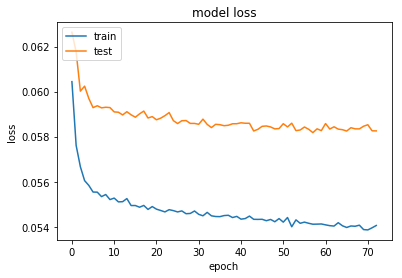

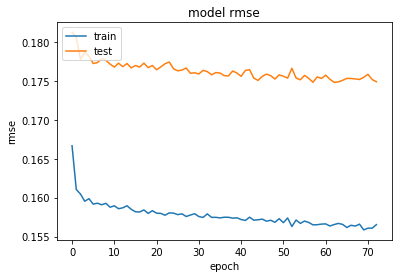

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(6235, 25, 3) (6235, 10, 3)


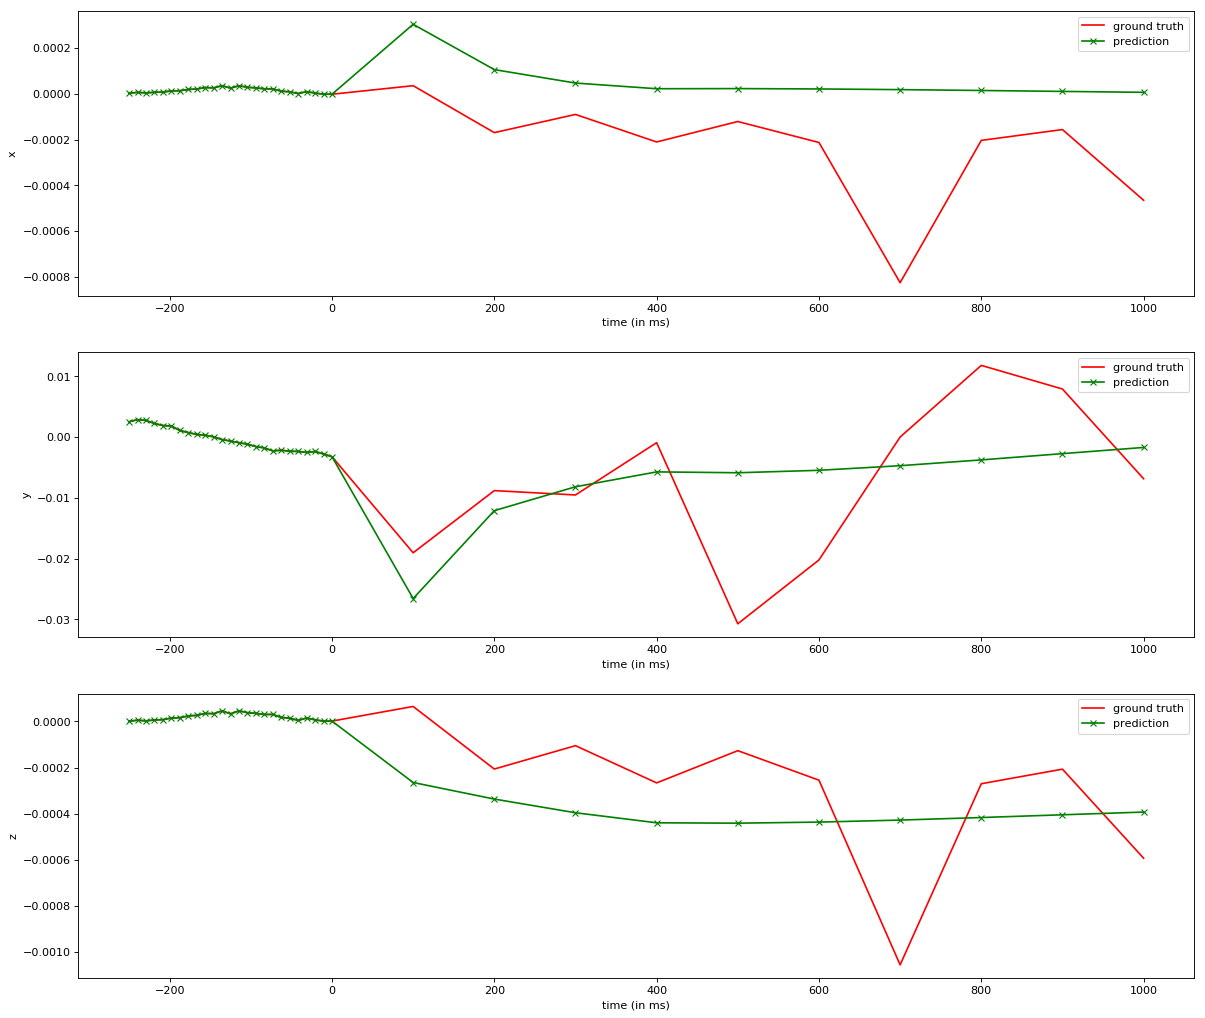

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  74.27612781524658 s =  1.237935475508372 min =  0.020632257991366917 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05748279953250956
Delay 100 ms: 0.004239626517107141
Delay 200 ms: 0.012533722668077391
Delay 300 ms: 0.023558263190077606
Delay 400 ms: 0.03596815933738747
Delay 500 ms: 0.04909358471375979
Delay 600 ms: 0.06261821888231263
Delay 700 ms: 0.07630631119752088
Delay 800 ms: 0.08999892443072328
Delay 900 ms: 0.10356695867115194
Delay 1000 ms: 0.11694422571697738

RMSE
Average rmse: 0.12120394399316581
Delay 100 ms: 0.011271836338640592
Delay 200 ms: 0.026576879926250352
Delay 300 ms: 0.04665004043621909
Delay 400 ms: 0.0686624561761416
Delay 500 ms: 0.0913540687255722
Delay 600 ms: 0.1141948190337226
Delay 700 ms: 0.1368080708077793
Delay 800 ms: 0.1590103330796151
Delay 900 ms: 0.1806552818415229
Delay 1000 ms: 0.2016295433393341

SMAPE
Average smape: 14.283466719994895
Delay 100 ms: 2.1991088446573586
Delay 200 ms: 5.275621482560364
Delay 300 ms: 8.342268646628135
Delay 400 ms: 11.210168448925502
Delay 500 ms: 13.834487271349692
Delay 600 ms: 16.248701212791644
Delay 